<a href="https://colab.research.google.com/github/kianfa/Deep-RL-Projects-/blob/Ping-Pong-Player-Agent/Pingpong%2BDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for plaing Ping Pong
This code is written to teach an RL angent to play ping-pong with pictures of the game invironment. (All the agent has as info is picture).

## Action of Agent
Actions of agent are:


*   Up
*   Down
*   Stay

## Rewards for Agent
*   each time The agent returns the ball it will be rewarded +1
*   each time The agent can not the ball it will be rewarded -1 and the episode will be finished

by doing this The agent tries to increase the number of times it returns the ball succesfully.


# Deep learning
A CNN neural network is used for estimating each state of the game. For further information you can visit CNN with Duel Algo in https://arxiv.org/abs/1511.06581

# train
For train you can simply click on run all sections in jupiter lab. Make sure you set the runtime type on "T4 GPU", otherwise training the agent would be so slow.

# test
rerun test section to set the parameters for showing the results.Then you can run Main section again and see how the agent reacts to the Ball.





##Some suggestions to improve the code


*   Adding a auto save of CNN parametes in Drive.
*   Making a simple GUI code which a human can play with the trained Agent.(You can remove red wall by editing Environment code a little bit)
*   Adding moving objects to the environment can increase the undeterministicity of the environmnet and this will make everything more challenging for the agent
*   Traing improvement is not illustrated by any charts. By doing this more info can be provided for users.
*   Training continues for a very long time now. I did't add any command to stop for some basic reasons... you can add a function for this


 **Note : you can simply replace the environment part with open AI-gym ping pong environment, but by using the provide Environment code you can make desireed changes in the environment easily.**

In [ ]:
!nvidia-smi

Mon Sep  4 07:51:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gym
import cv2

import time
import json
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque
import pygame

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import os, sys

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Fool system to think it has a video access

In [ ]:
# set SDL to use the dummy NULL video driver,
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

#RUN FOR TEST

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
SAVE_MODELS = False  # Save models to file so you can test later
MODEL_PATH = "./pong-cnn-"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = False  # Train model while playing (Make it False when testing a model)

LOAD_MODEL_FROM_FILE = True  # Load model from file
LOAD_FILE_EPISODE = 380  # Load Xth episode from file

BATCH_SIZE = 64  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 100000  # Max episode
MAX_STEP = 100000  # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 3000  # Min memory len before start train 40000

GAMMA = 0.97  # Discount rate
ALPHA = 0.00025  # Learning rate
EPSILON_DECAY = 0.97  # Epsilon decay rate by step


RENDER_GAME_WINDOW = True  # Opens a new window to render the game (Won't work on colab default)

cuda


#RUN FOR TRAINING

In [ ]:
#ENVIRONMENT = "PongDeterministic-v4"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
SAVE_MODELS = True  # Save models to file so you can test later
MODEL_PATH = "./pong-cnn-"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = True  # Train model while playing (Make it False when testing a model)

LOAD_MODEL_FROM_FILE = False  # Load model from file
LOAD_FILE_EPISODE = 300  # Load Xth episode from file

BATCH_SIZE = 64  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 100000  # Max episode
MAX_STEP = 100000  # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 3000  # Min memory len before start train 40000

GAMMA = 0.97  # Discount rate
ALPHA = 0.00025  # Learning rate
EPSILON_DECAY = 0.97  # Epsilon decay rate by step


# with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
#         param = json.load(outfile)
#         agent.epsilon = param.get('epsilon')

RENDER_GAME_WINDOW = False  # Opens a new window to render the game (Won't work on colab default)

cuda


In [ ]:
class DuelCNN(nn.Module):
    """
    CNN with Duel Algo. https://arxiv.org/abs/1511.06581
    """
    def __init__(self, h, w, output_size):
        super(DuelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        linear_input_size = convw * convh * 64  # Last conv layer's out sizes

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node

    def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
        """
        Calcs conv layers output image sizes
        """
        next_w = (w - (kernel_size - 1) - 1) // stride + 1
        next_h = (h - (kernel_size - 1) - 1) // stride + 1
        return next_w, next_h

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean())

        return q

In [ ]:
# Set up the game window
GRID_ROWS = 5
GRID_COLS = 16
CELL_SIZE = 50
window_width = GRID_COLS * CELL_SIZE
window_height = GRID_ROWS * CELL_SIZE
window = pygame.display.set_mode((window_width, window_height))
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0,255,0)
rectangle_size = (10, 5*CELL_SIZE)  # Width and height of the rectangle (wall)
rectangle_position = (window_width-rectangle_size[0], 0)  #wall position


pygame.display.set_caption("PING_PONG")
def render( player1_row , ball_row , ball_col , show ):
        player1_col = 0
        #player2_col = GRID_COLS-1

        # Show state visually
        window.fill(BLACK)

        # Draw the players
        pygame.draw.rect(window, WHITE, (player1_col * CELL_SIZE, player1_row * CELL_SIZE, CELL_SIZE/3, CELL_SIZE))
        pygame.draw.rect(window, RED, ( *rectangle_position, *rectangle_size) ) # WALL

        # Draw the ball
        pygame.draw.circle(window, GREEN, (ball_col * CELL_SIZE + CELL_SIZE // 2 , ball_row *CELL_SIZE + CELL_SIZE // 2 ), CELL_SIZE // 4)

        # Draw the score
        # score_text = font.render(f"{score_player1} - {score_player2}", True, WHITE)
        # window.blit(score_text, (window_width // 2 - score_text.get_width() // 2, 10))

        # Draw the lines
        # pygame.draw.line(window, WHITE, (wall1_x * CELL_SIZE, (wall1_y + 1)*CELL_SIZE), ((wall1_x + 1) * CELL_SIZE, (wall1_y + 1)*CELL_SIZE), 5)
        # pygame.draw.line(window, WHITE, (wall2_x * CELL_SIZE, wall2_y*CELL_SIZE), ((wall2_x + 1) * CELL_SIZE, wall2_y*CELL_SIZE), 5)

        pygame.display.flip()
        #convert image so it can be displayed in OpenCV
        view = pygame.surfarray.array3d(window)
        #  convert from (width, height, channel) to (height, width, channel)
        view = view.transpose([1, 0, 2])

        #  convert from rgb to bgr
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
        if show == True:
            cv2_imshow(img_bgr)
        else:
            return img_bgr



### print image of the game for instance

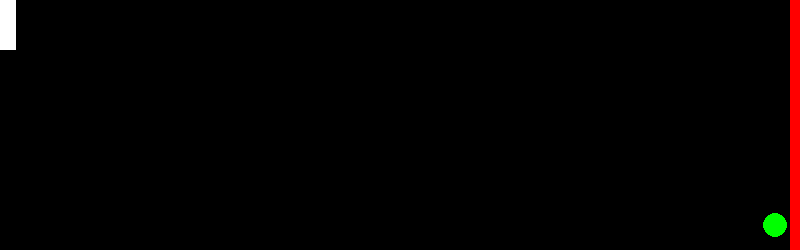

In [ ]:
render(  player1_row = 0 , ball_row = 4 , ball_col = 15 , show = True )
#render(  player1_row = 0 , ball_row = 4 , ball_col = 15 , show = False )

#Environment

In [ ]:
class Environment:
    def __init__(self):
        self.observation_space = [5,16]
        self.action_space = [0 , 1 , 2 ] # 0:Down ,  1:Stay , 2:Up

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process
        self.BALL_SPEED = 1
        self.done = False

    def reset(self):
        #RESET STATES AND EVERYTHING

        self.ball_col = random.randint(5, 12)
        self.ball_row = random.choice([1, 2, 3])  # Randomize the ball's initial row (excluding 0 and 4)
        self.ball_speed_x = random.choice([self.BALL_SPEED , -self.BALL_SPEED])
        self.ball_speed_y = random.choice([self.BALL_SPEED , -self.BALL_SPEED])

        # Set up the players' positions
        self.player1_row = 2
        #self.player2_row = 2
        self.player1_col = 0
        #self.player2_col = GRID_COLS - 1

        # Set up the score
        self.score_player1 = 0
        self.score_player2 = 0
        self.state = render(  self.player1_row  , self.ball_row  , self.ball_col  , show = False )

        return self.state
    def step(self , action):


        if   self.player1_row != 0 and action ==0:
                 self.player1_row += -1  # Agent goes UP / yes it goes up it's vise-versa

        elif self.player1_row != 4 and action ==2 :
                 self.player1_row += 1   # Agent goes Down / yes it goes down it's vise-versa

        # Move the ball
        self.ball_col += self.ball_speed_x
        self.ball_row += self.ball_speed_y

        # # Move the walls
        # if wall1_x == 12:
        #     wall1_speed = -1
        # if wall1_x == 5:
        #     wall1_speed = 1
        # if wall2_x == 12:
        #     wall2_speed = -1
        # if wall2_x == 5:
        #     wall2_speed = 1

        # wall_cnt += 1

        # if wall_cnt == 10:
        #     wall1_x += wall1_speed
        #     wall2_x += wall2_speed
        #     wall_cnt = 0


        # Check for ball collision with walls
        # if ball_col <= 0 or ball_col >= GRID_COLS - 1:
        #     ball_speed_x *= -1
        # if ball_row <= 0 or ball_row >= GRID_ROWS - 1:
        #     ball_speed_y *= -1

        # if ball_col == wall1_x and ball_row - 1 == wall1_y and ball_speed_y == -1:
        #     ball_speed_y *= -1


        ## ball touching right wall
        if self.ball_col == self.observation_space[1]-1 :
            self.ball_speed_x *= -1
        ## ball touching bottom and top of env
        if self.ball_row == self.observation_space[0]-1 or self.ball_row == 0 :
            self.ball_speed_y *= -1
        ## ball touching the agent
        if self.ball_col == 0 and  self.ball_row ==self.player1_row :
            self.ball_speed_x *= -1

       # Check for scoring a goal
        if self.ball_col == -1 :
             reward = -1
             self.done = True
             Environment.reset(self)
        else:
             reward = +1
             self.done = False

        self.next_state = render(  self.player1_row  , self.ball_row  , self.ball_col  , show = False )


        return self.next_state, reward , self.done





In [ ]:
env = Environment()
_ = env.reset()

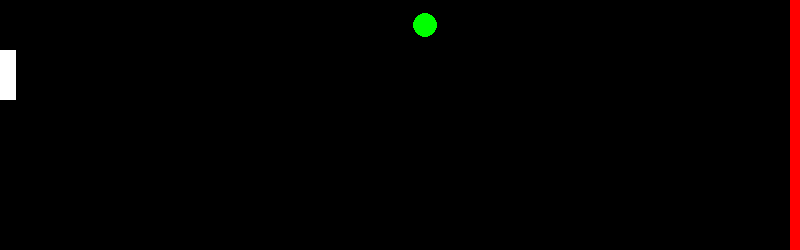

In [ ]:
next_state, reward , done= env.step(action =0)
cv2_imshow(next_state)

In [ ]:
env.state.shape


(250, 800, 3)

In [ ]:
env.action_space

[0, 1, 2]

#Agent class

In [ ]:
class Agent:
    def __init__(self, environment):
        """
        Hyperparameters definition for Agent
        """
        # State size for breakout env. SS images (~, ~, 3). Used as input size in network
        self.state_size_h = environment.state.shape[0]
        self.state_size_w = environment.state.shape[1]
        self.state_size_c = environment.state.shape[2]

        # Activation size for breakout env. Used as output size in network
        self.action_size = len(environment.action_space)

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process

        #self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount coef for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.05  # Minimum for Explore

        # Deque holds replay mem.
        self.memory = deque(maxlen=MAX_MEMORY_LEN)

        # Create two model for DDQN algorithm
        self.online_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.target_model.eval()

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)

    def preProcess(self, image):
        """
        Process image crop resize, grayscale and normalize the images
        """
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        #frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        frame = frame.reshape(self.target_w, self.target_h) / 255  # Normalize

        return frame

    def act(self, state):
        """
        Get state and do action
        Two option can be selectedd if explore select random action
        if exploit ask nnet for action
        """

        act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

        if act_protocol == 'Explore':
            action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                q_values = self.online_model.forward(state)  # (1, action_size)
                action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

        return action

    def train(self):
        """
        Train neural nets with replay memory
        returns loss and max_q val predicted from online_net
        """
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            #print("NOT TRAINING YET")
            return loss, max_q

        # We get out minibatch and turn it to numpy array
        state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))

        # Concat batches in one array
        # (np.arr, np.arr) ==> np.BIGarr
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

    def storeResults(self, state, action, reward, nextState, done):
        """
        Store every result to memory
        """
        self.memory.append([state[None, :], action, reward, nextState[None, :], done])

    def adaptiveEpsilon(self):
        """
        Adaptive Epsilon means every step
        we decrease the epsilon so we do less Explore
        """
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay

# Main

381



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


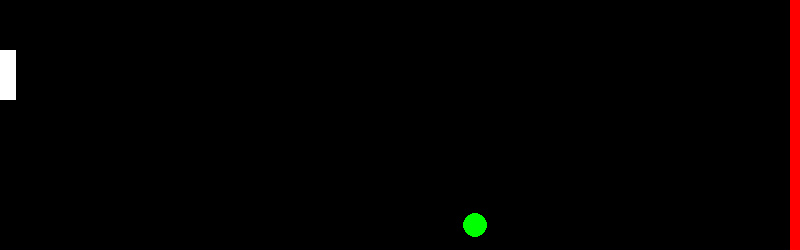

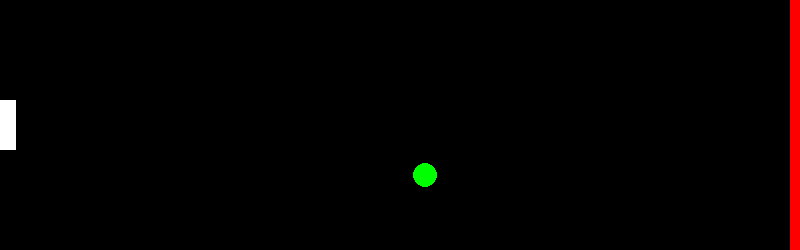

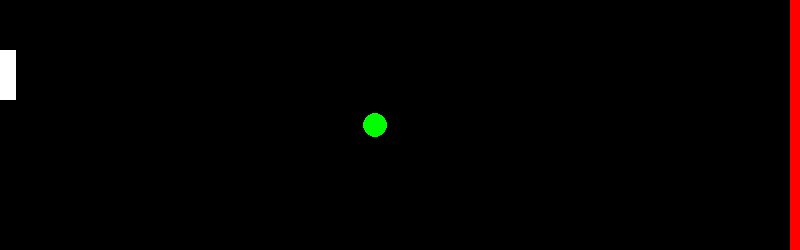

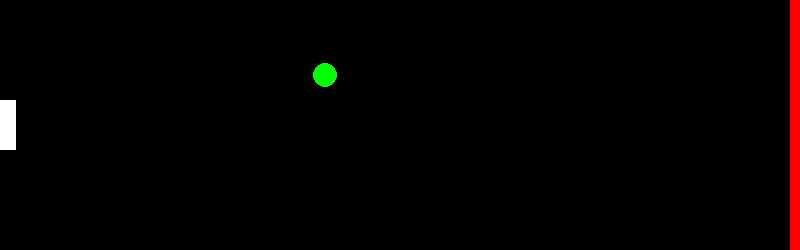

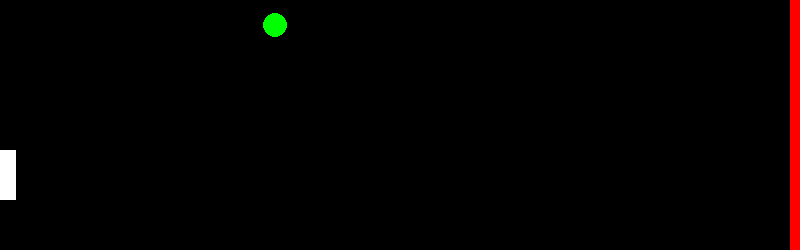

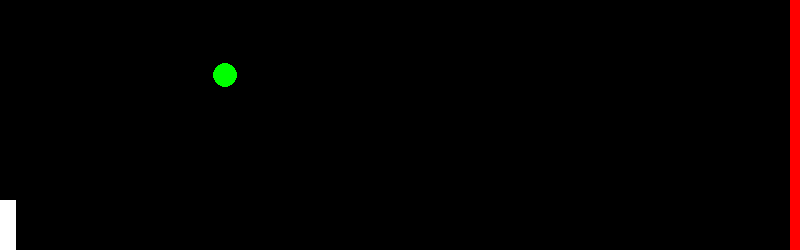

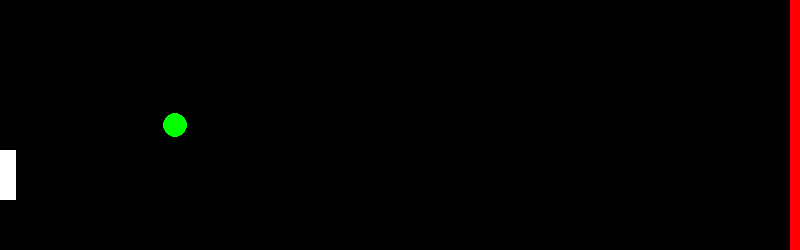

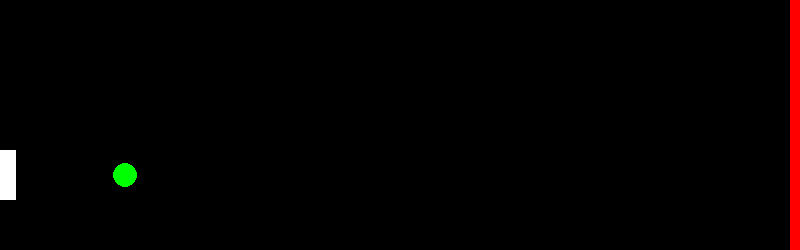

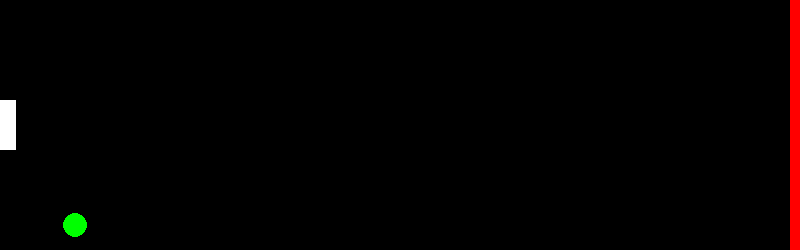

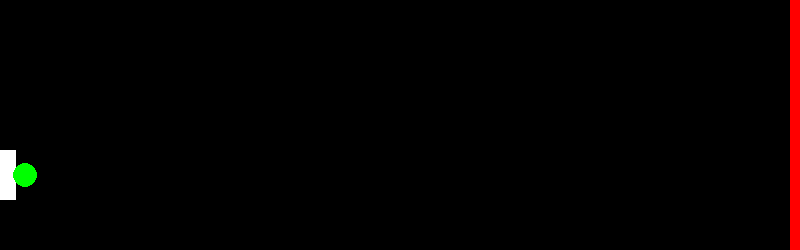

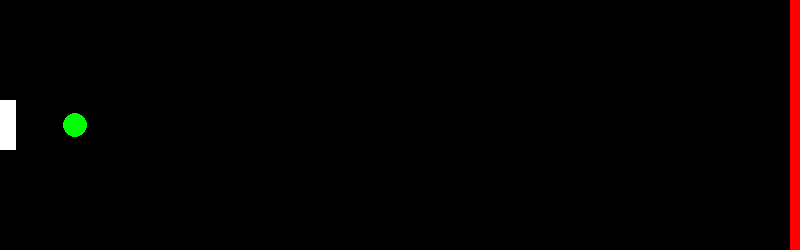

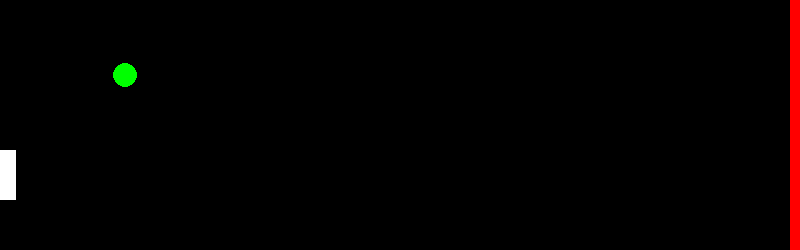

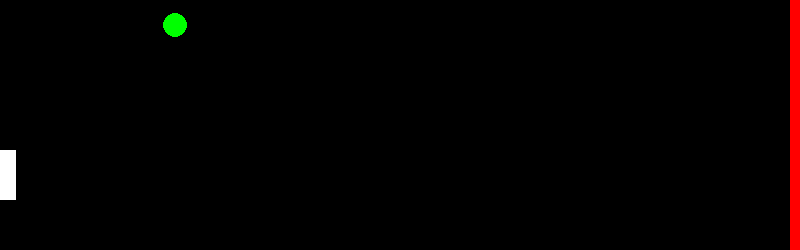

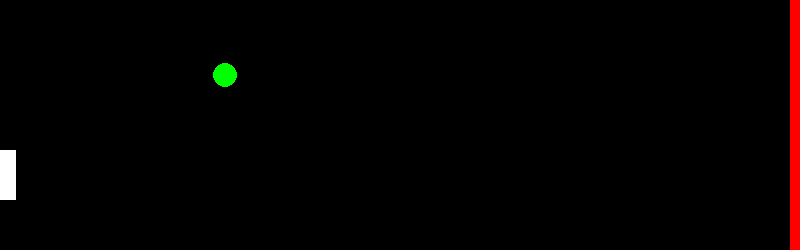

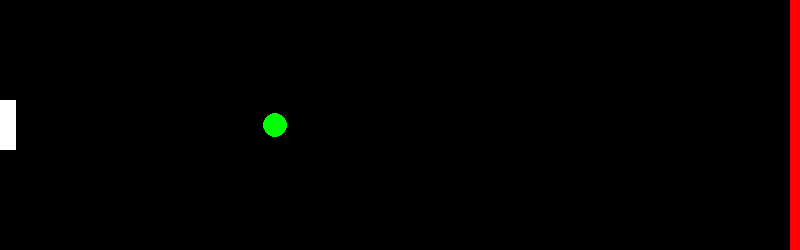

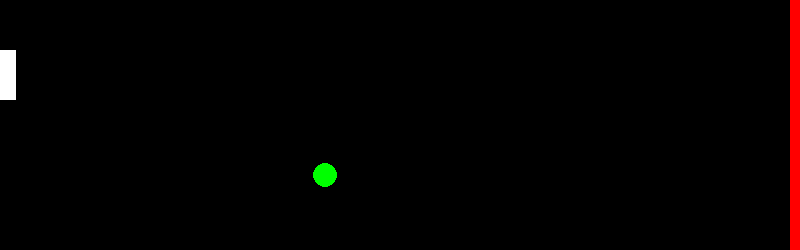

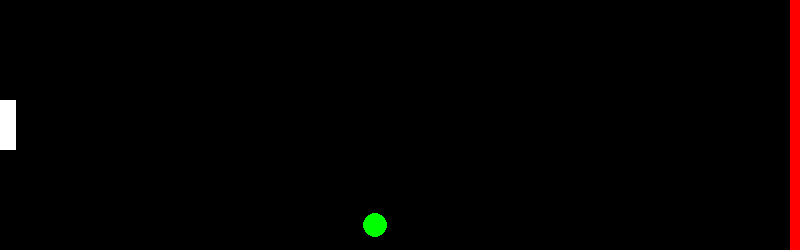

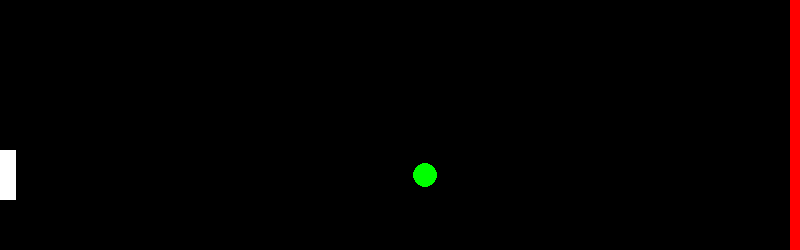

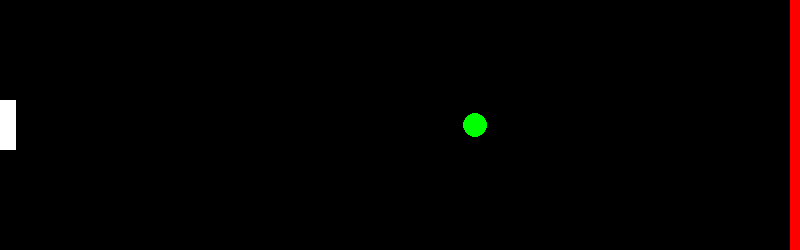

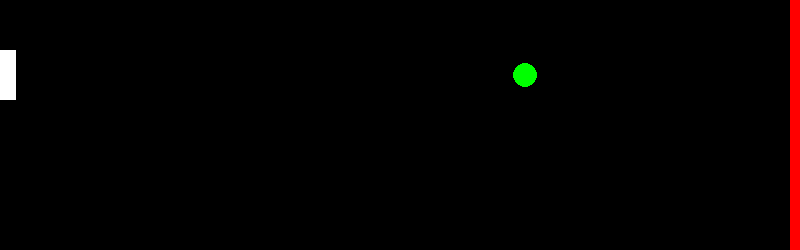

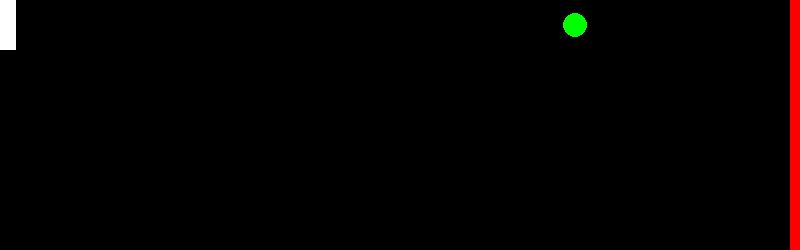

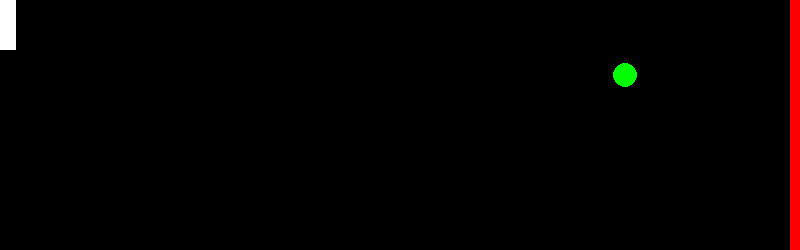

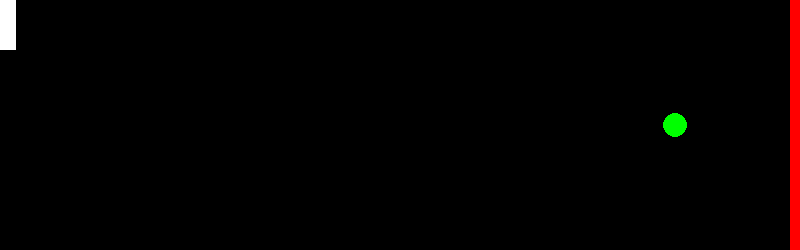

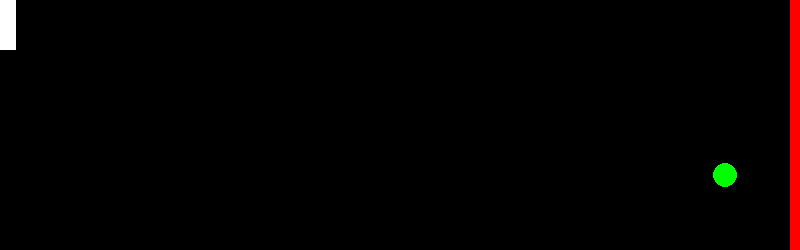

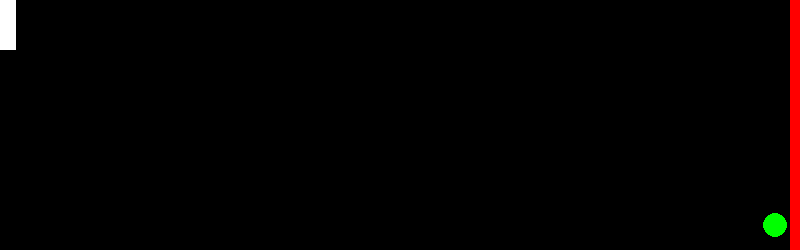

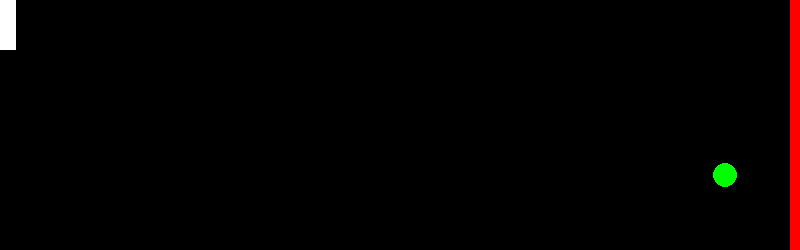

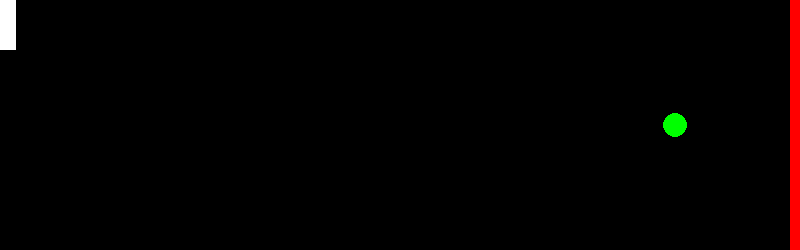

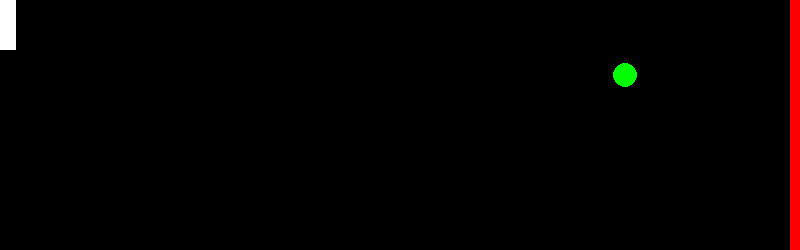

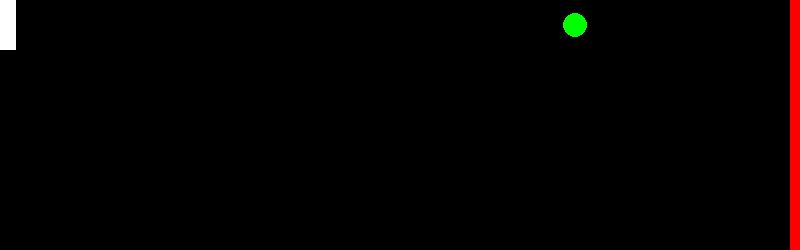

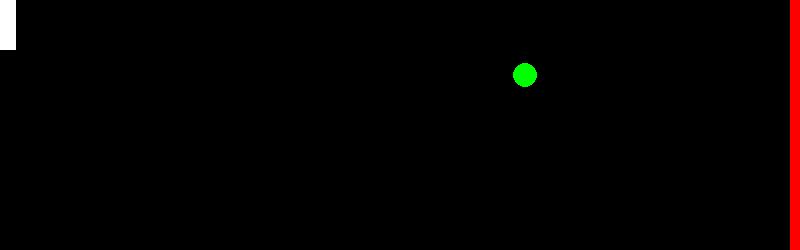

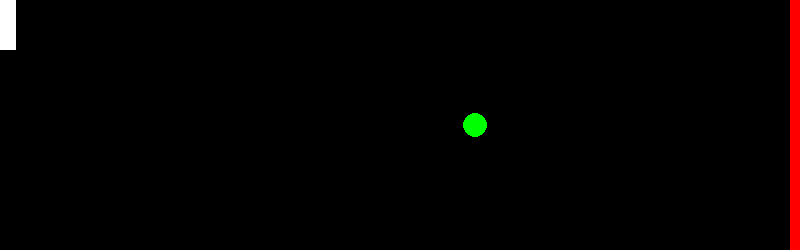

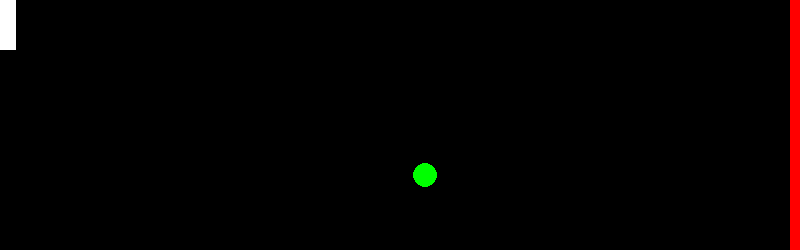

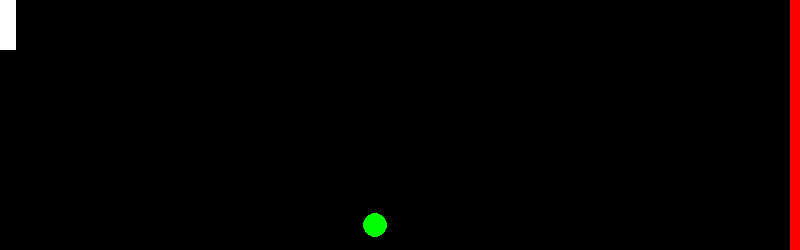

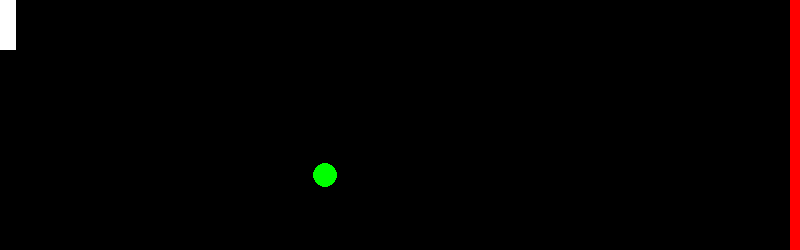

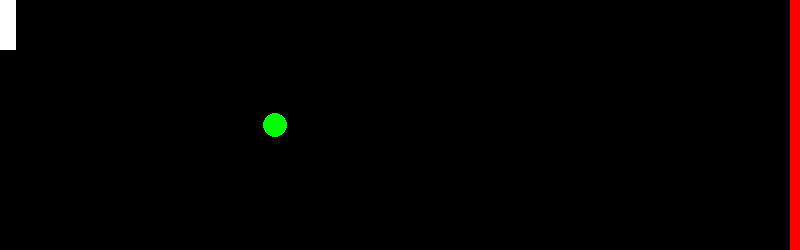

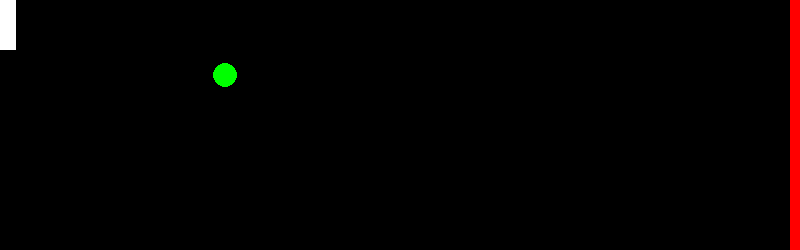

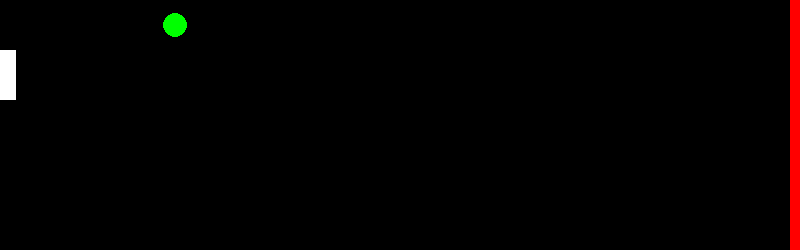

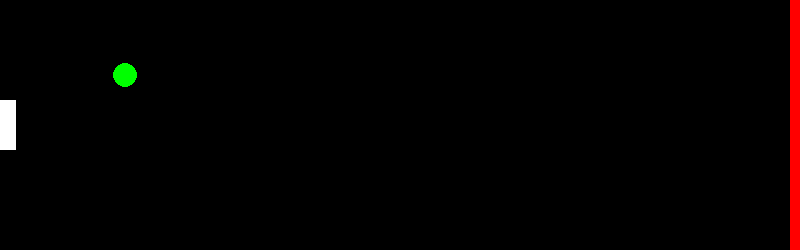

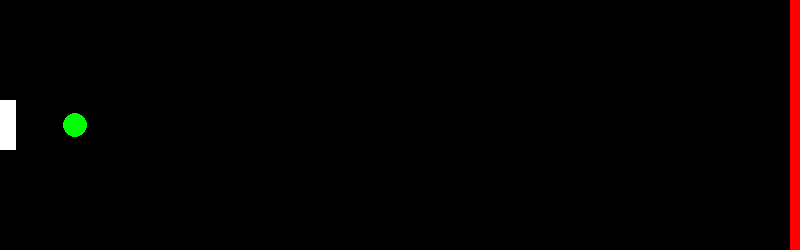

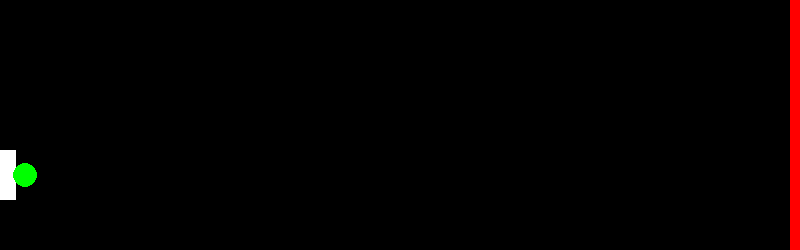

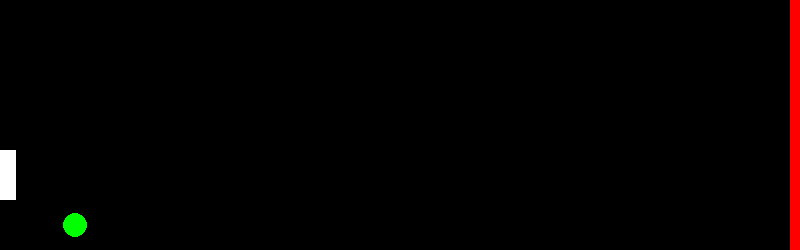

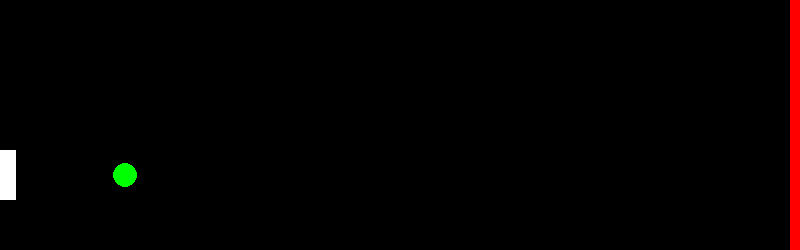

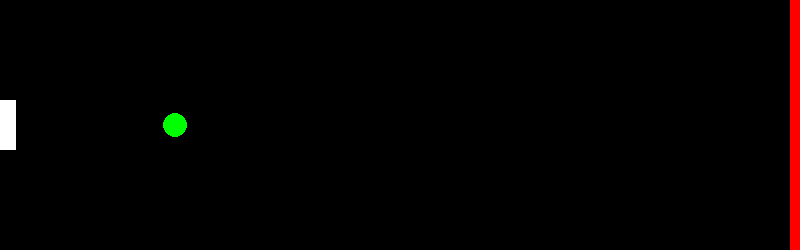

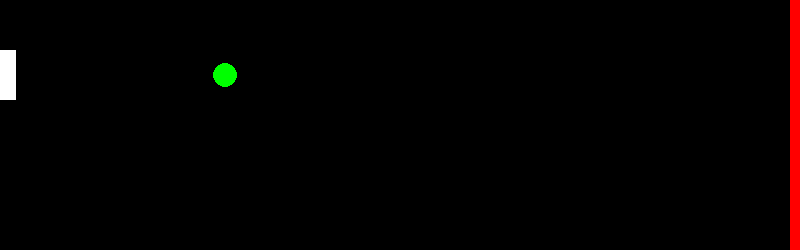

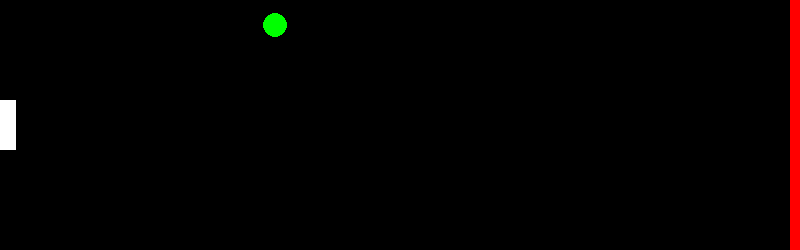

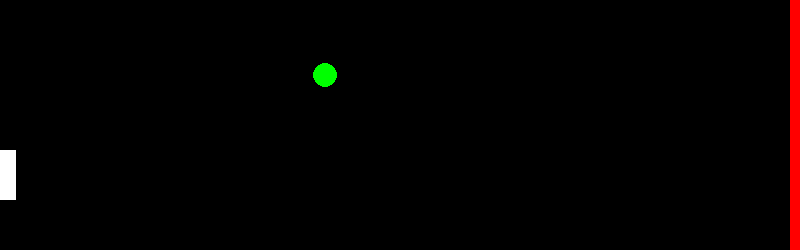

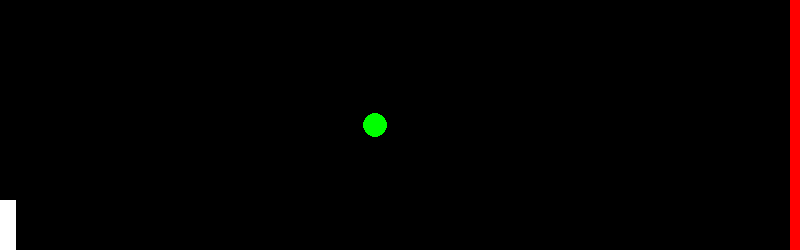

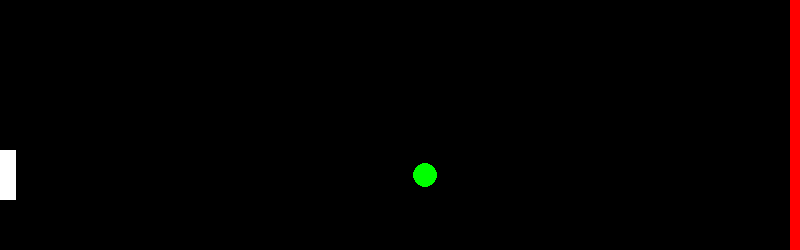

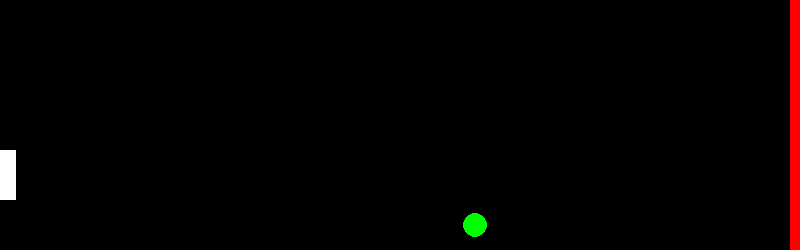

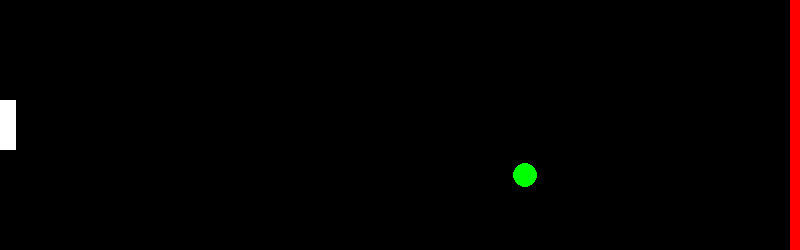

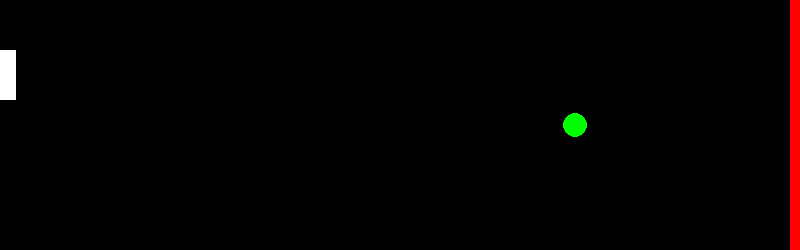

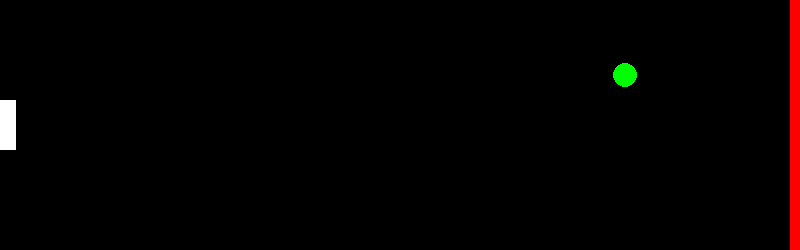

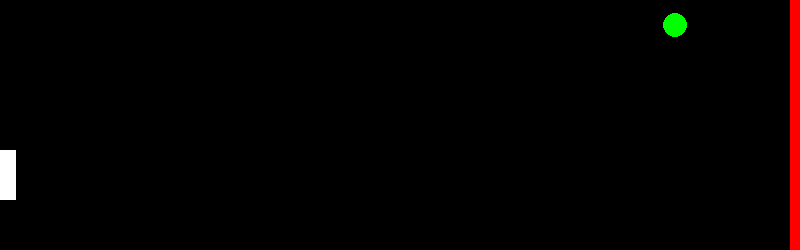

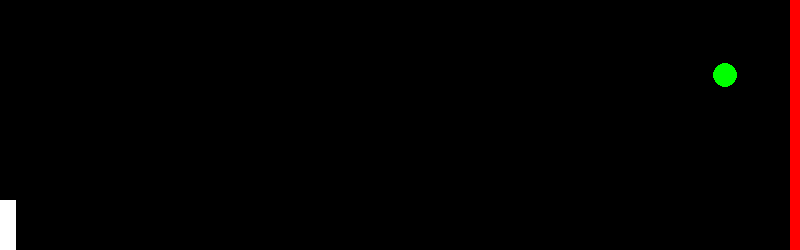

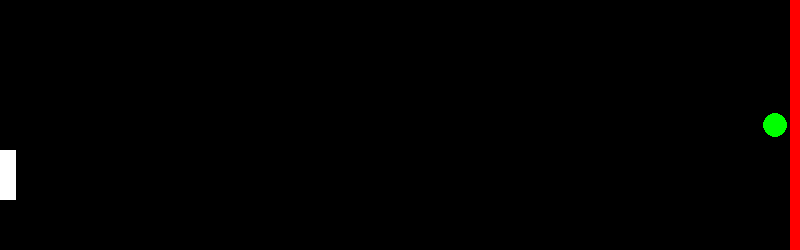

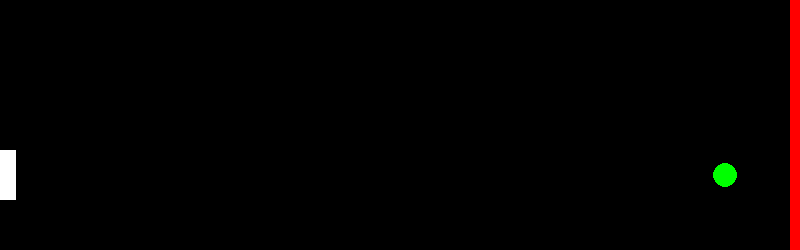

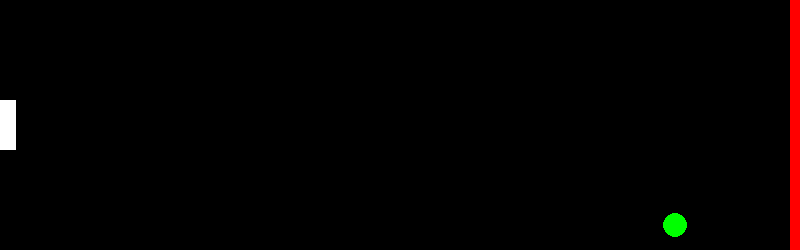

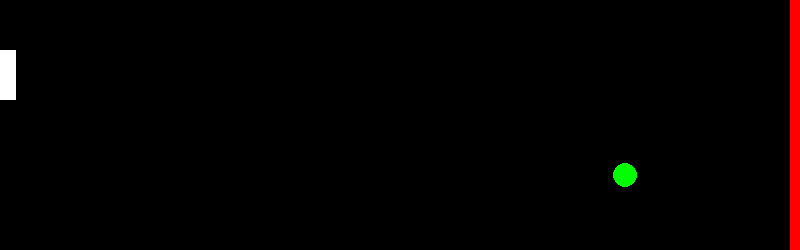

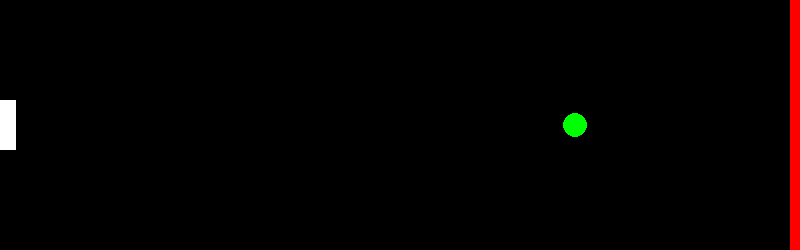

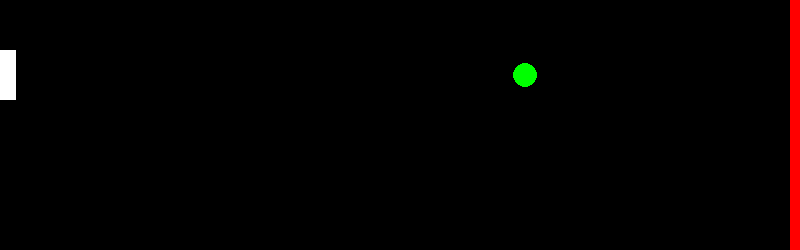

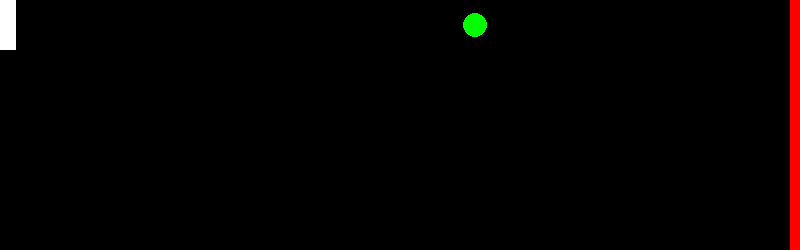

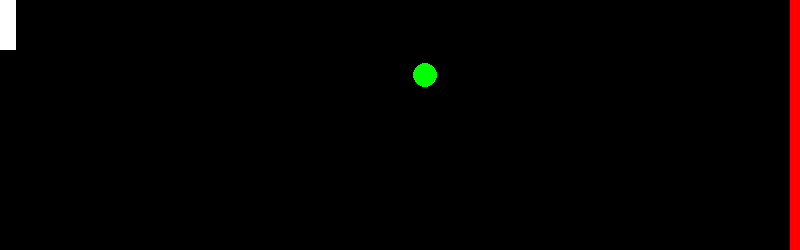

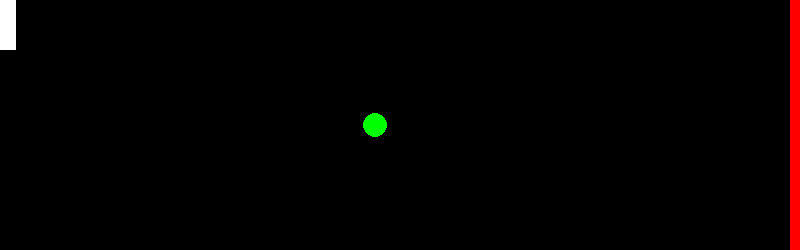

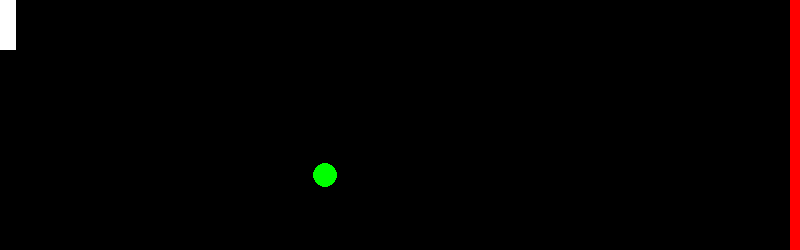

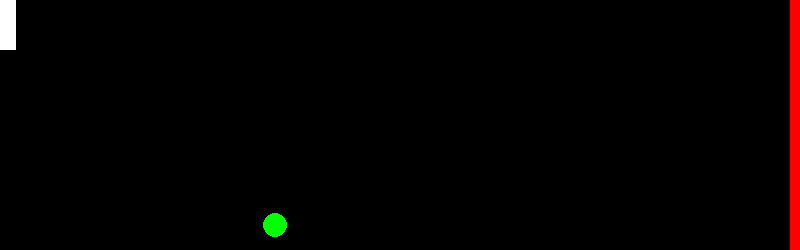

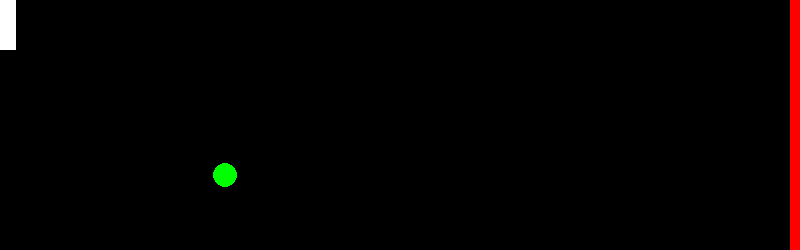

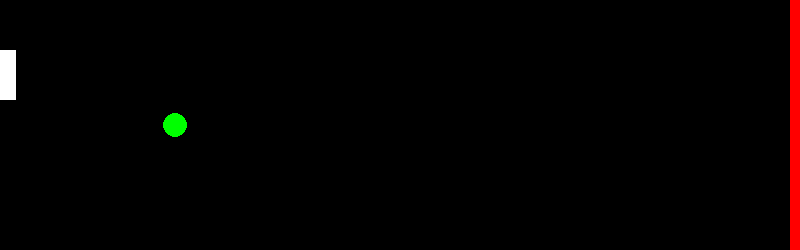

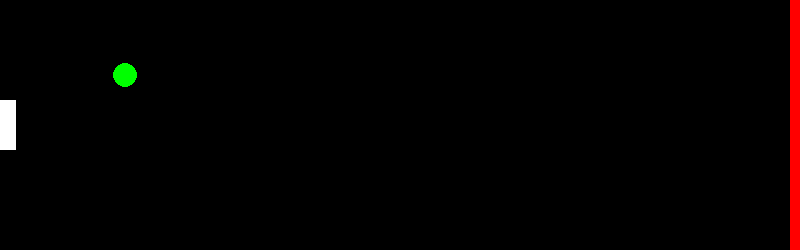

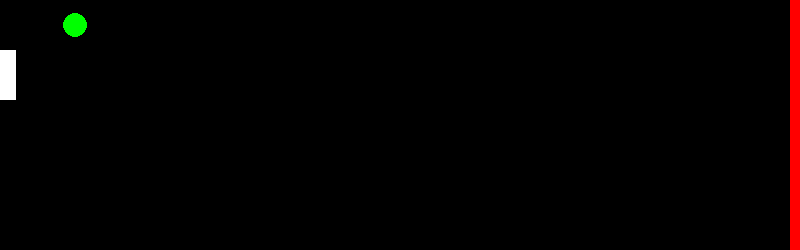

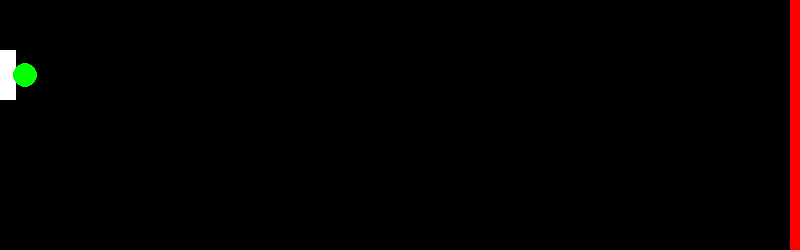

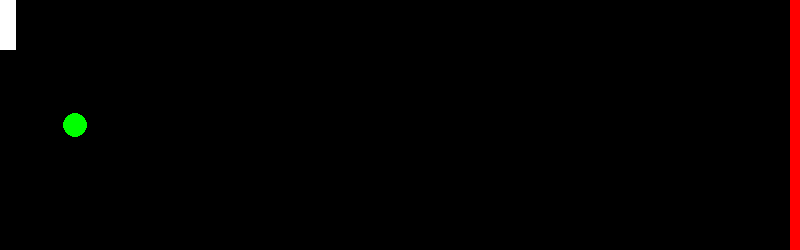

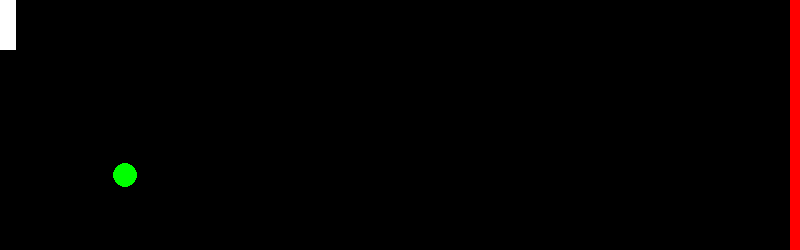

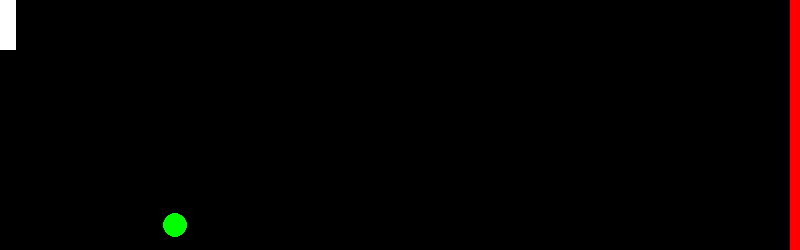

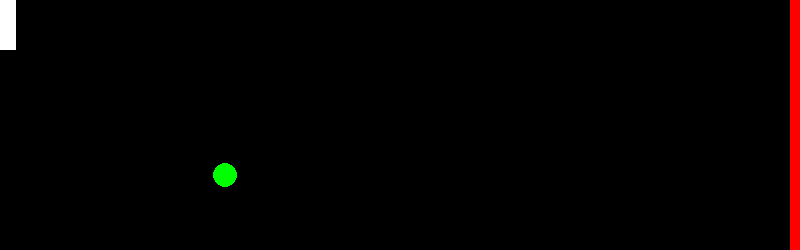

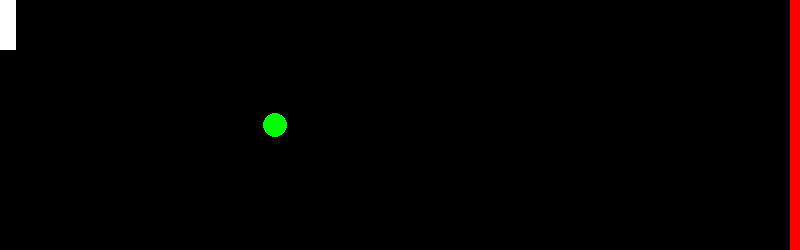

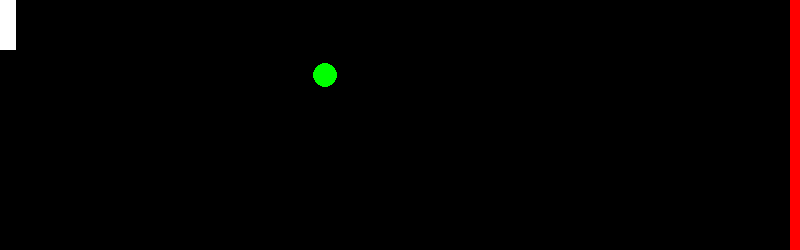

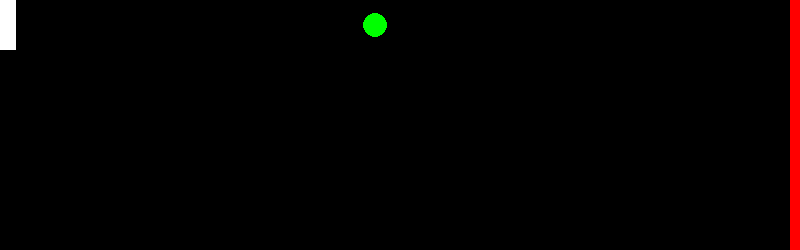

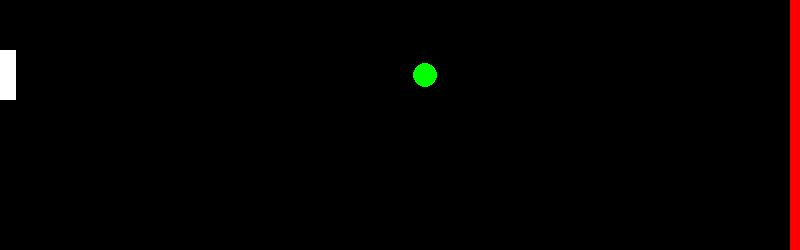

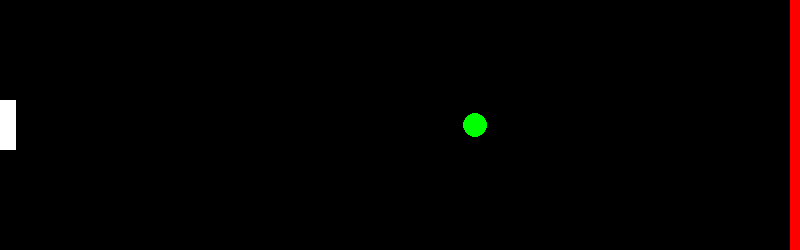

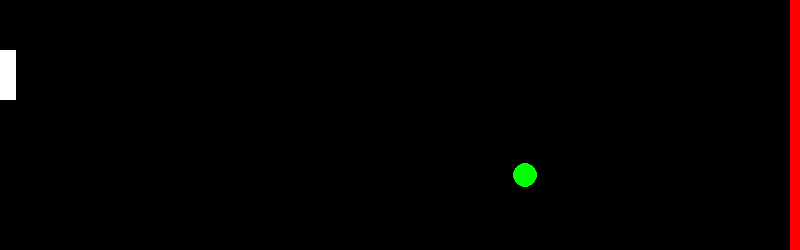

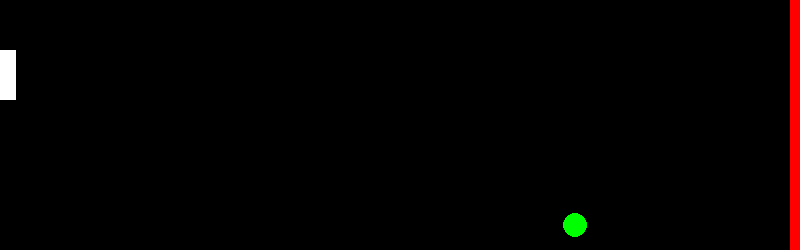

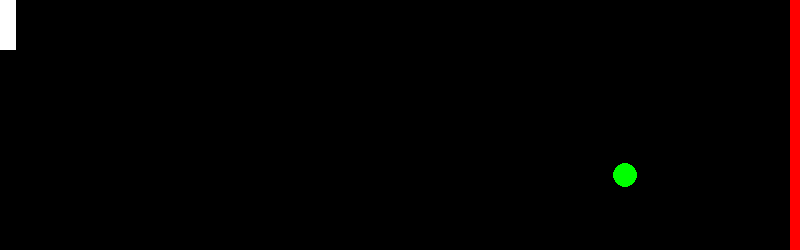

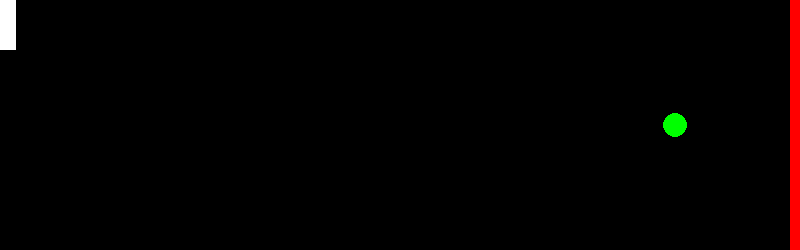

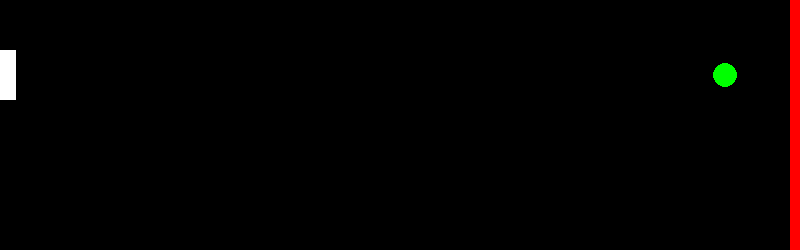

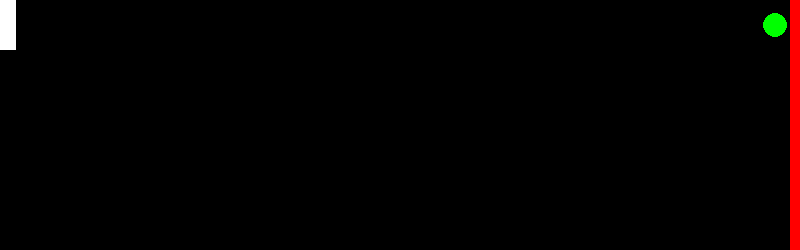

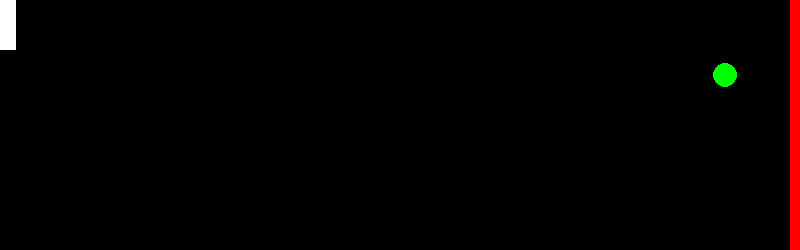

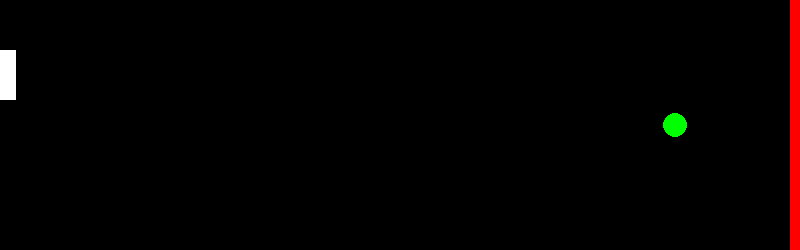

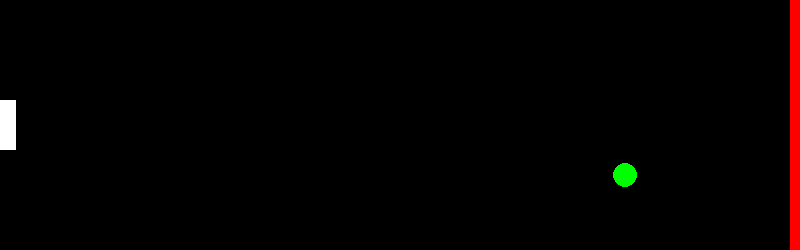

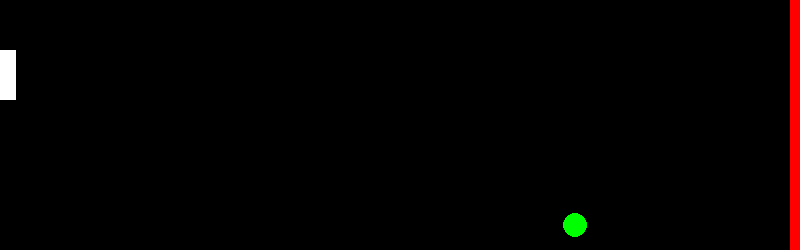

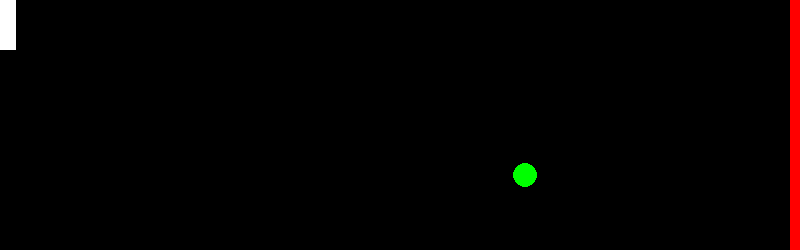

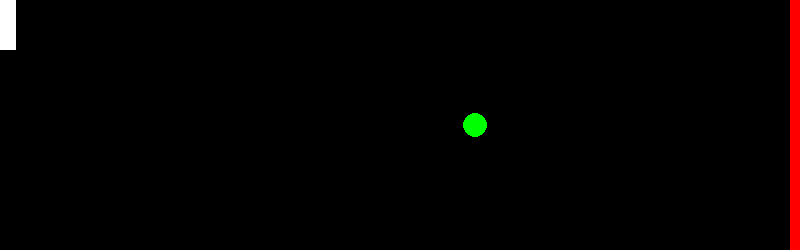

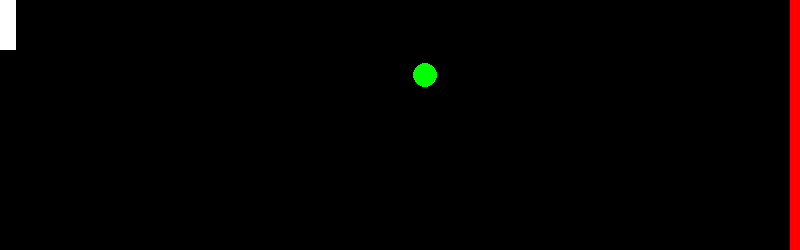

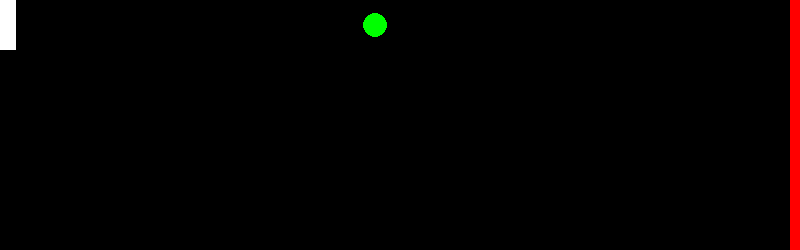

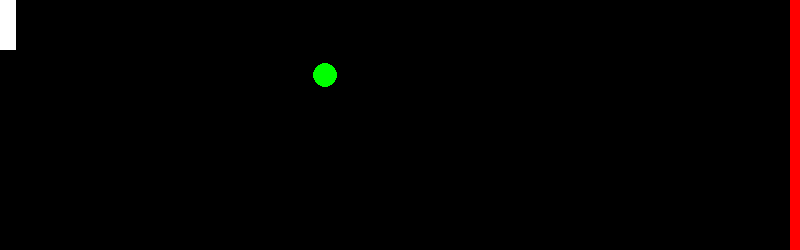

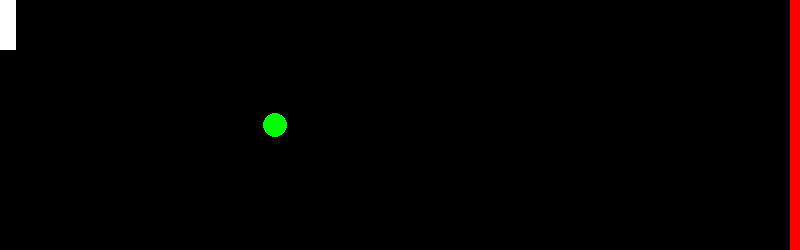

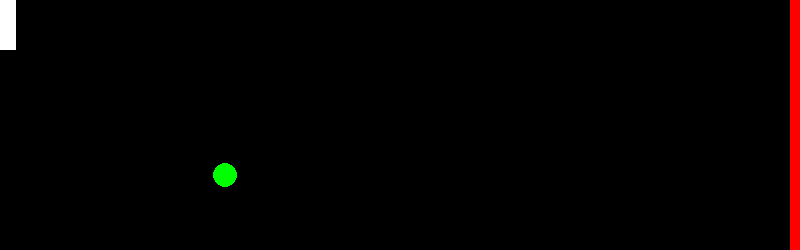

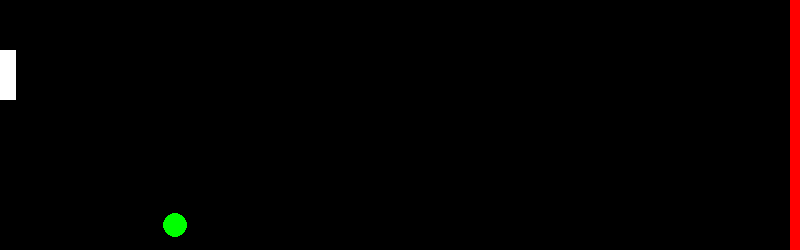

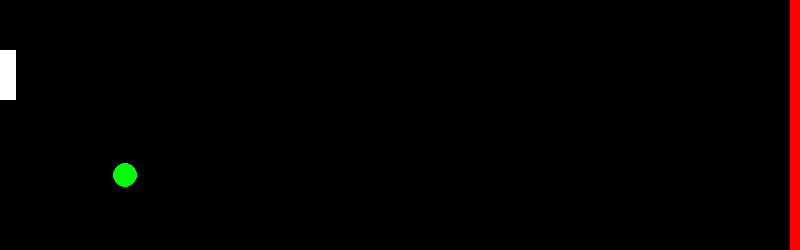

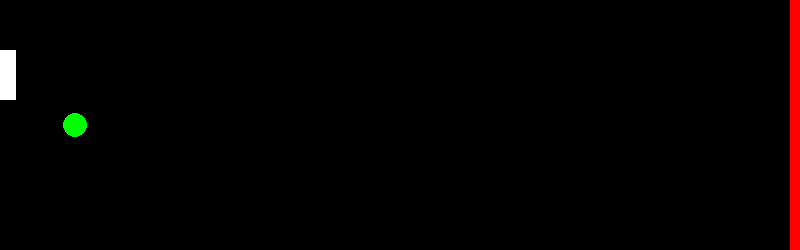

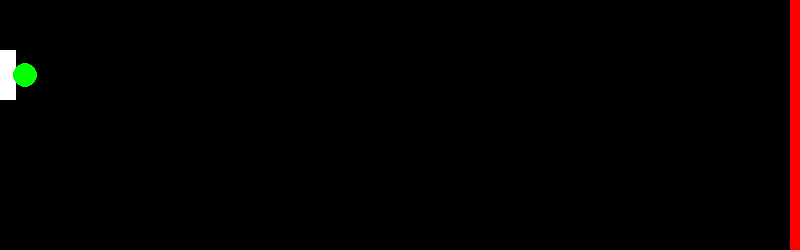

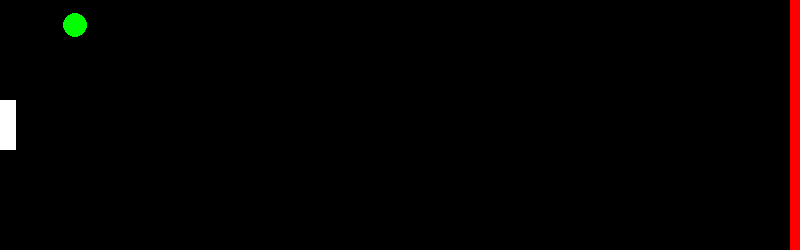

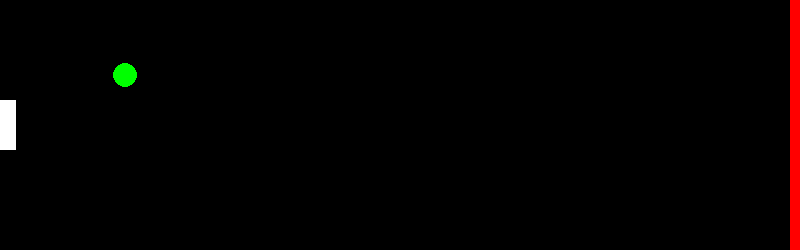

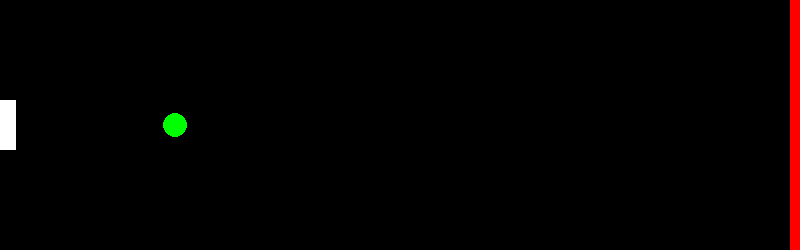

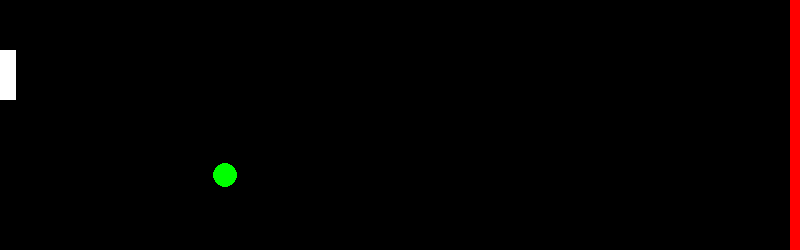

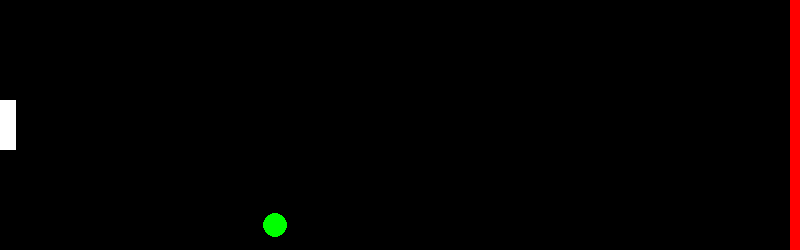

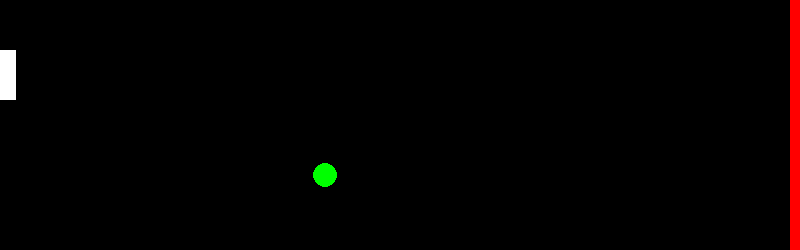

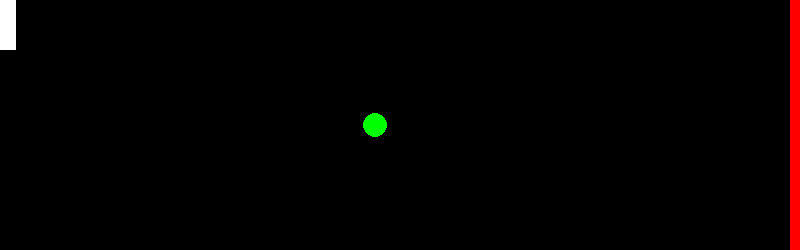

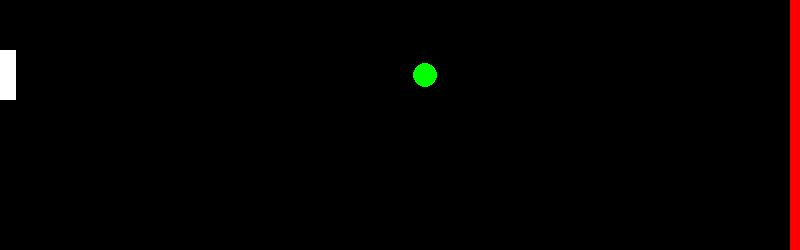

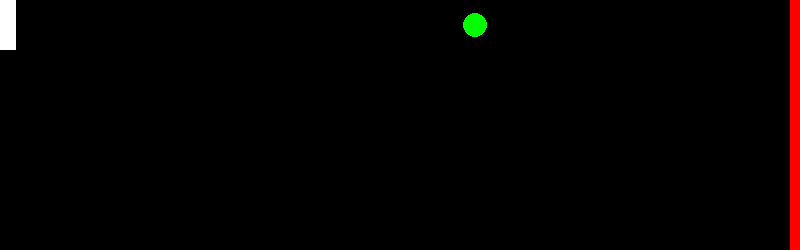

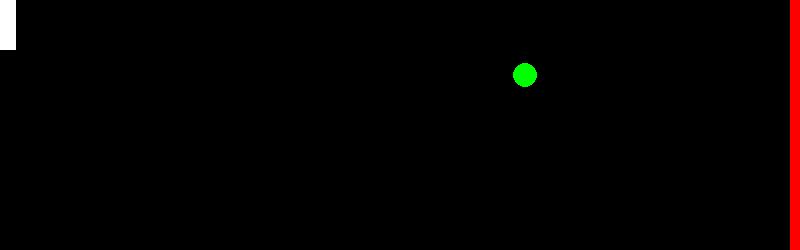

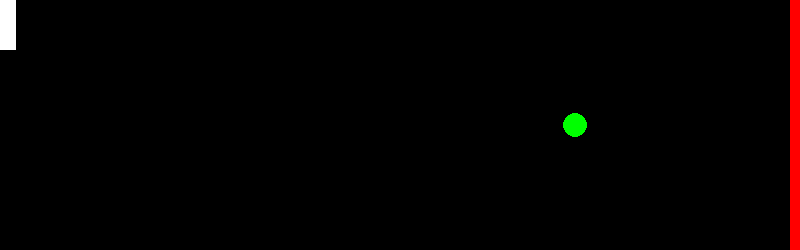

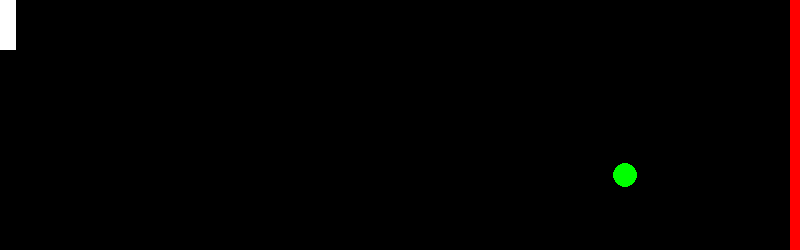

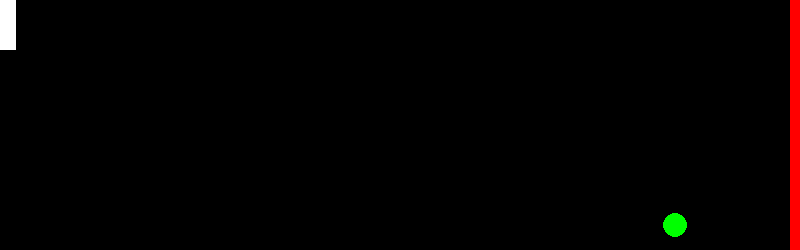

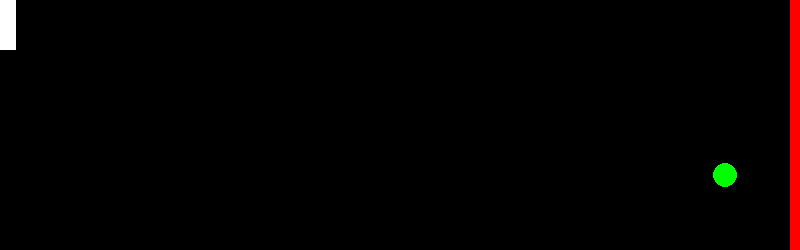

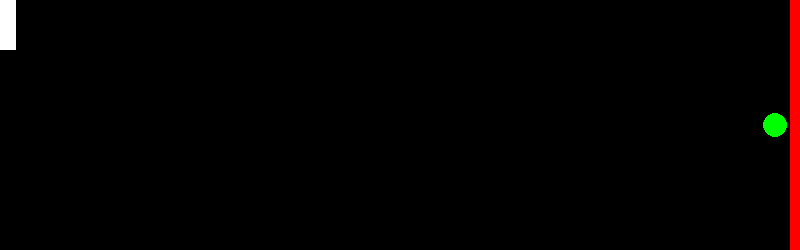

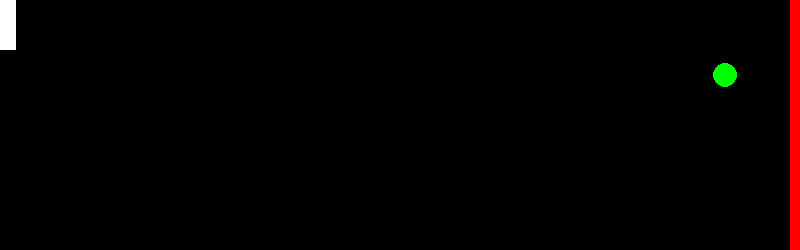

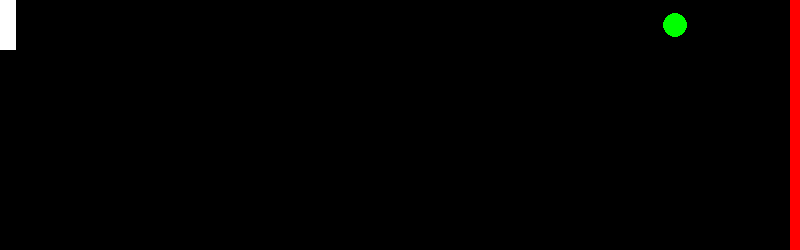

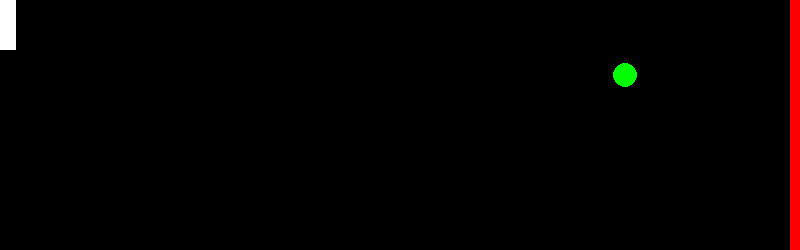

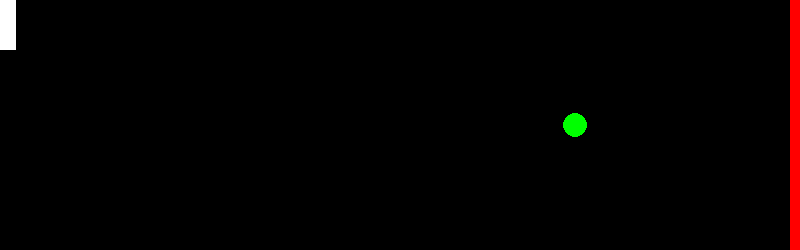

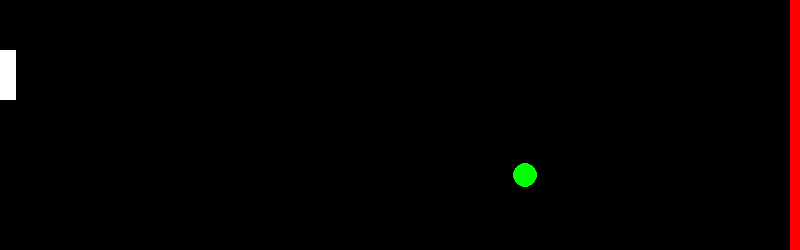

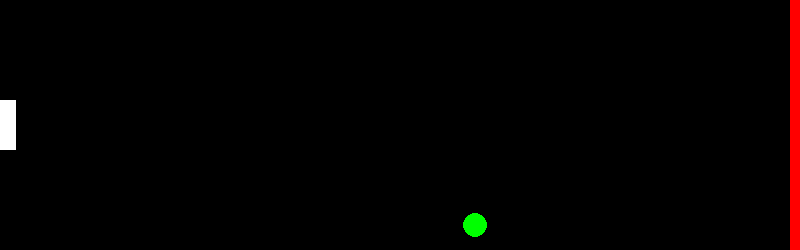

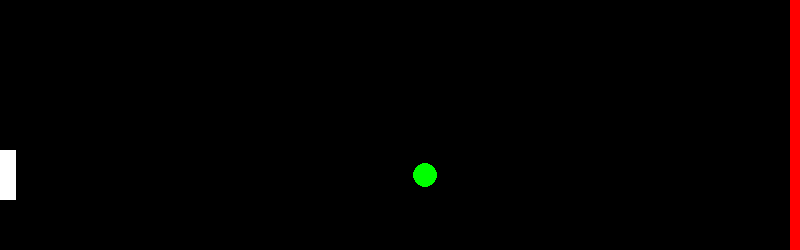

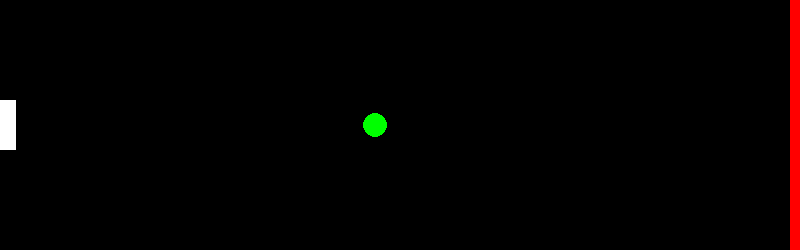

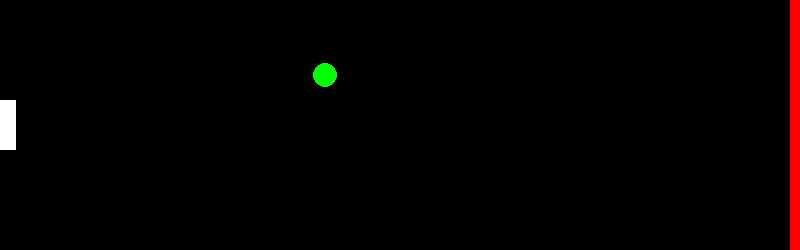

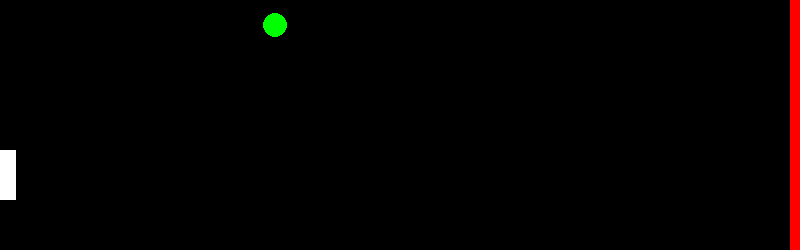

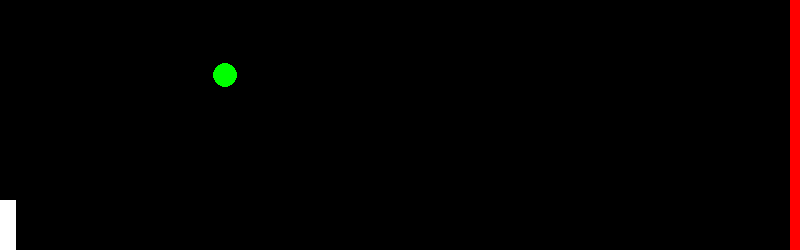

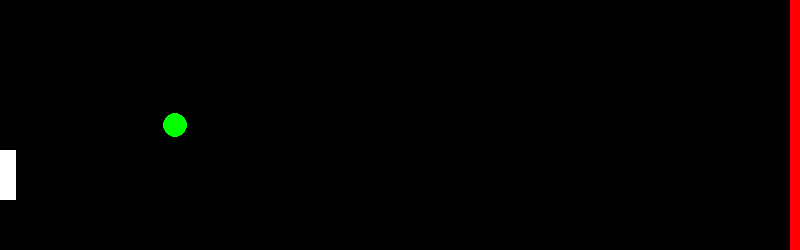

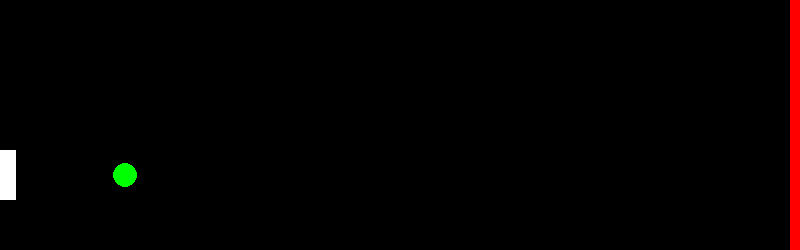

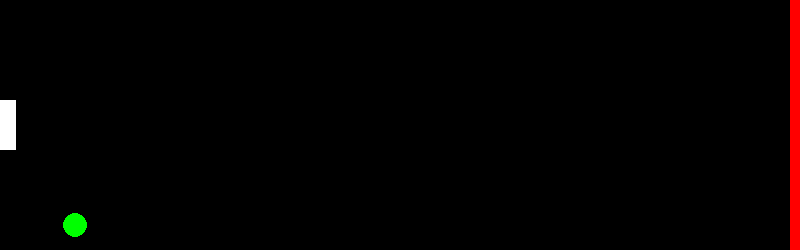

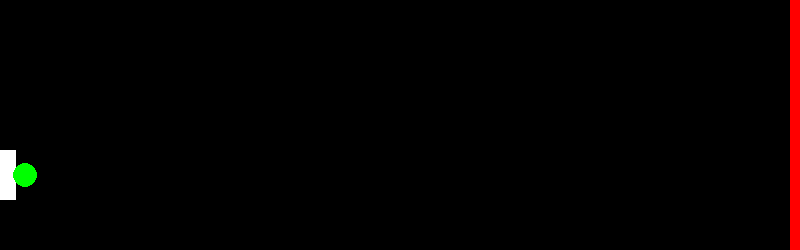

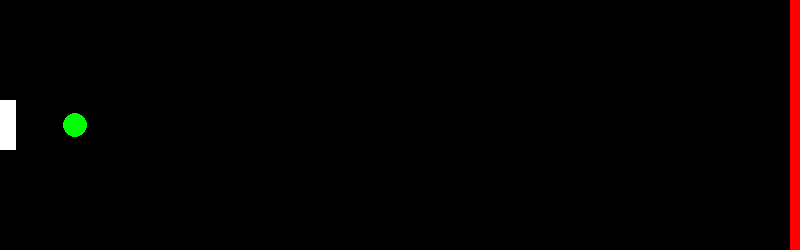

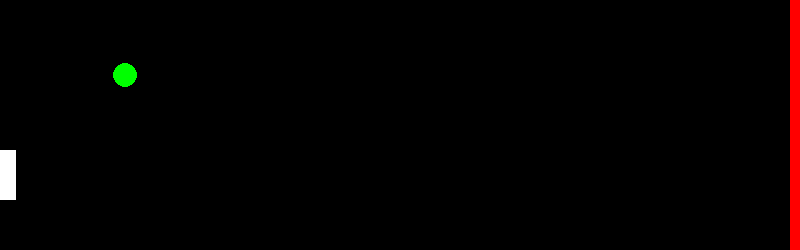

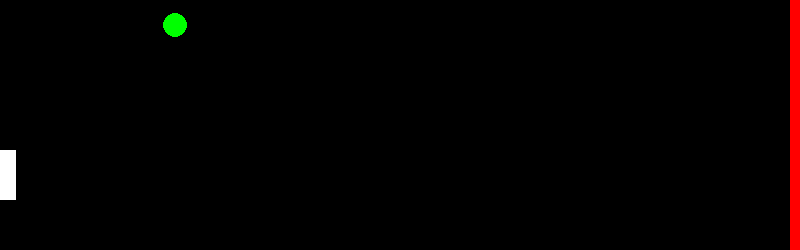

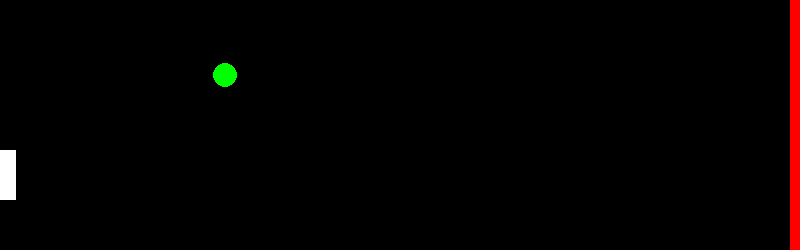

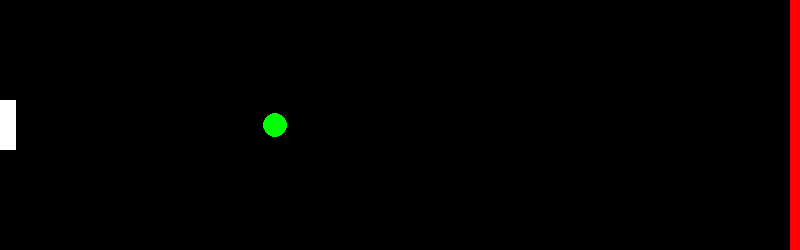

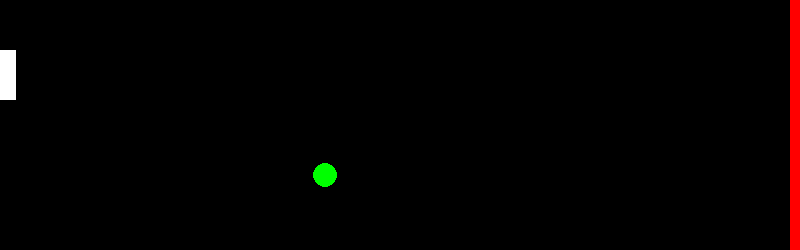

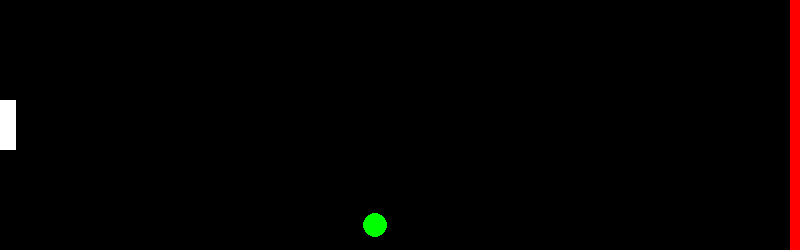

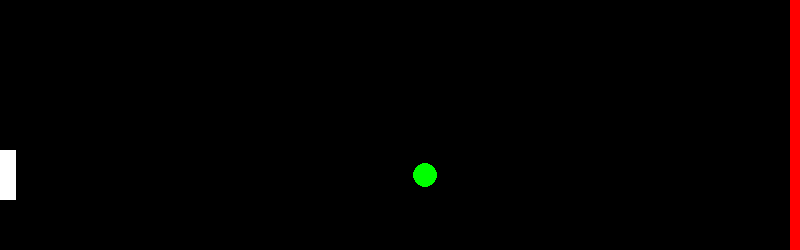

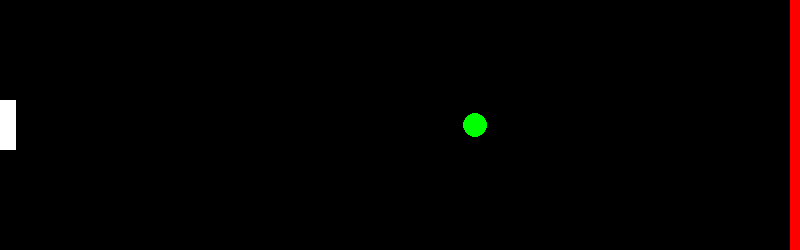

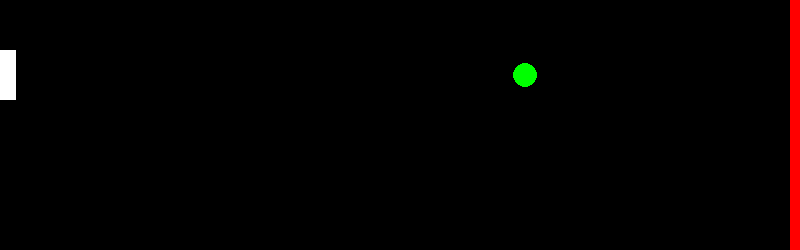

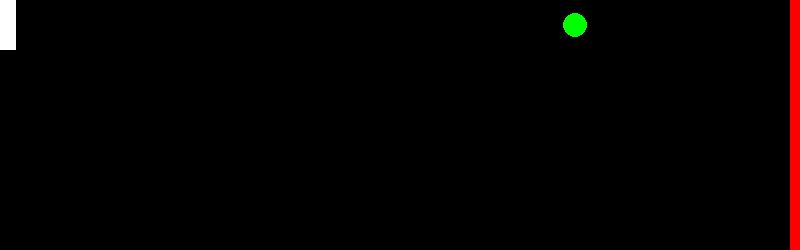

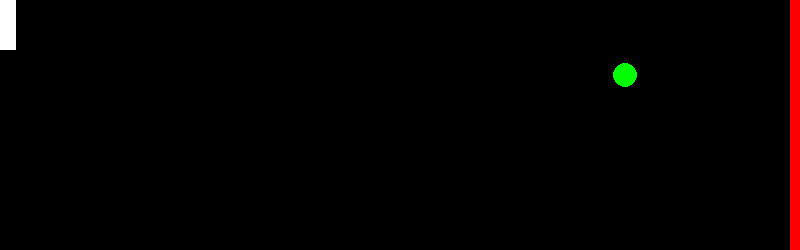

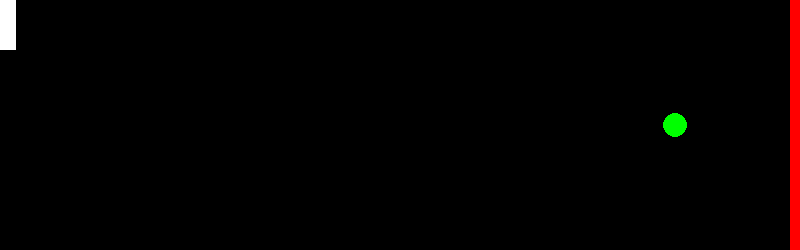

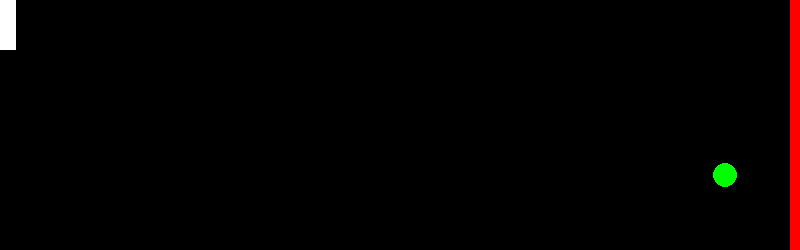

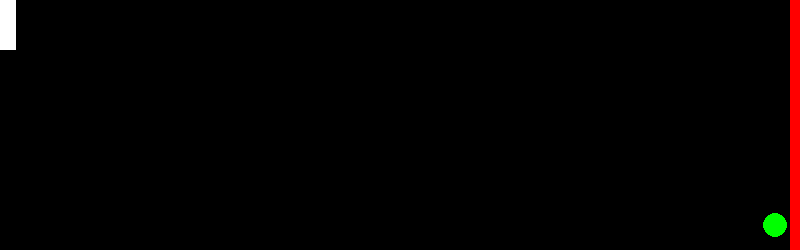

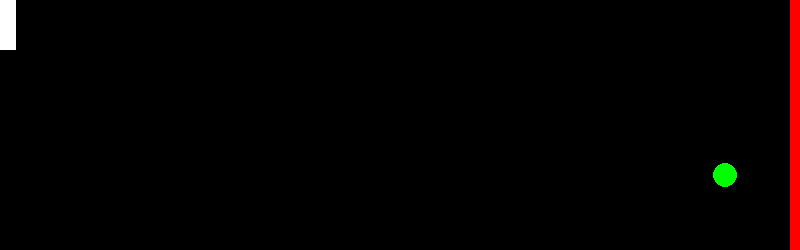

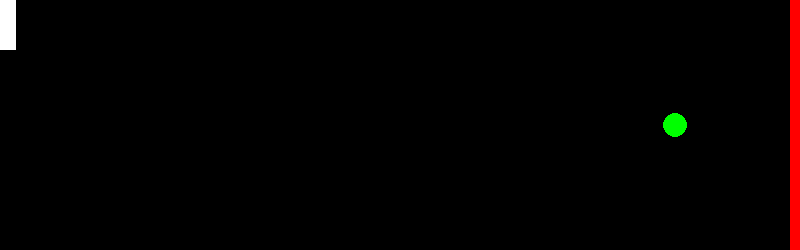

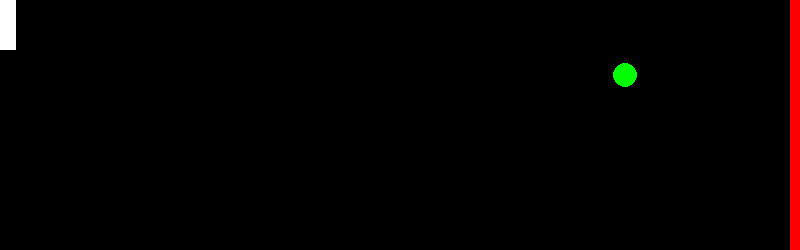

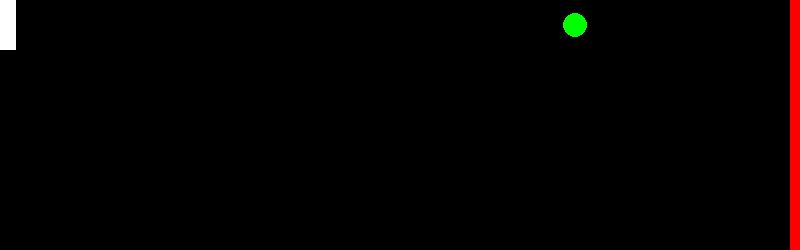

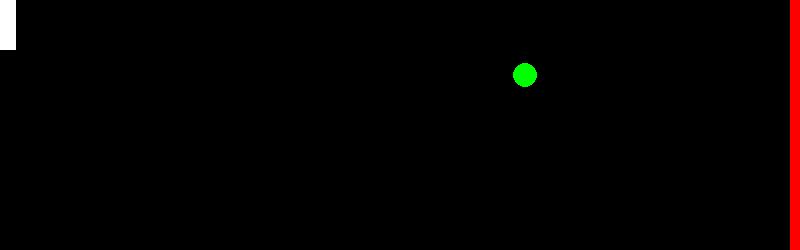

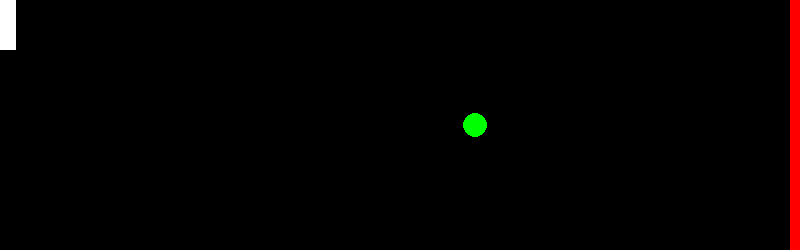

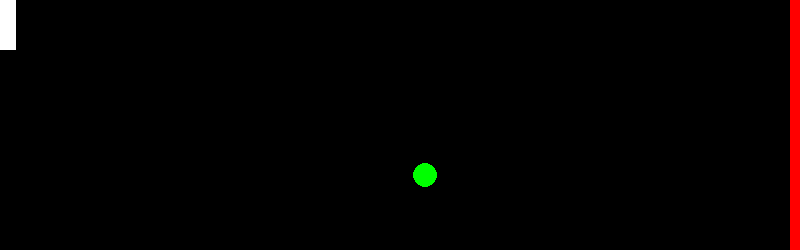

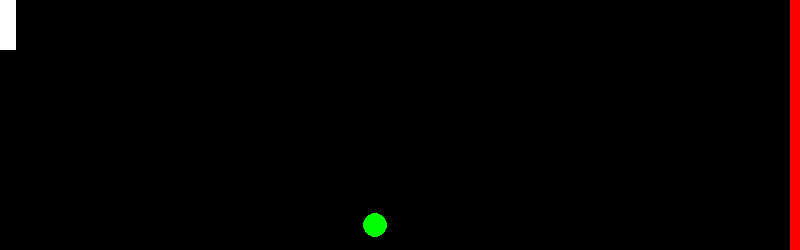

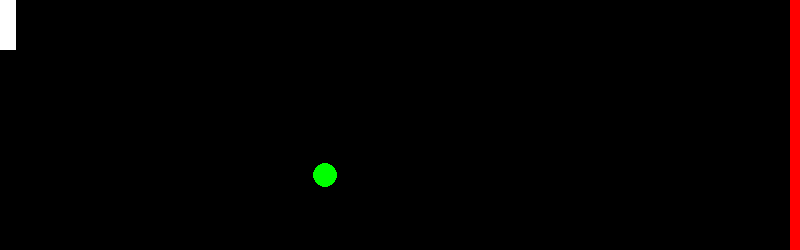

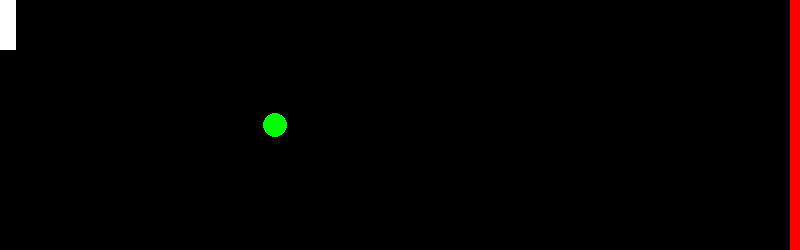

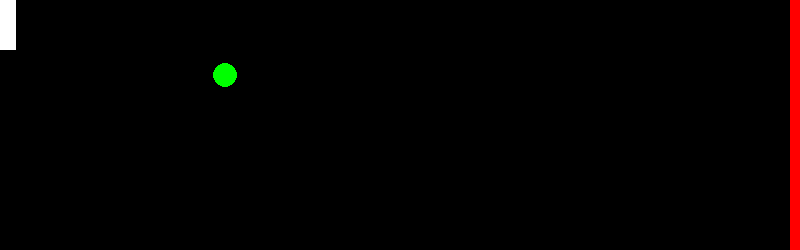

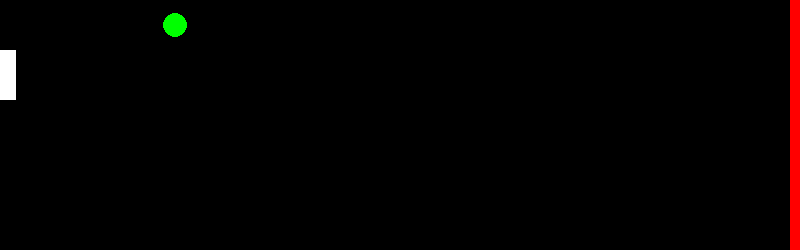

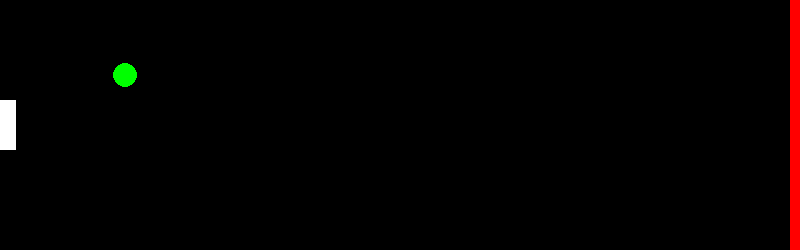

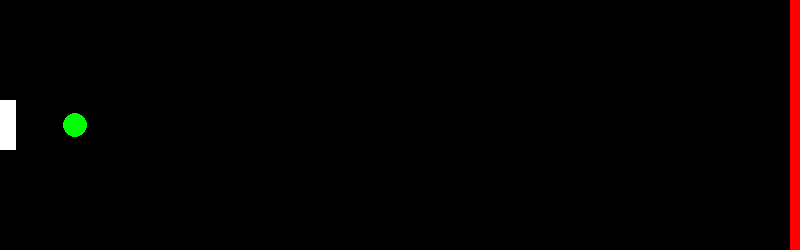

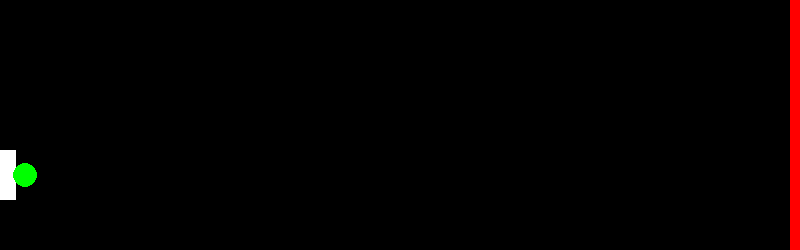

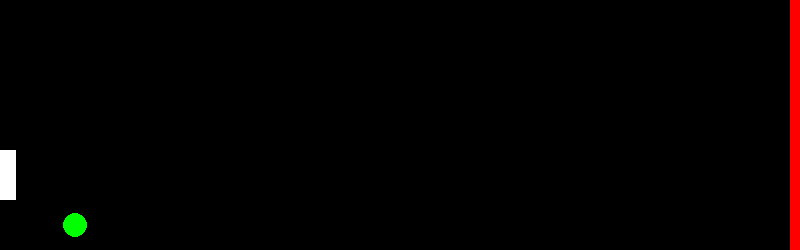

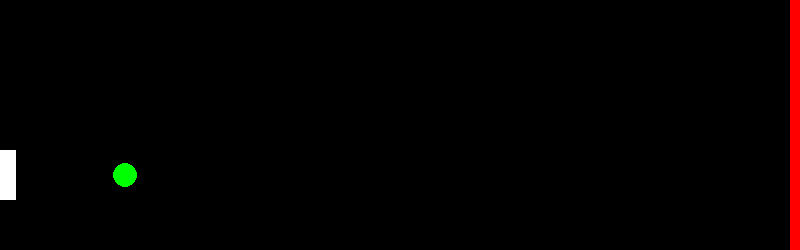

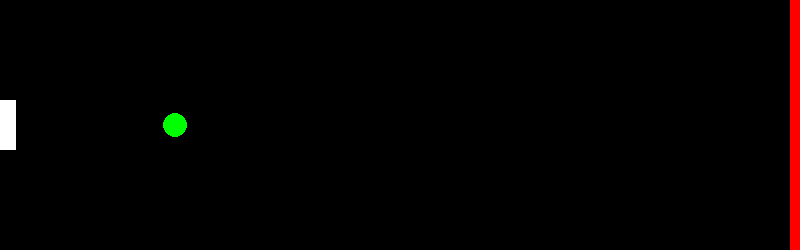

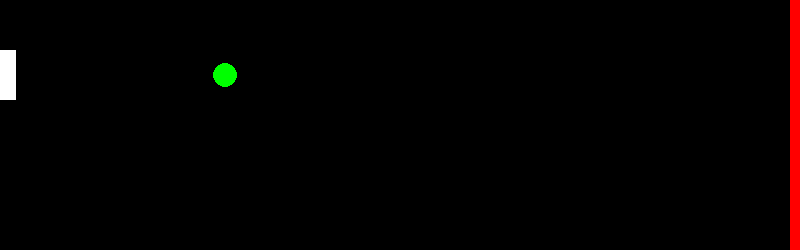

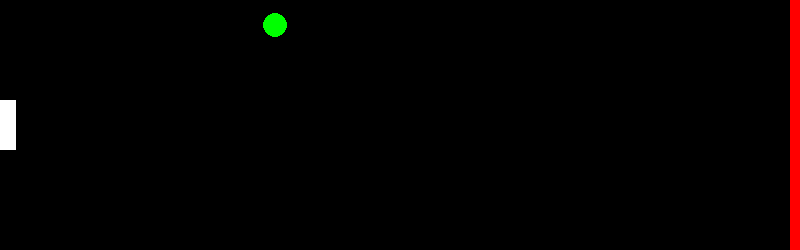

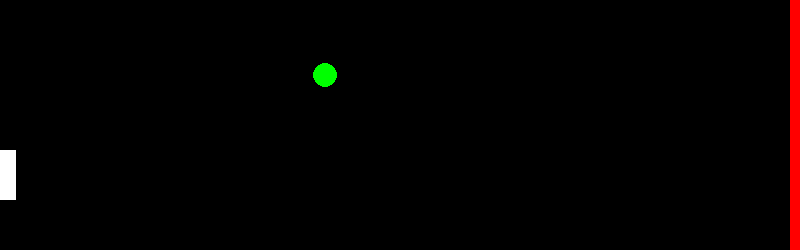

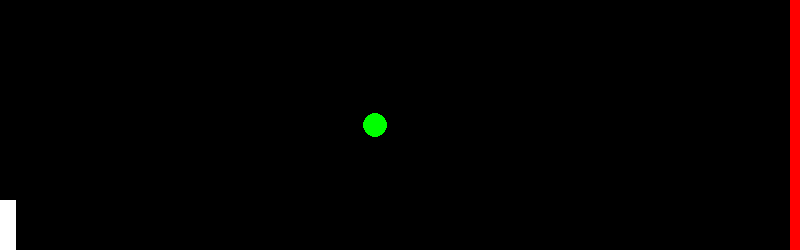

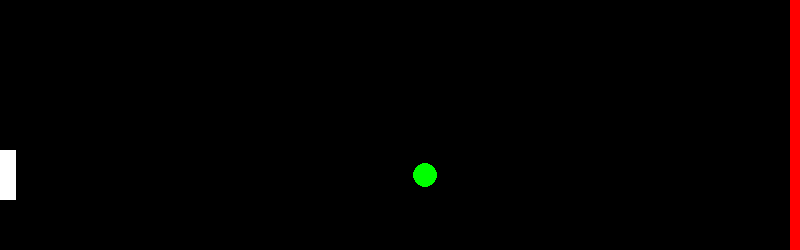

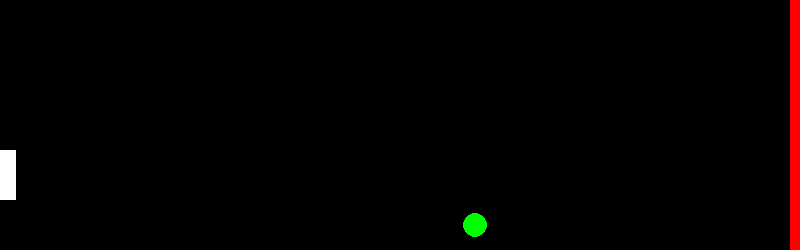

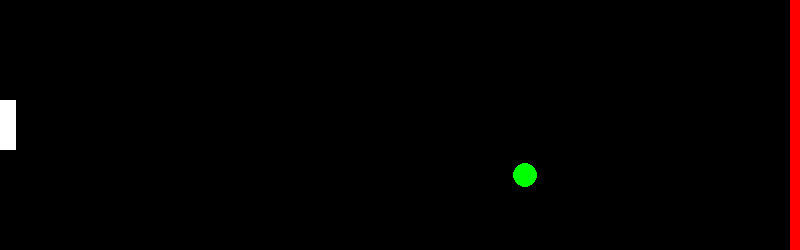

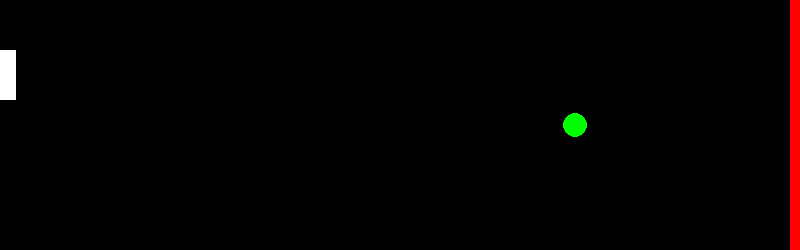

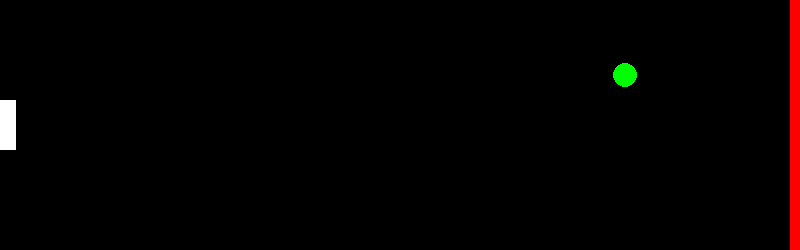

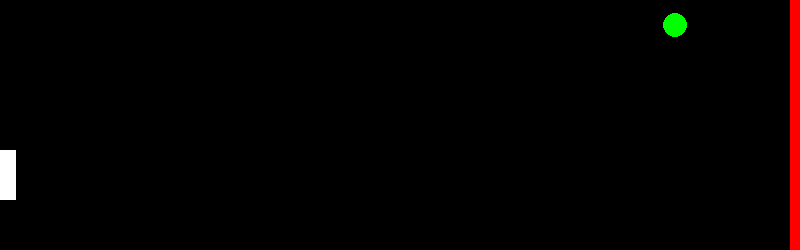

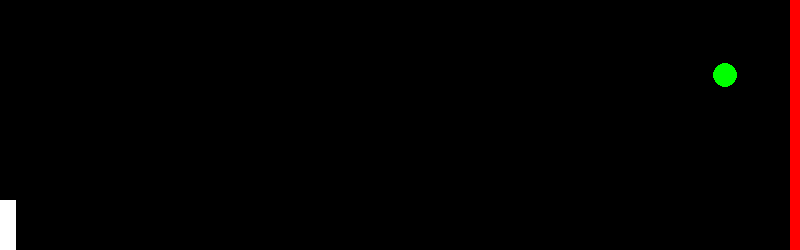

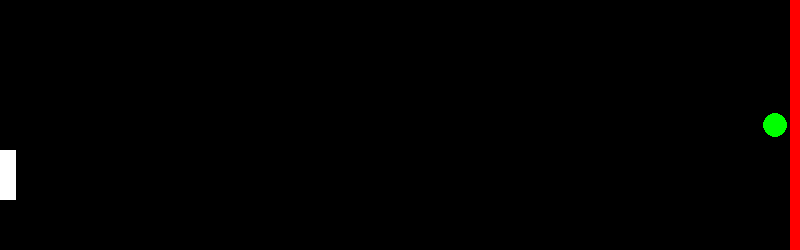

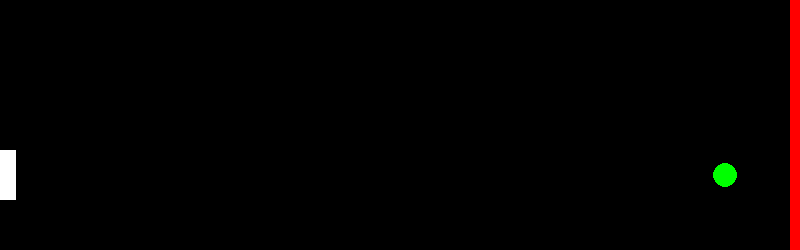

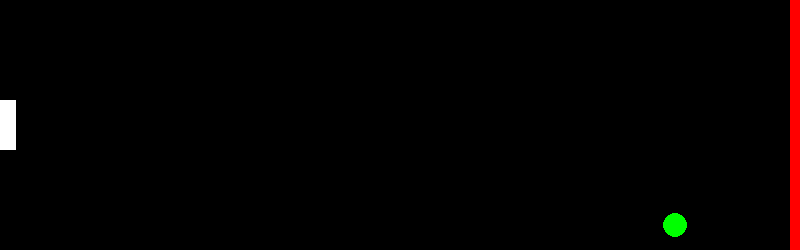

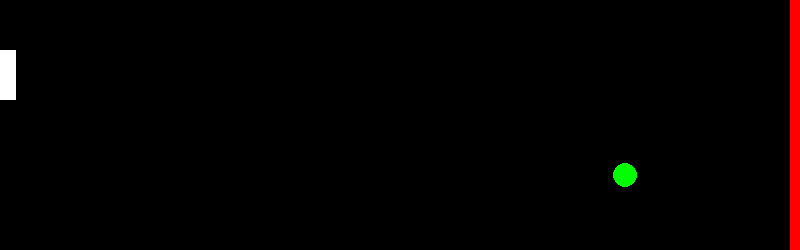

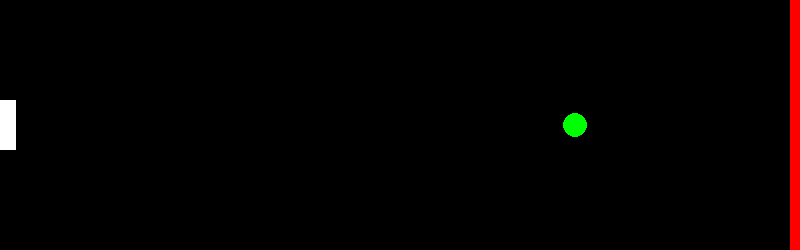

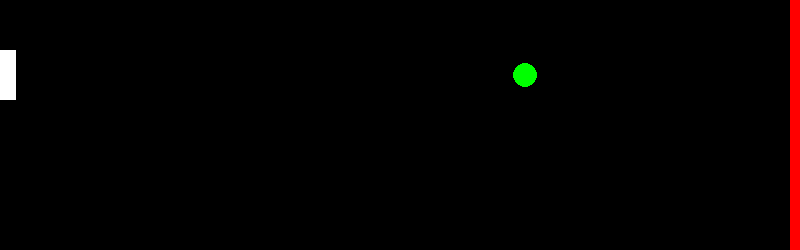

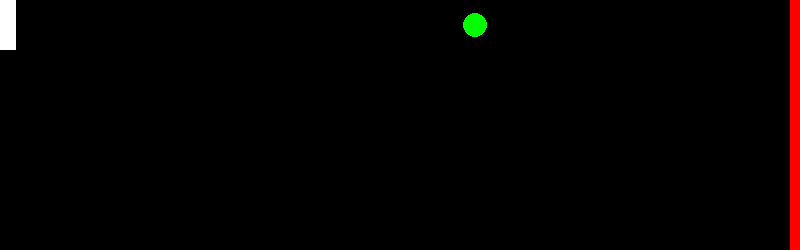

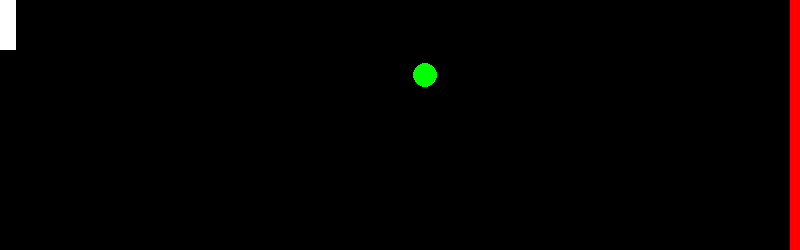

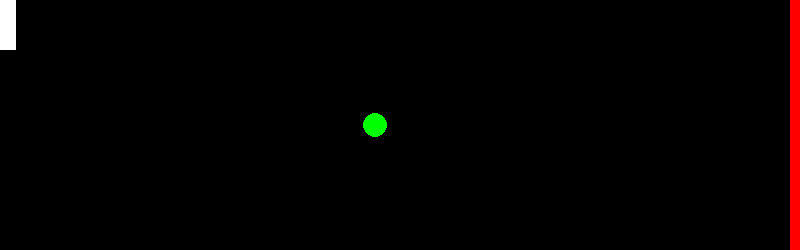

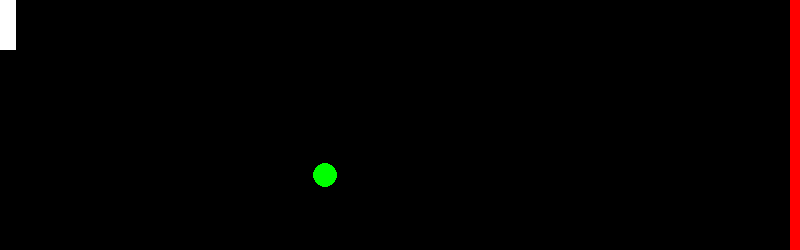

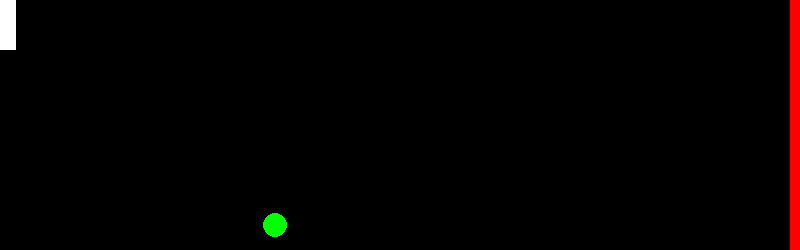

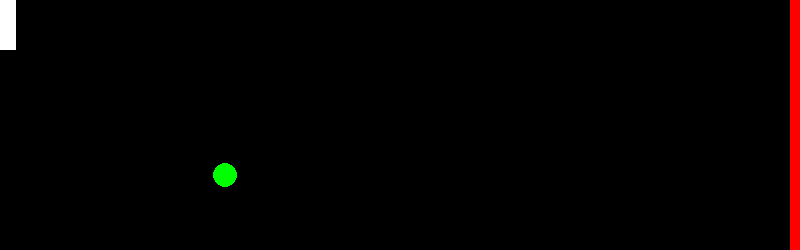

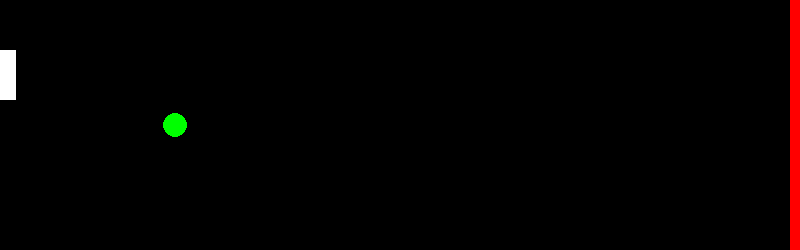

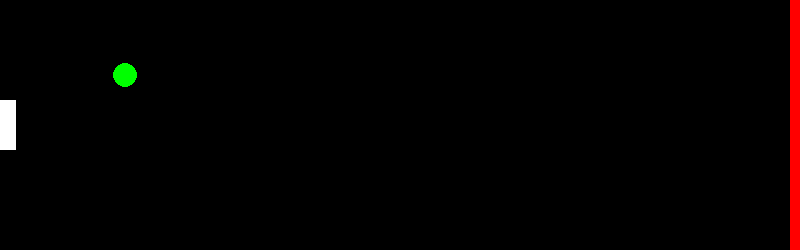

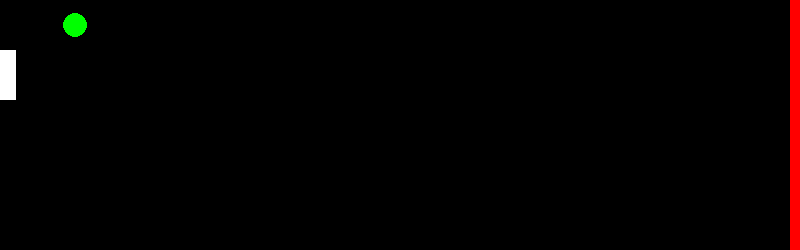

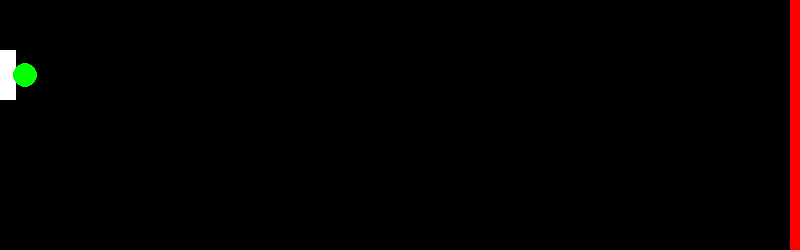

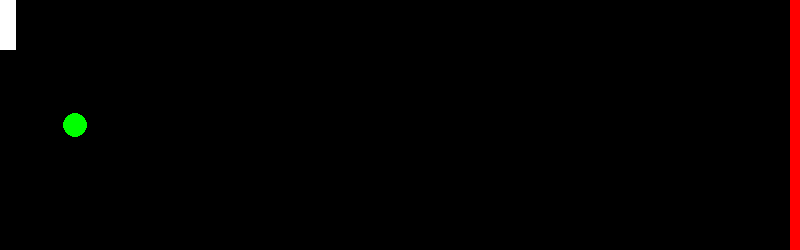

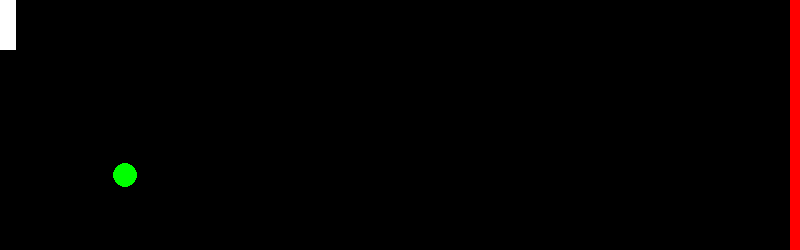

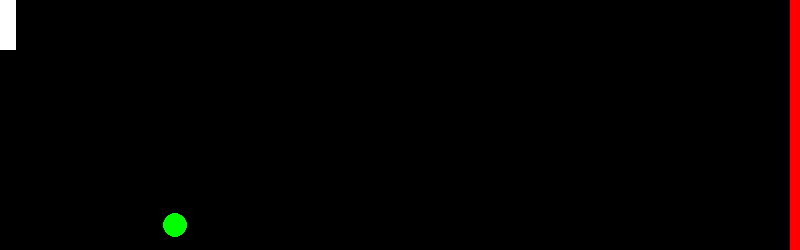

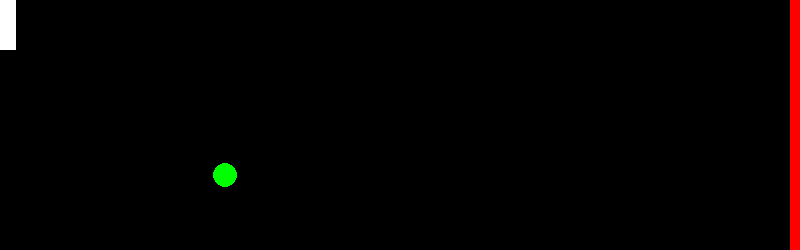

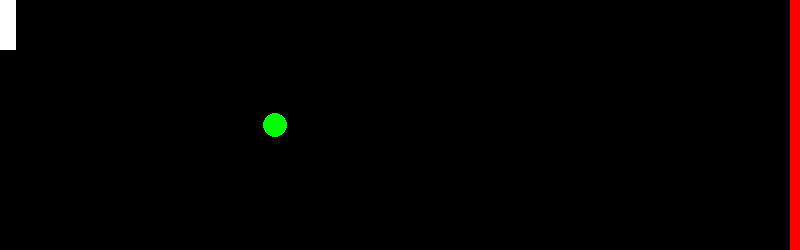

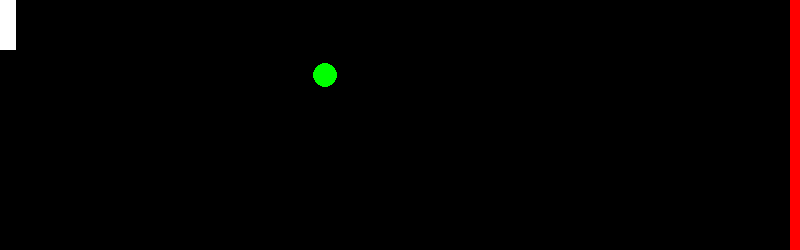

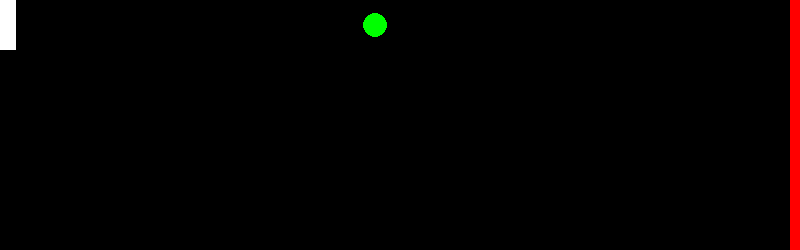

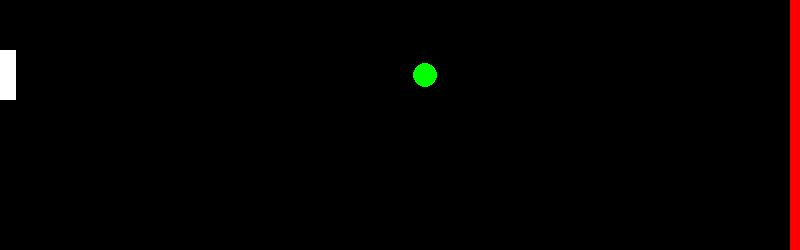

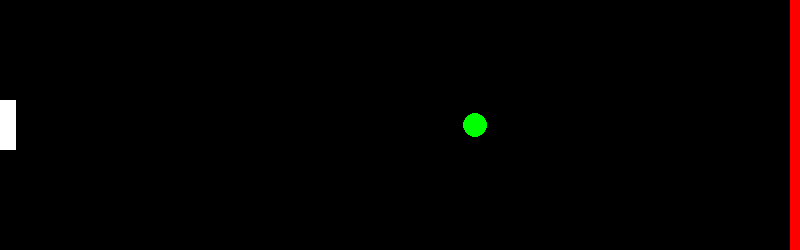

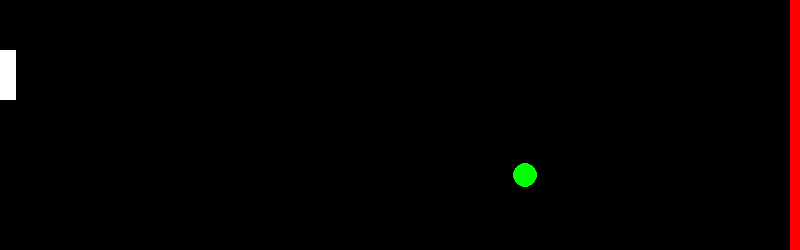

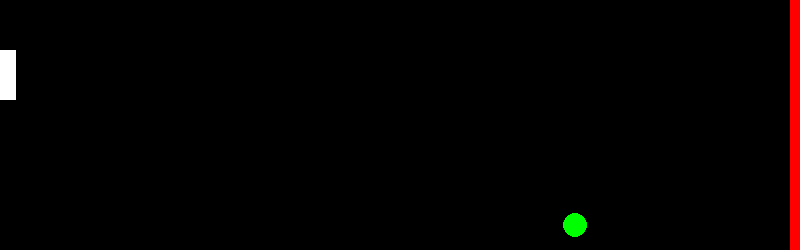

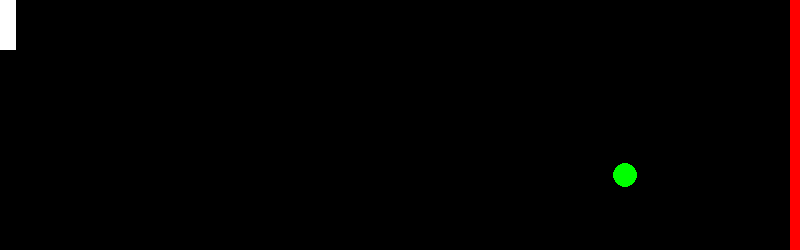

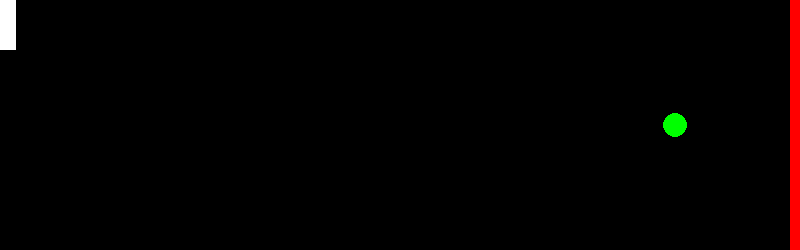

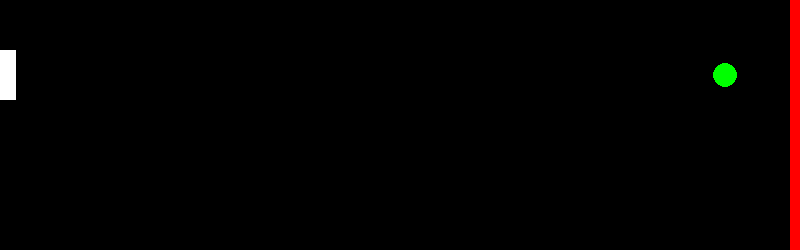

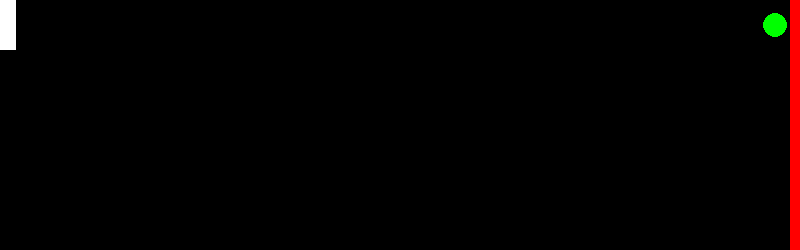

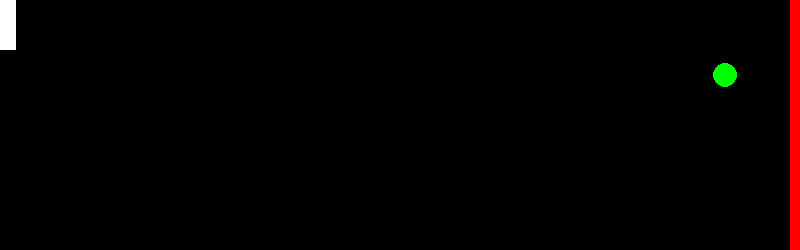

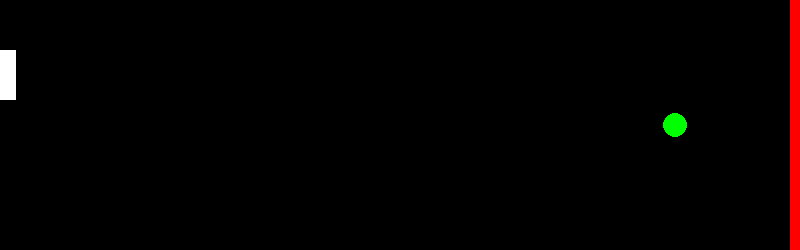

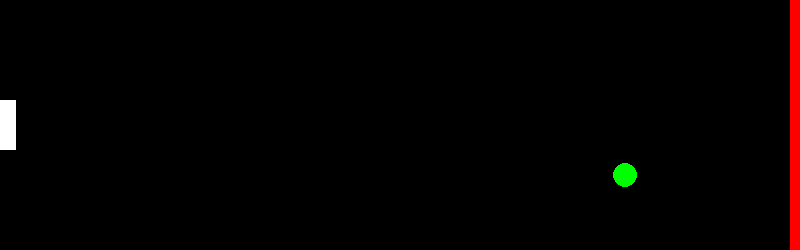

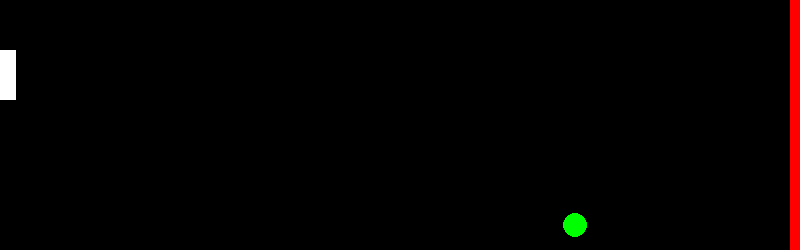

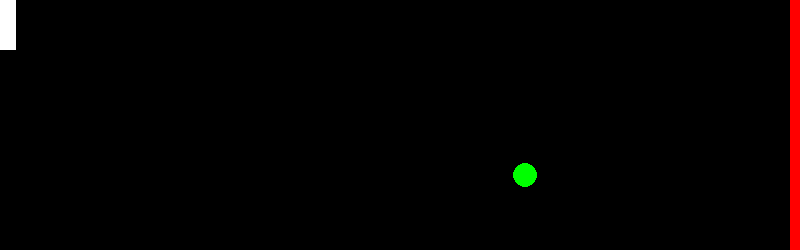

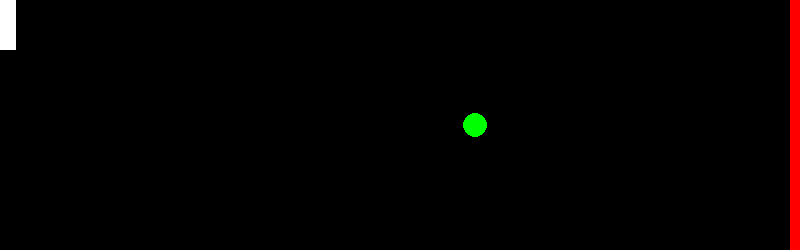

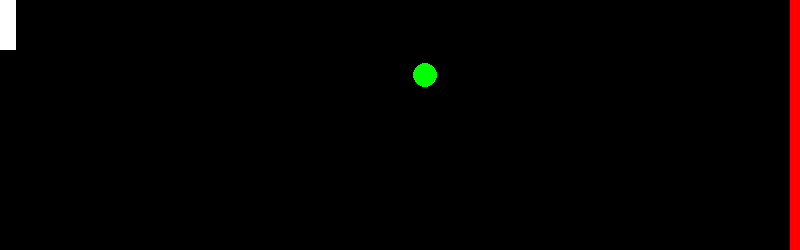

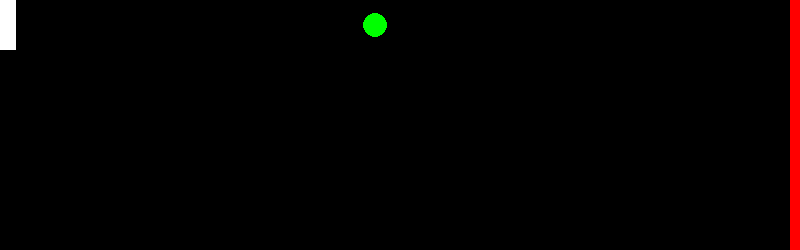

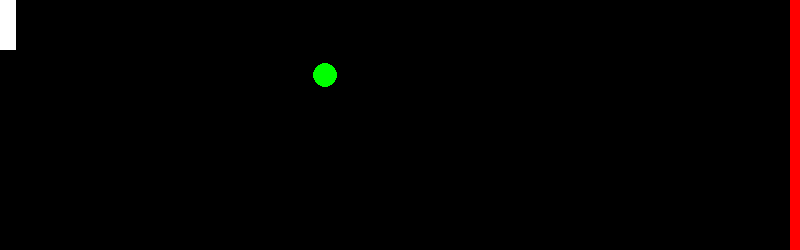

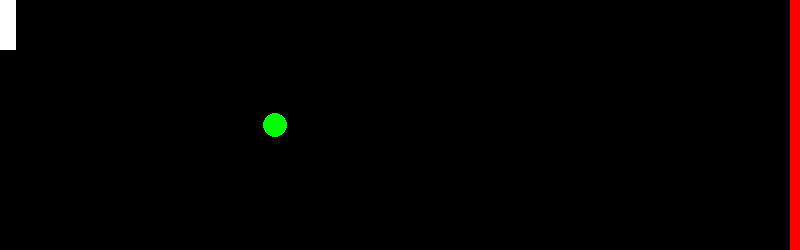

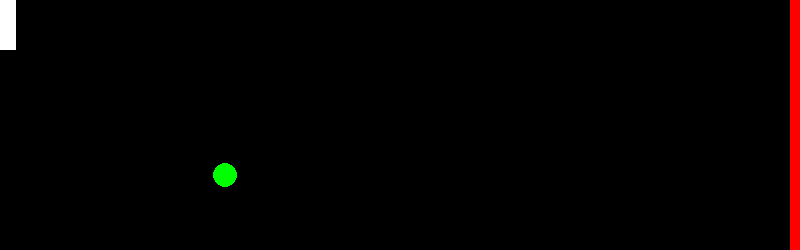

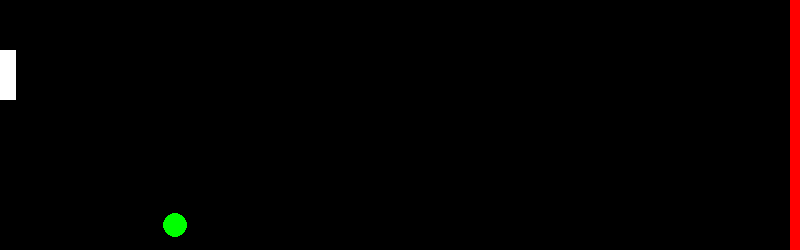

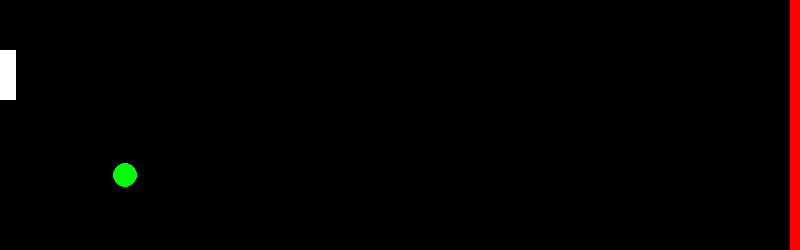

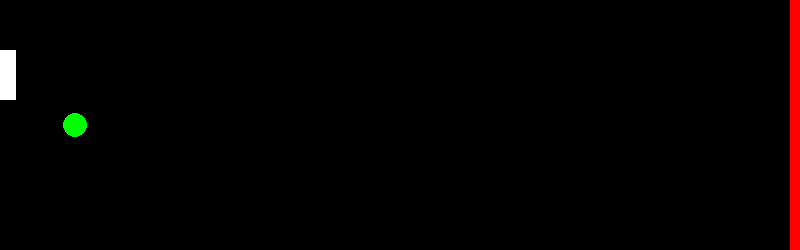

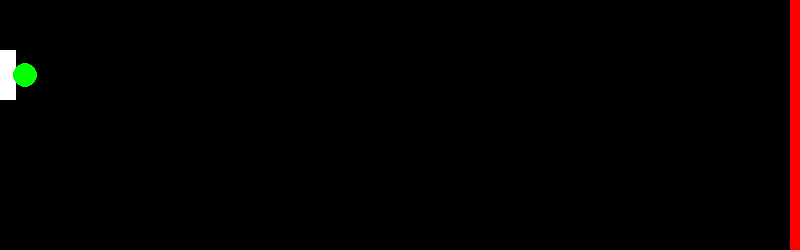

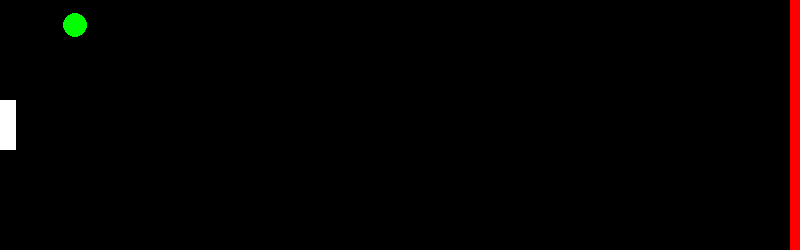

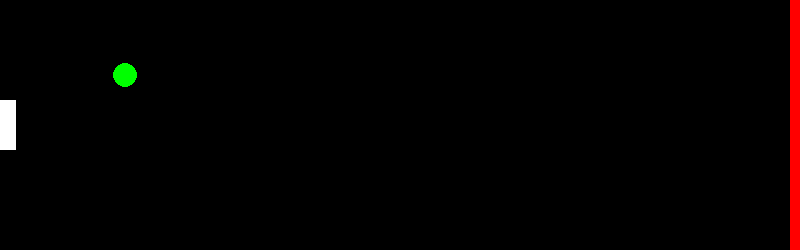

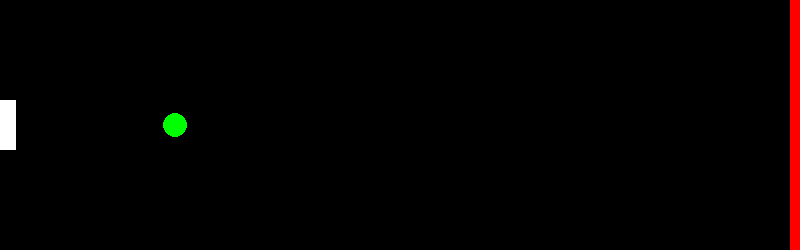

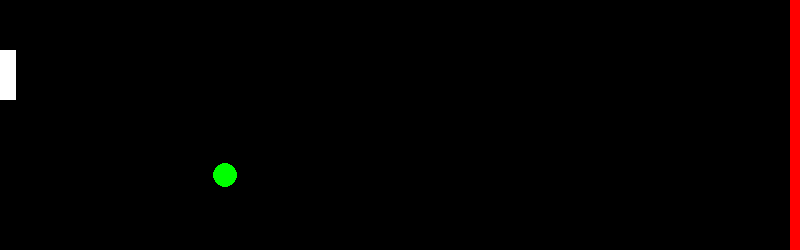

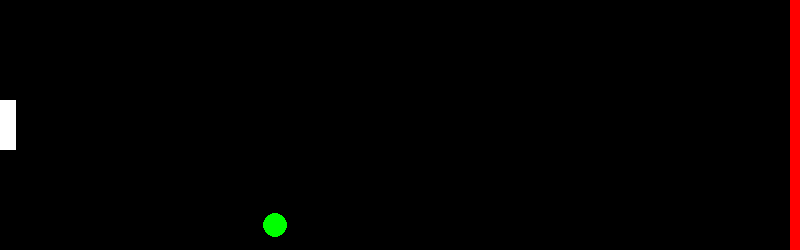

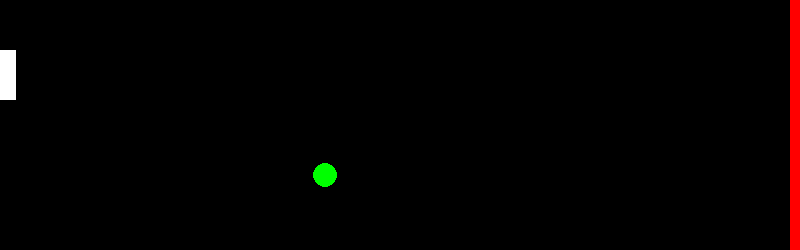

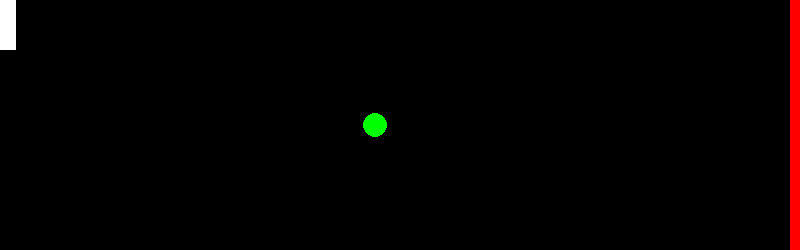

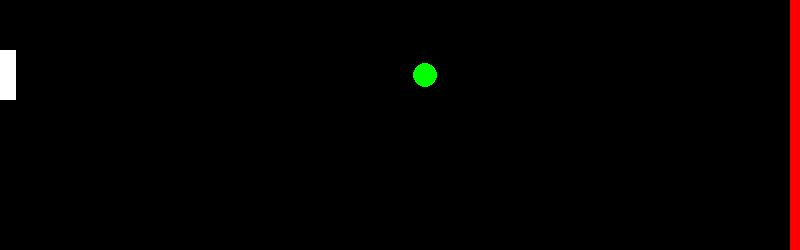

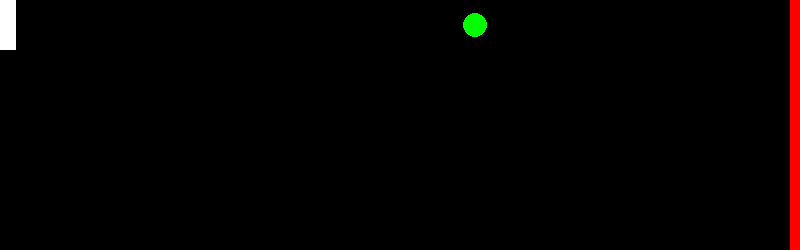

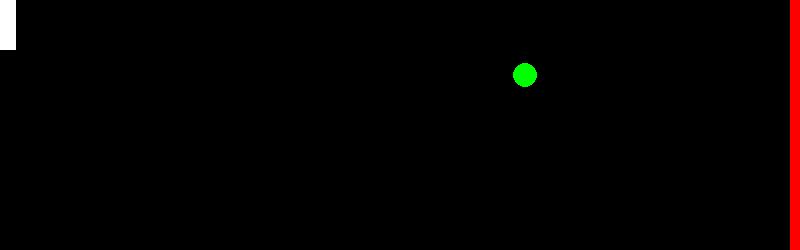

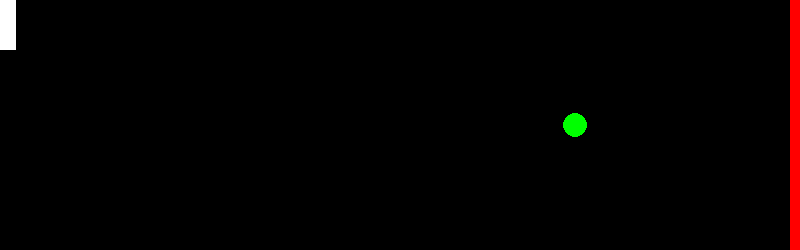

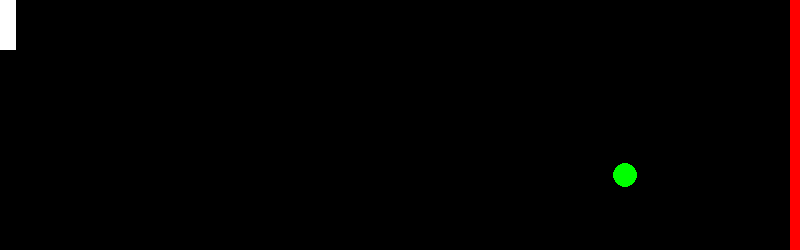

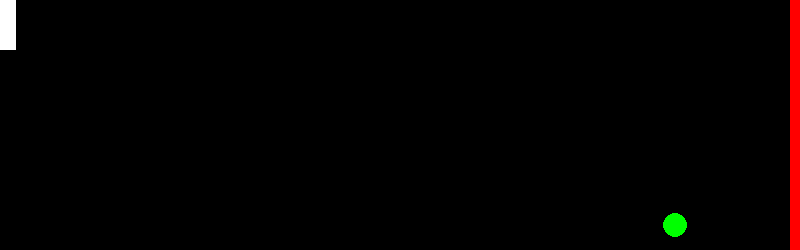

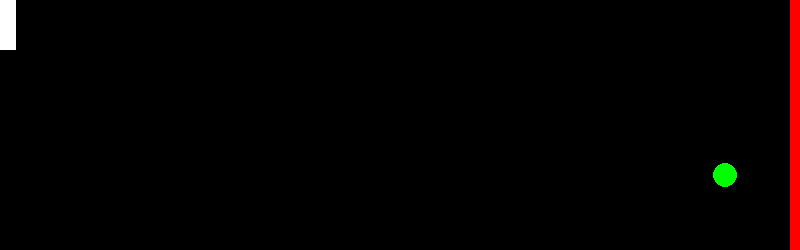

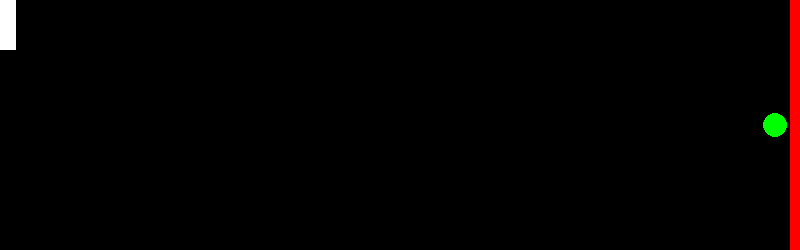

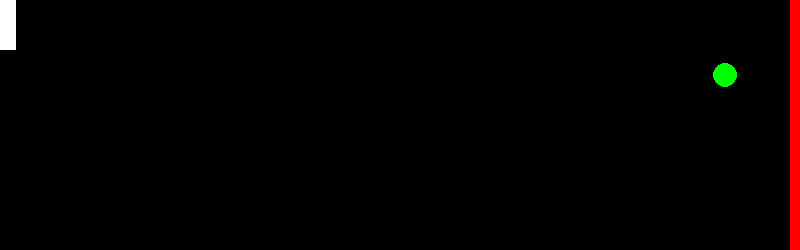

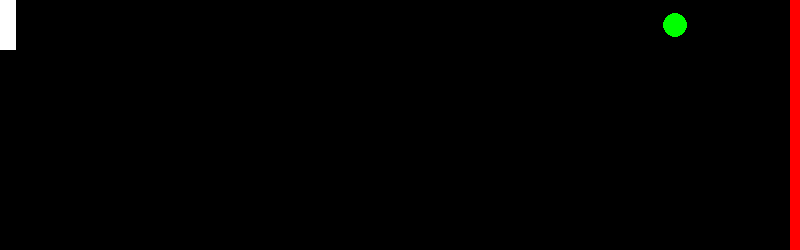

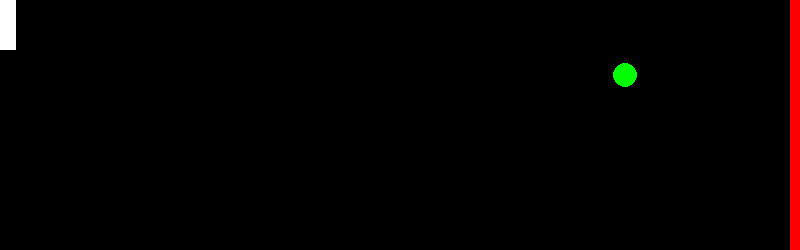

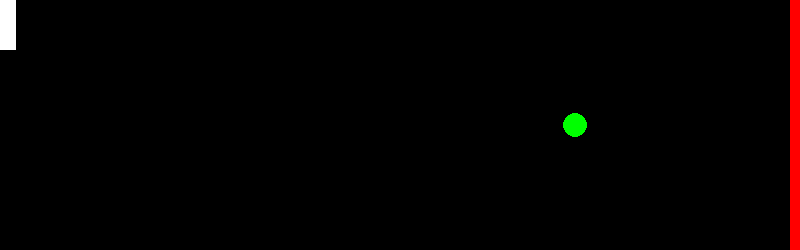

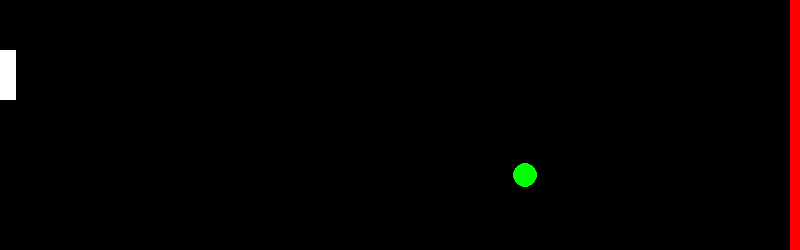

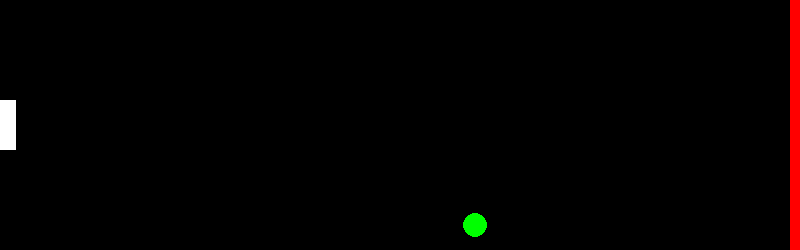

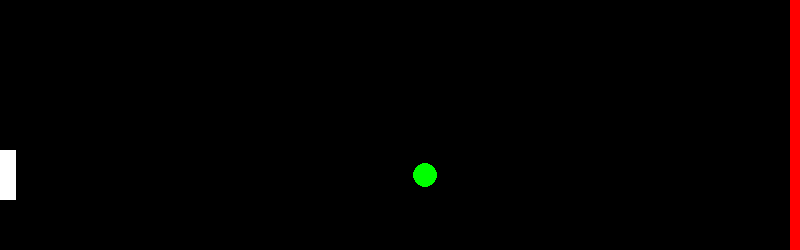

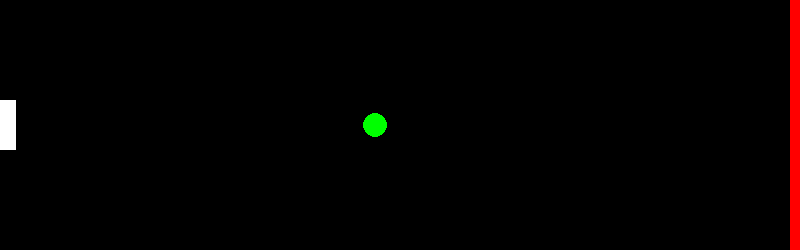

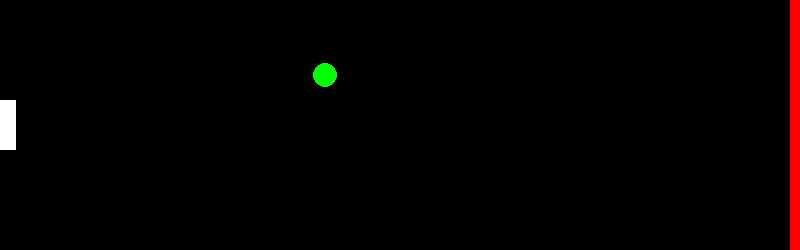

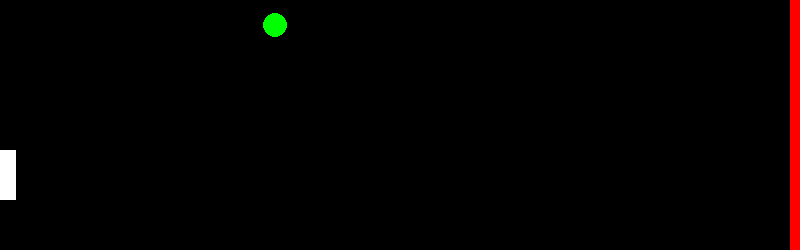

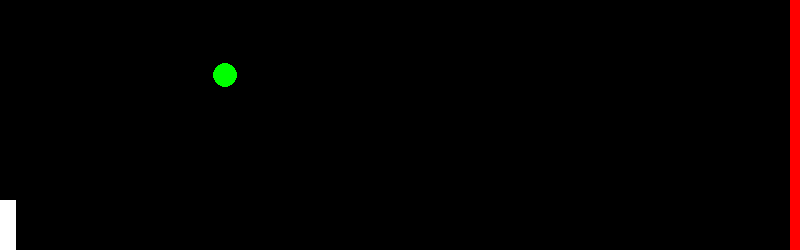

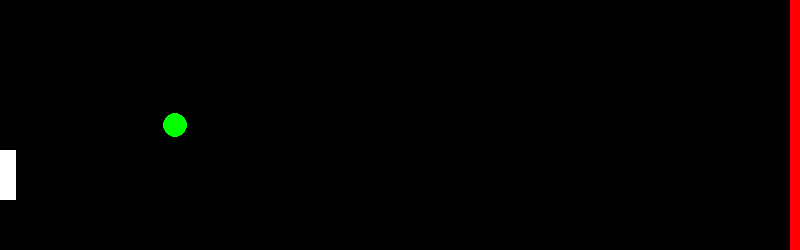

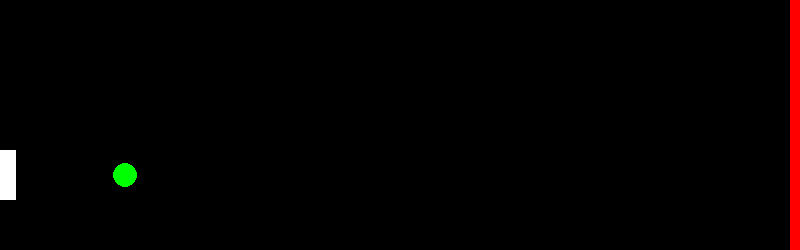

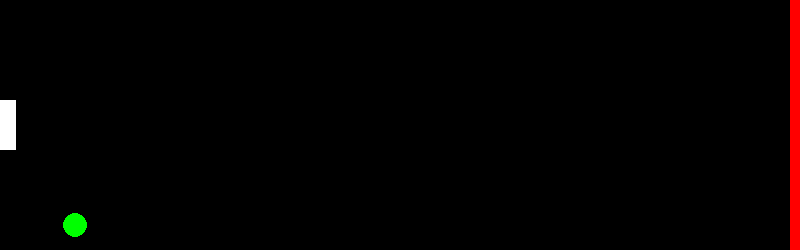

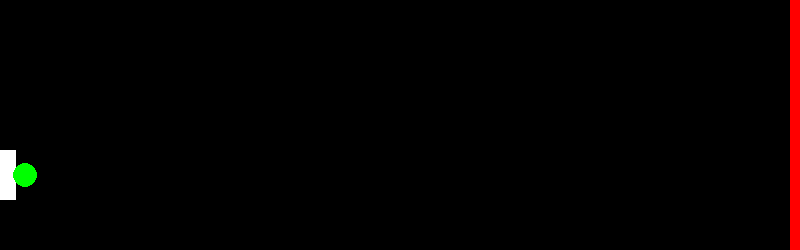

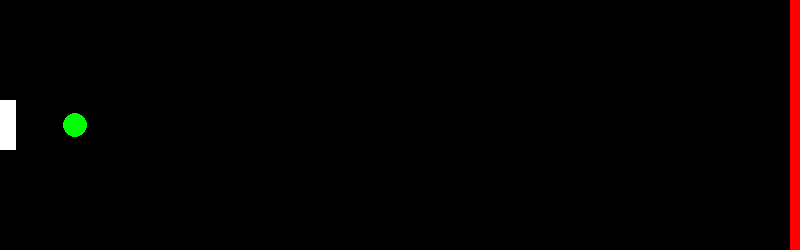

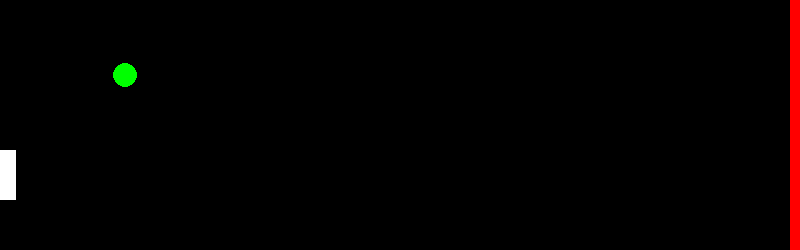

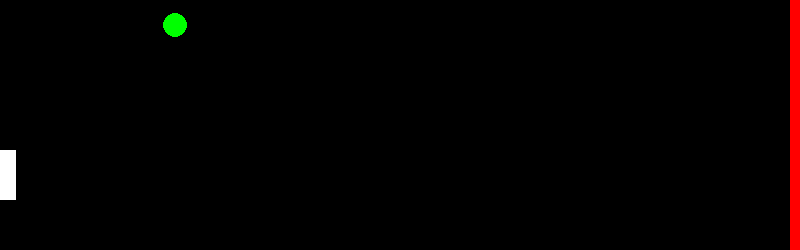

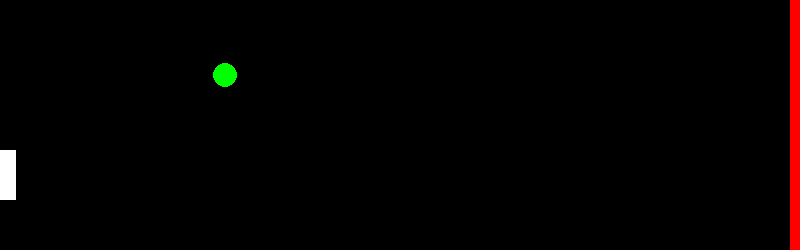

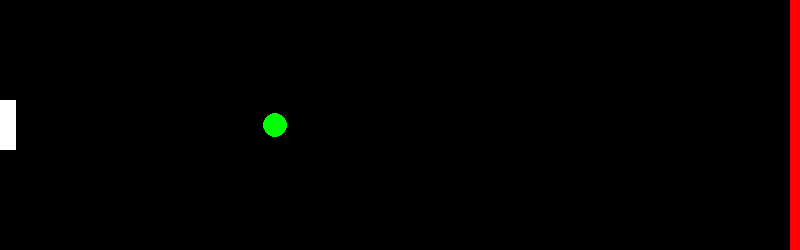

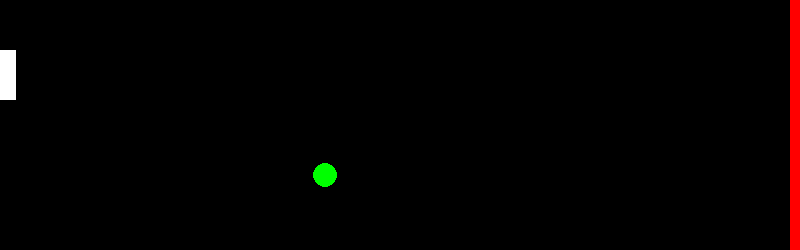

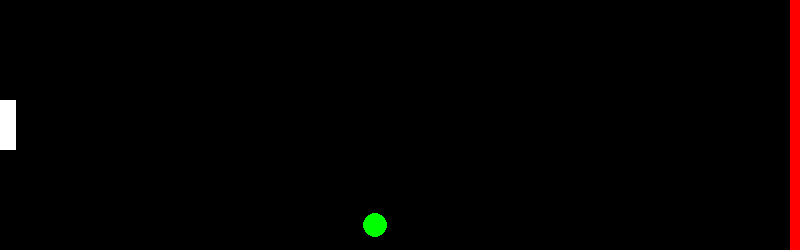

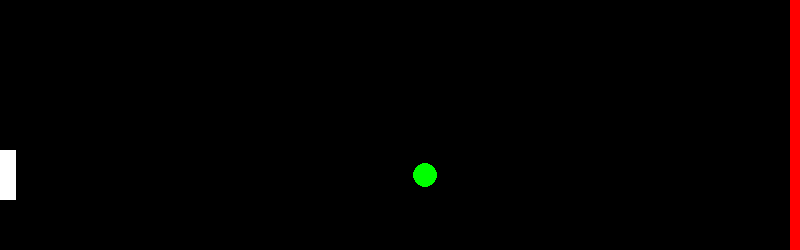

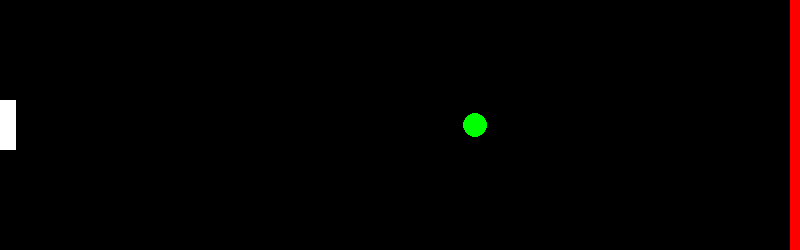

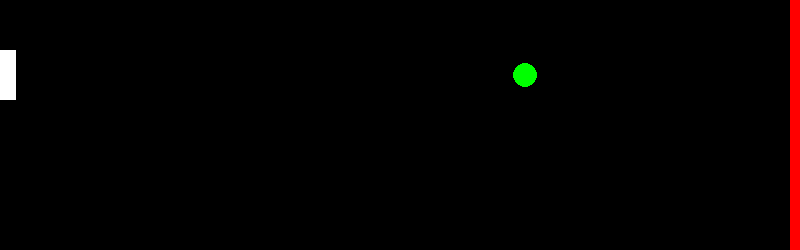

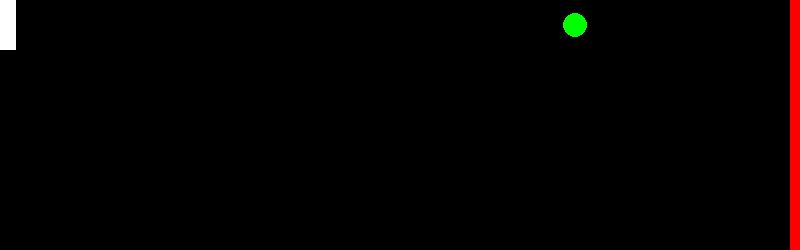

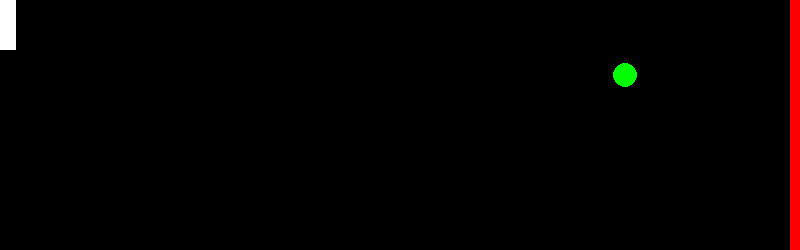

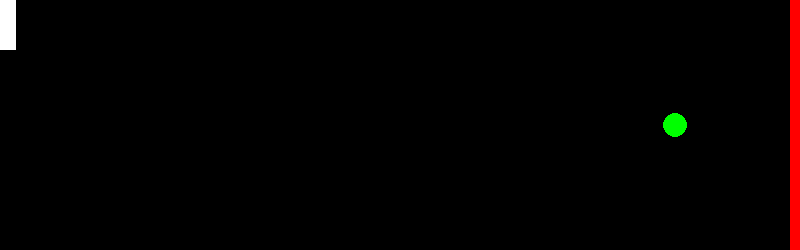

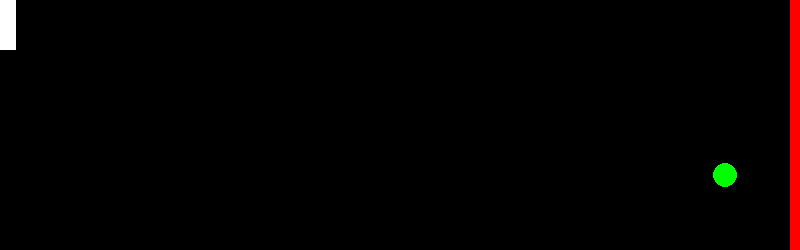

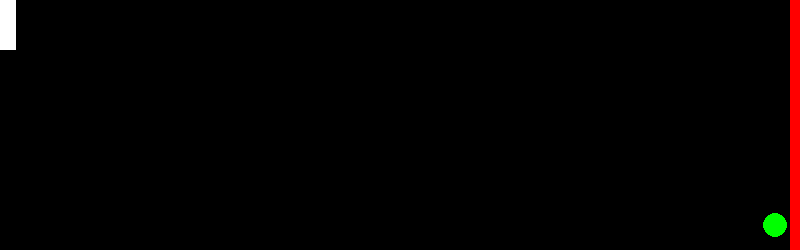

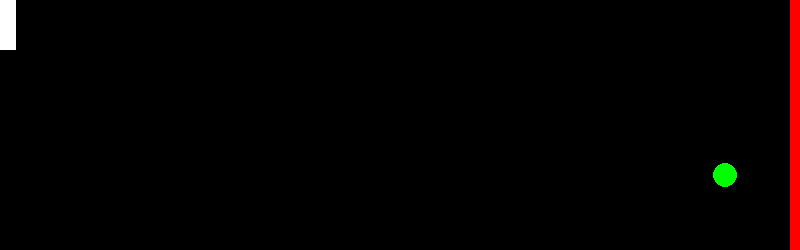

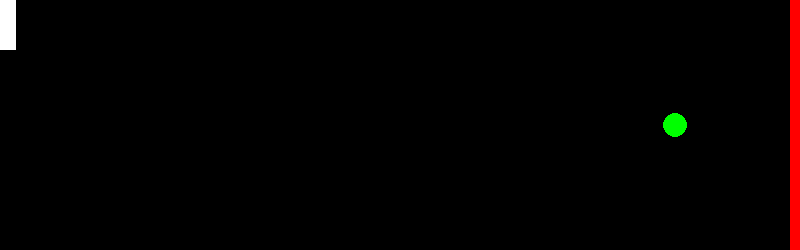

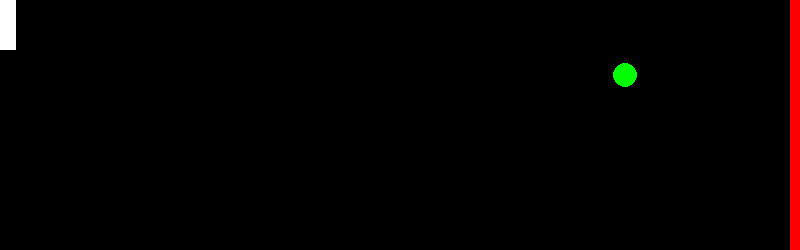

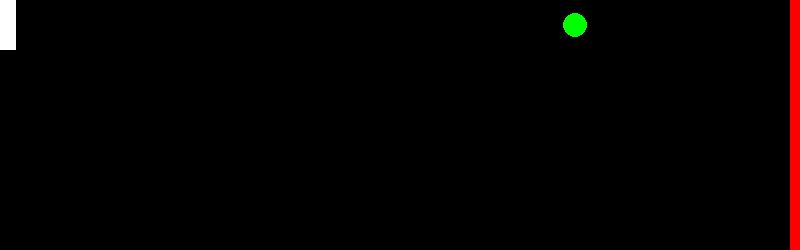

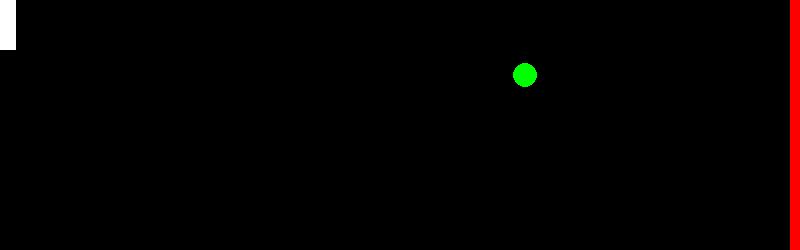

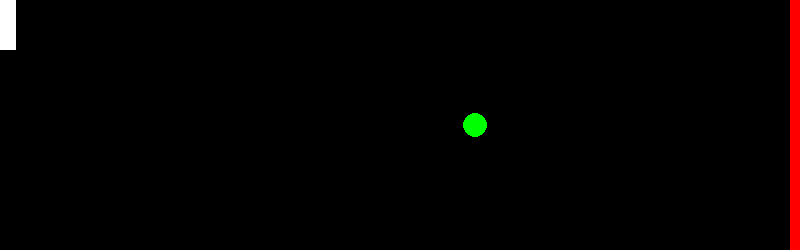

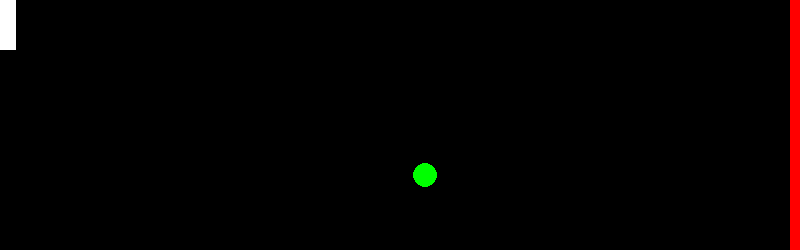

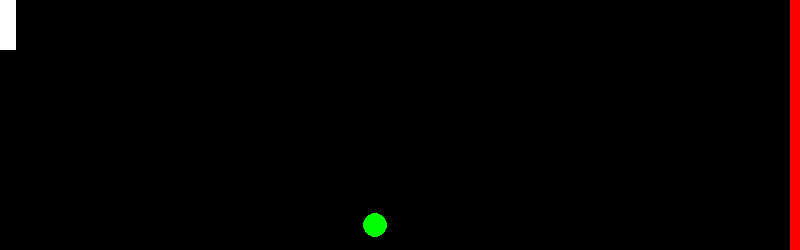

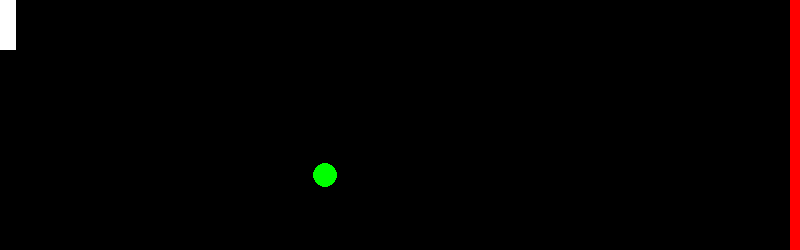

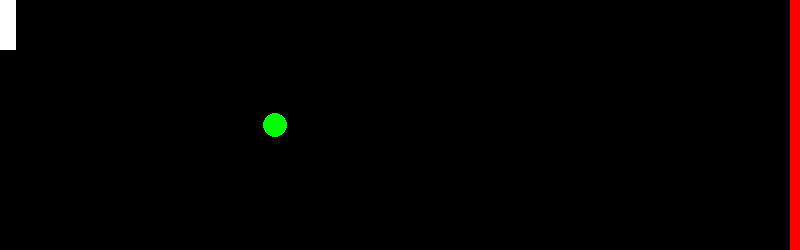

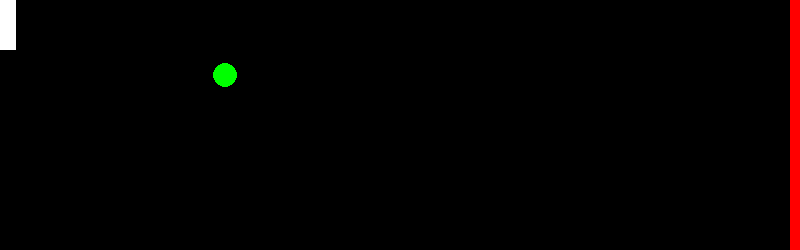

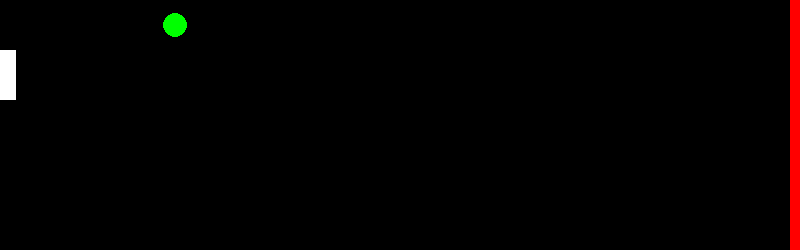

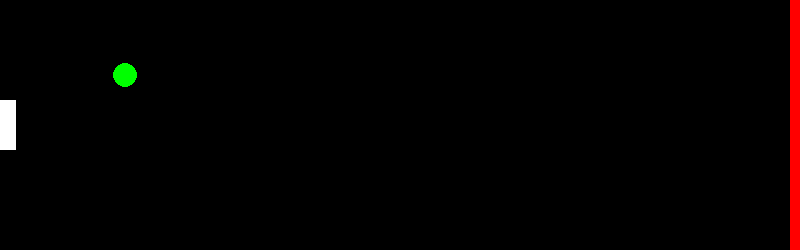

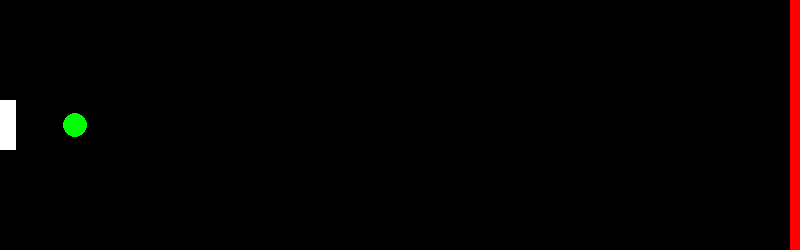

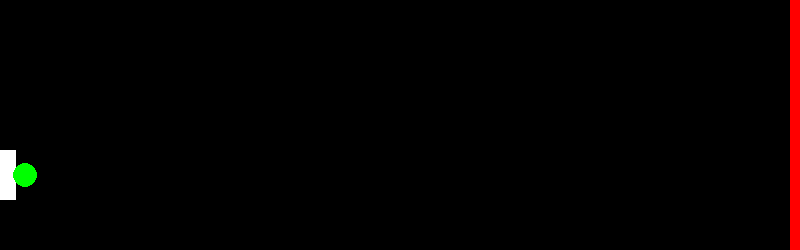

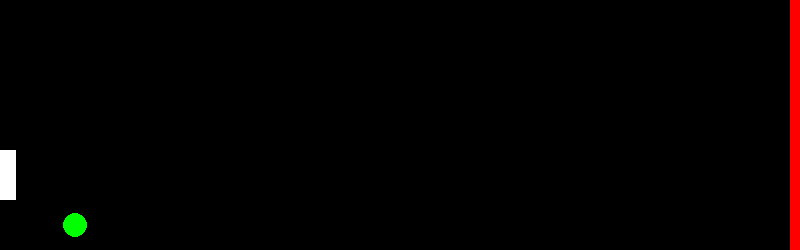

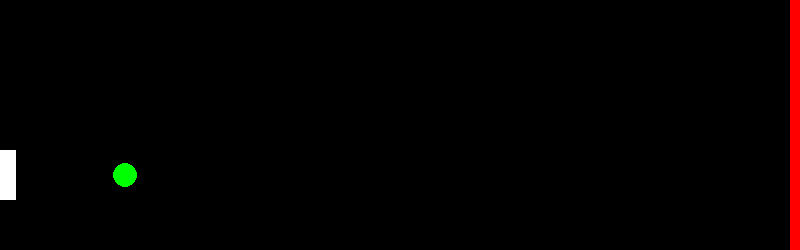

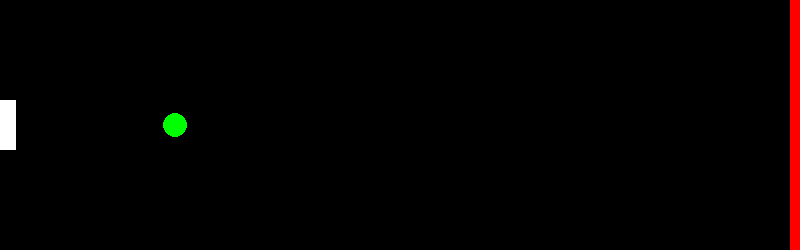

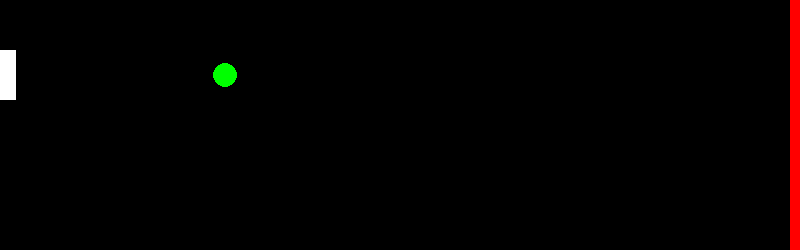

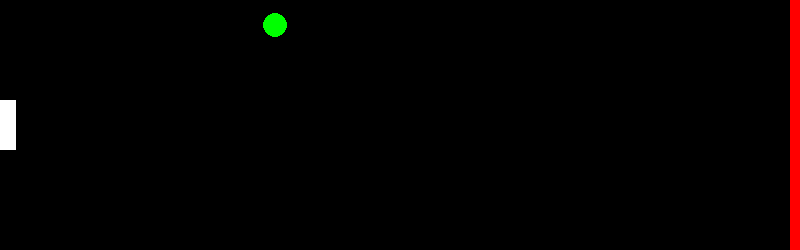

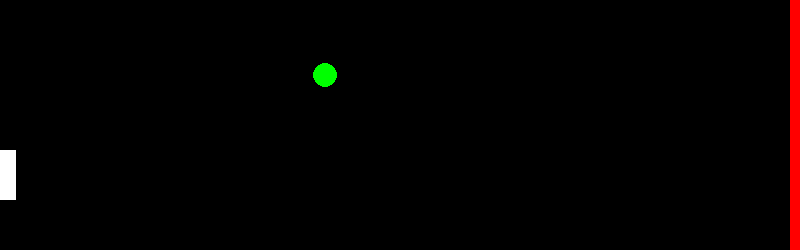

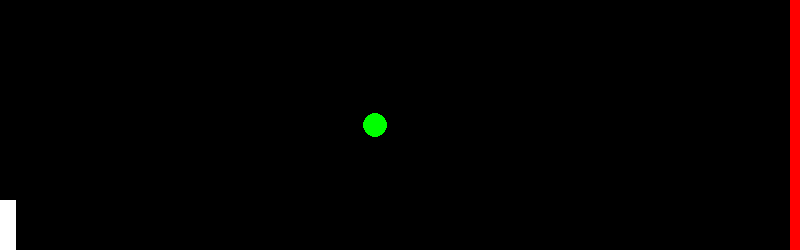

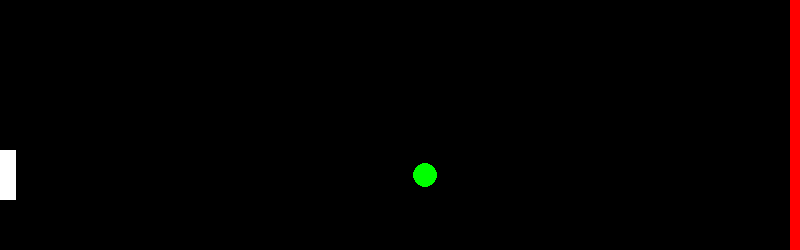

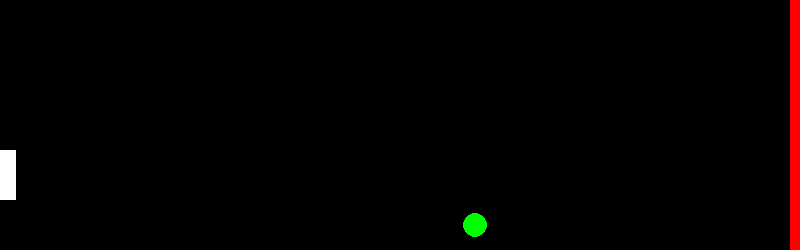

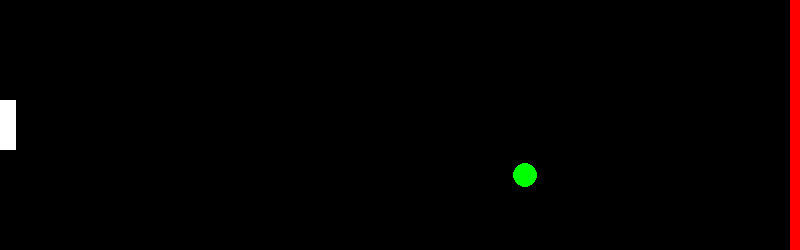

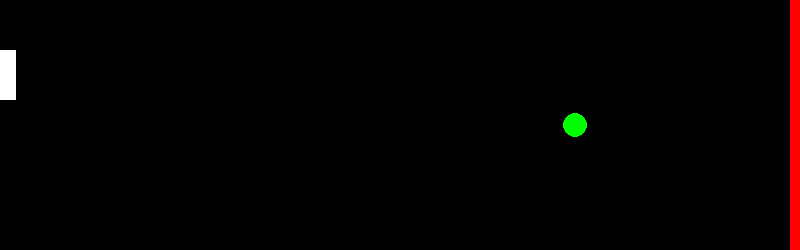

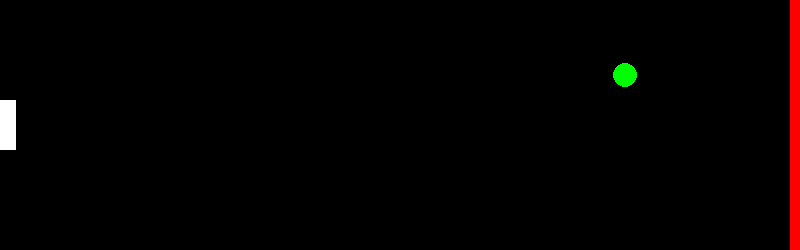

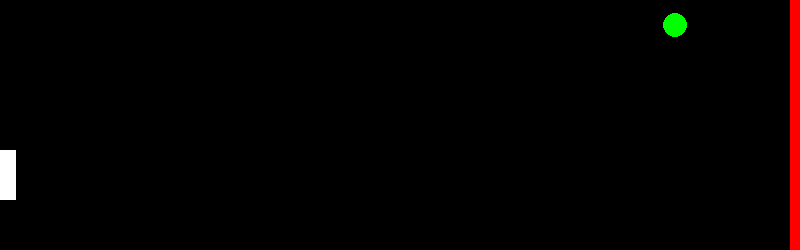

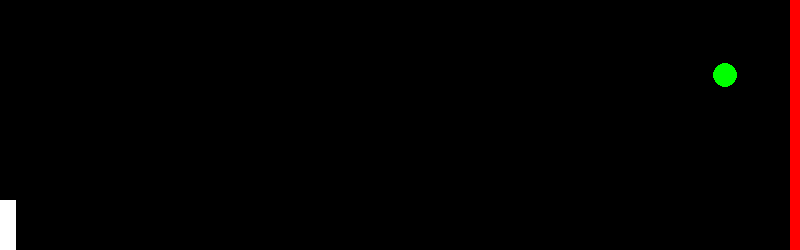

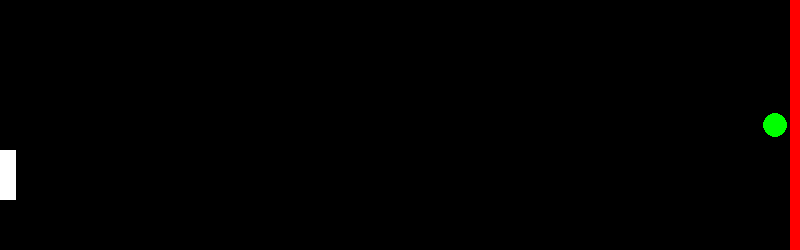

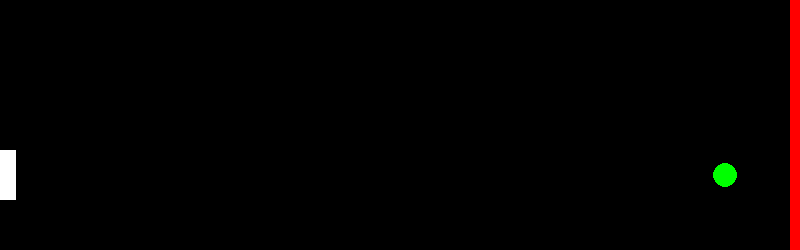

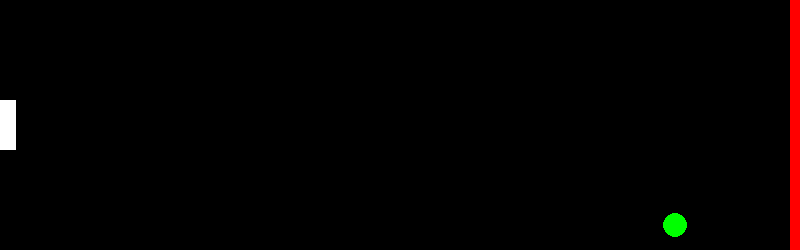

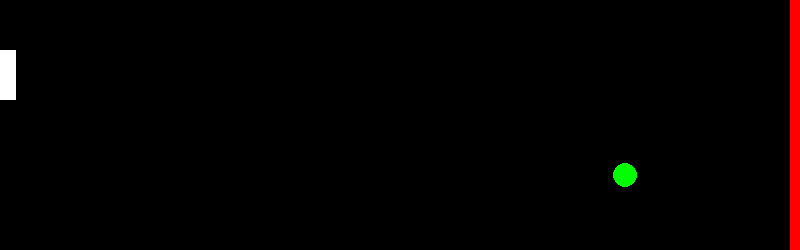

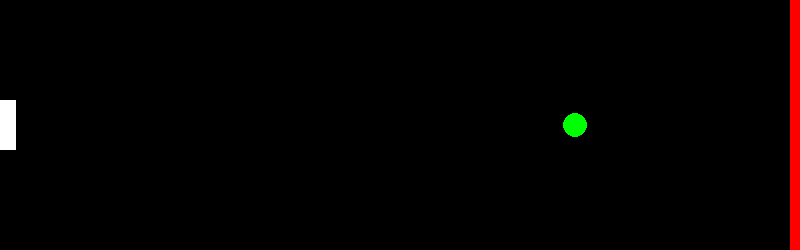

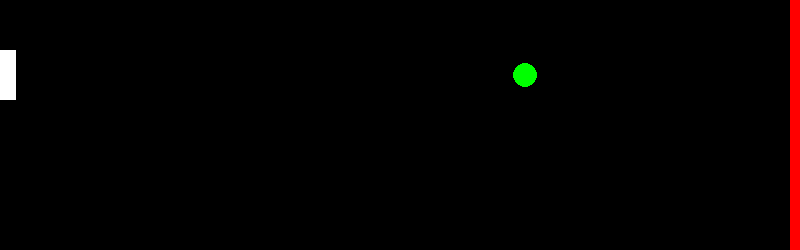

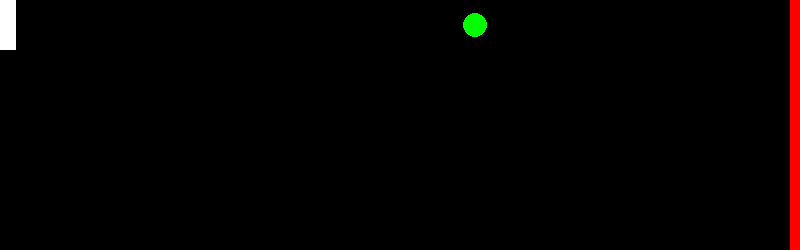

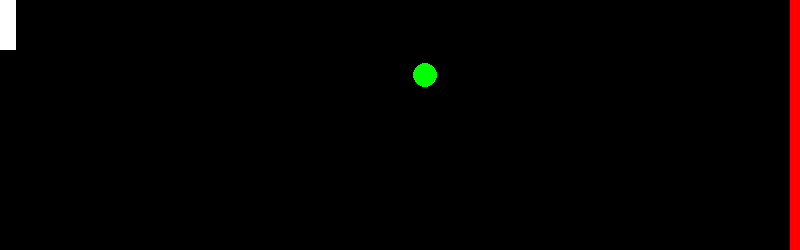

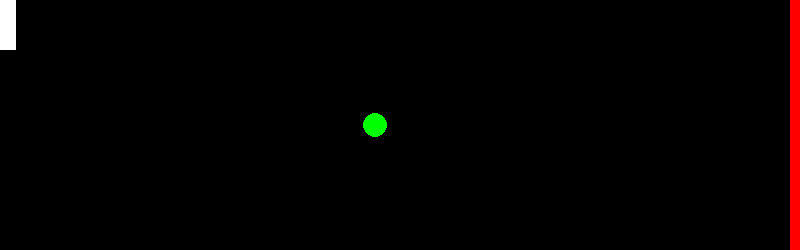

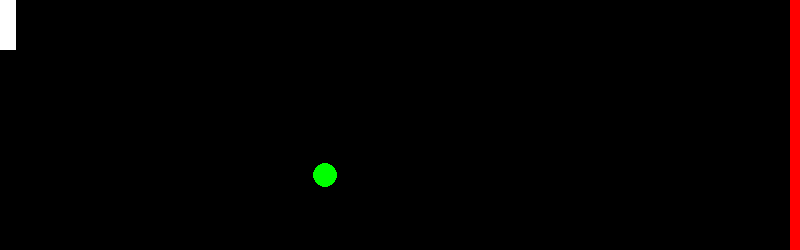

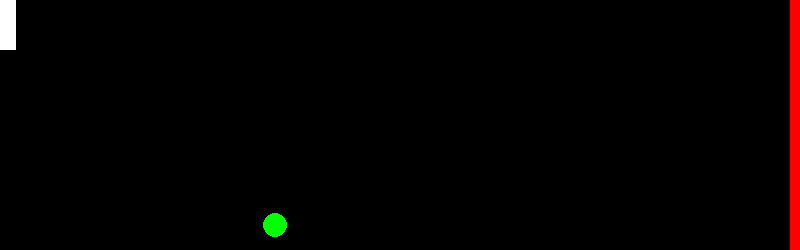

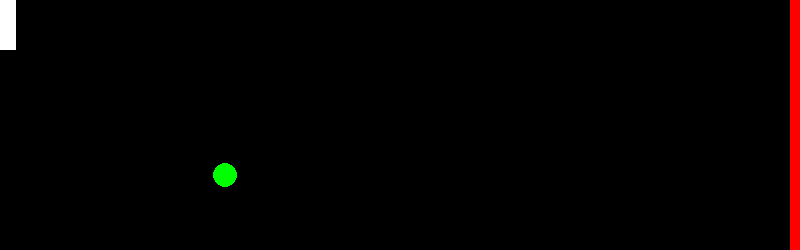

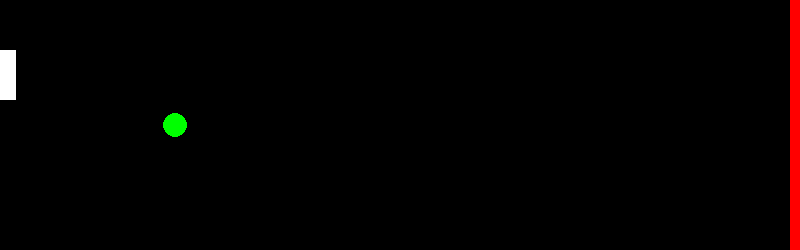

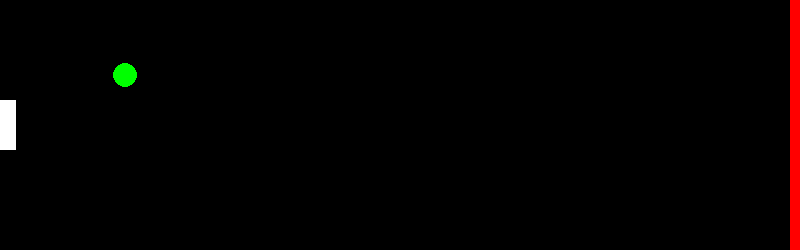

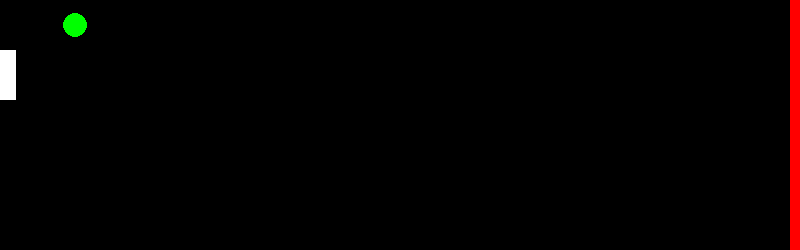

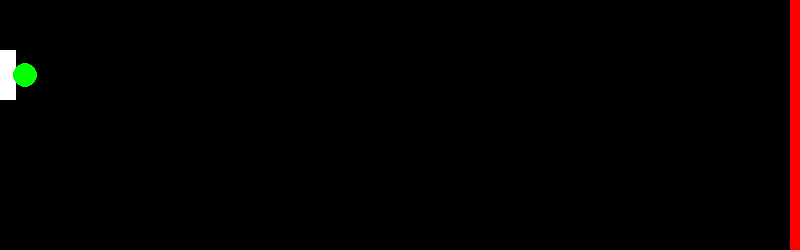

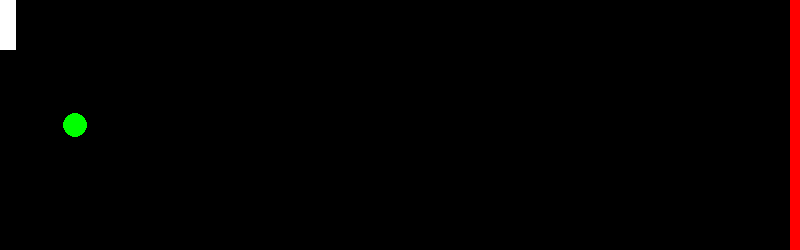

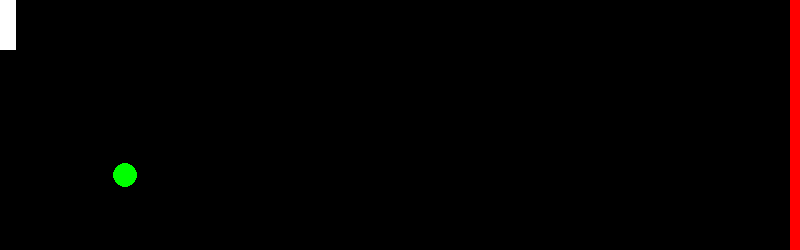

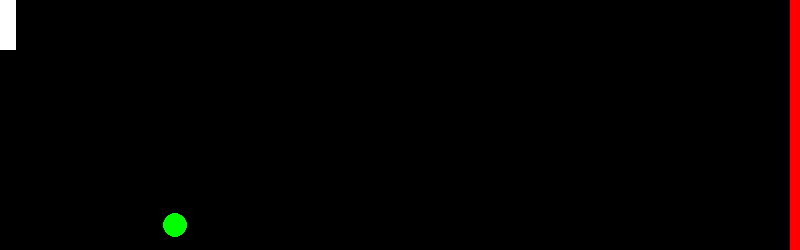

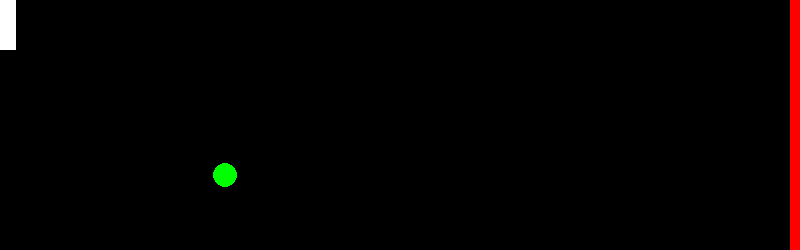

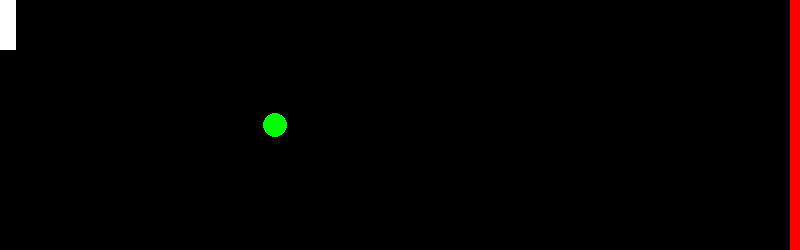

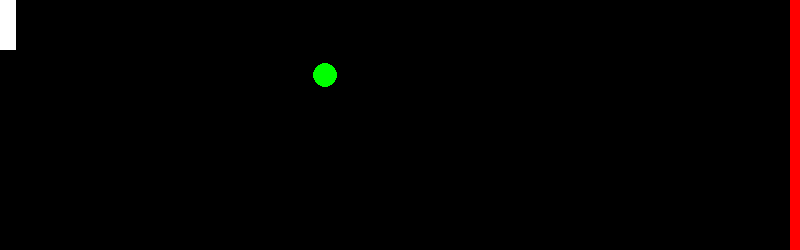

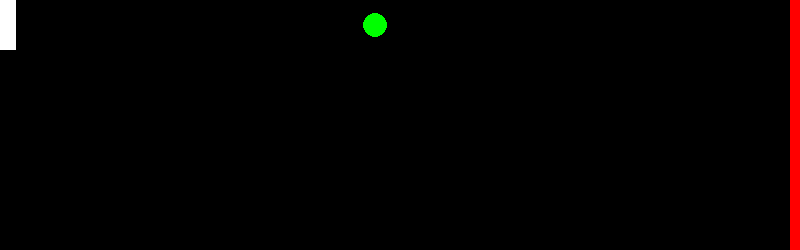

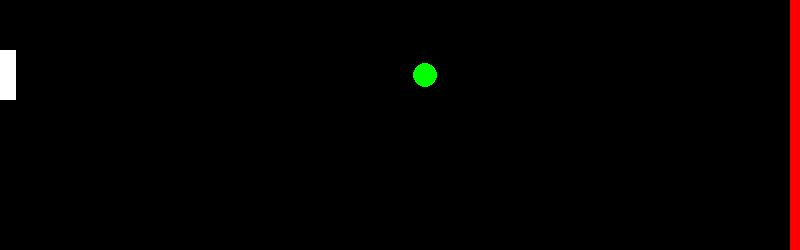

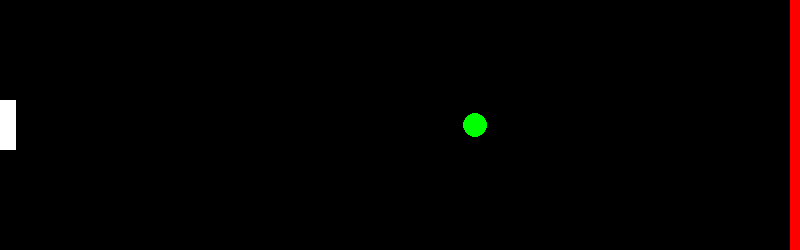

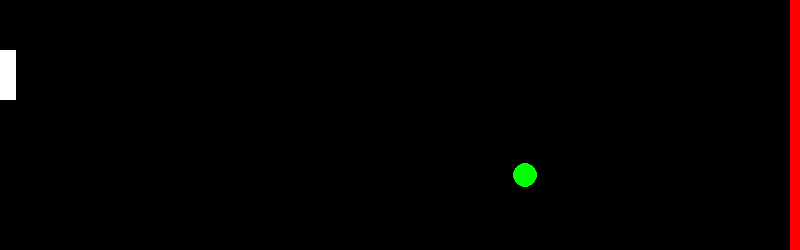

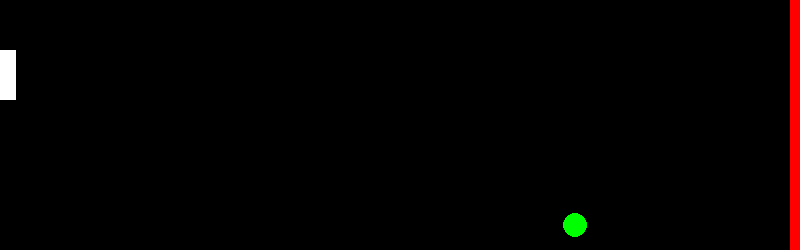

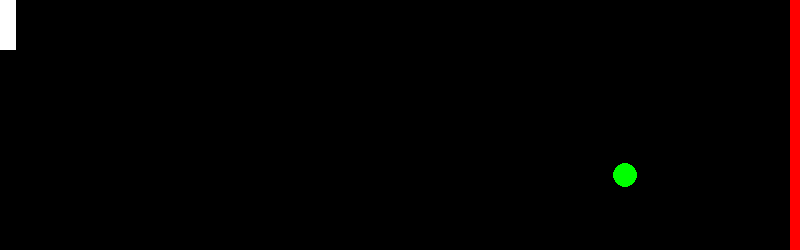

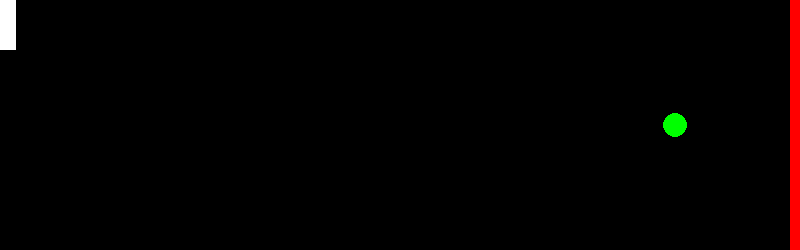

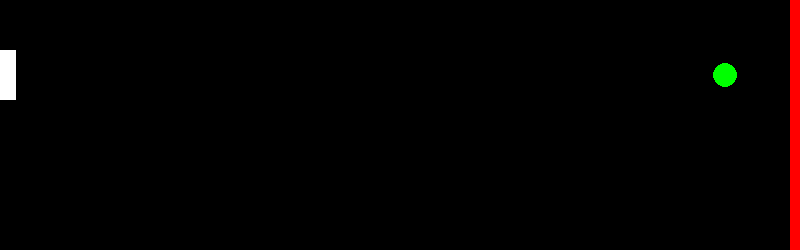

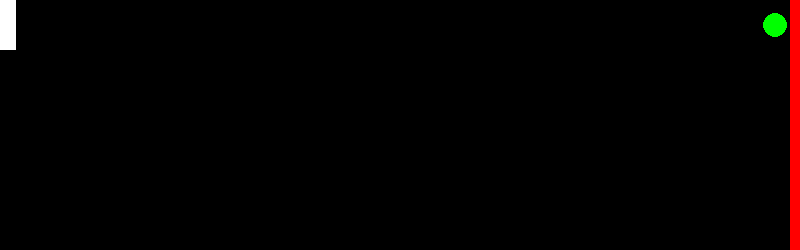

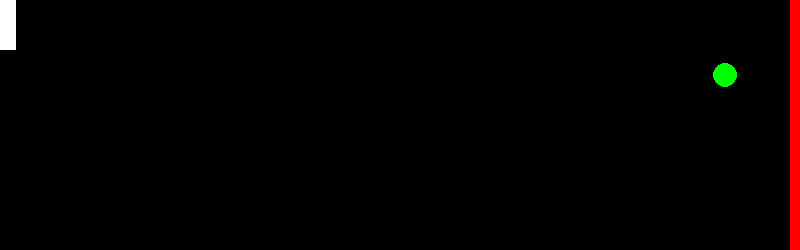

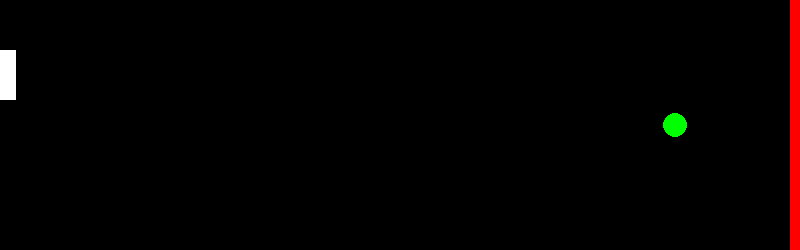

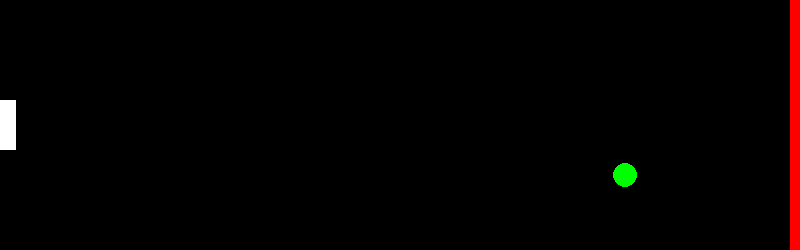

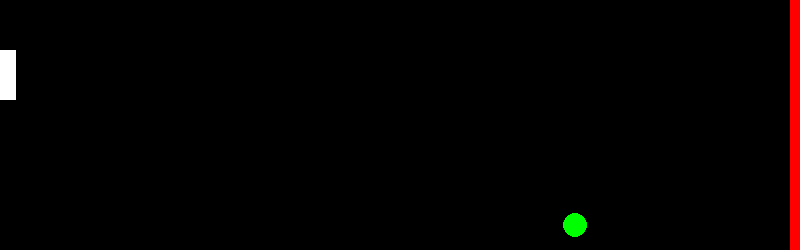

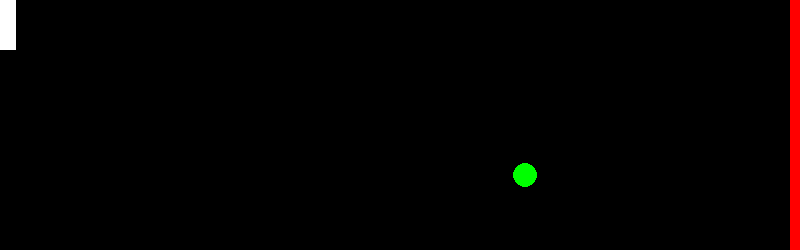

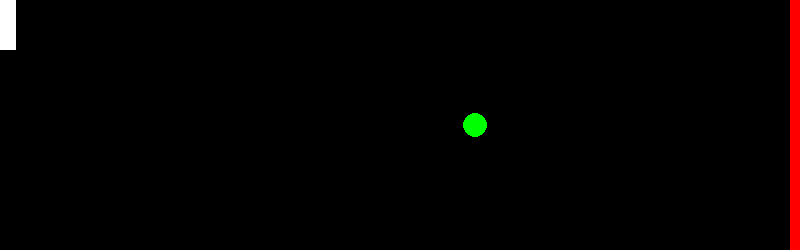

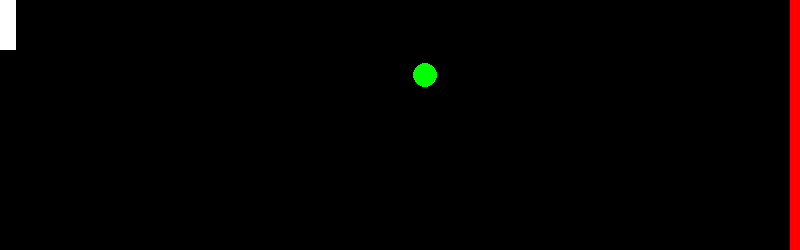

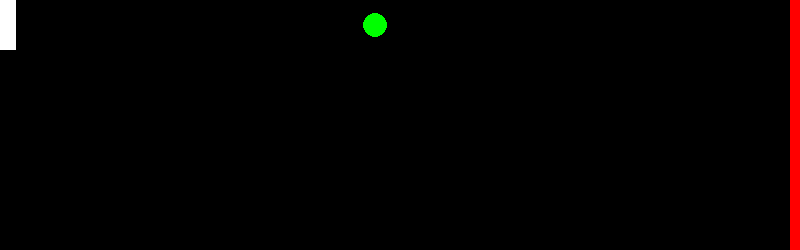

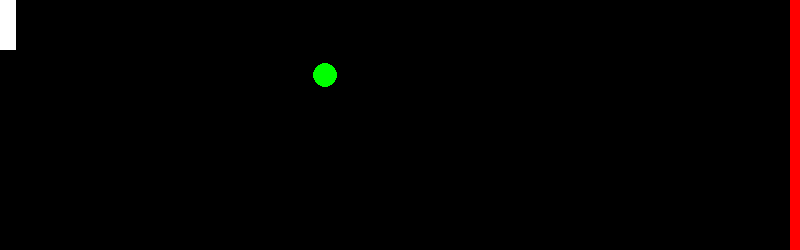

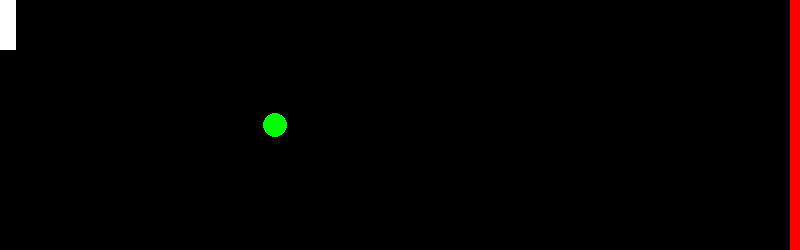

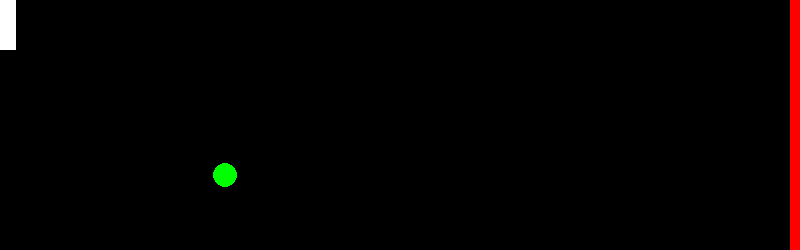

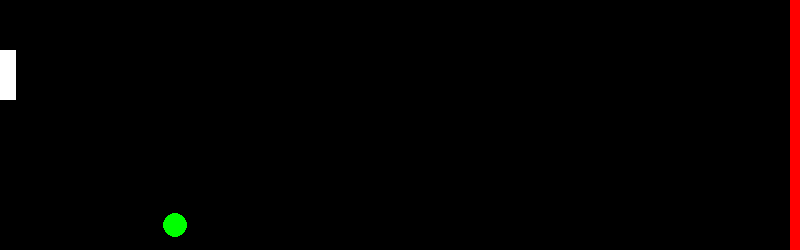

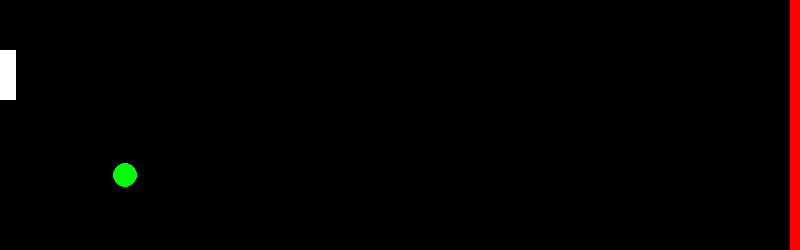

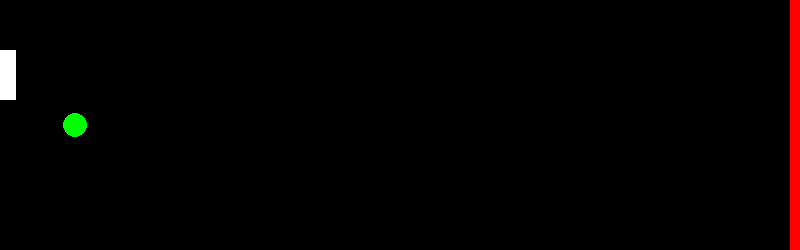

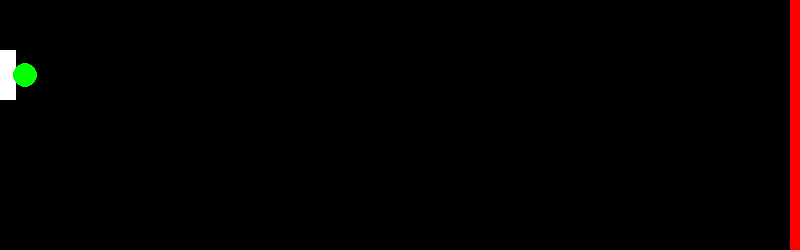

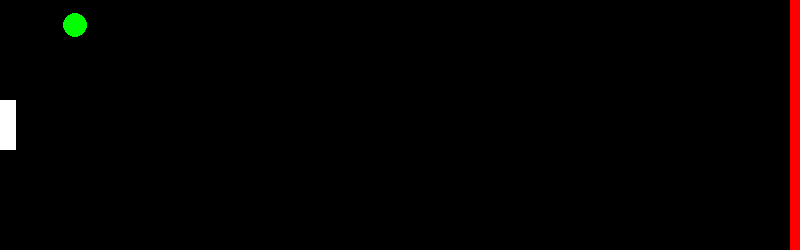

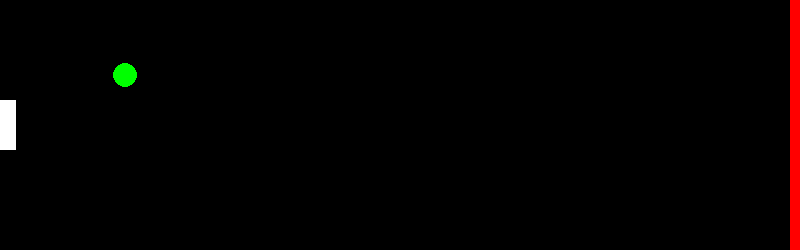

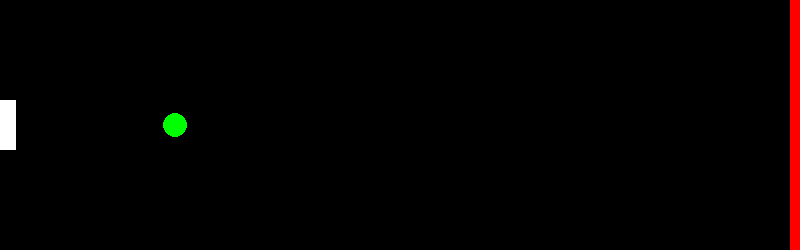

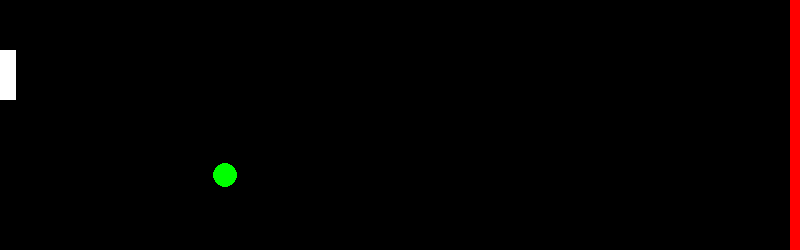

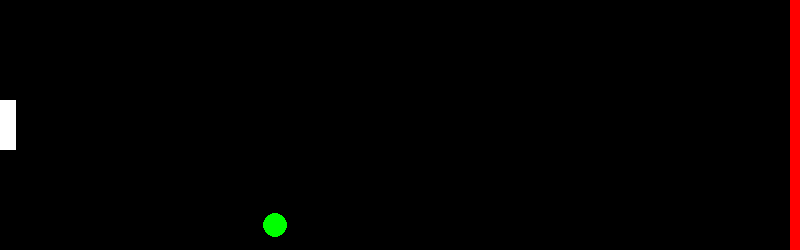

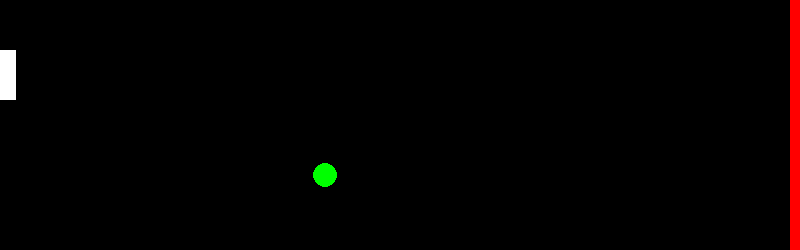

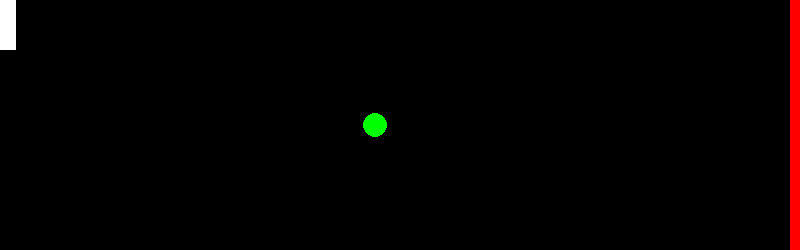

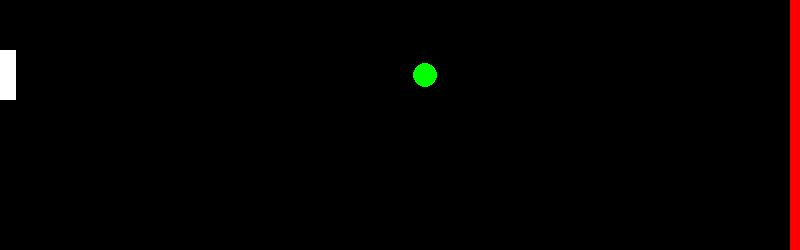

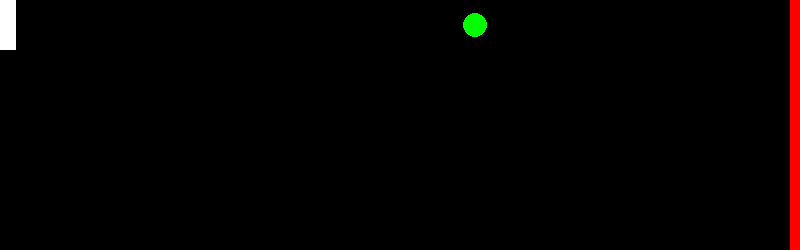

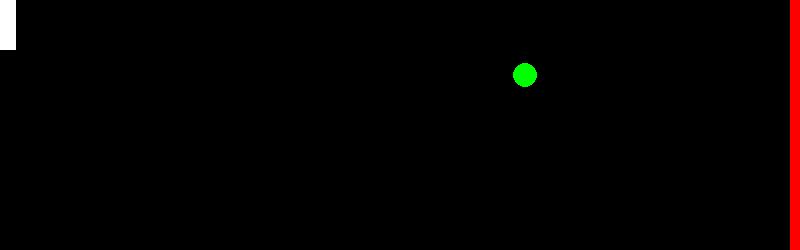

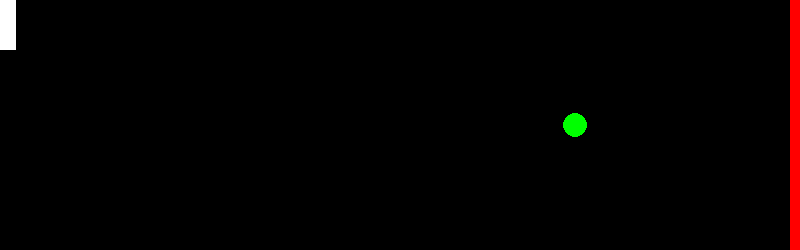

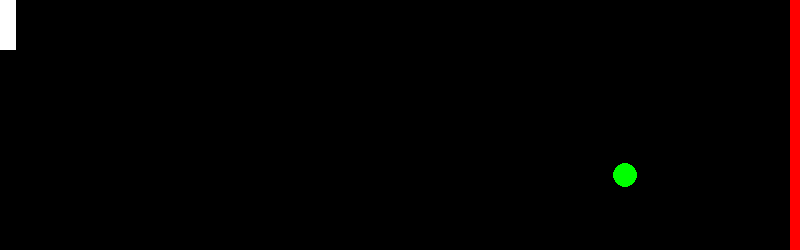

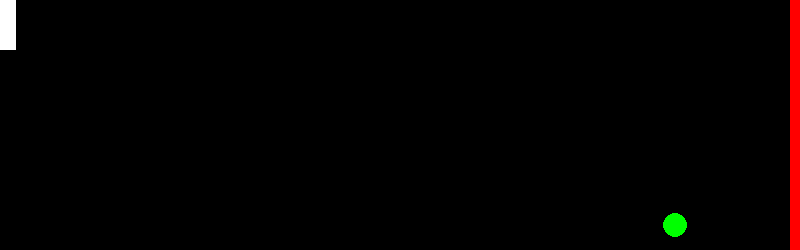

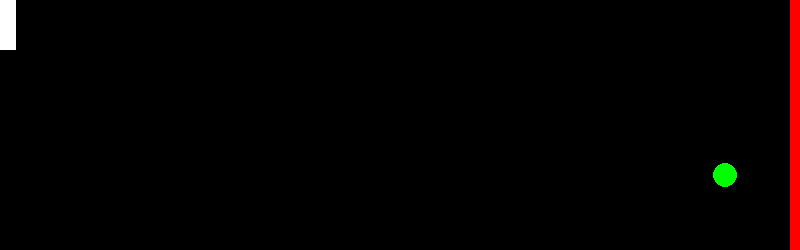

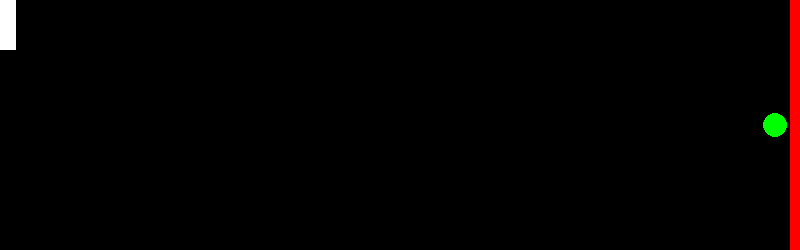

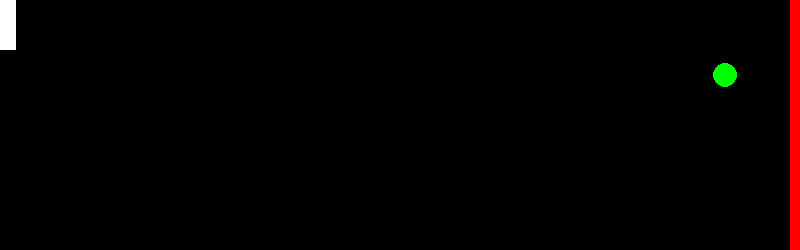

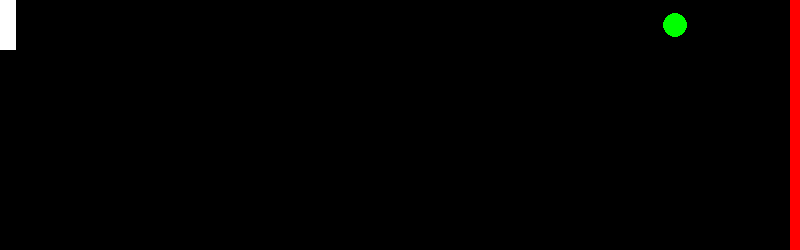

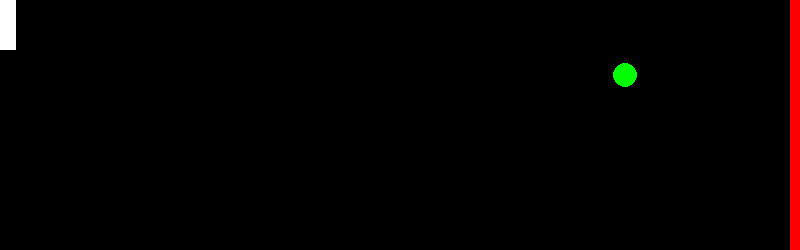

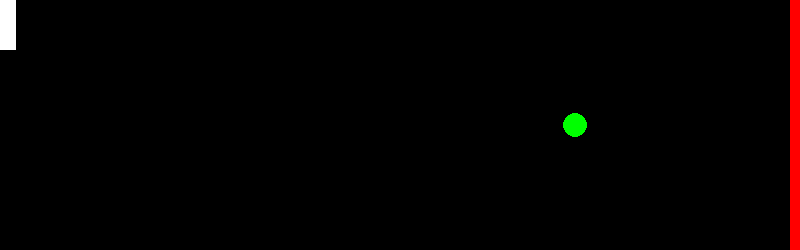

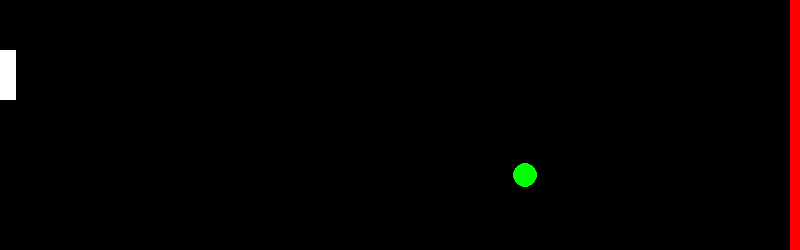

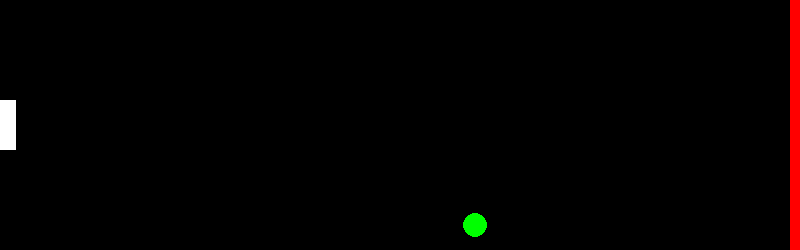

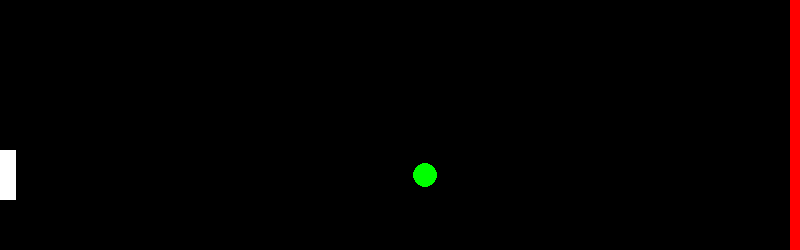

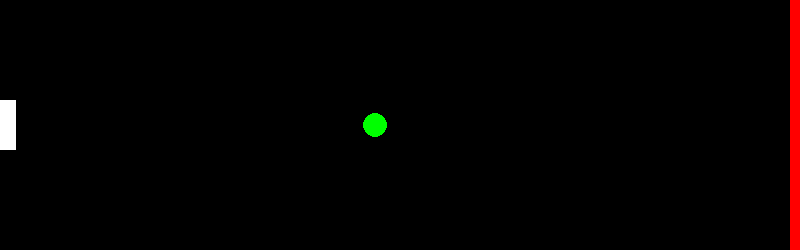

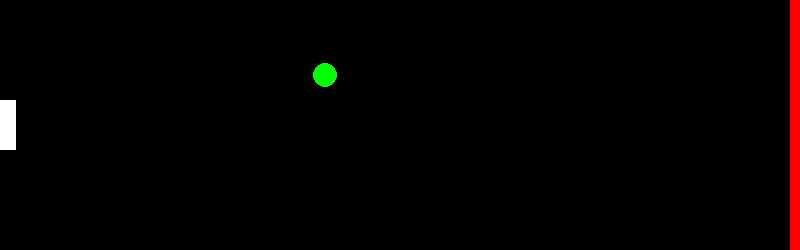

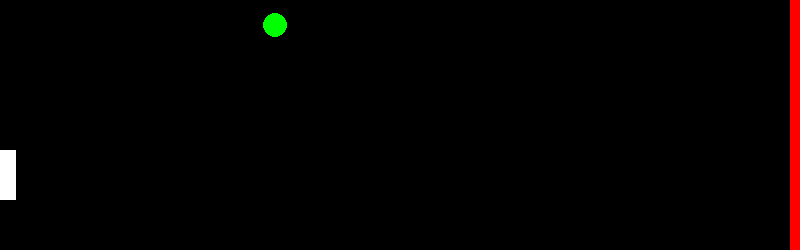

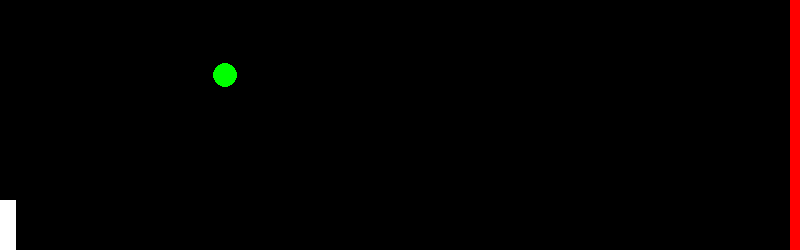

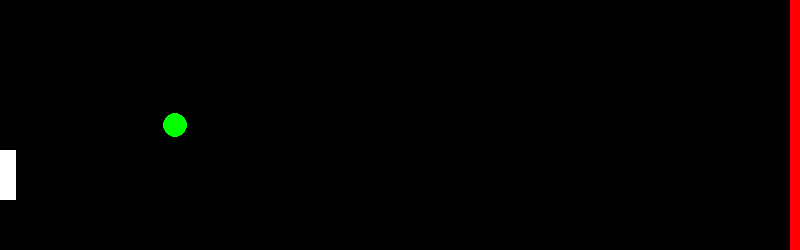

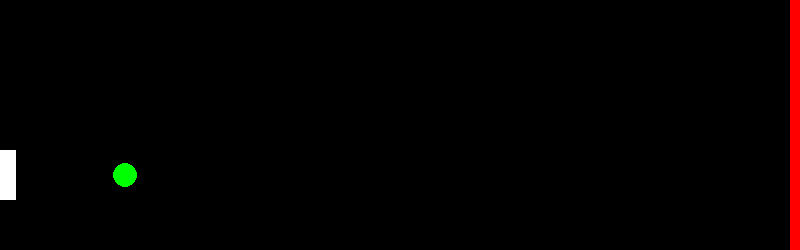

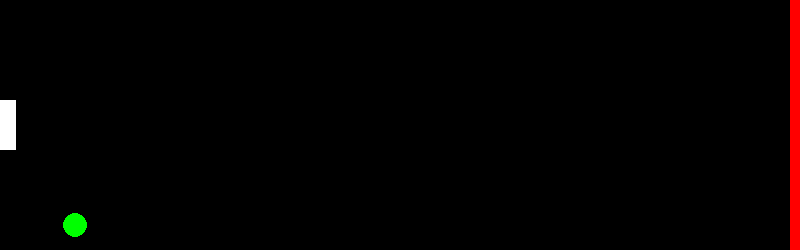

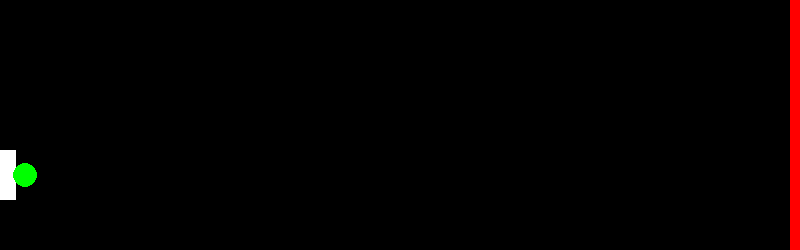

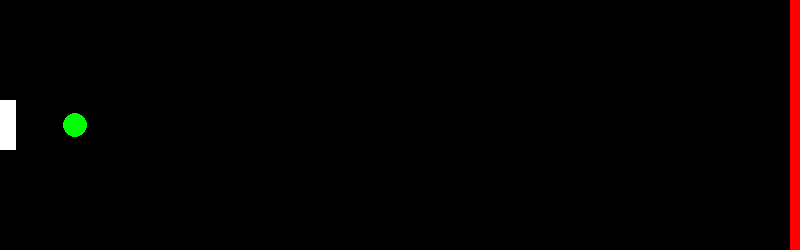

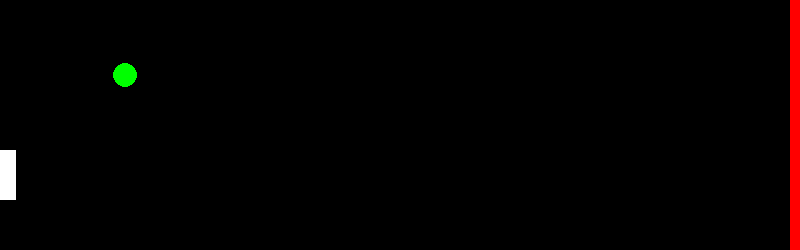

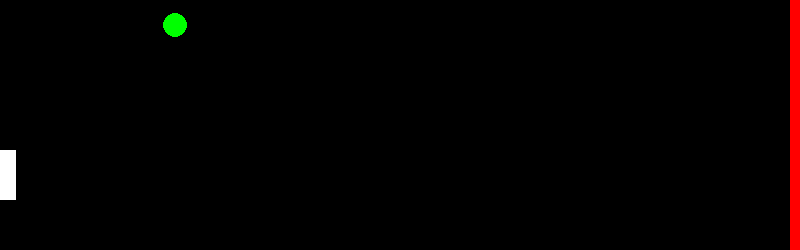

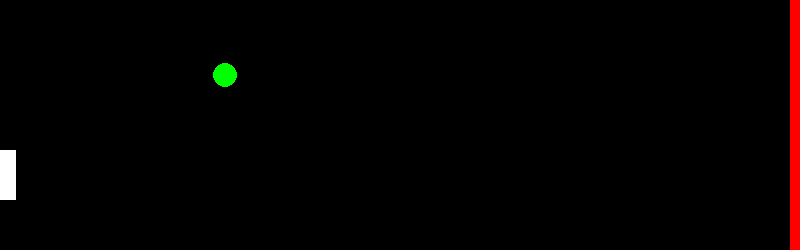

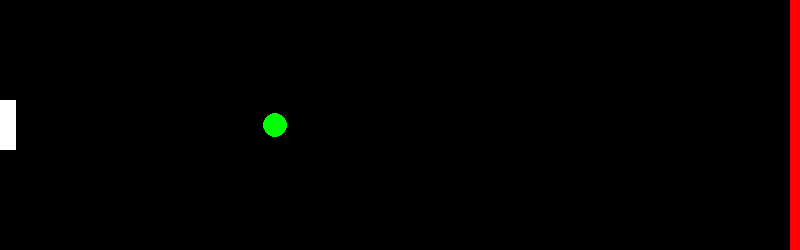

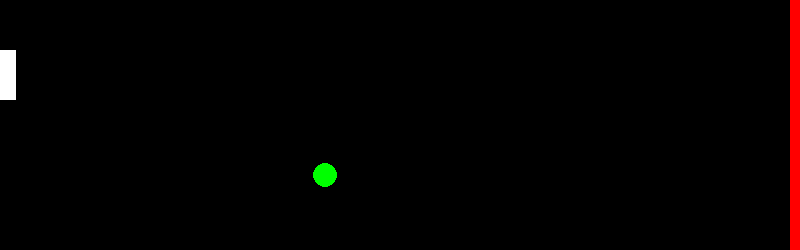

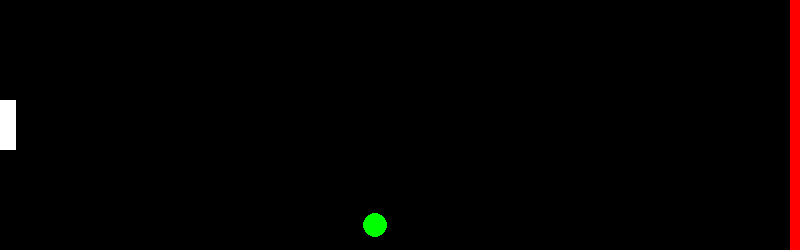

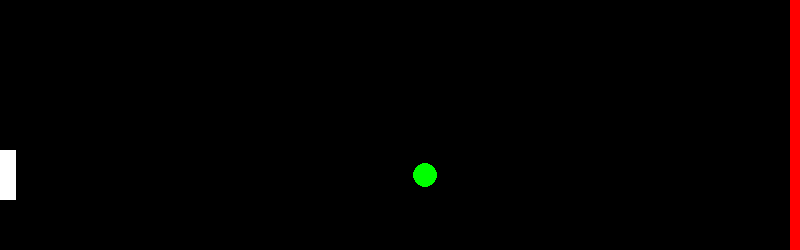

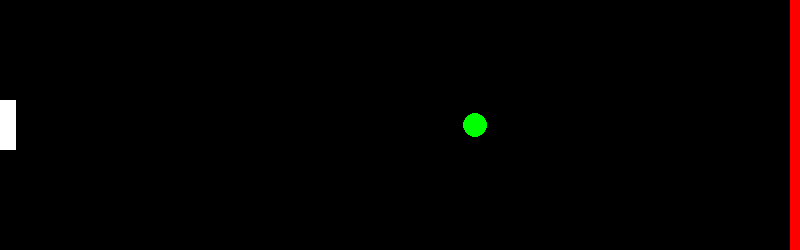

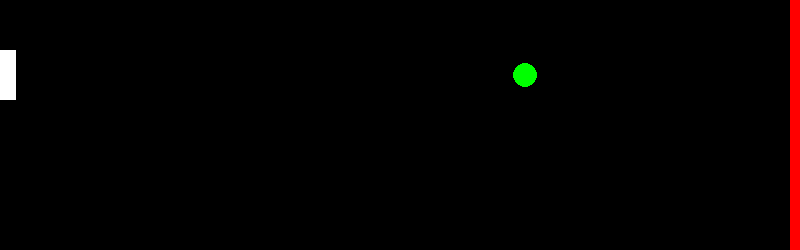

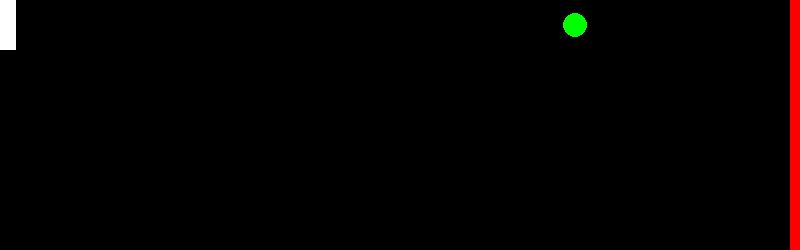

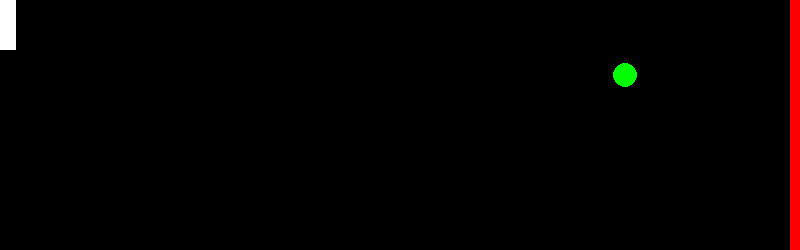

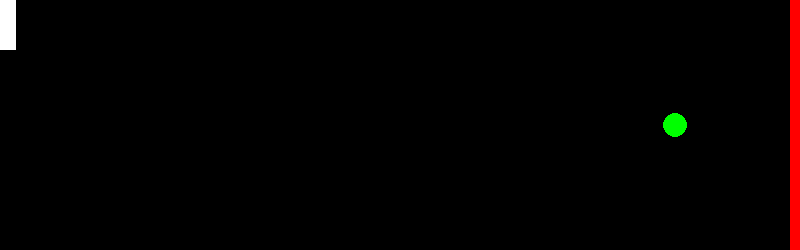

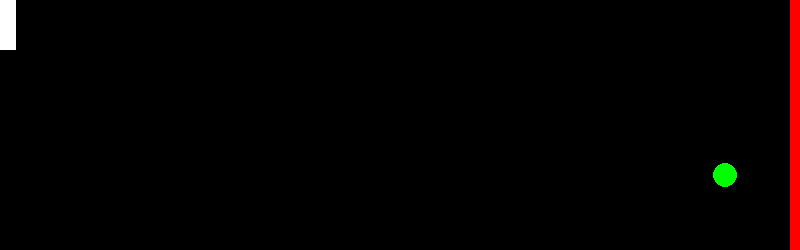

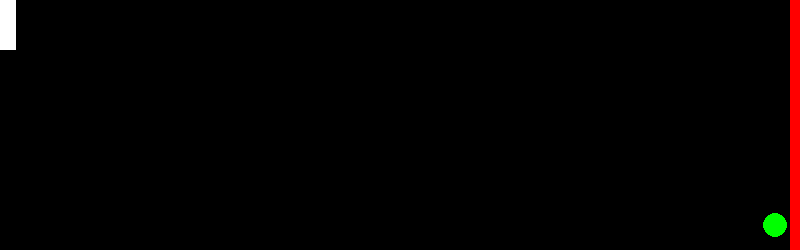

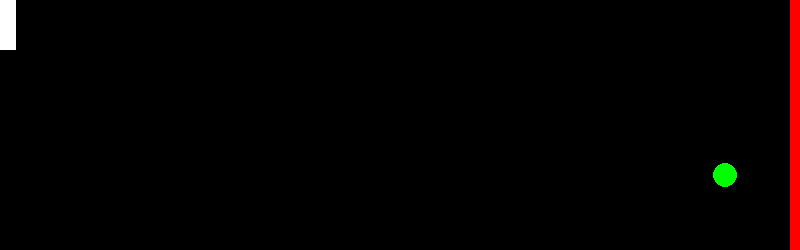

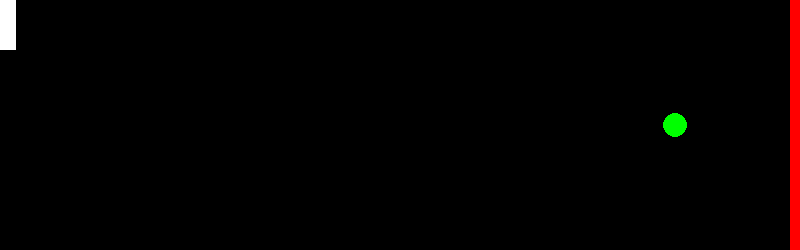

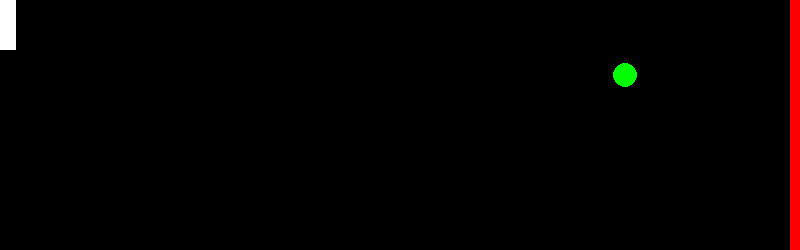

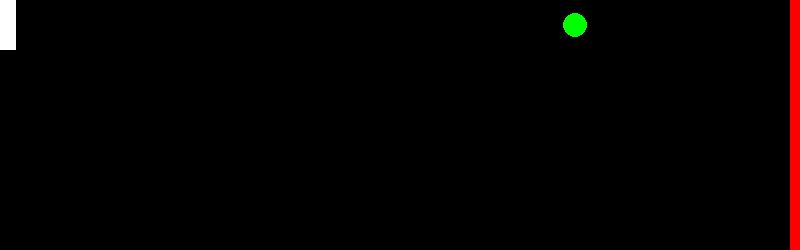

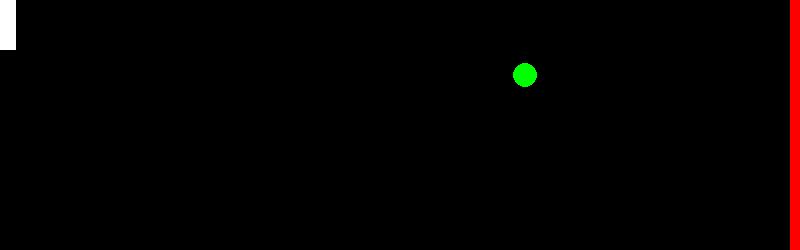

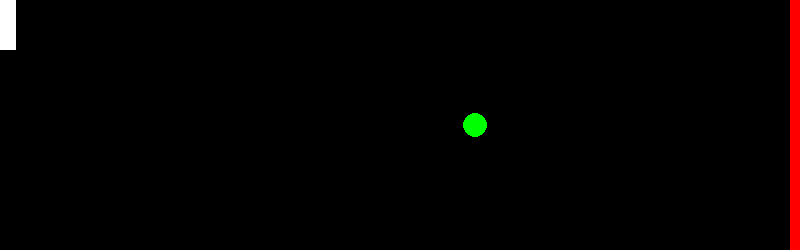

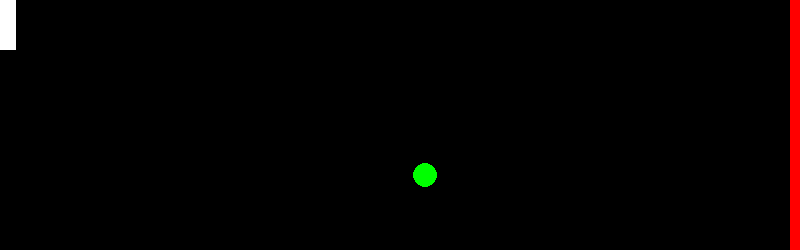

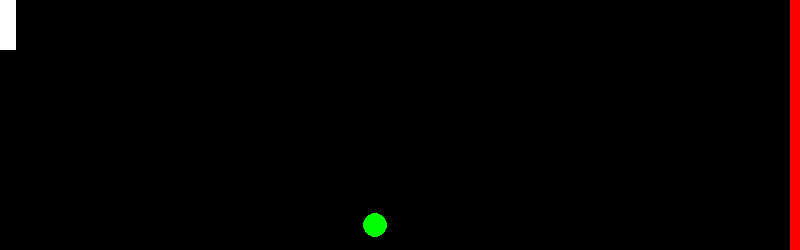

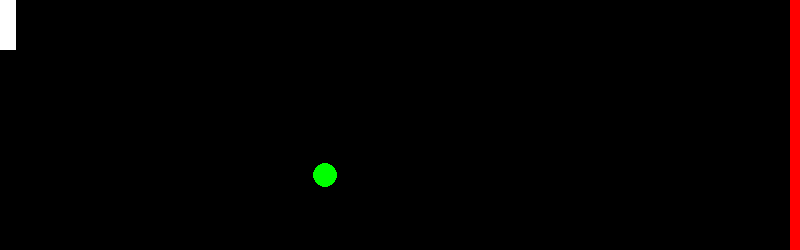

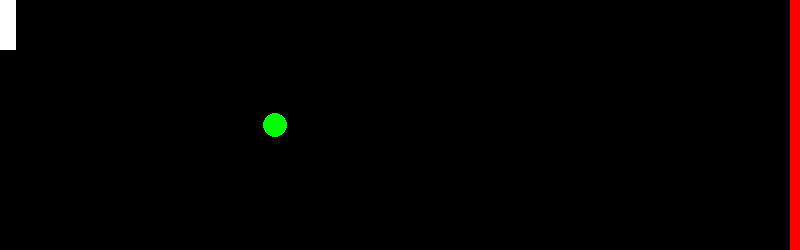

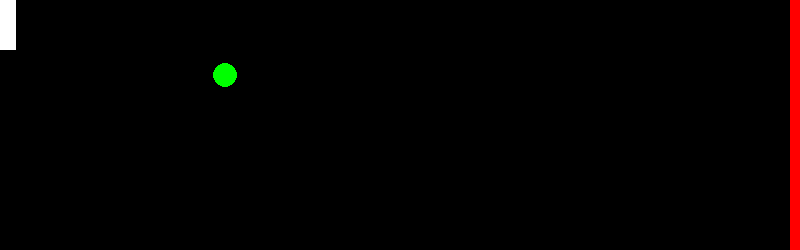

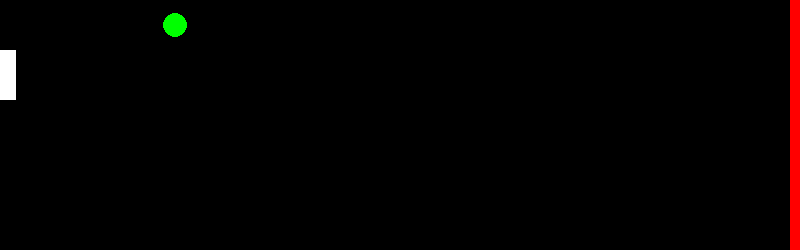

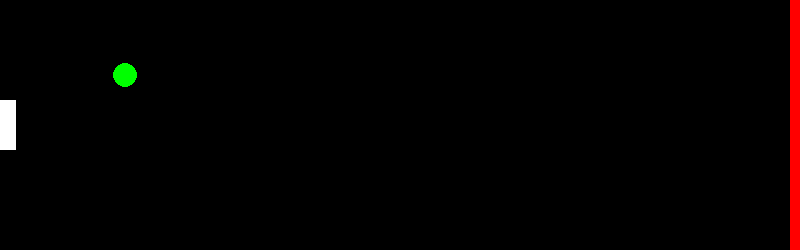

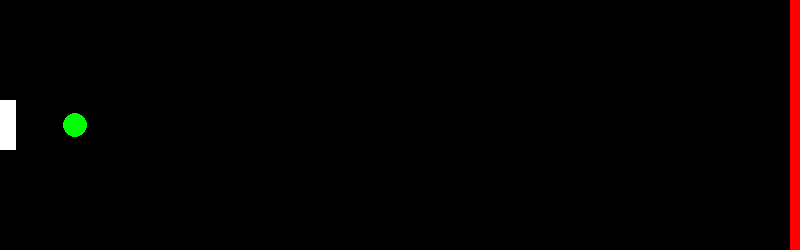

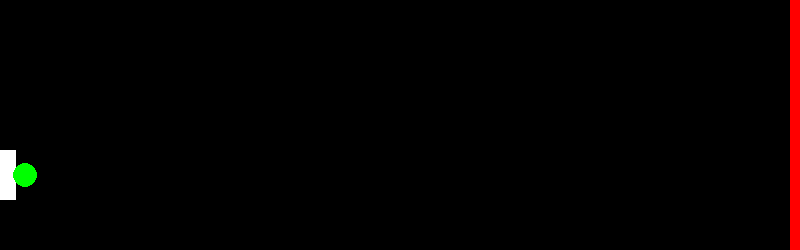

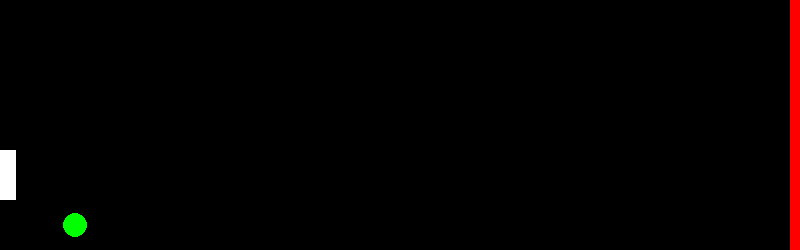

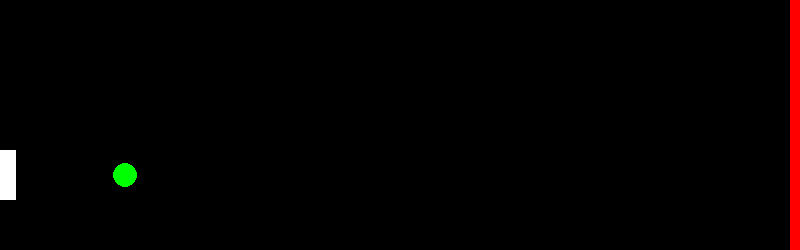

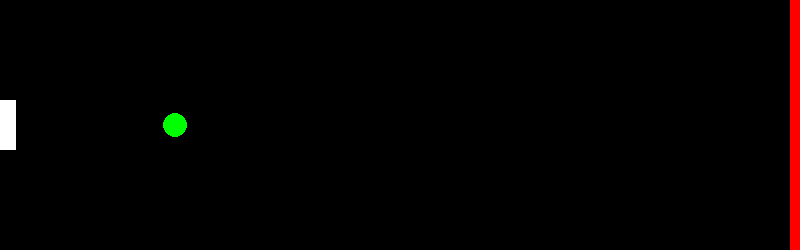

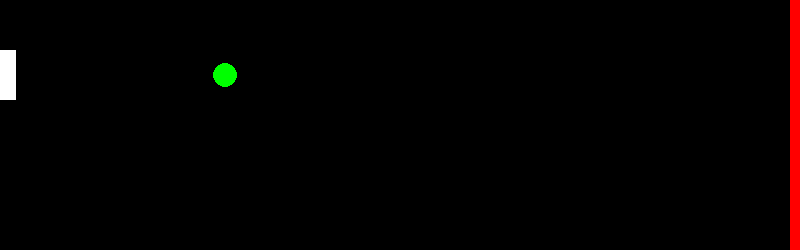

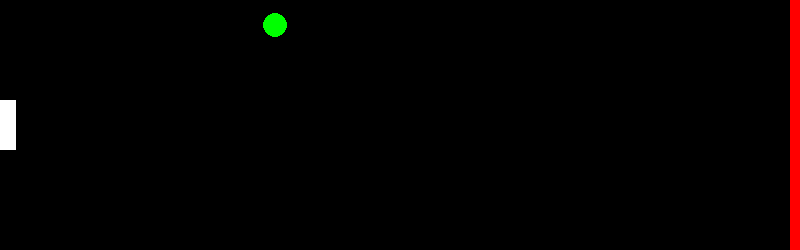

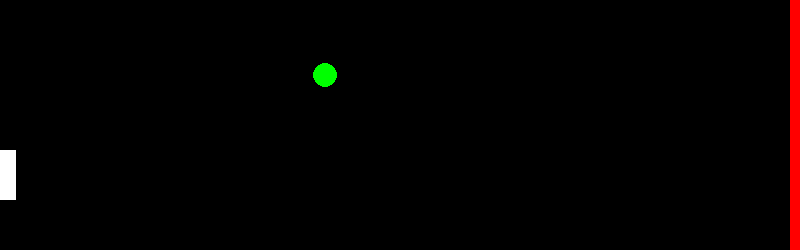

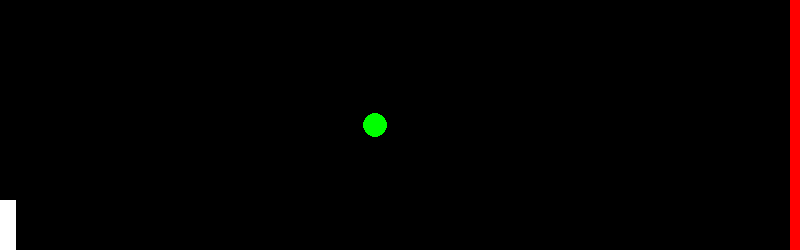

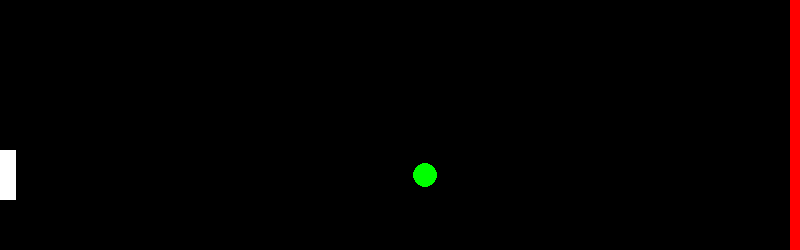

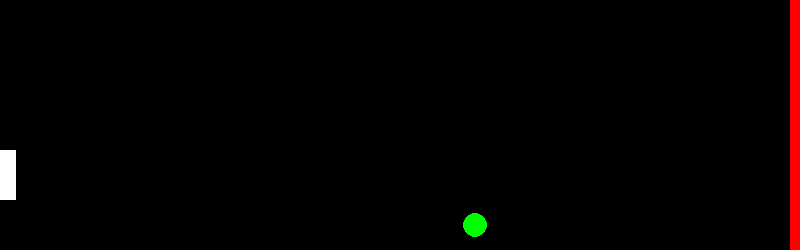

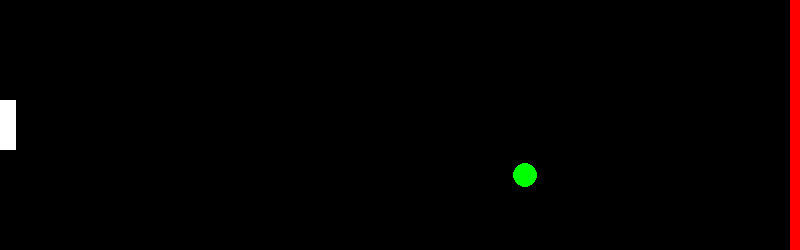

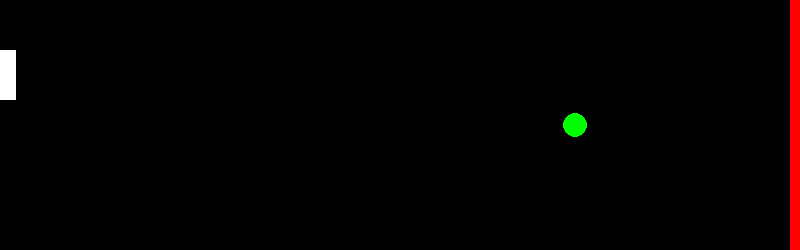

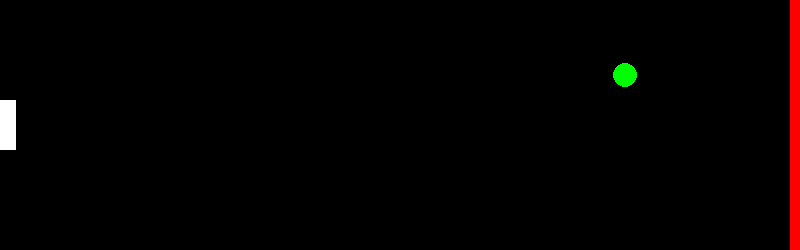

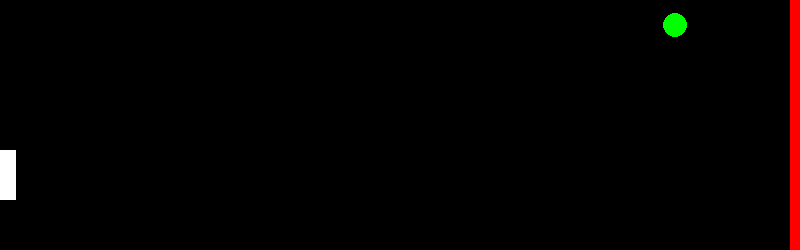

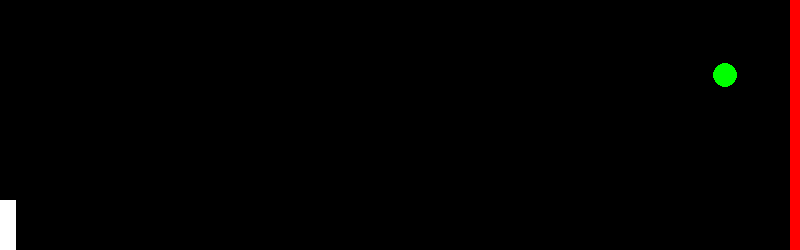

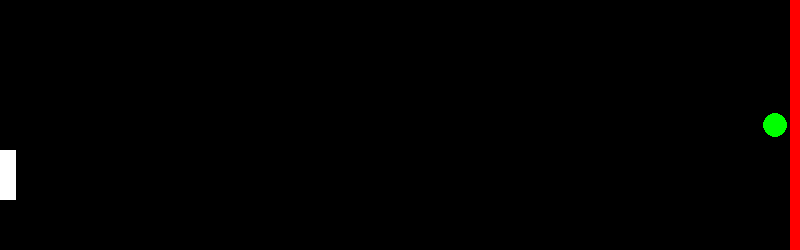

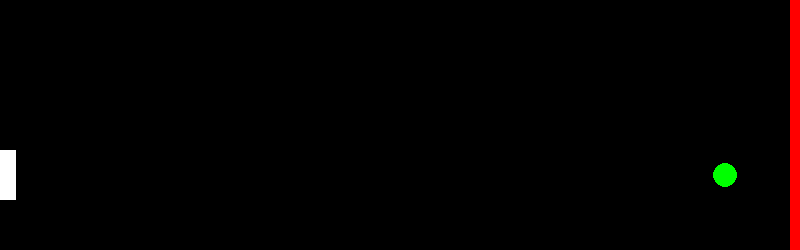

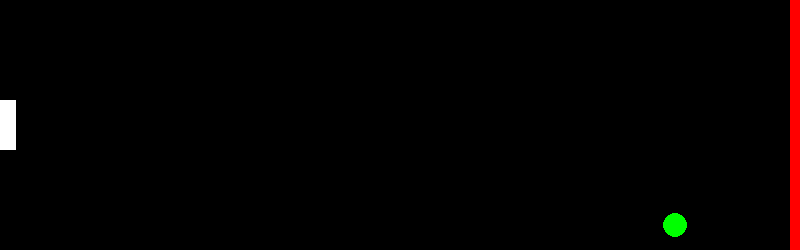

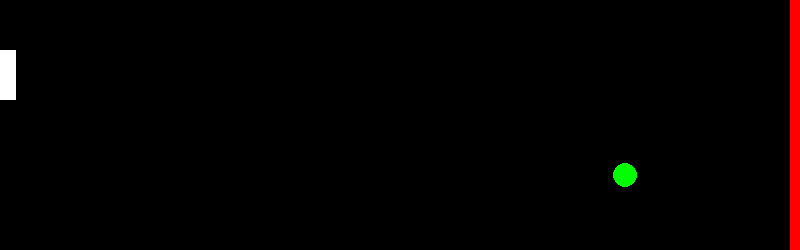

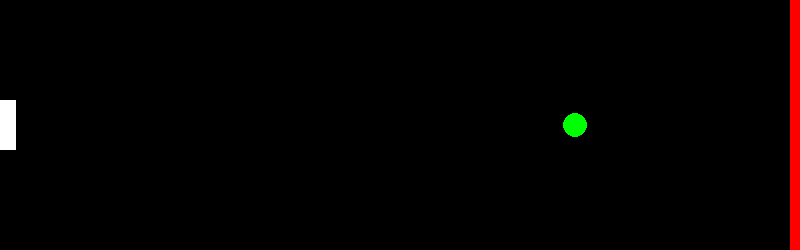

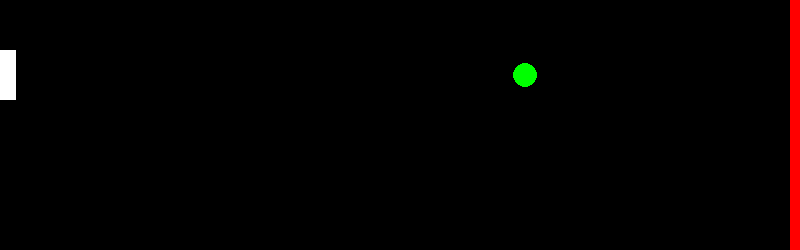

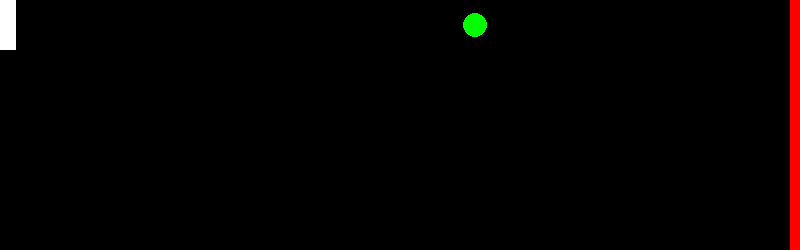

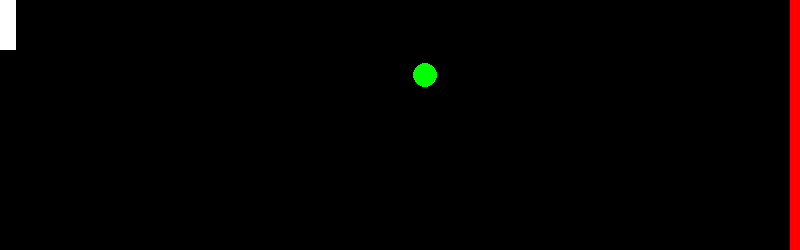

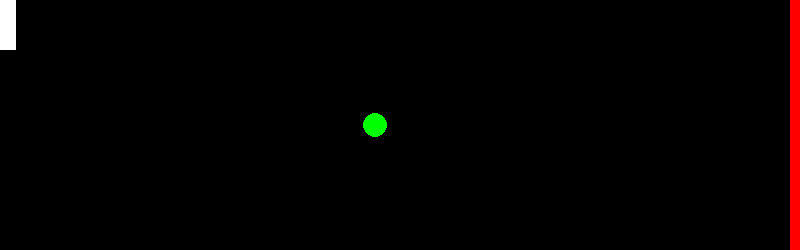

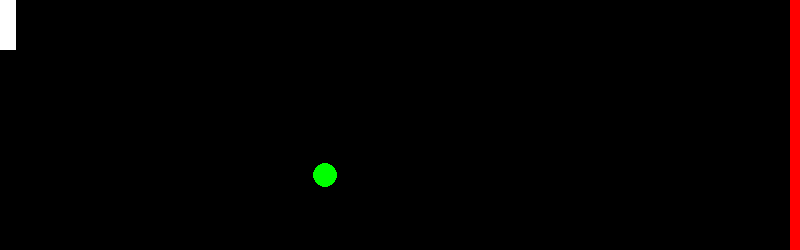

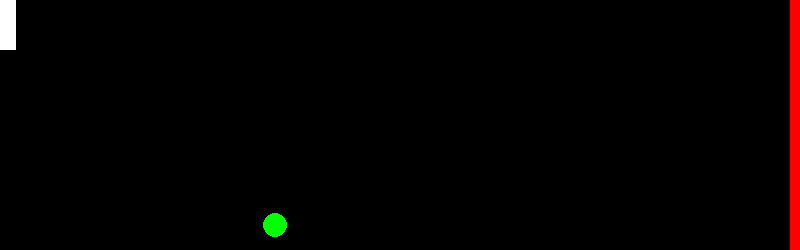

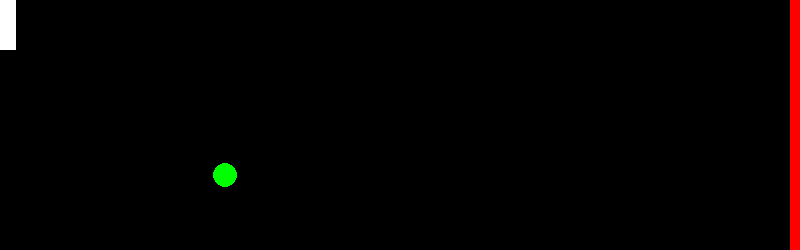

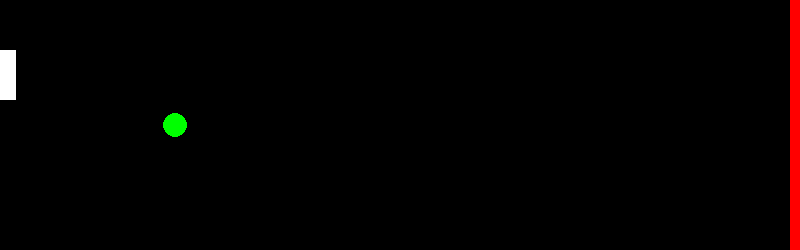

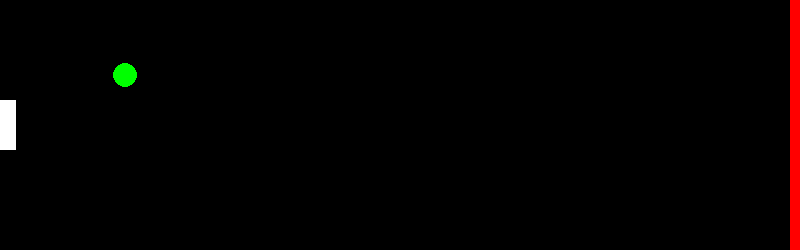

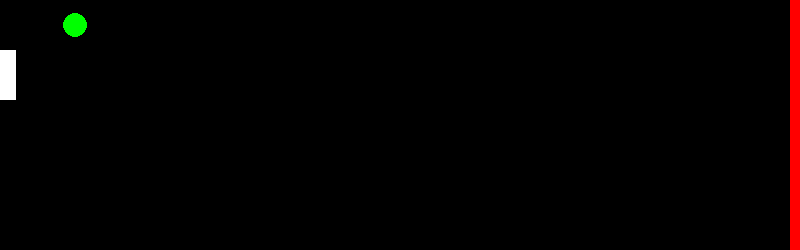

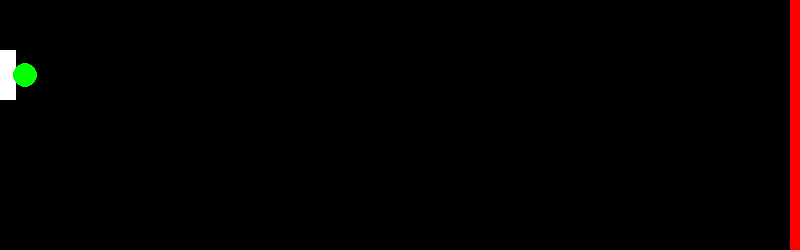

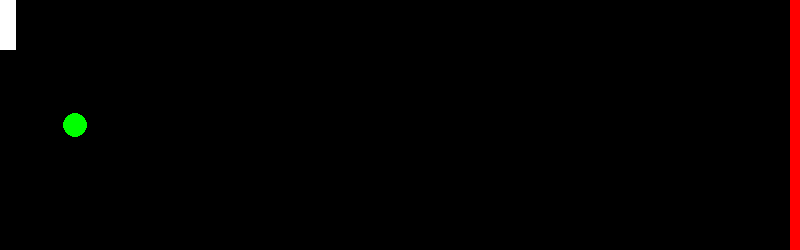

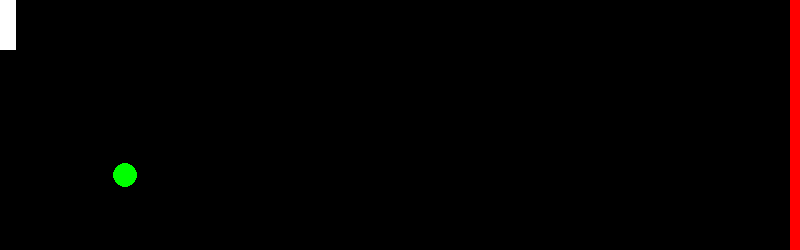

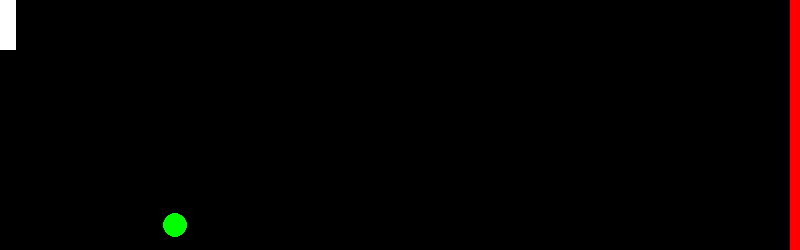

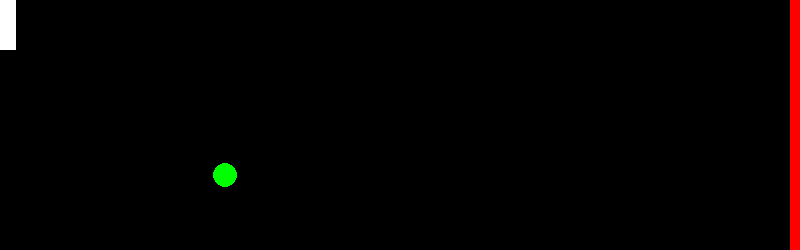

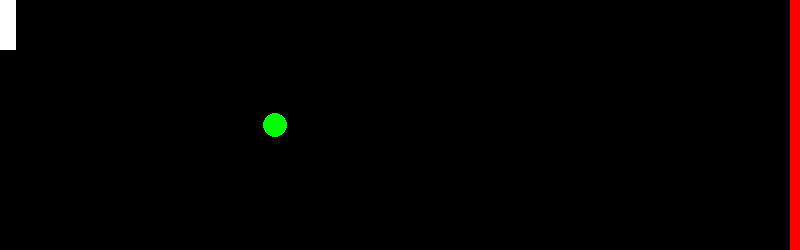

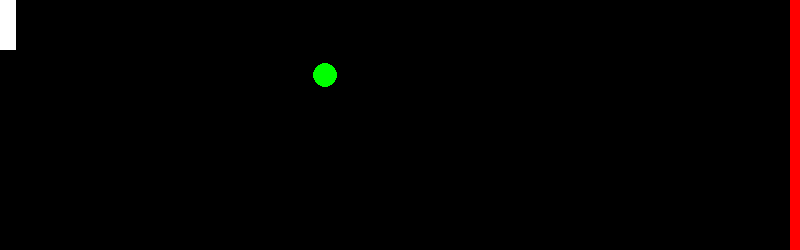

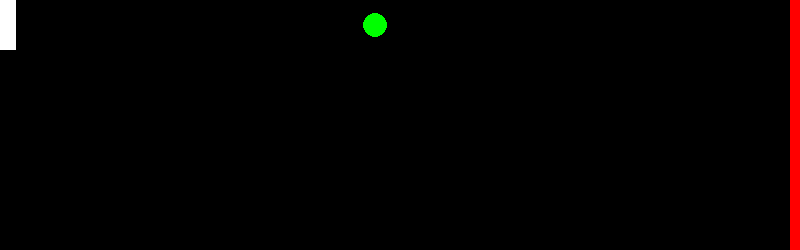

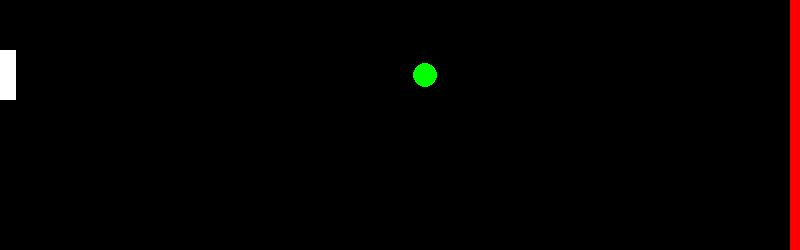

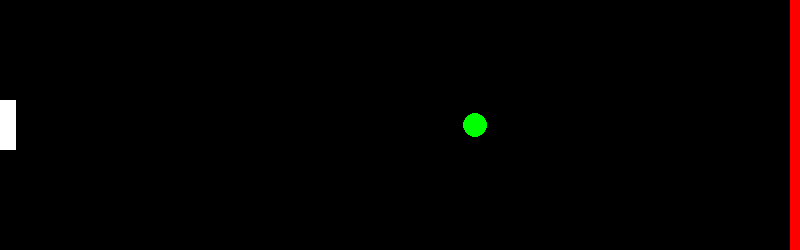

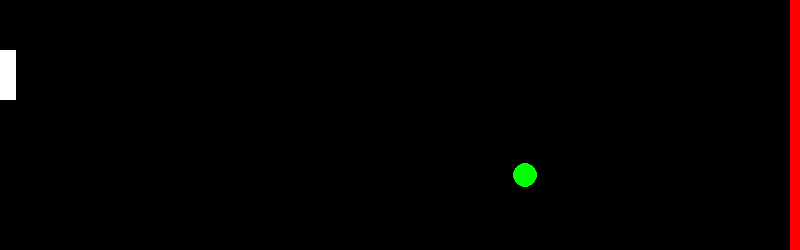

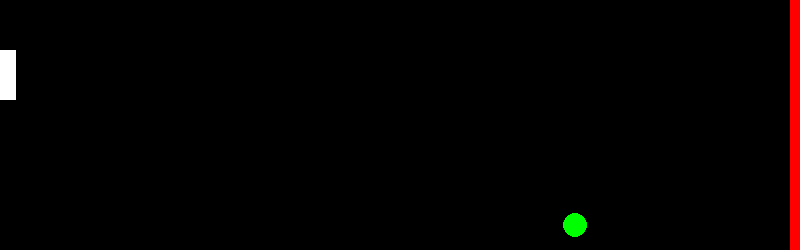

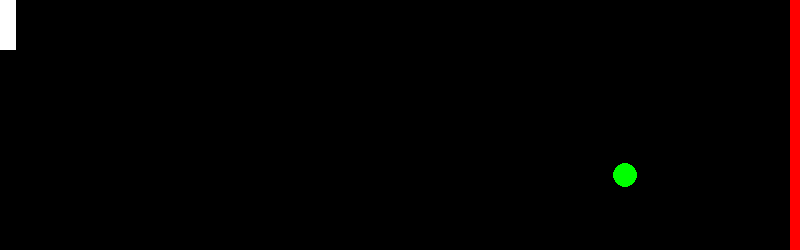

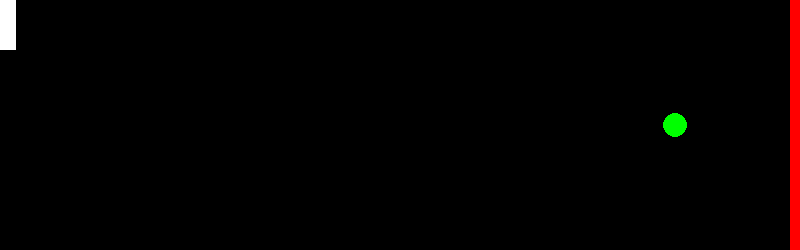

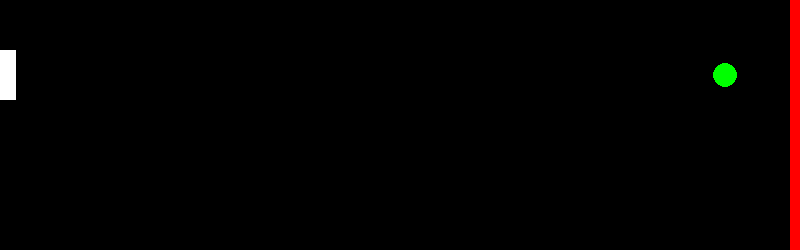

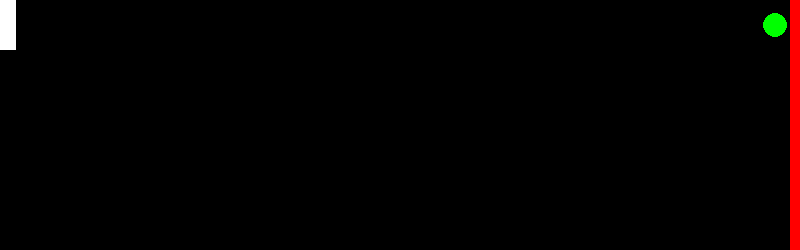

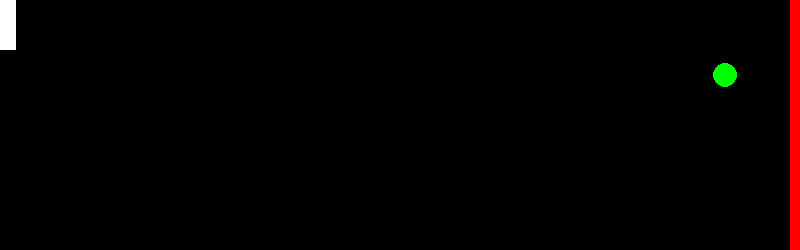

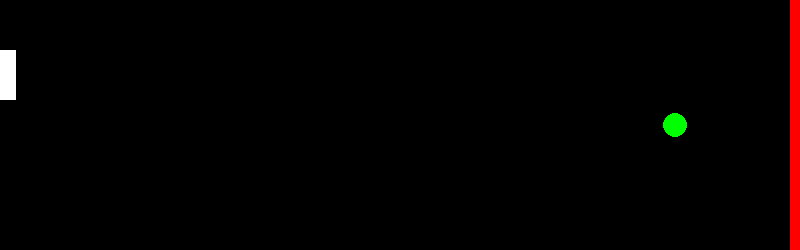

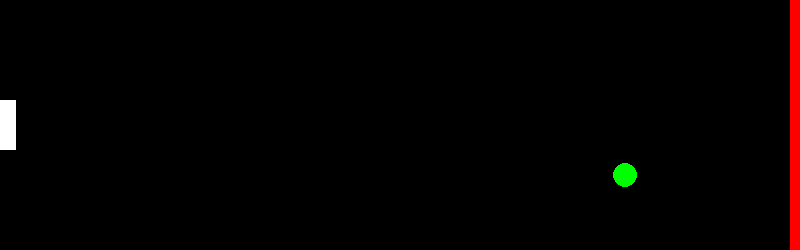

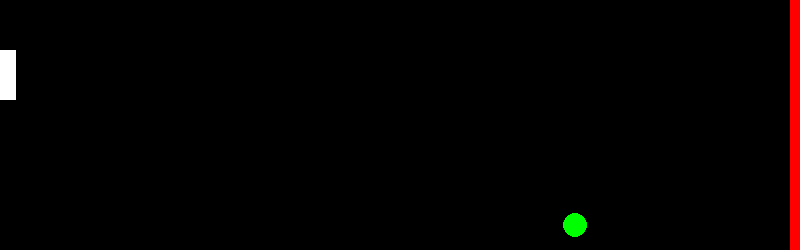

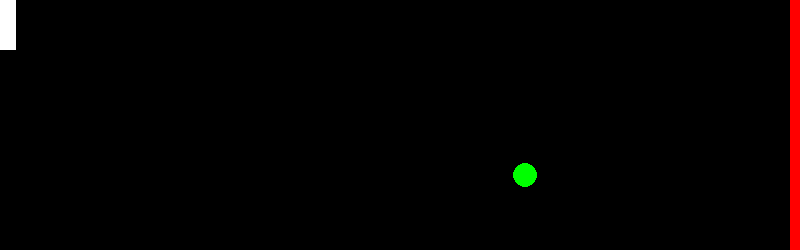

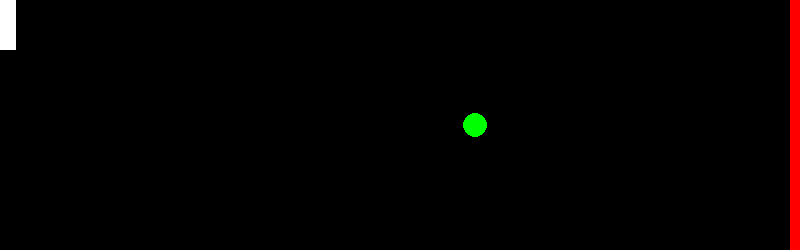

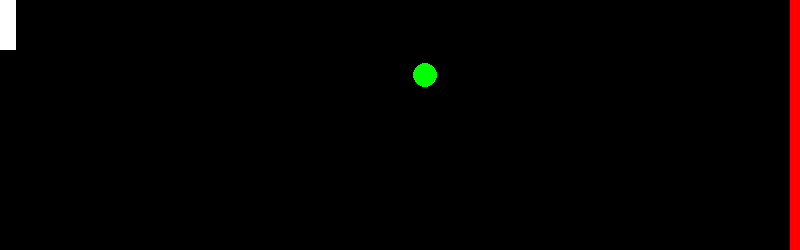

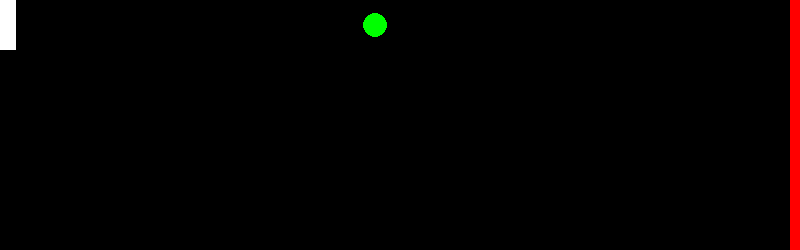

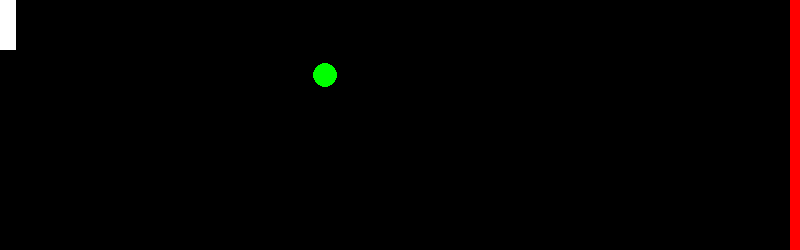

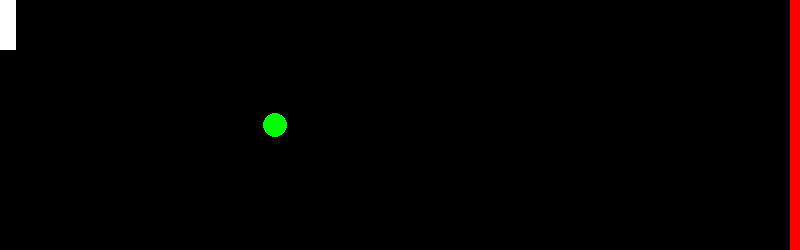

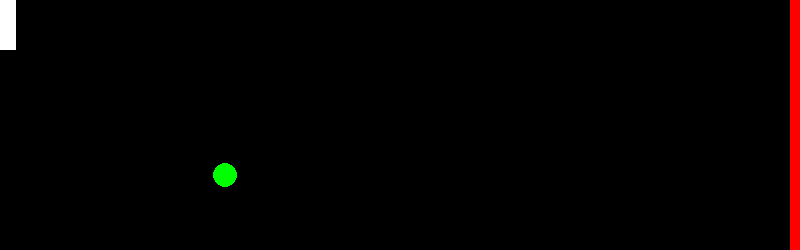

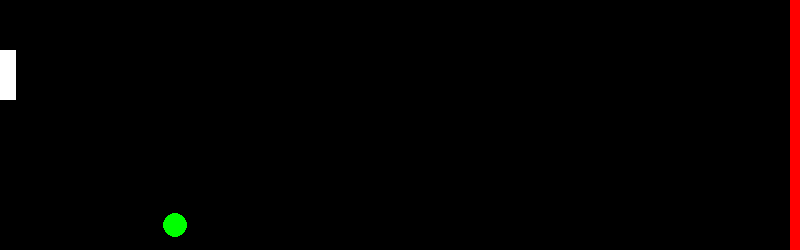

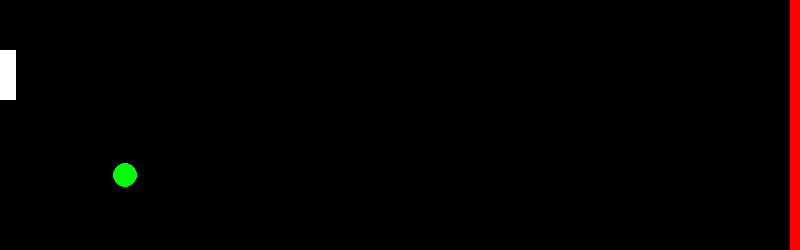

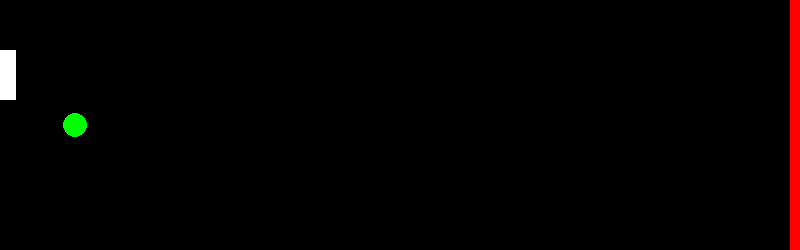

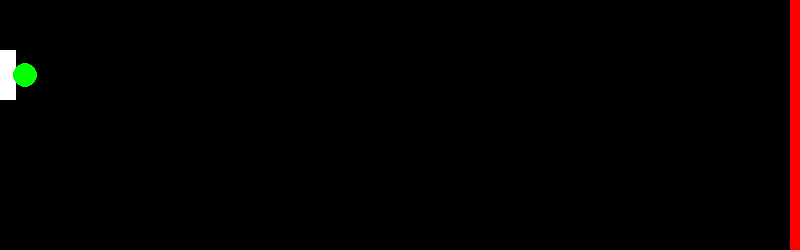

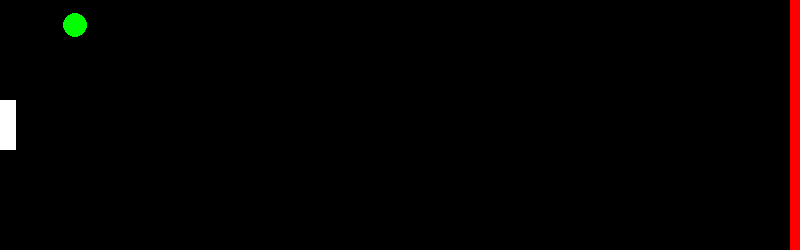

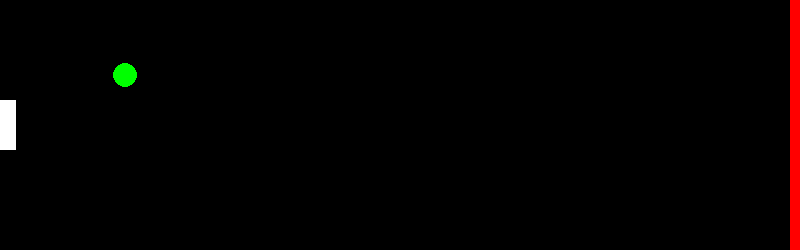

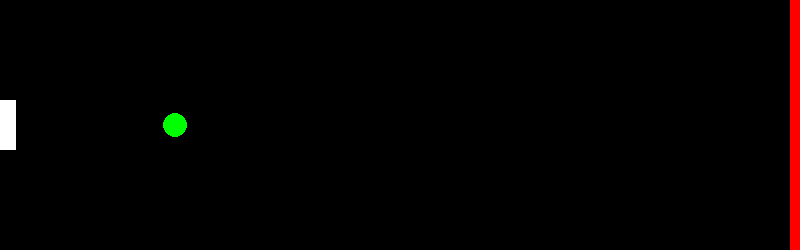

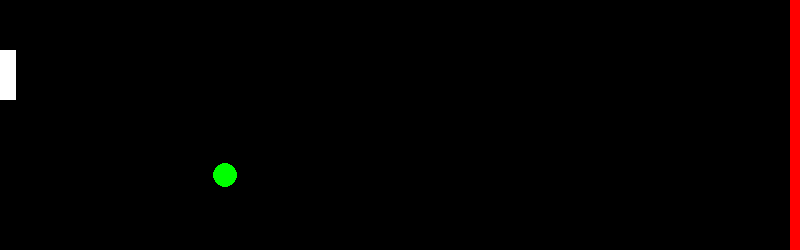

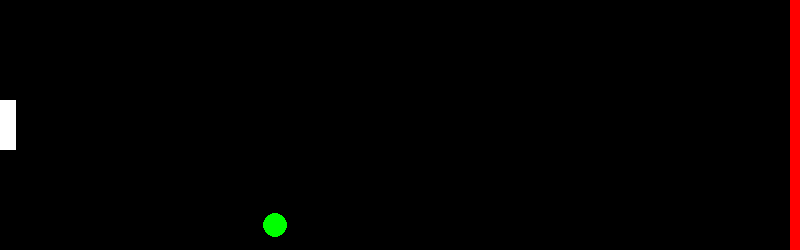

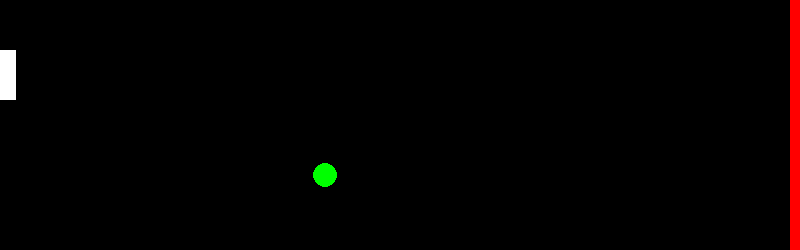

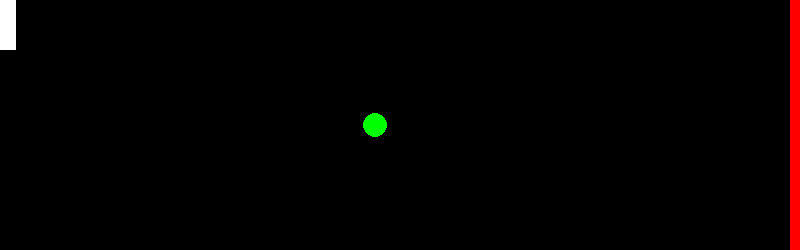

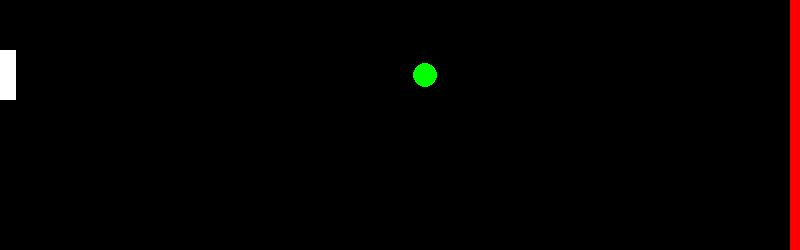

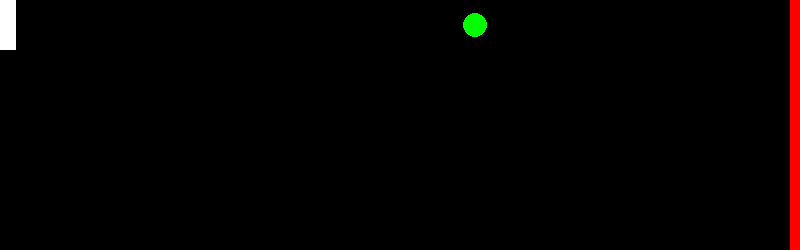

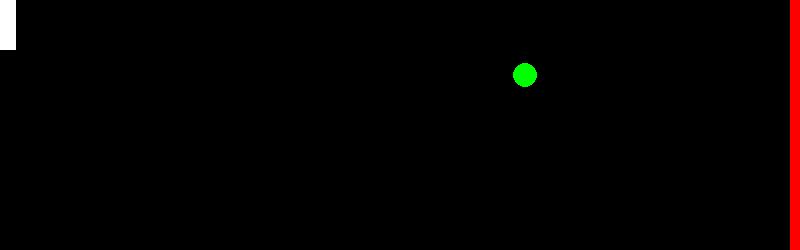

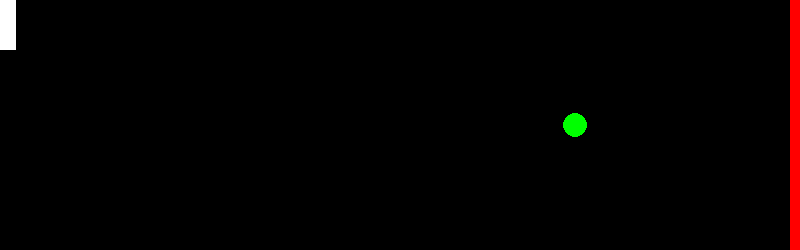

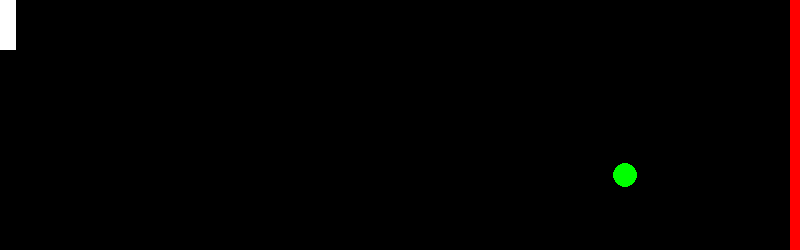

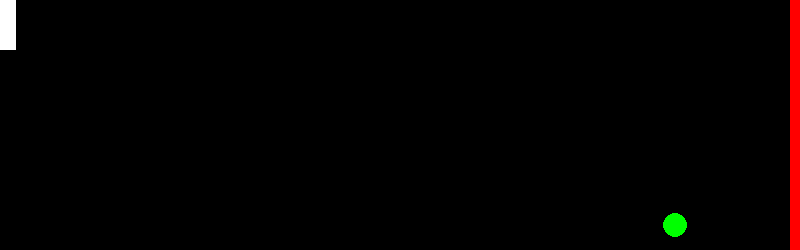

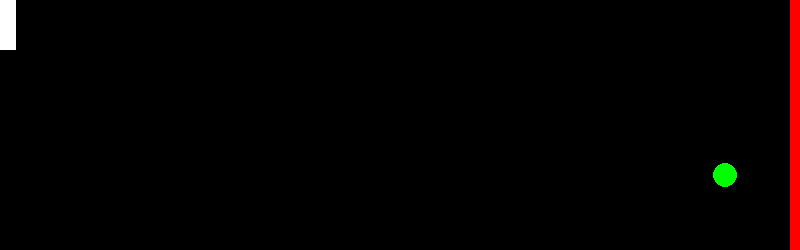

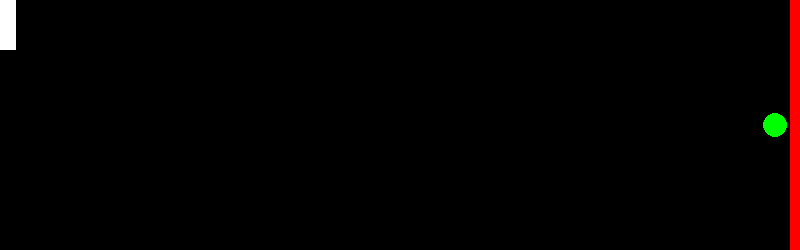

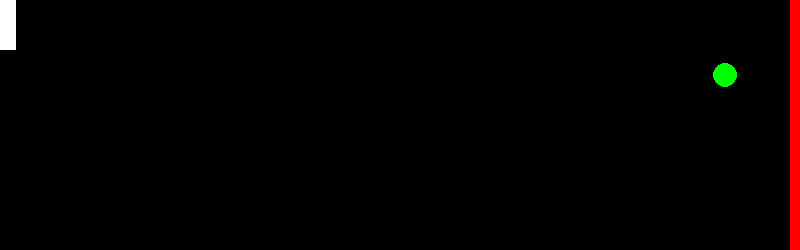

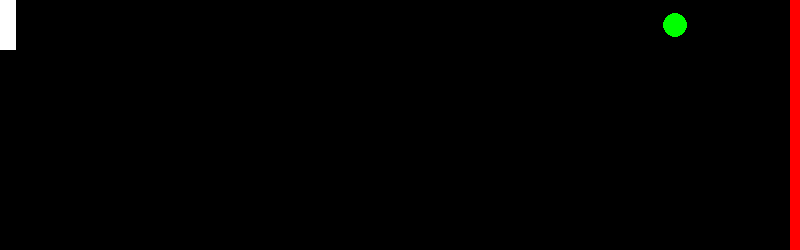

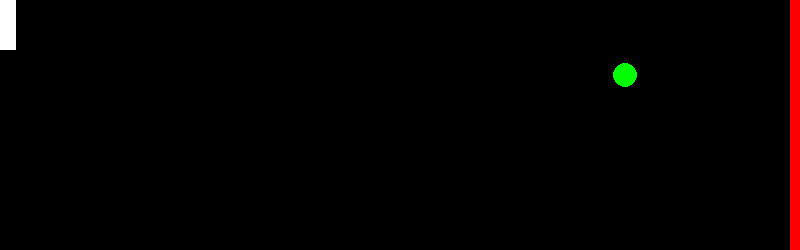

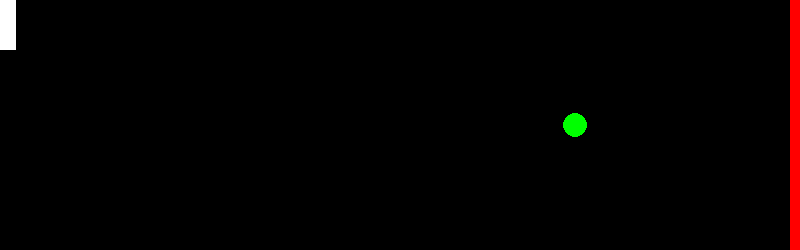

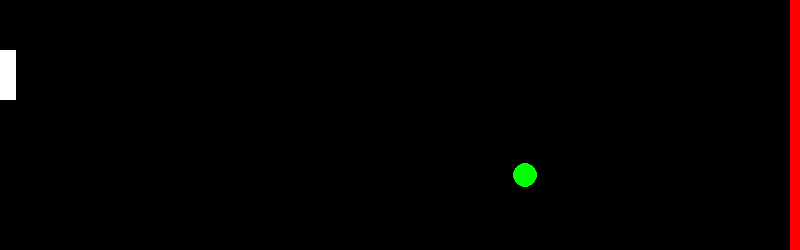

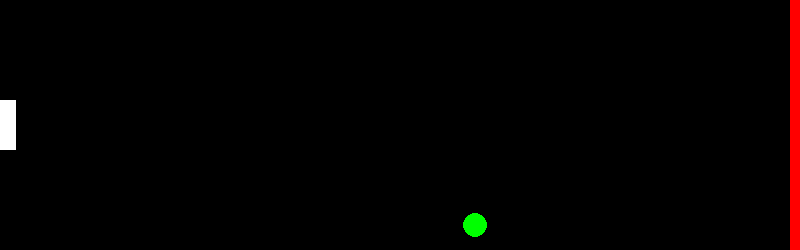

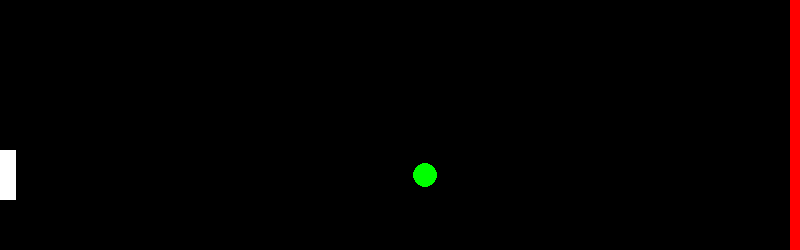

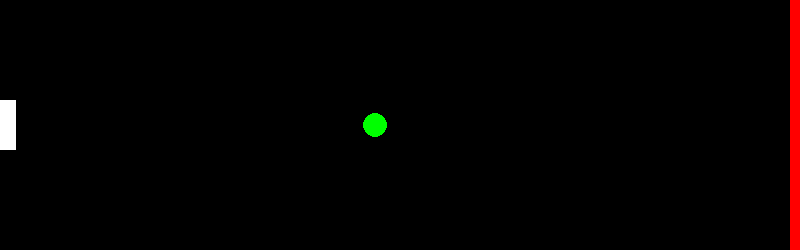

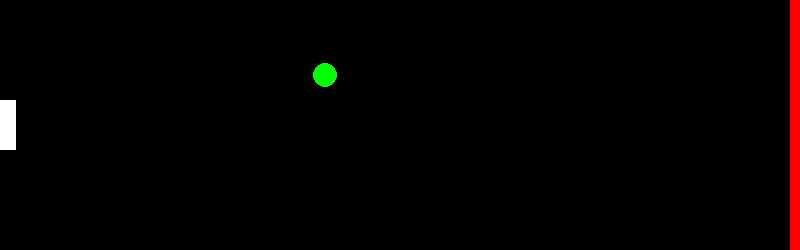

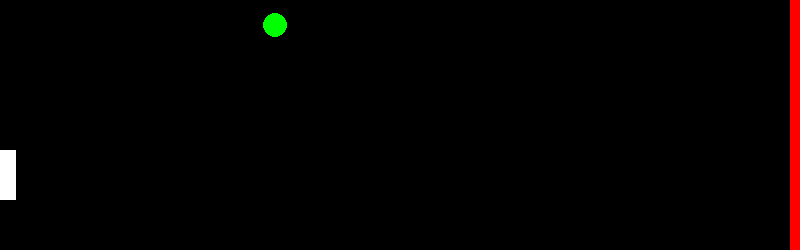

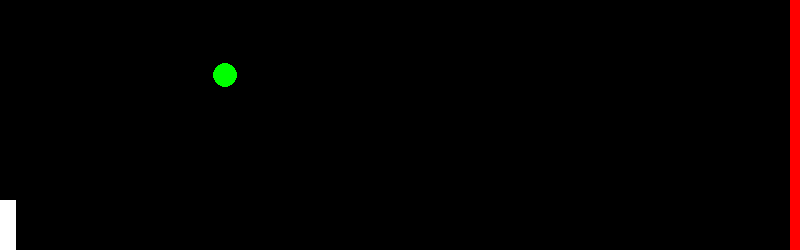

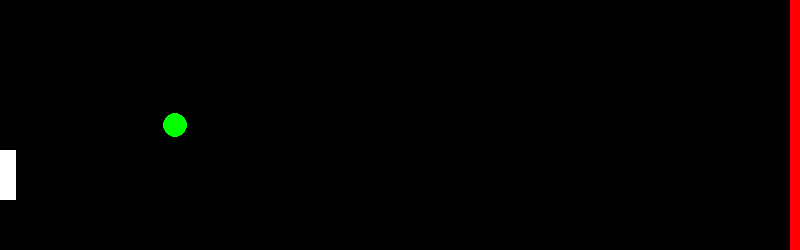

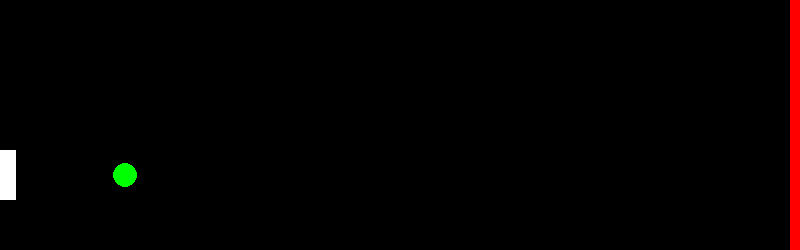

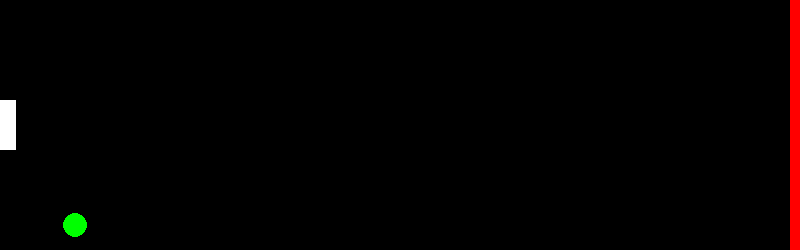

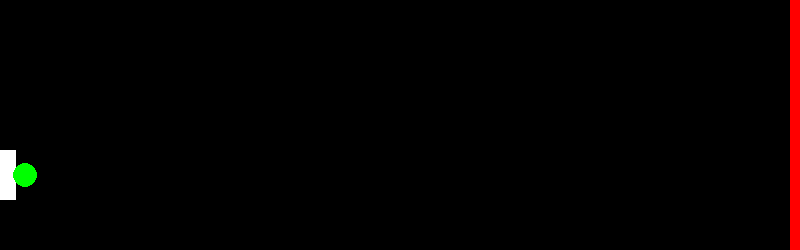

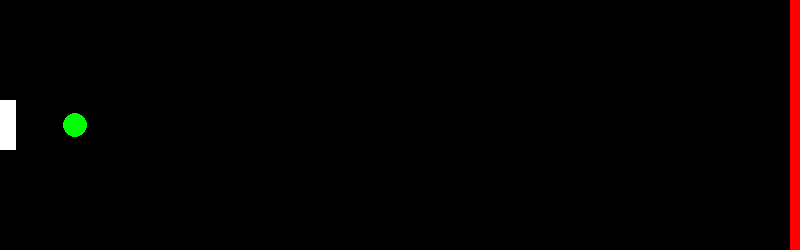

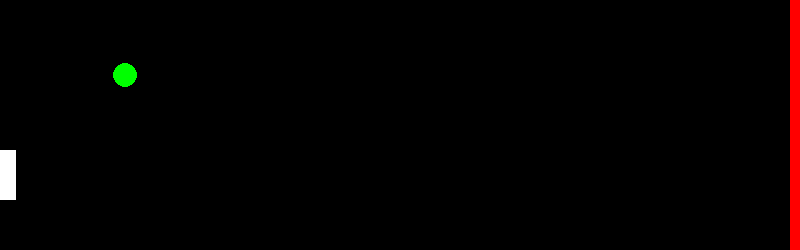

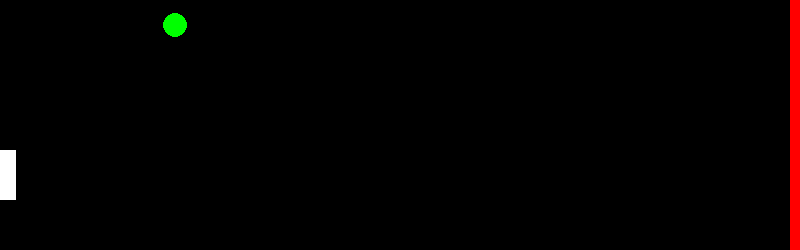

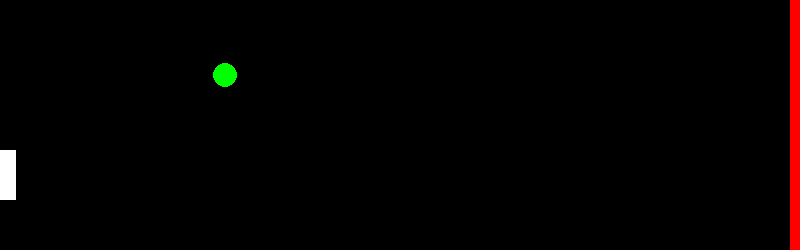

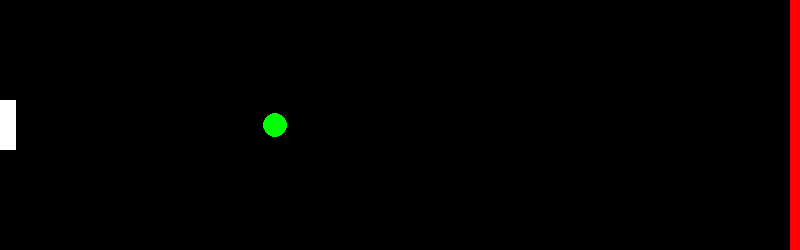

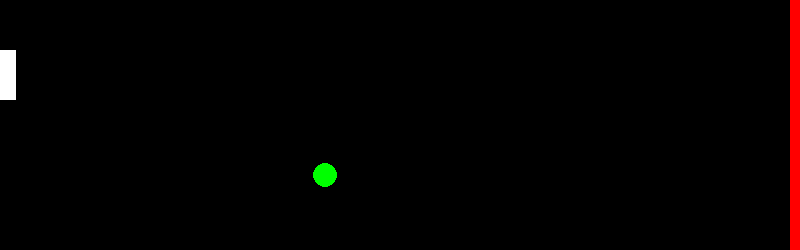

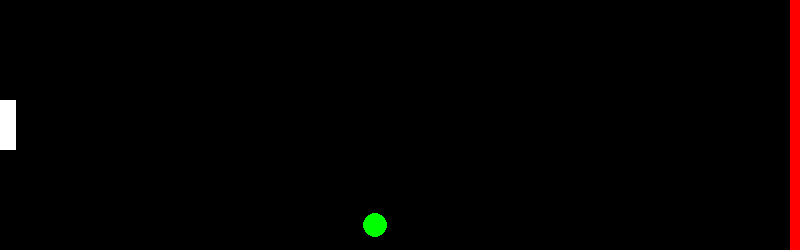

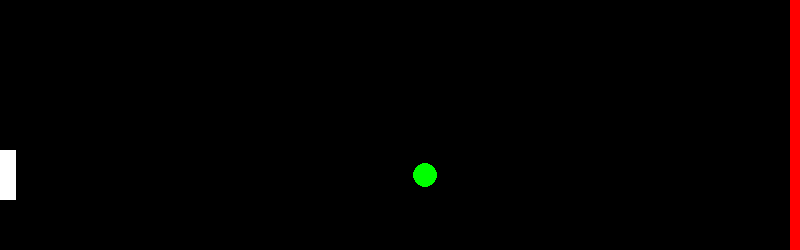

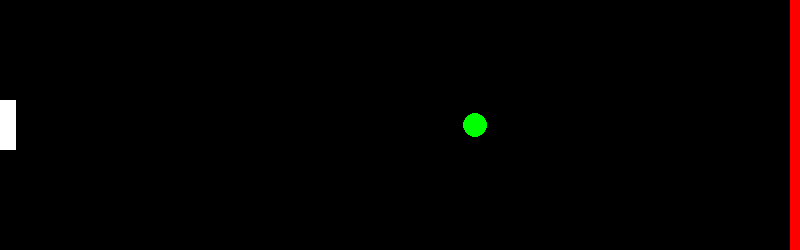

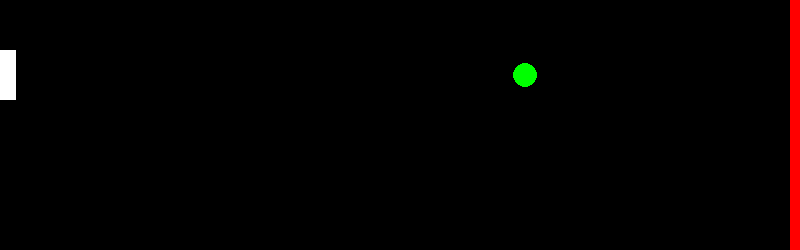

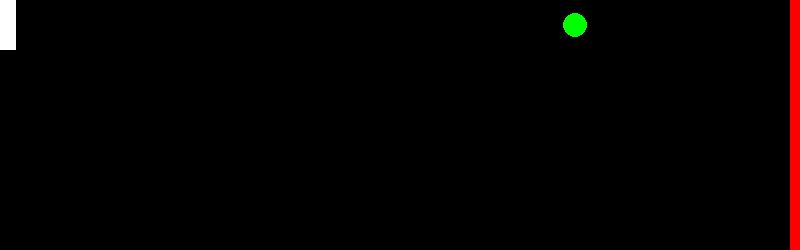

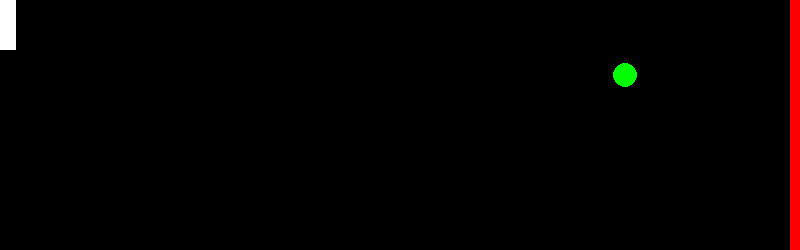

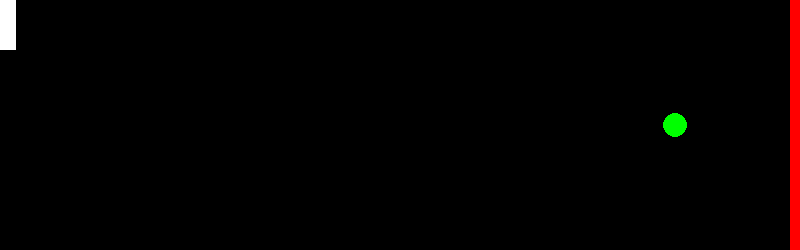

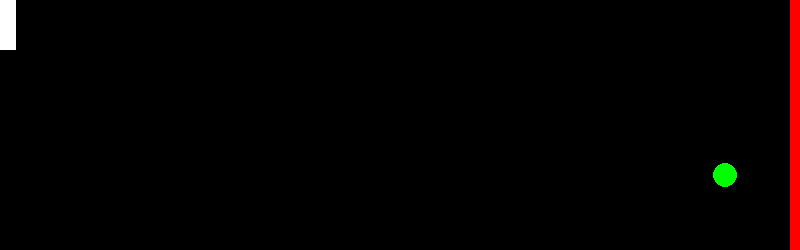

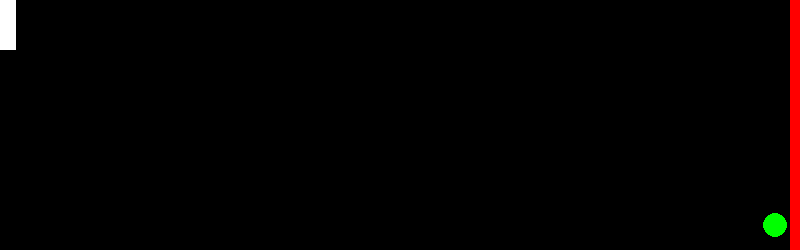

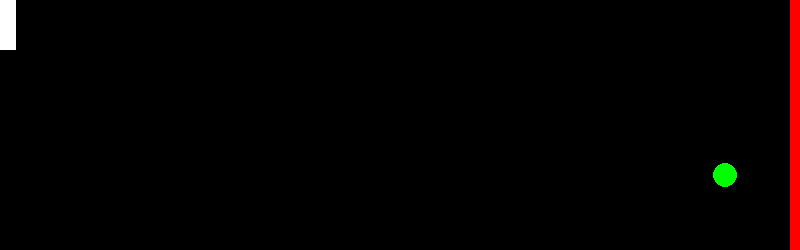

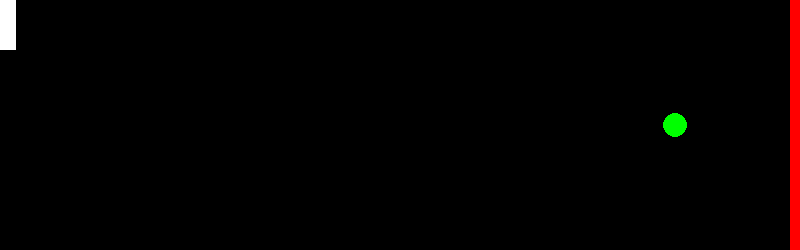

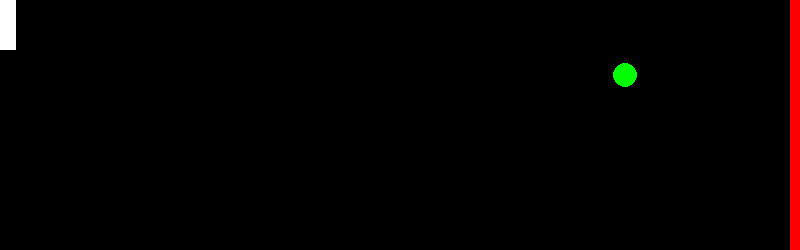

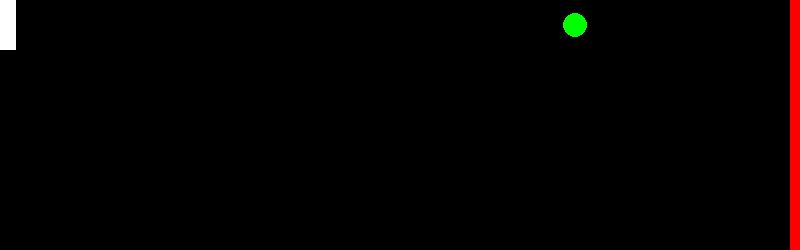

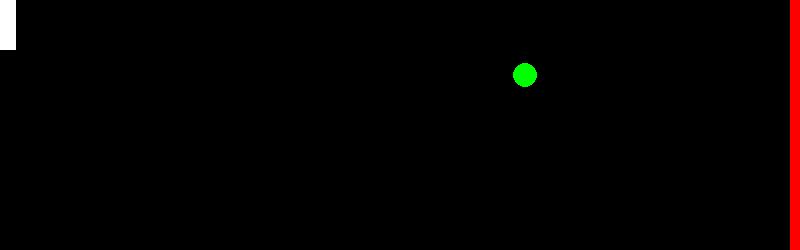

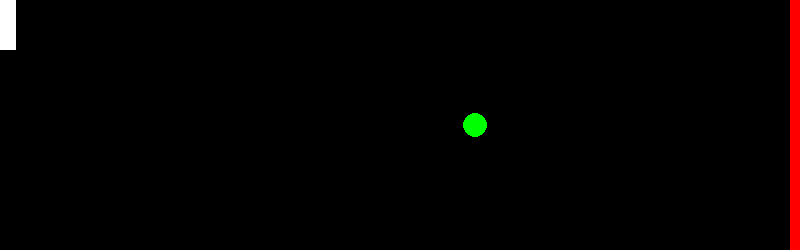

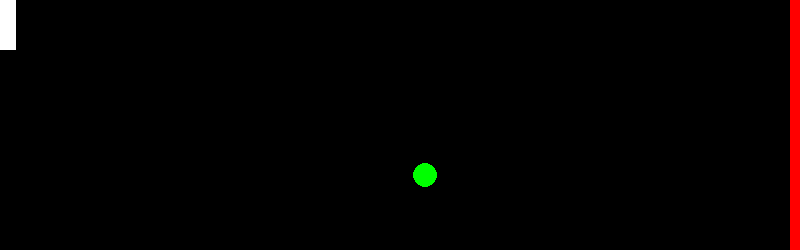

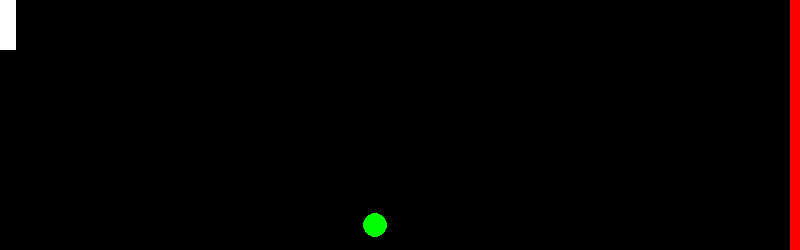

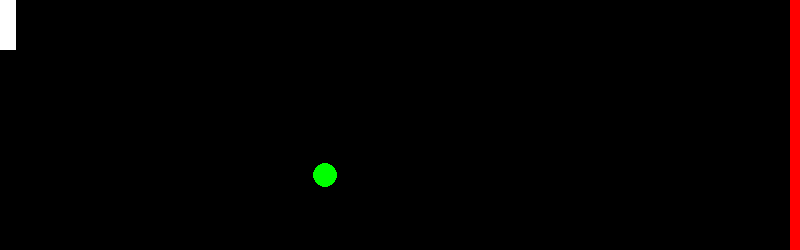

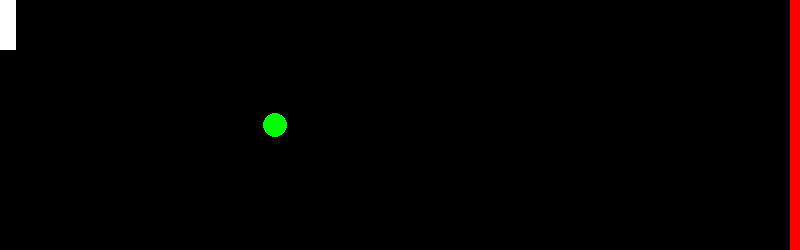

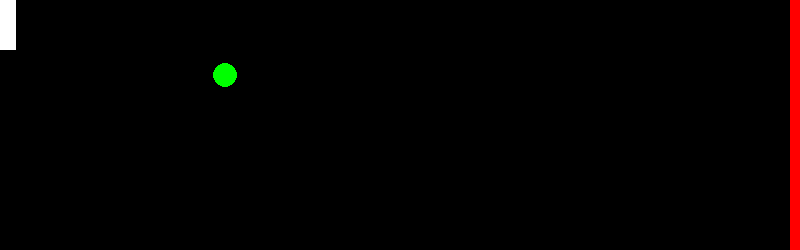

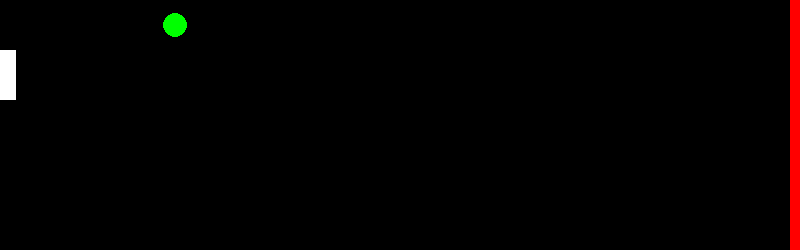

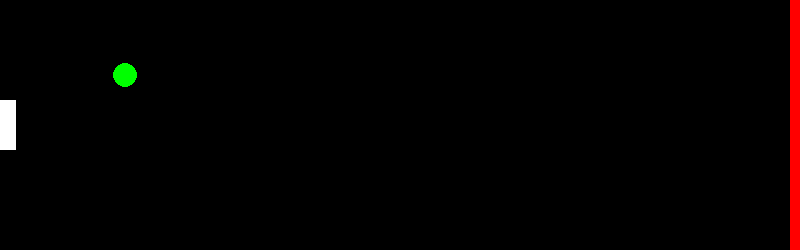

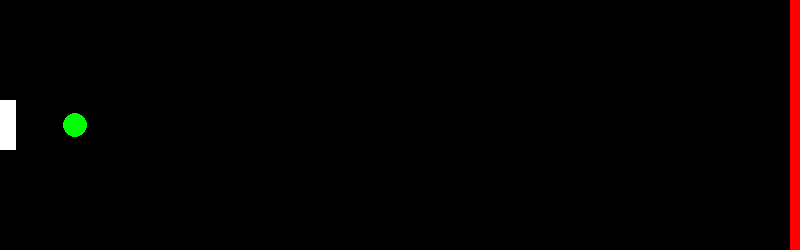

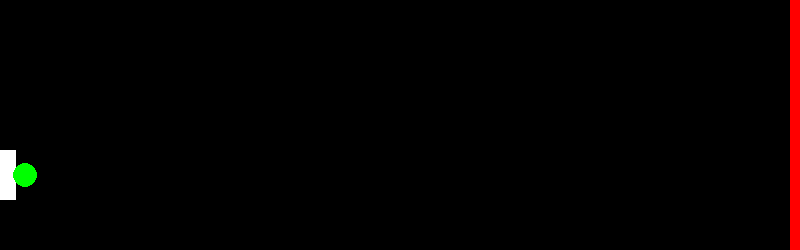

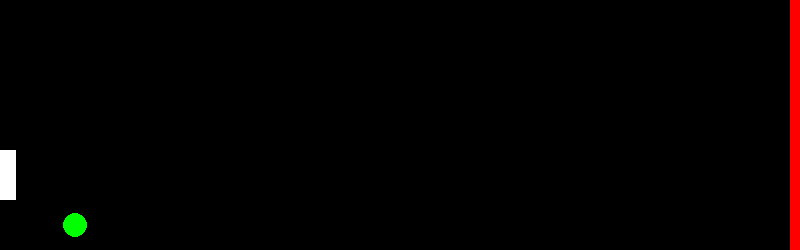

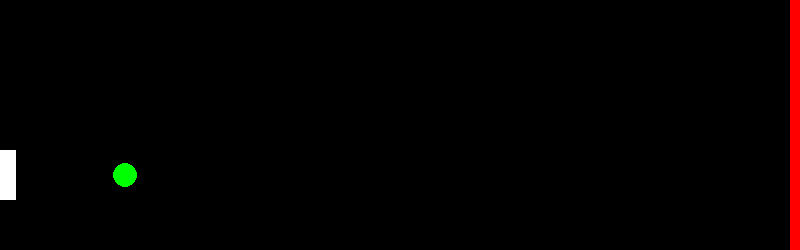

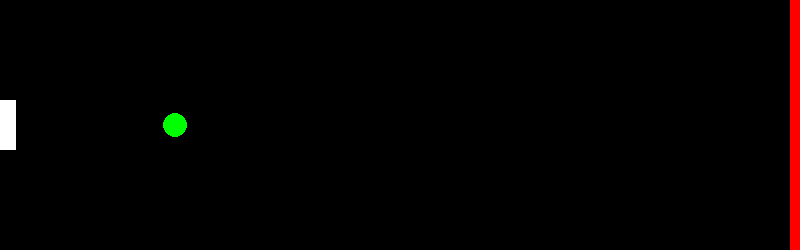

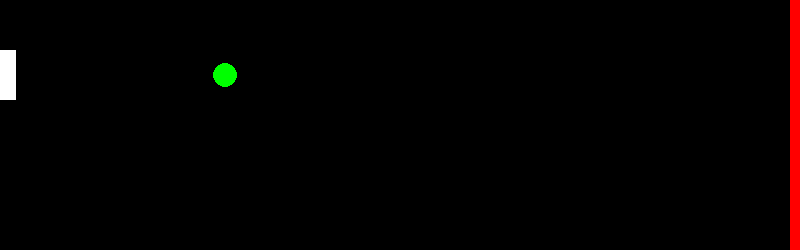

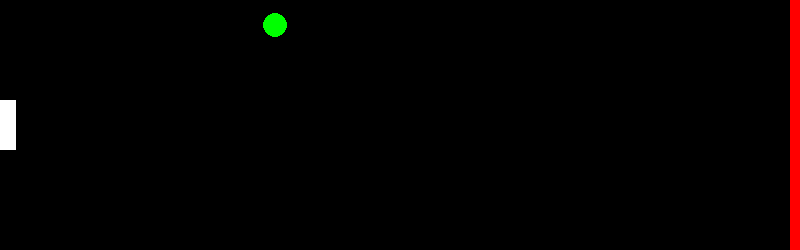

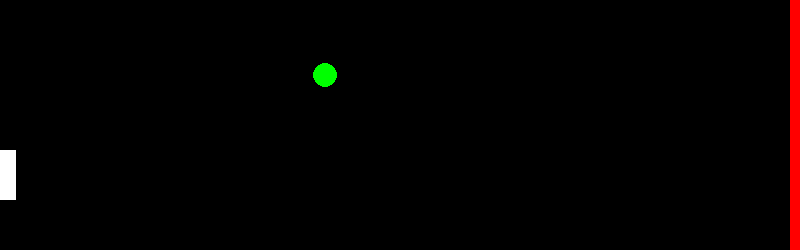

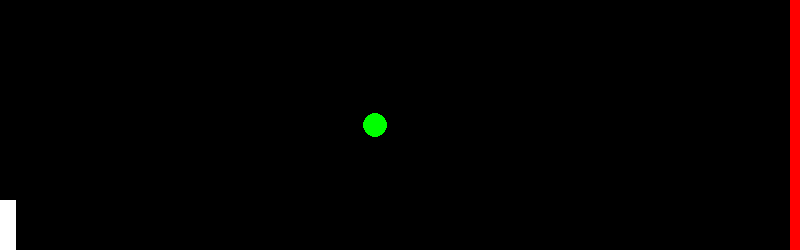

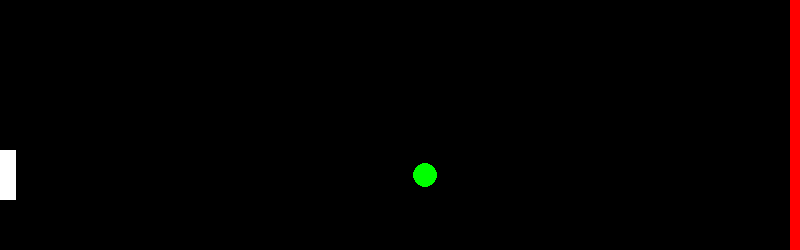

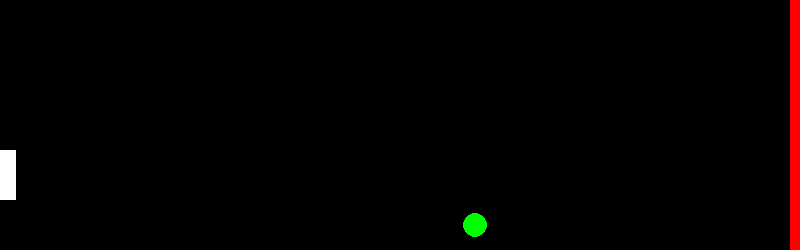

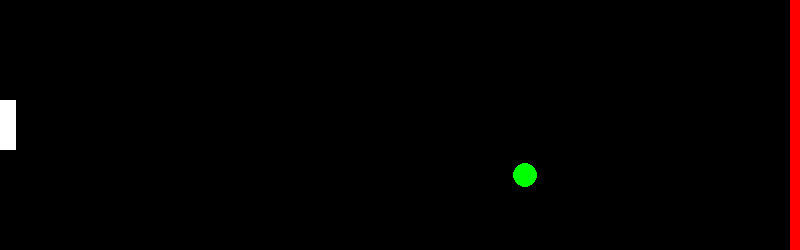

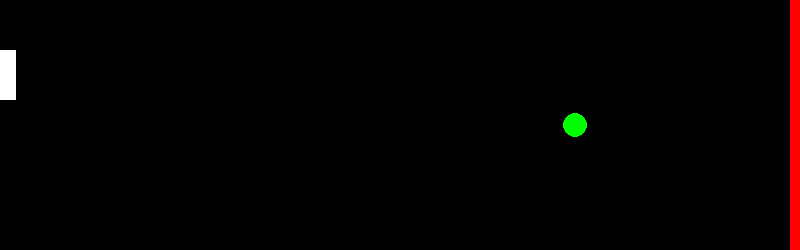

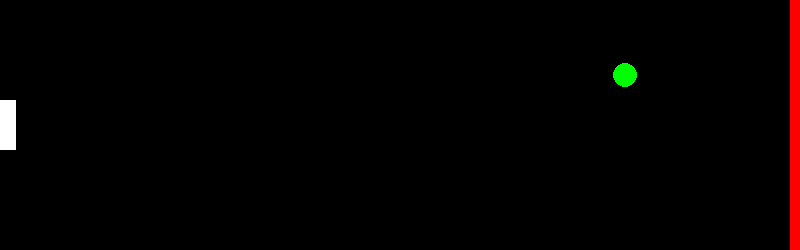

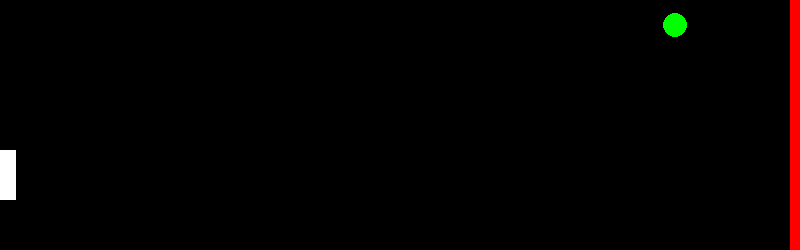

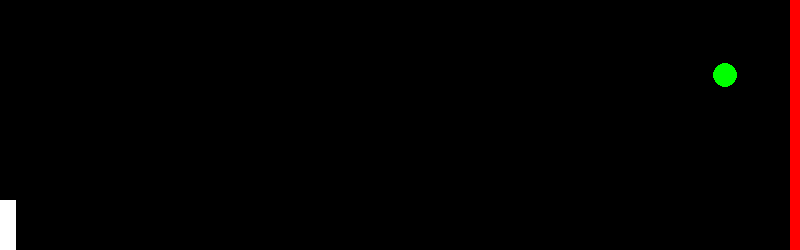

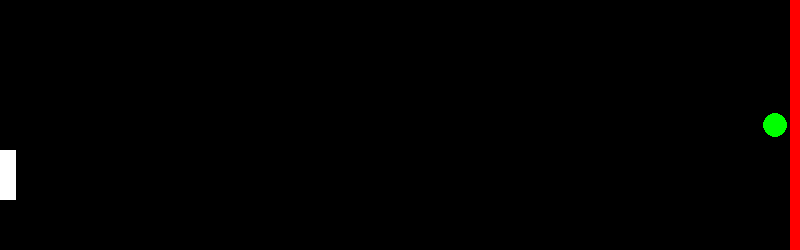

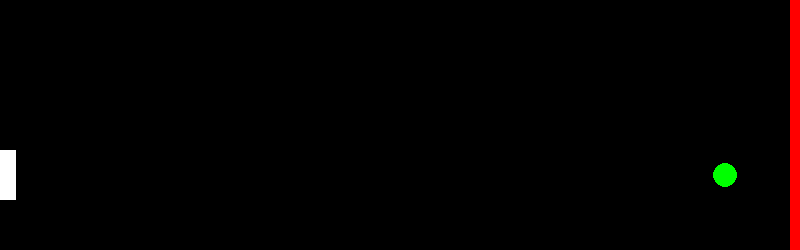

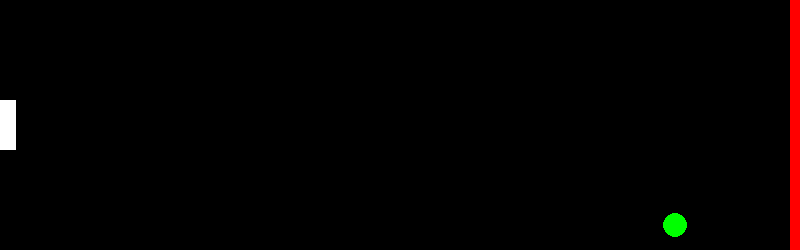

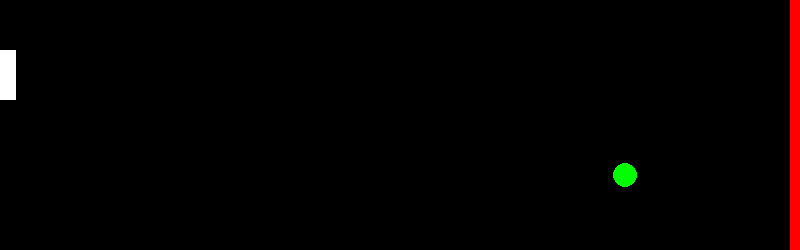

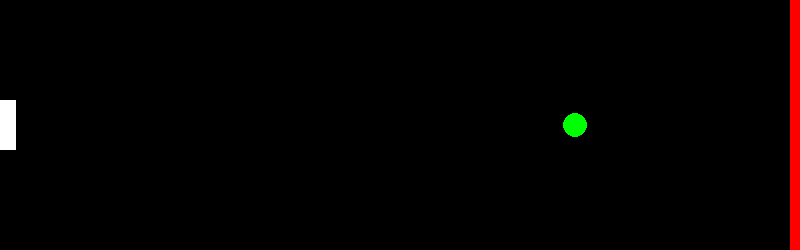

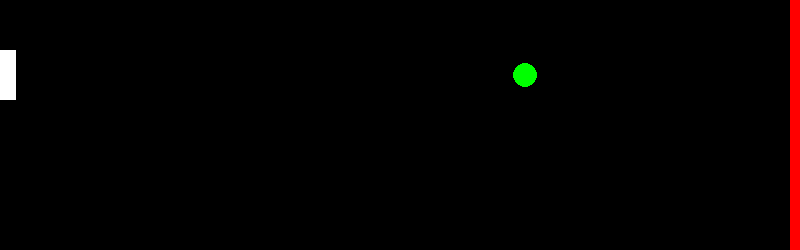

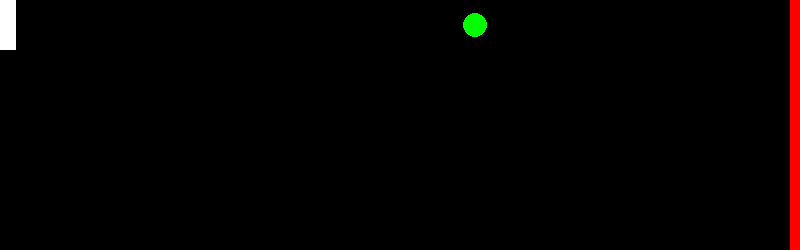

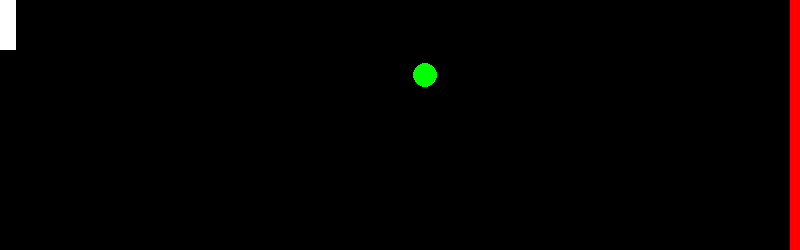

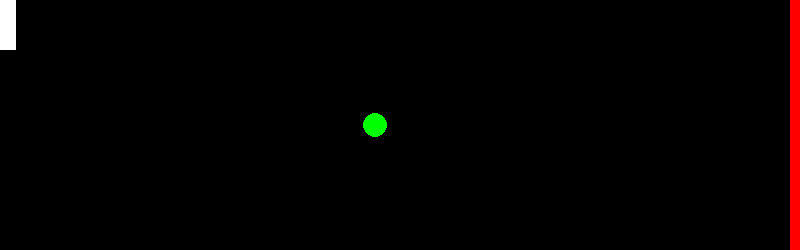

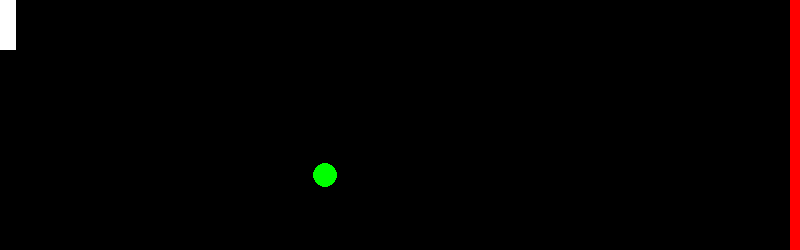

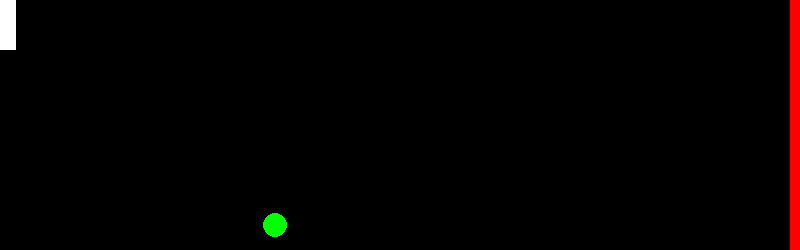

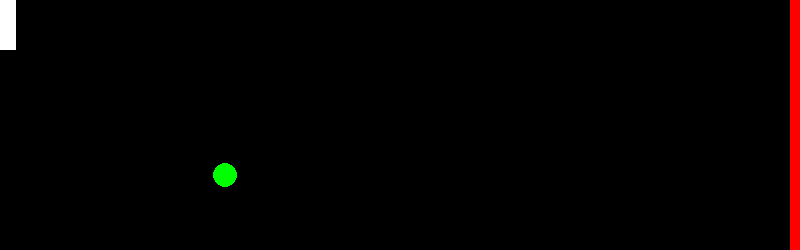

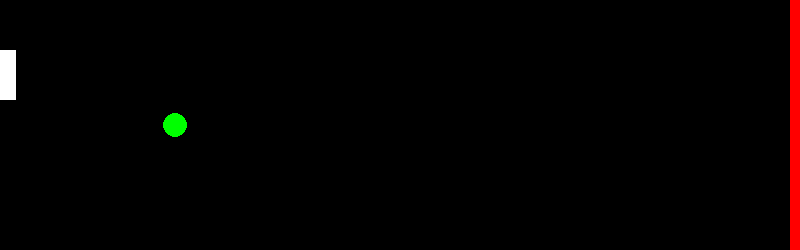

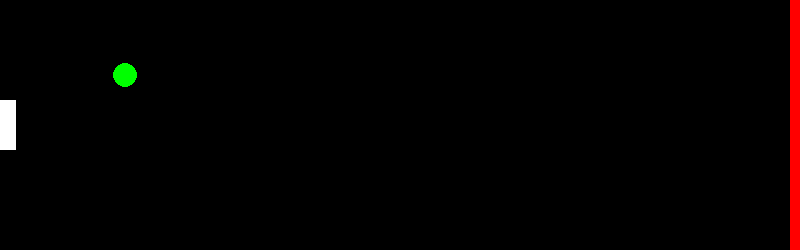

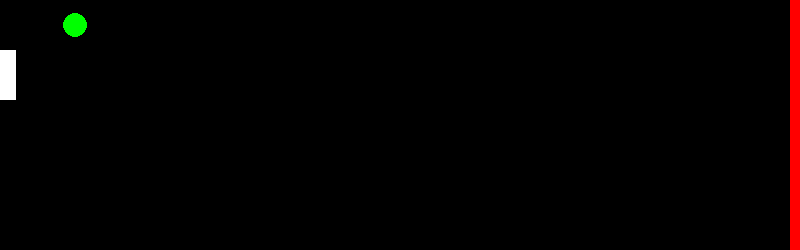

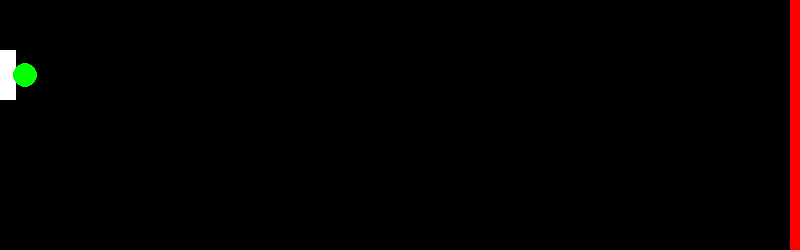

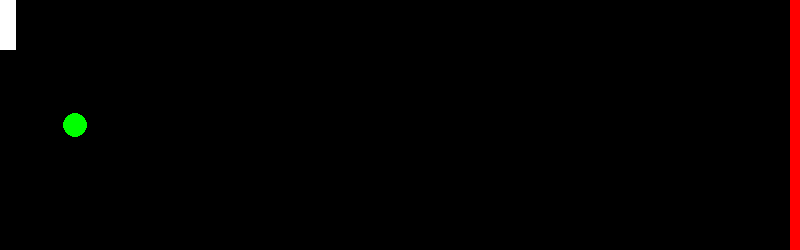

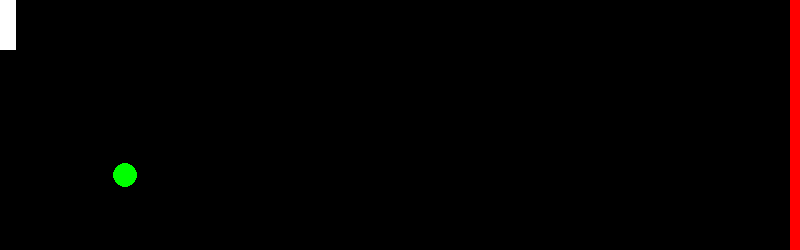

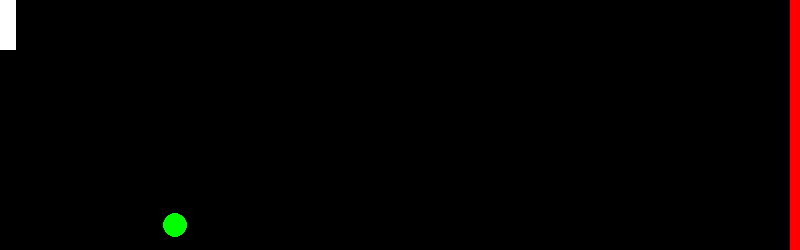

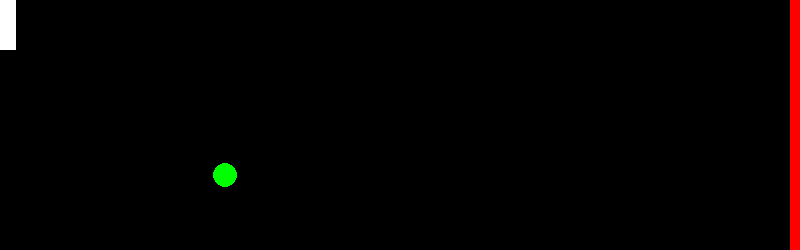

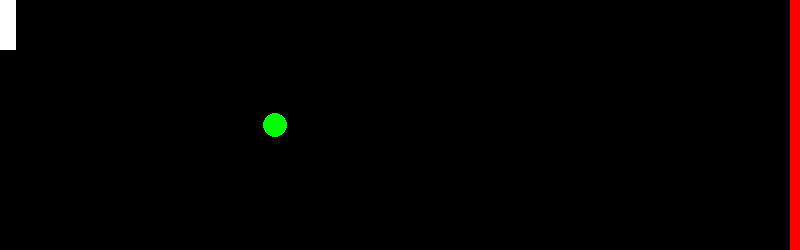

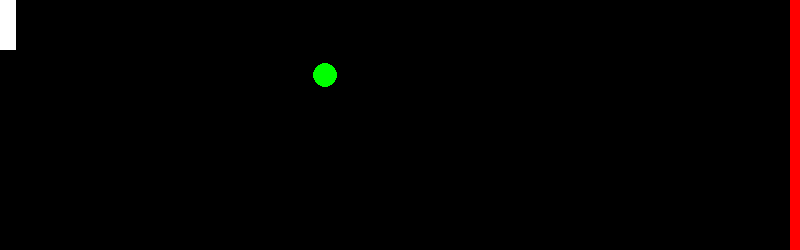

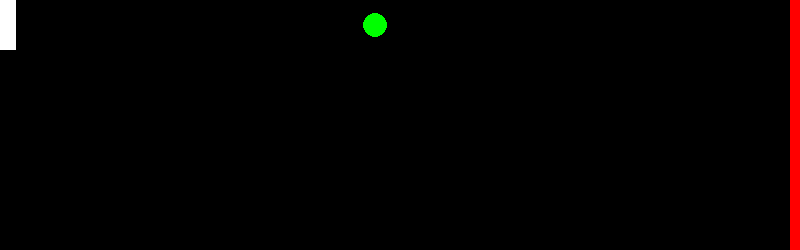

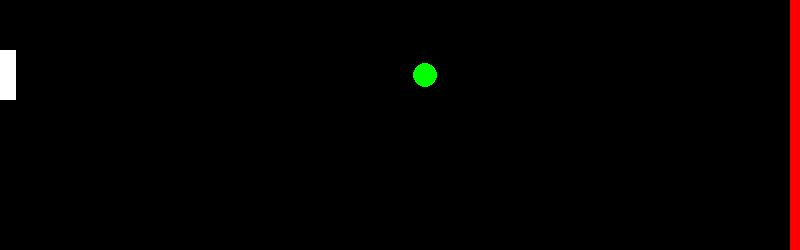

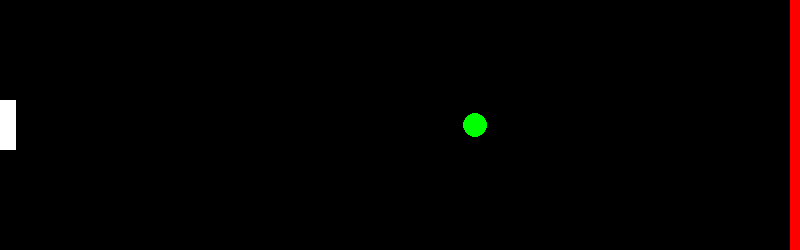

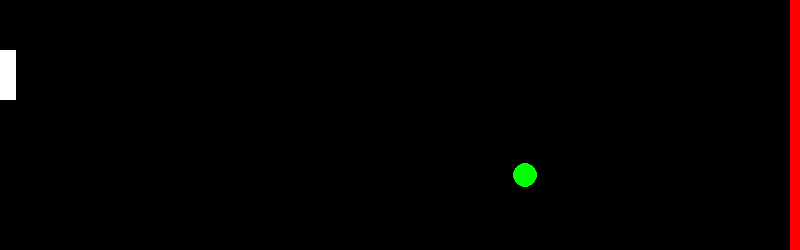

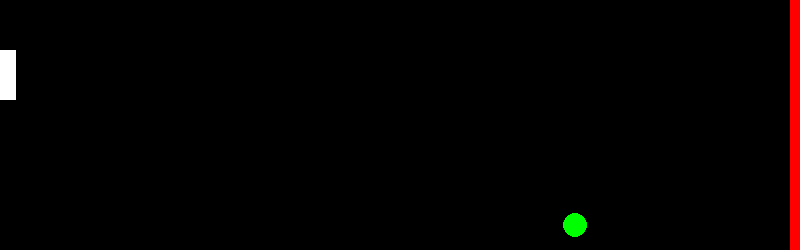

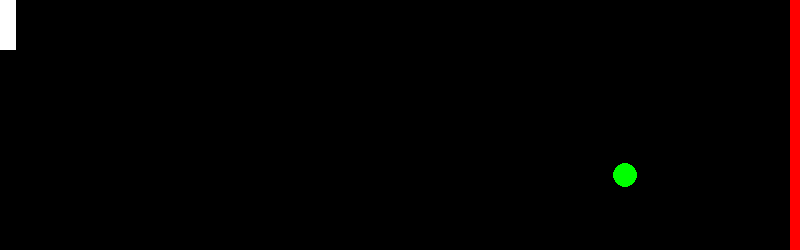

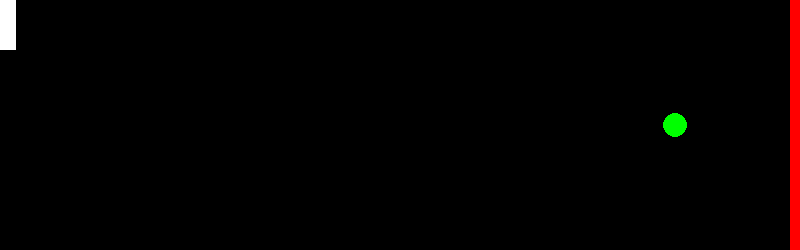

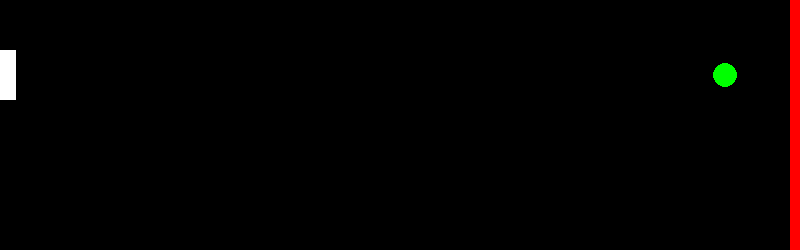

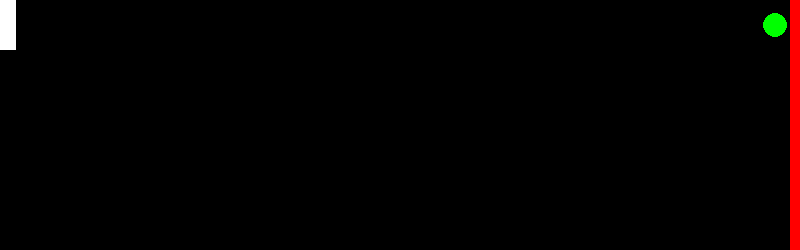

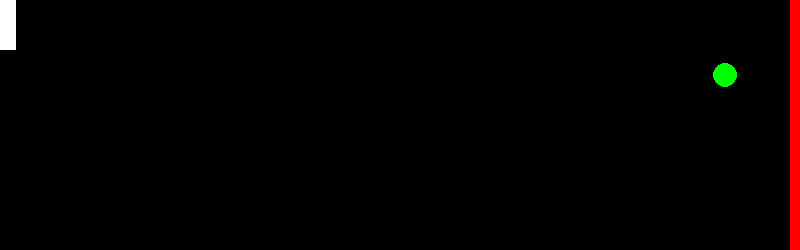

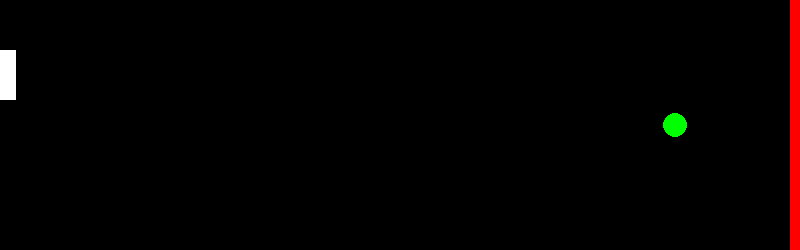

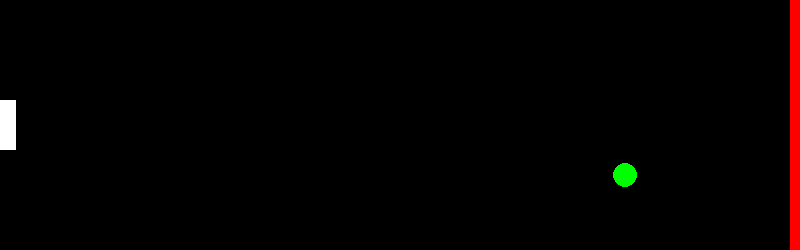

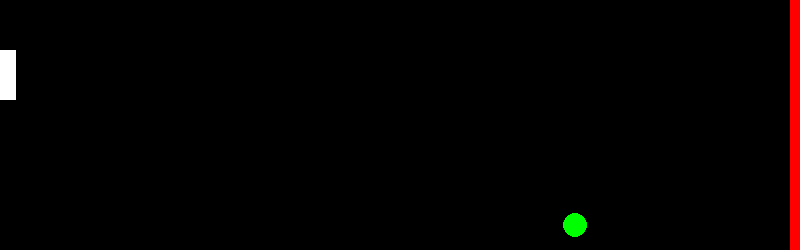

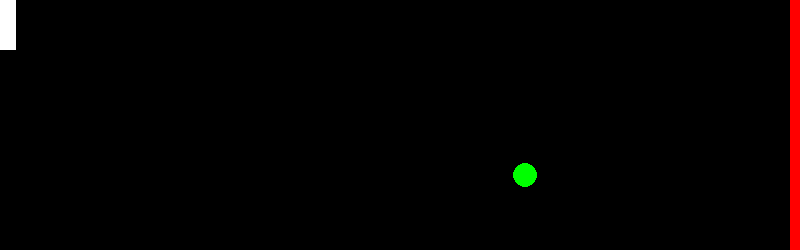

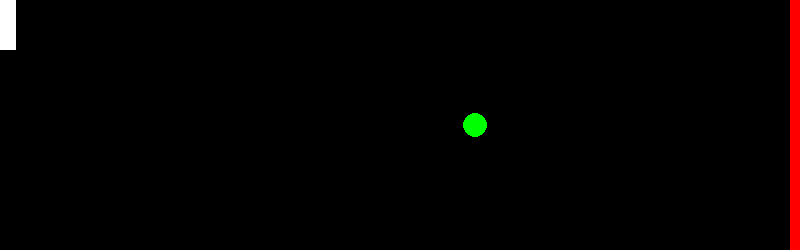

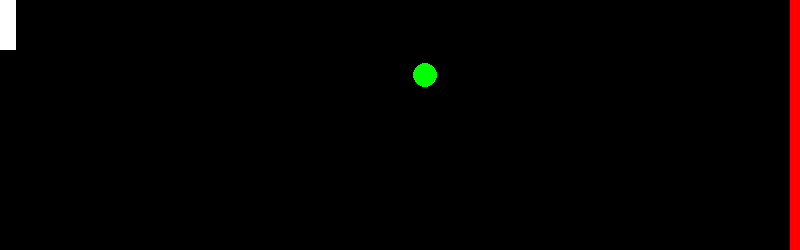

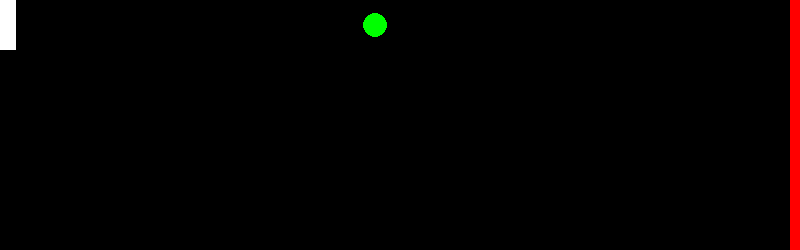

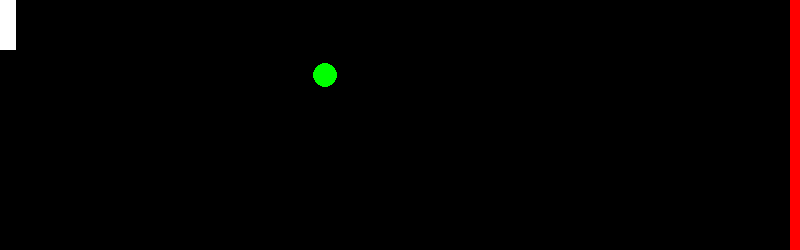

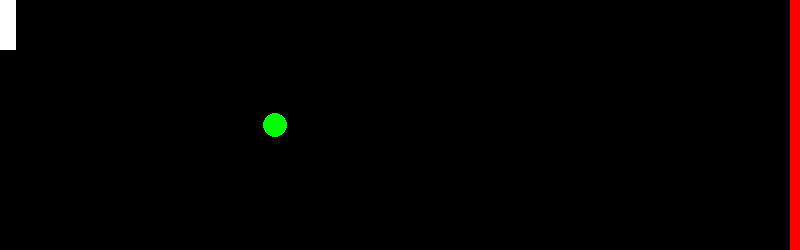

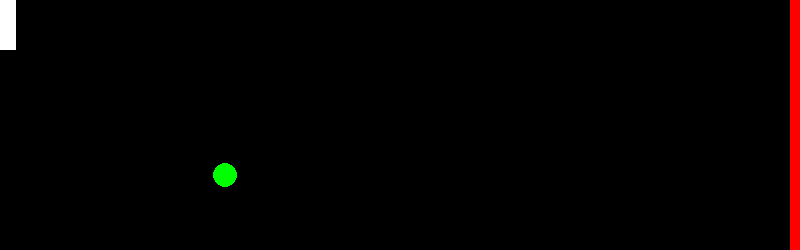

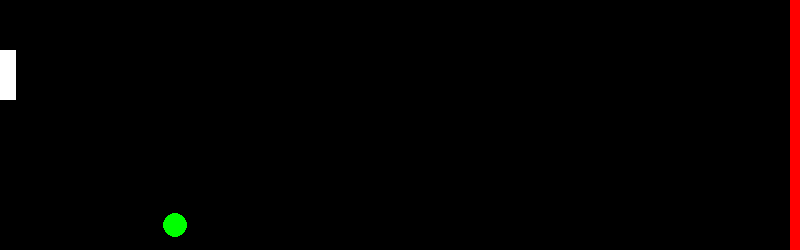

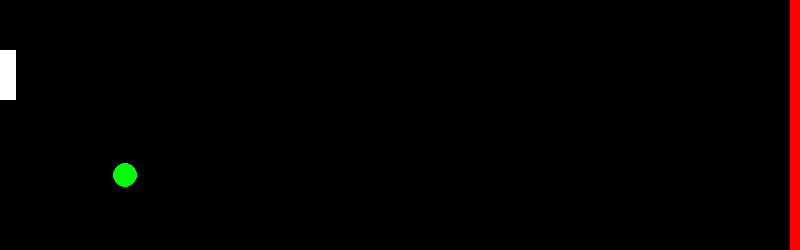

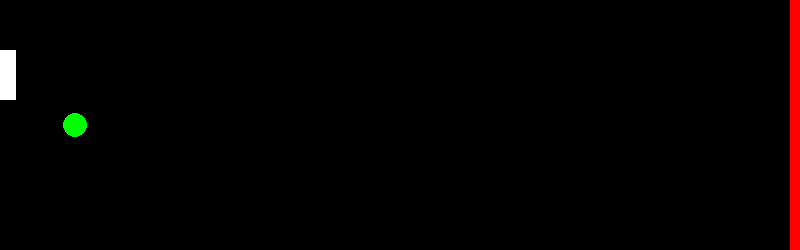

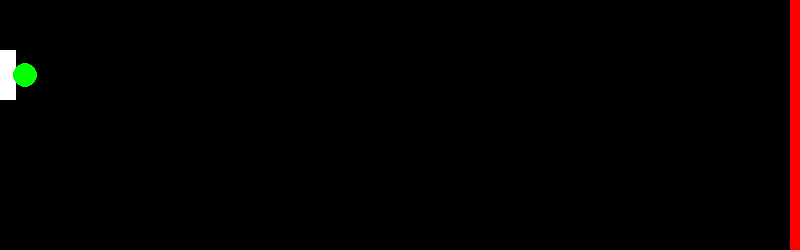

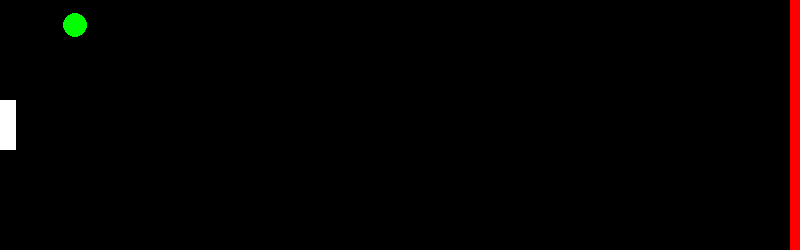

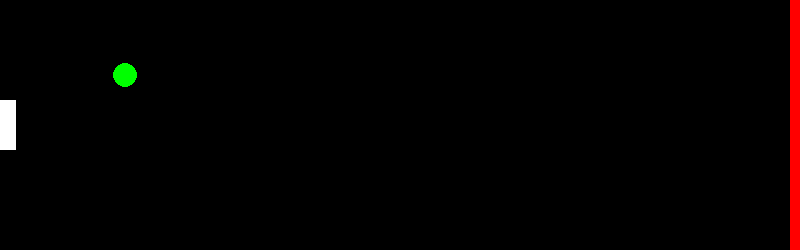

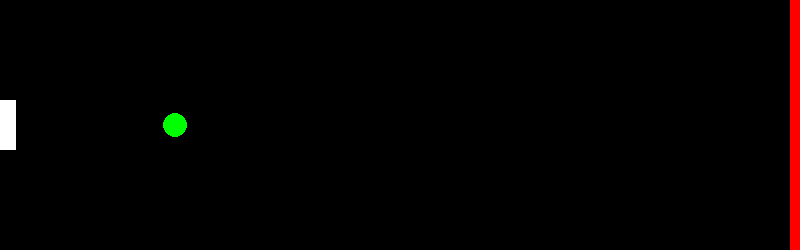

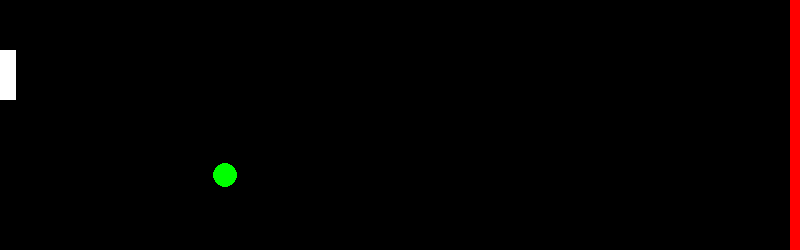

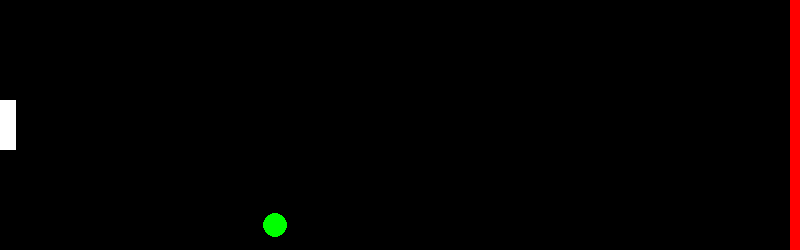

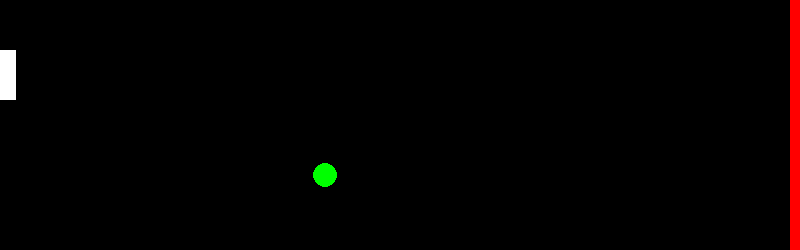

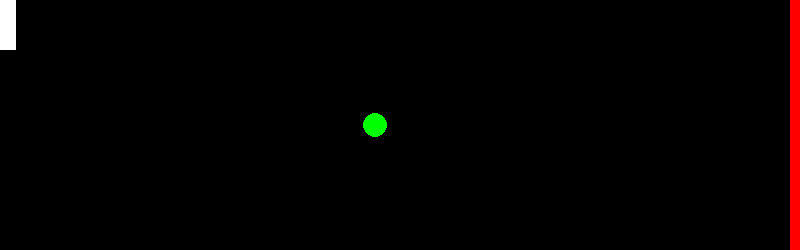

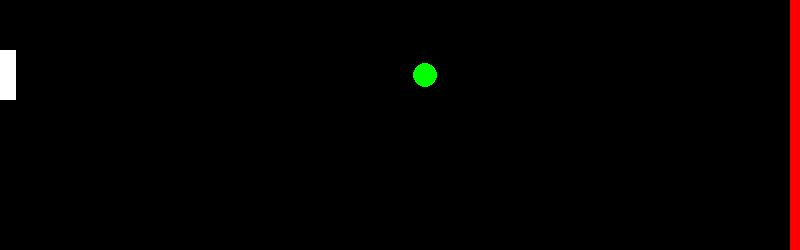

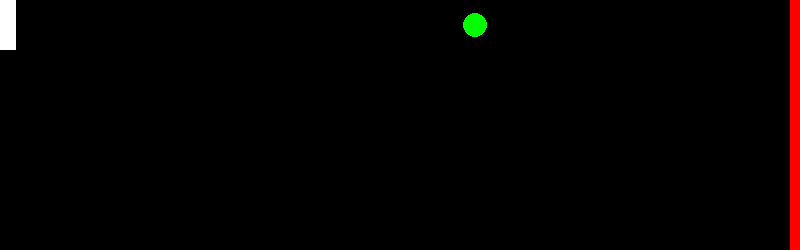

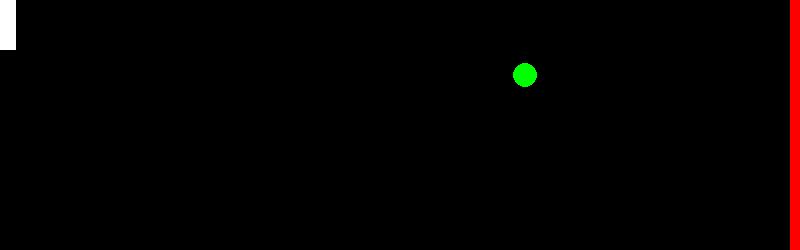

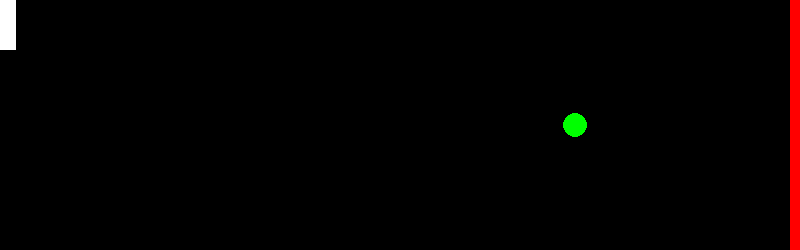

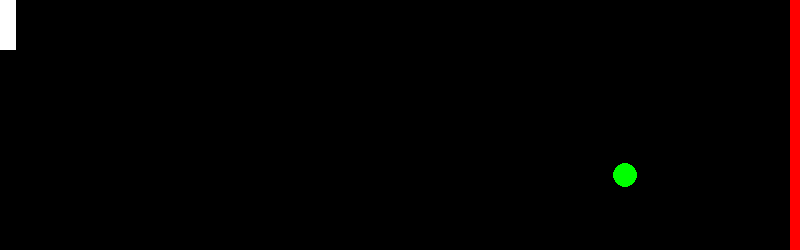

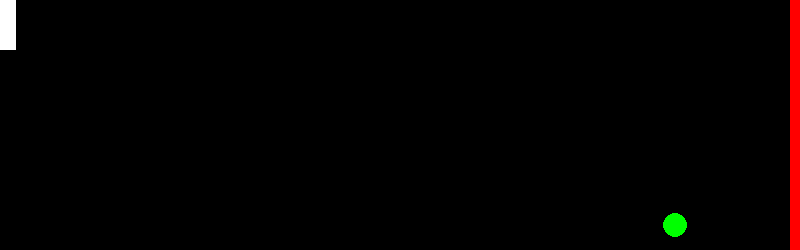

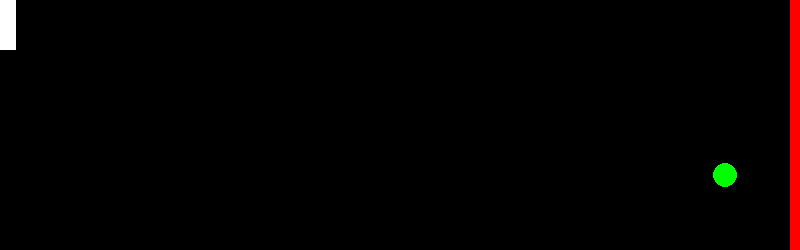

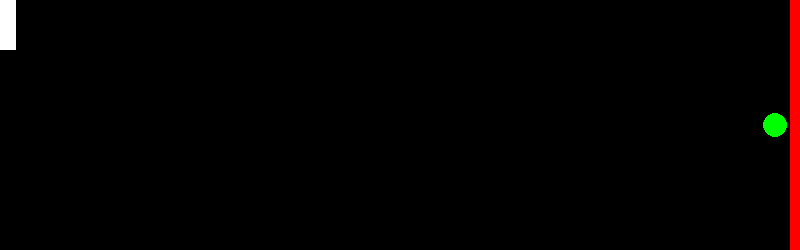

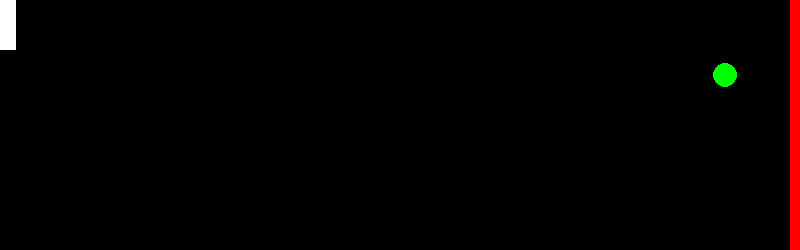

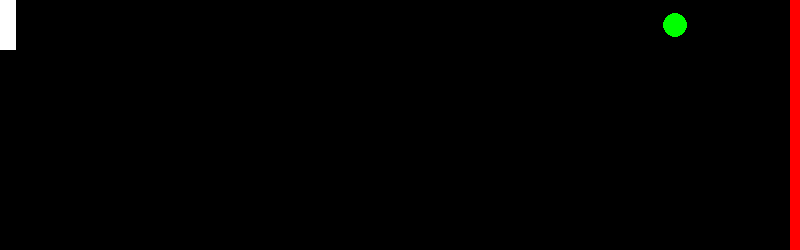

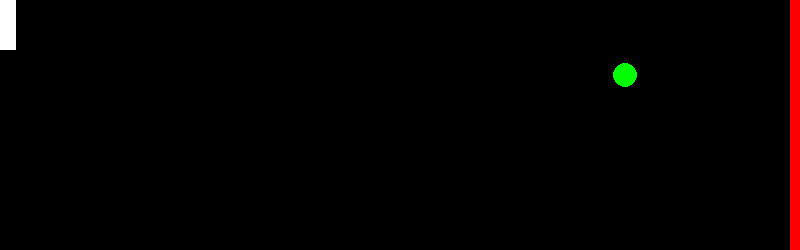

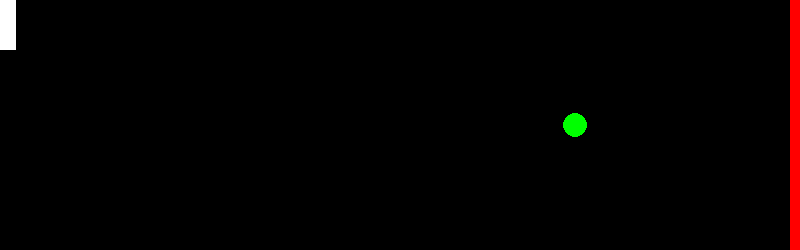

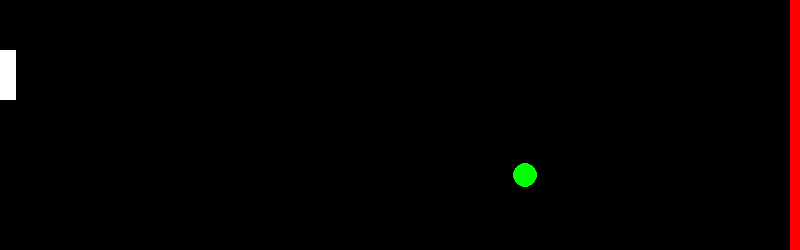

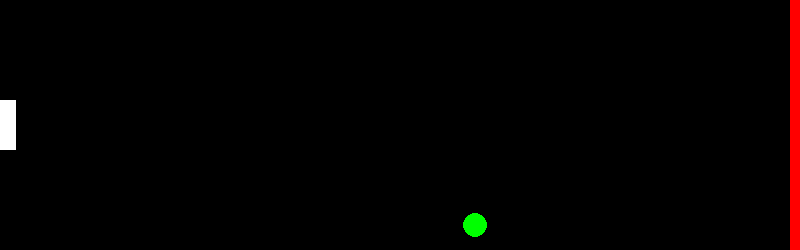

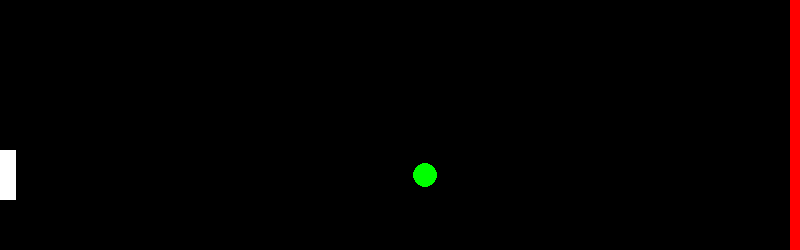

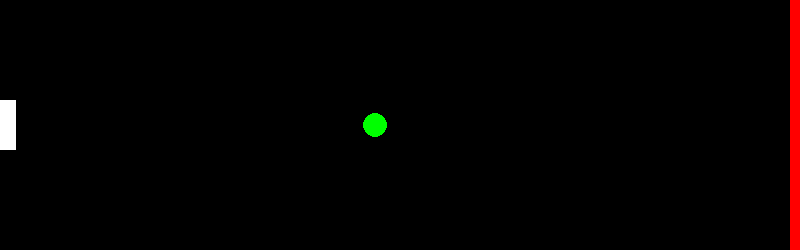

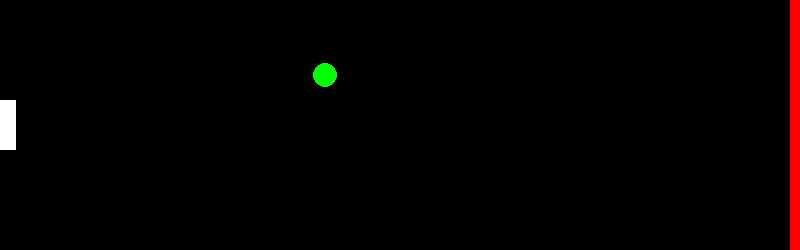

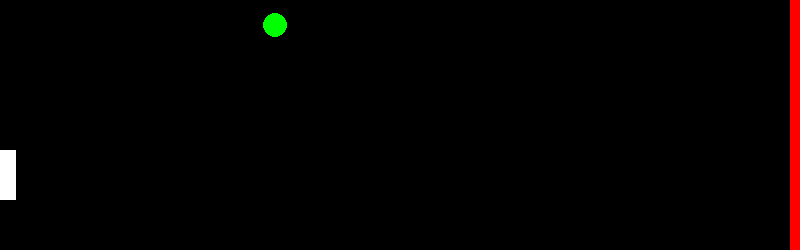

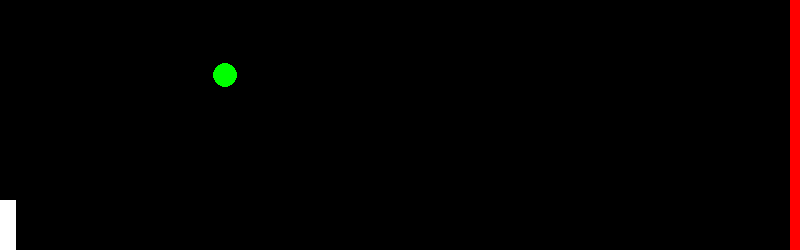

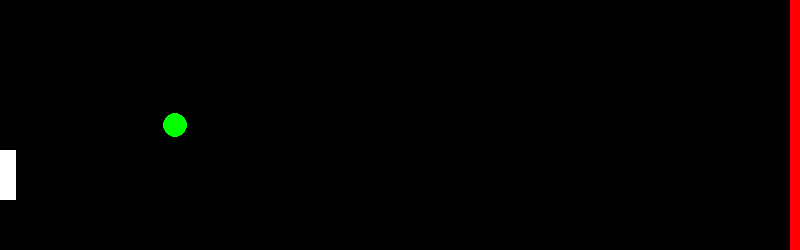

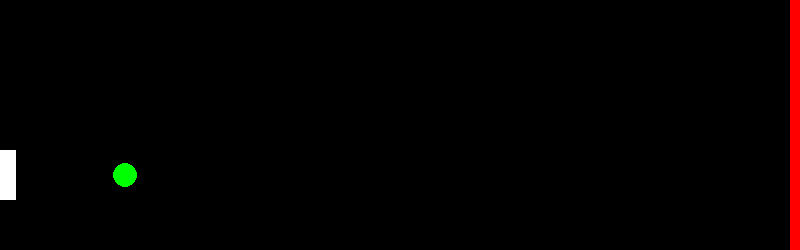

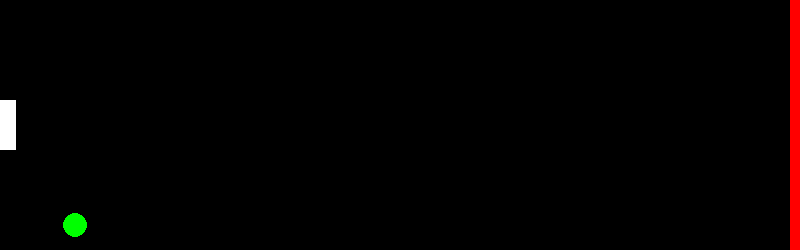

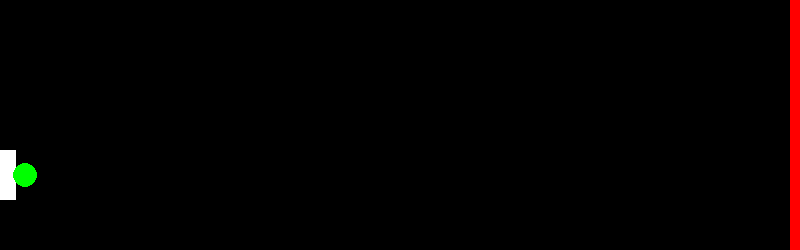

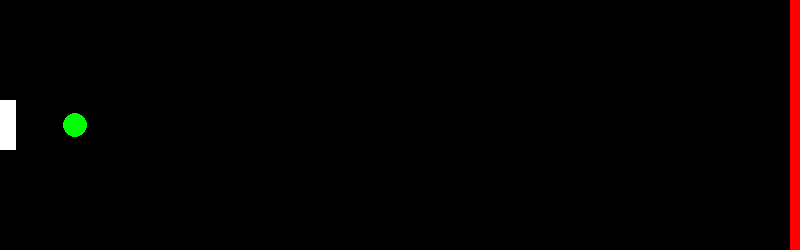

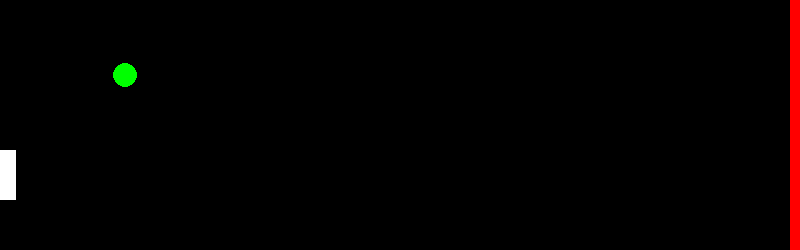

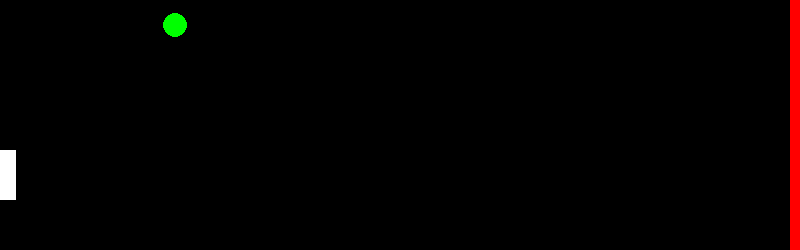

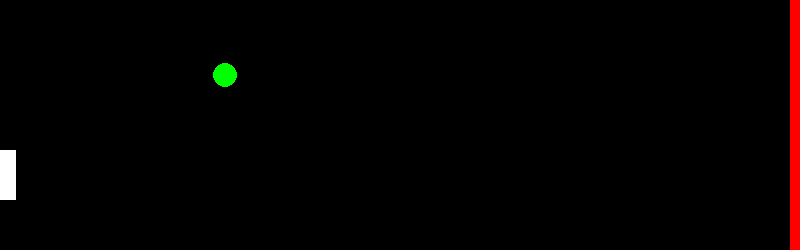

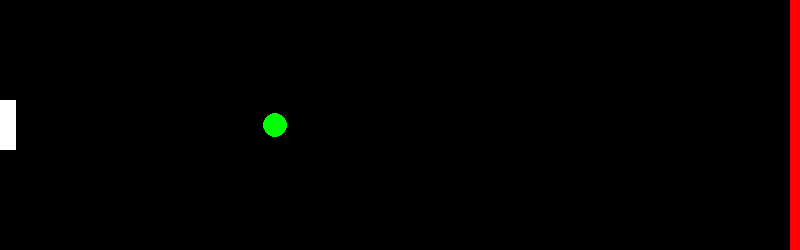

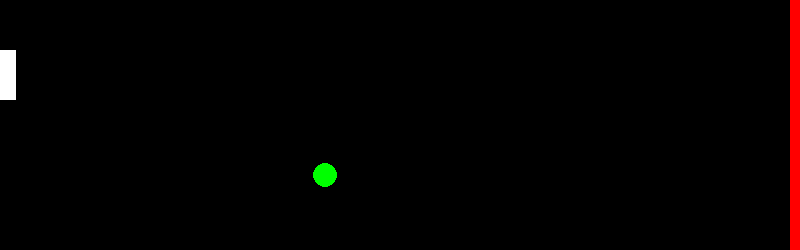

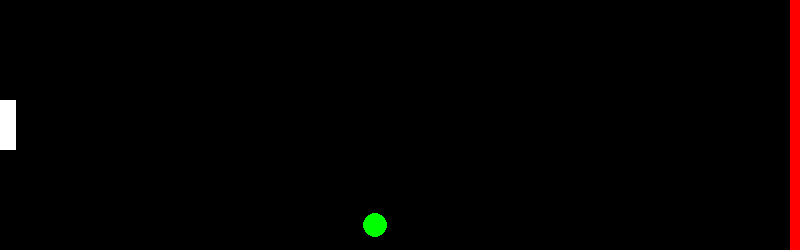

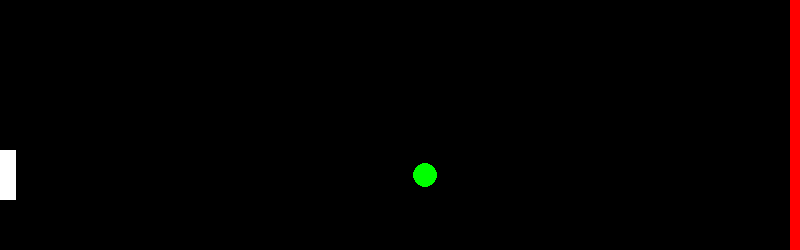

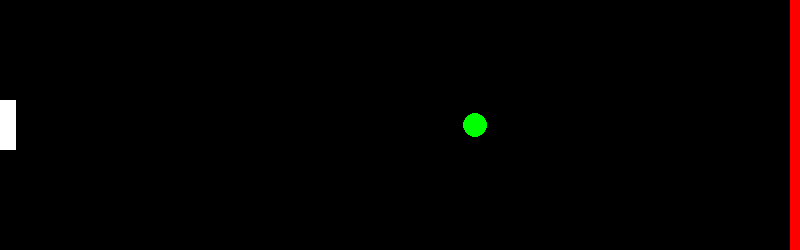

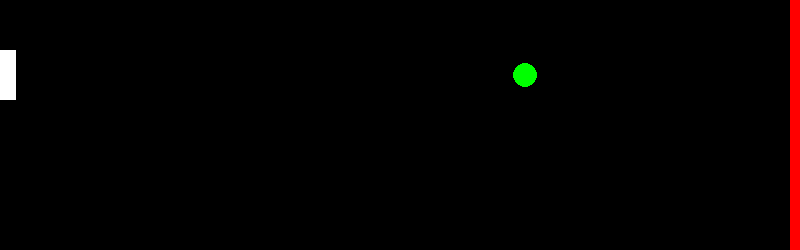

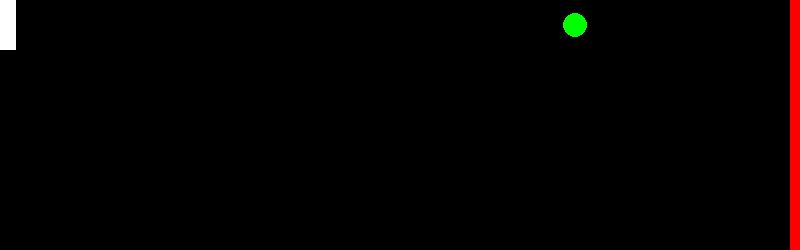

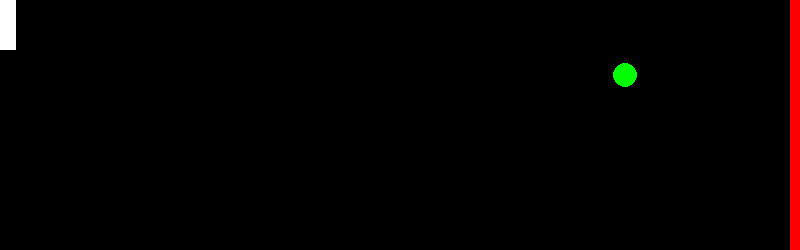

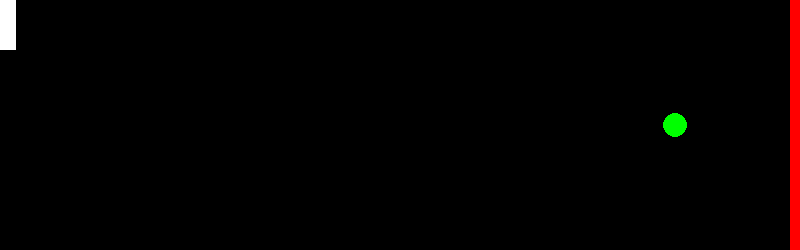

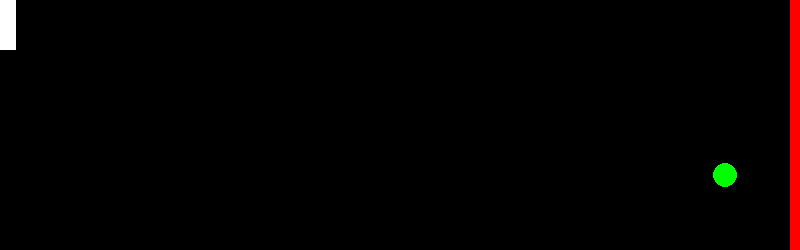

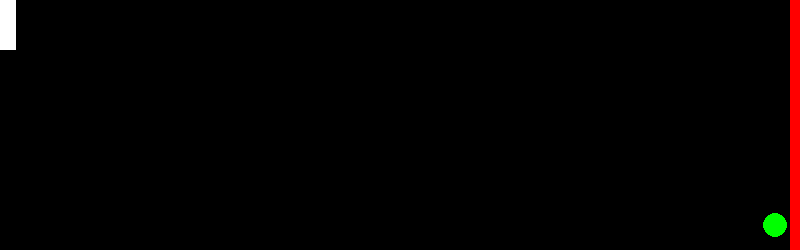

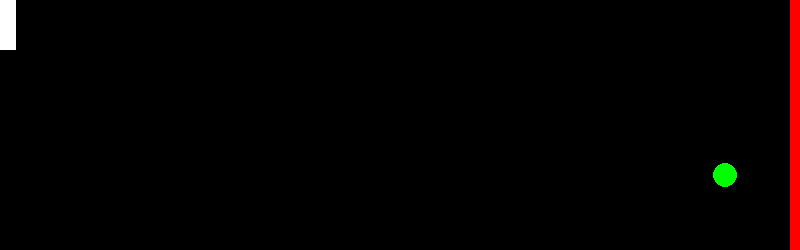

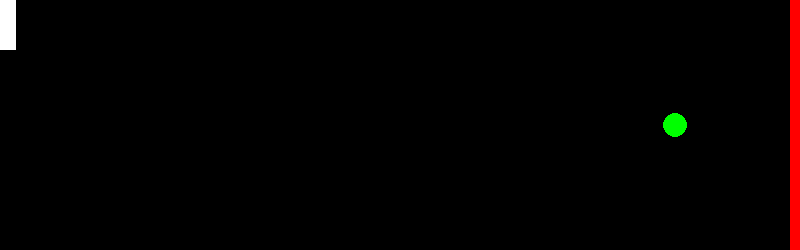

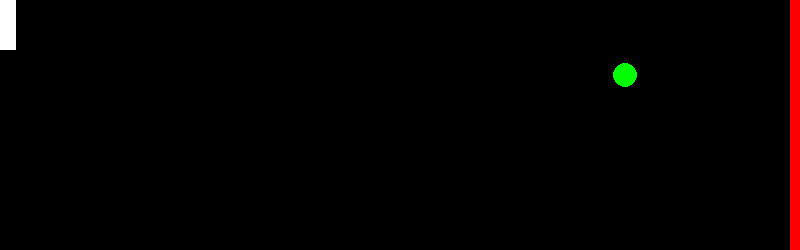

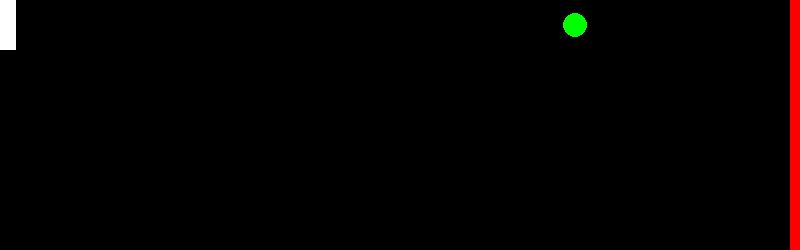

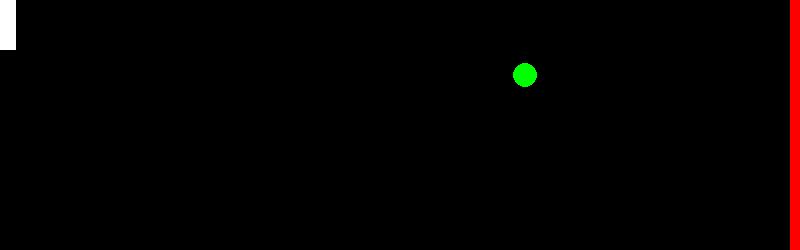

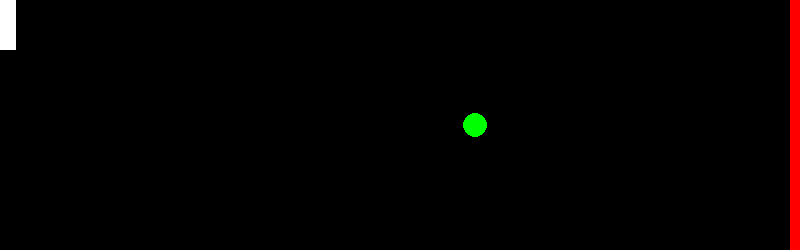

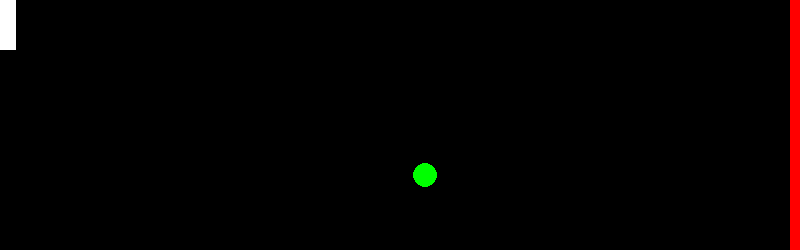

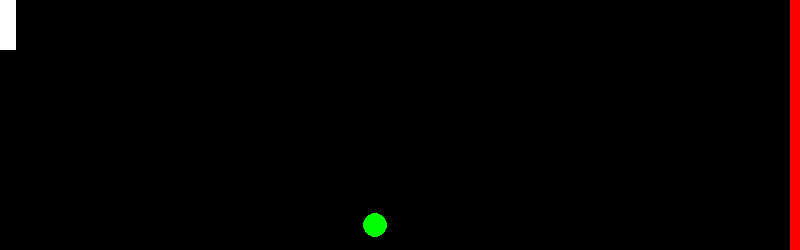

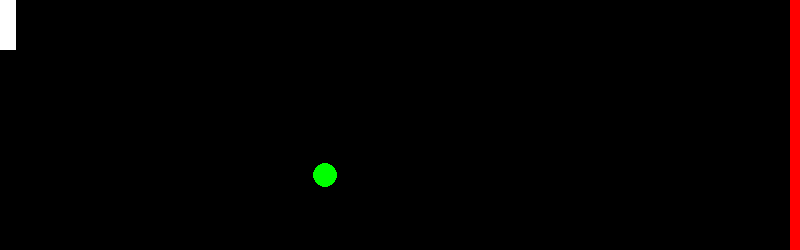

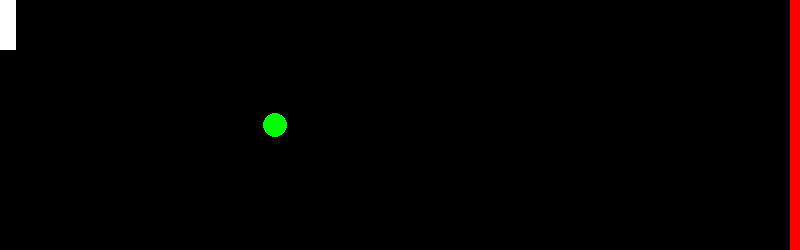

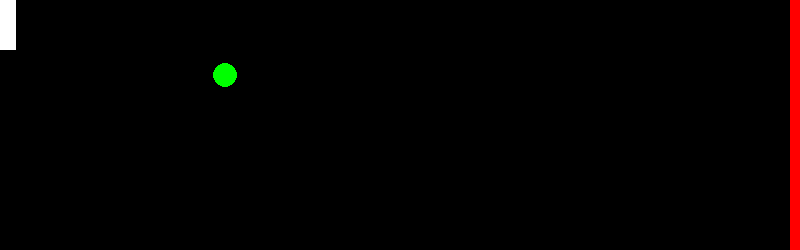

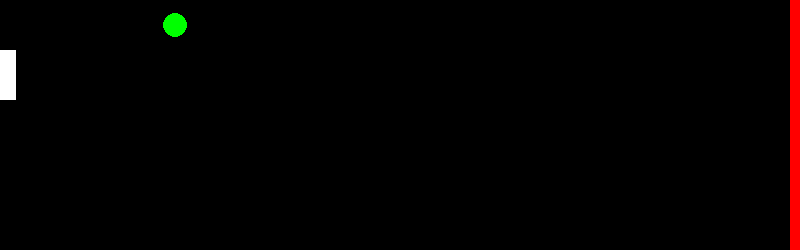

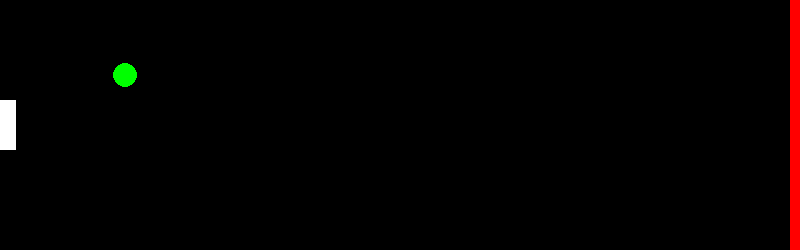

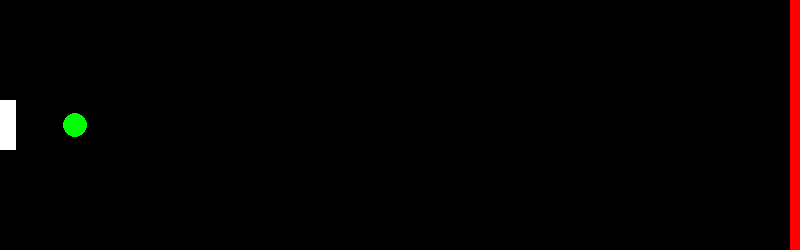

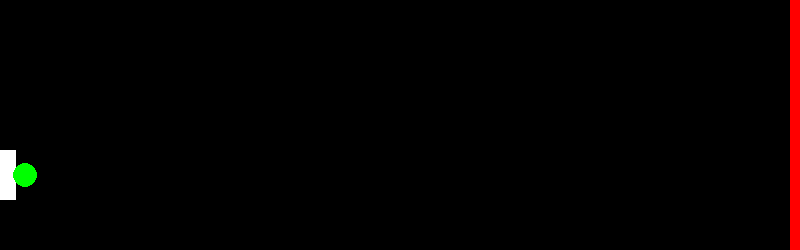

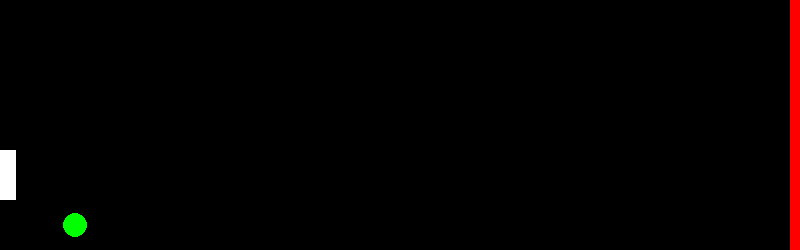

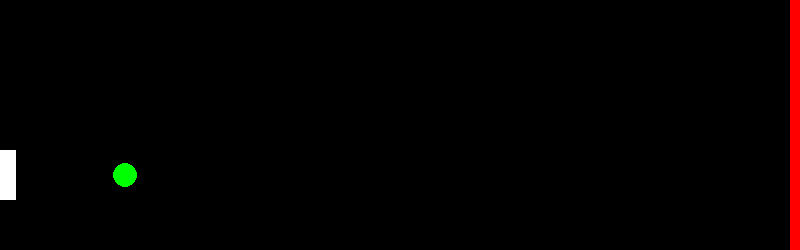

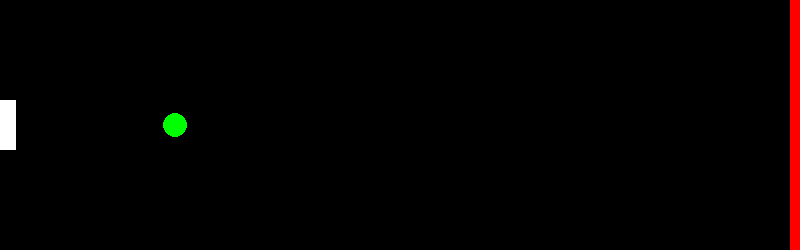

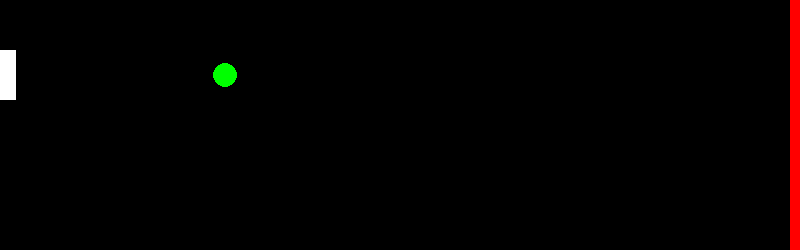

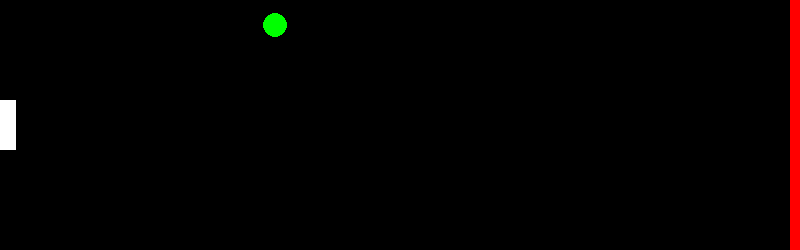

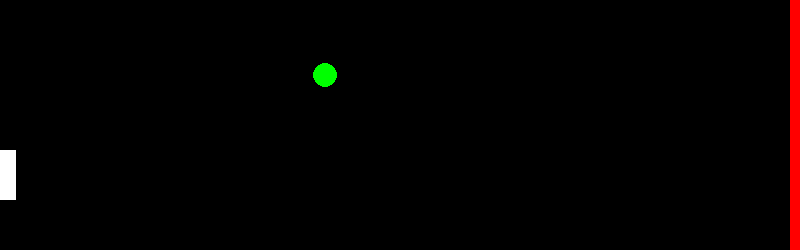

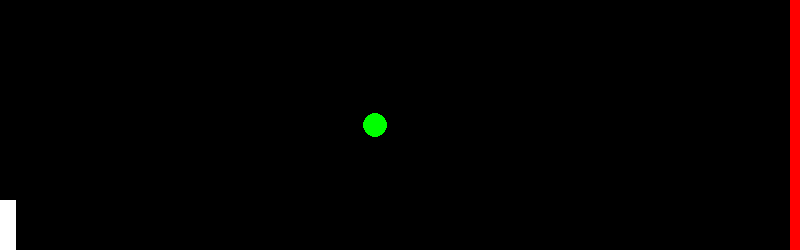

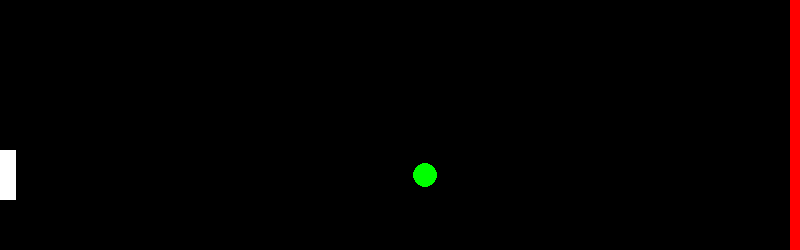

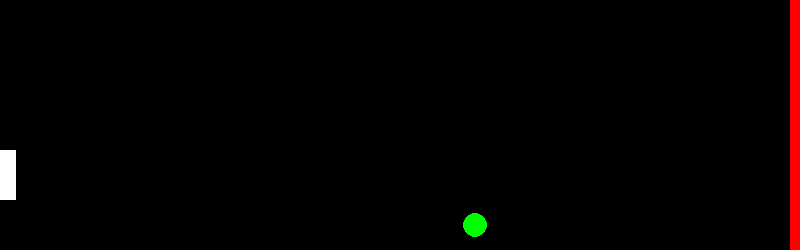

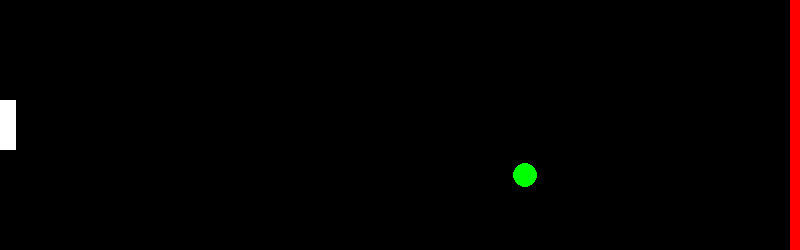

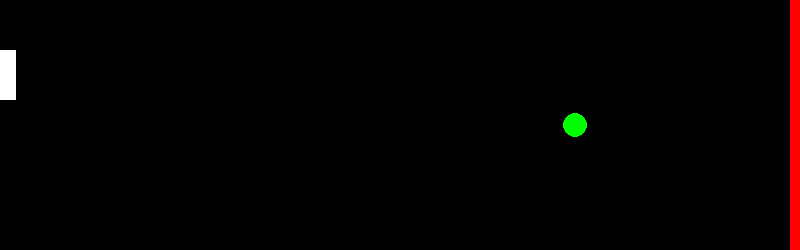

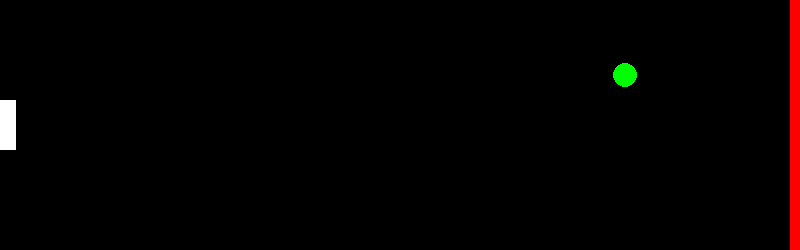

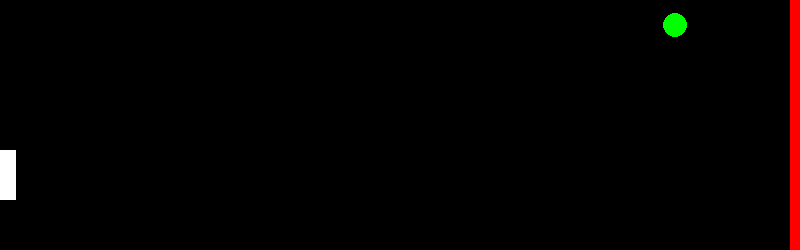

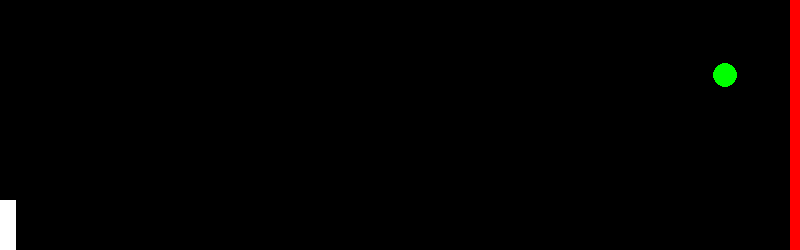

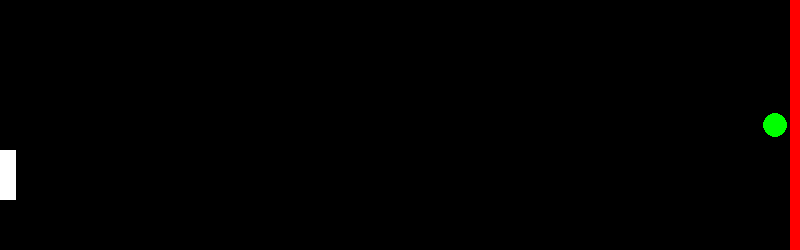

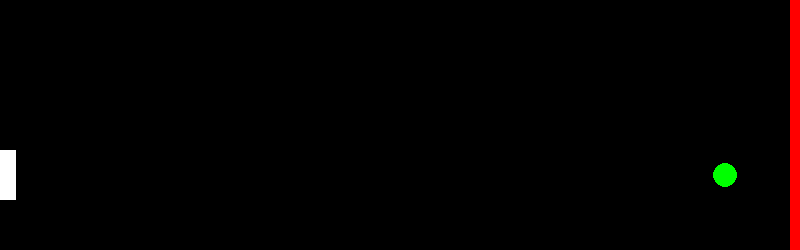

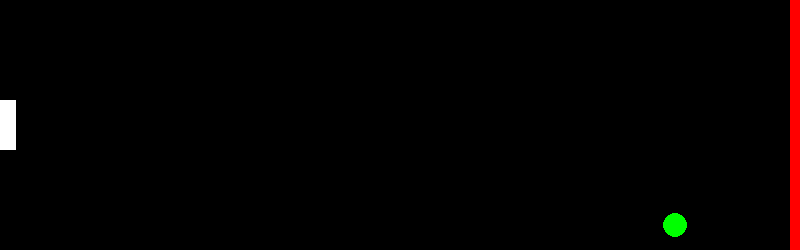

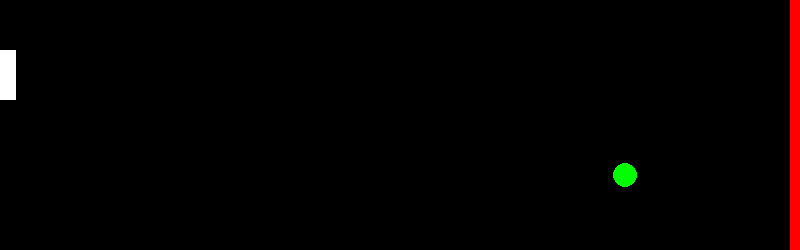

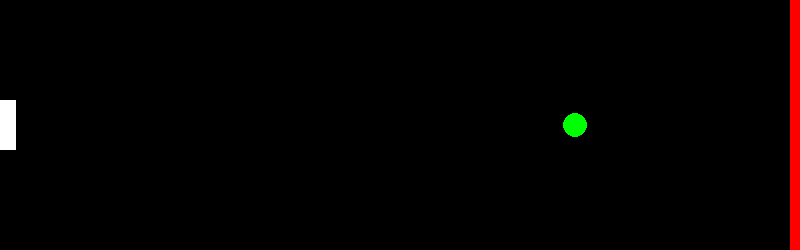

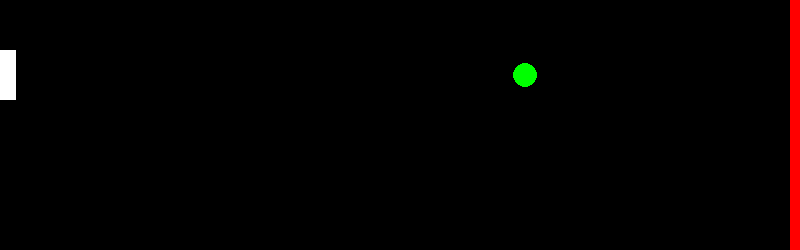

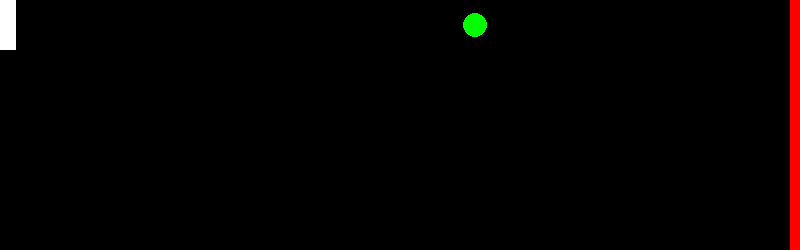

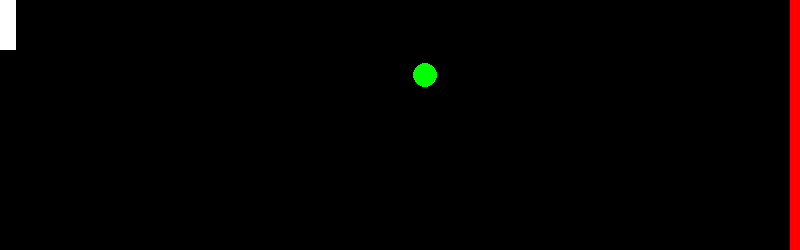

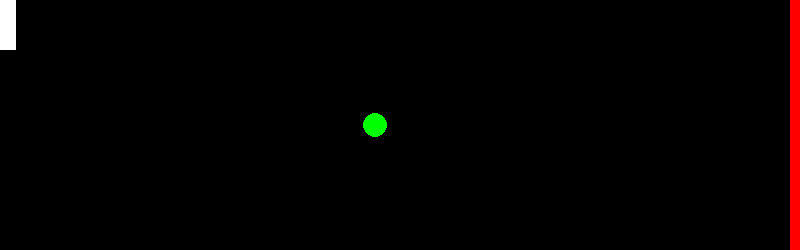

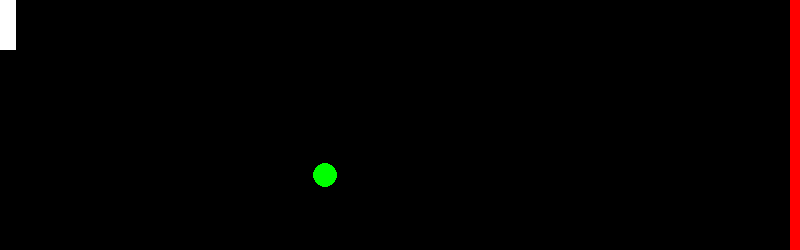

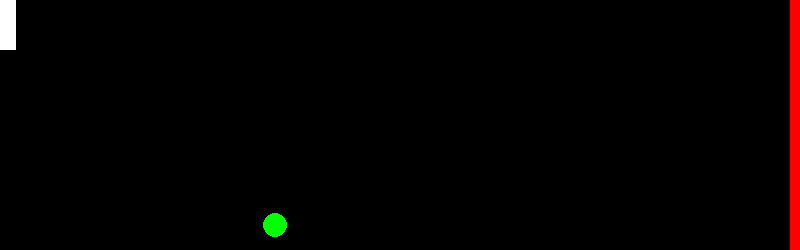

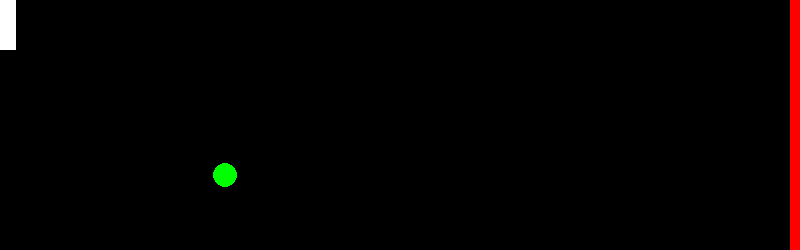

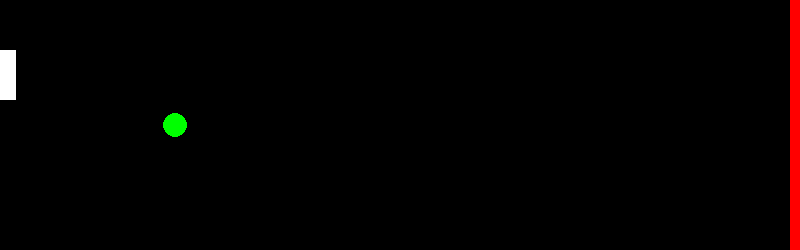

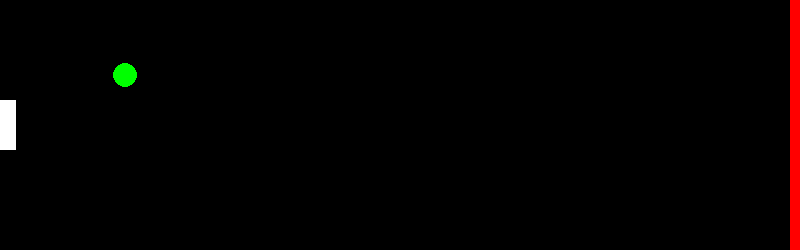

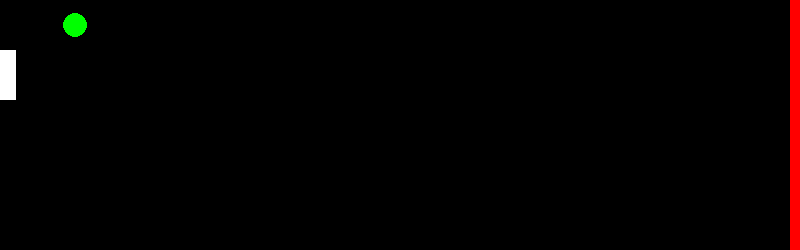

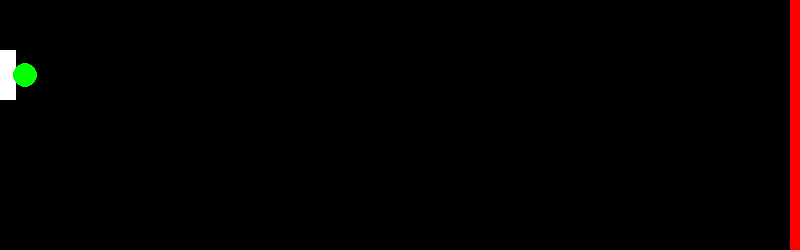

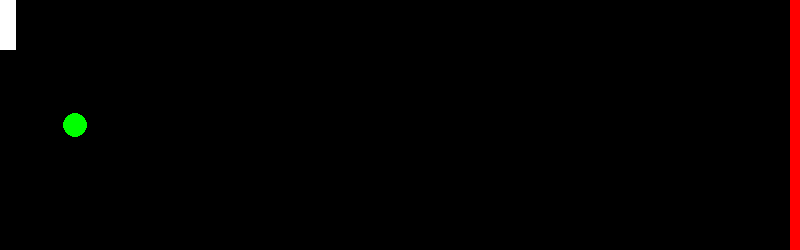

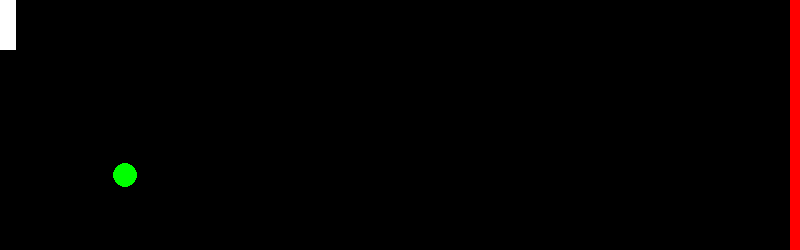

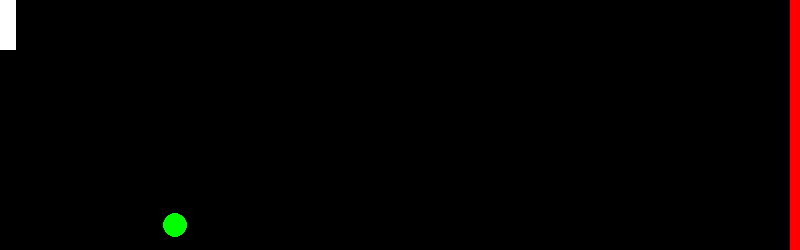

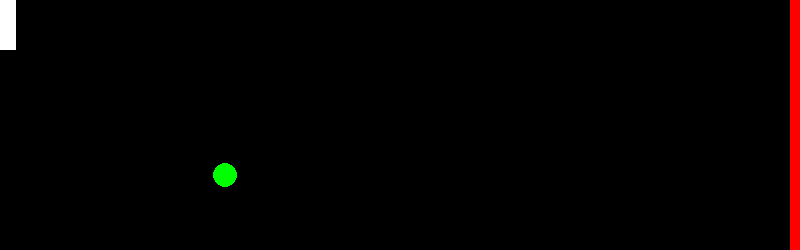

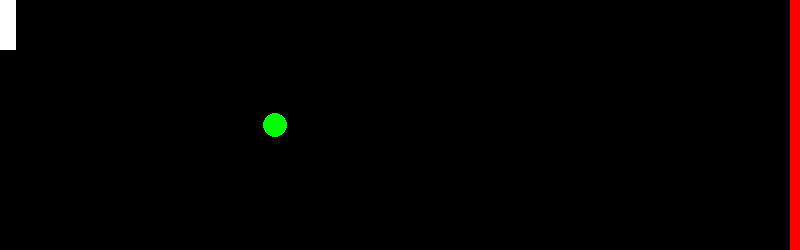

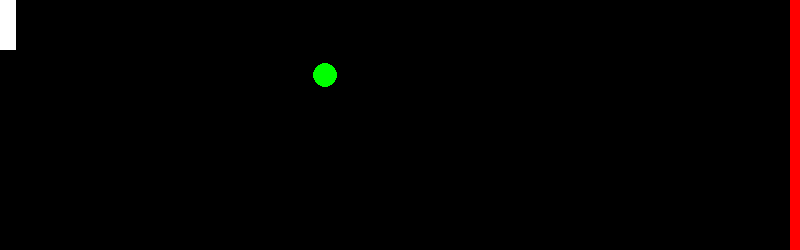

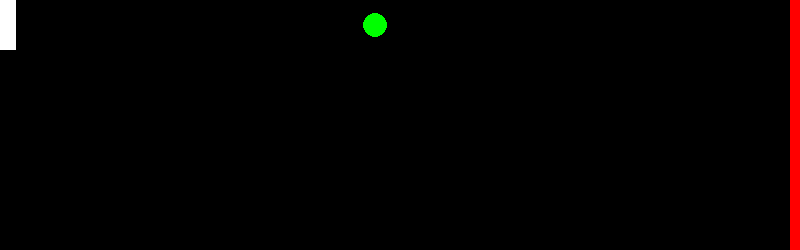

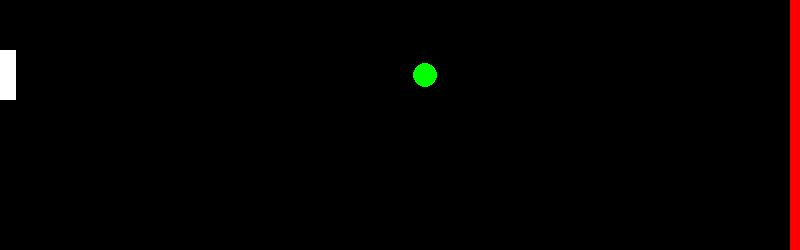

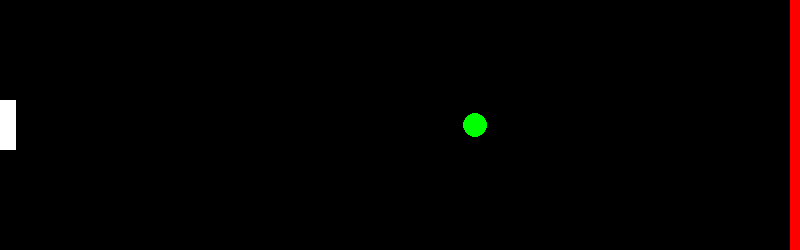

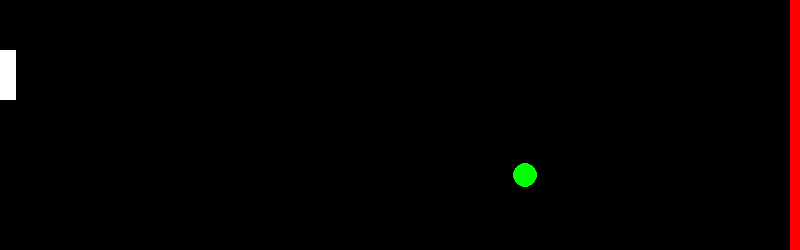

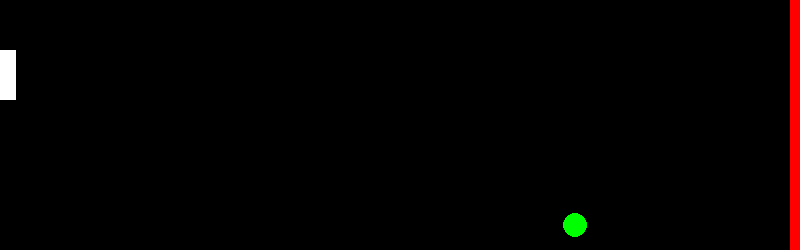

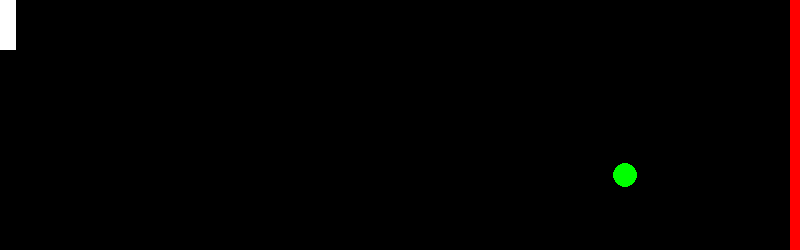

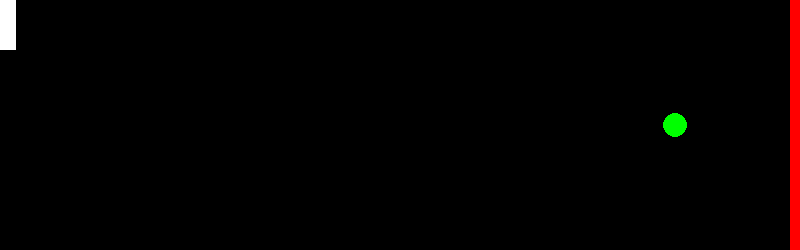

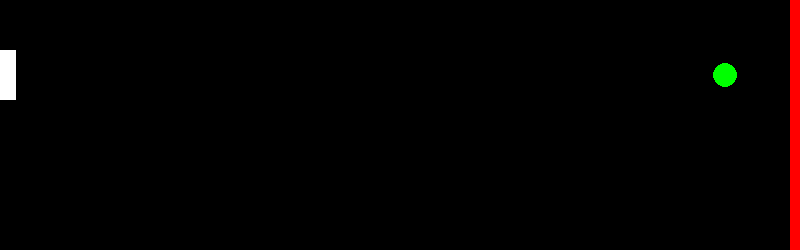

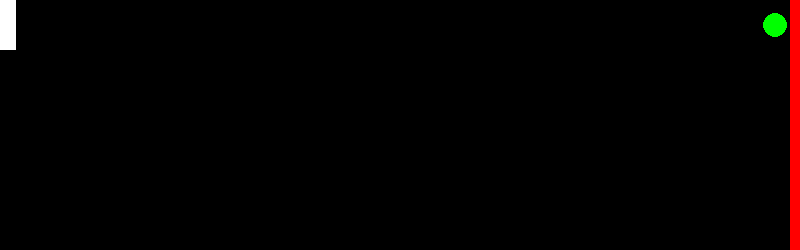

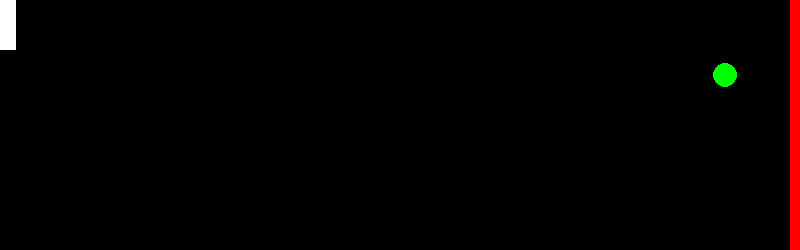

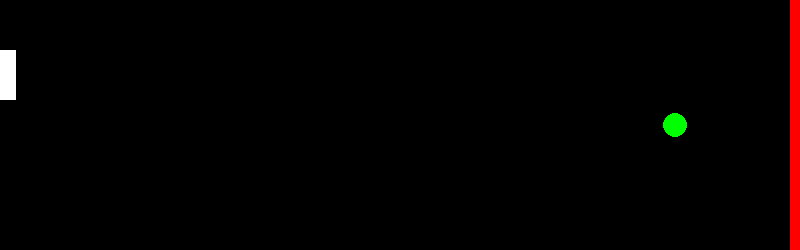

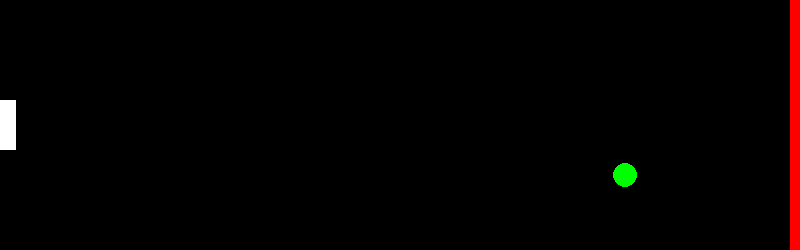

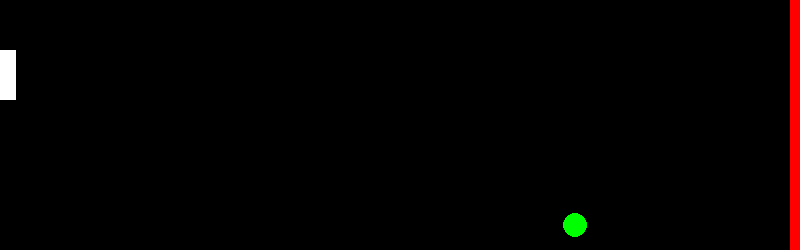

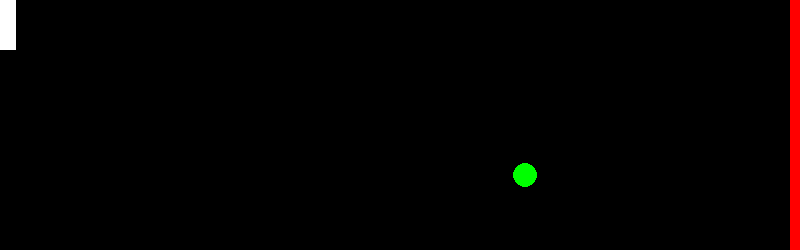

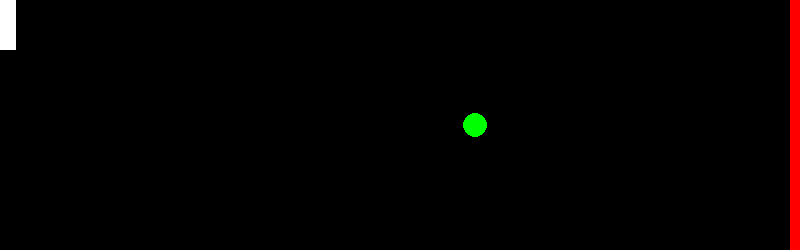

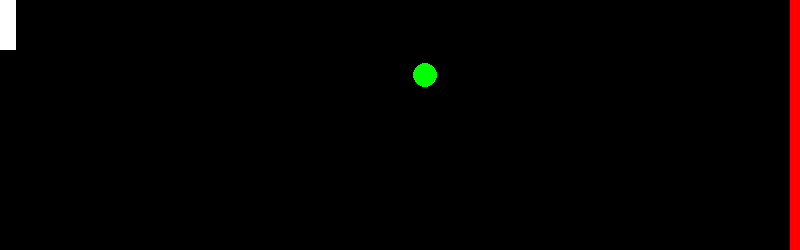

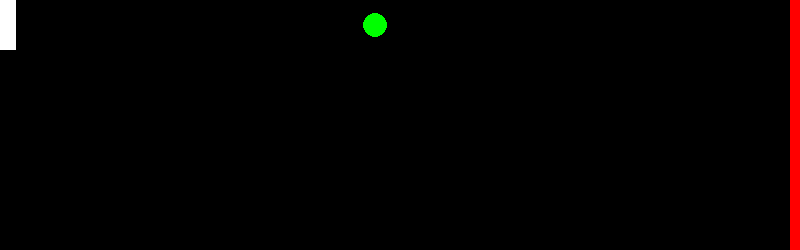

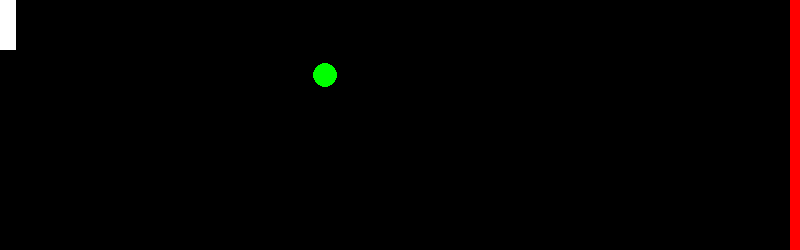

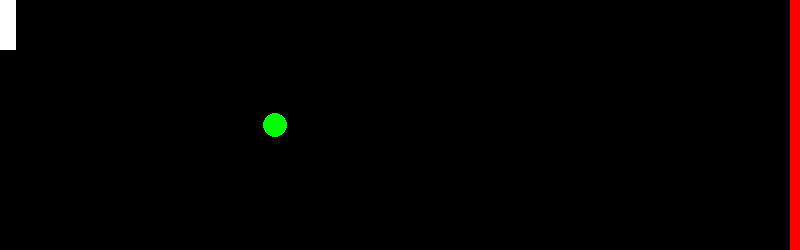

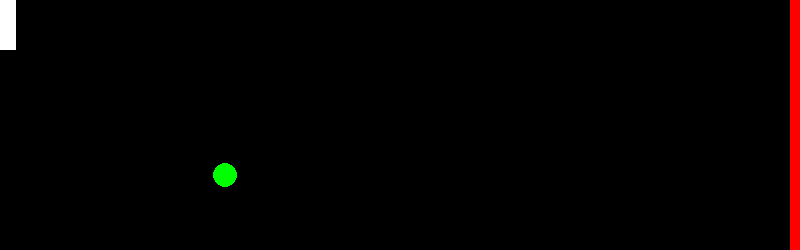

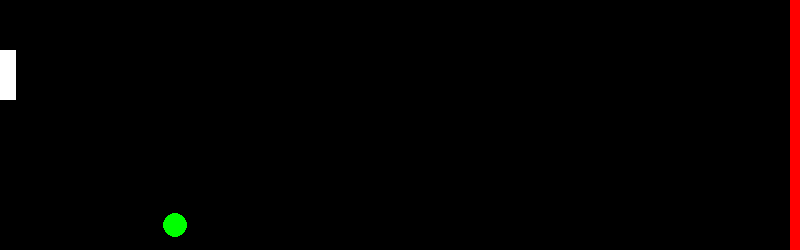

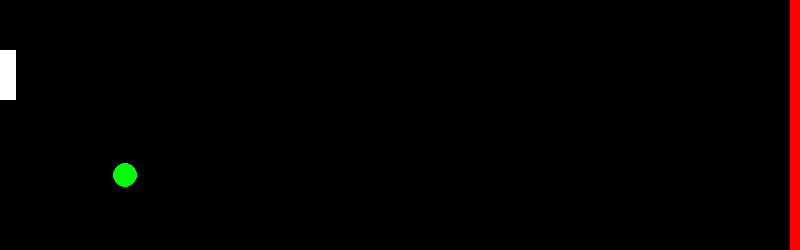

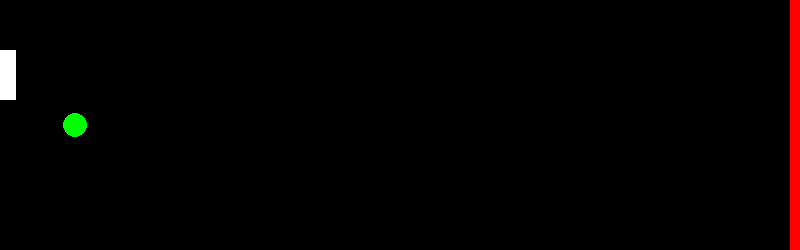

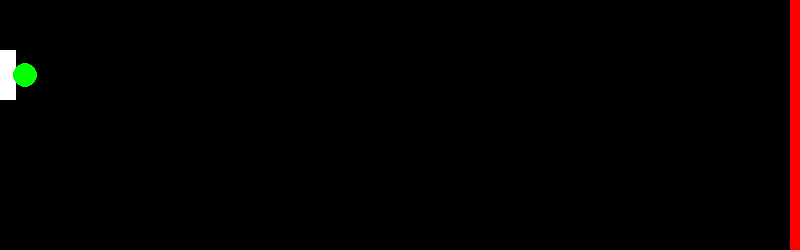

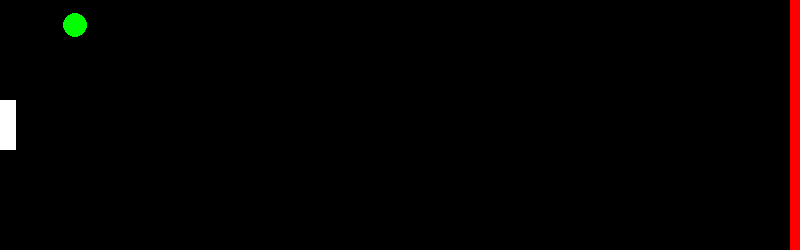

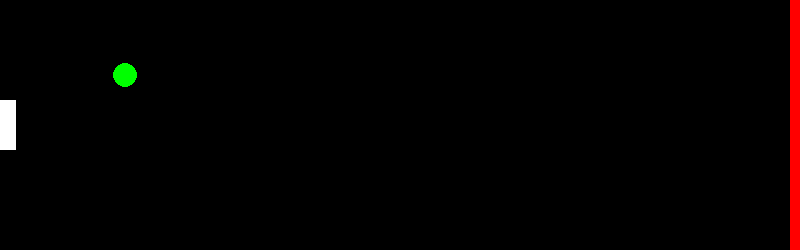

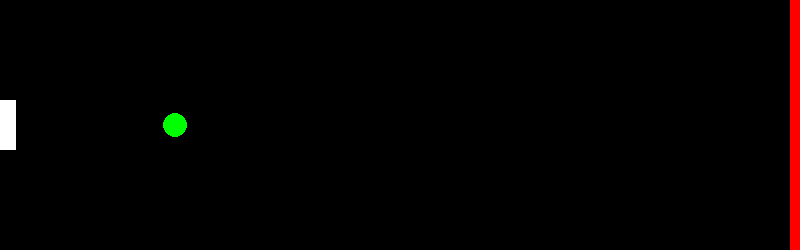

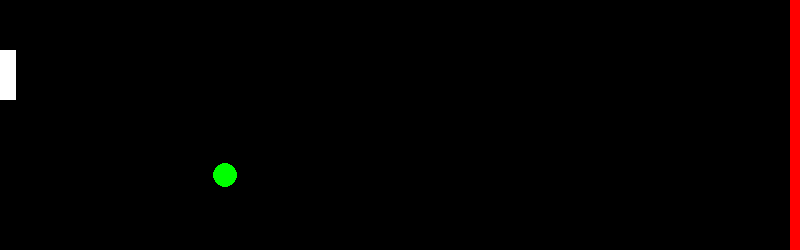

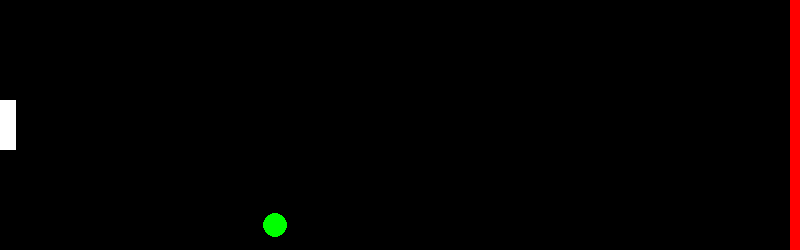

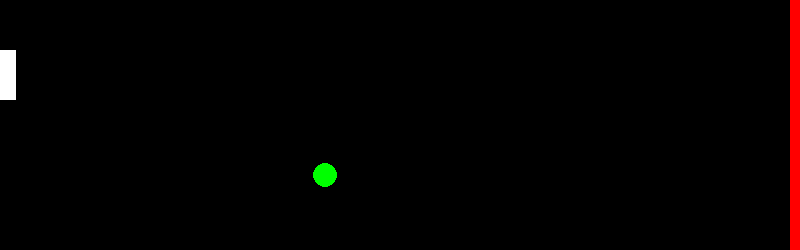

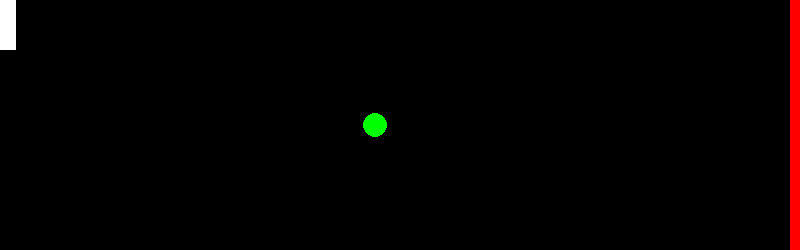

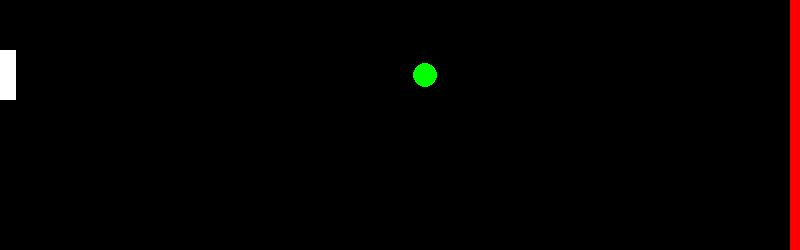

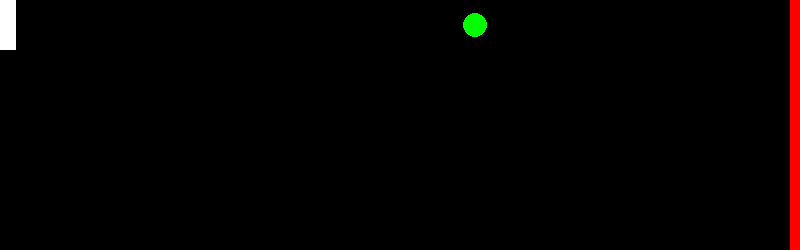

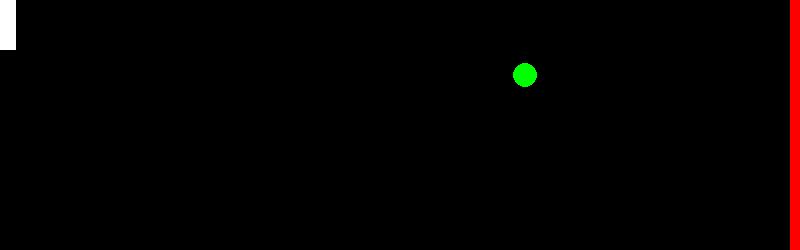

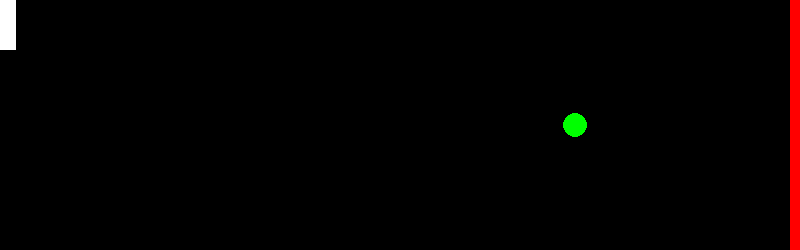

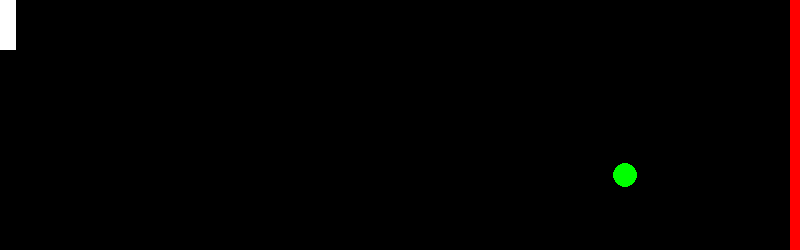

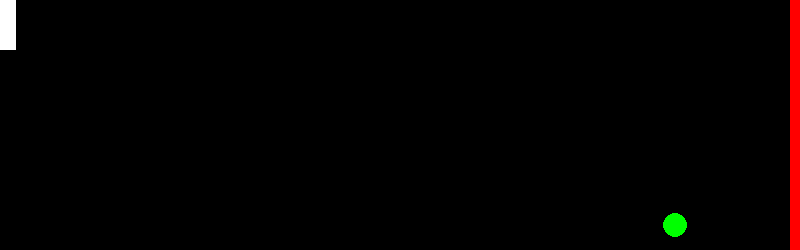

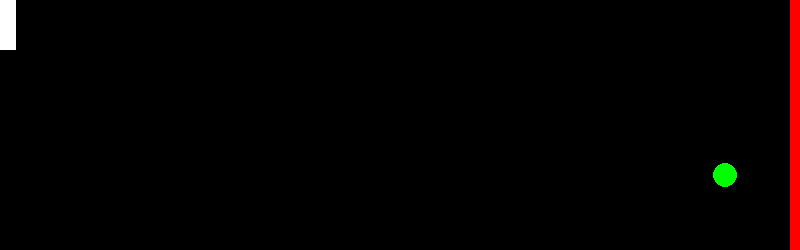

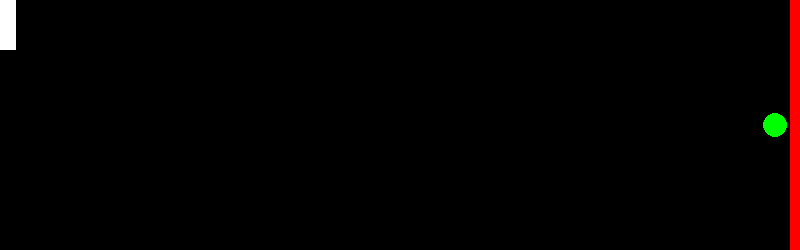

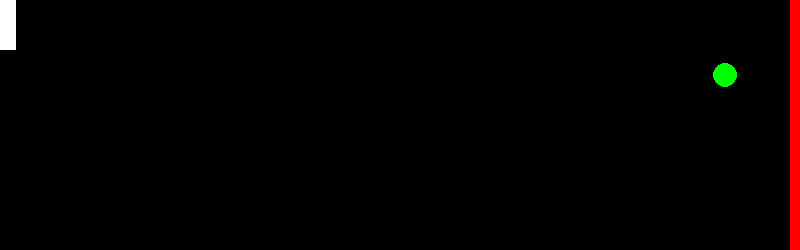

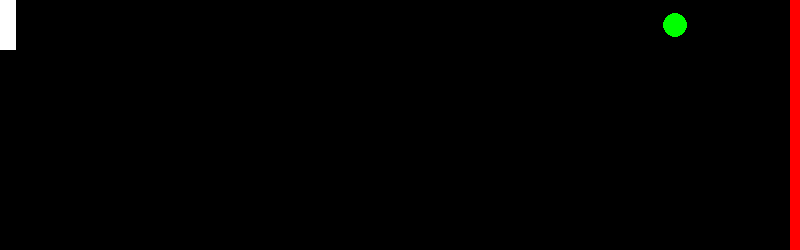

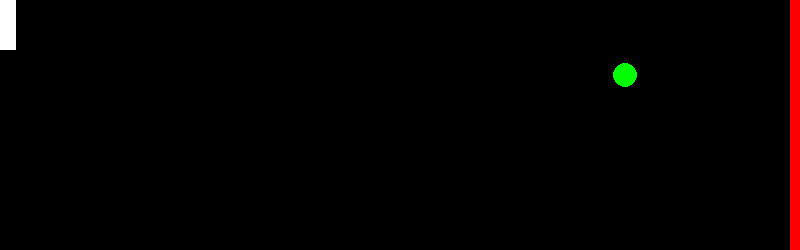

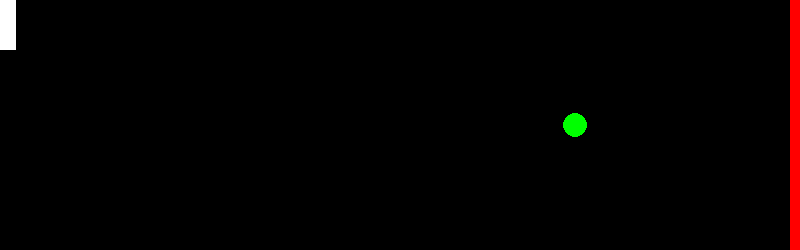

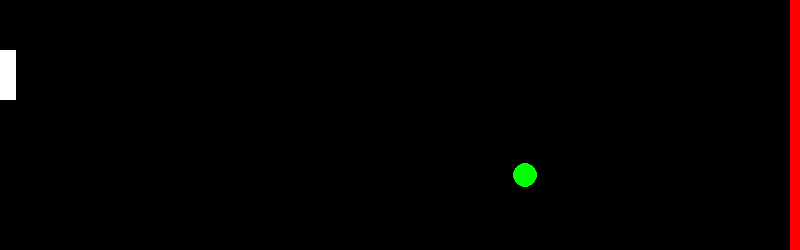

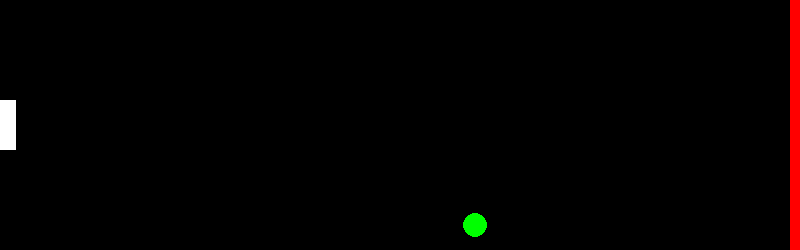

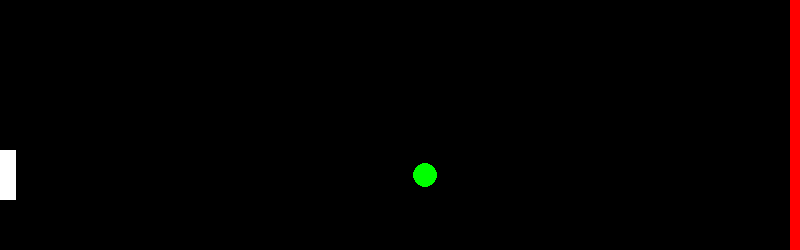

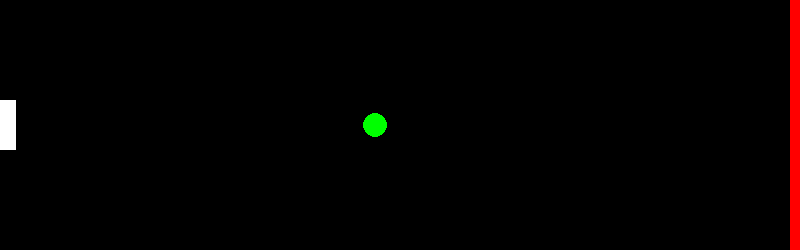

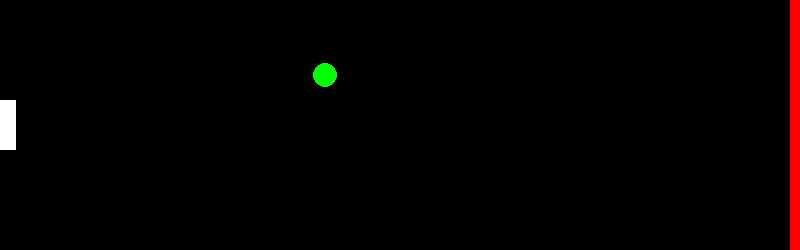

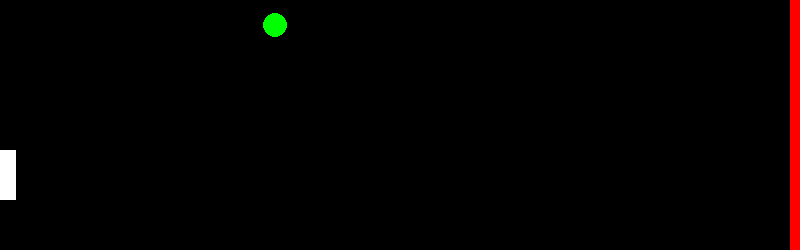

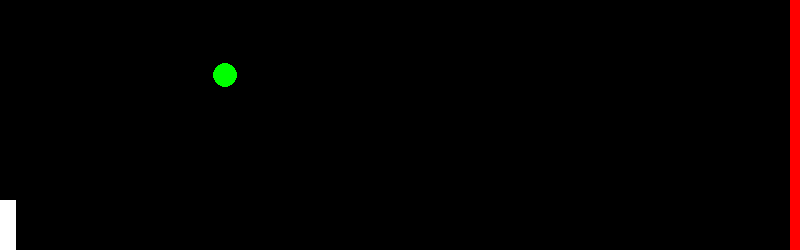

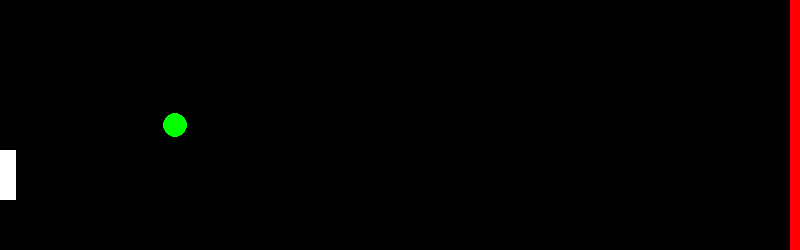

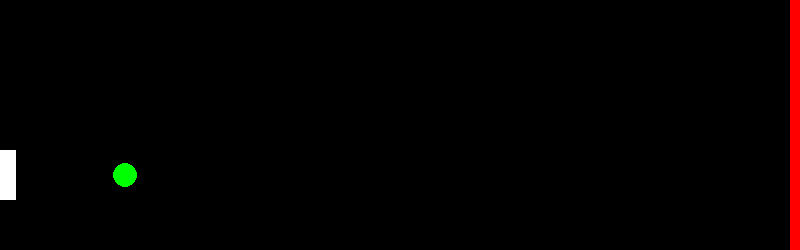

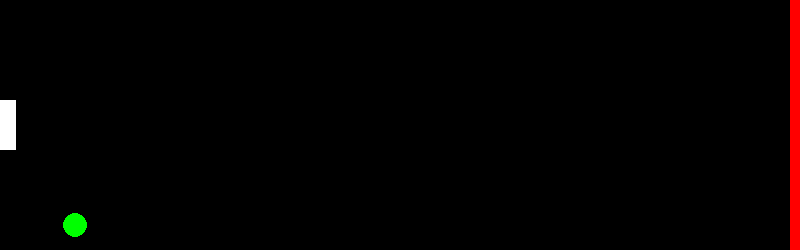

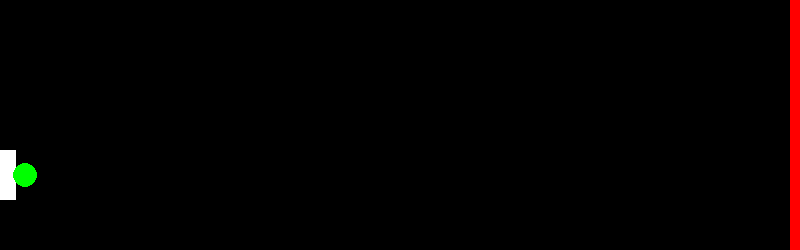

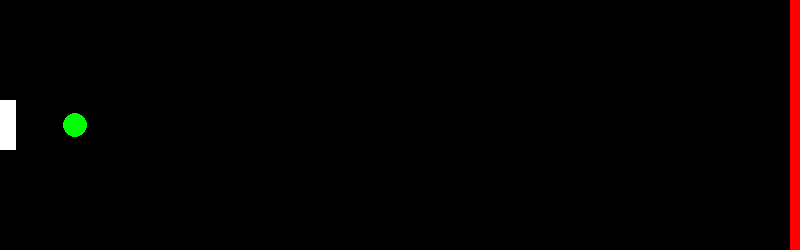

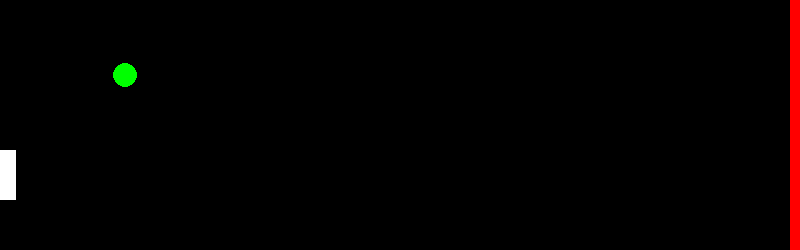

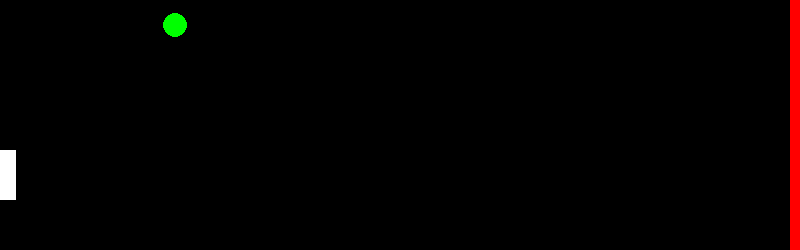

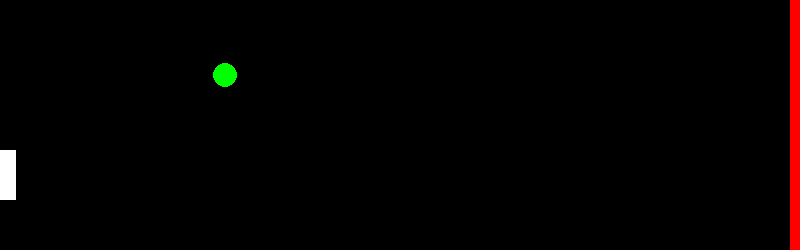

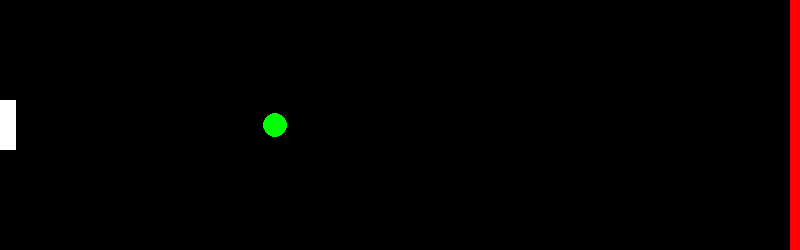

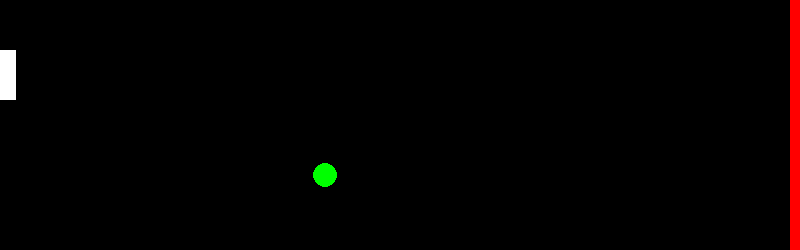

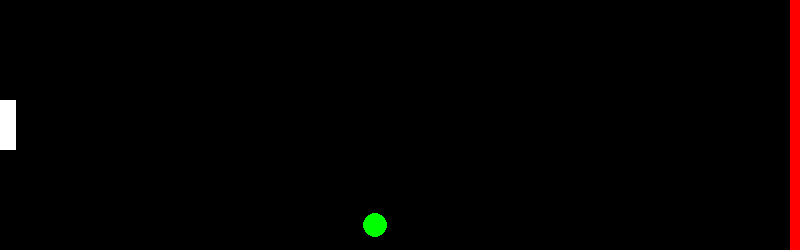

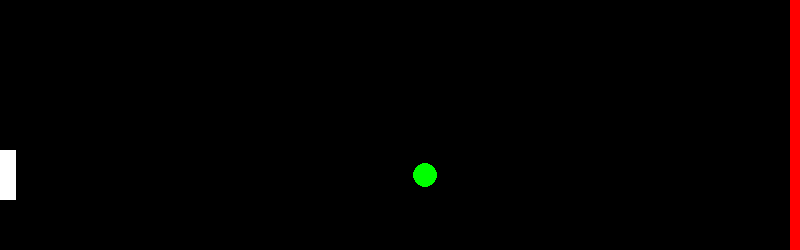

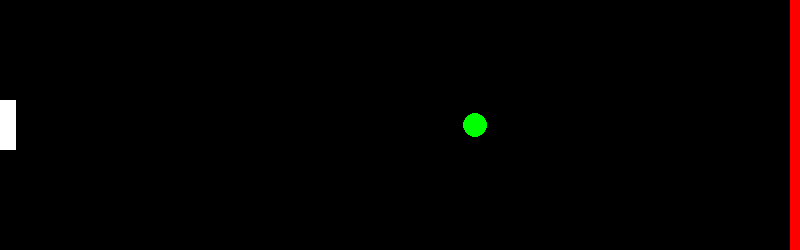

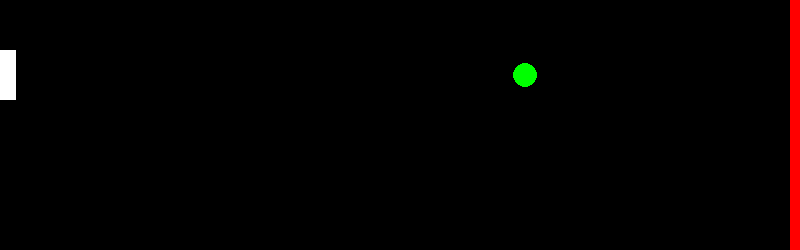

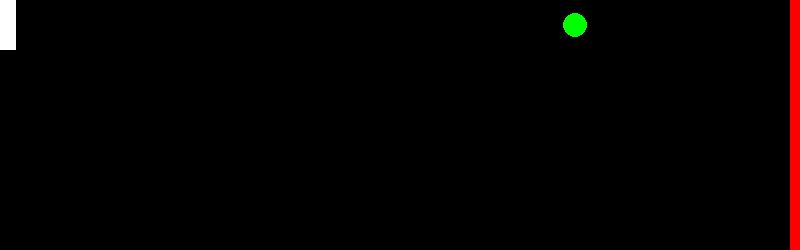

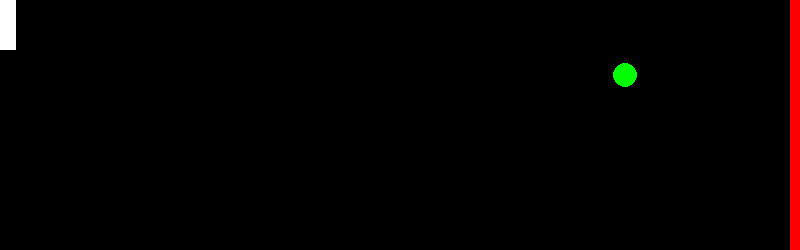

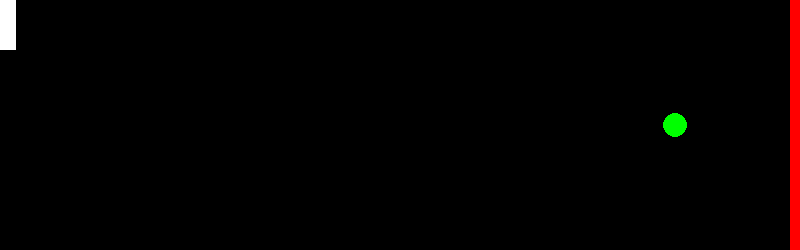

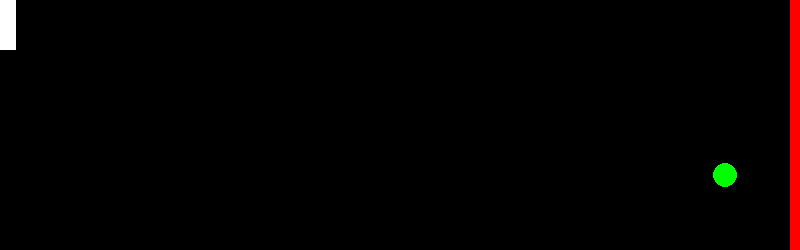

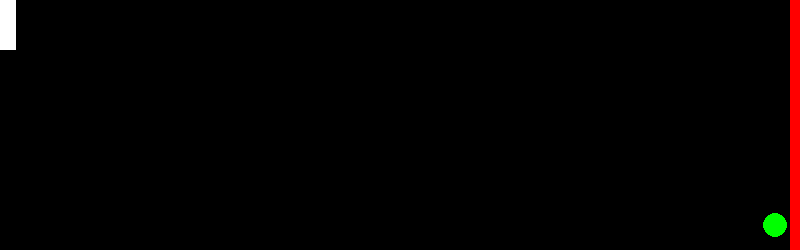

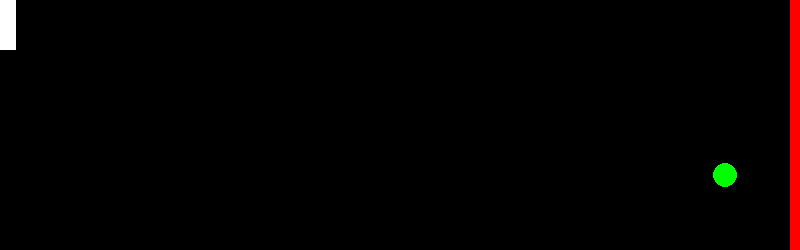

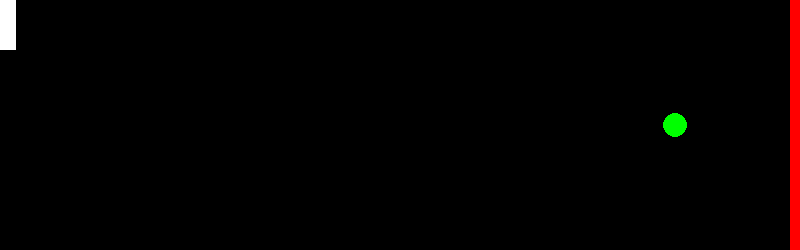

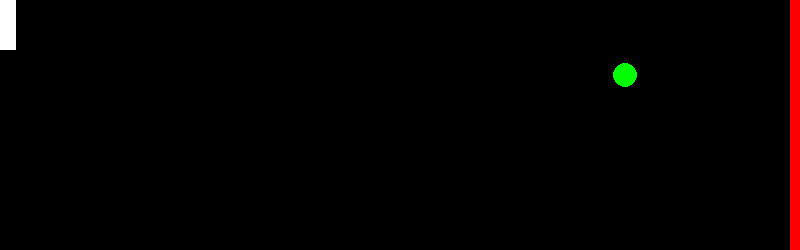

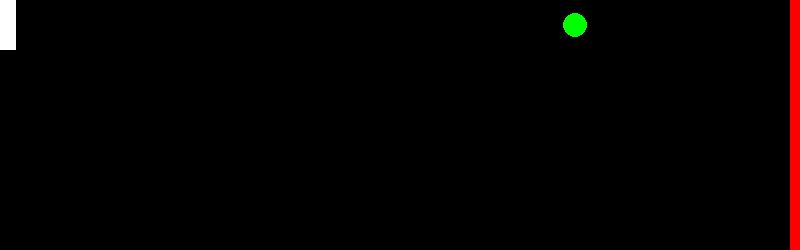

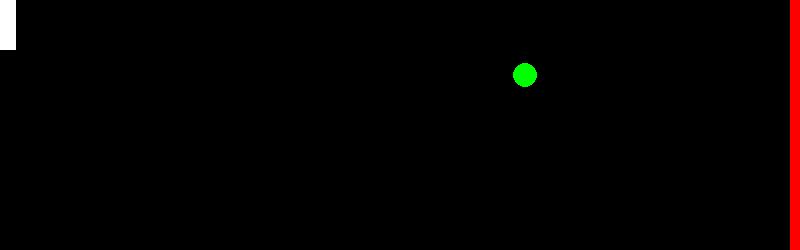

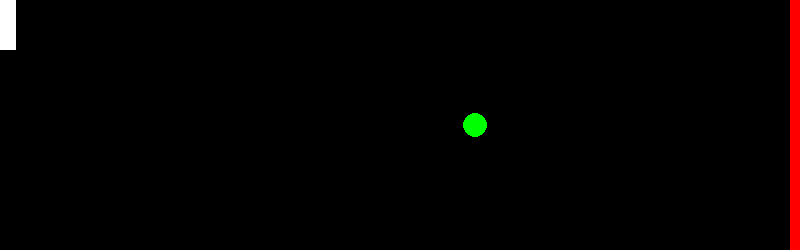

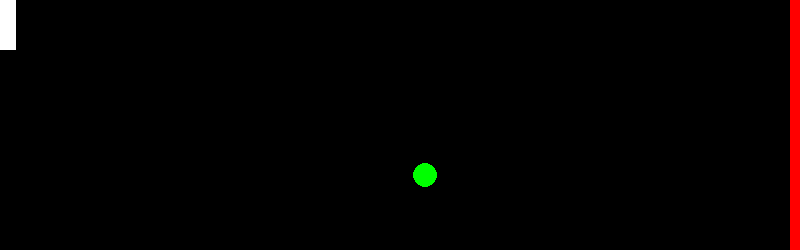

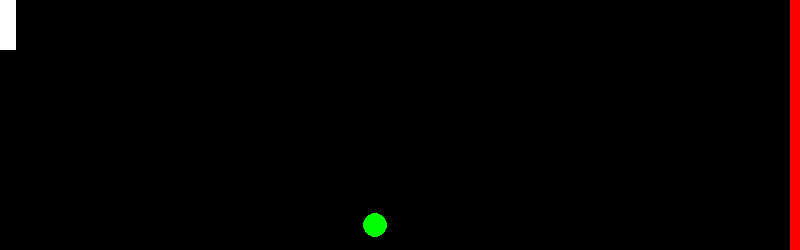

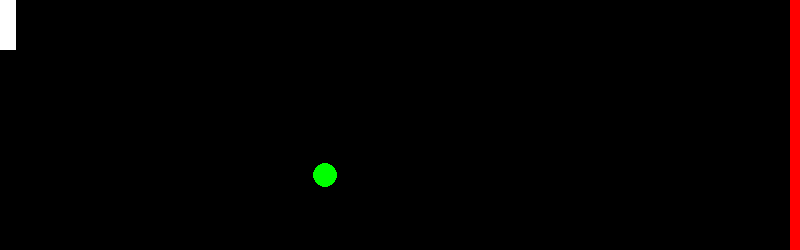

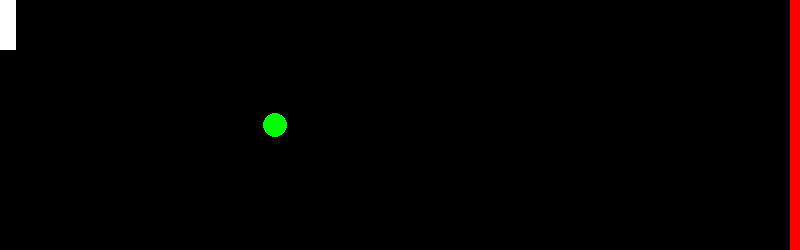

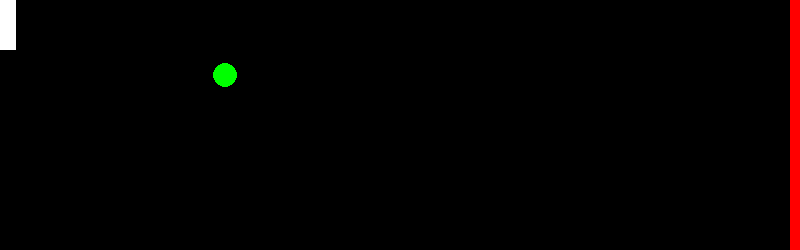

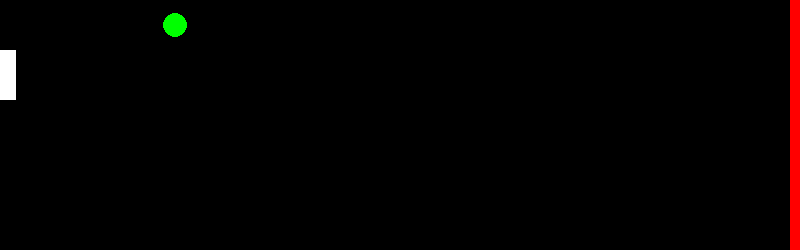

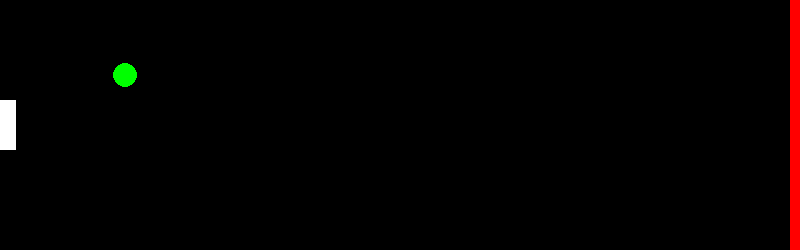

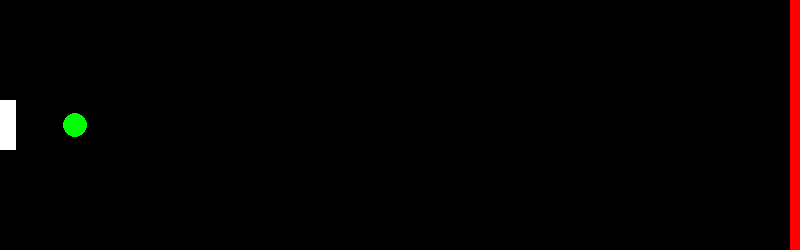

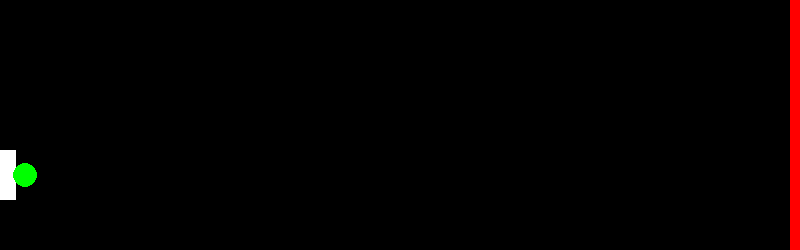

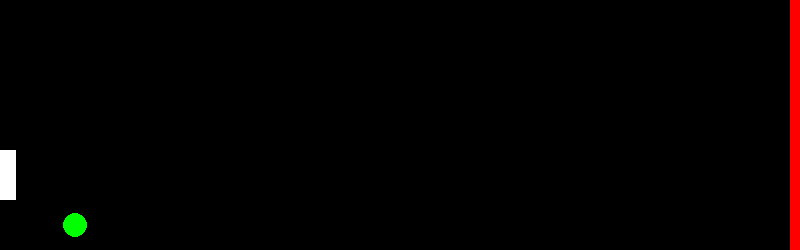

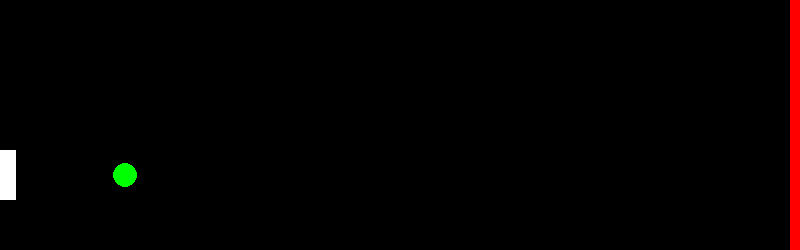

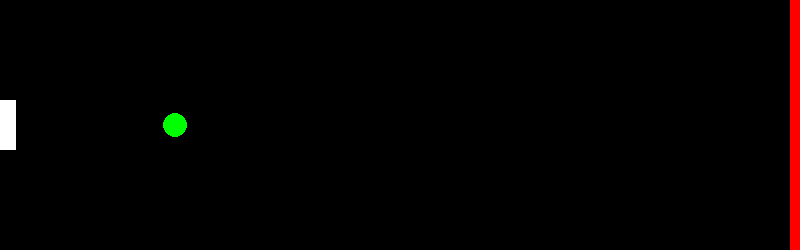

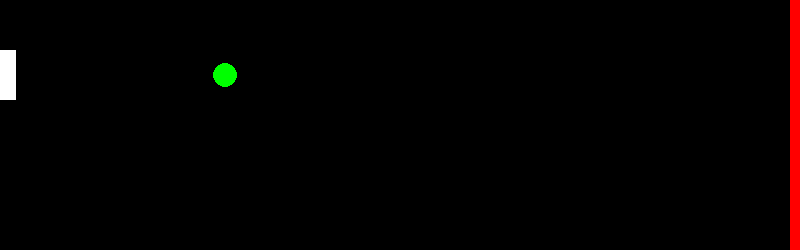

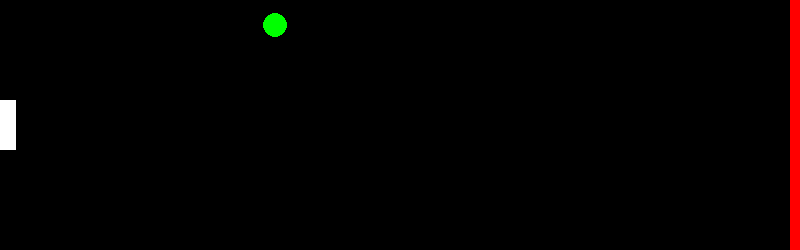

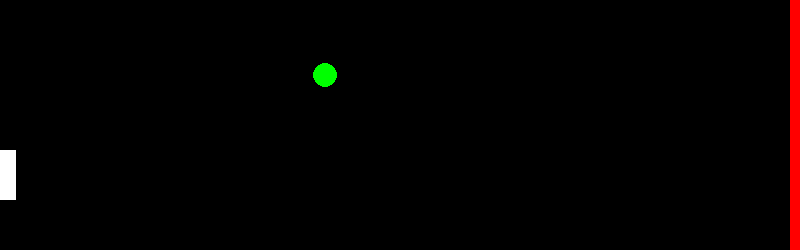

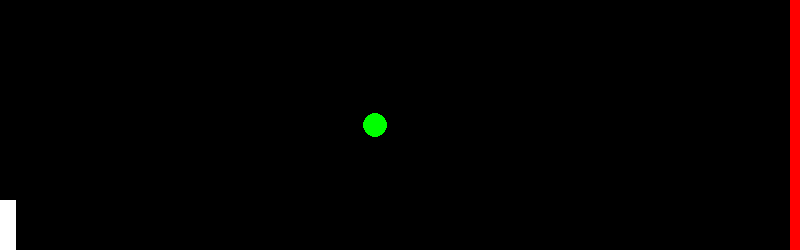

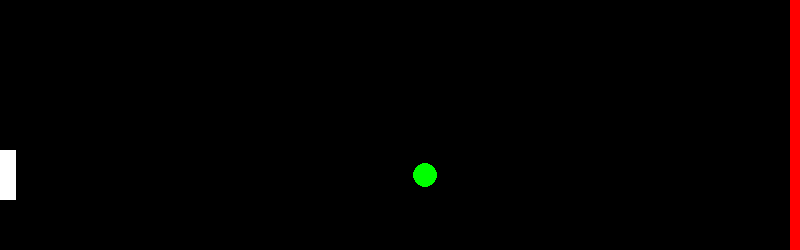

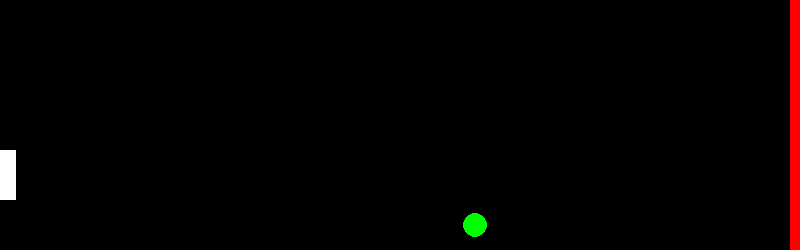

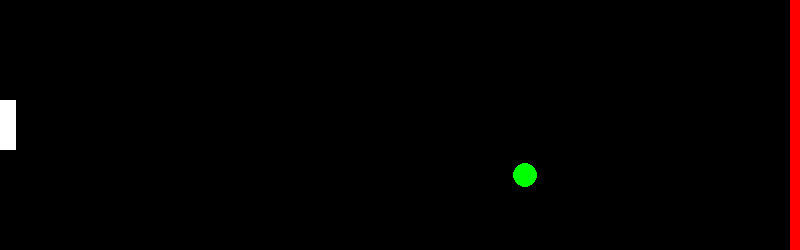

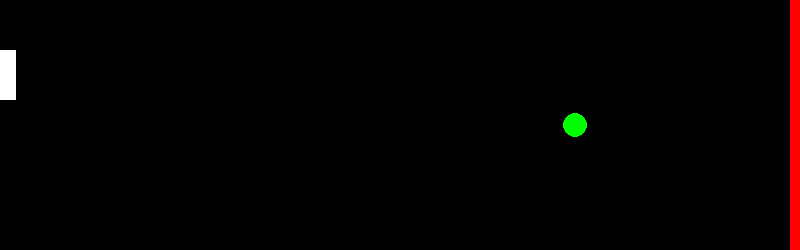

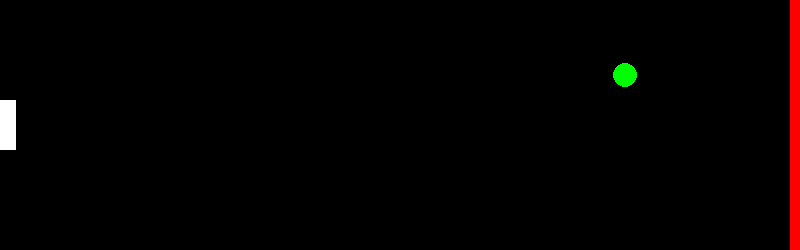

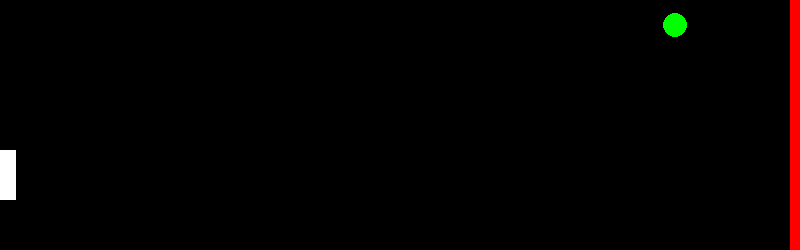

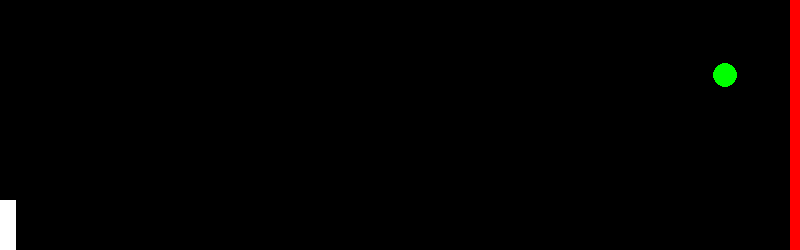

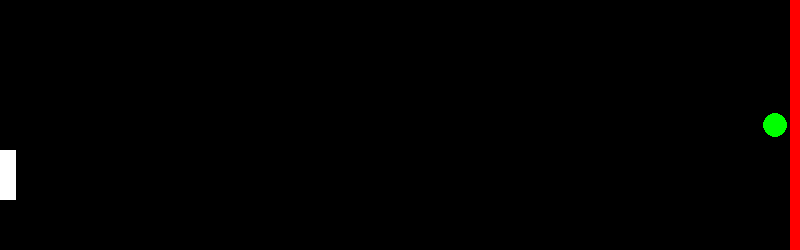

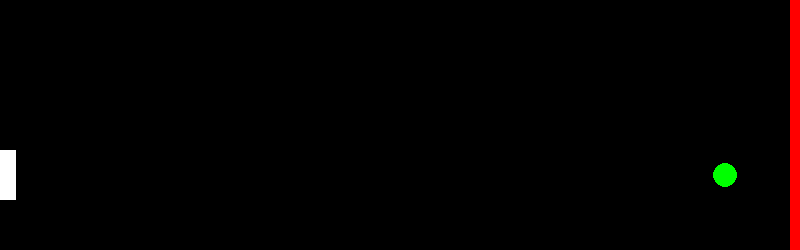

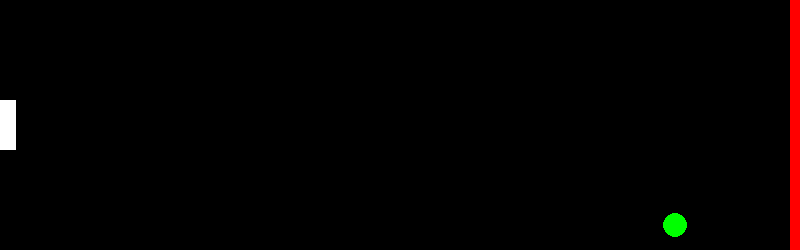

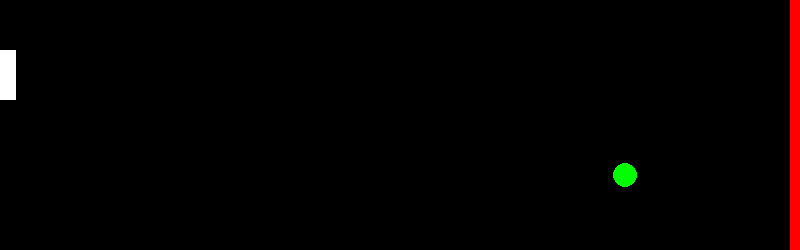

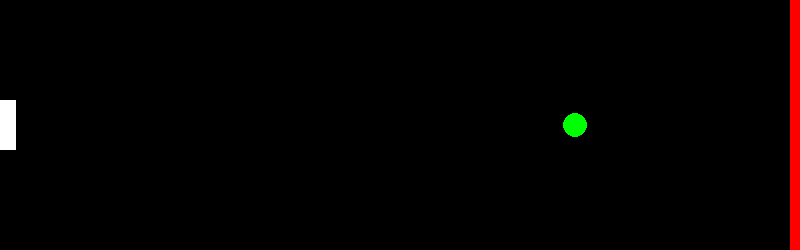

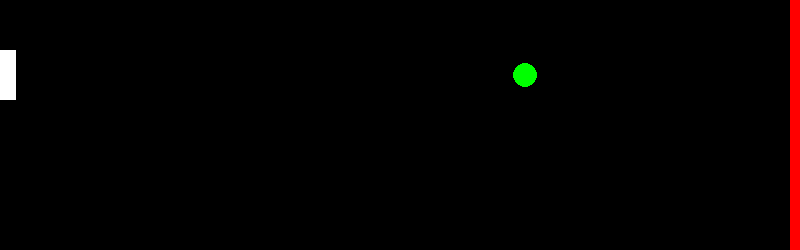

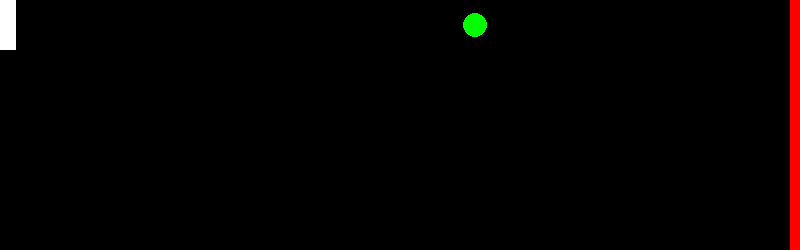

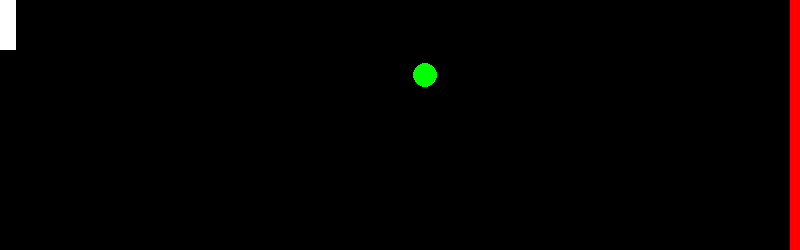

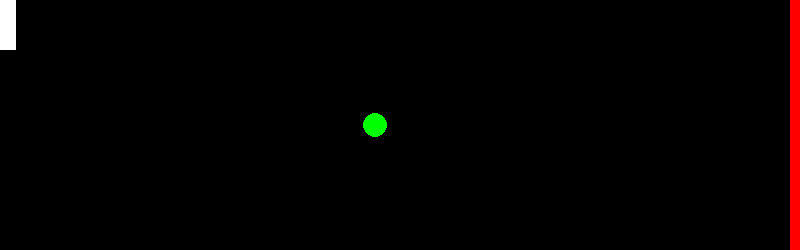

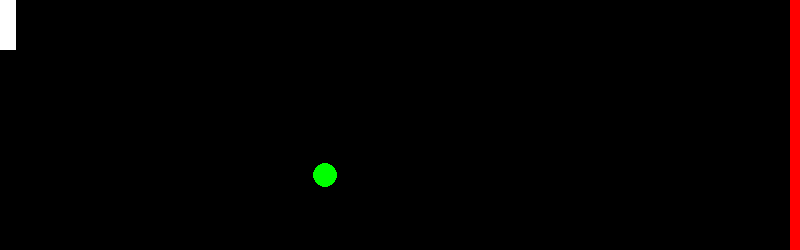

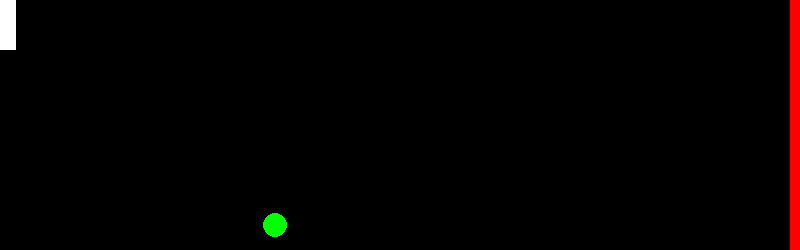

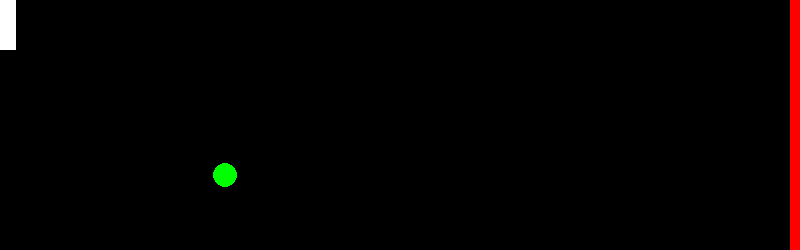

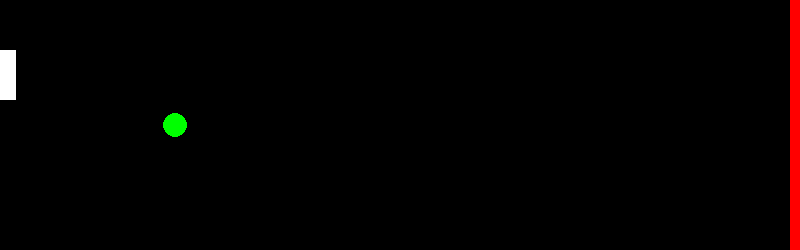

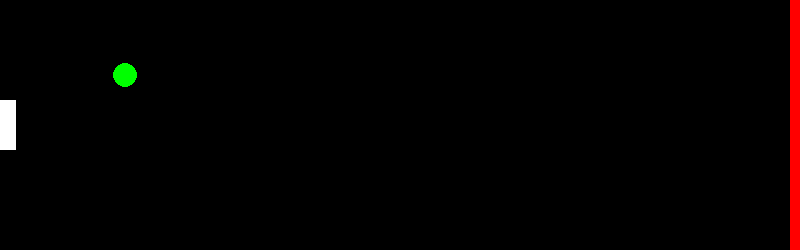

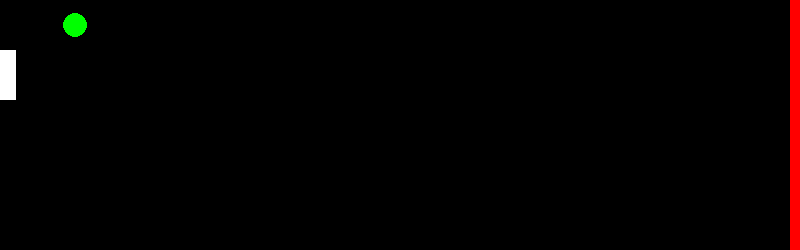

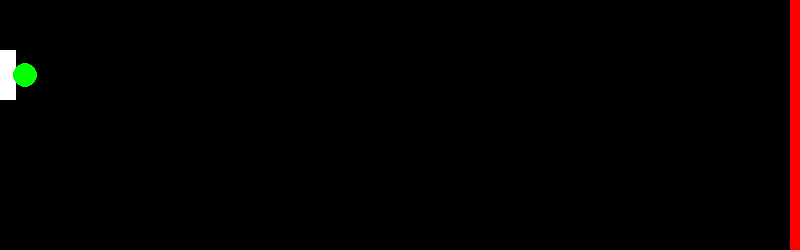

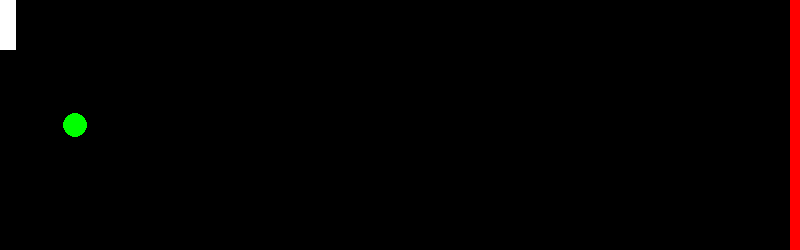

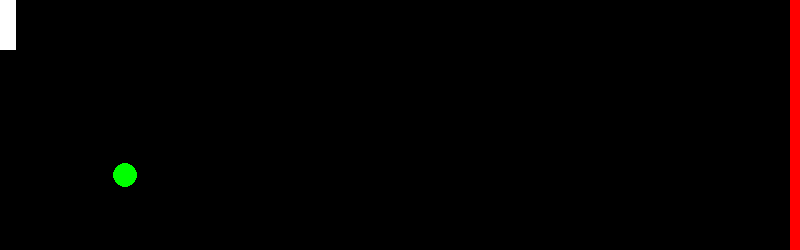

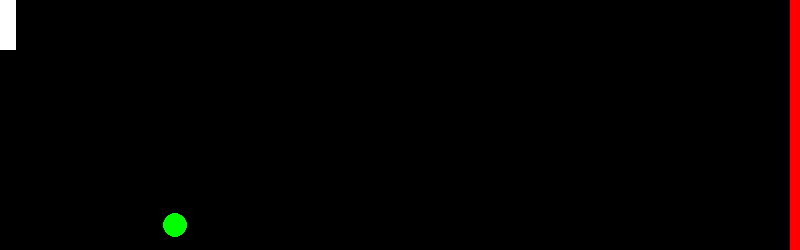

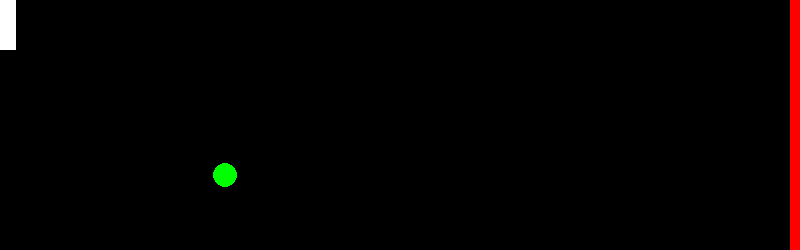

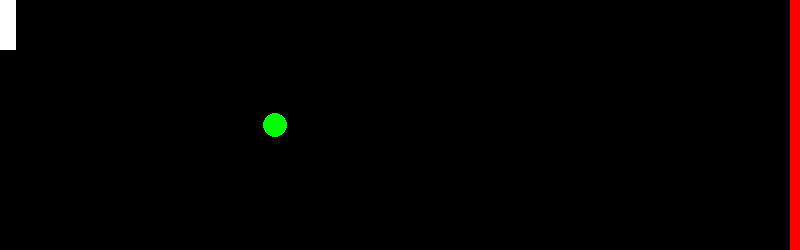

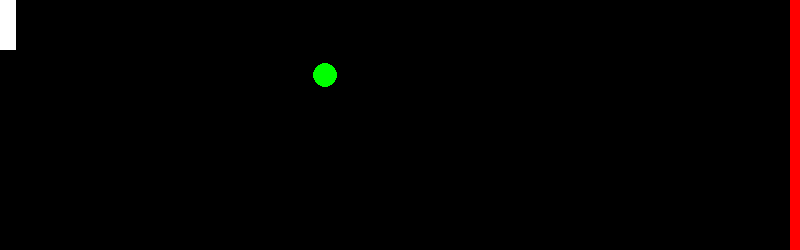

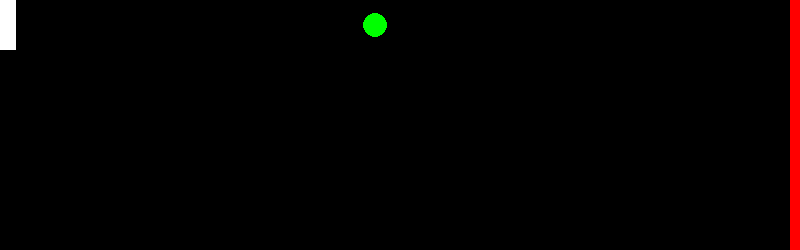

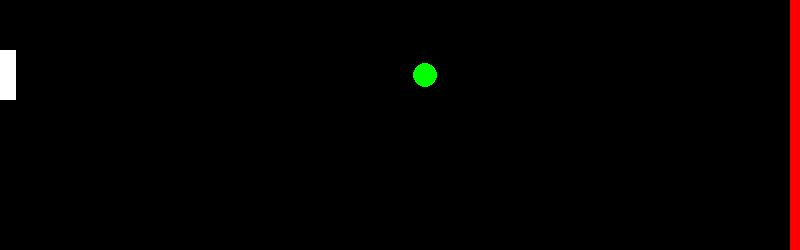

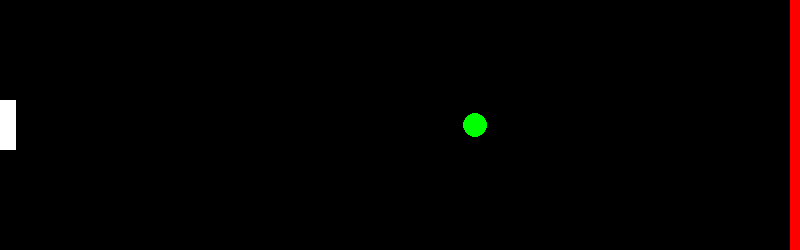

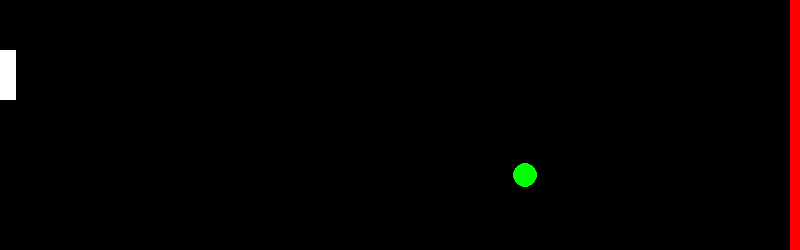

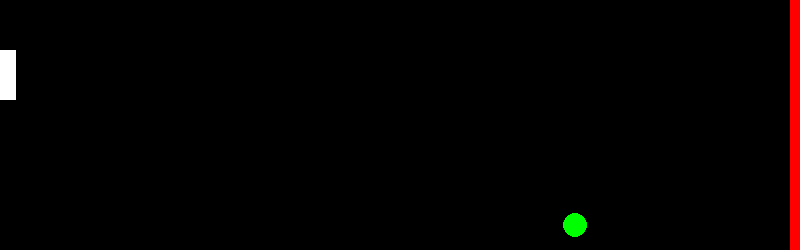

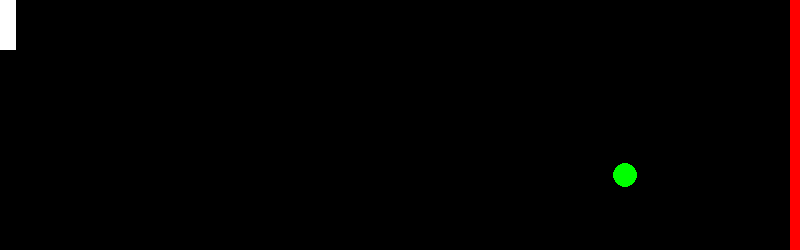

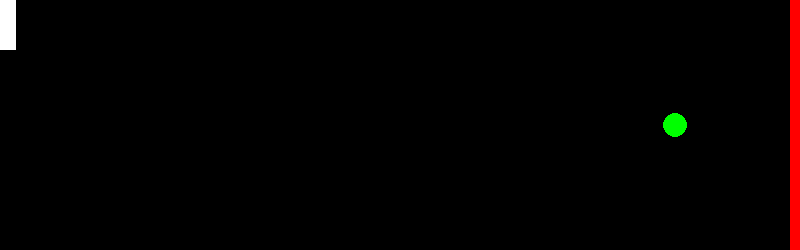

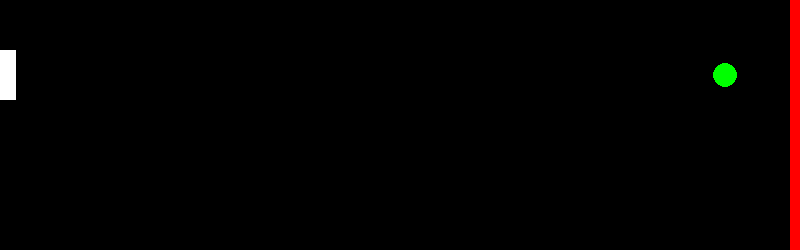

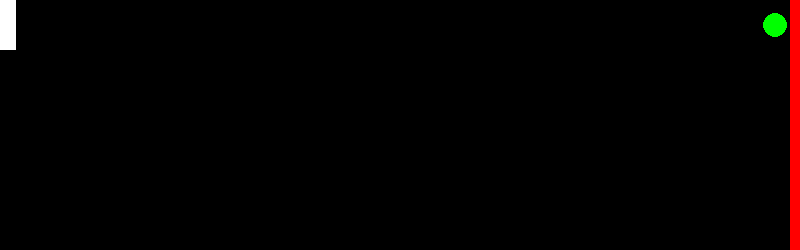

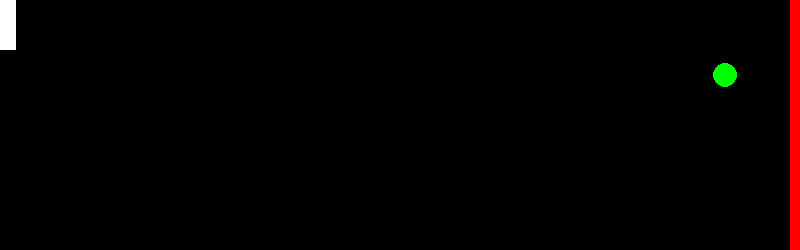

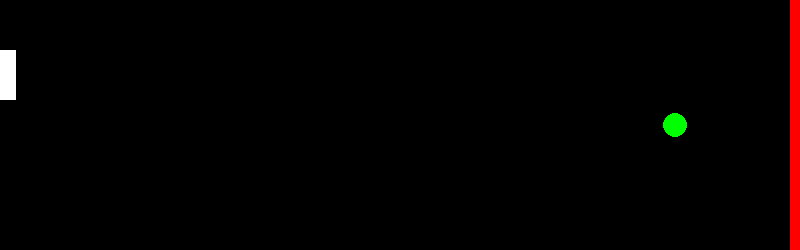

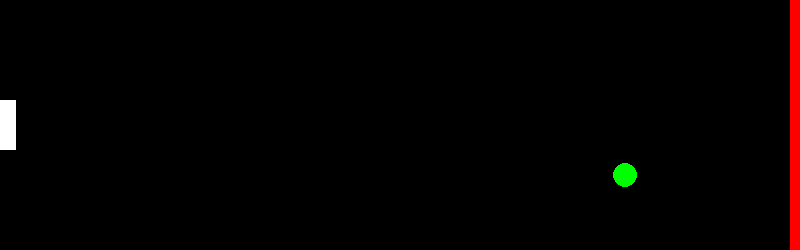

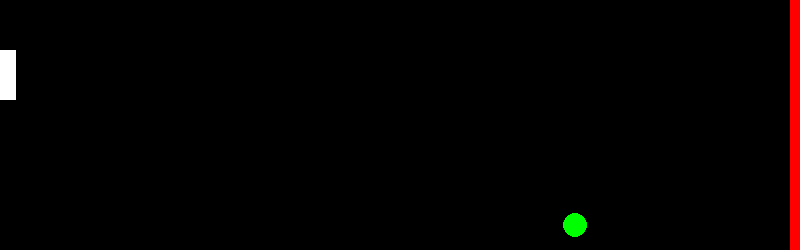

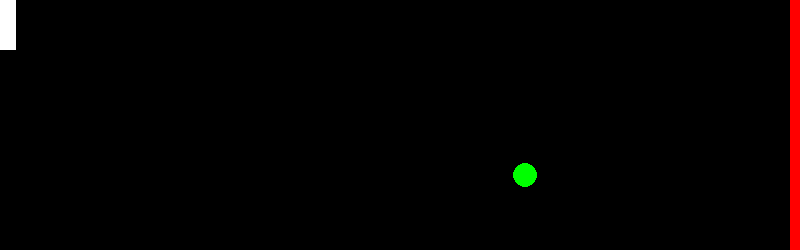

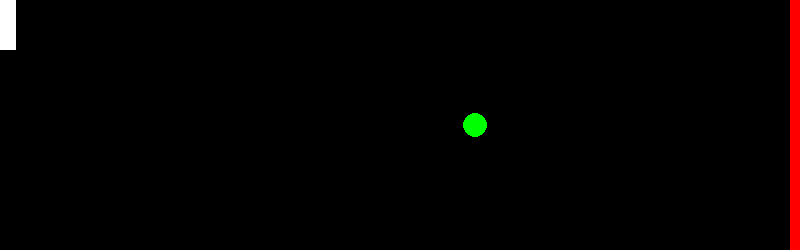

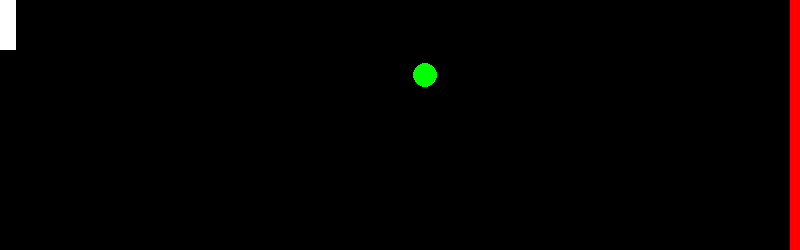

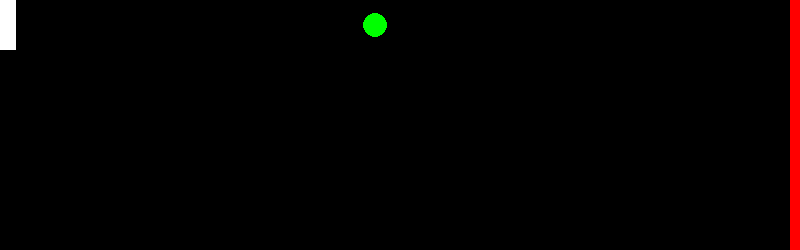

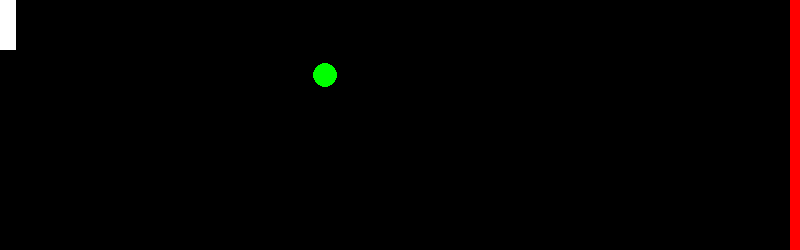

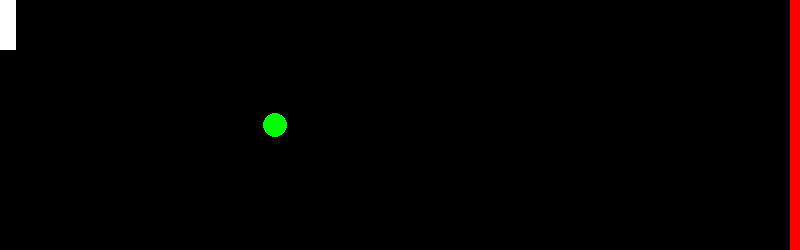

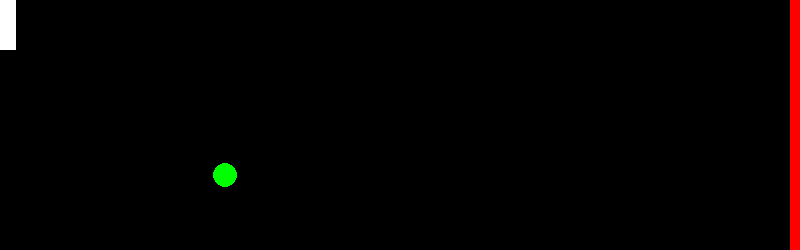

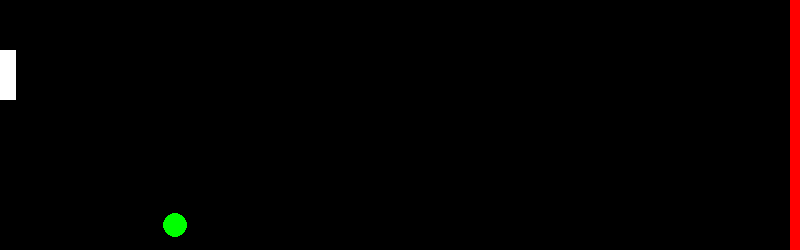

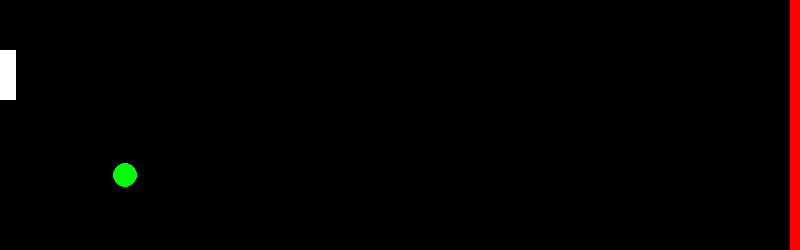

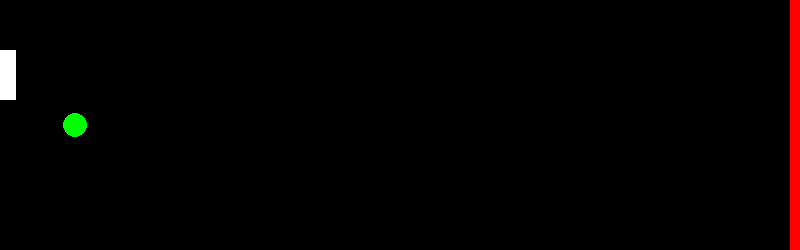

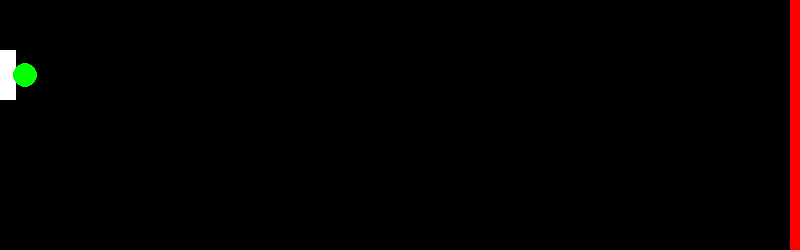

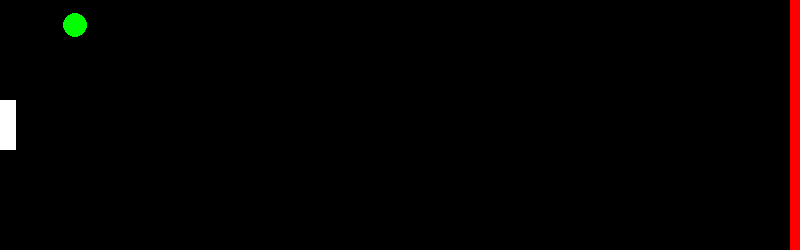

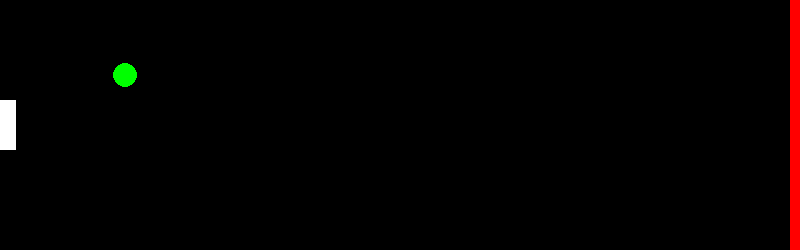

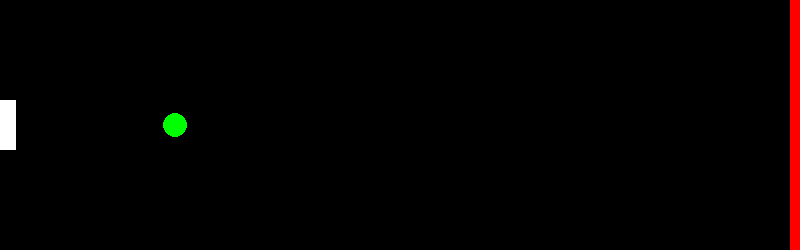

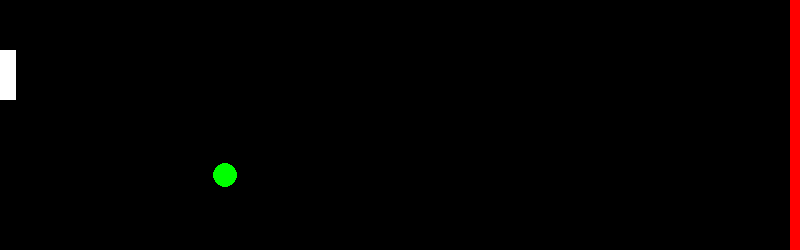

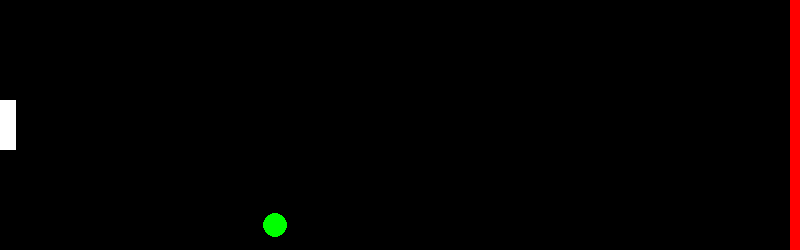

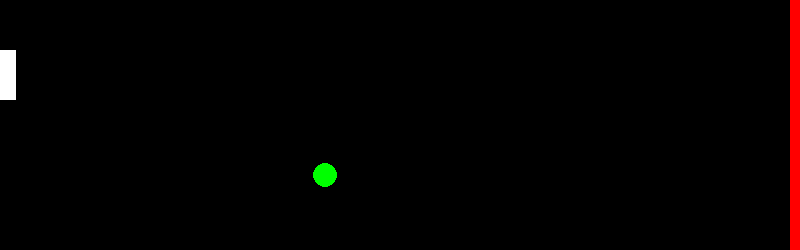

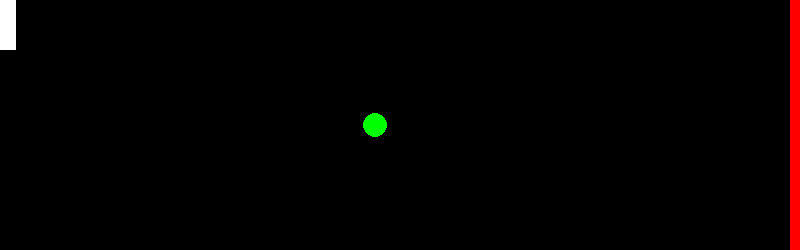

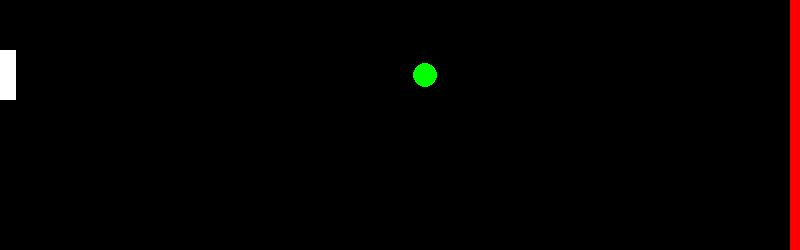

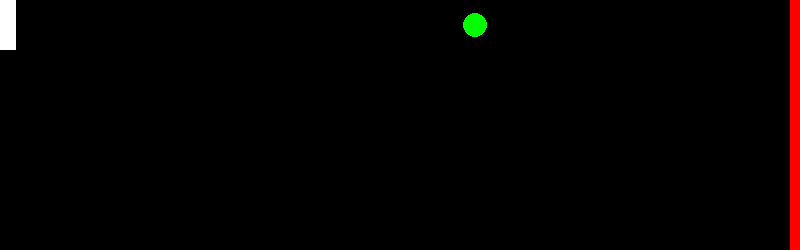

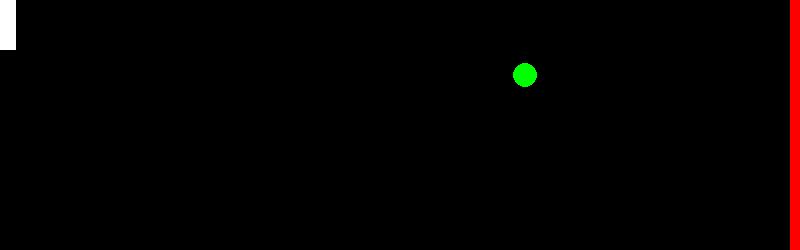

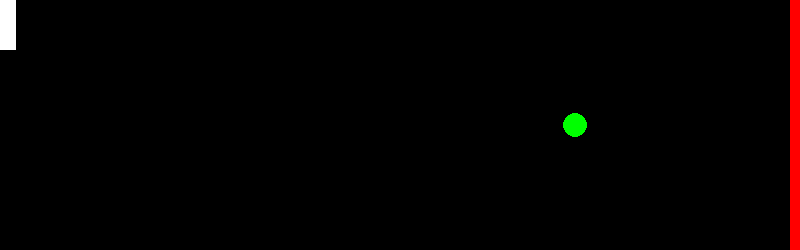

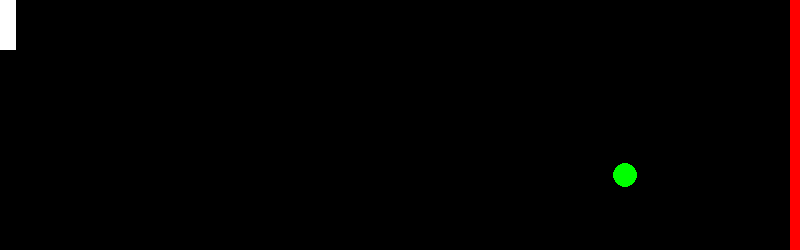

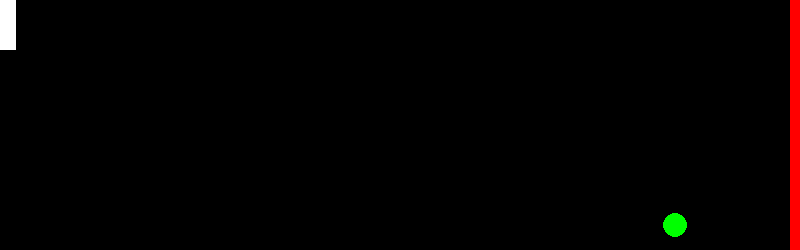

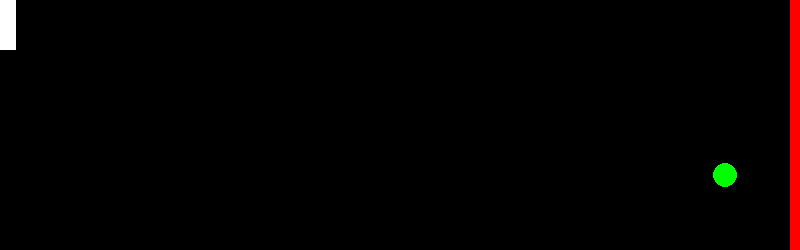

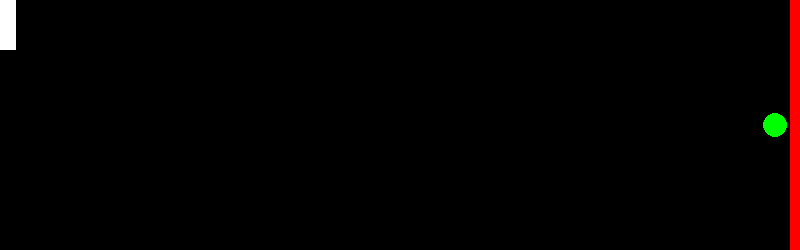

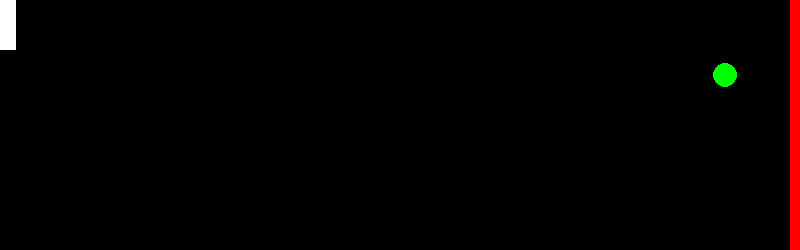

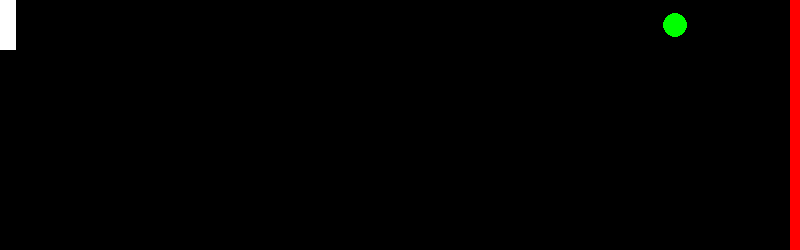

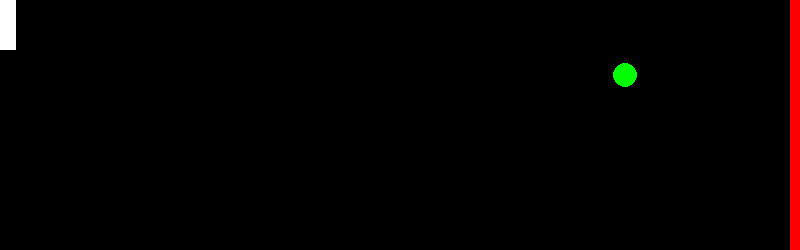

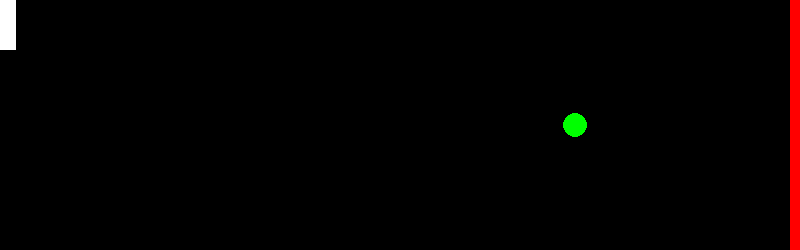

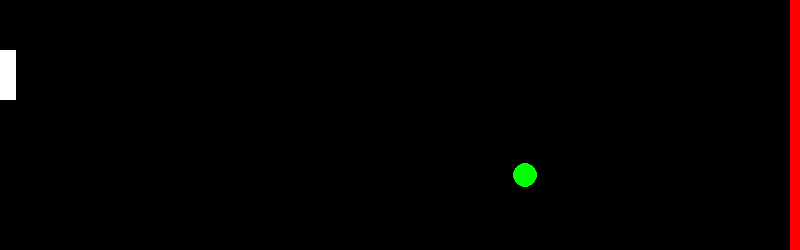

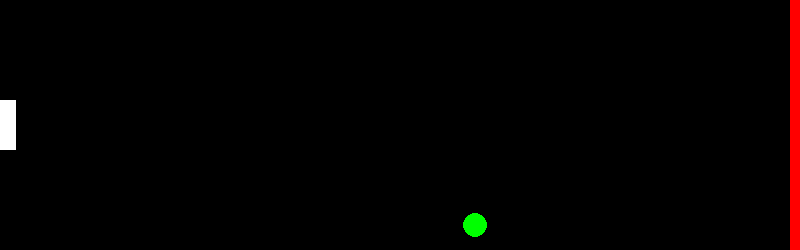

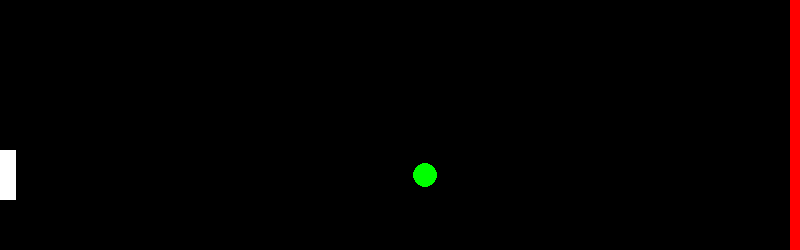

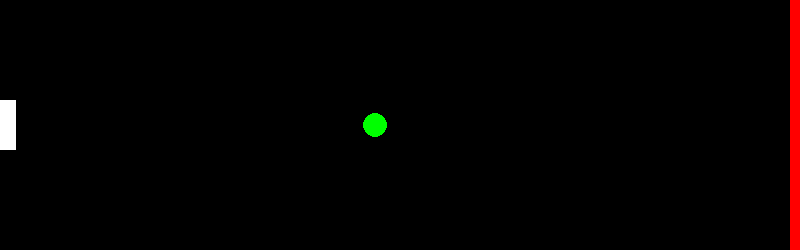

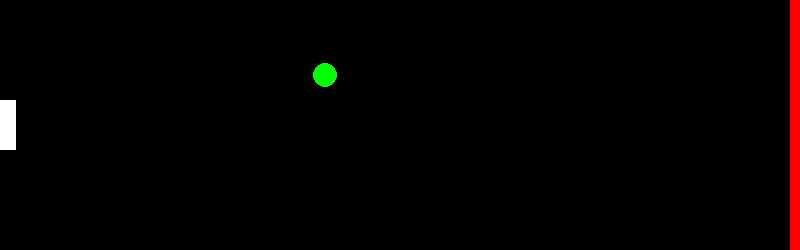

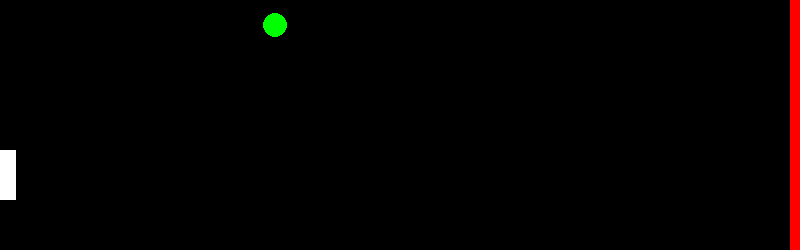

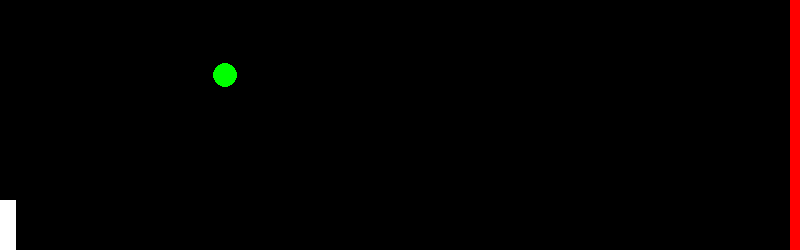

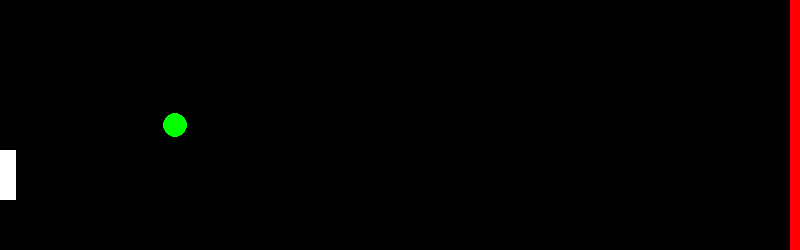

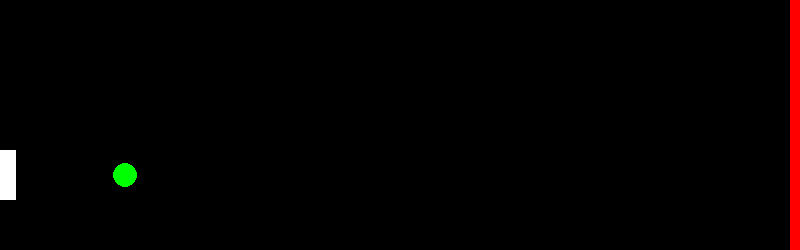

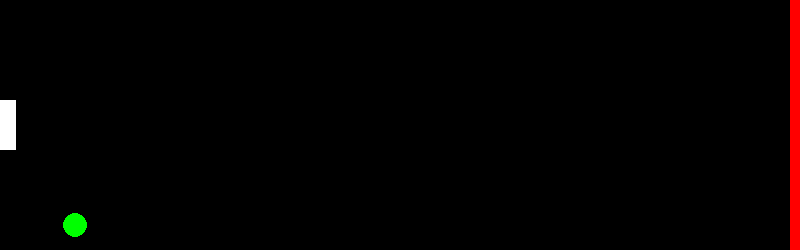

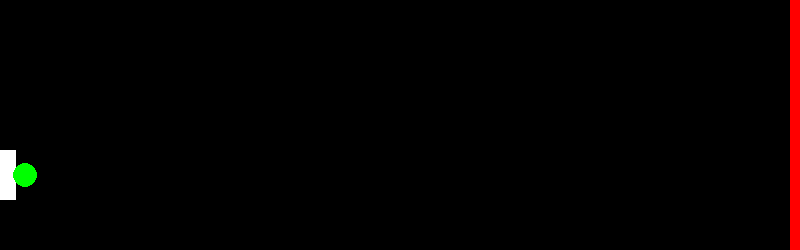

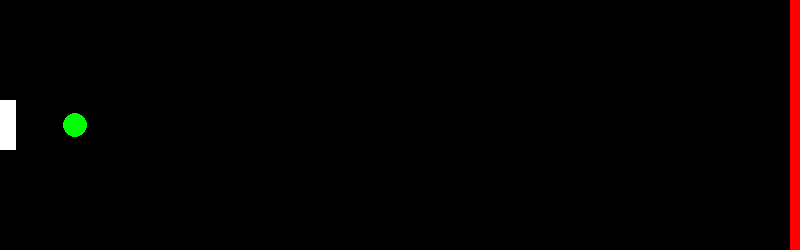

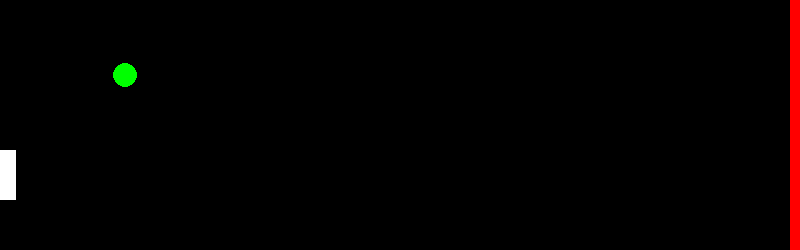

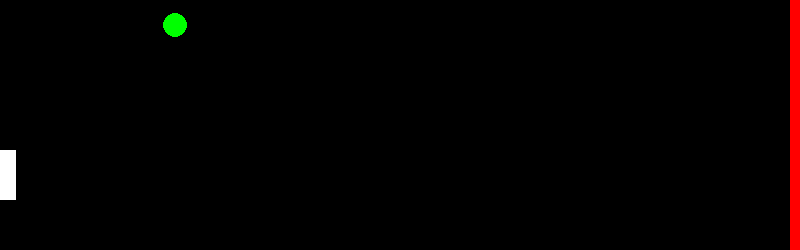

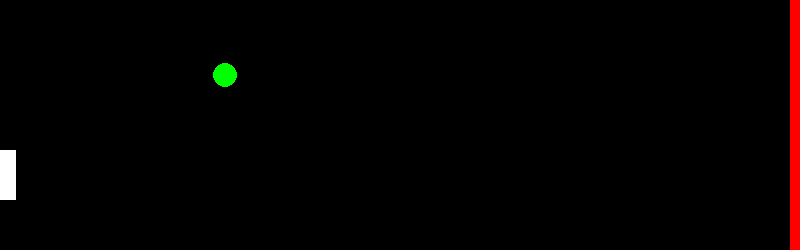

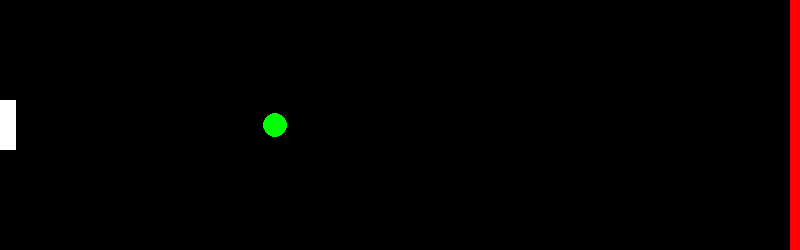

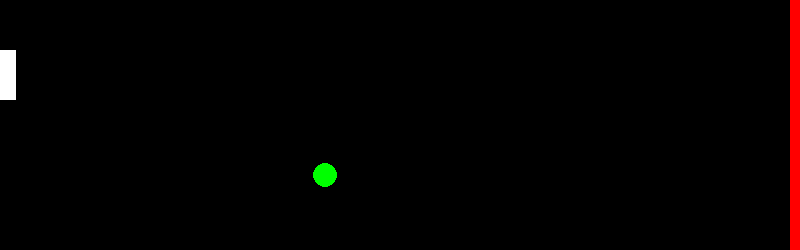

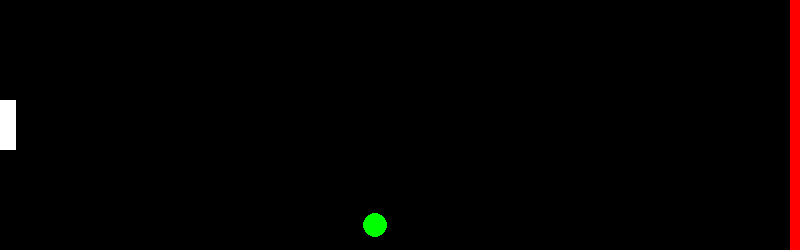

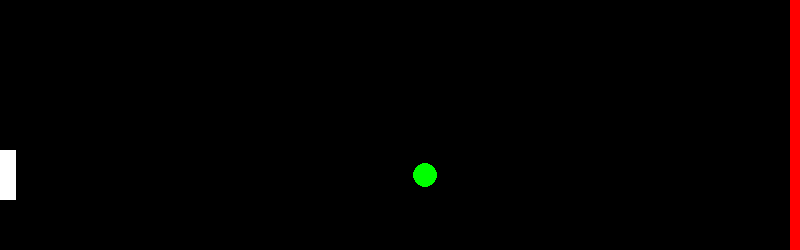

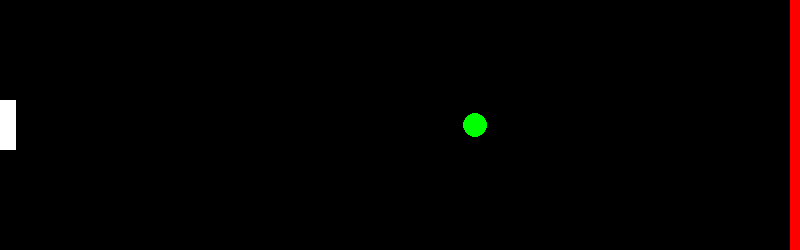

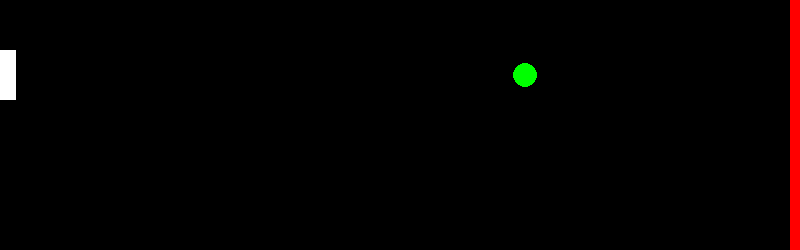

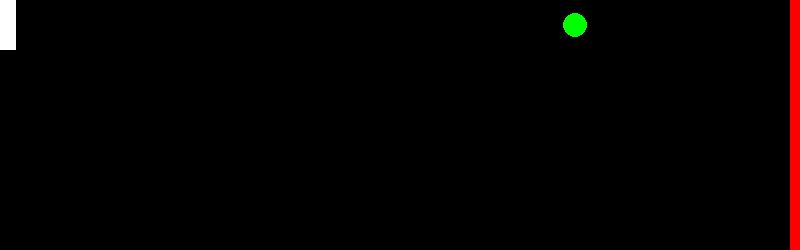

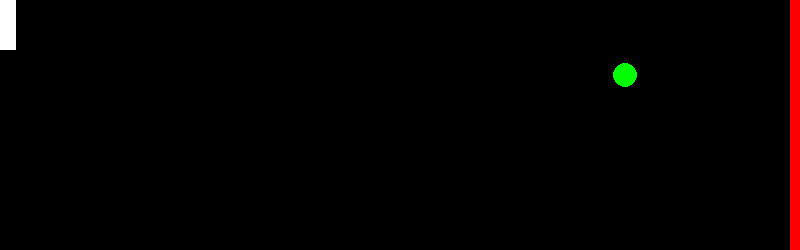

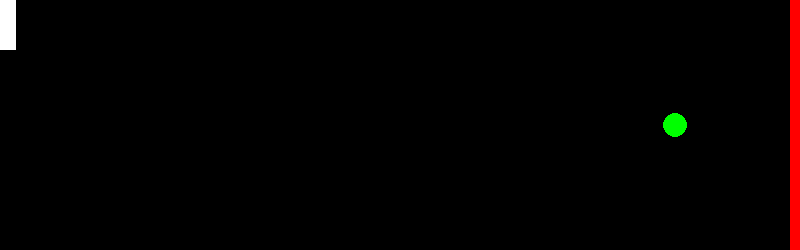

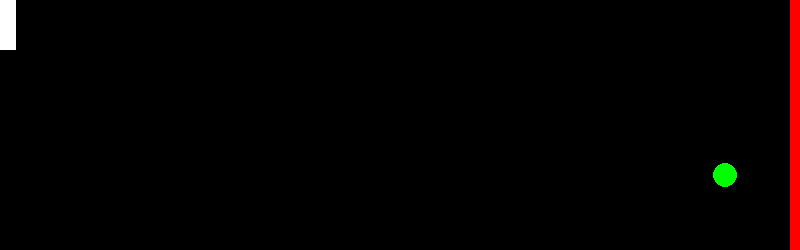

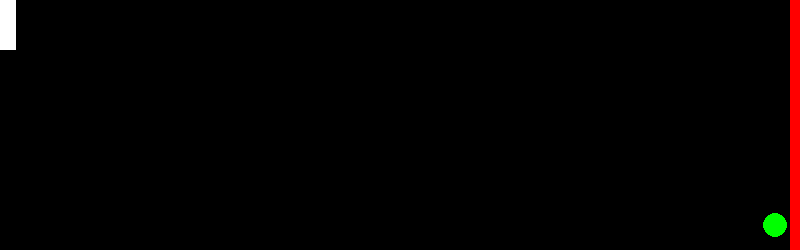

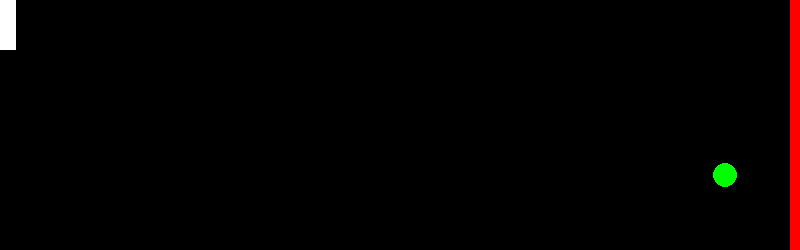

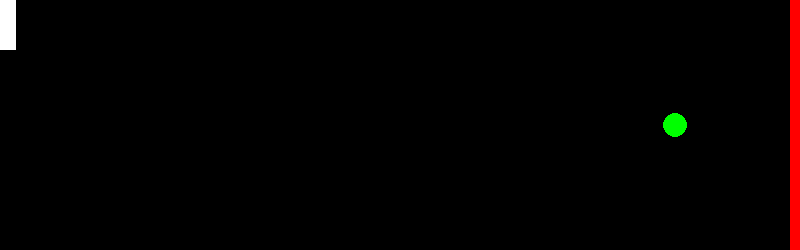

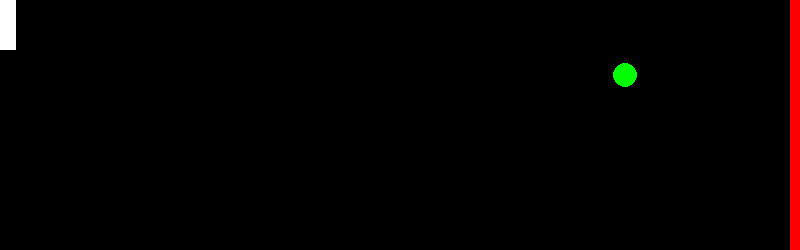

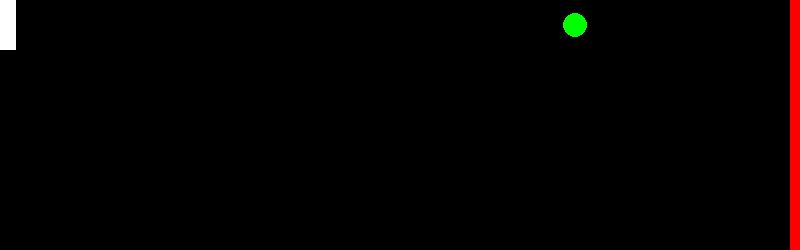

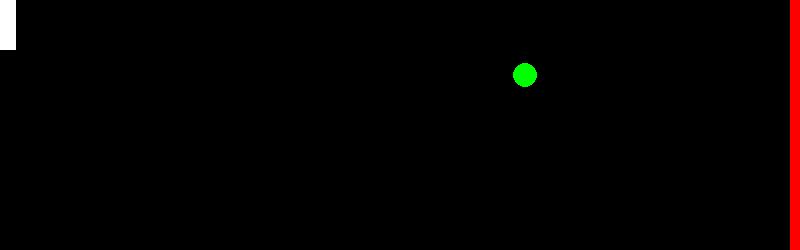

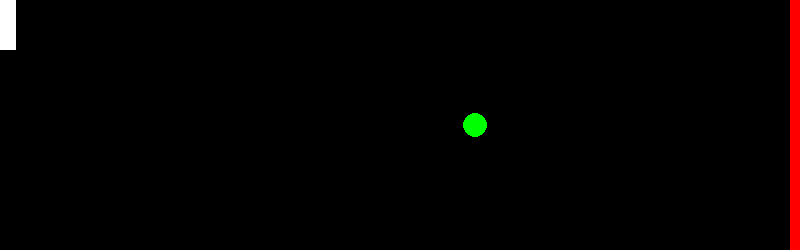

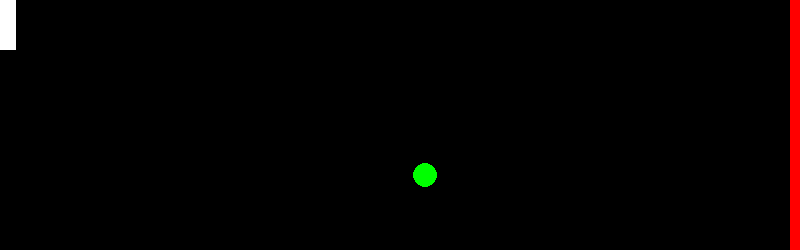

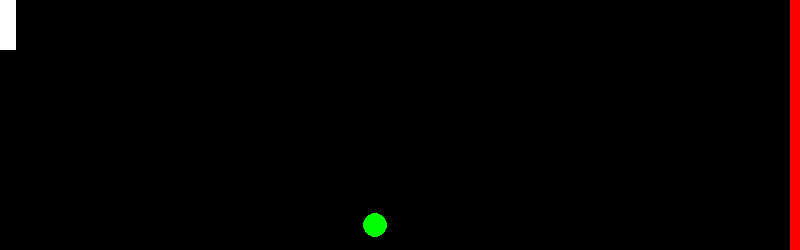

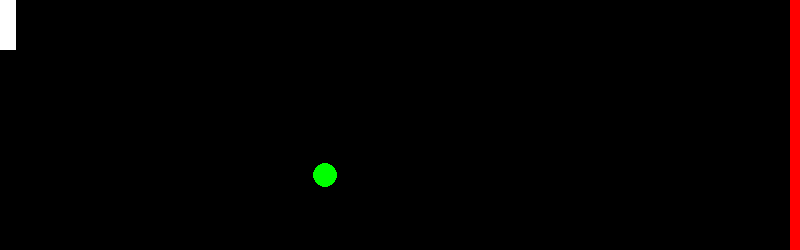

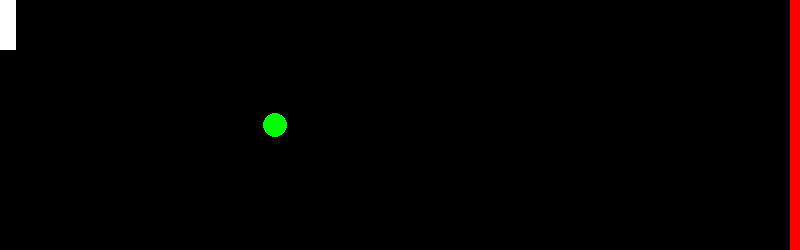

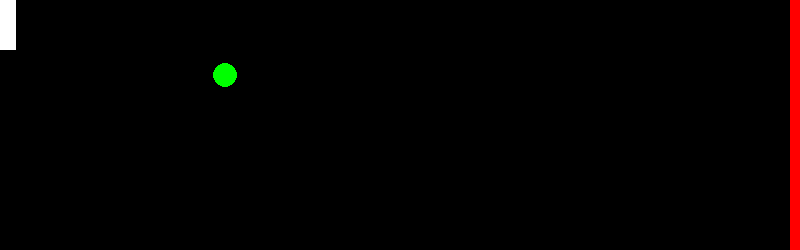

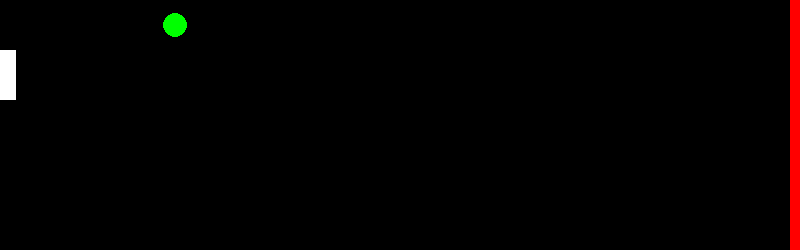

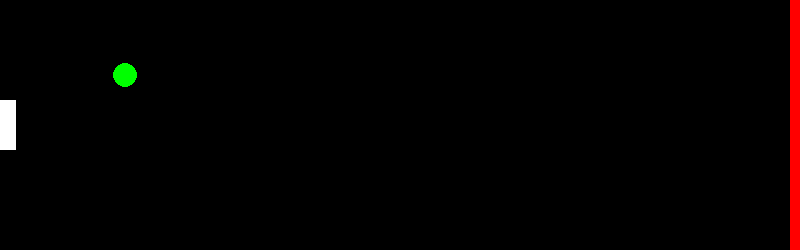

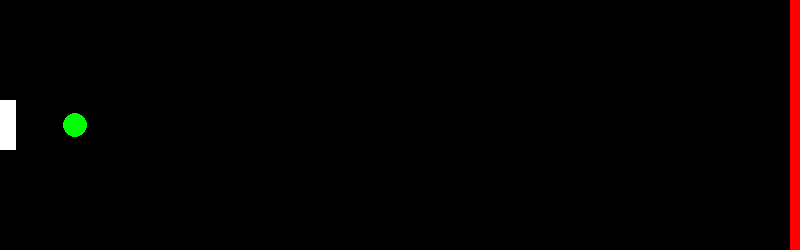

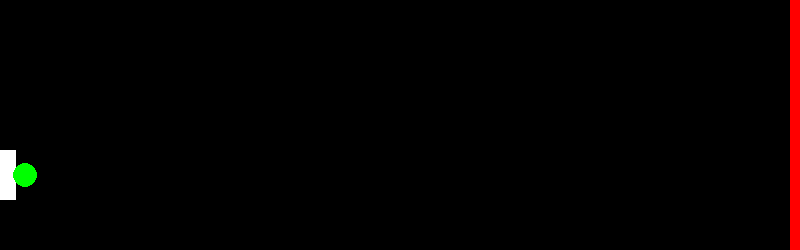

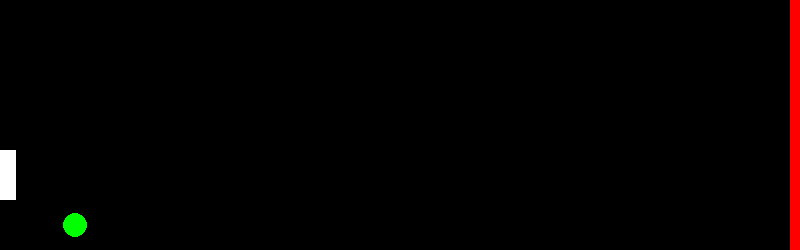

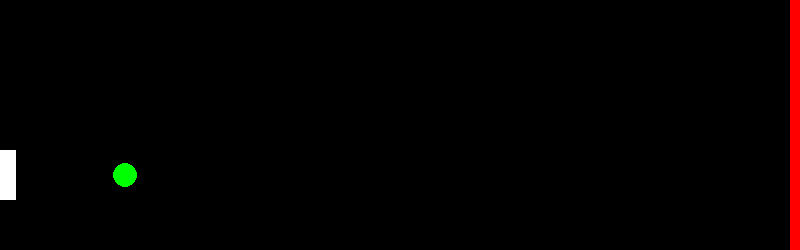

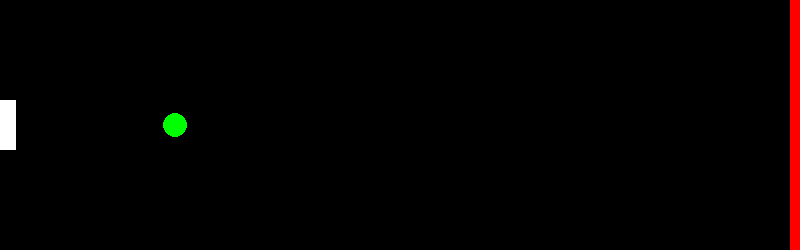

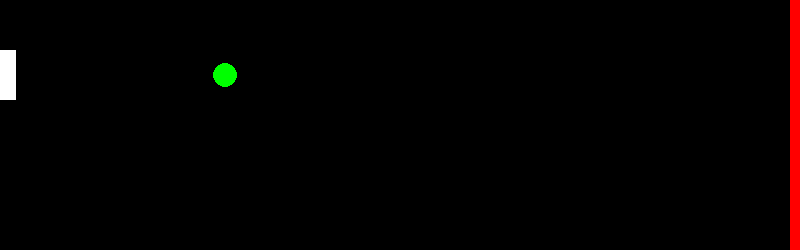

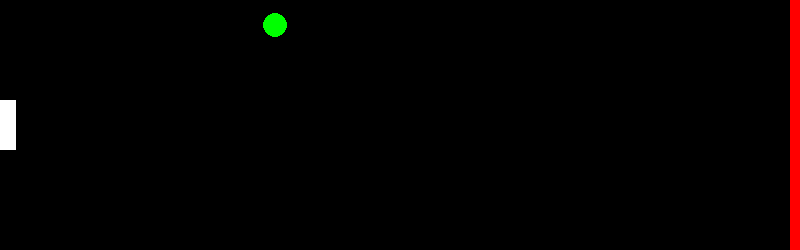

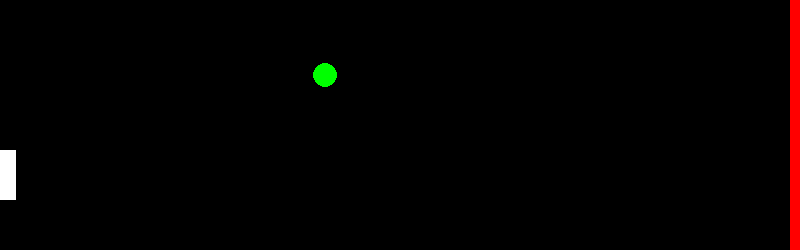

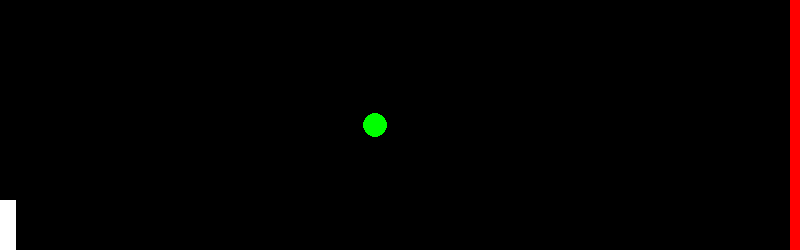

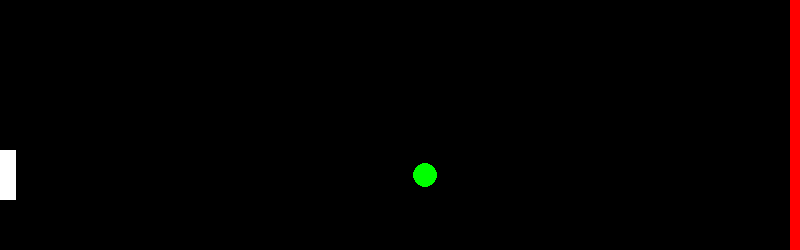

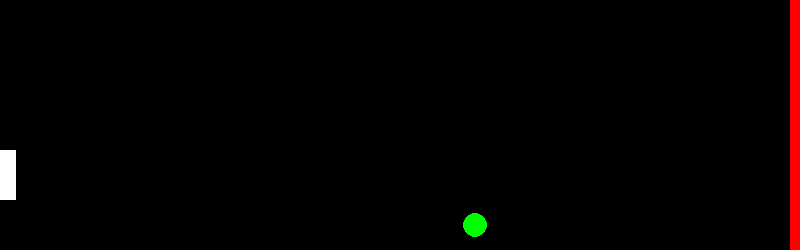

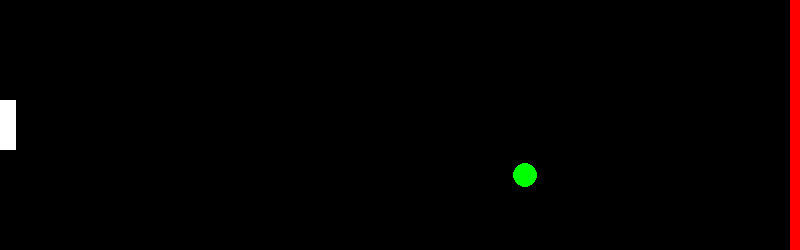

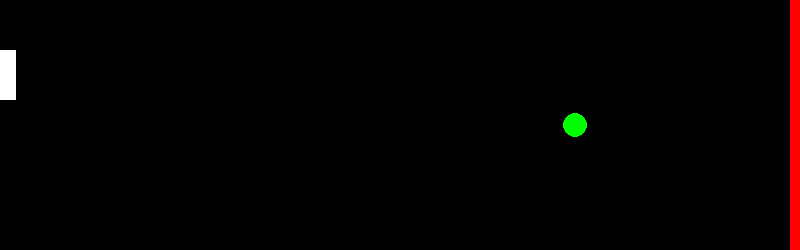

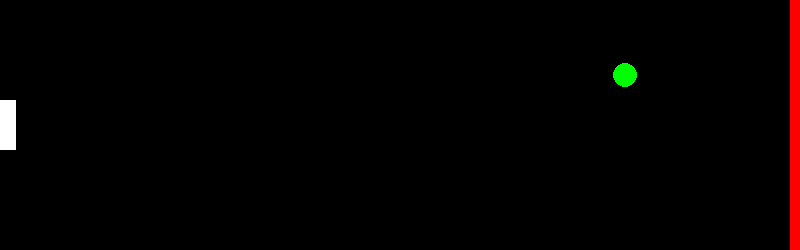

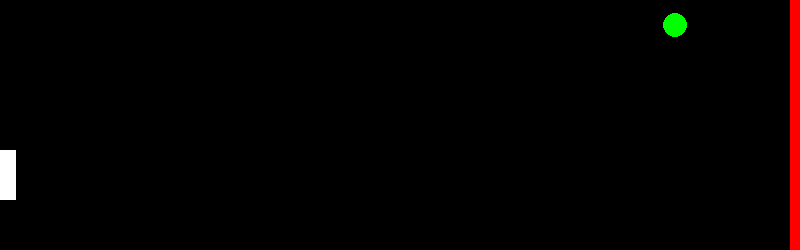

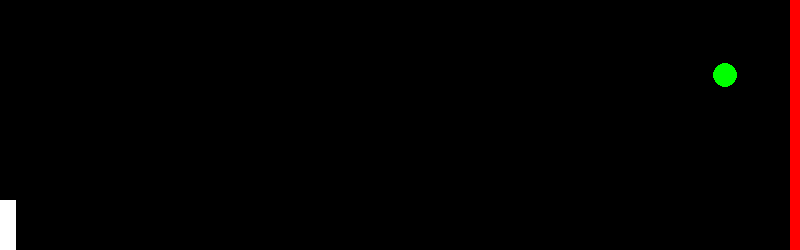

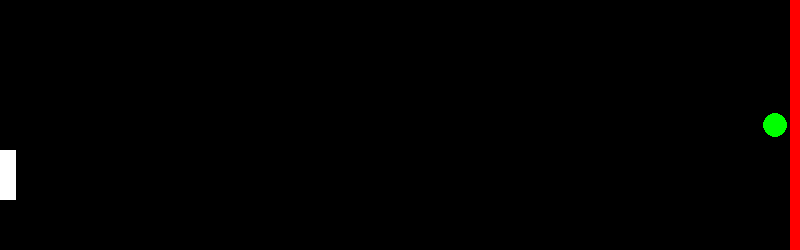

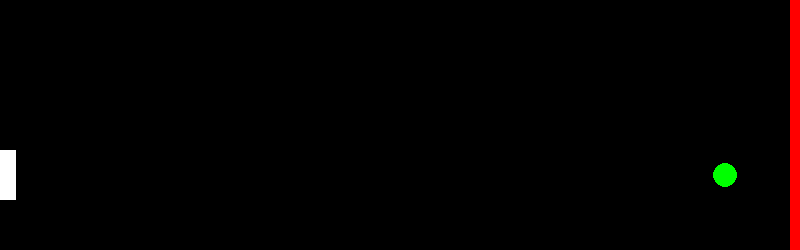

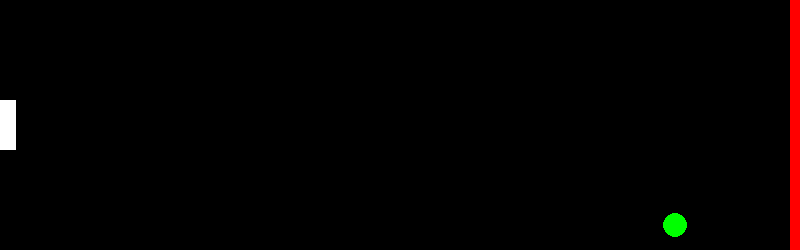

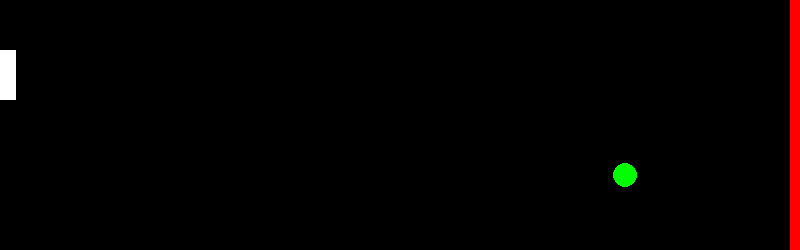

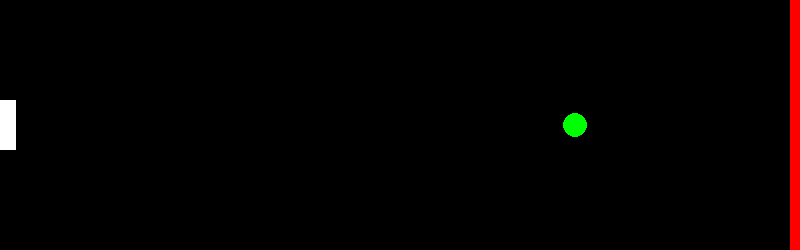

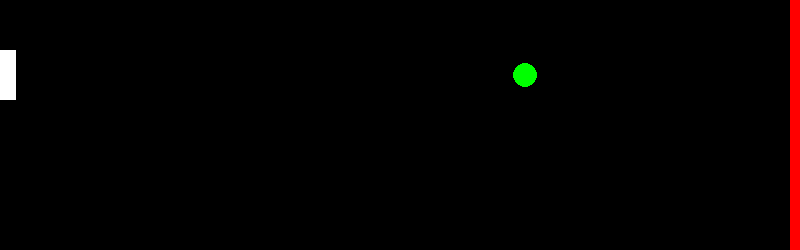

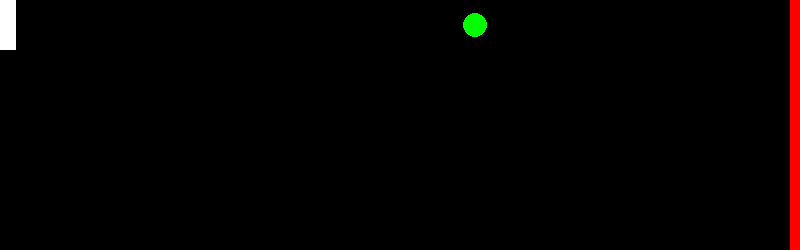

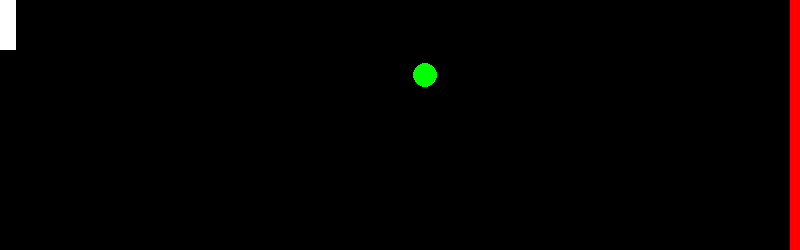

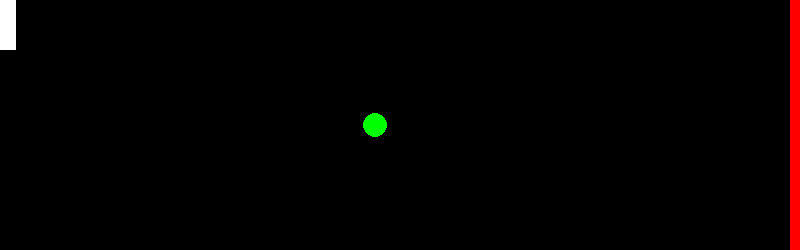

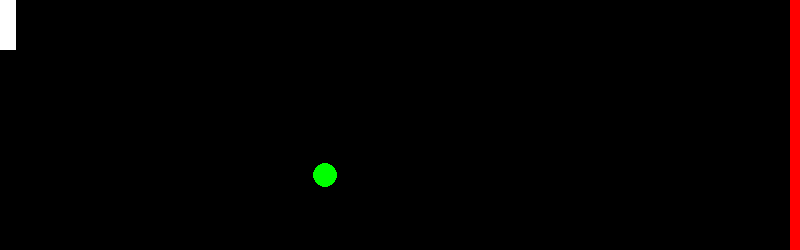

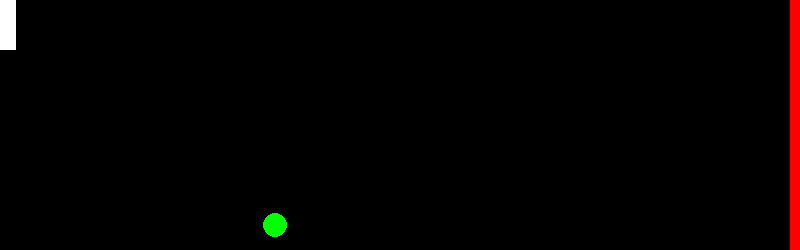

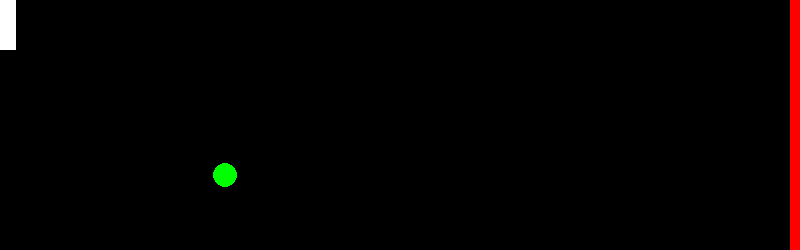

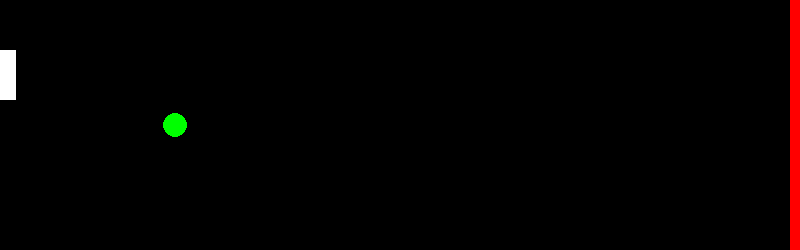

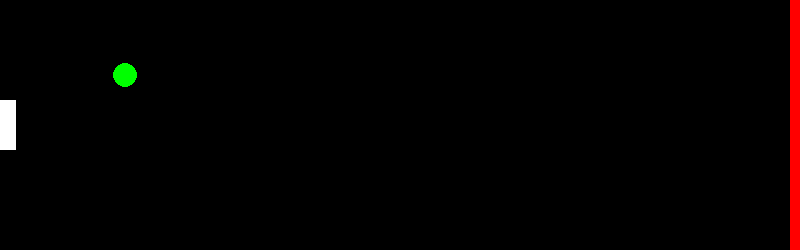

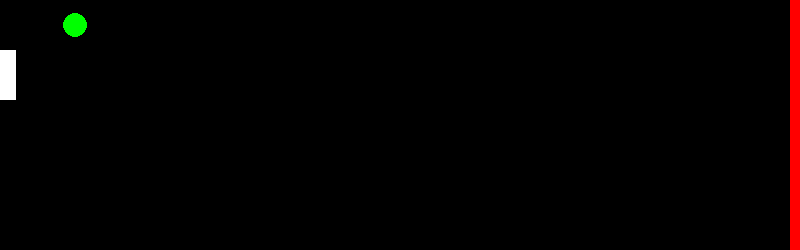

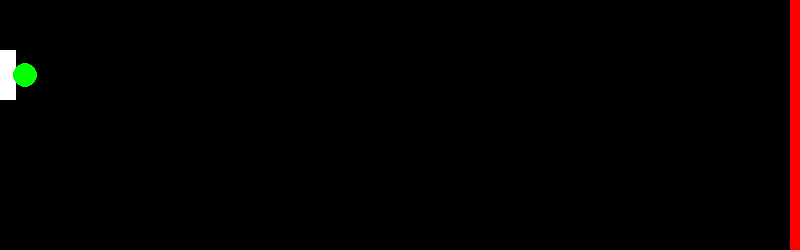

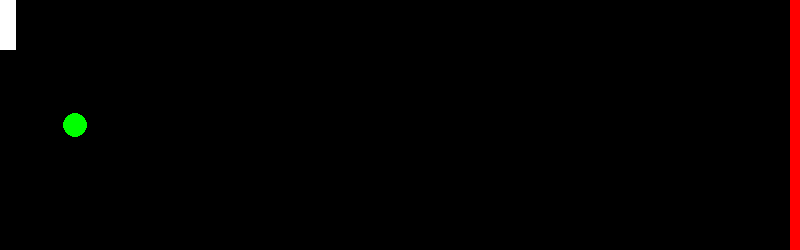

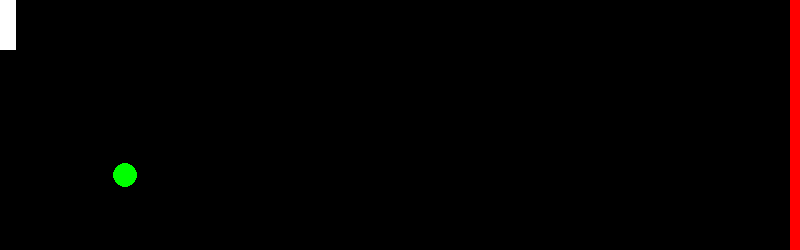

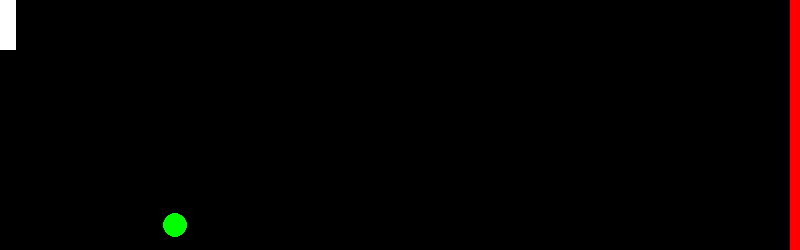

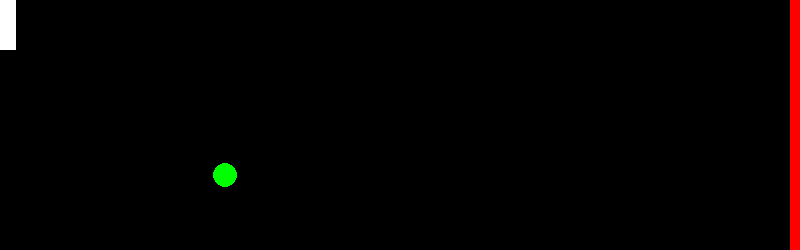

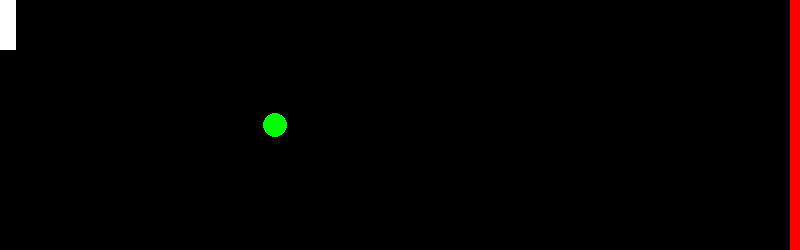

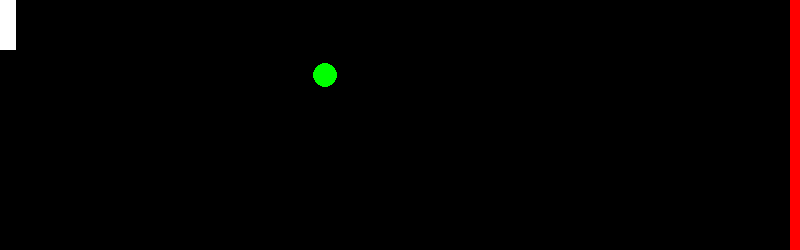

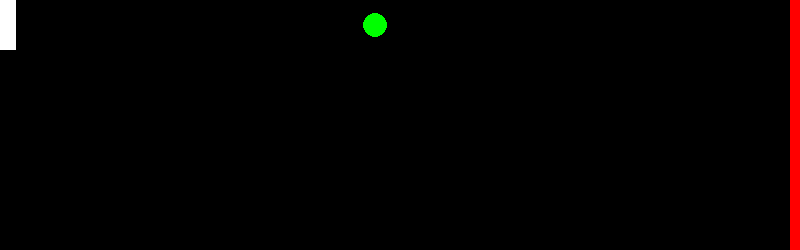

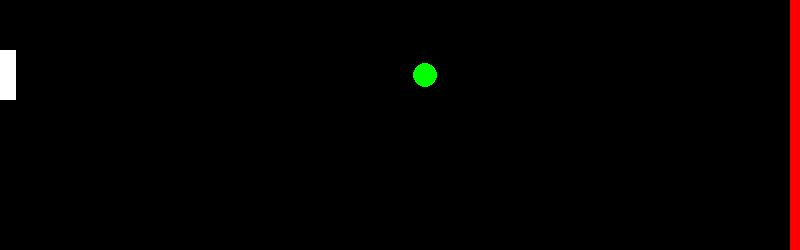

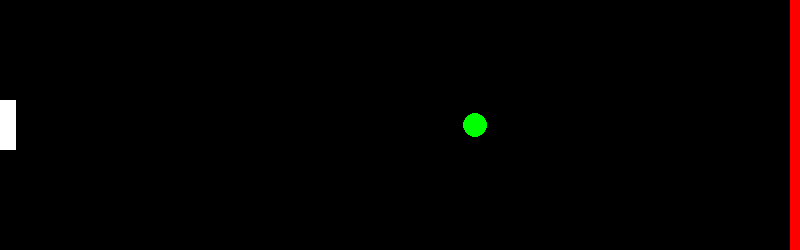

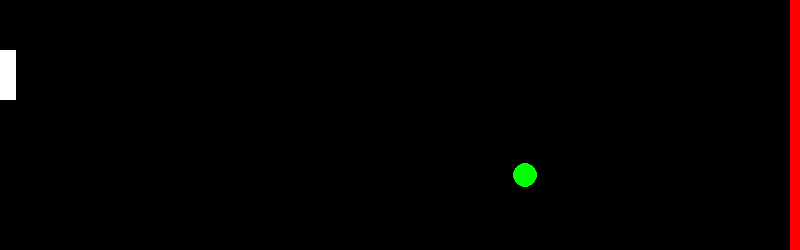

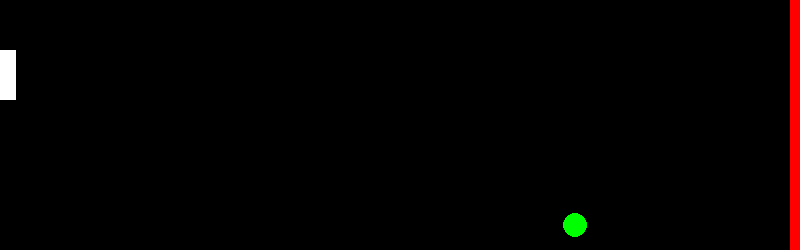

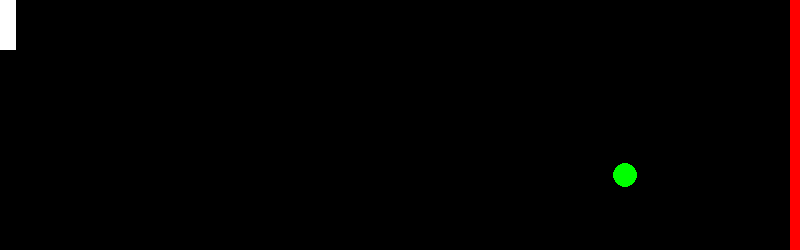

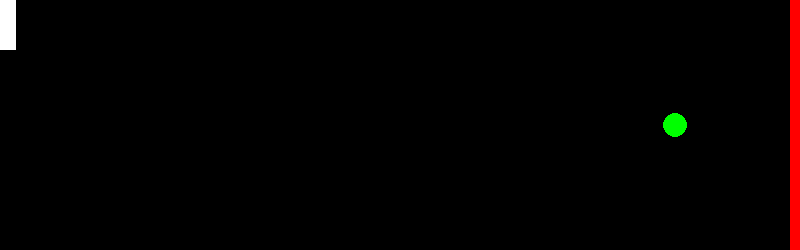

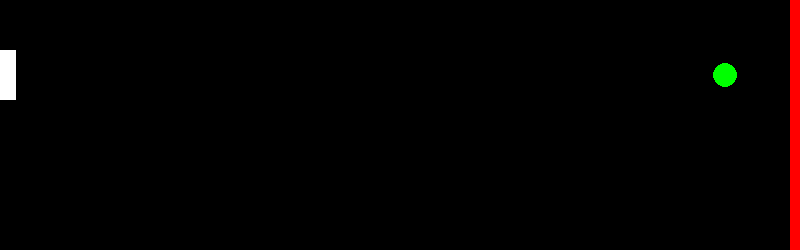

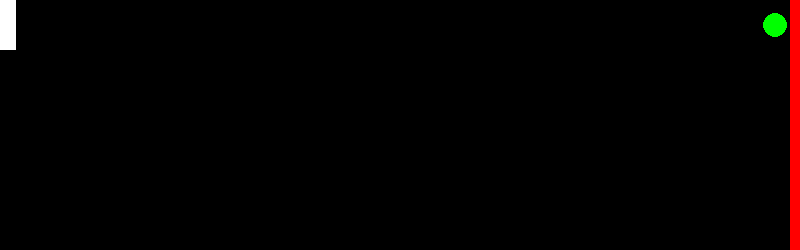

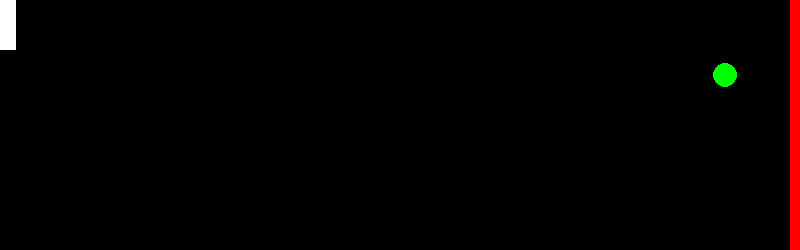

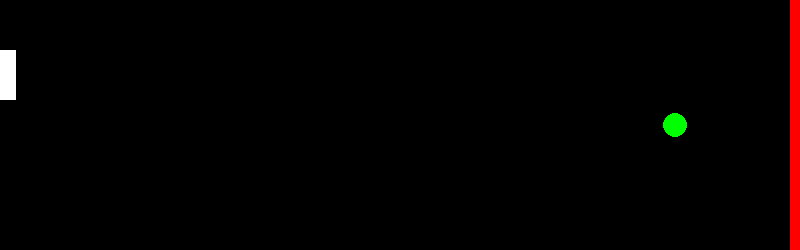

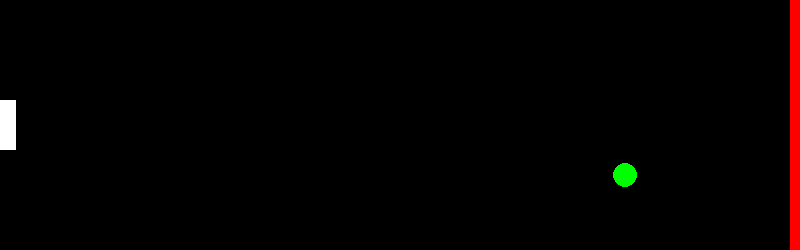

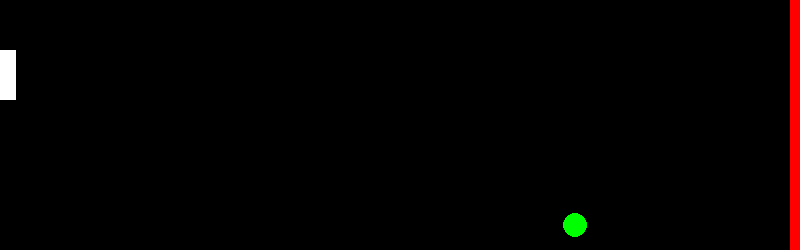

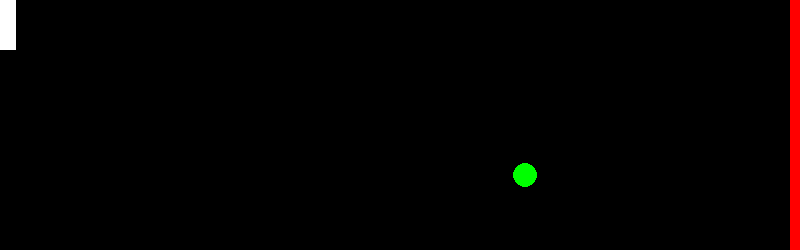

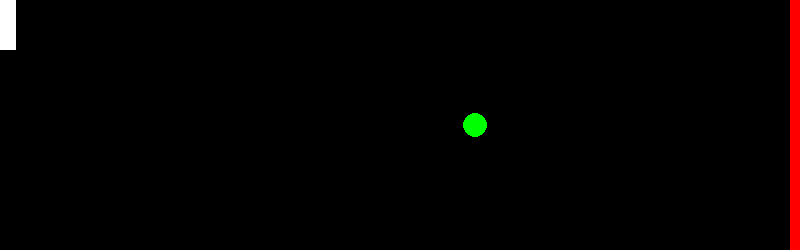

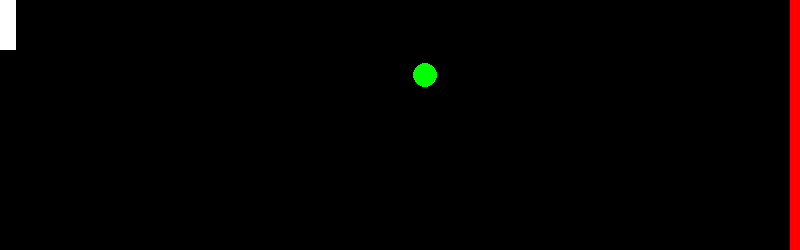

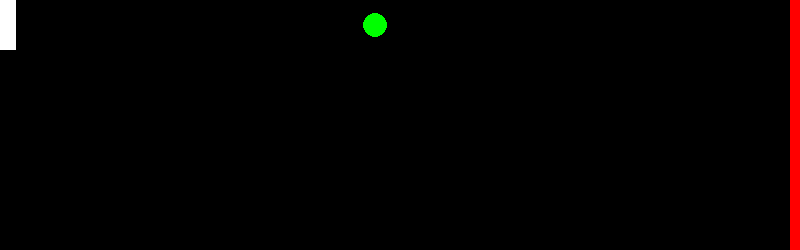

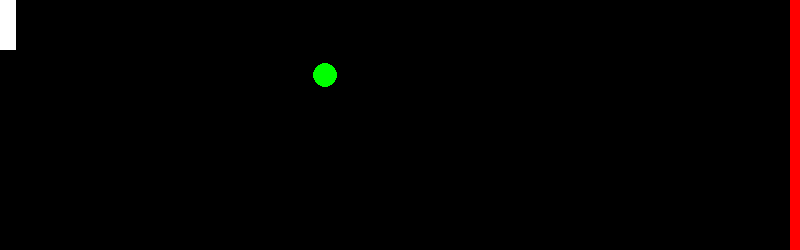

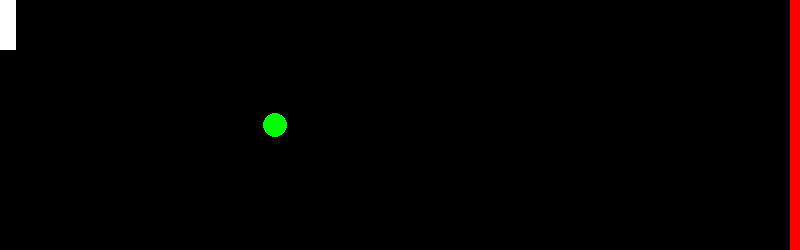

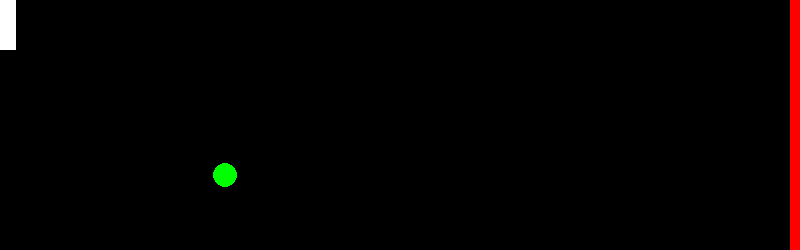

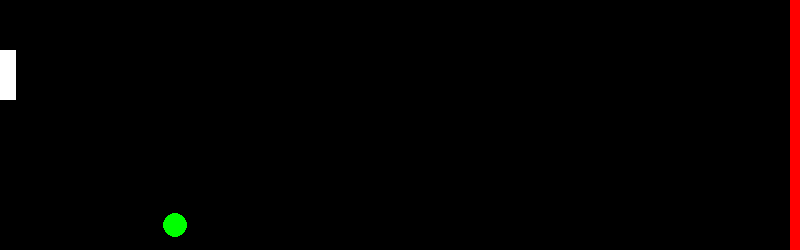

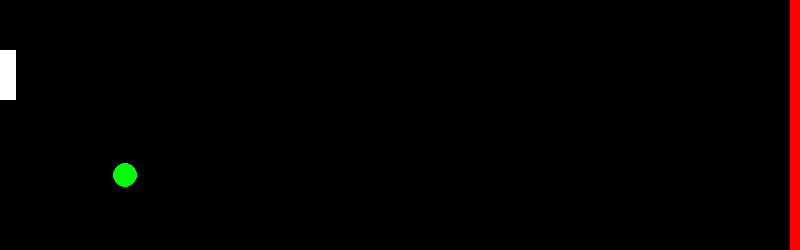

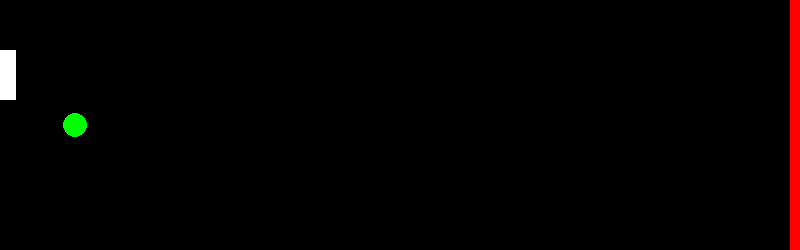

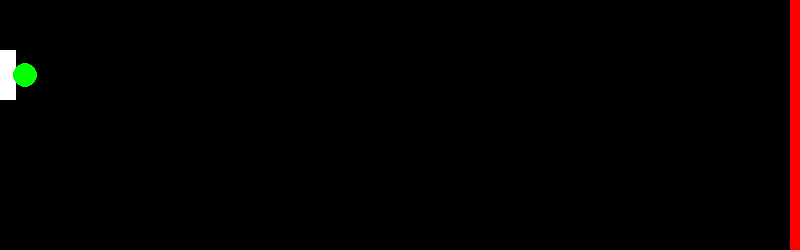

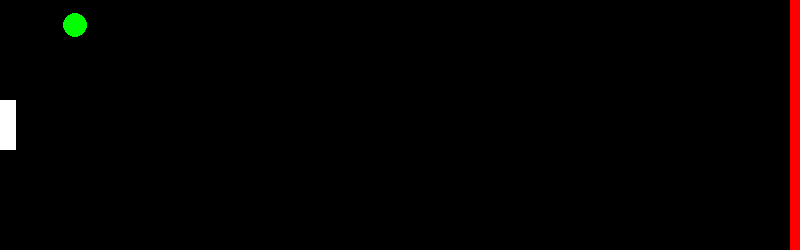

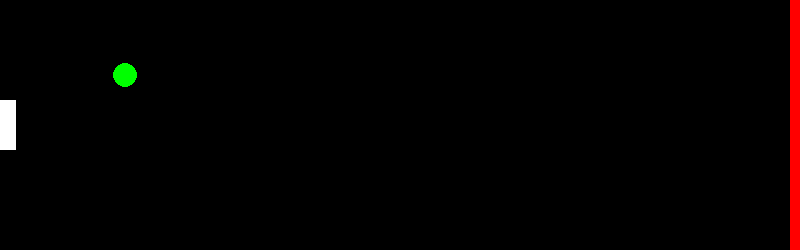

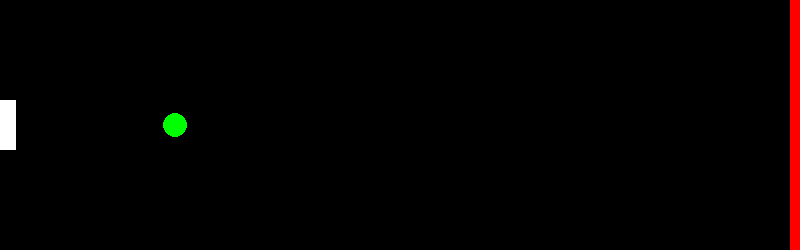

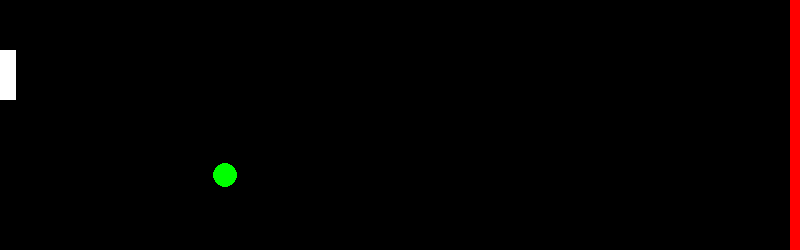

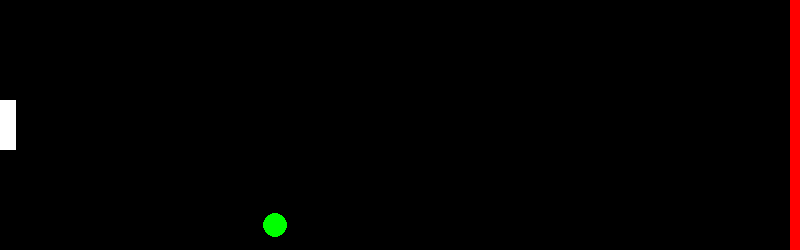

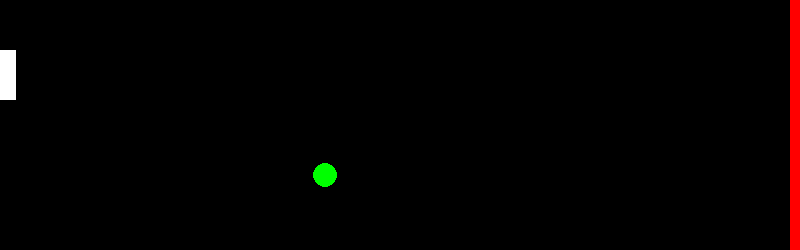

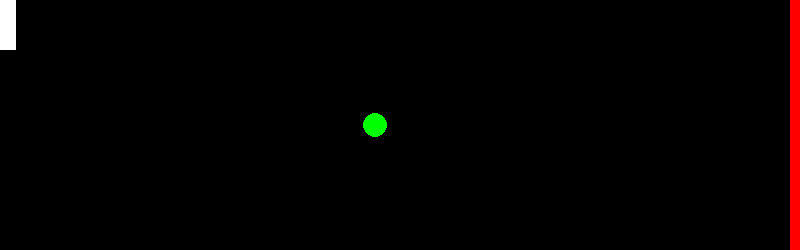

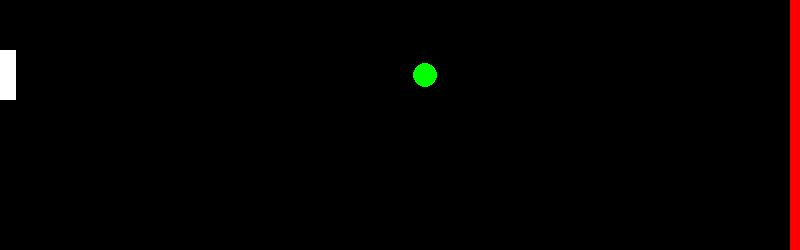

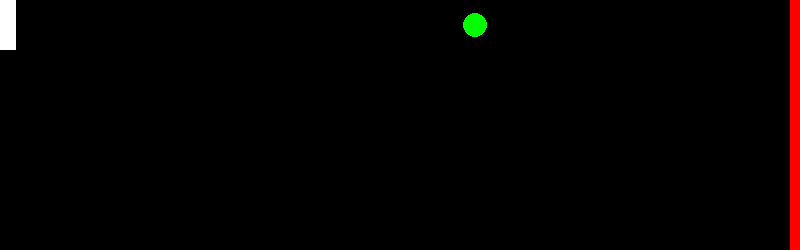

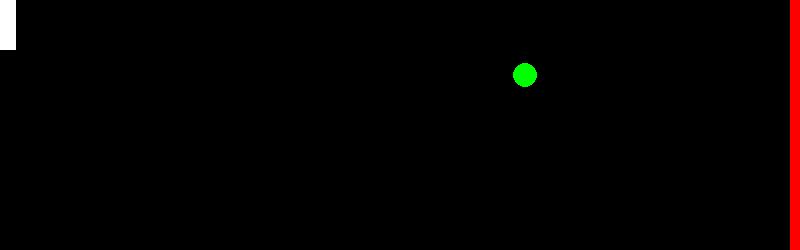

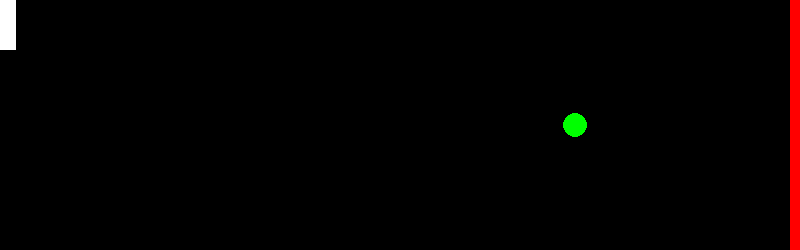

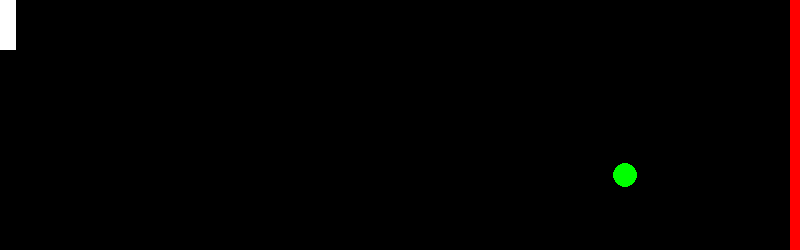

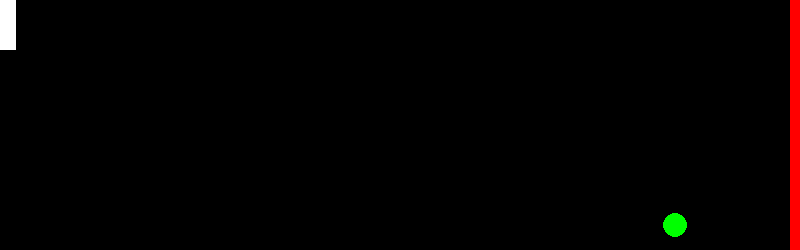

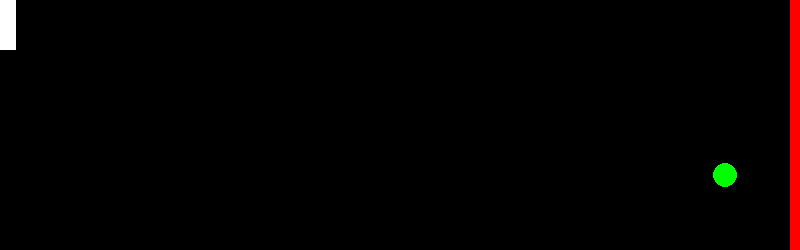

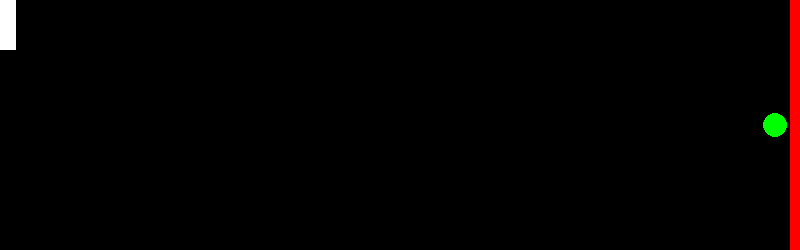

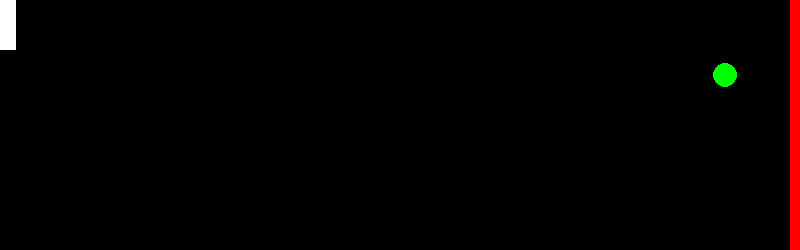

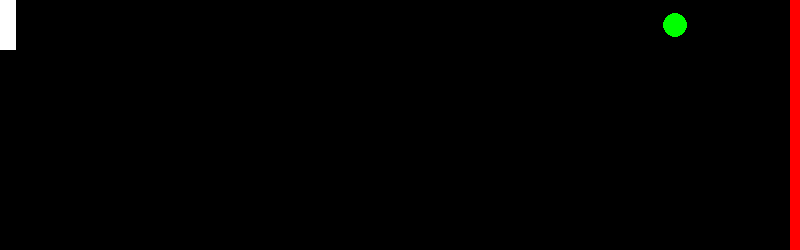

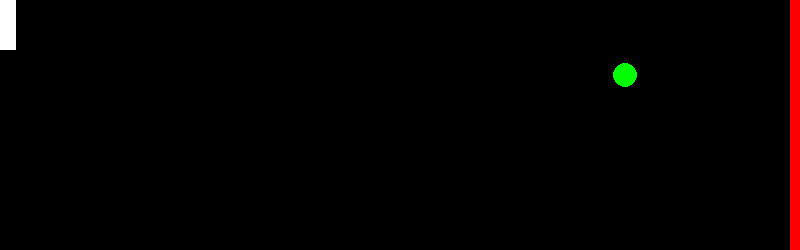

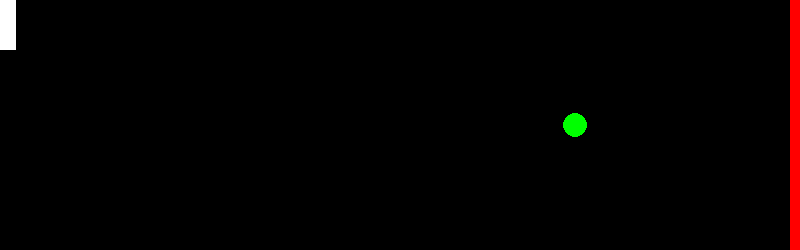

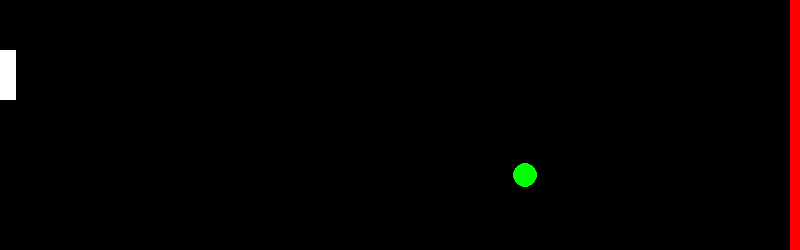

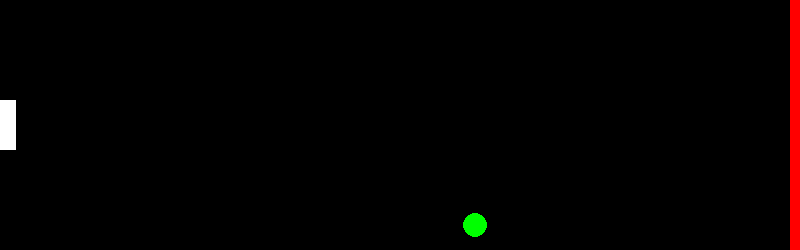

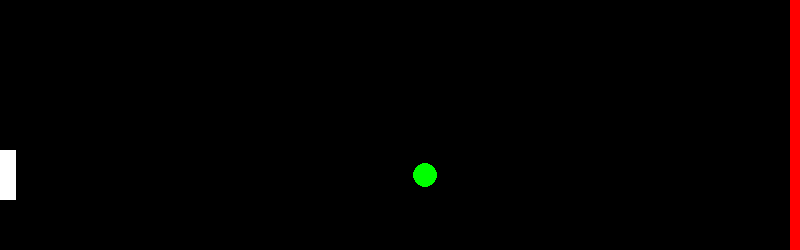

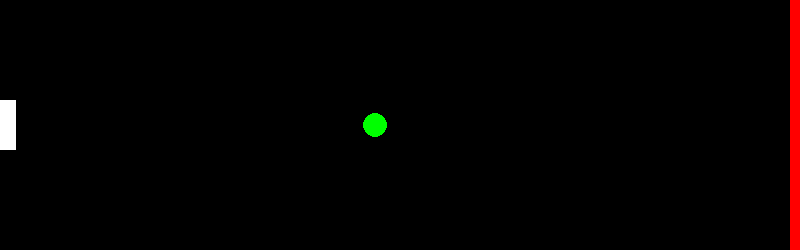

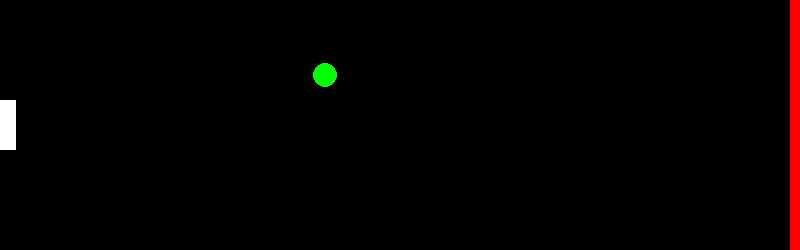

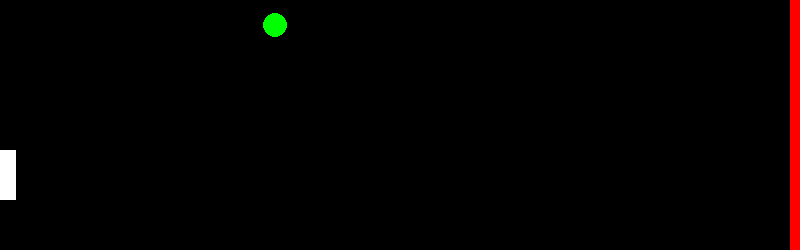

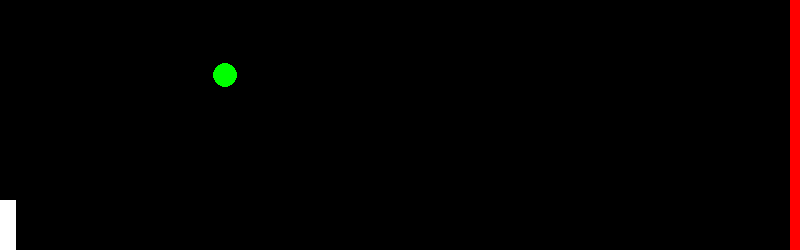

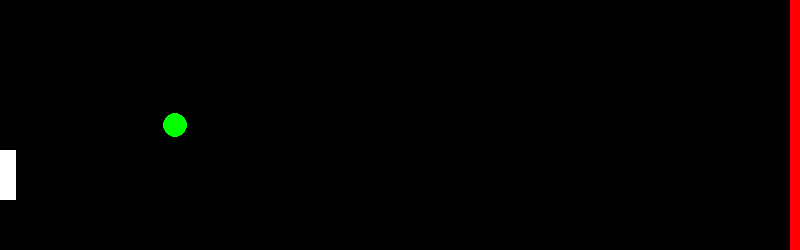

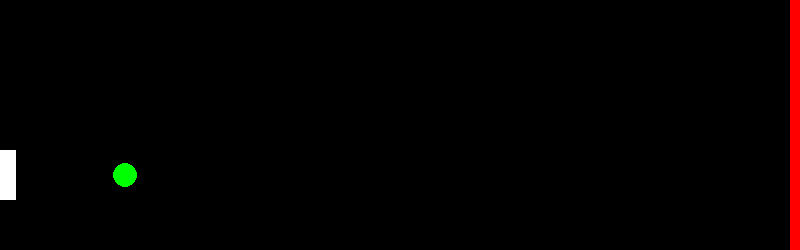

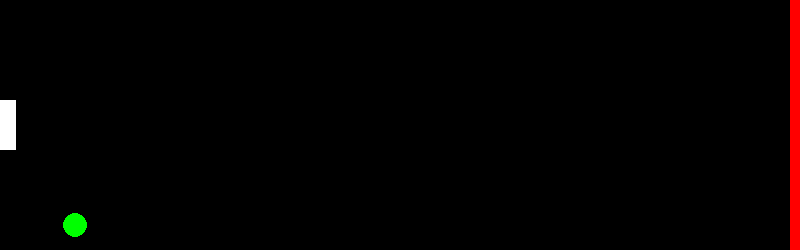

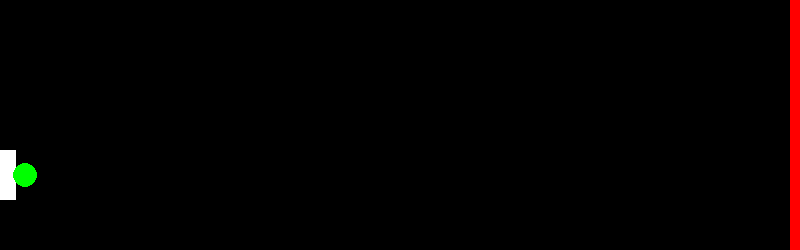

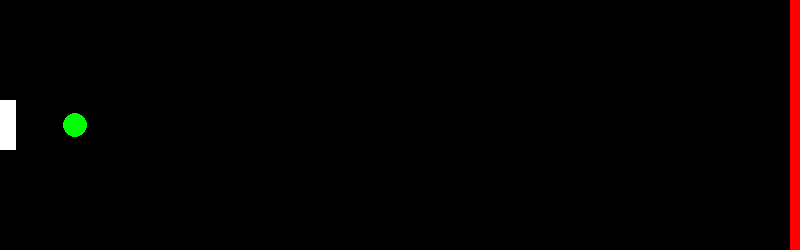

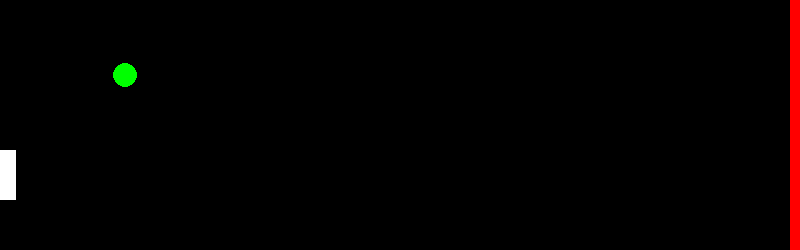

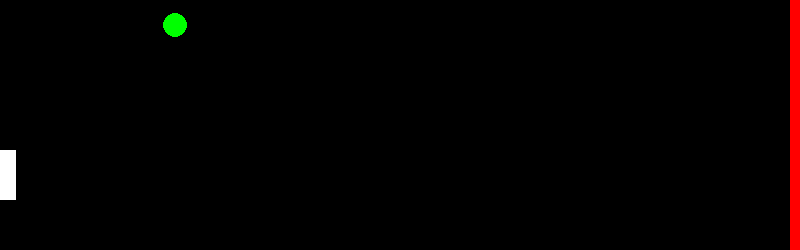

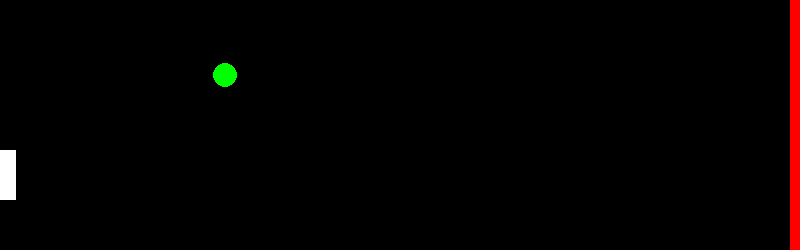

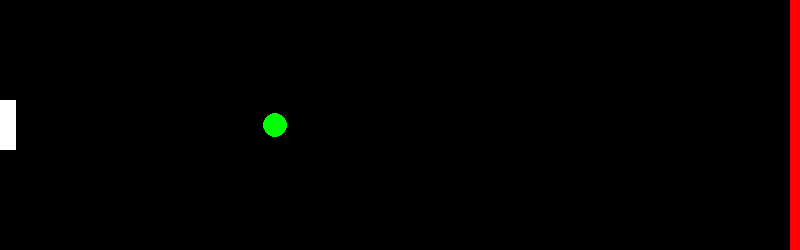

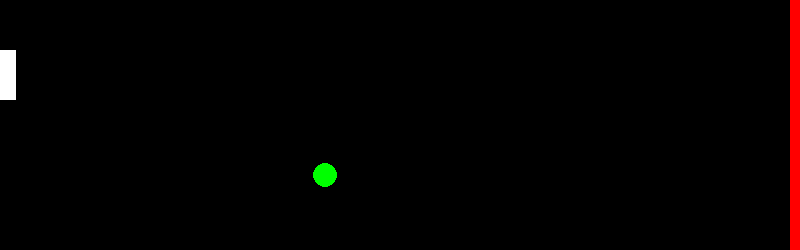

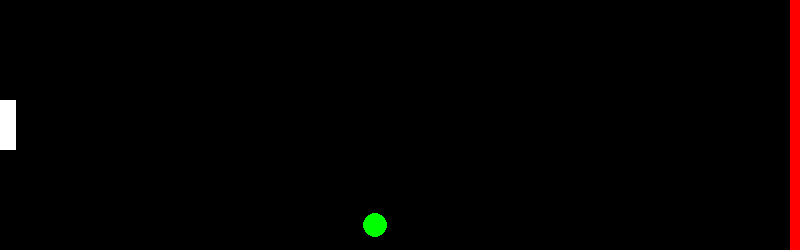

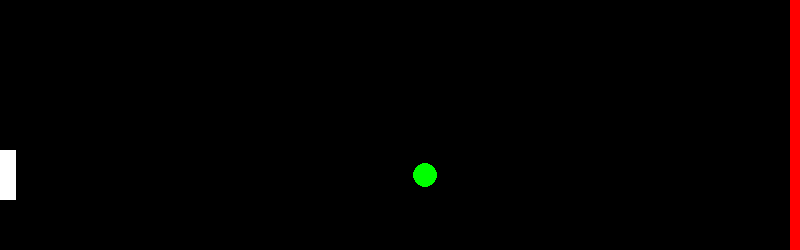

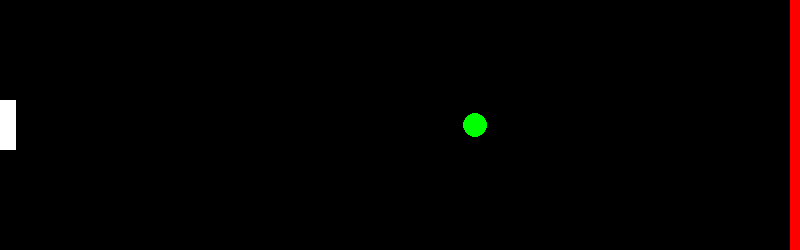

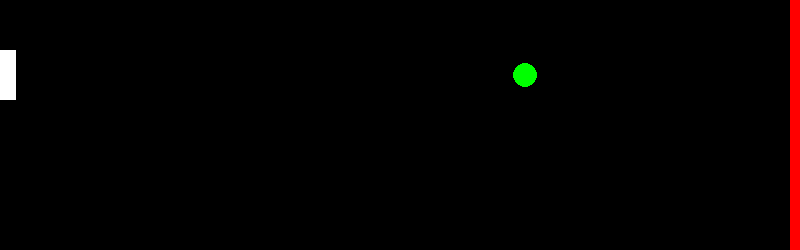

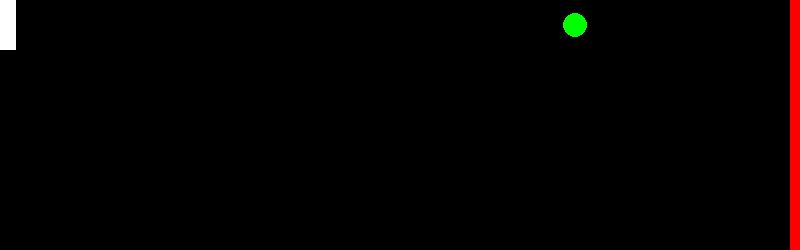

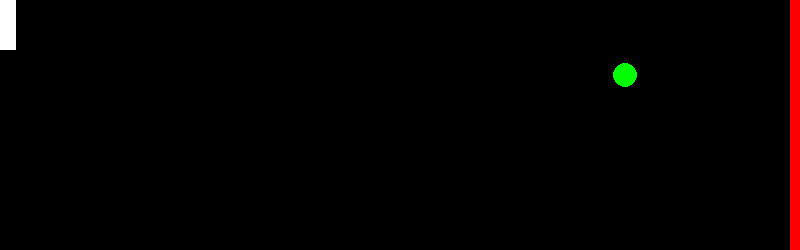

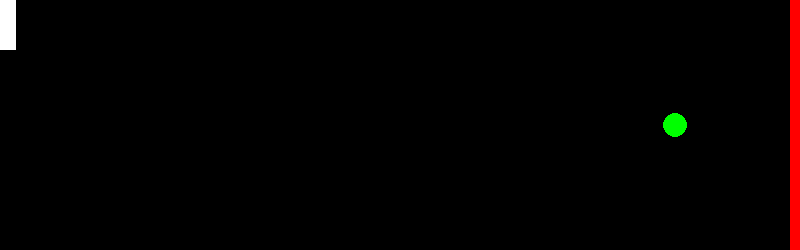

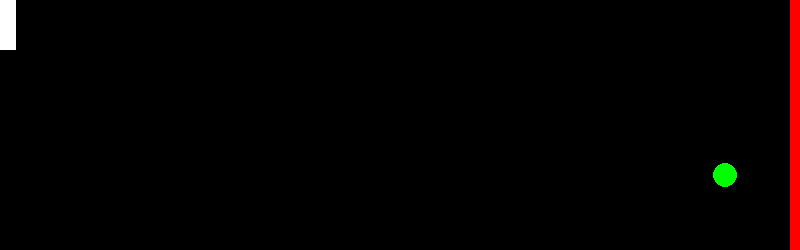

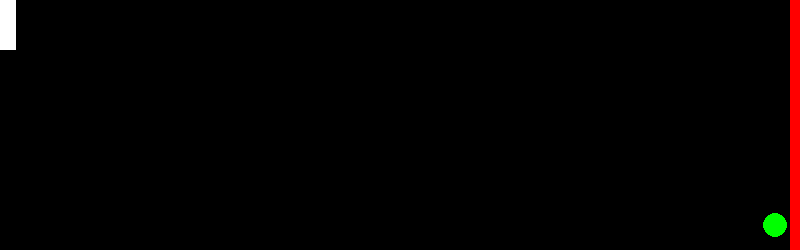

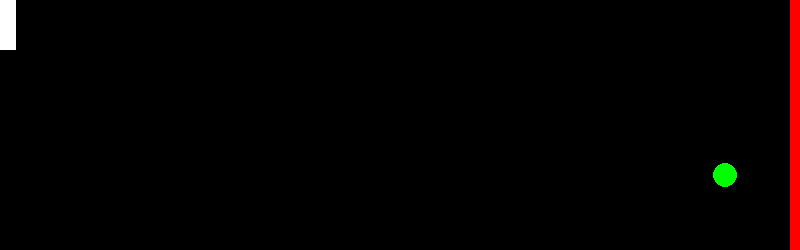

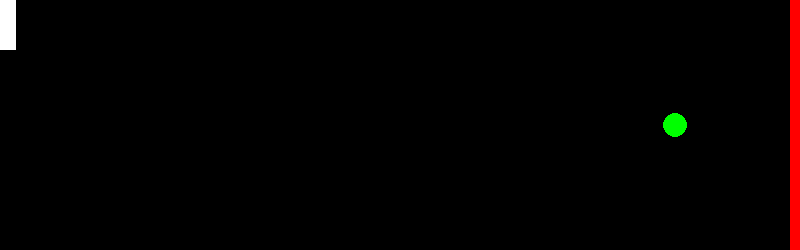

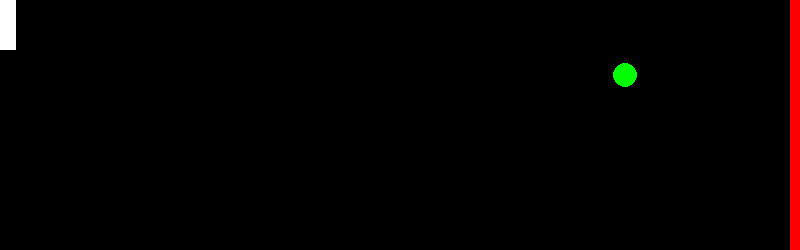

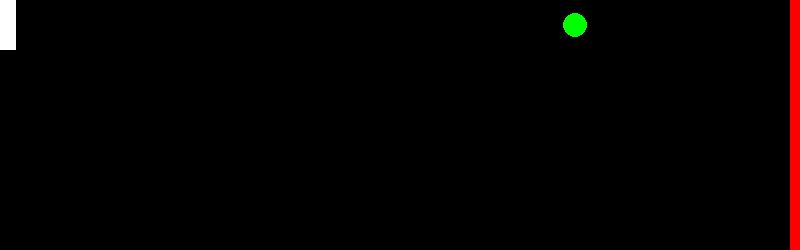

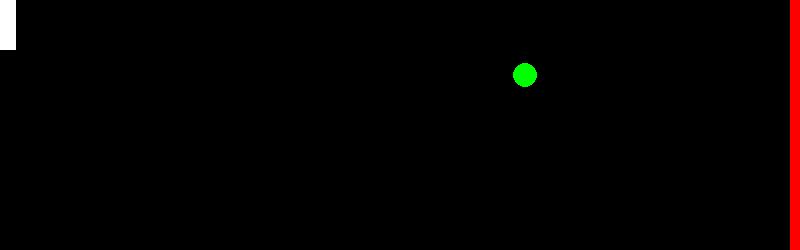

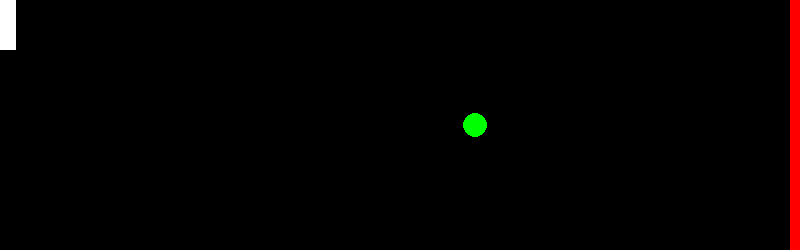

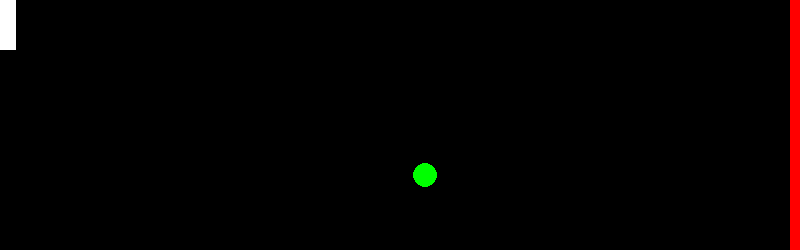

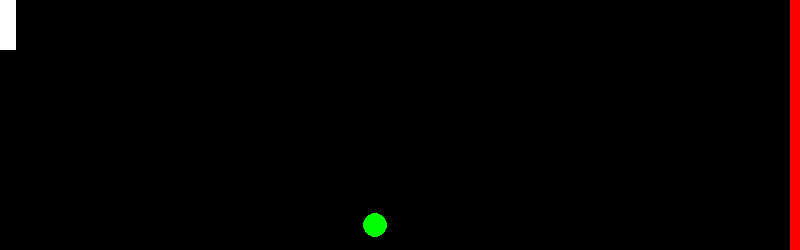

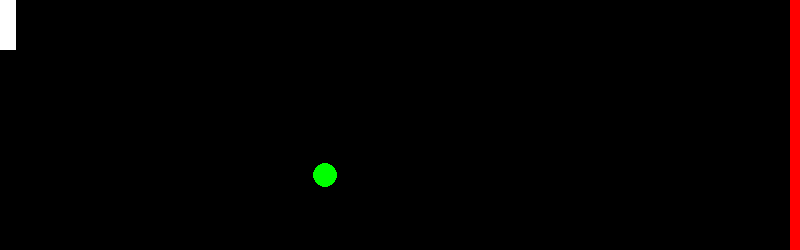

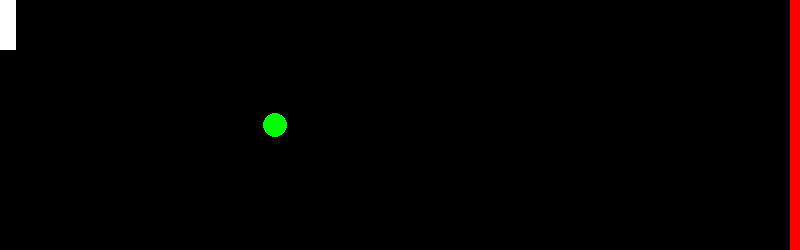

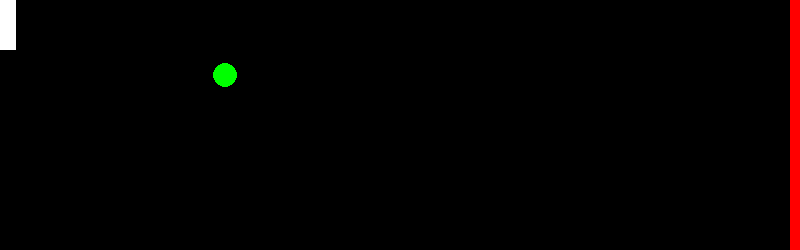

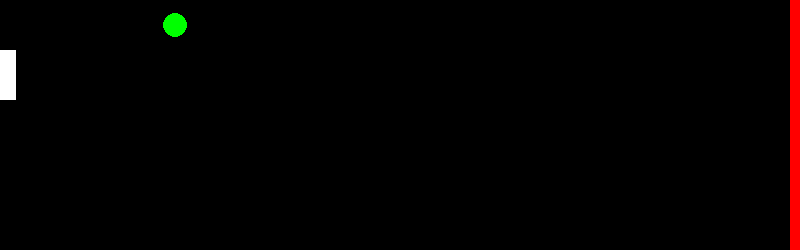

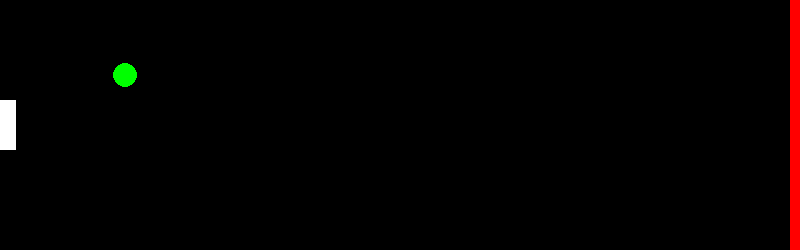

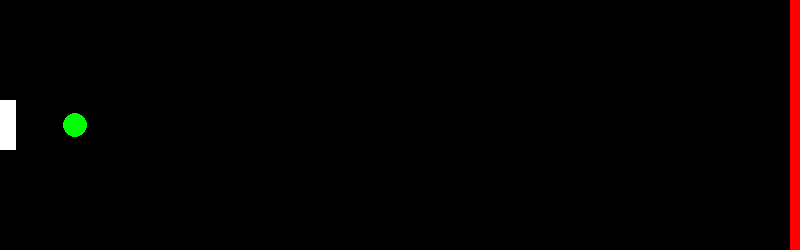

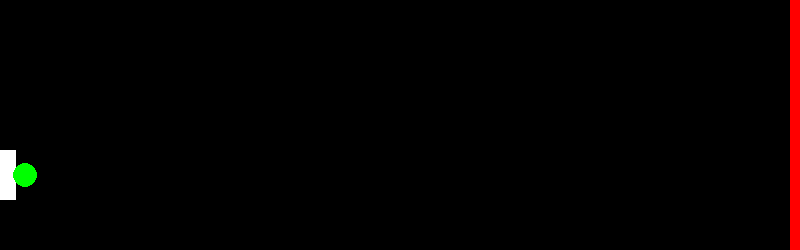

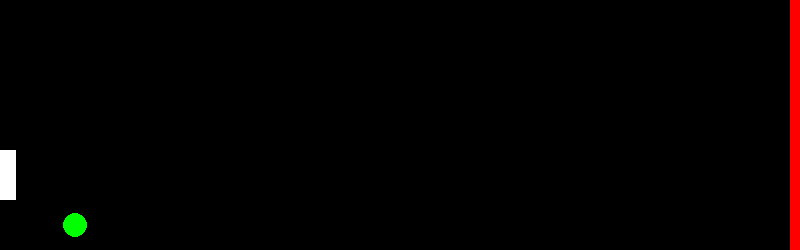

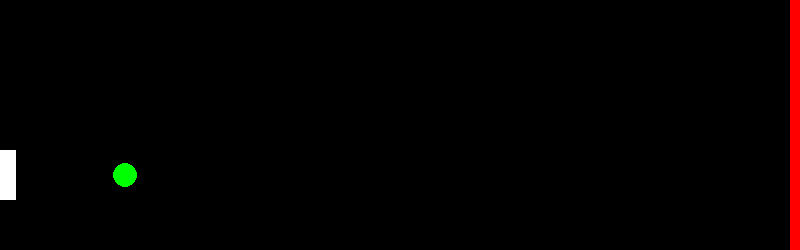

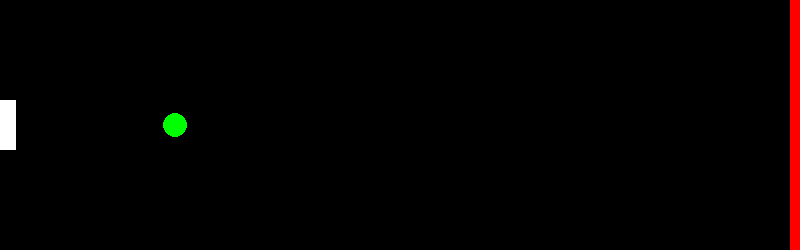

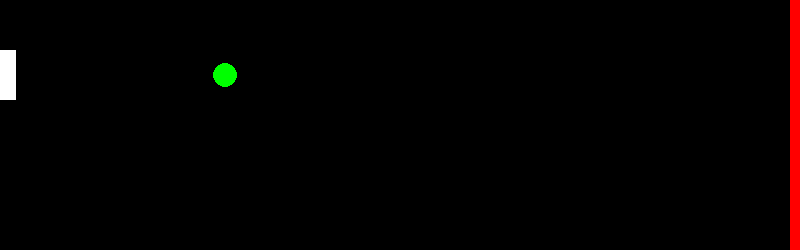

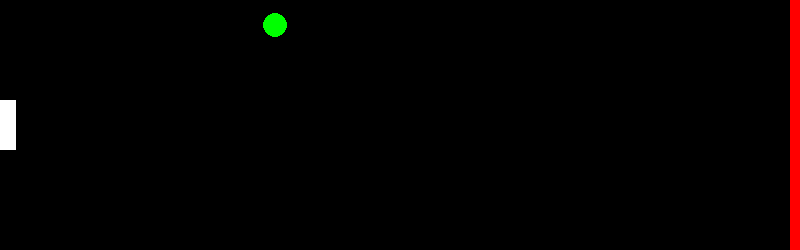

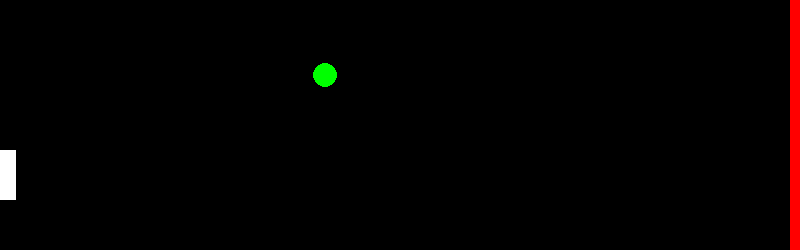

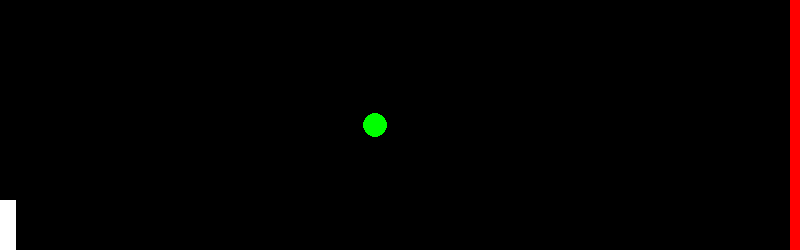

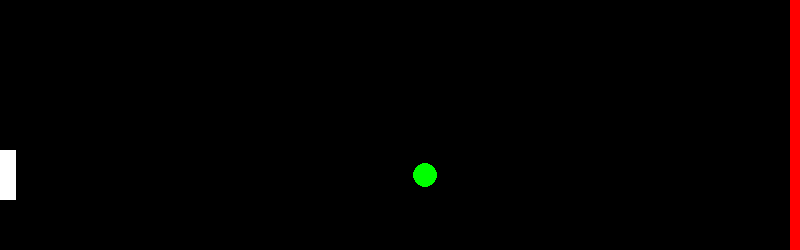

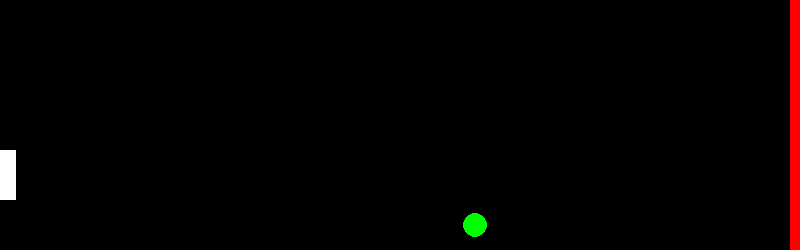

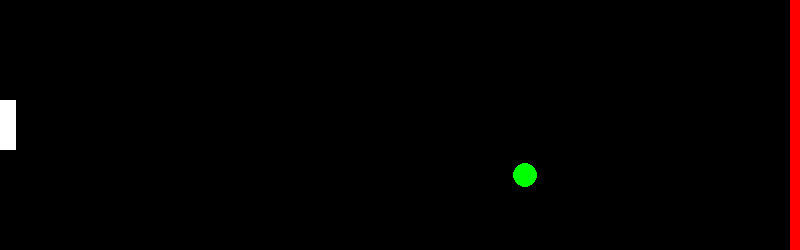

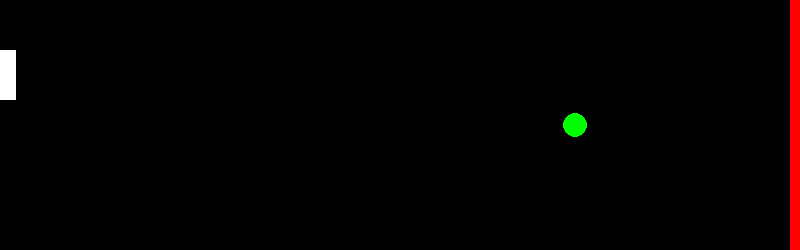

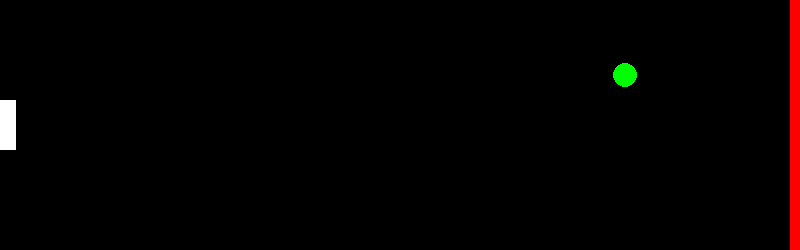

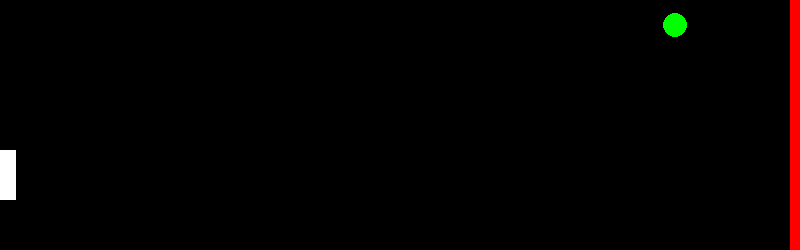

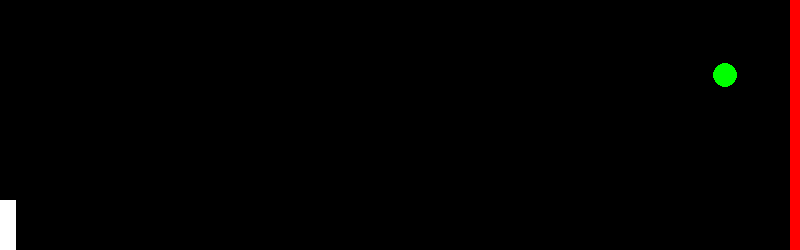

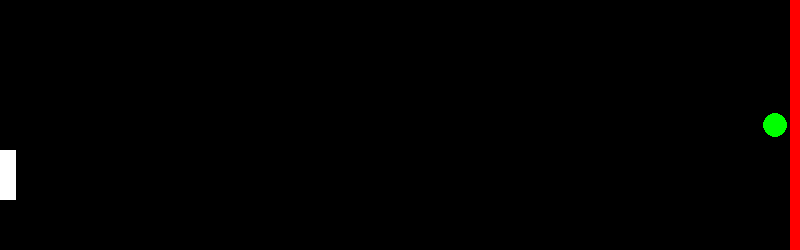

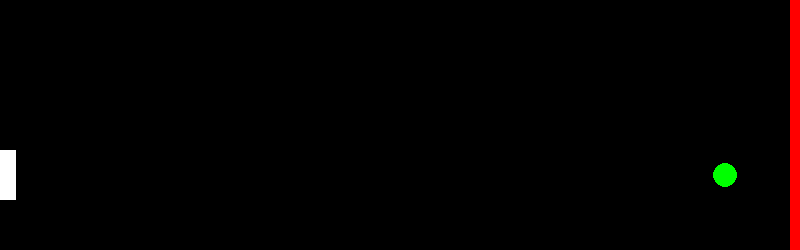

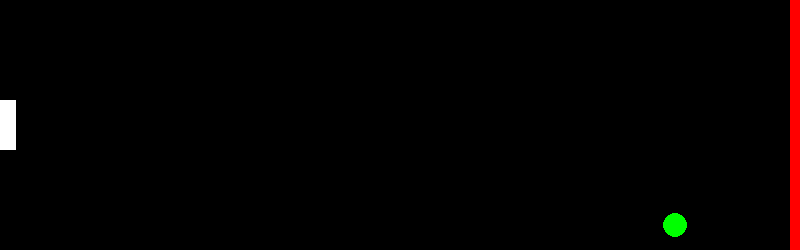

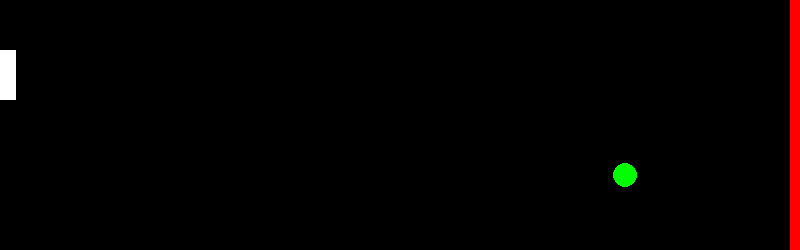

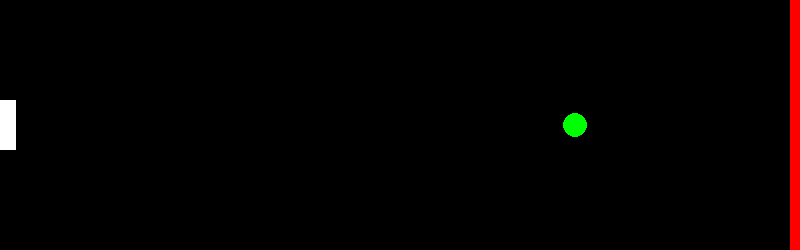

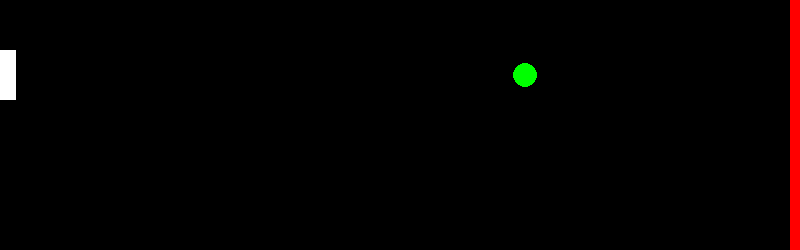

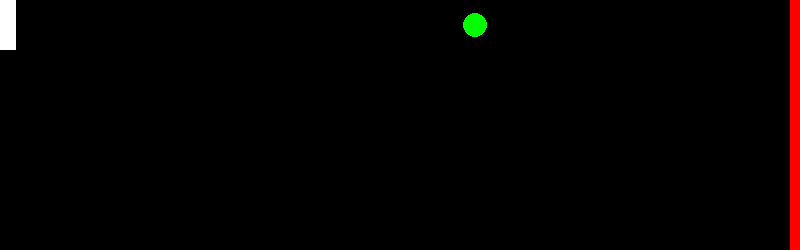

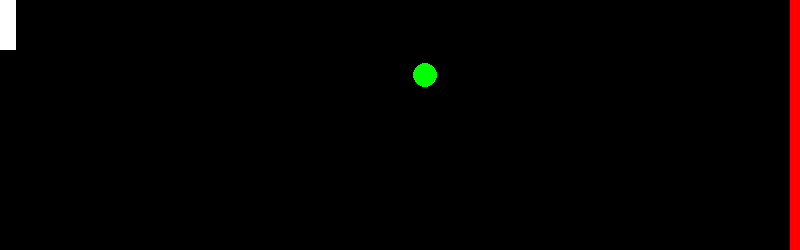

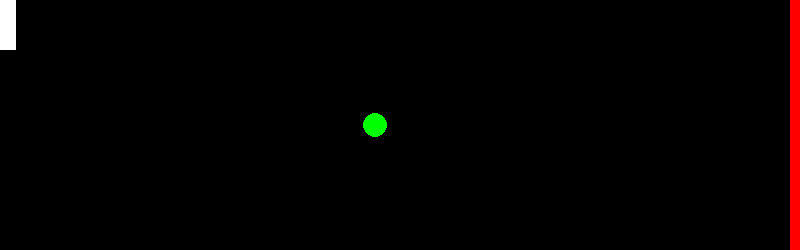

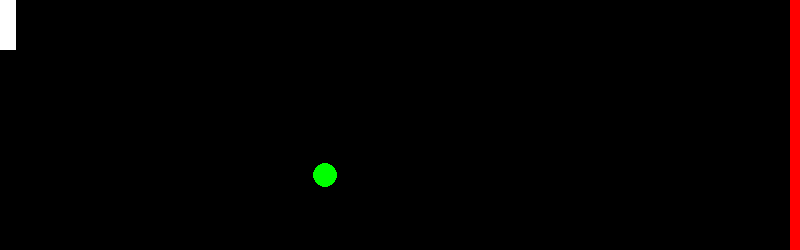

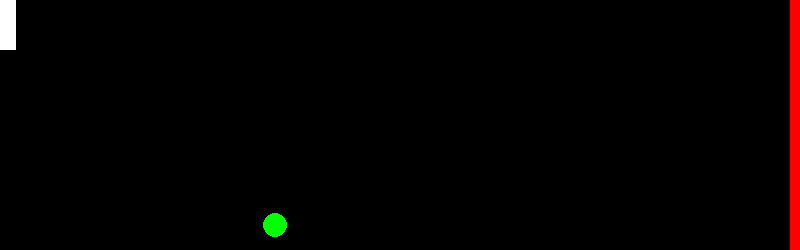

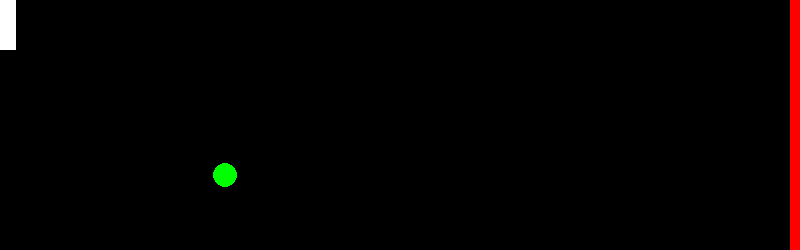

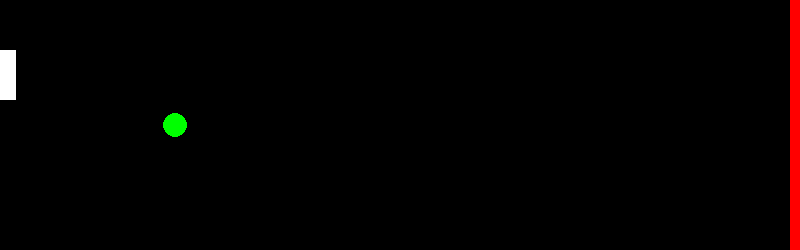

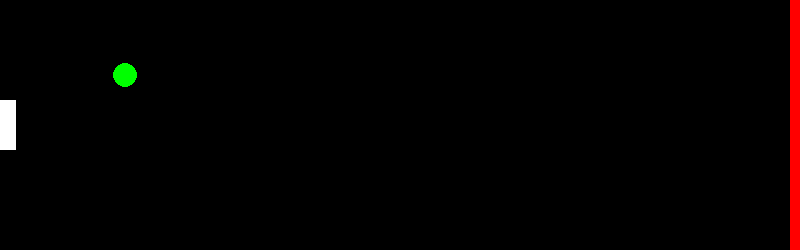

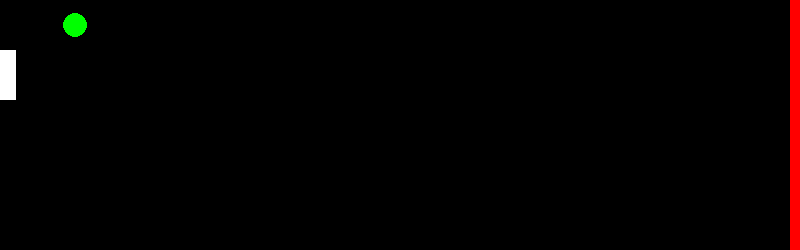

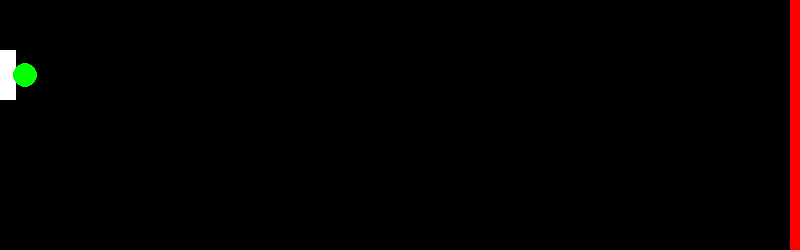

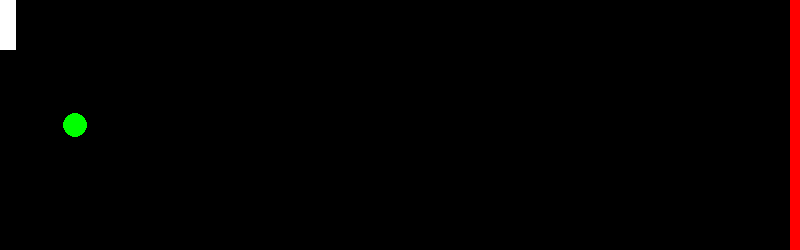

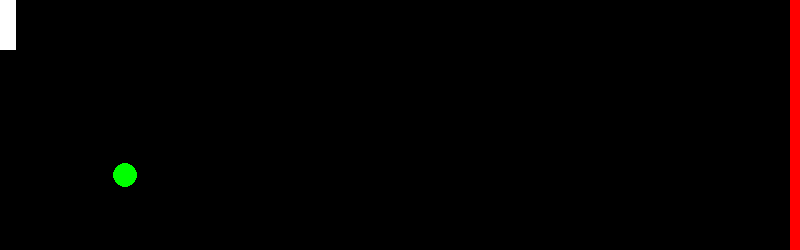

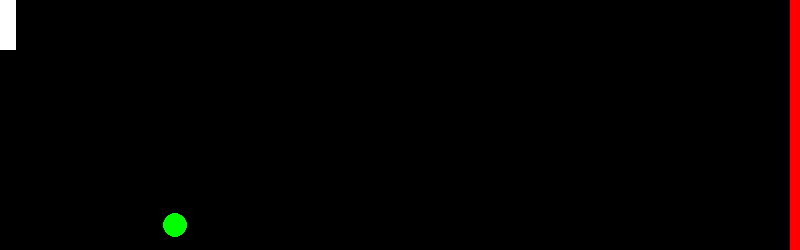

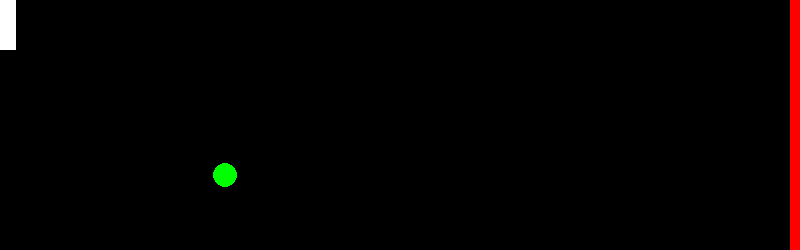

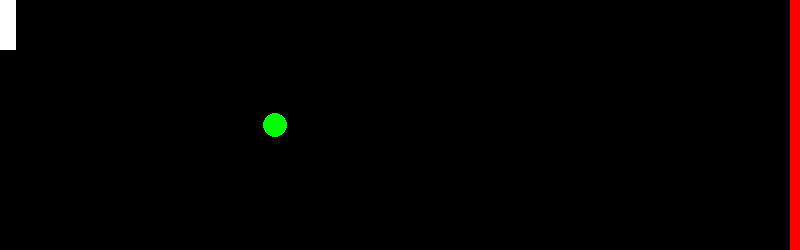

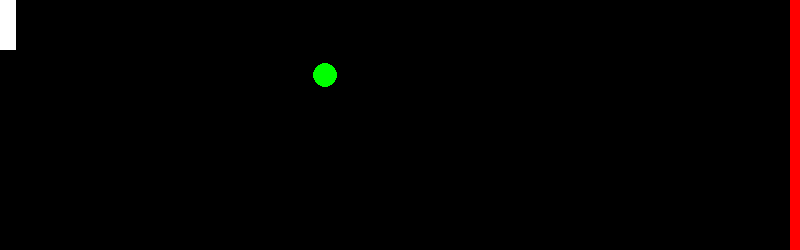

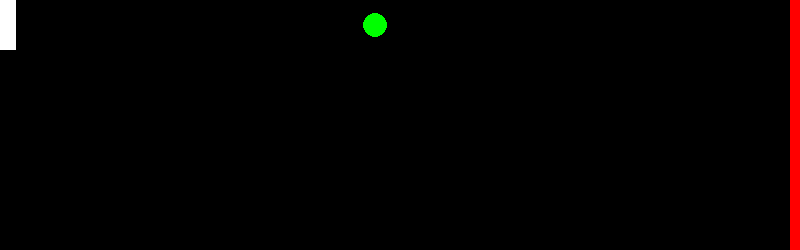

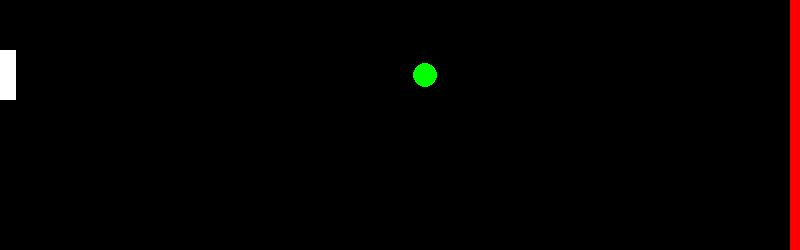

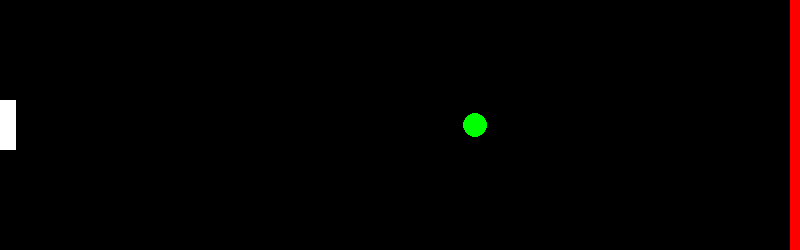

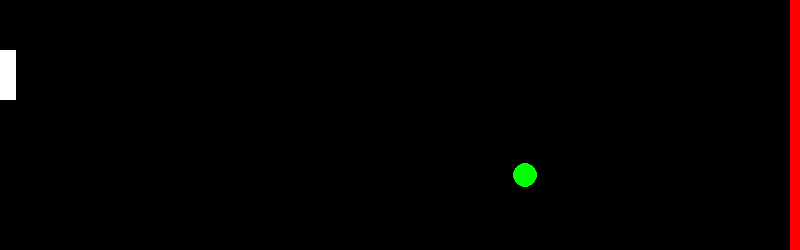

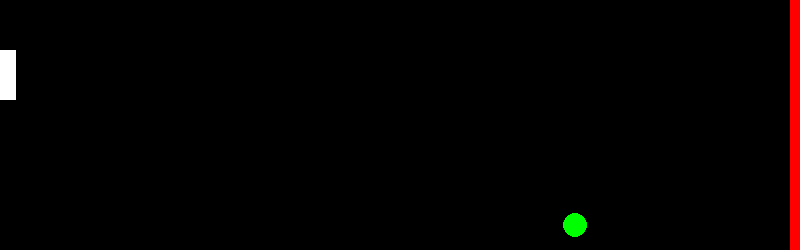

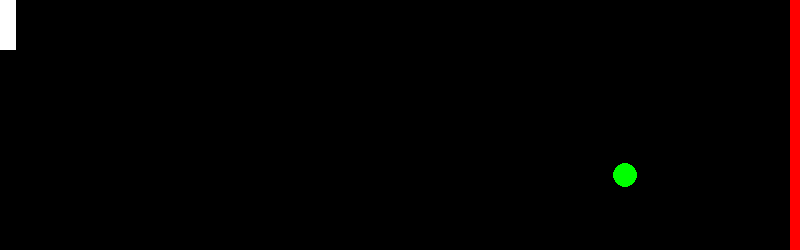

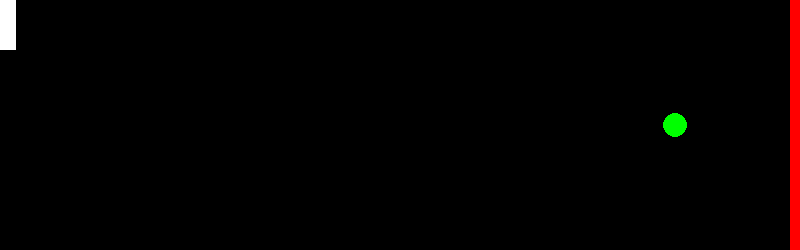

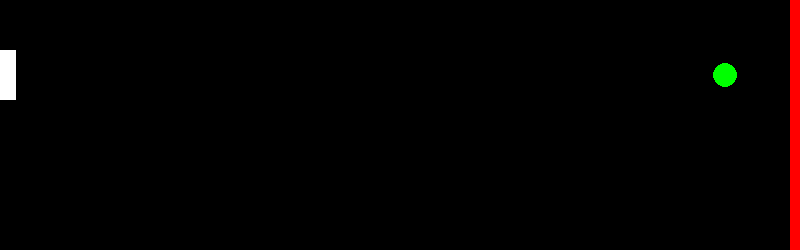

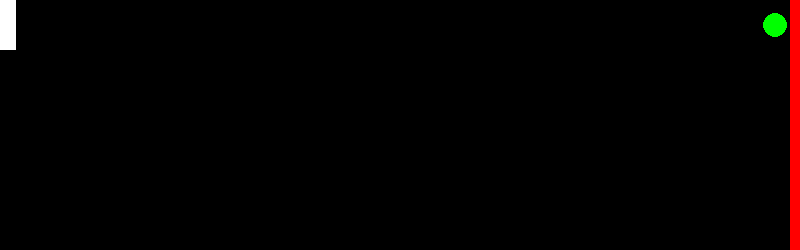

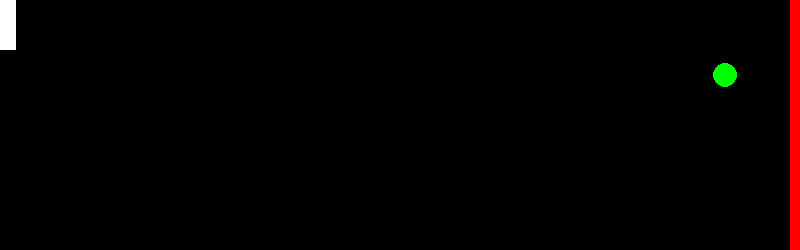

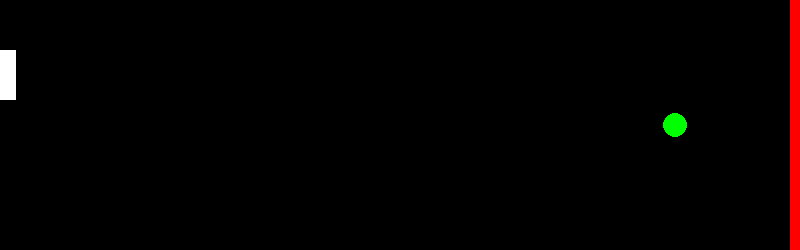

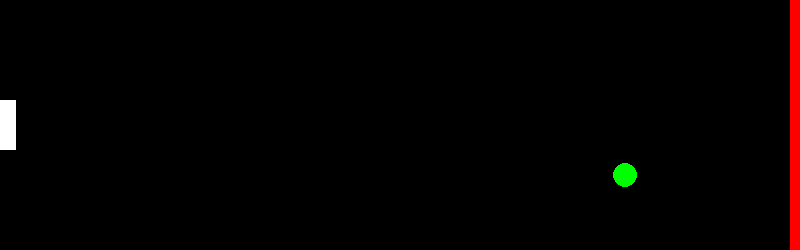

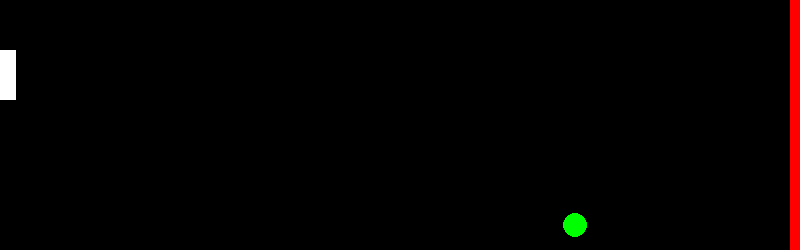

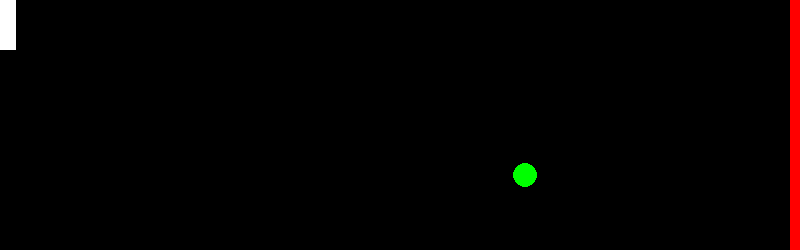

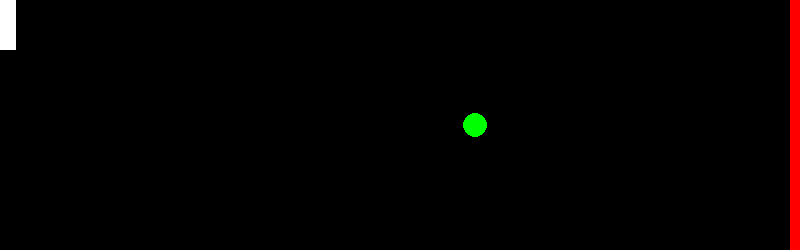

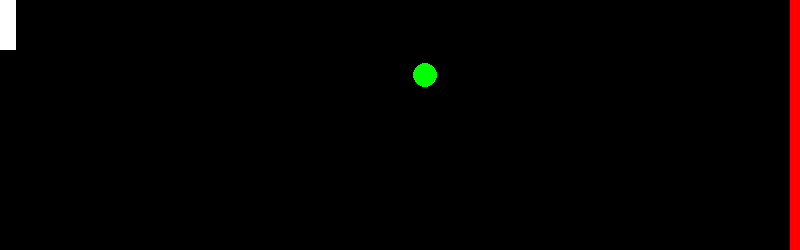

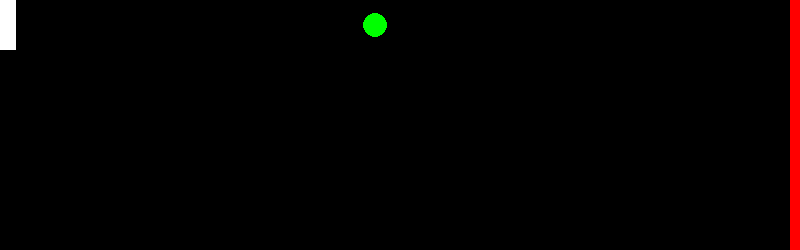

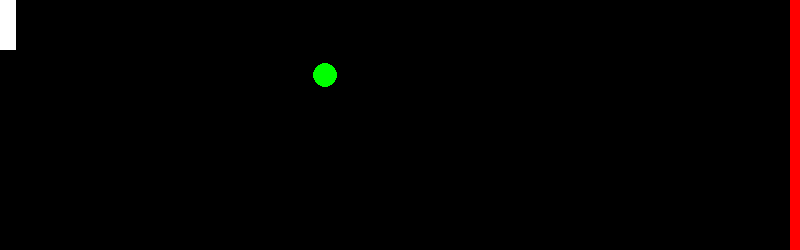

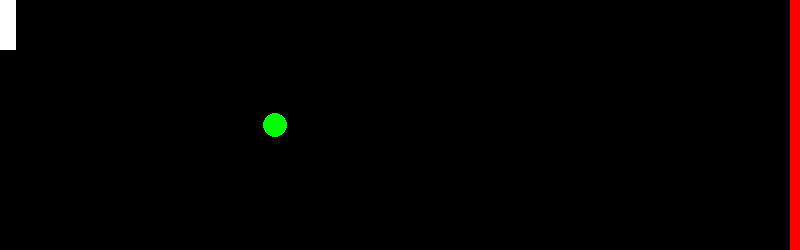

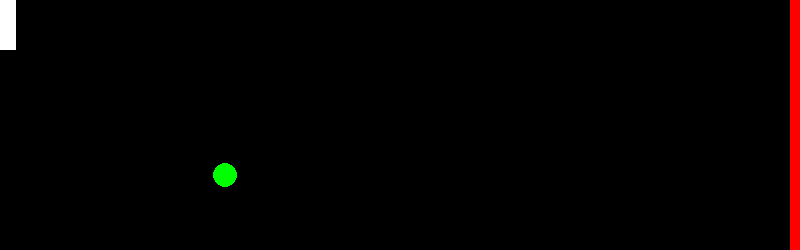

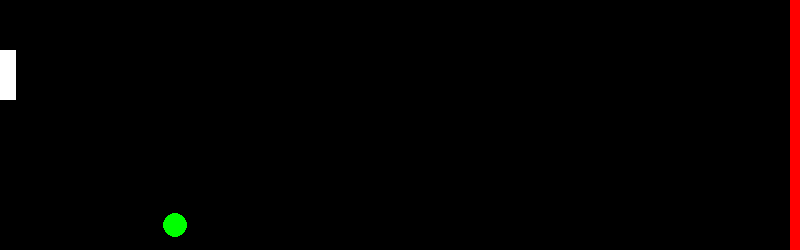

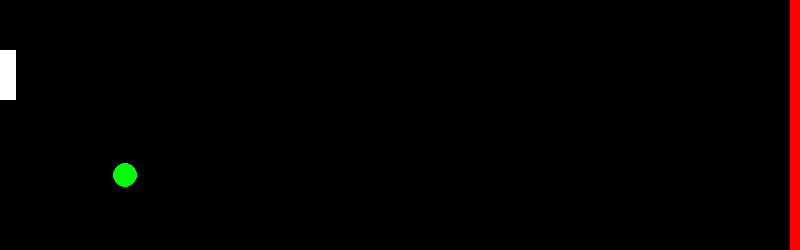

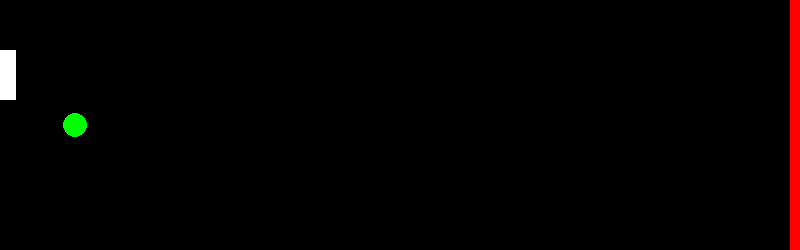

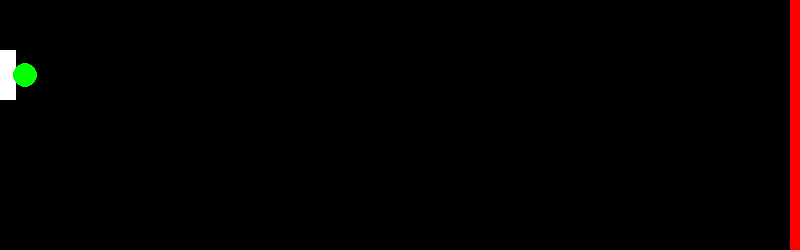

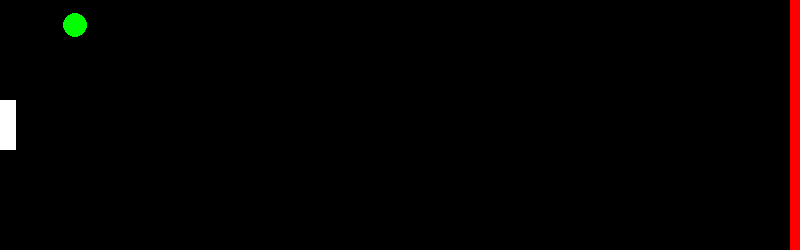

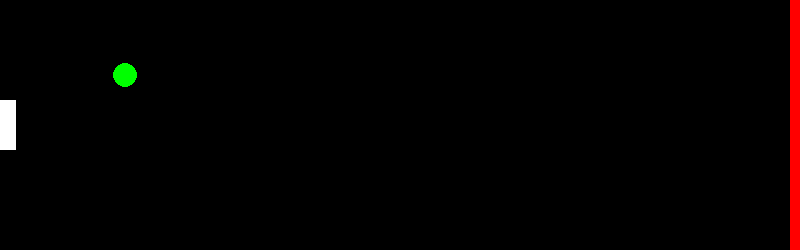

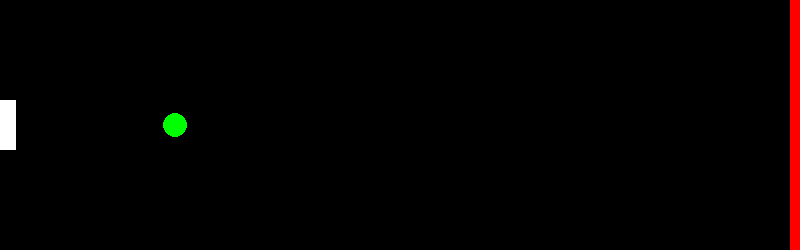

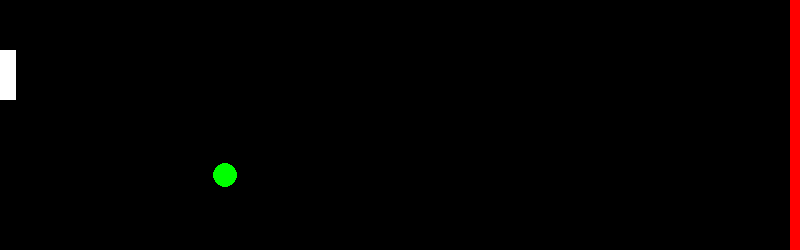

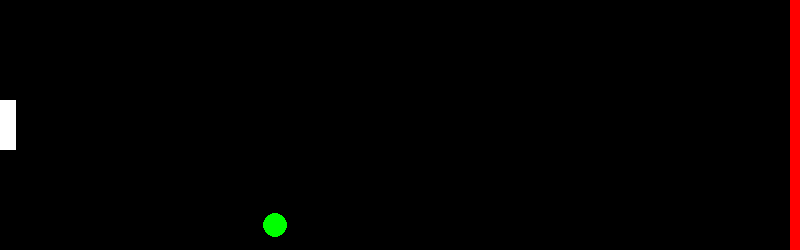

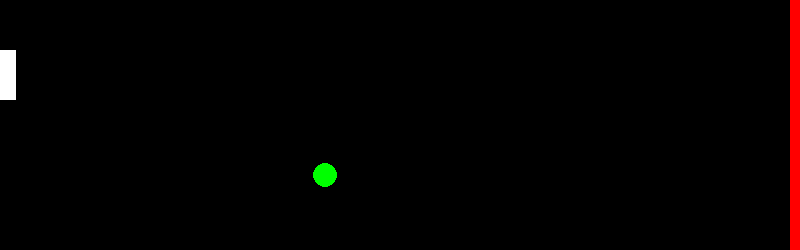

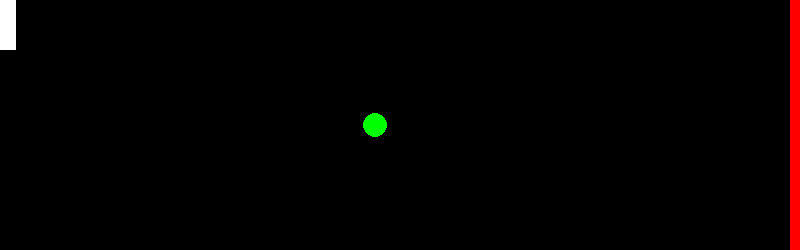

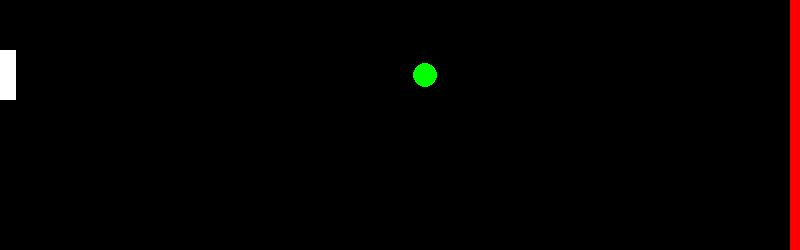

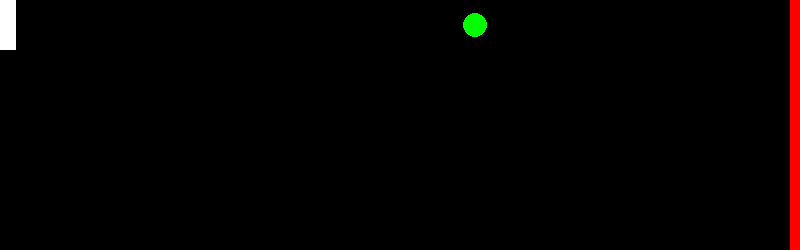

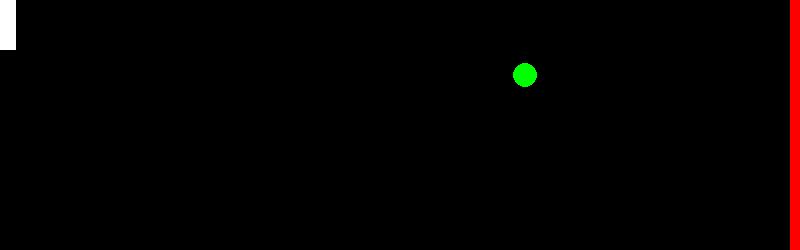

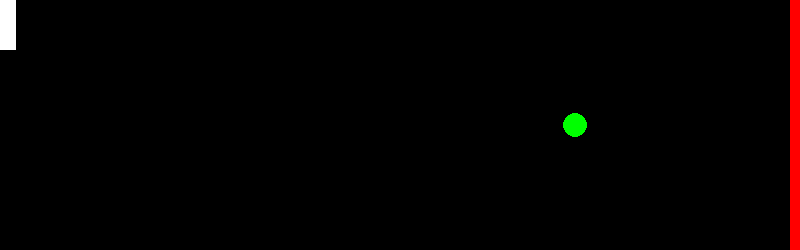

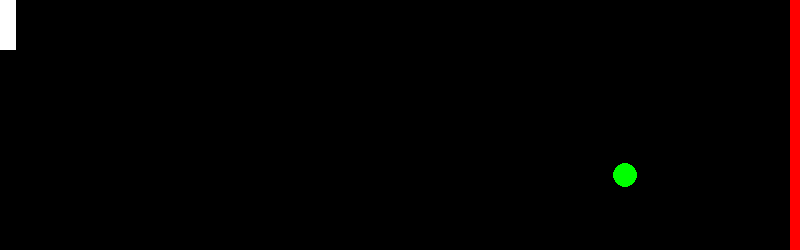

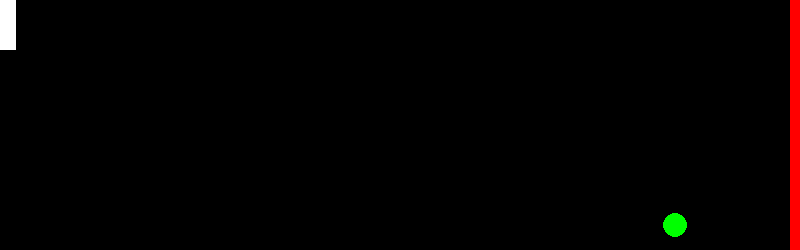

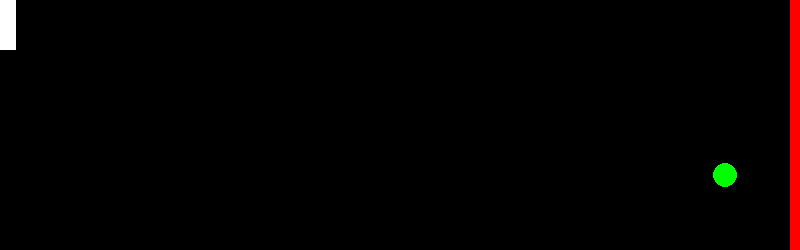

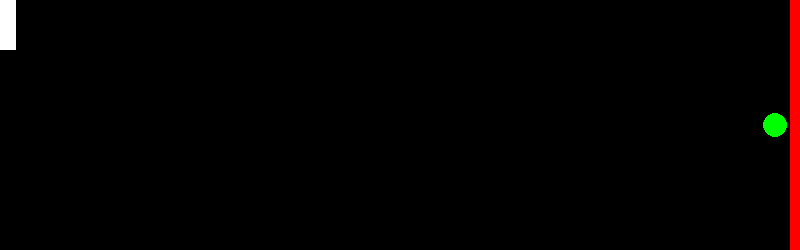

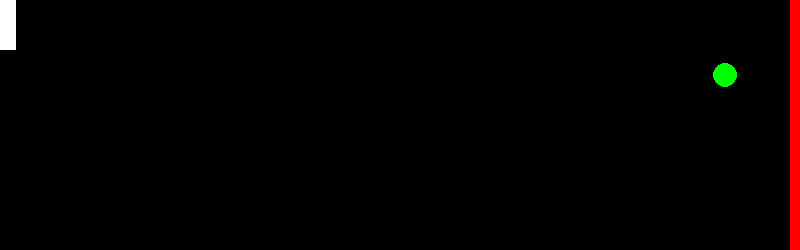

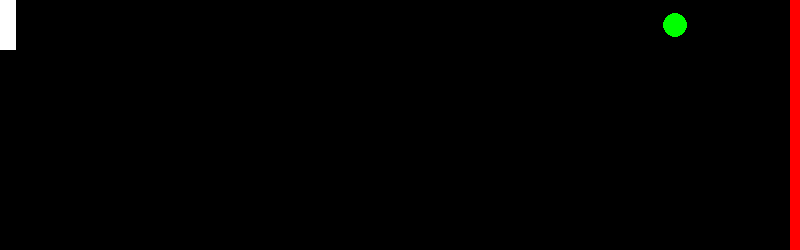

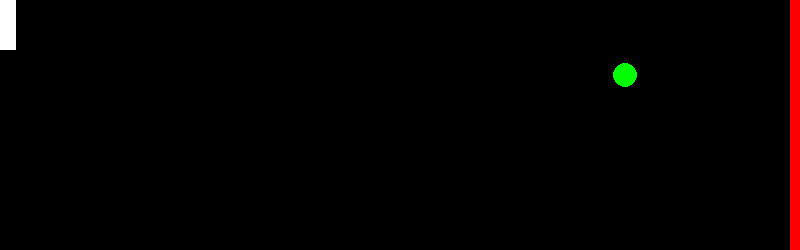

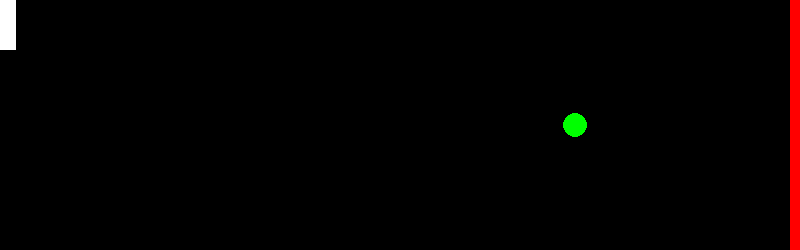

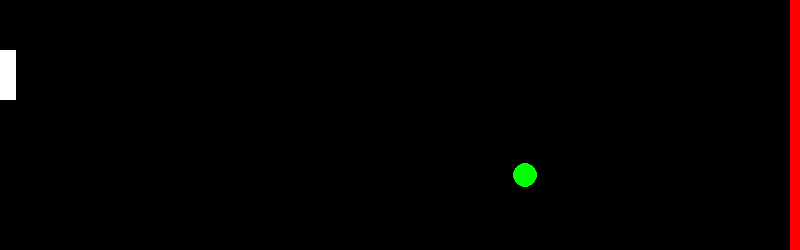

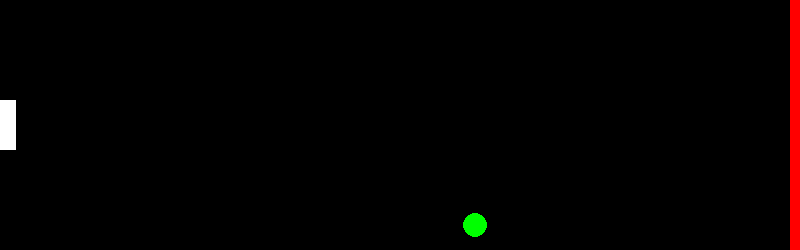

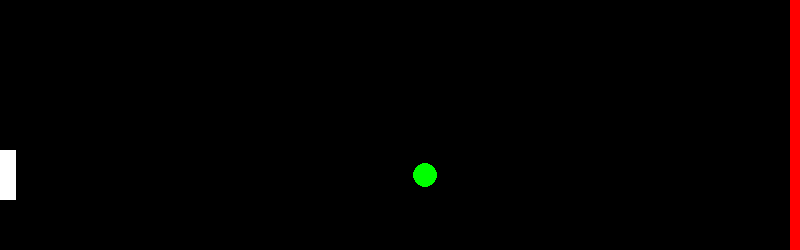

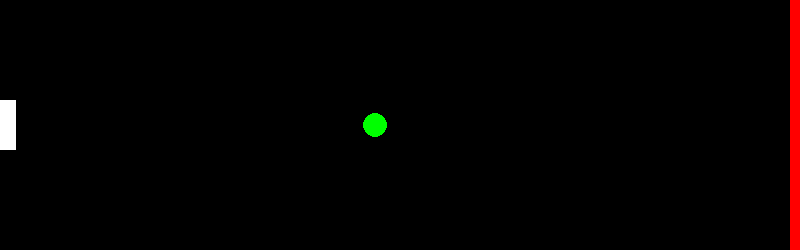

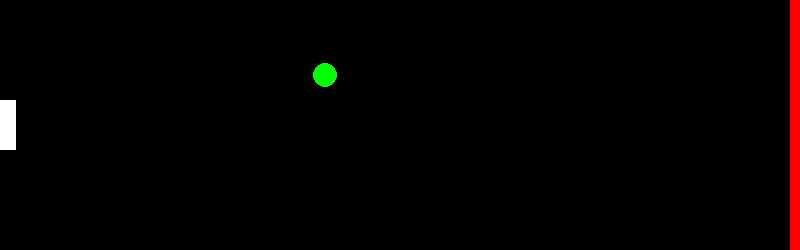

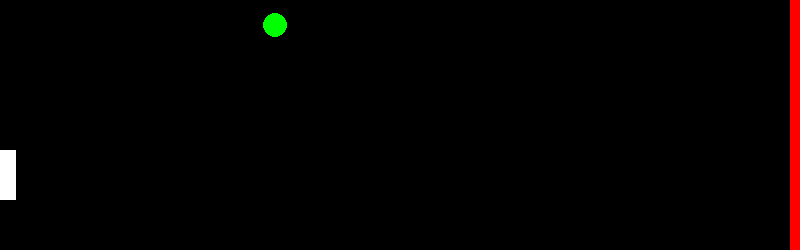

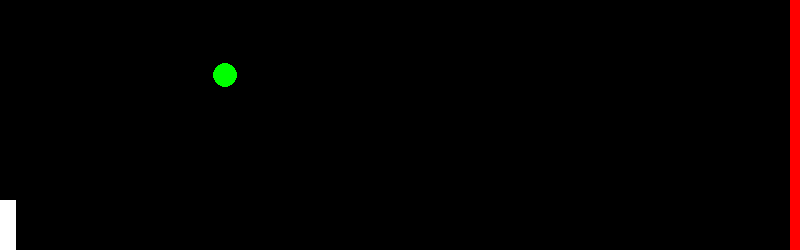

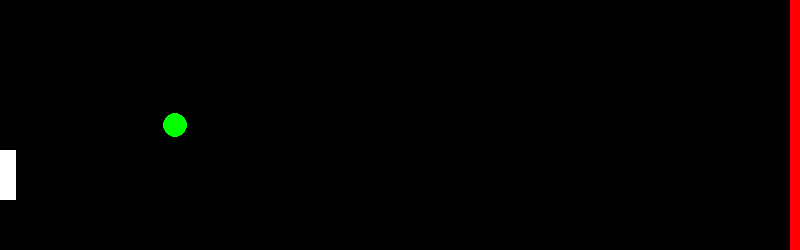

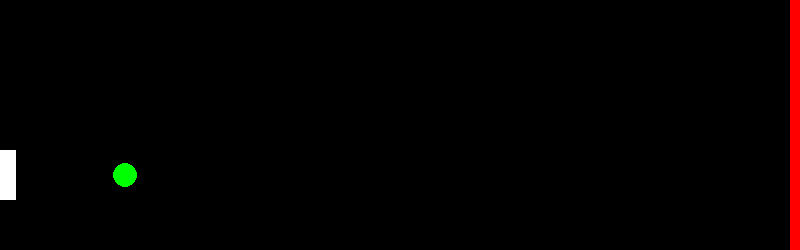

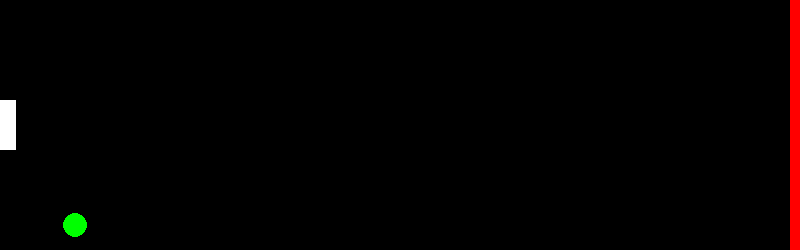

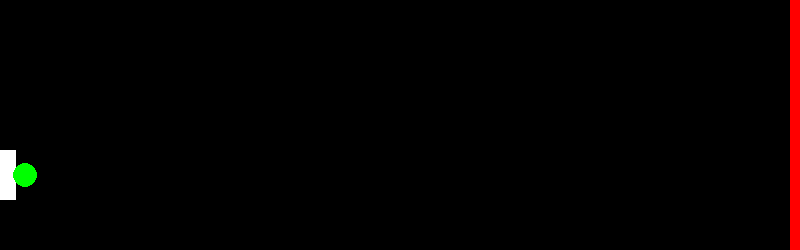

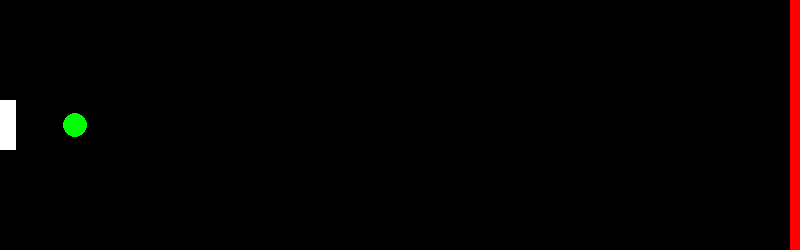

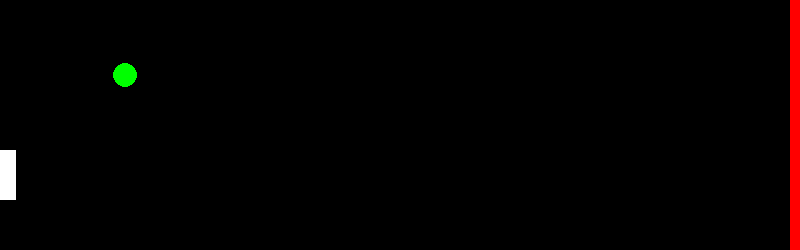

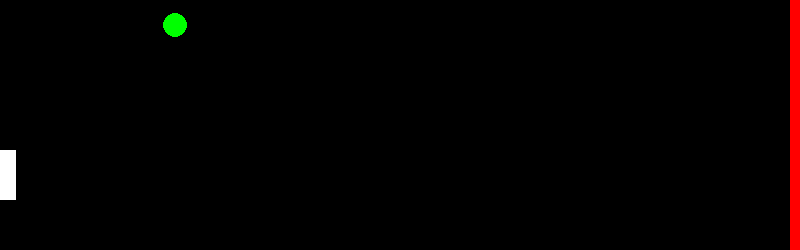

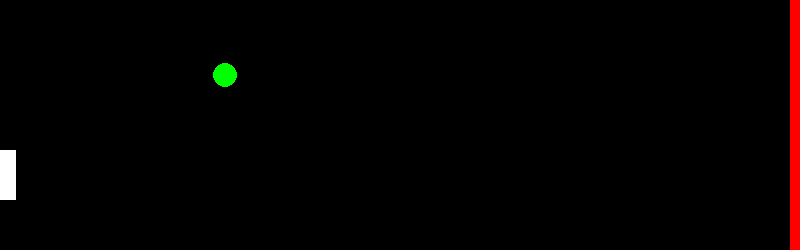

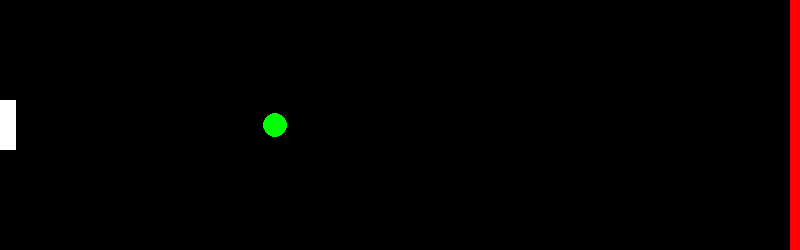

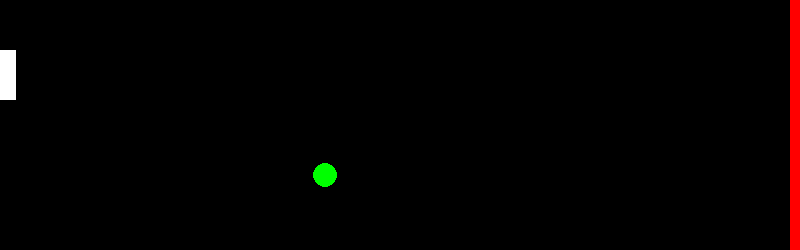

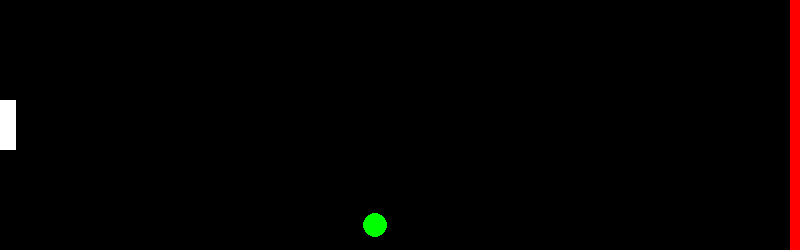

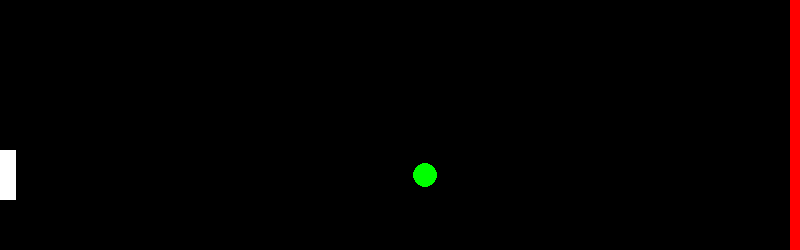

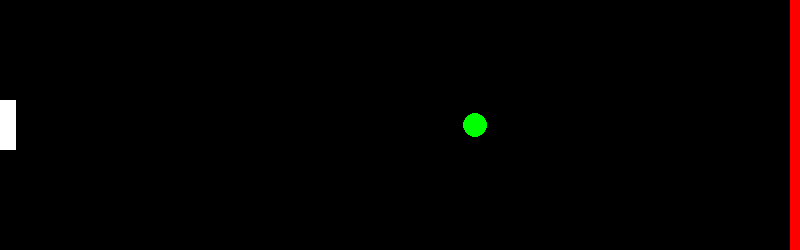

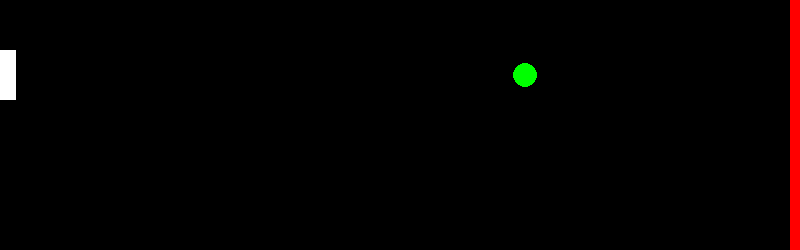

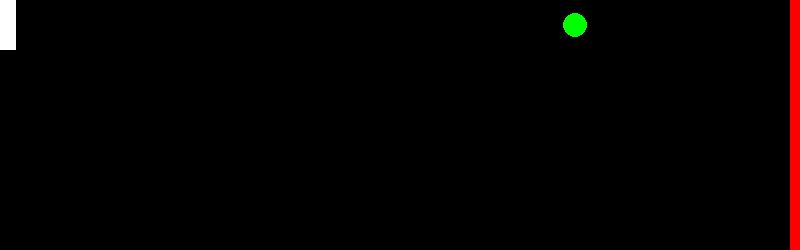

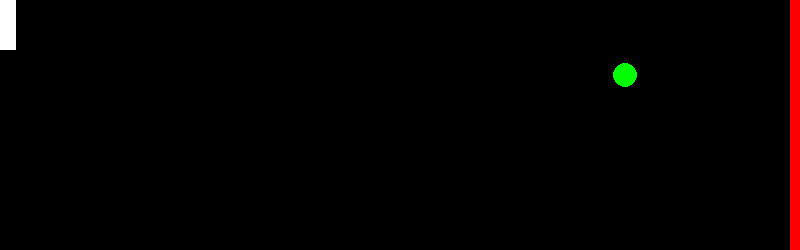

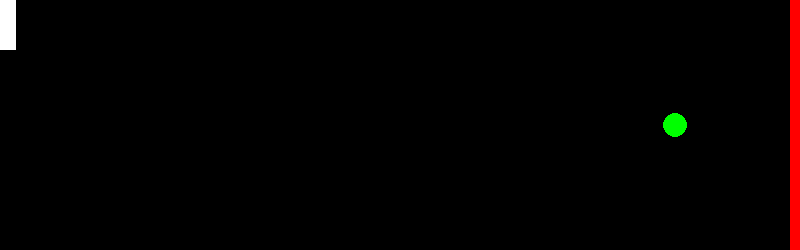

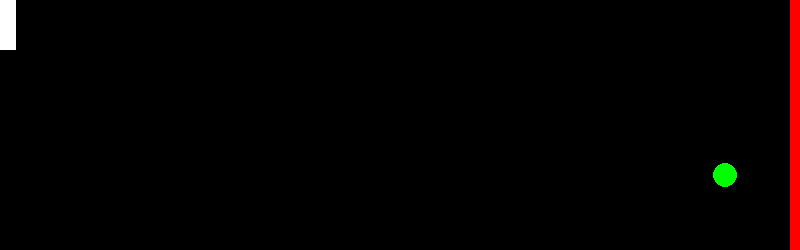

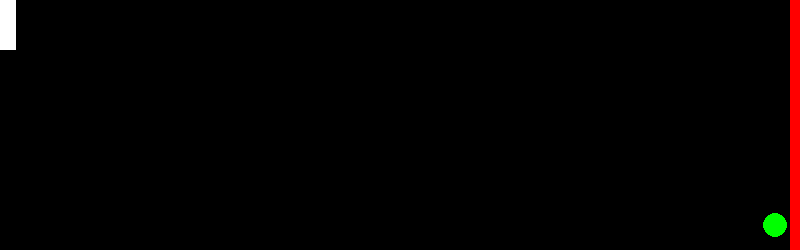

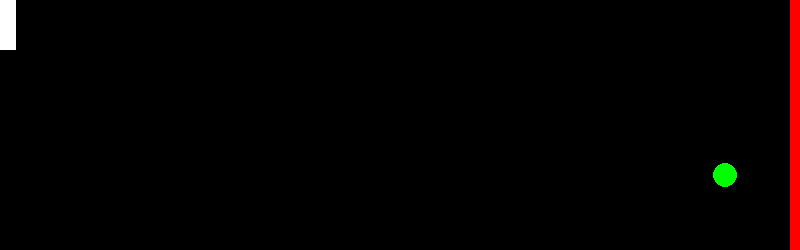

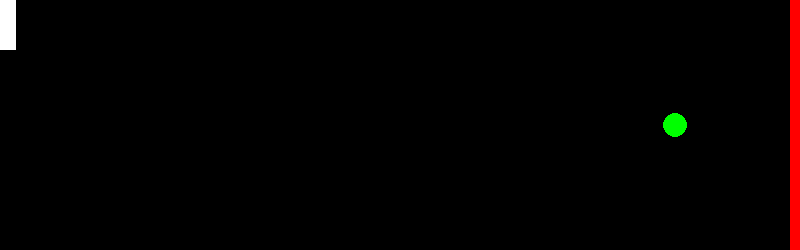

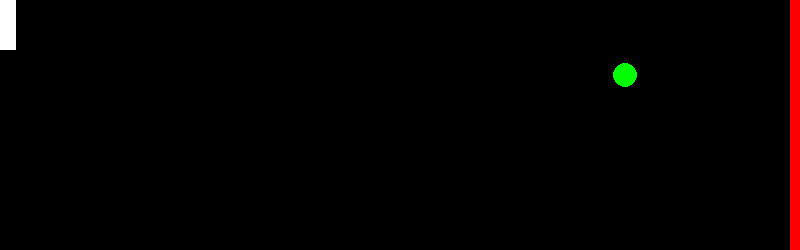

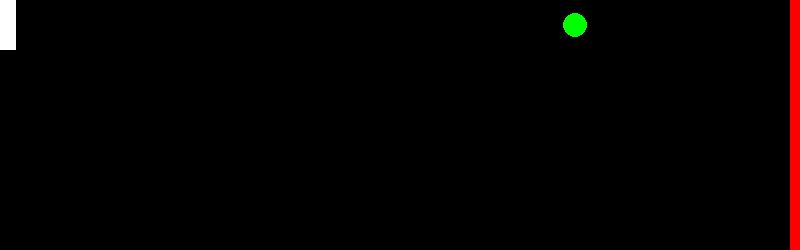

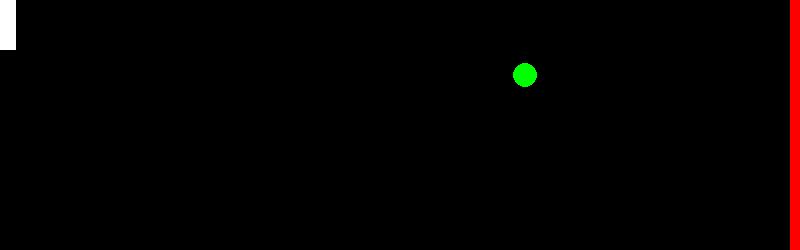

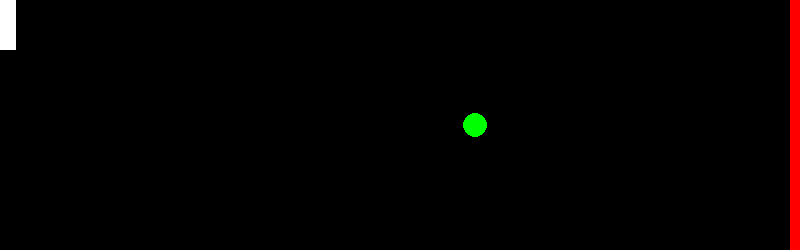

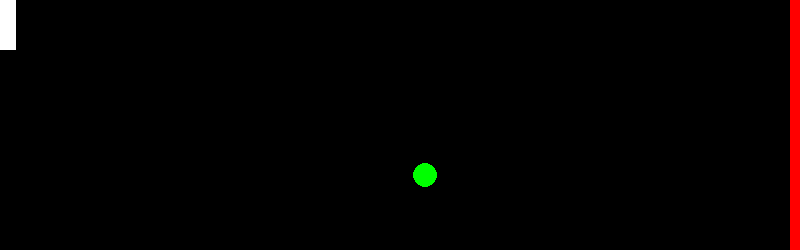

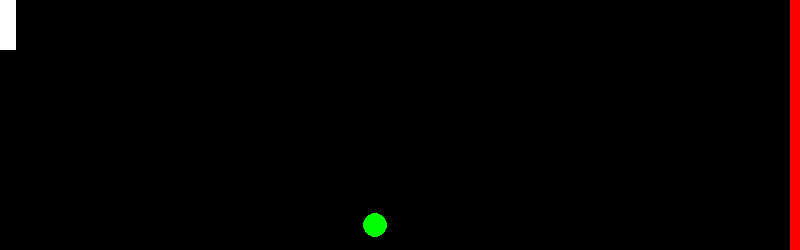

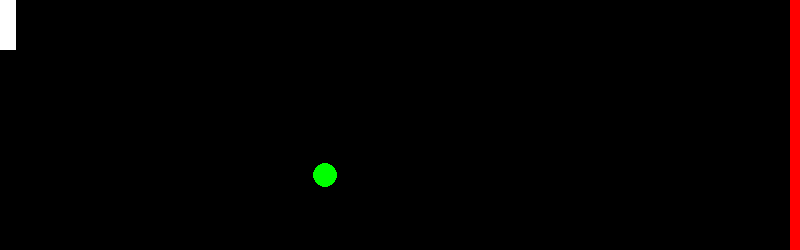

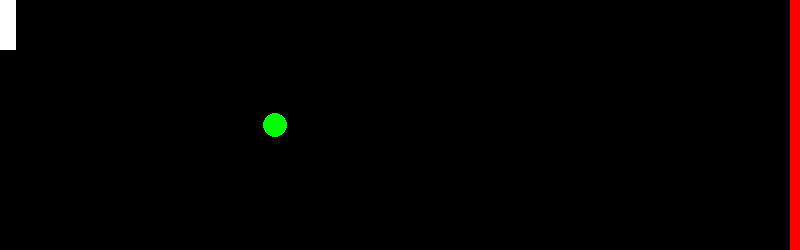

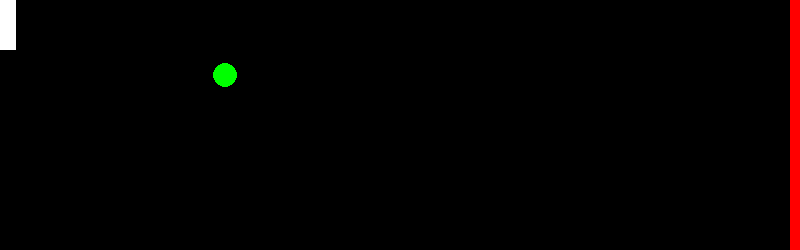

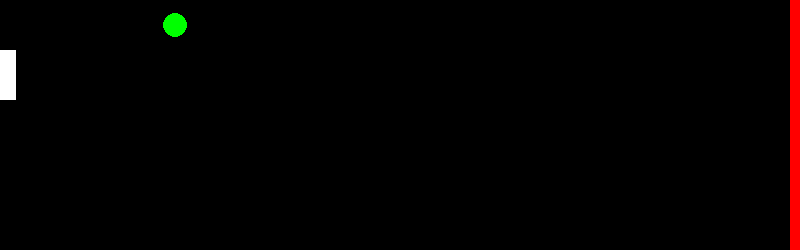

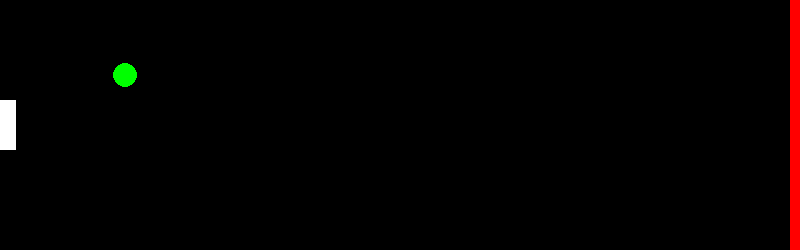

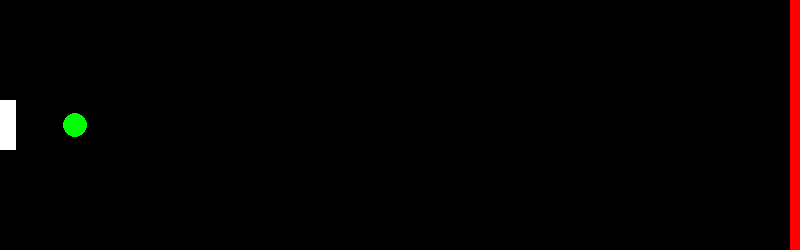

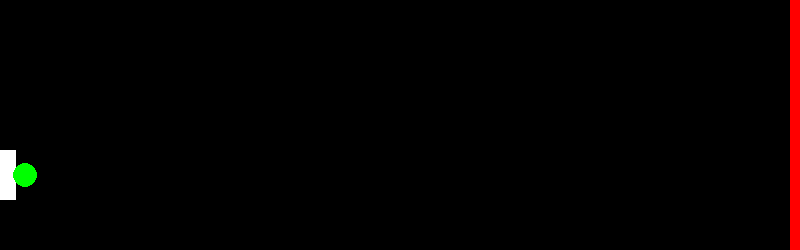

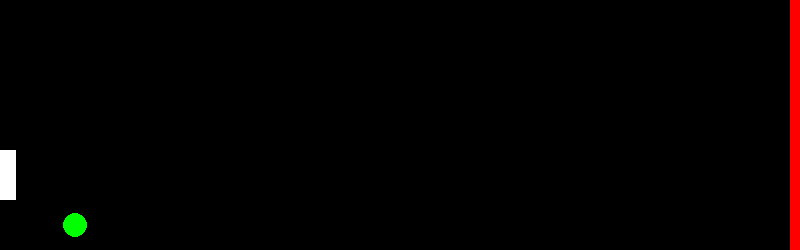

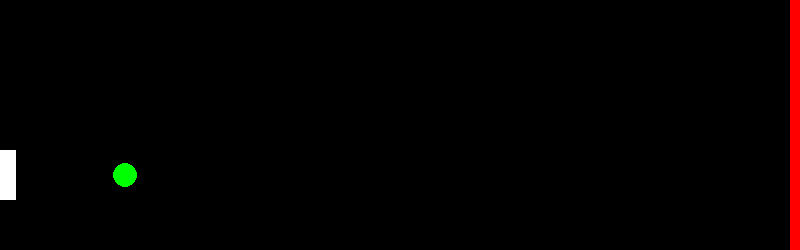

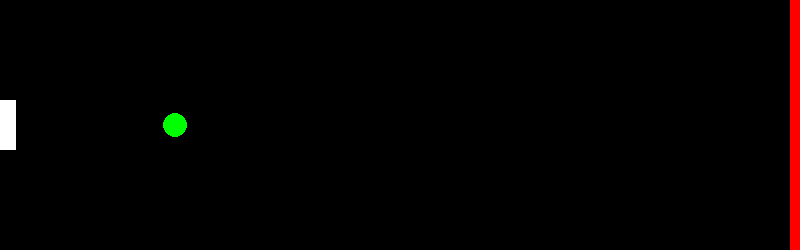

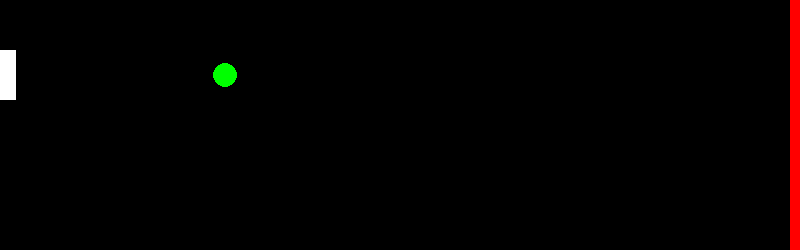

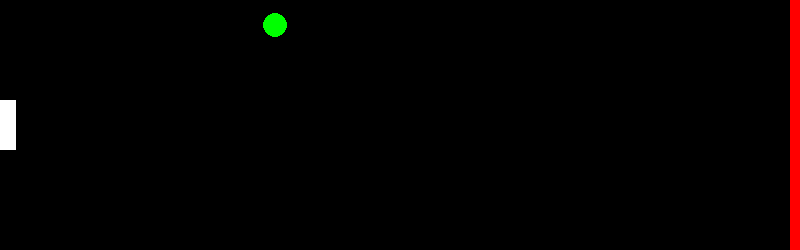

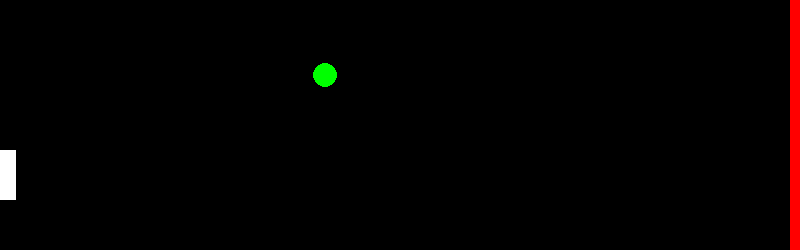

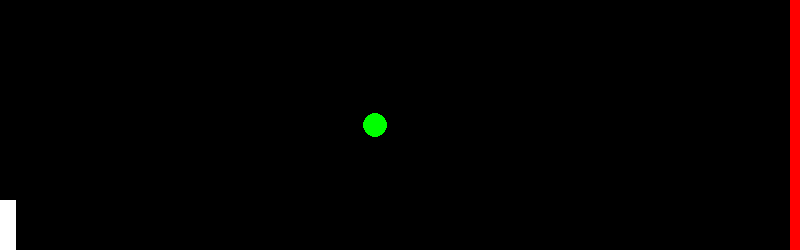

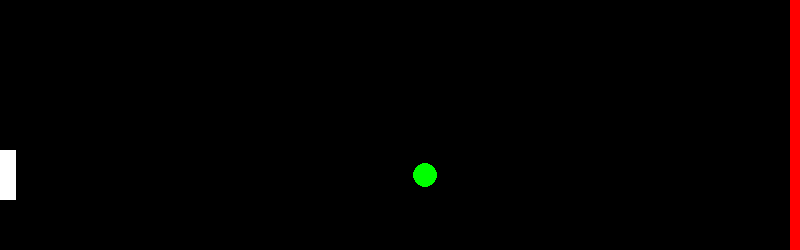

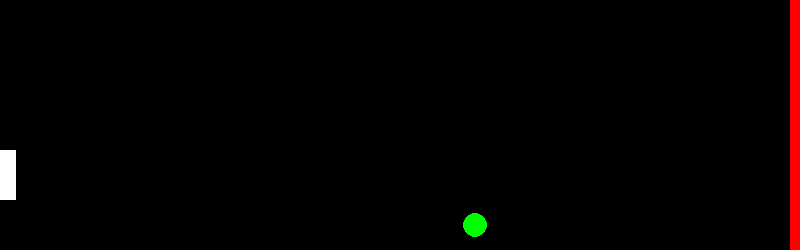

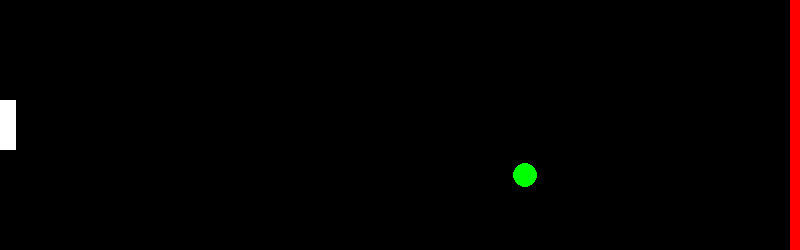

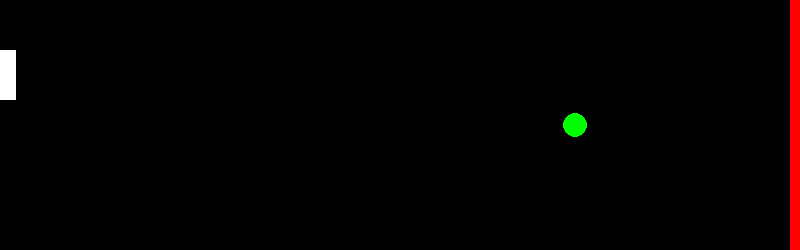

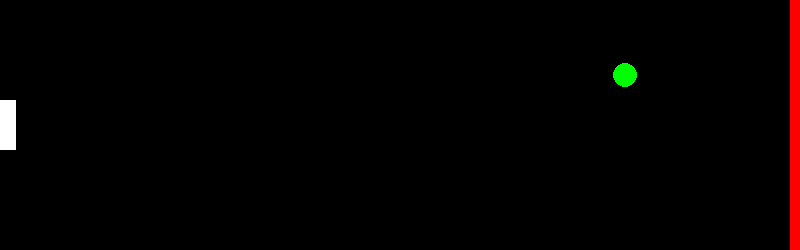

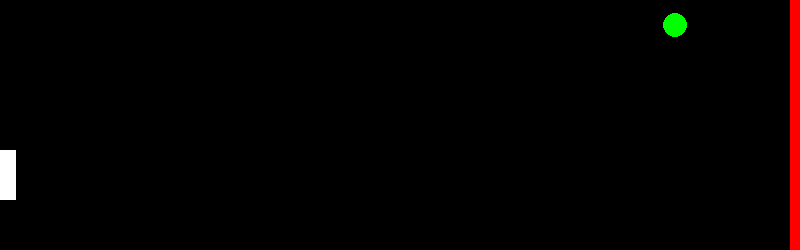

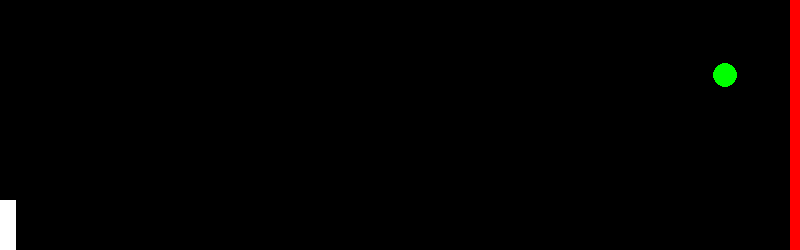

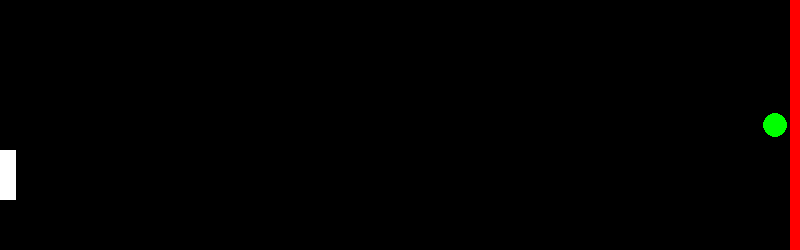

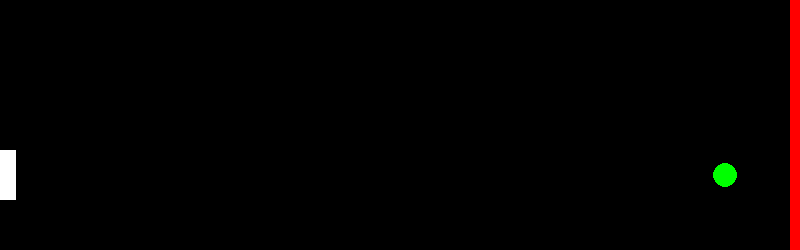

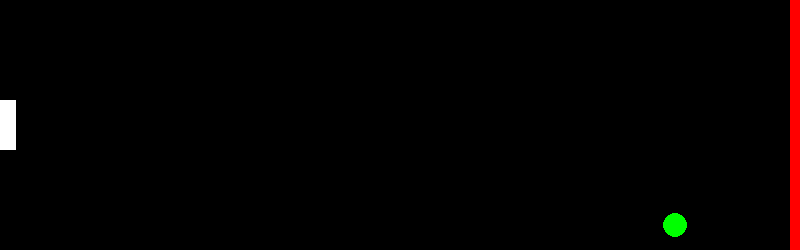

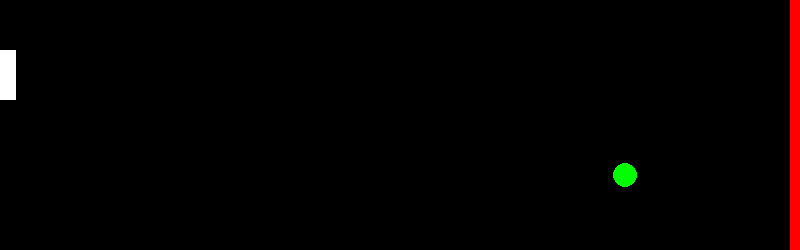

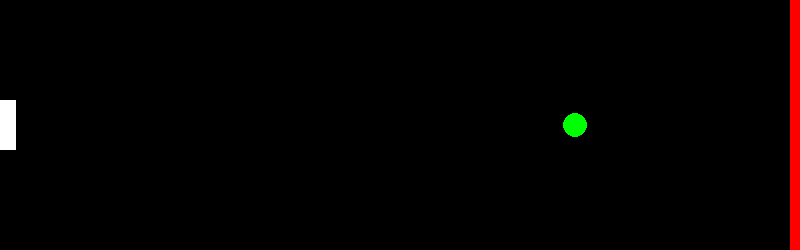

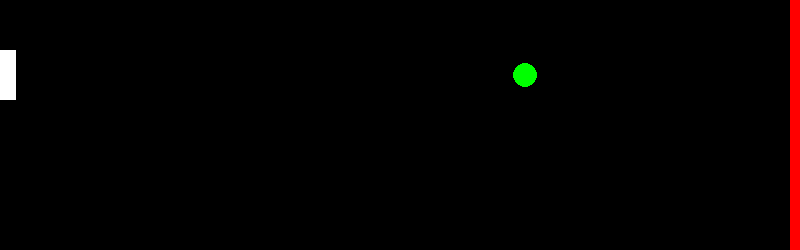

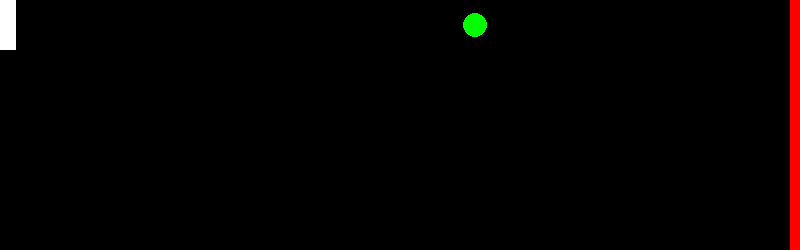

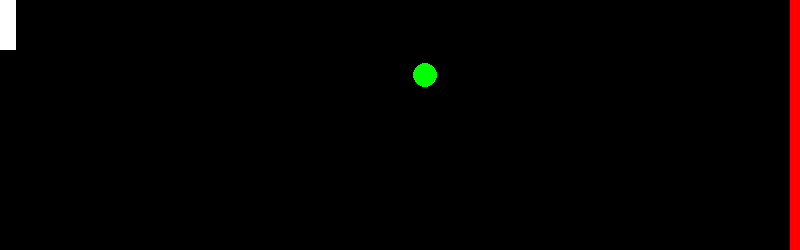

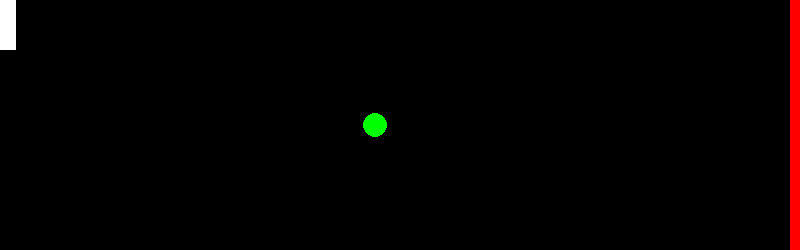

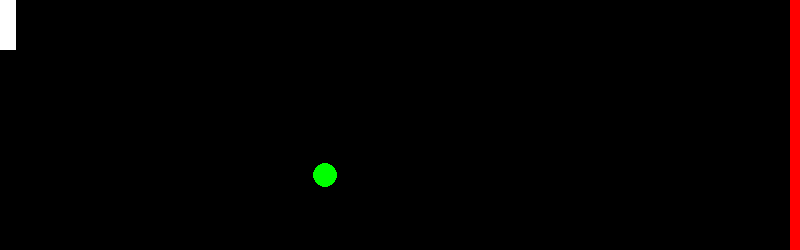

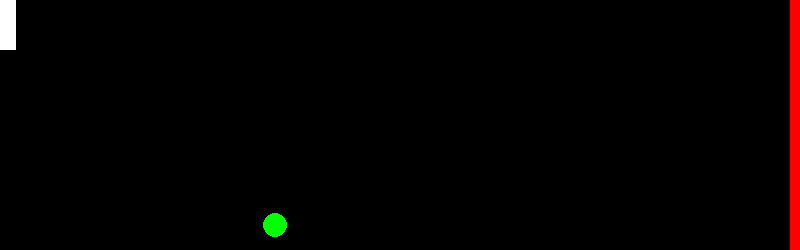

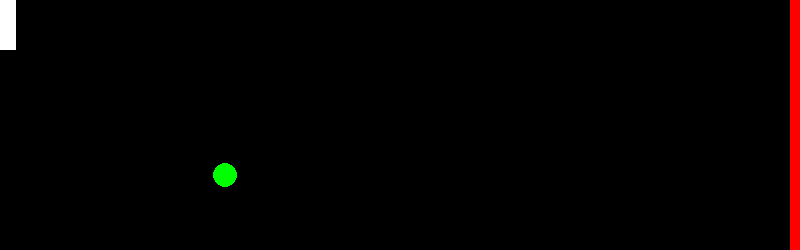

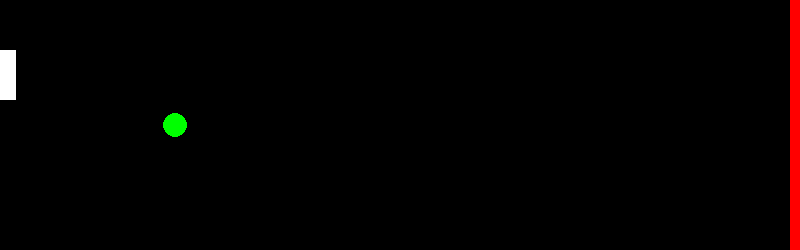

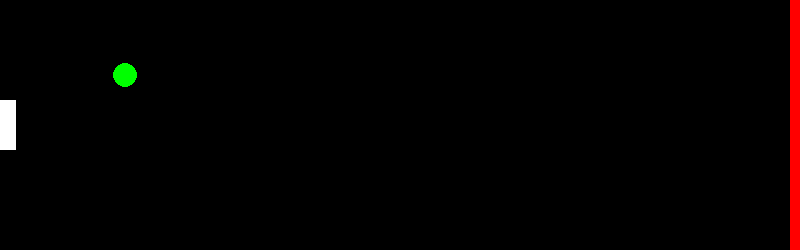

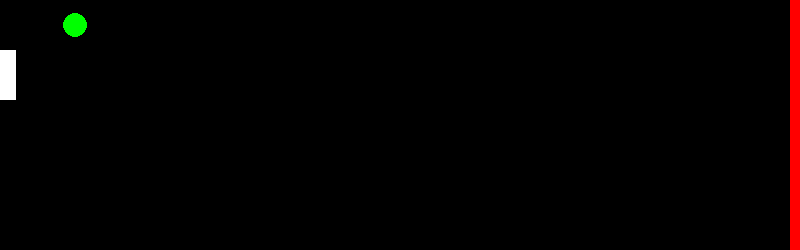

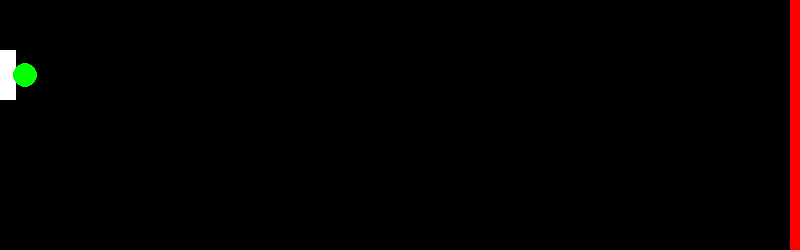

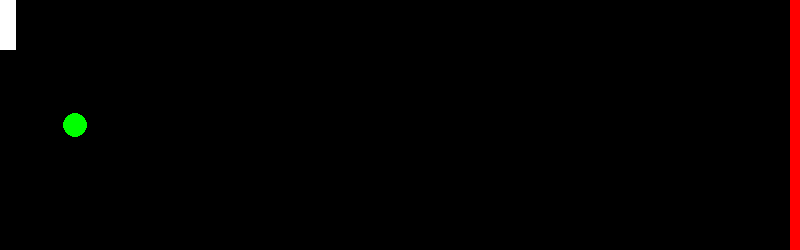

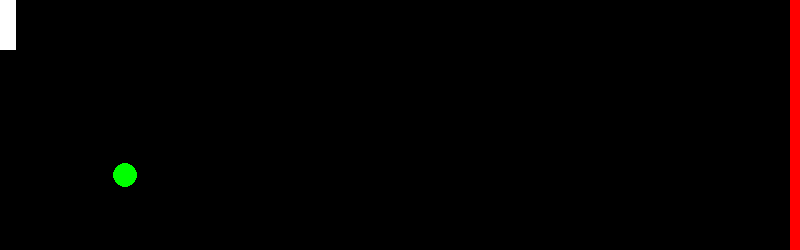

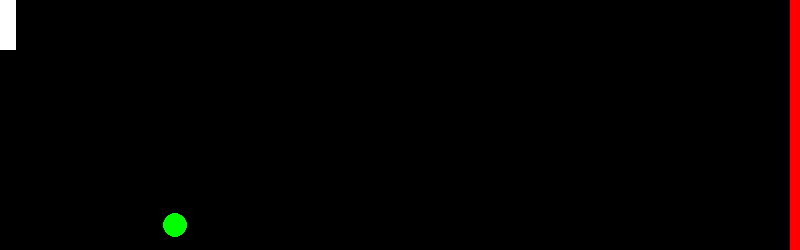

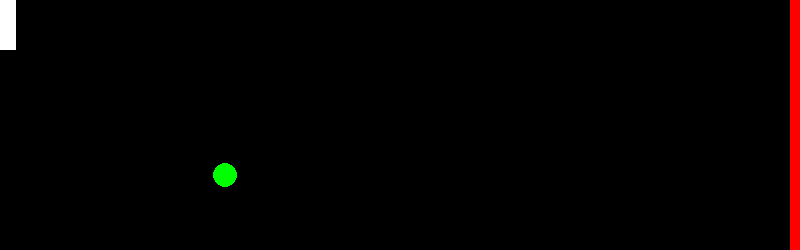

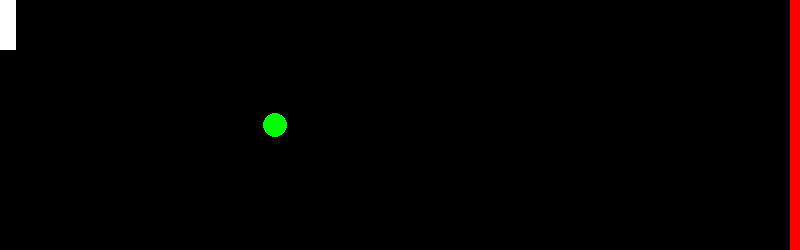

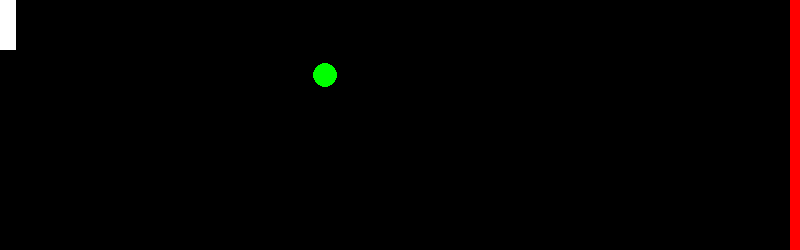

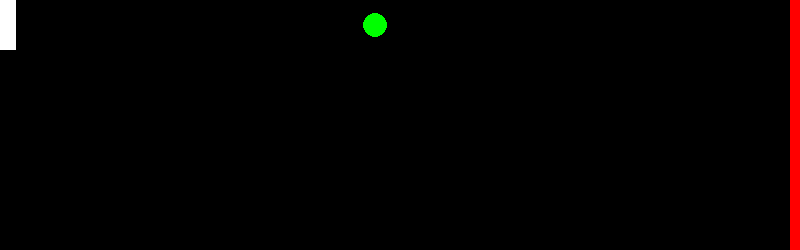

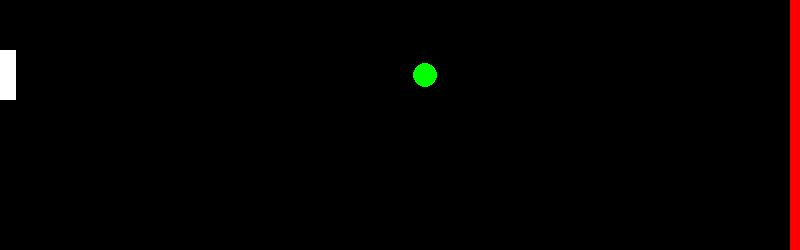

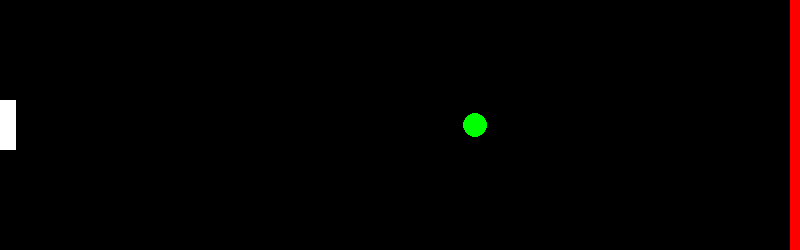

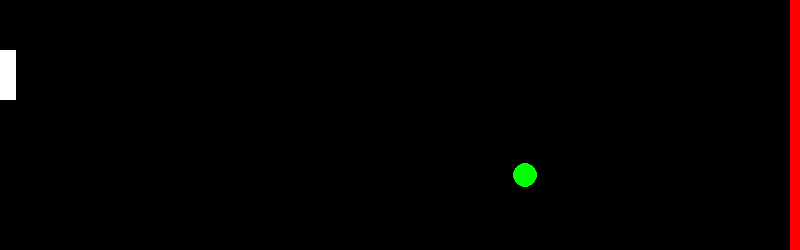

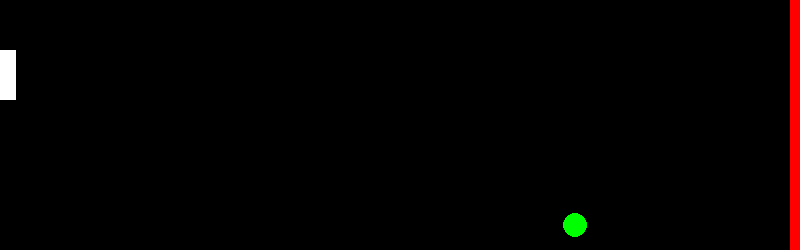

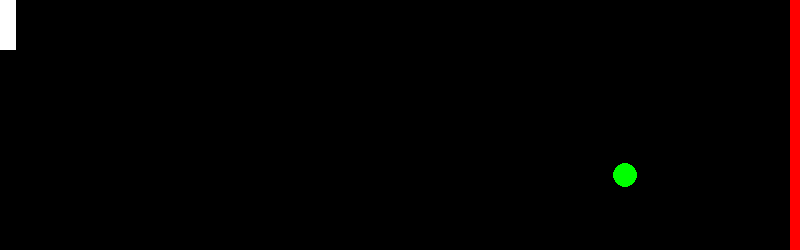

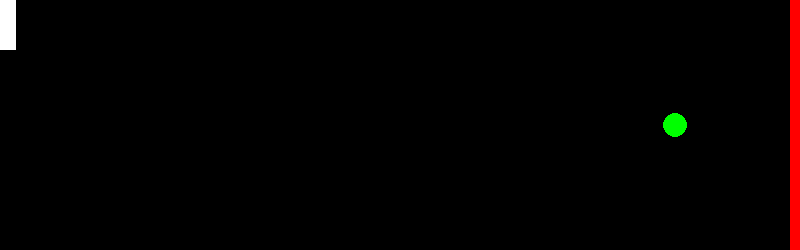

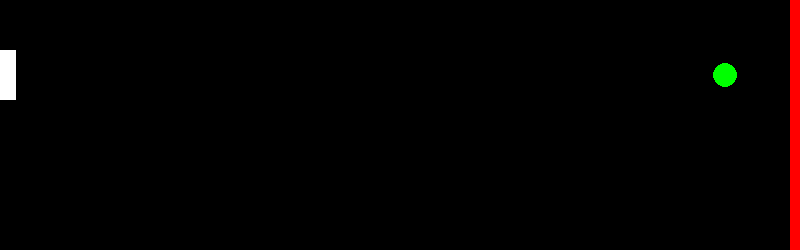

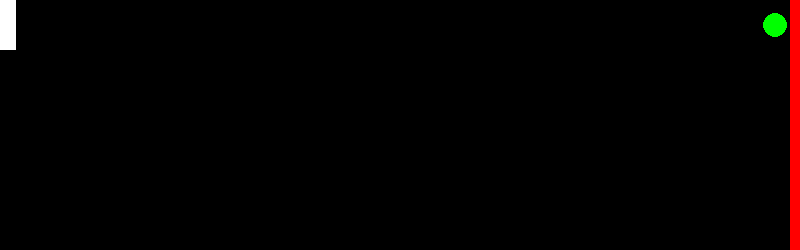

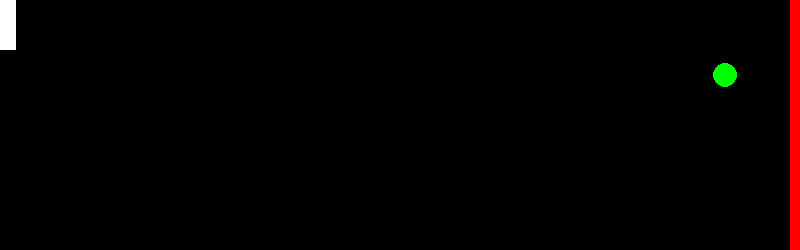

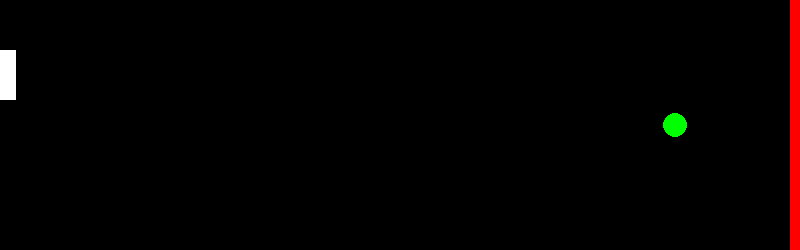

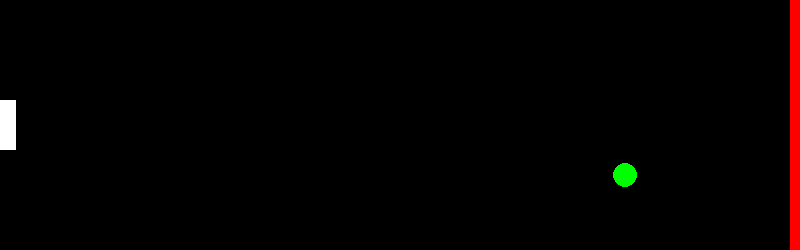

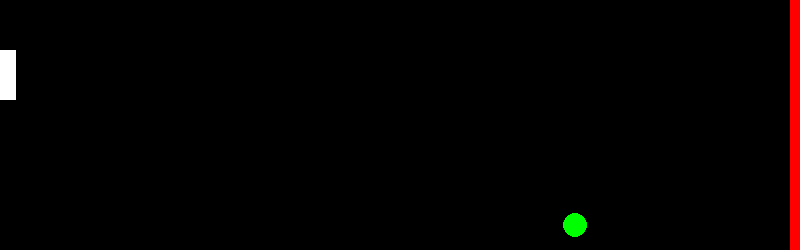

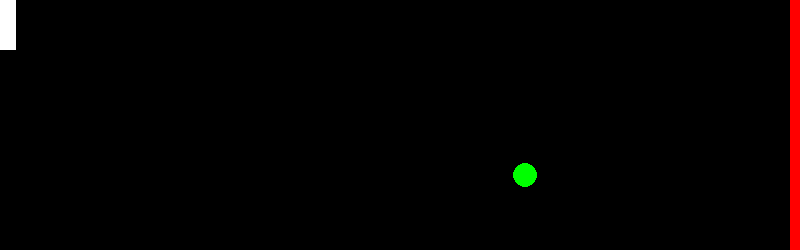

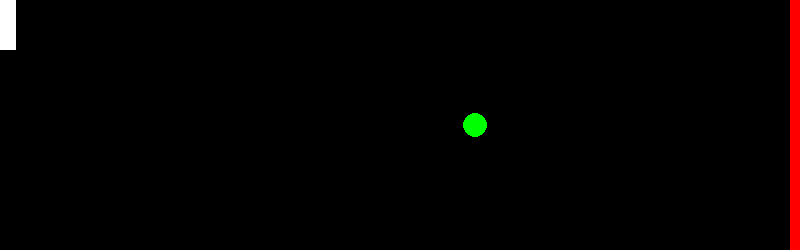

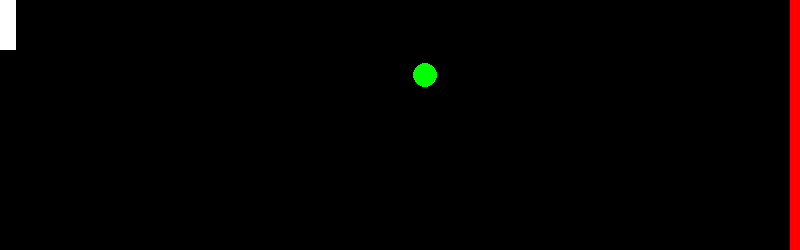

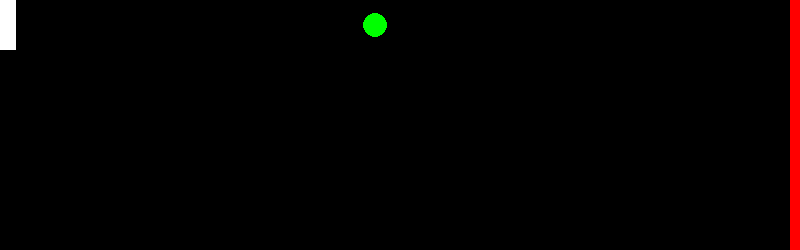

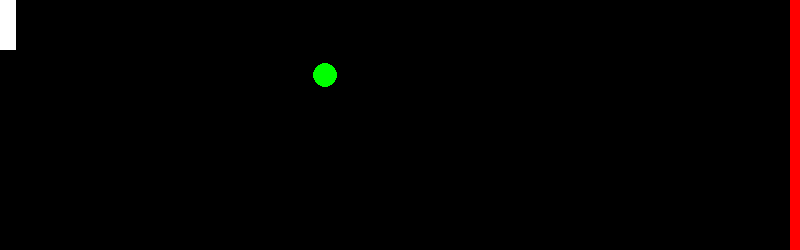

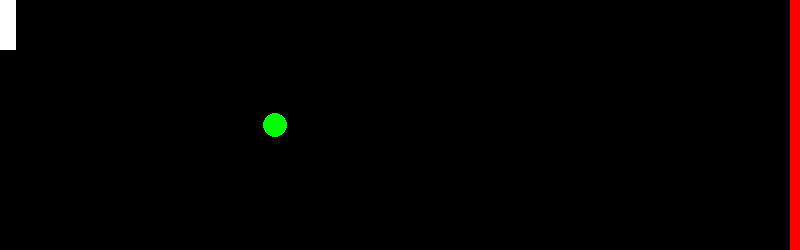

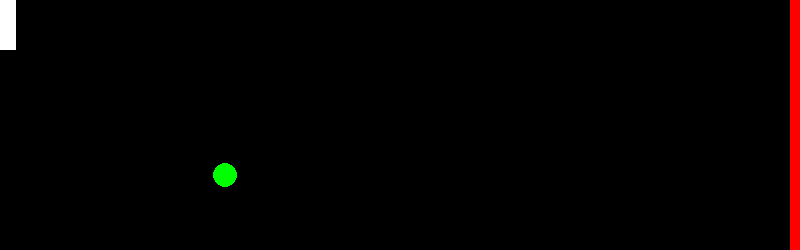

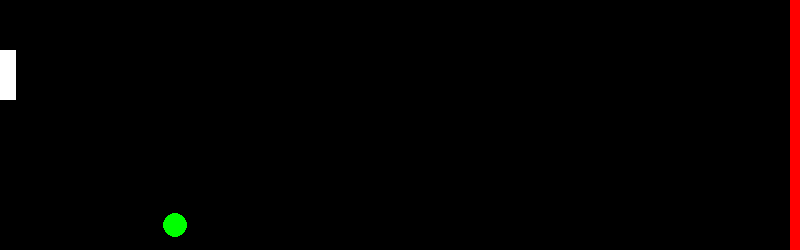

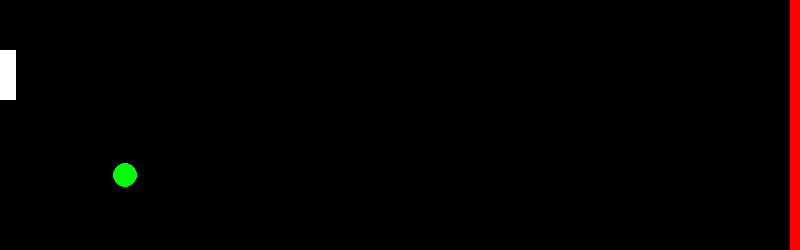

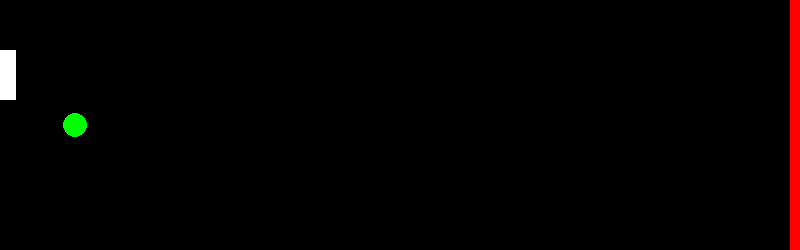

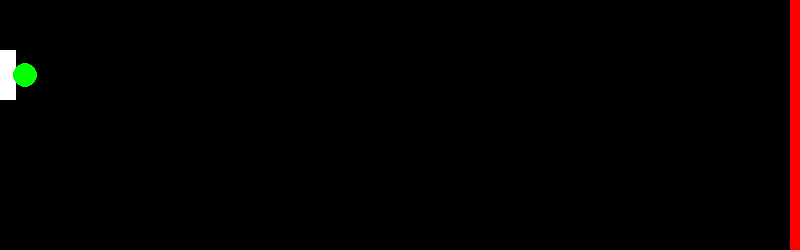

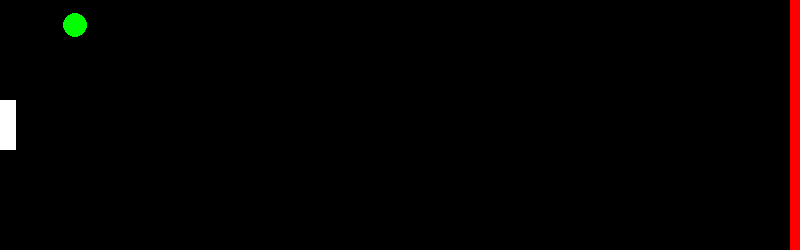

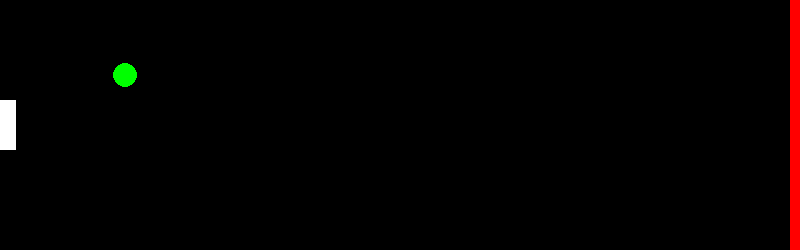

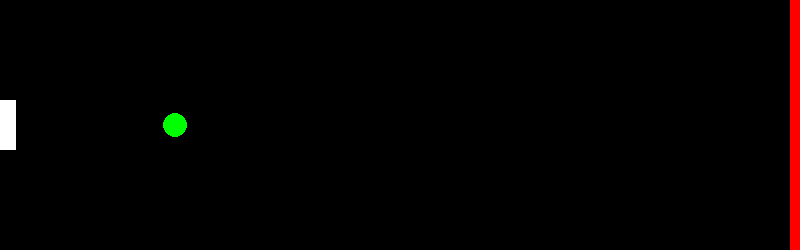

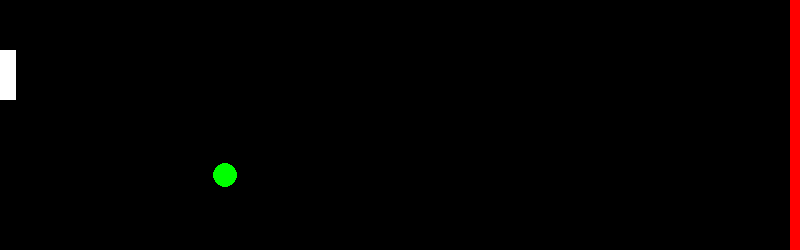

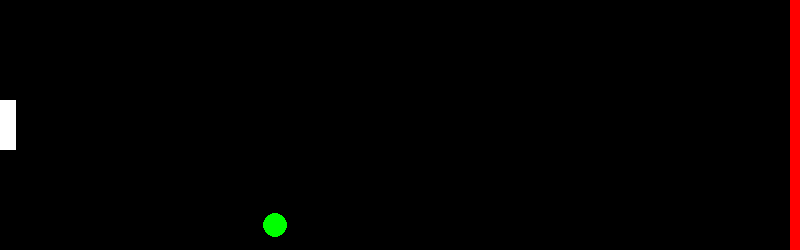

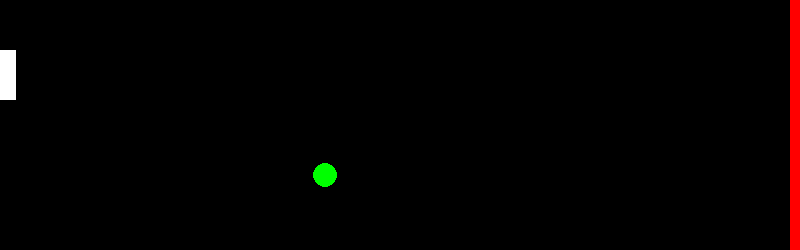

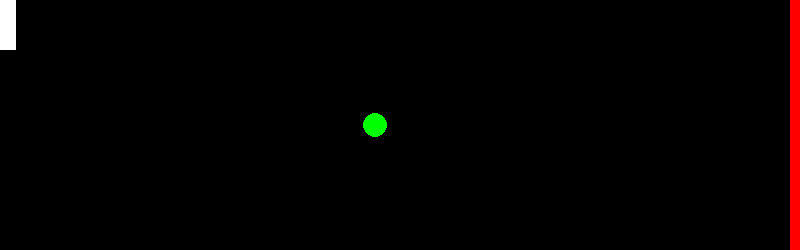

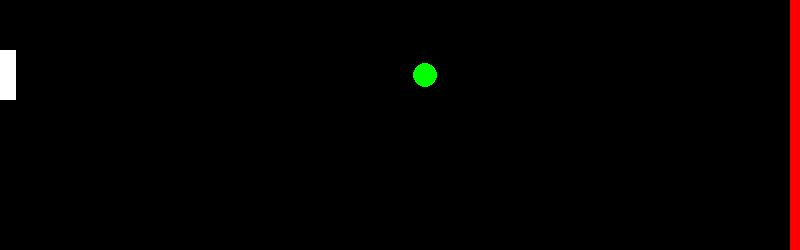

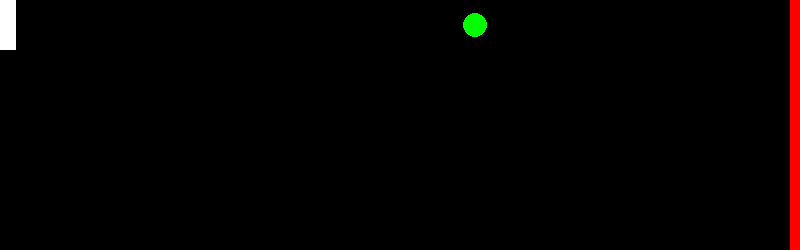

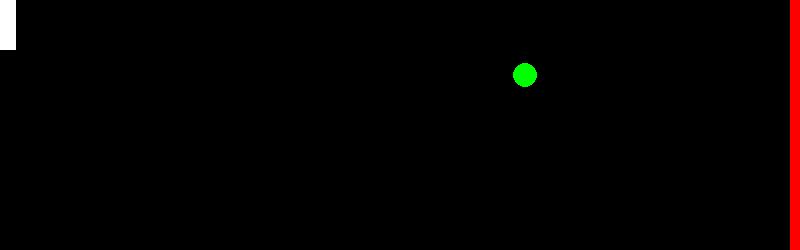

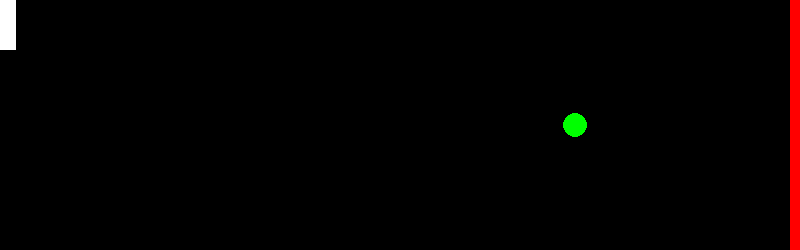

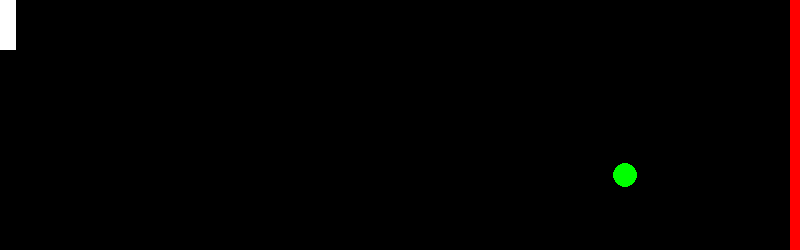

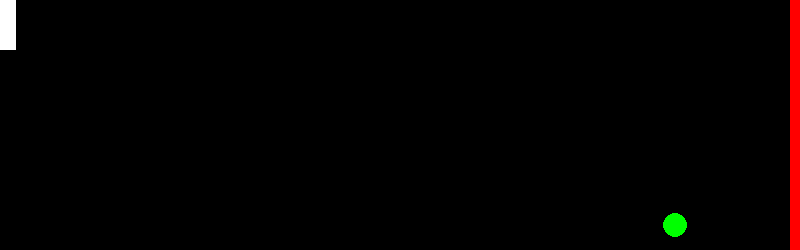

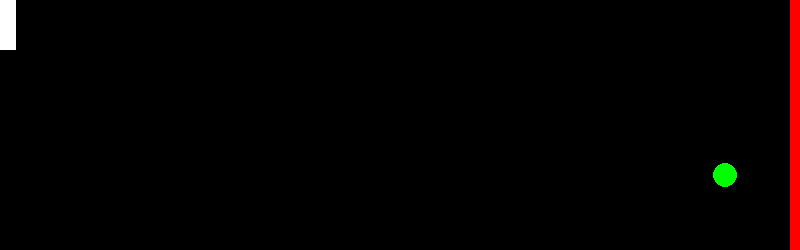

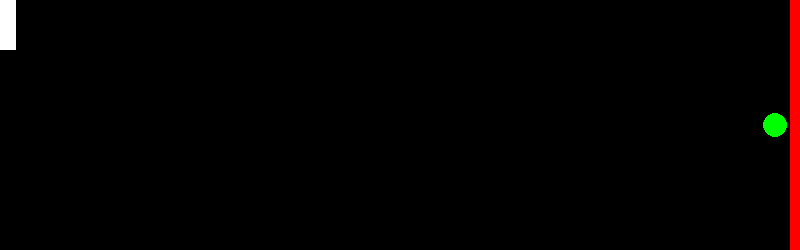

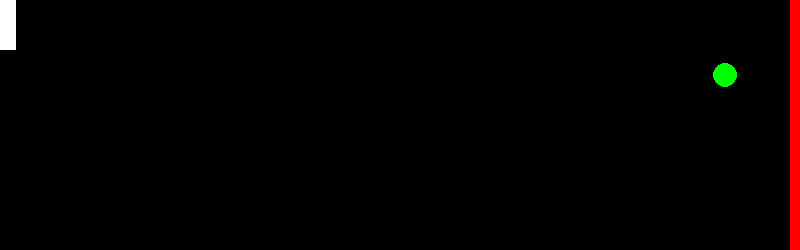

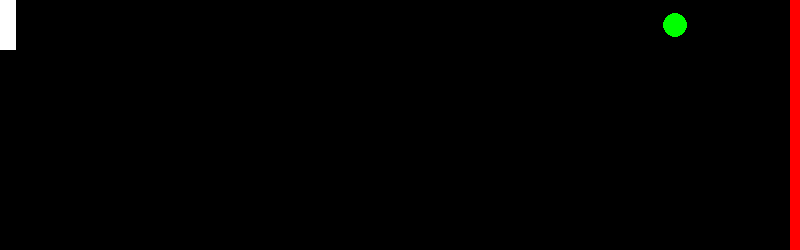

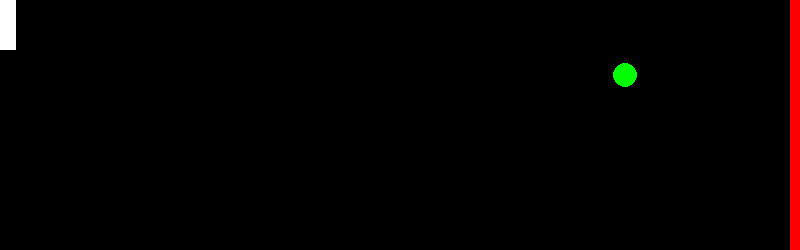

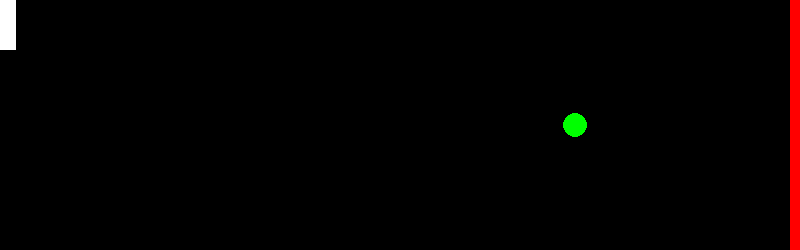

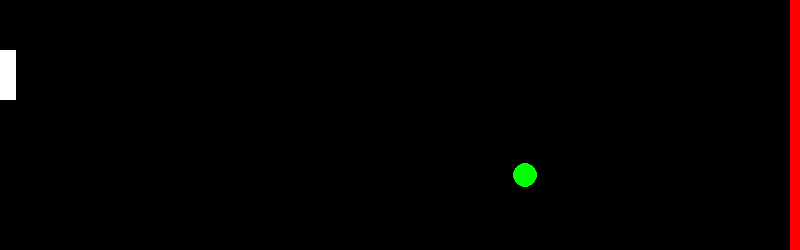

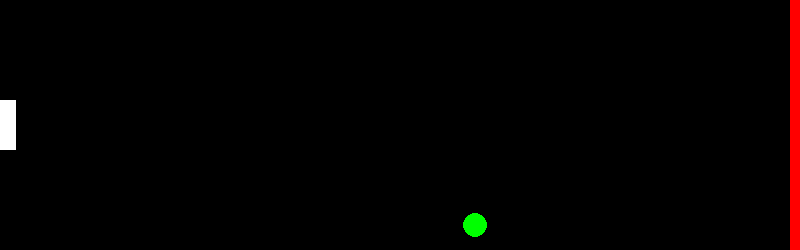

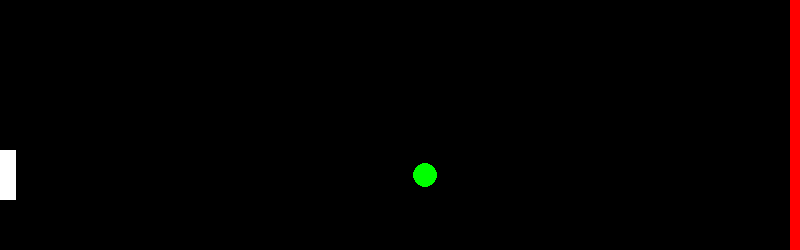

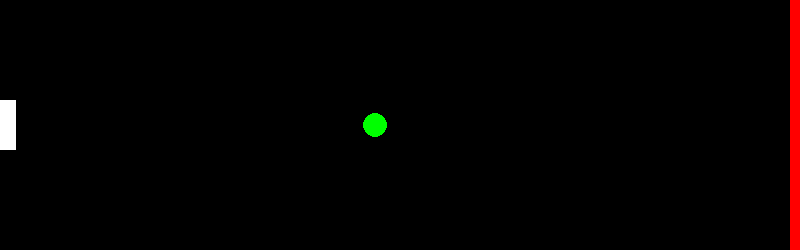

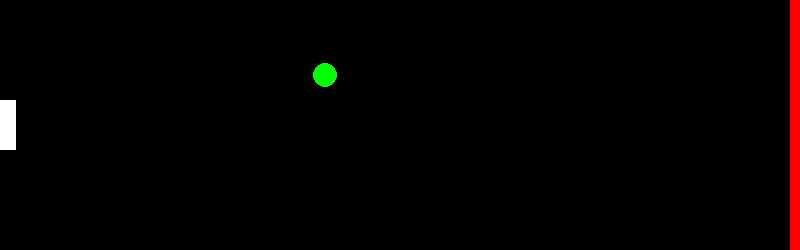

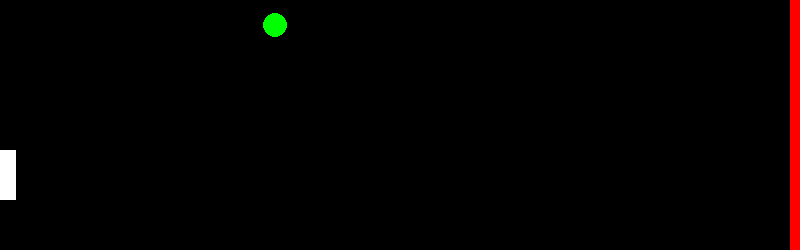

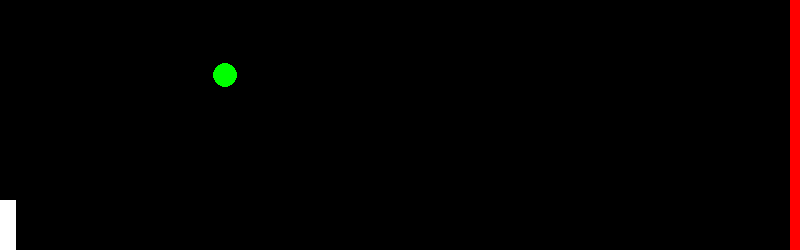

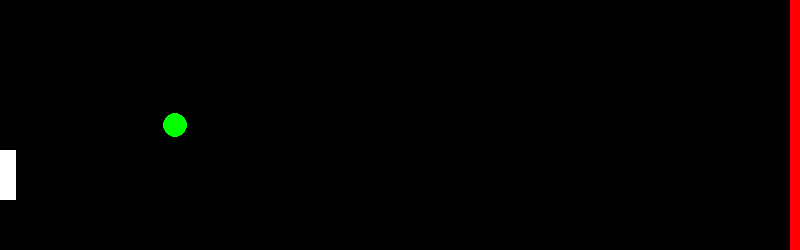

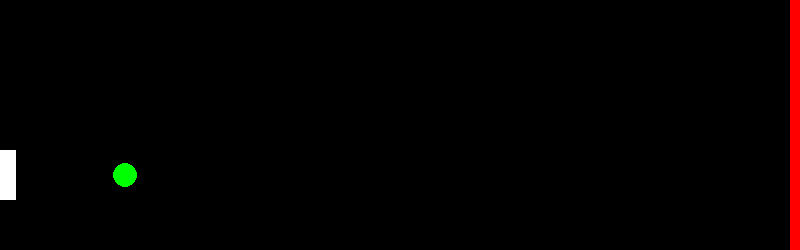

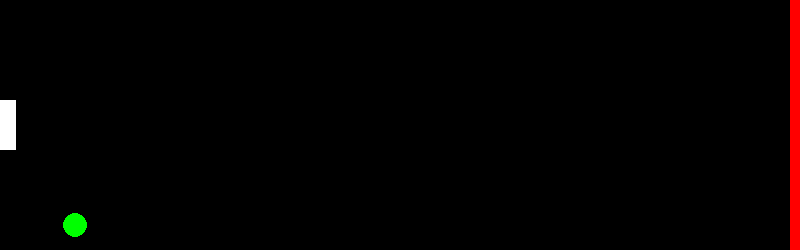

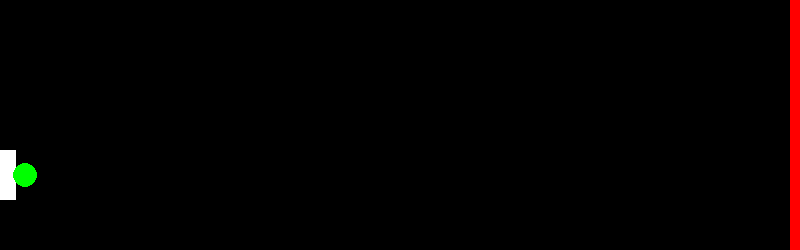

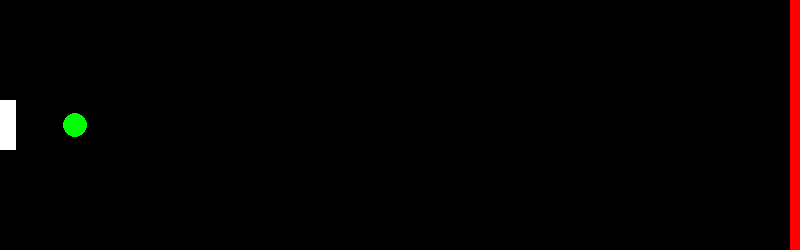

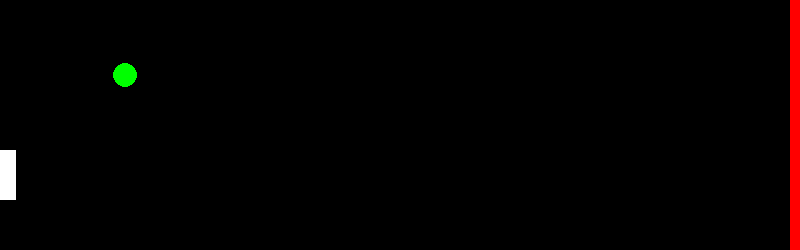

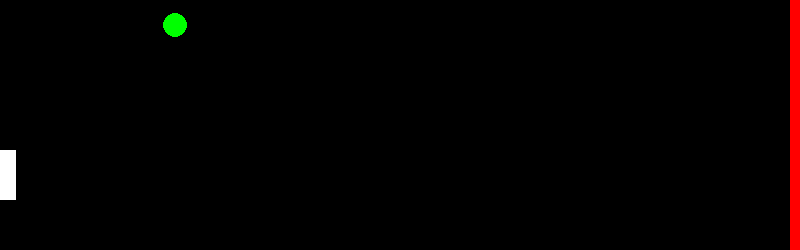

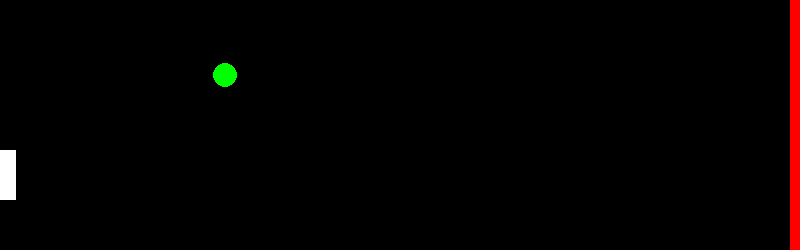

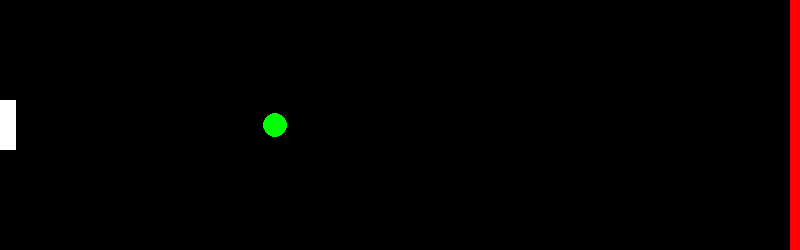

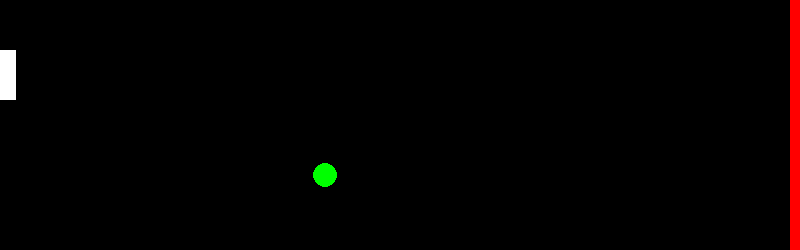

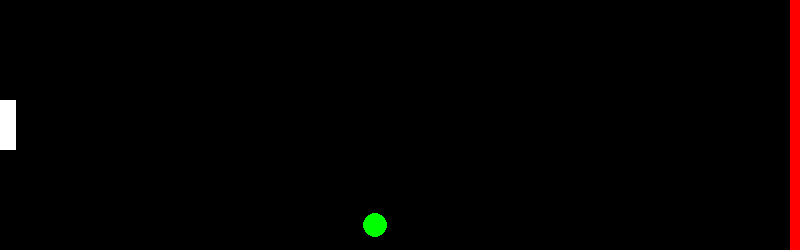

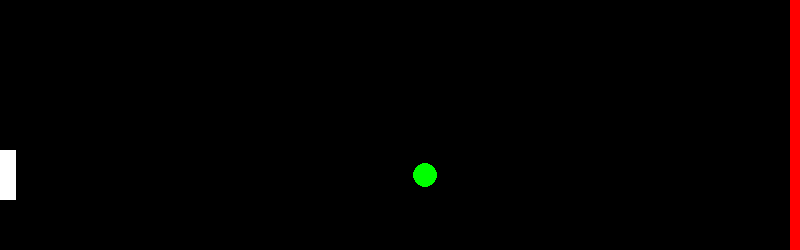

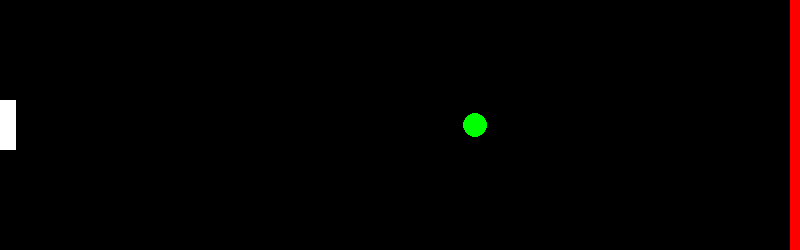

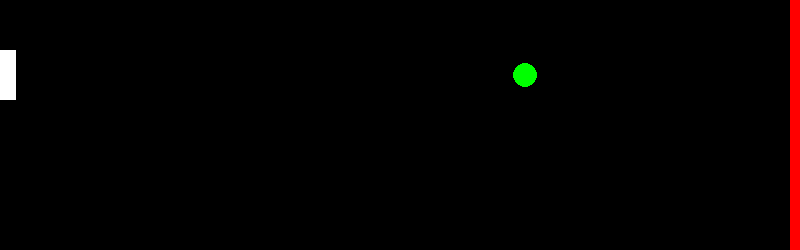

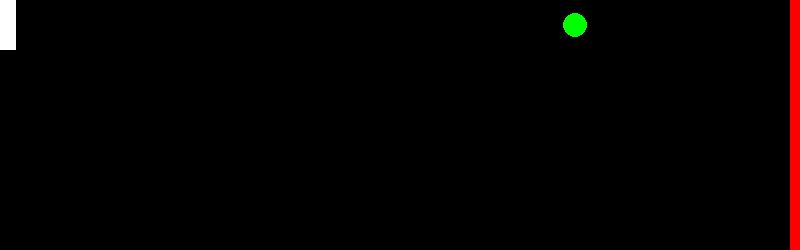

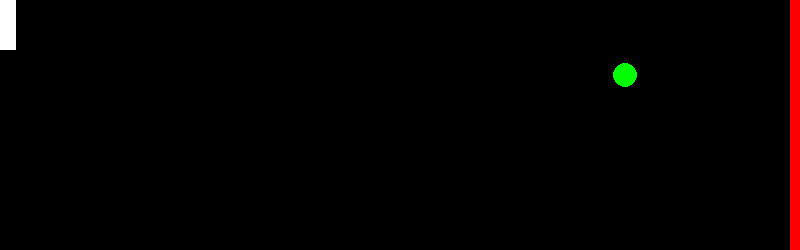

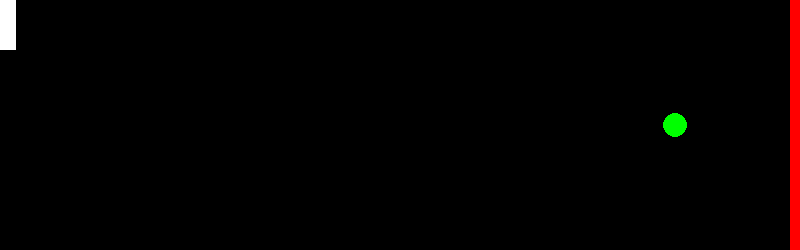

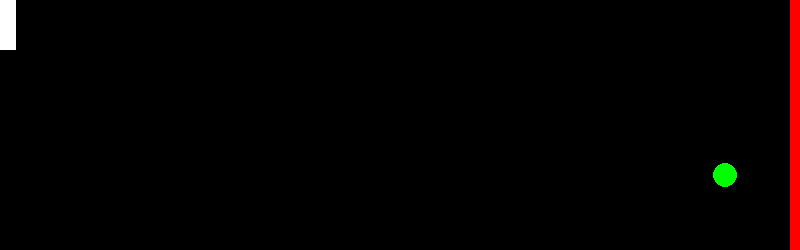

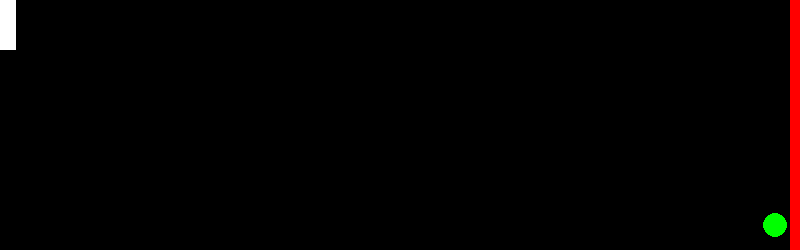

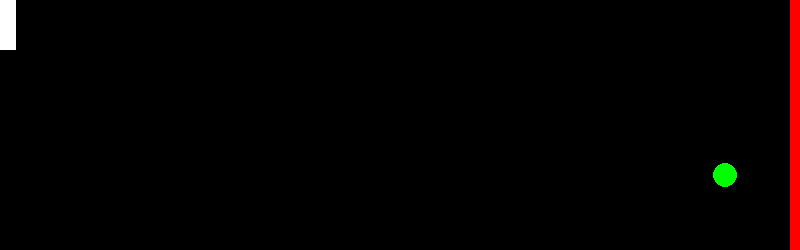

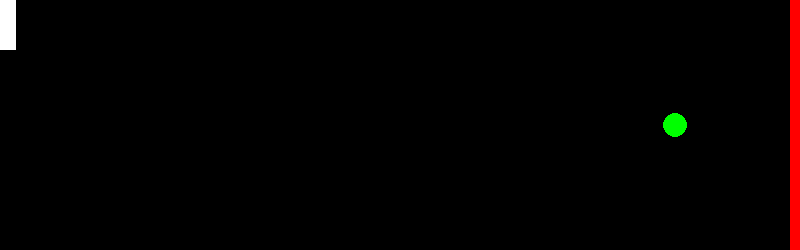

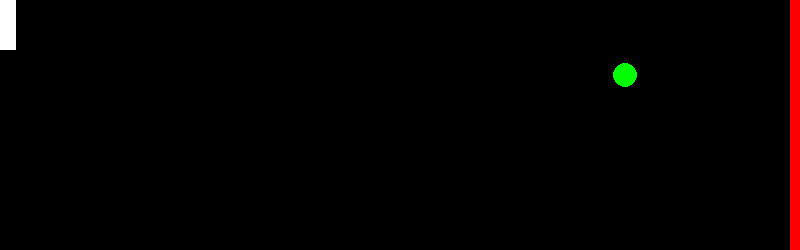

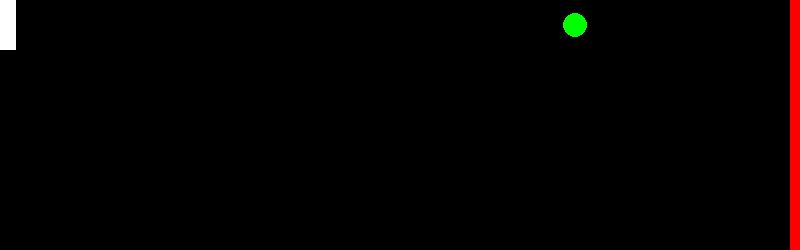

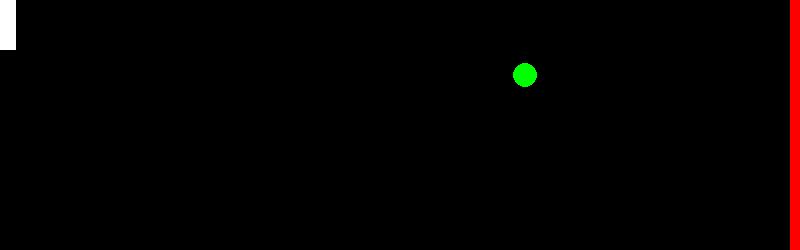

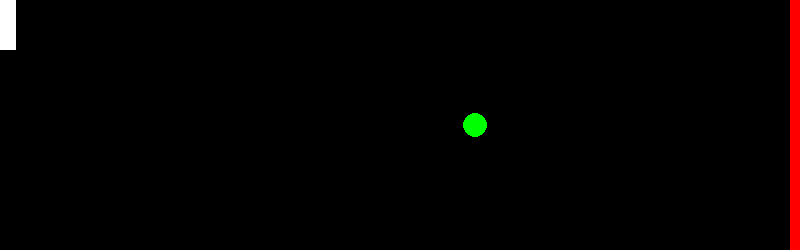

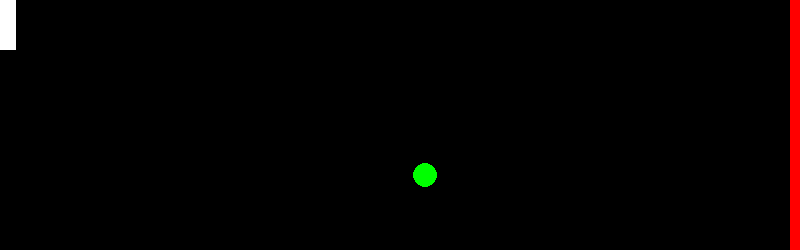

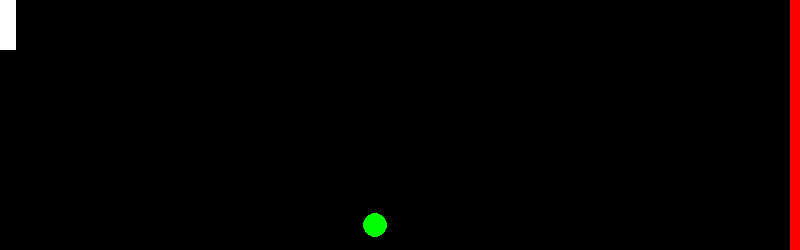

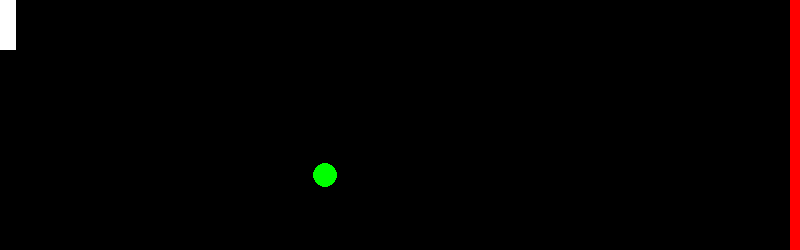

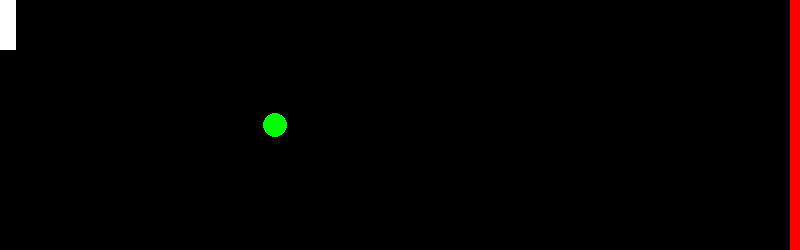

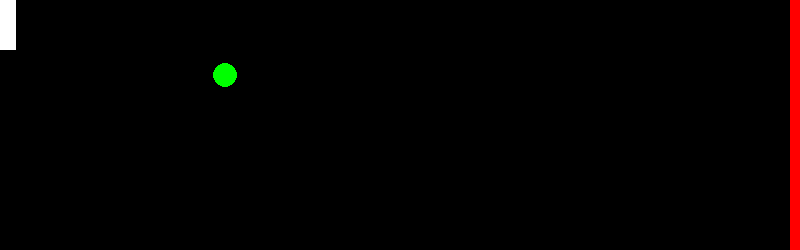

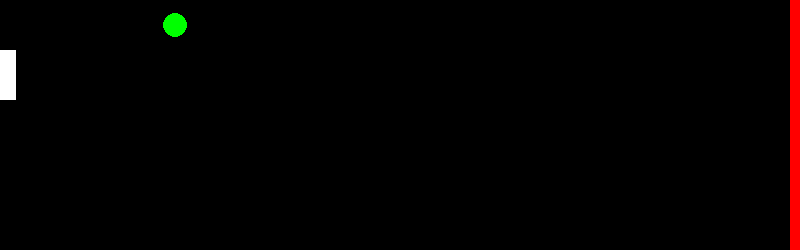

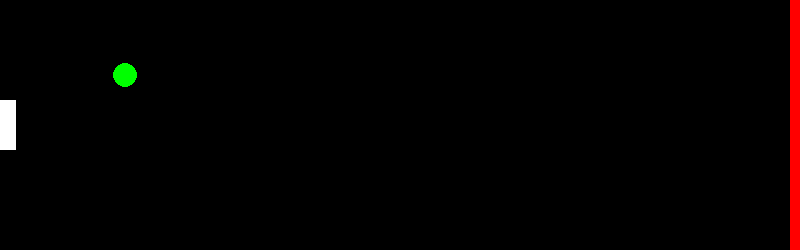

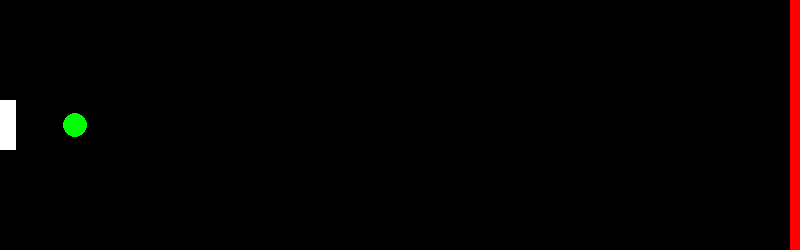

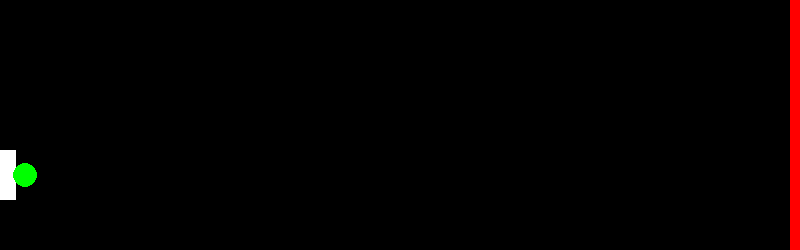

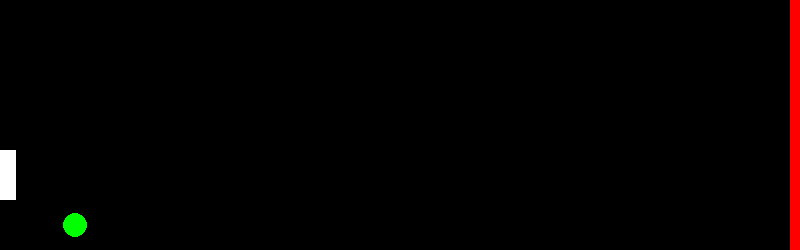

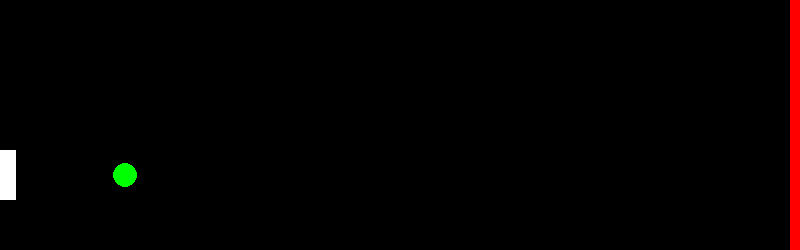

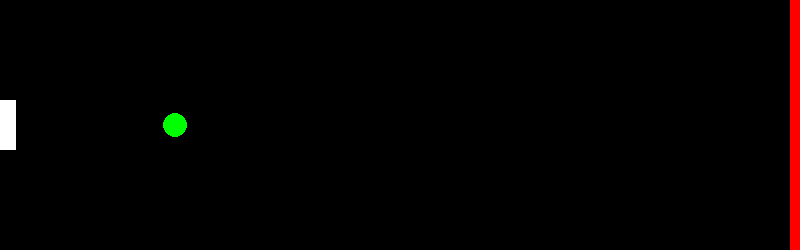

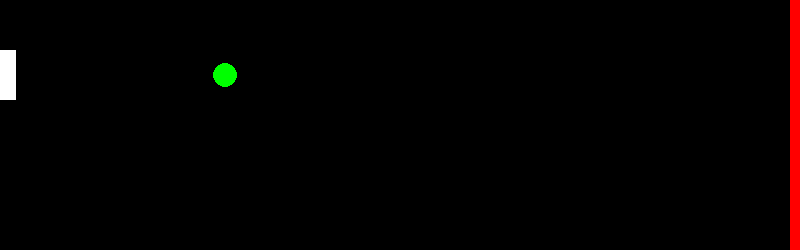

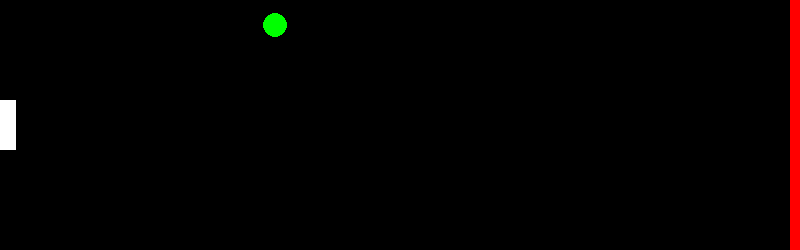

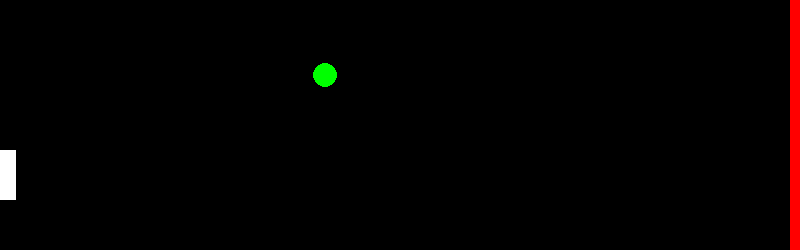

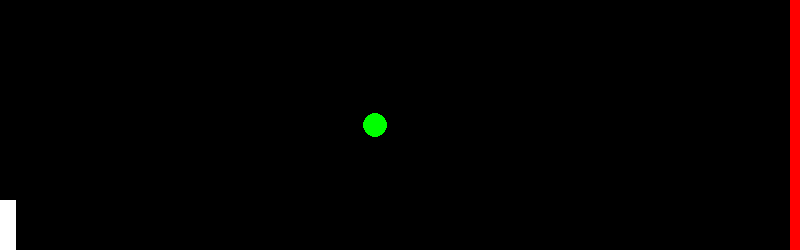

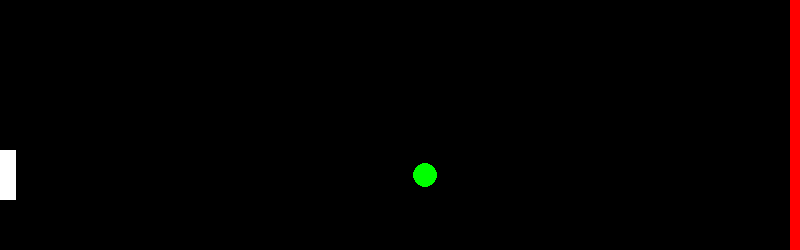

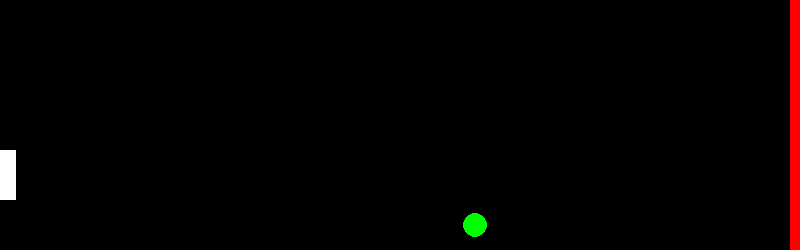

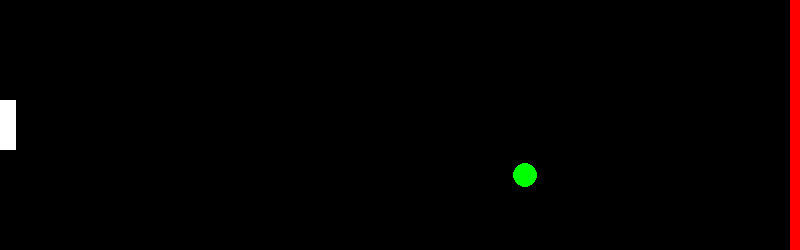

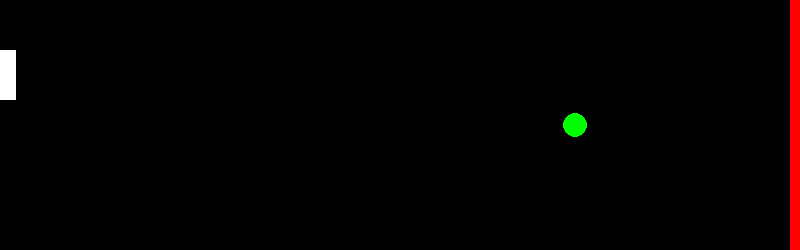

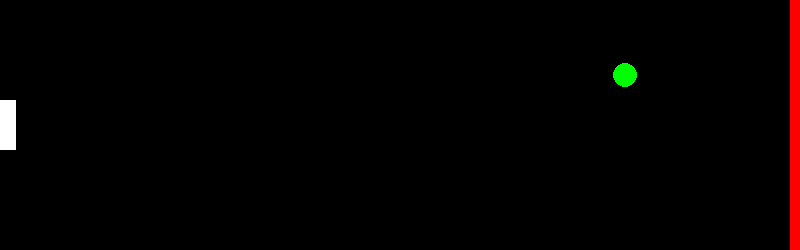

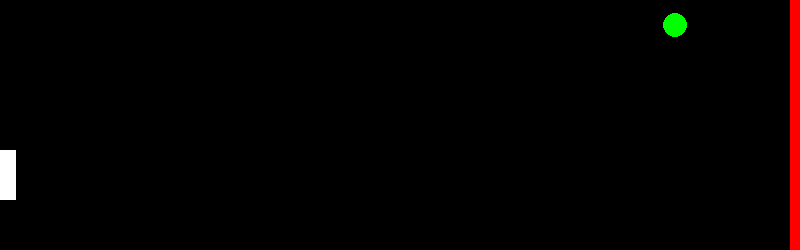

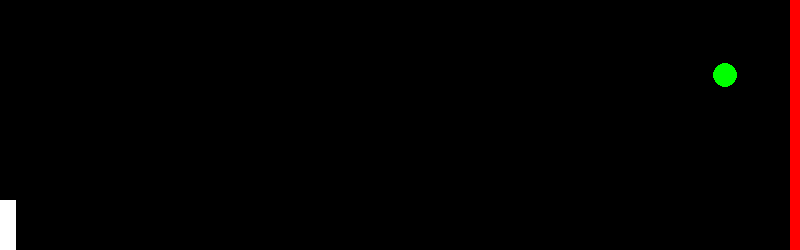

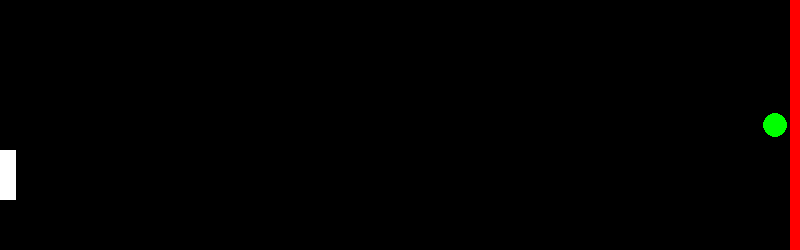

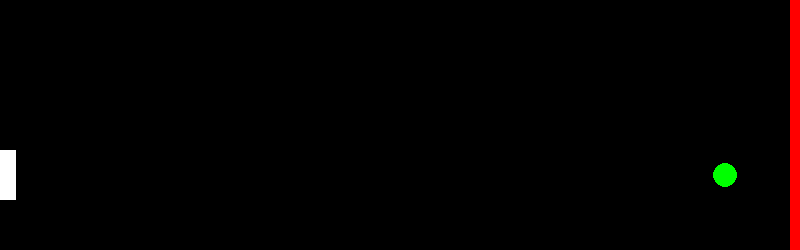

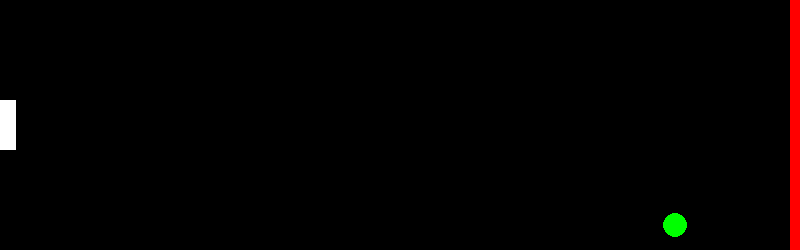

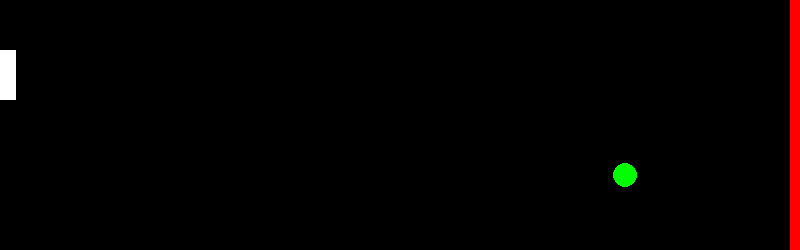

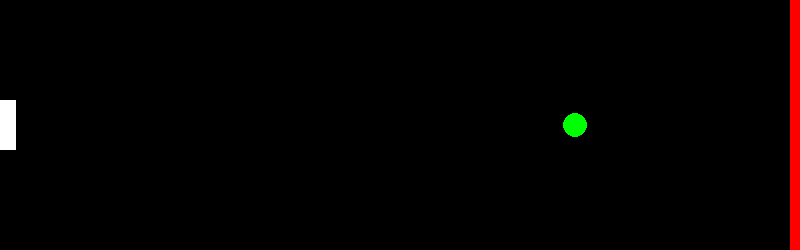

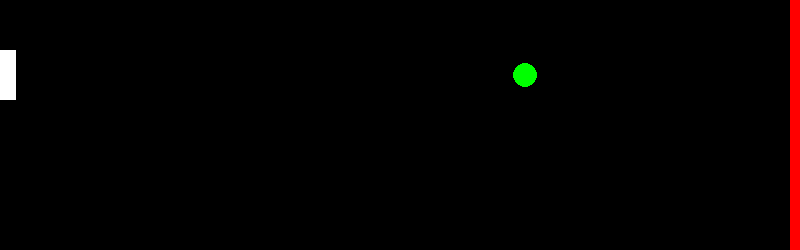

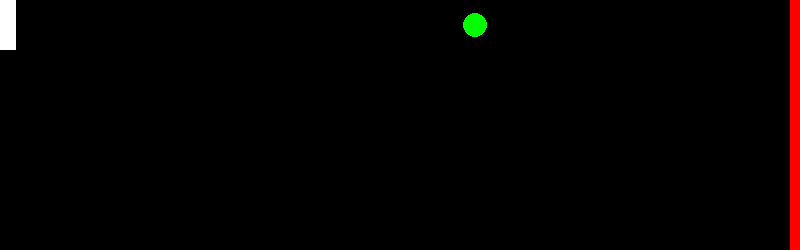

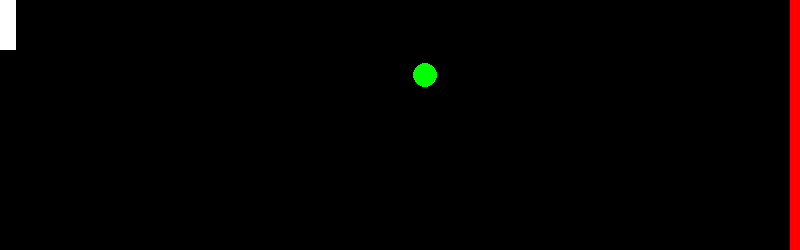

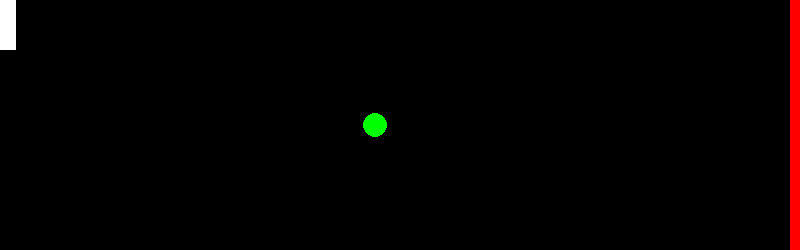

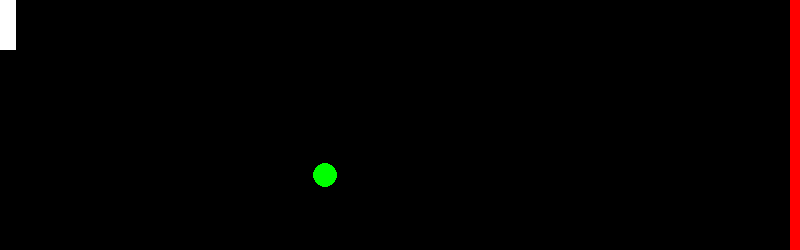

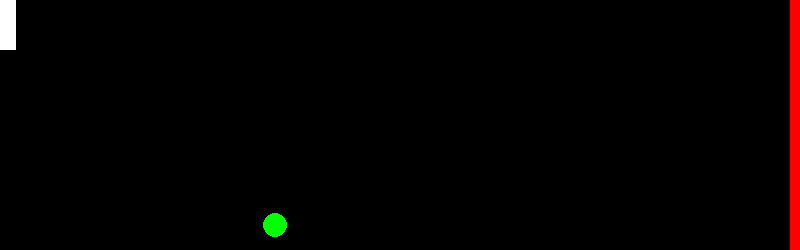

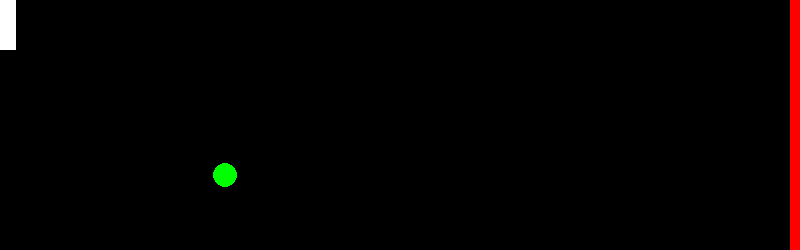

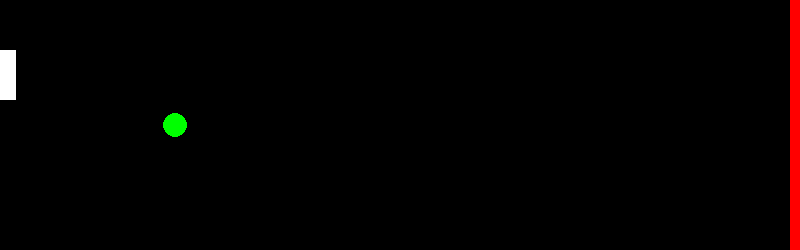

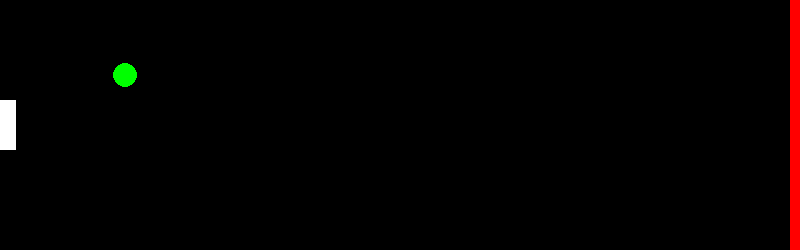

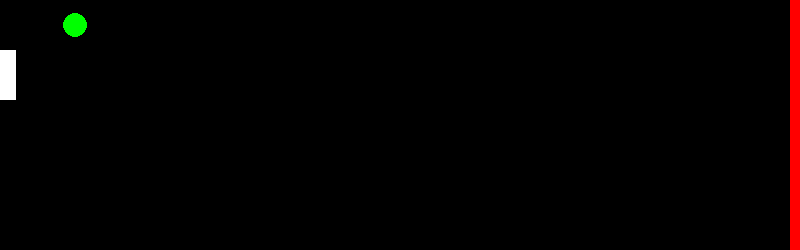

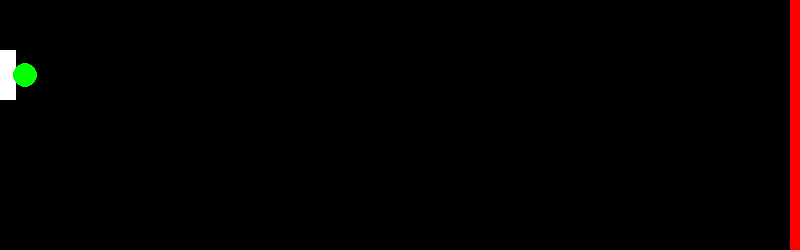

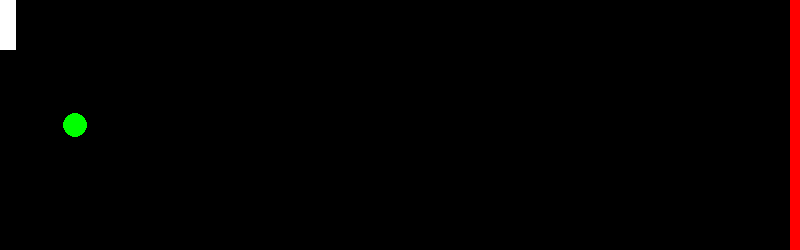

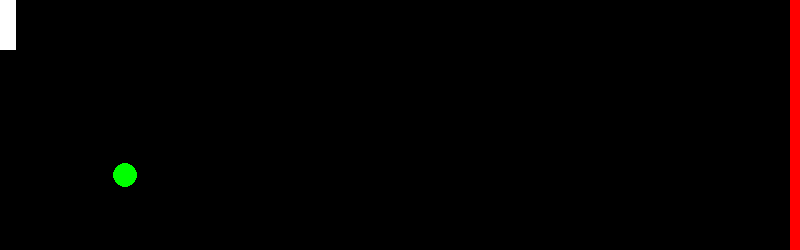

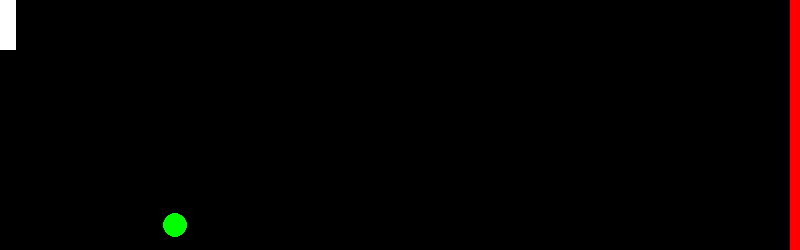

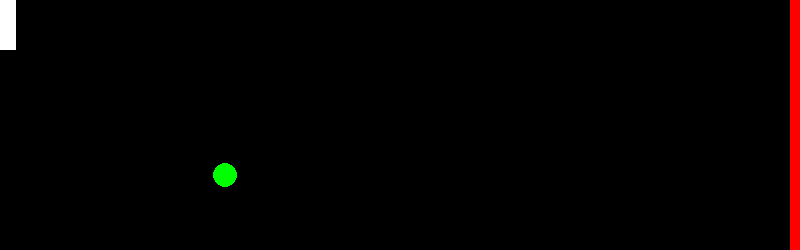

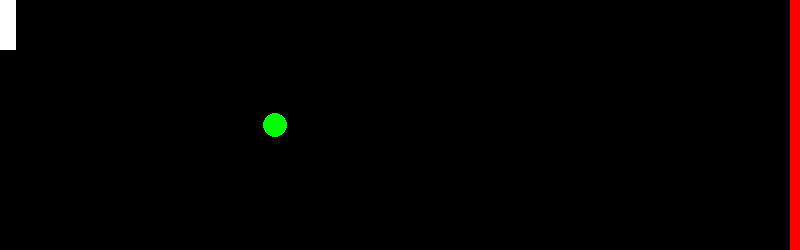

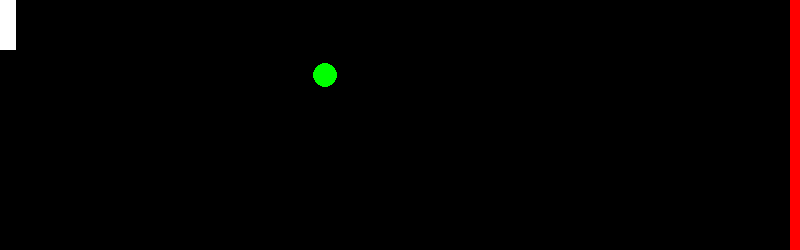

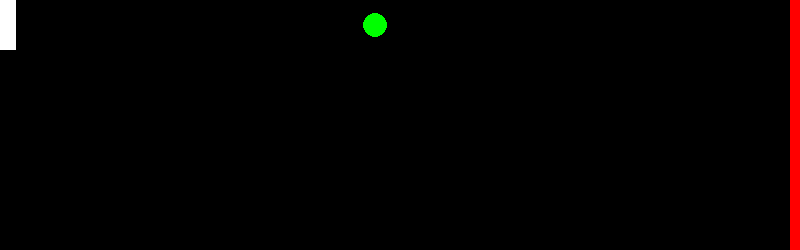

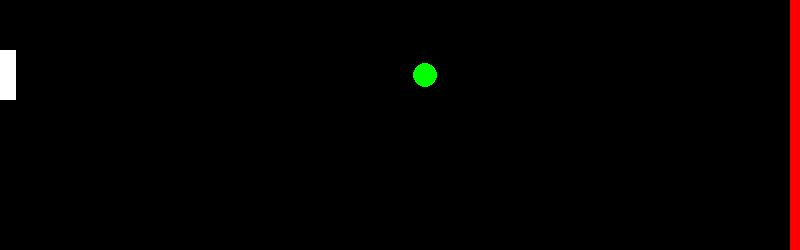

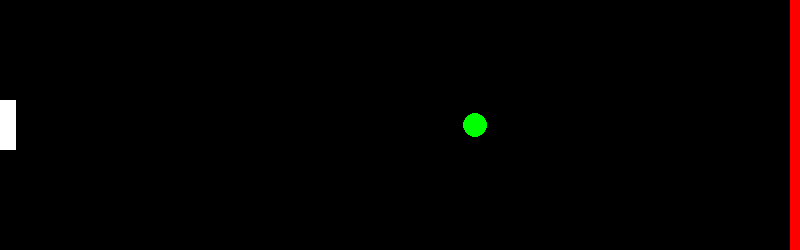

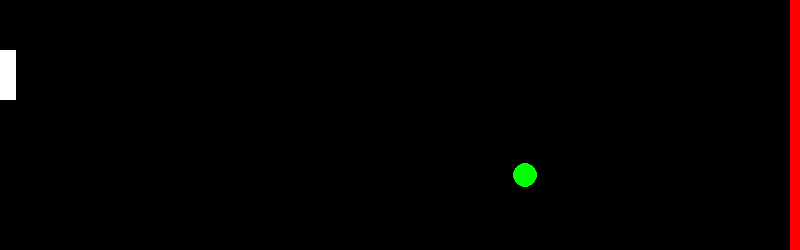

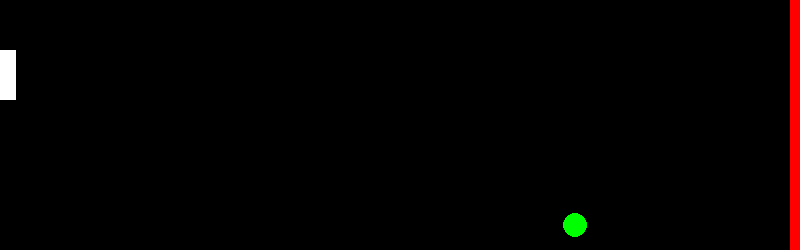

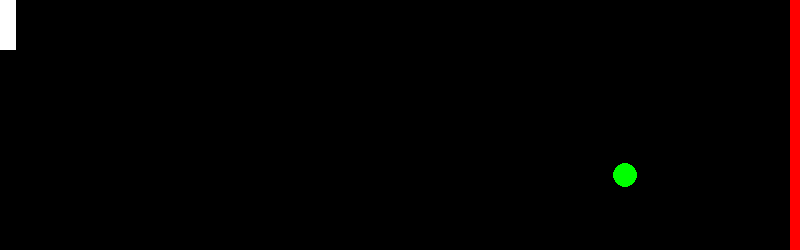

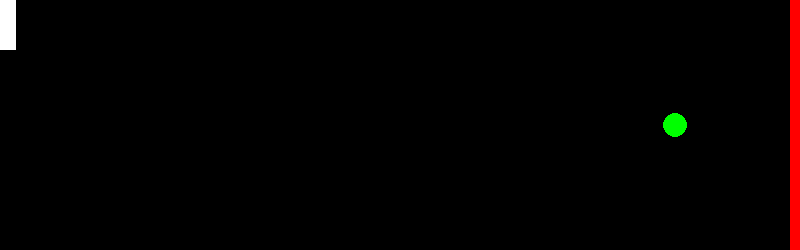

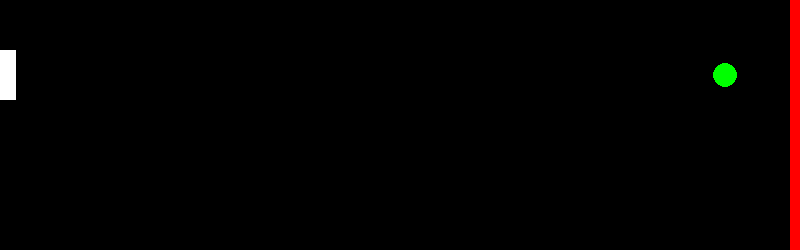

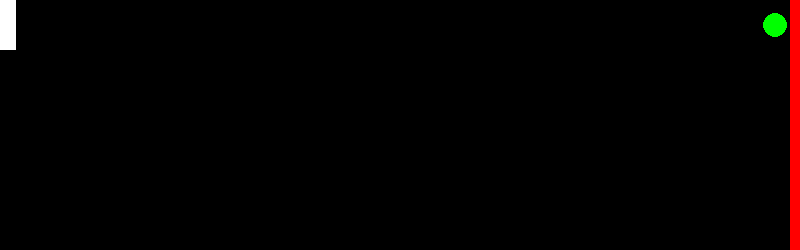

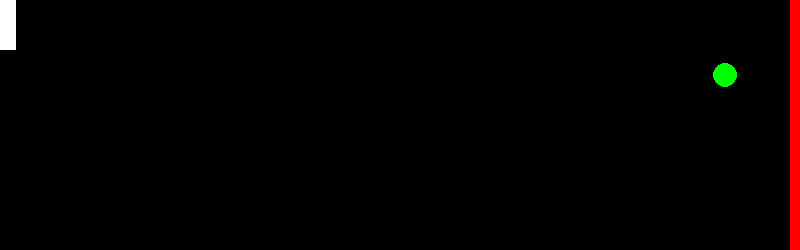

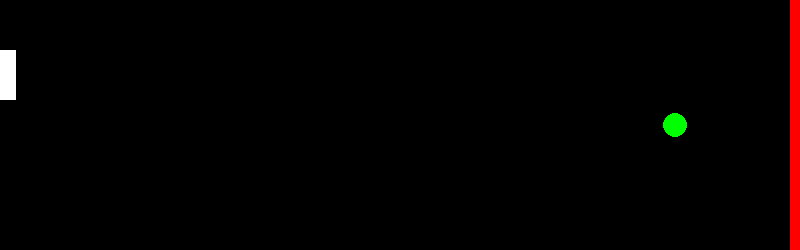

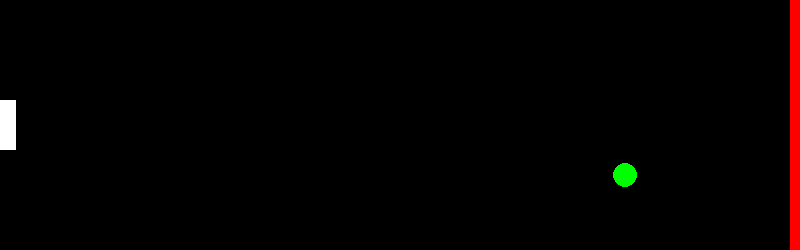

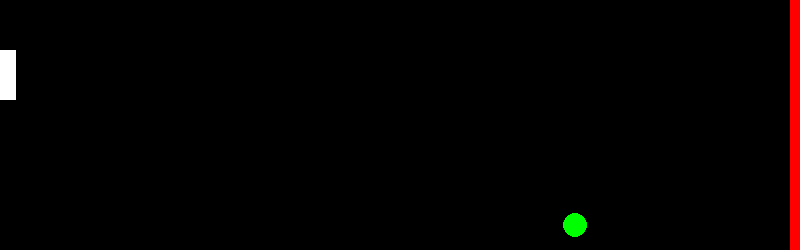

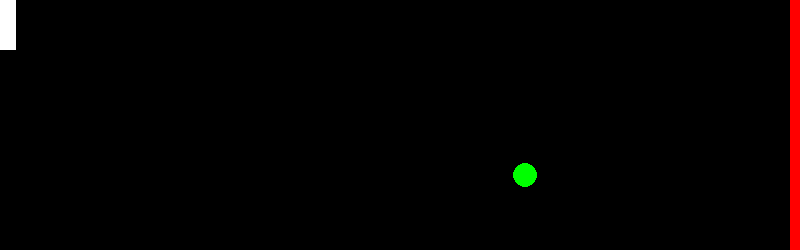

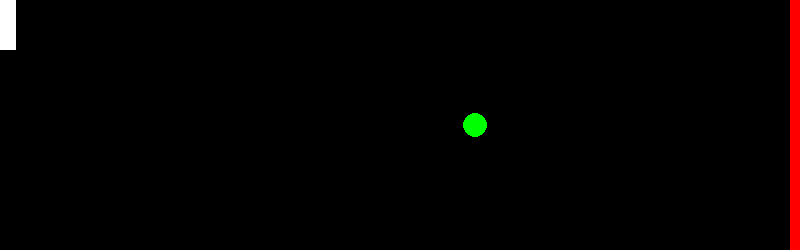

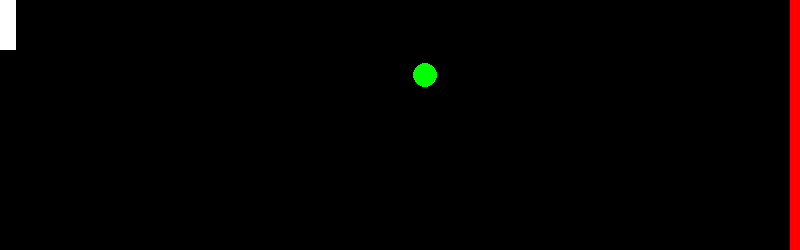

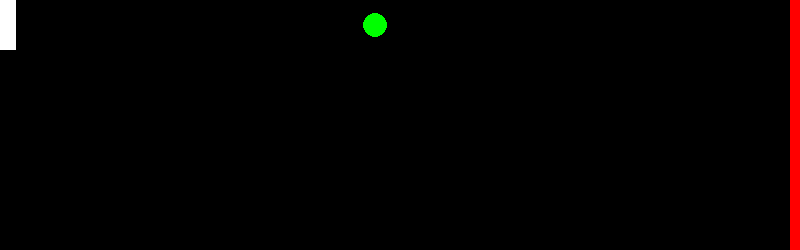

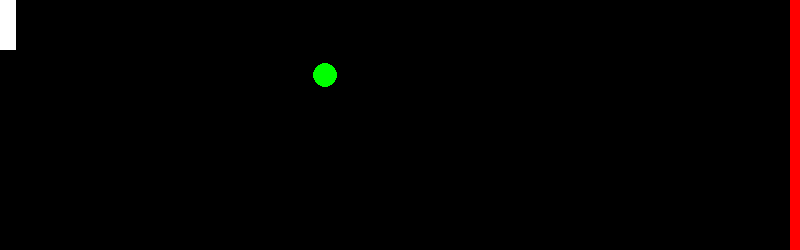

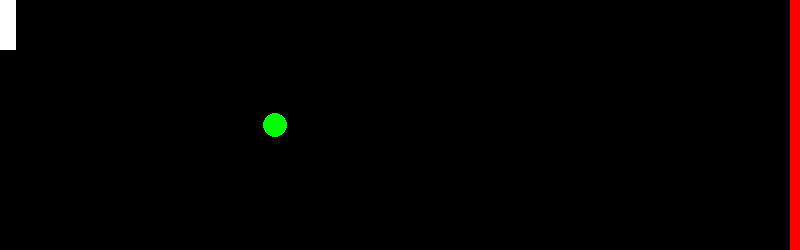

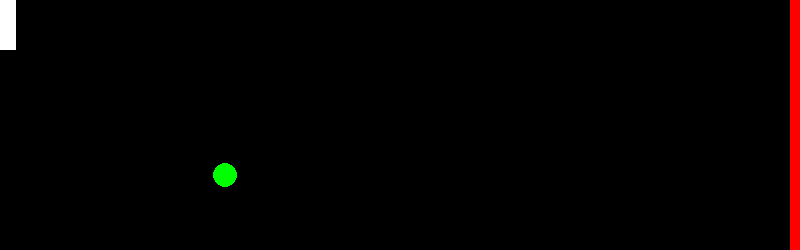

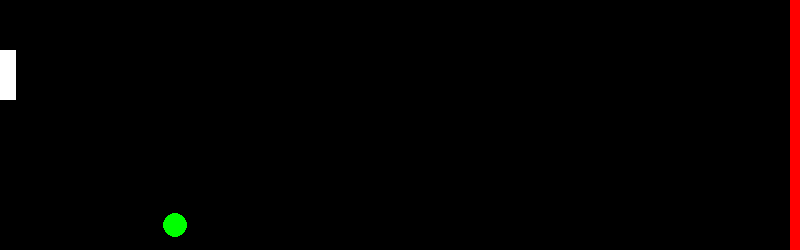

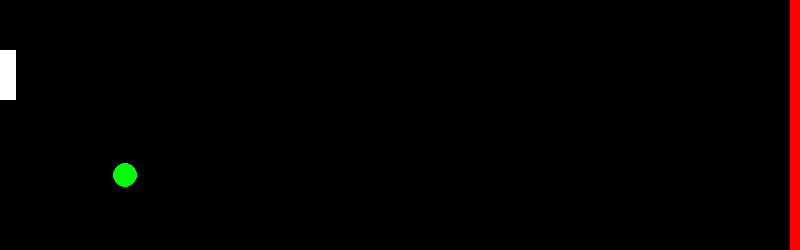

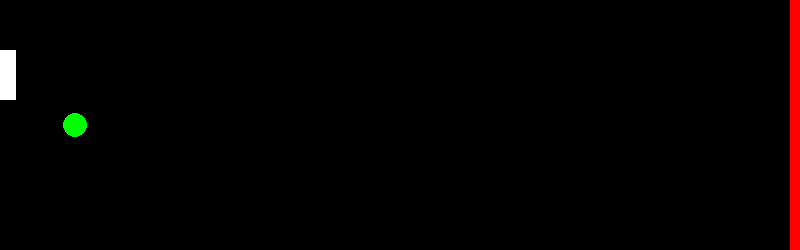

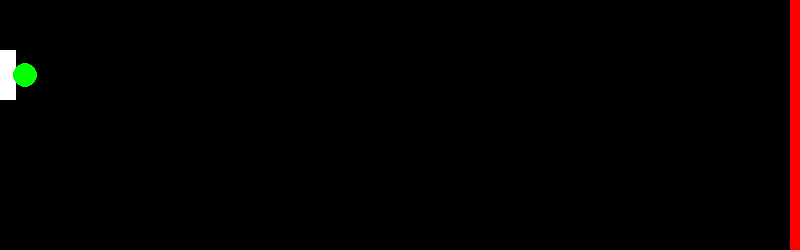

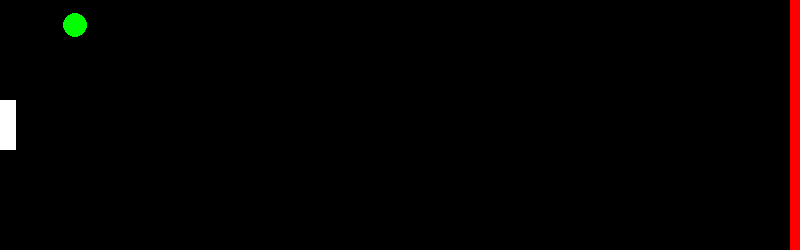

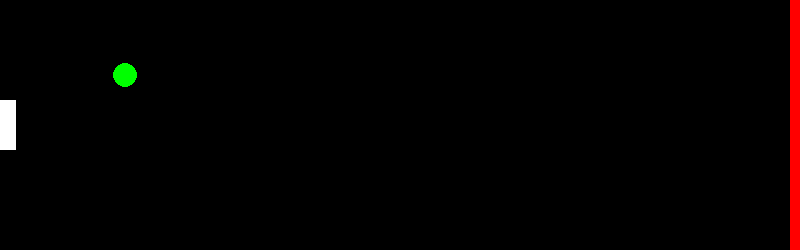

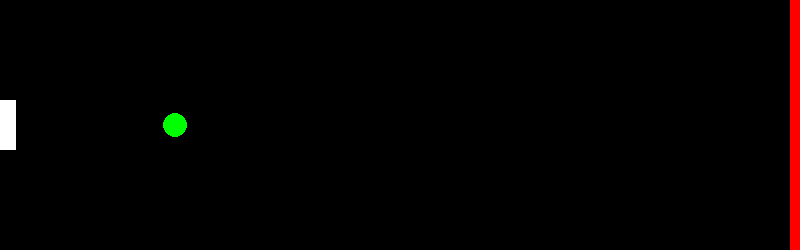

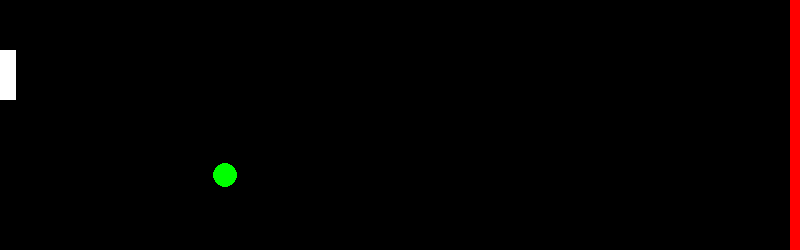

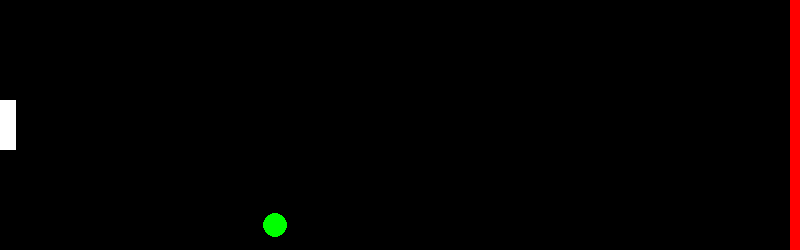

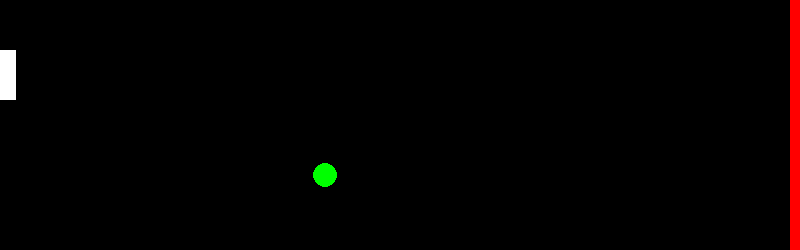

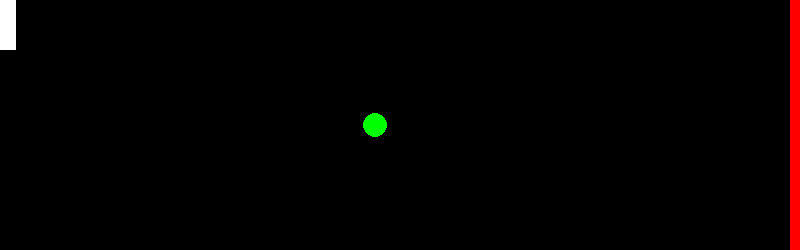

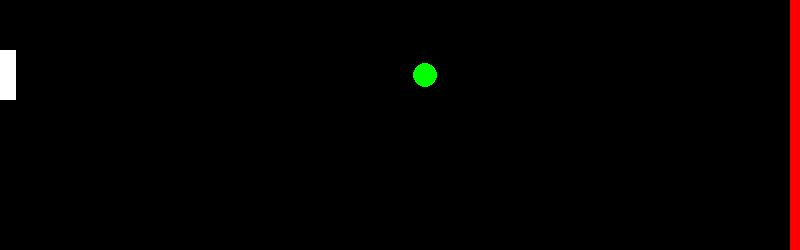

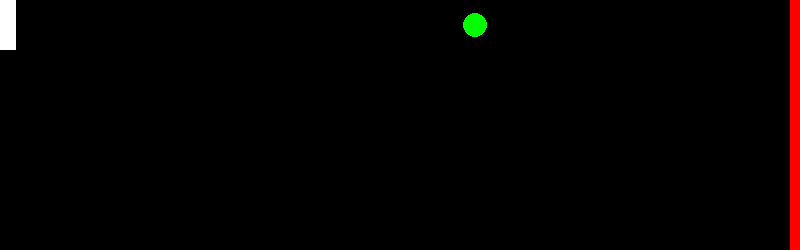

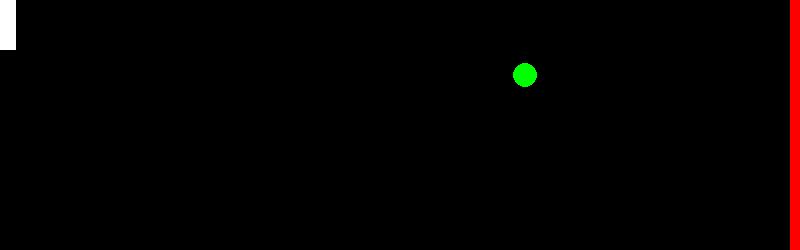

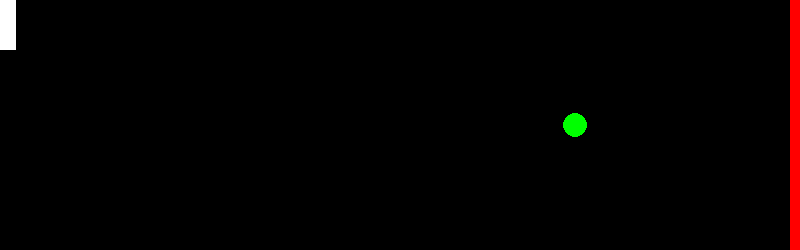

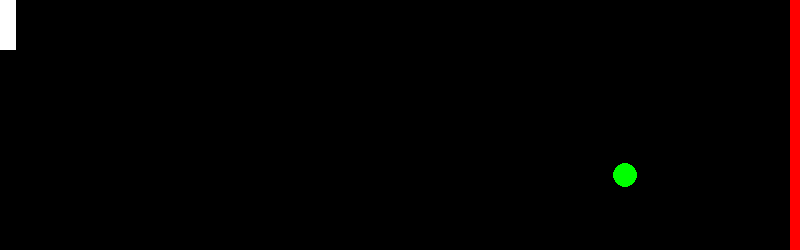

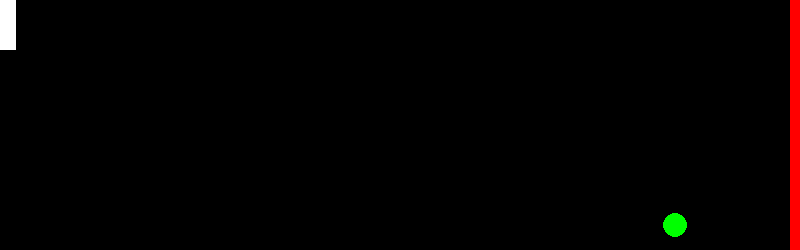

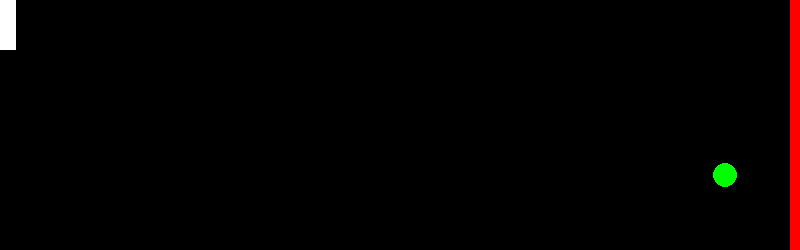

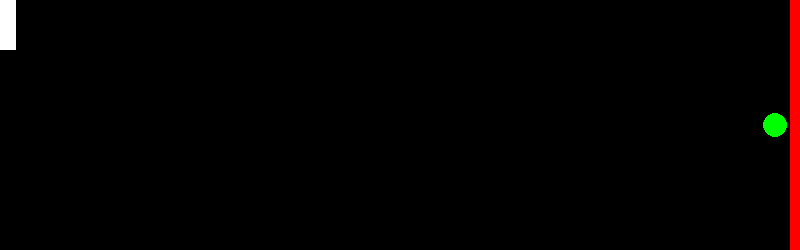

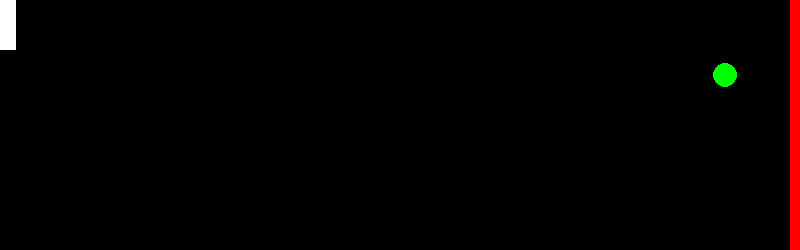

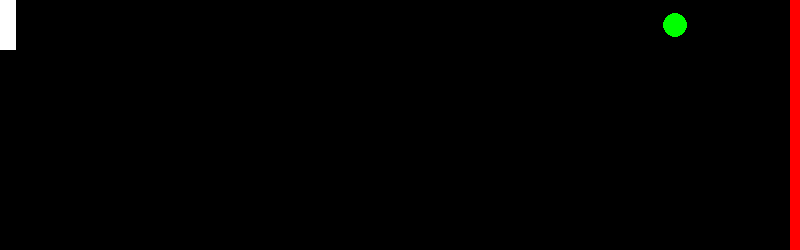

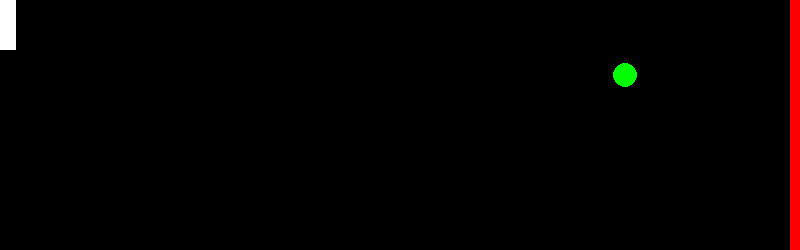

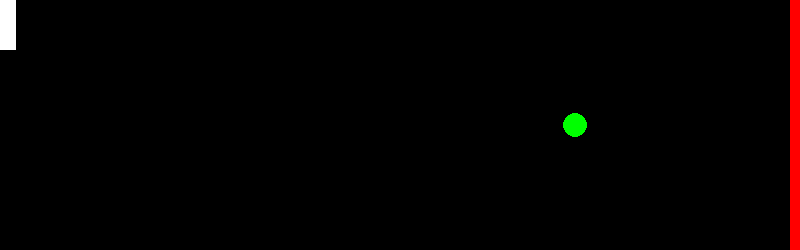

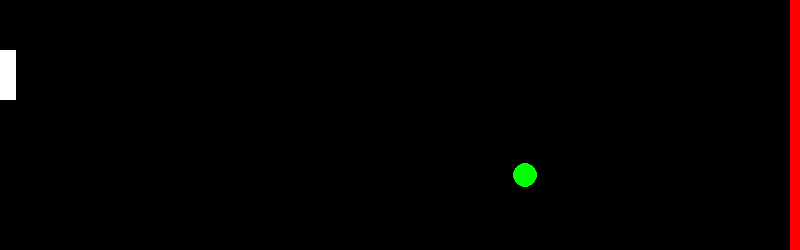

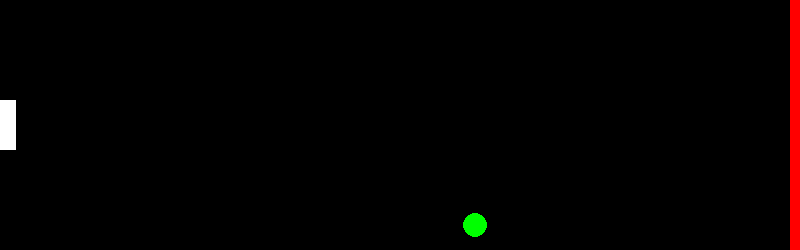

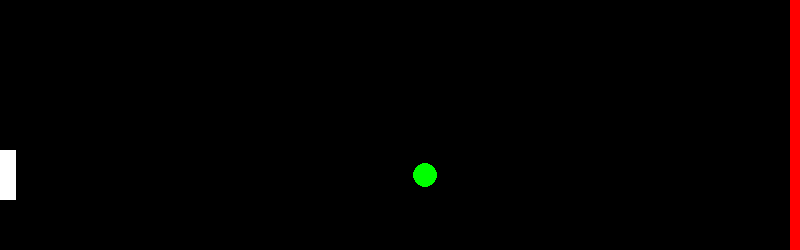

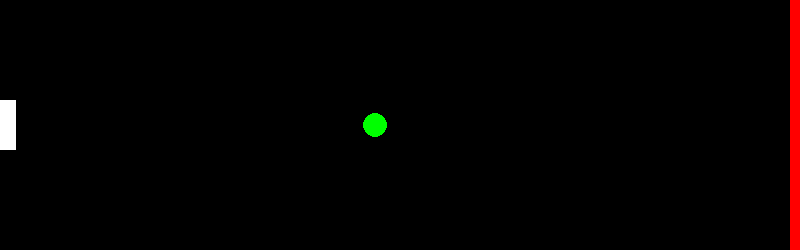

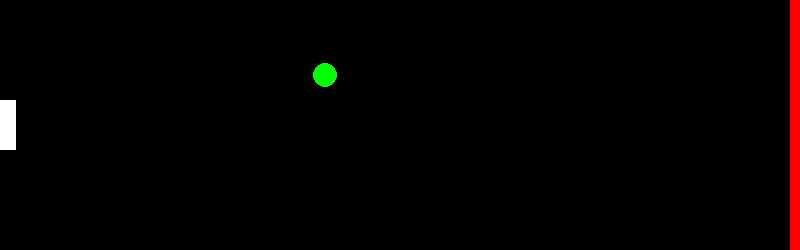

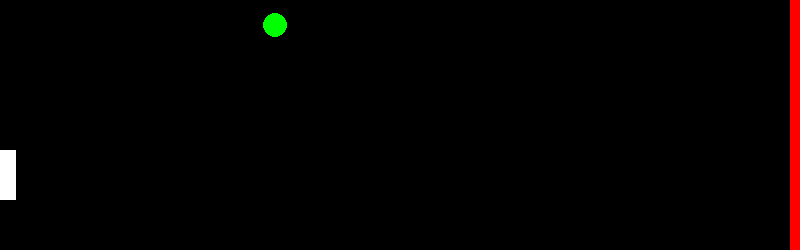

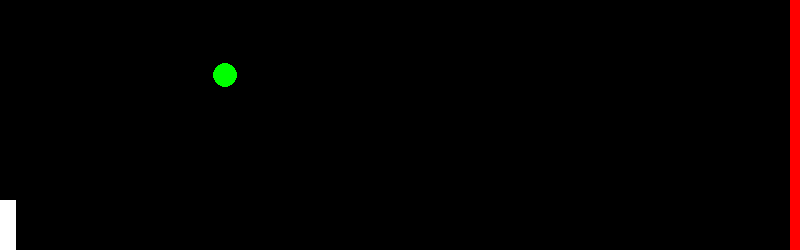

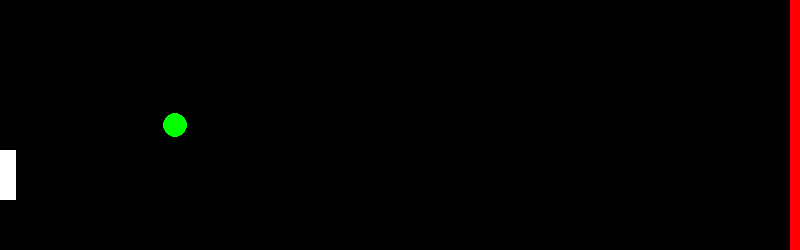

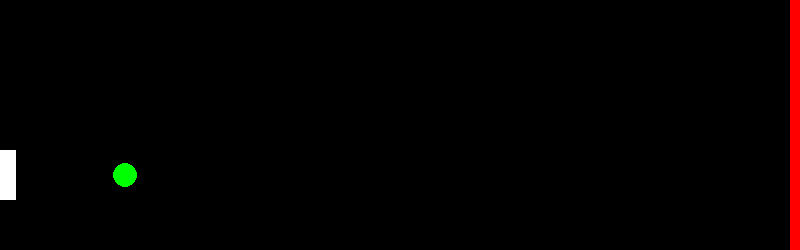

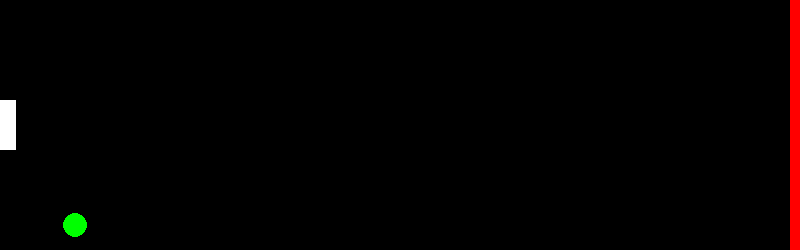

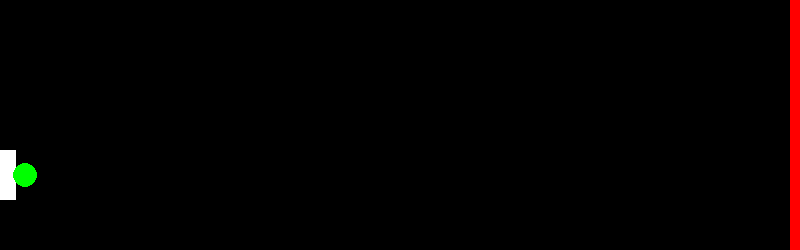

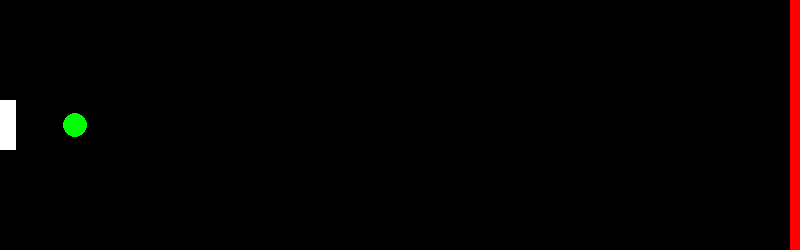

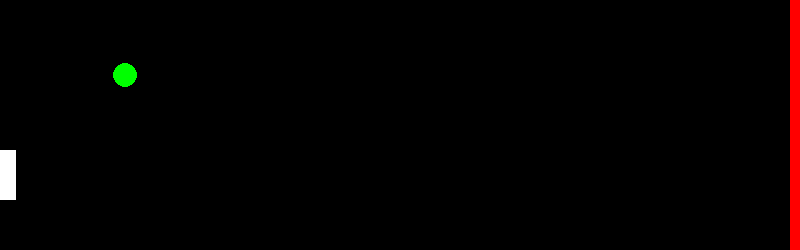

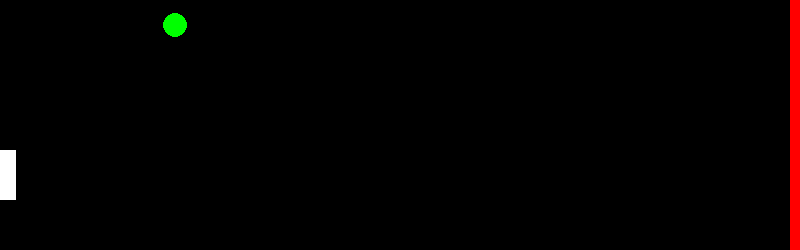

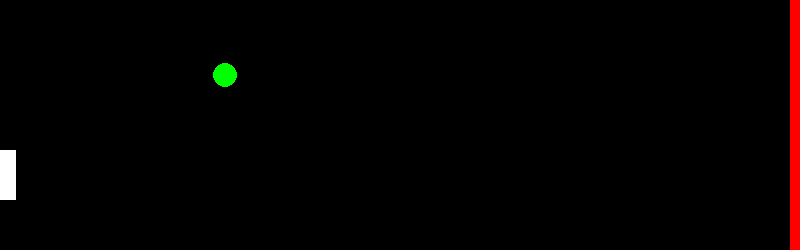

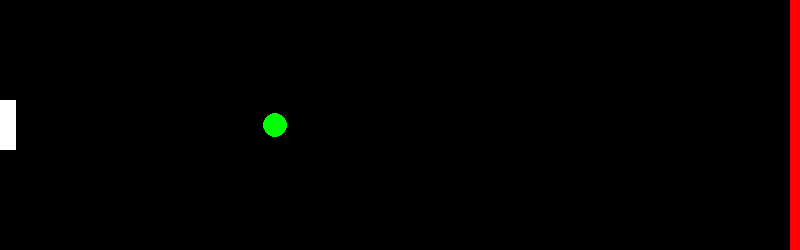

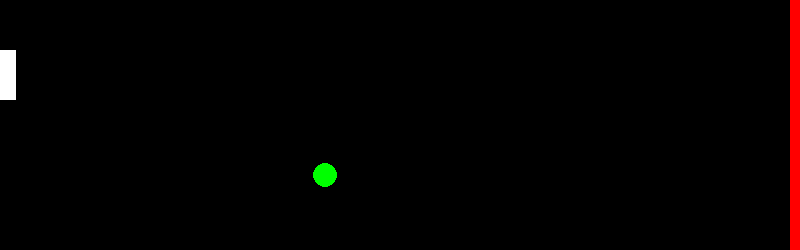

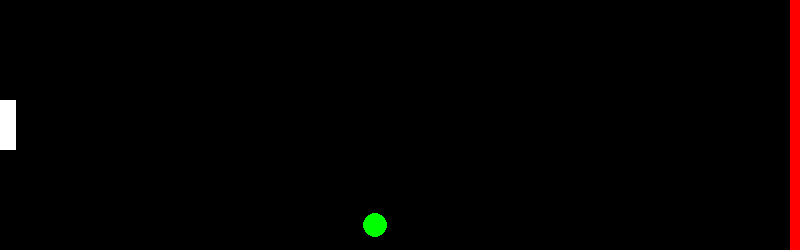

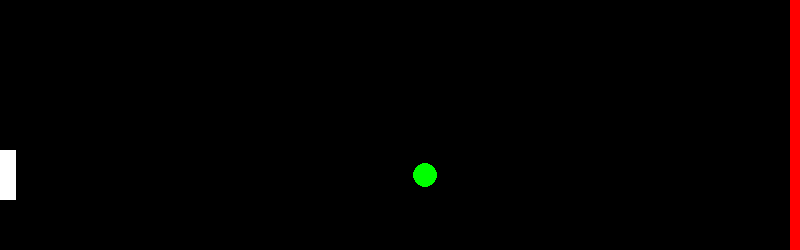

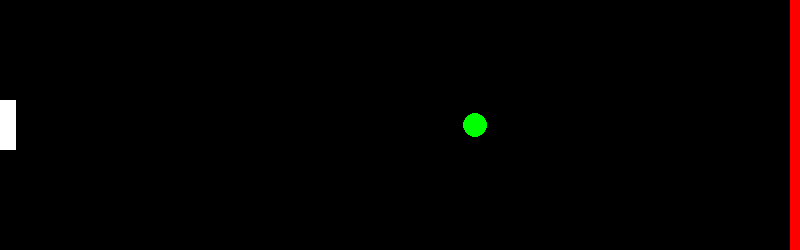

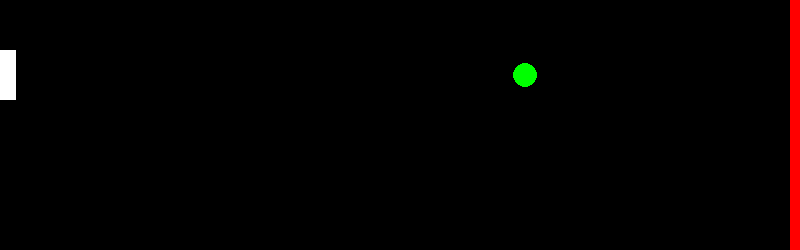

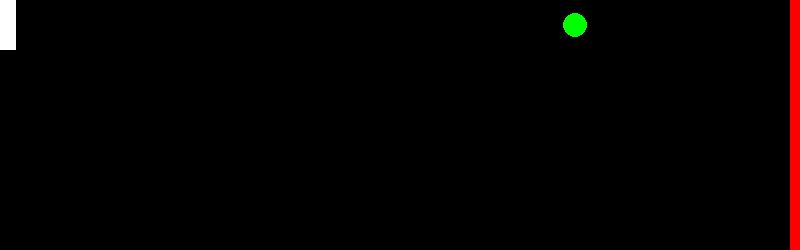

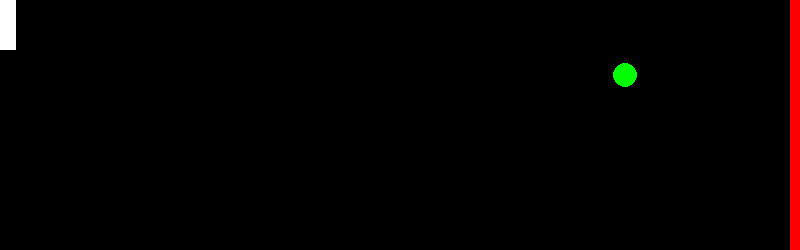

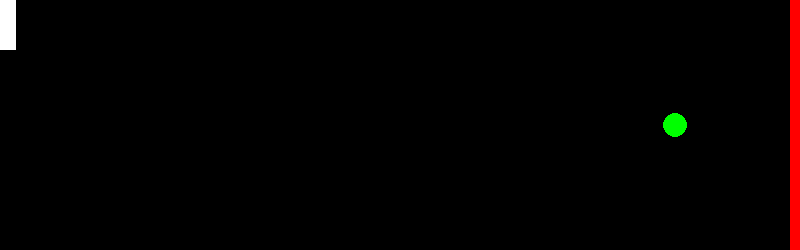

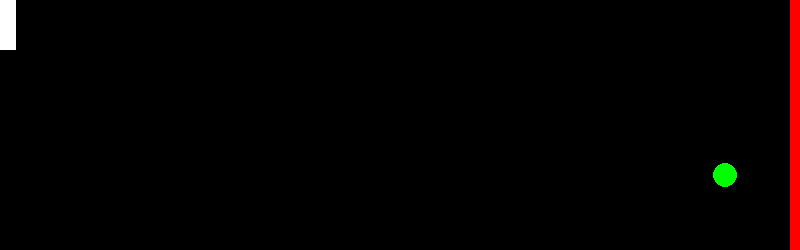

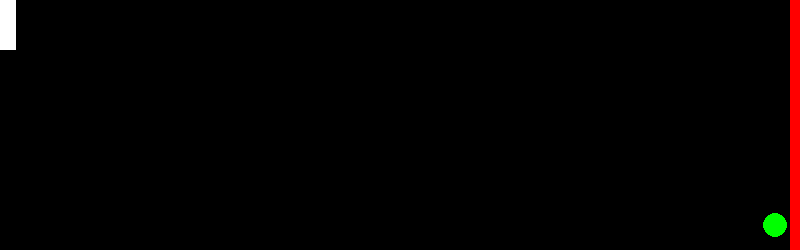

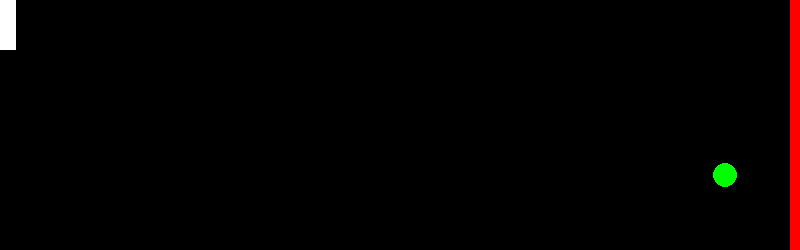

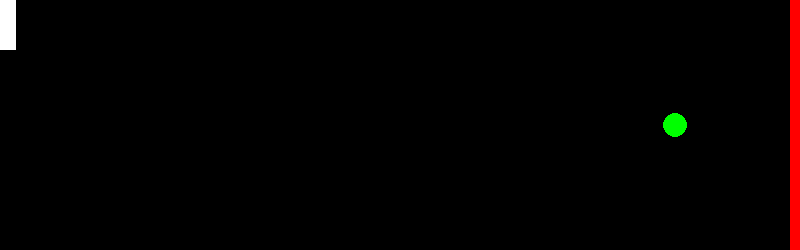

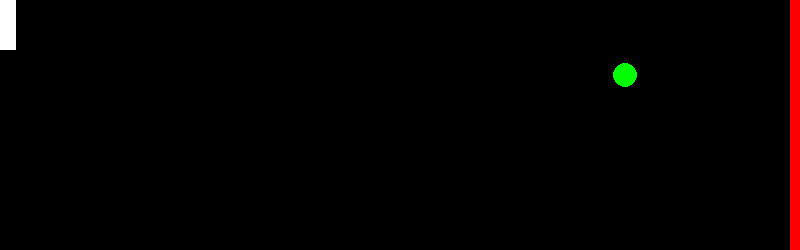

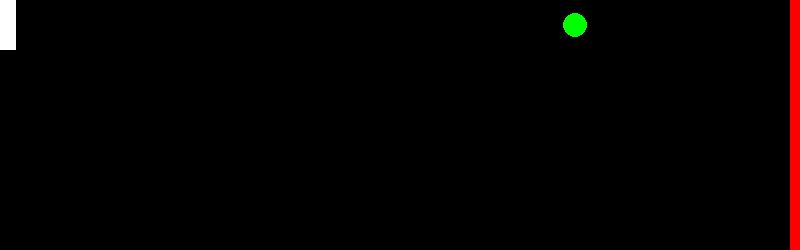

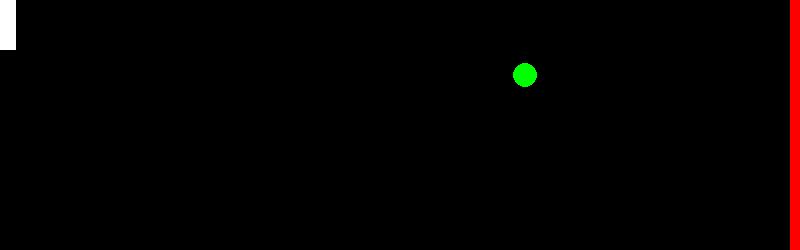

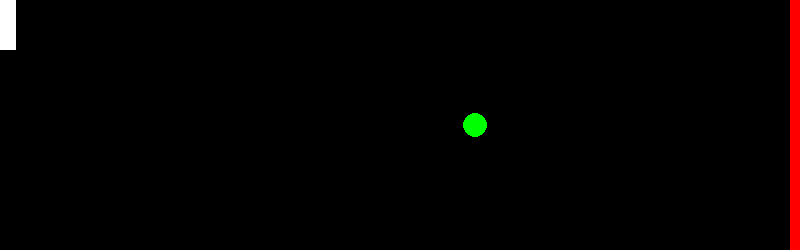

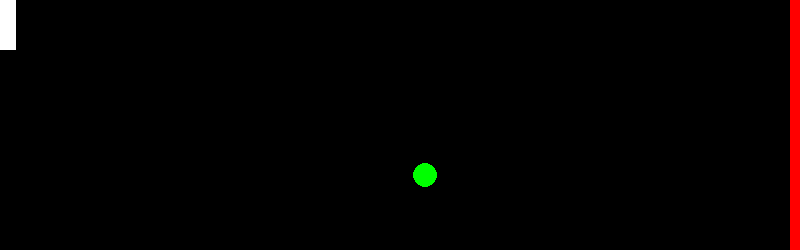

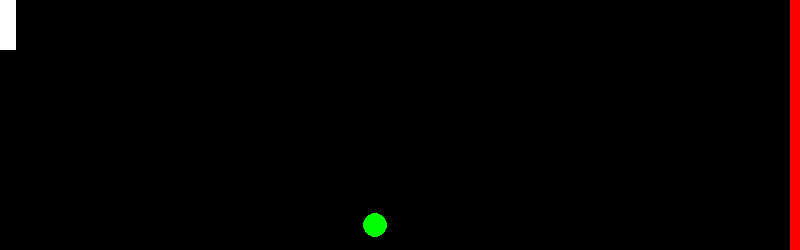

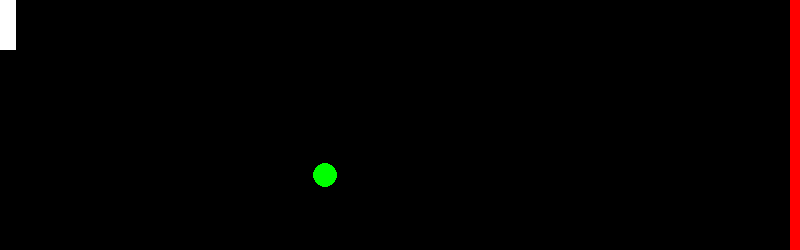

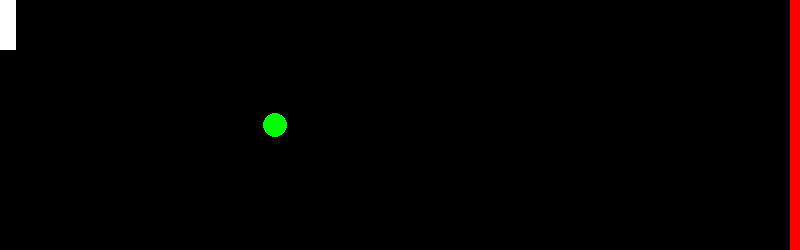

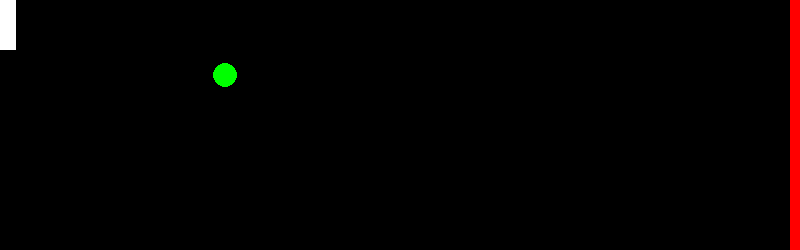

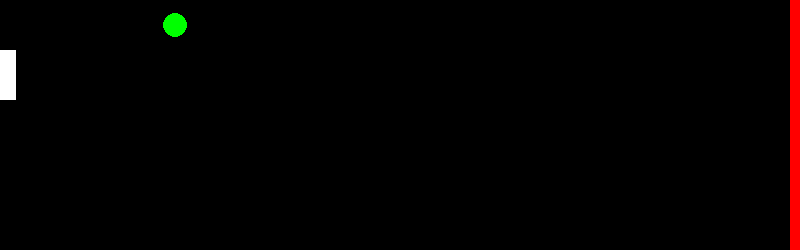

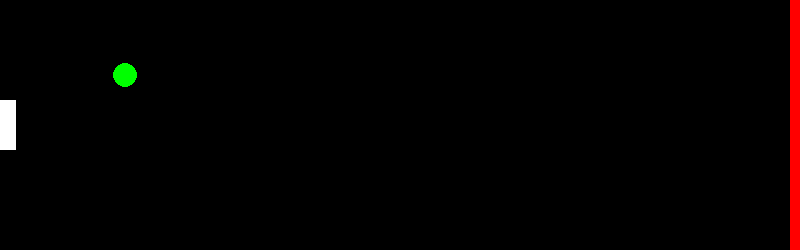

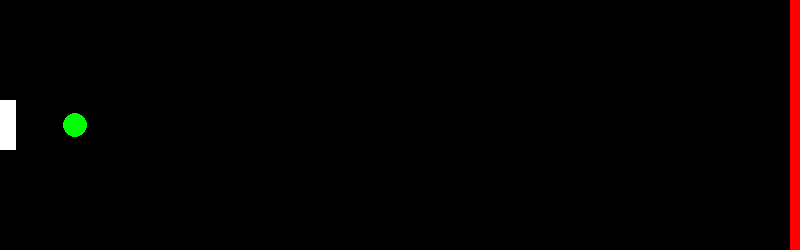

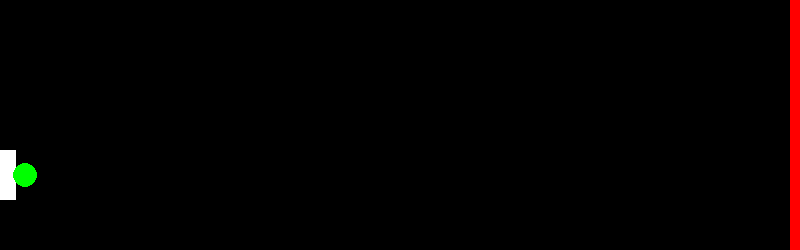

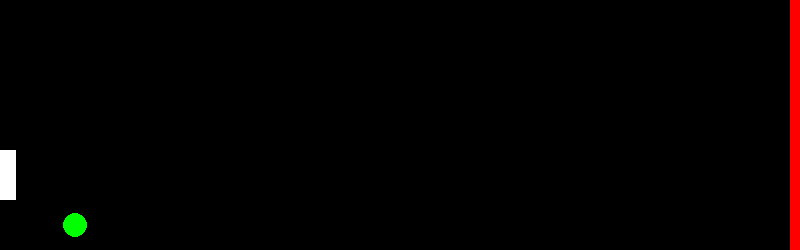

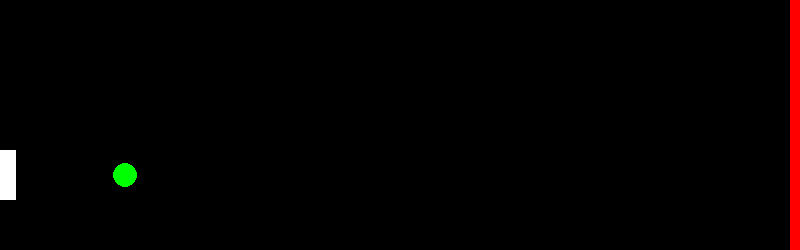

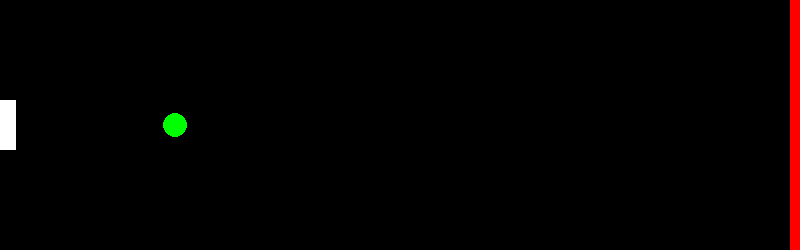

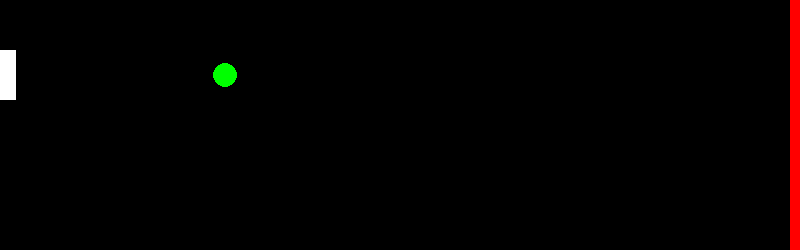

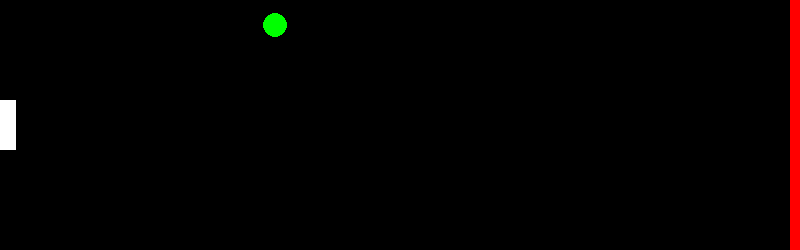

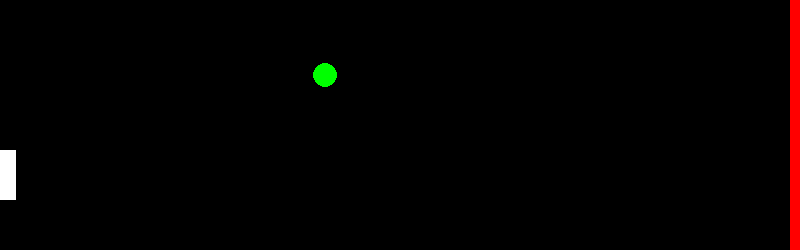

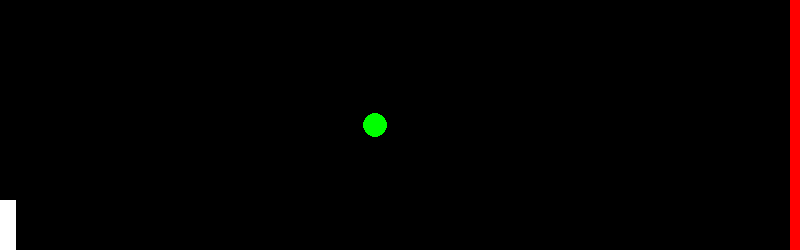

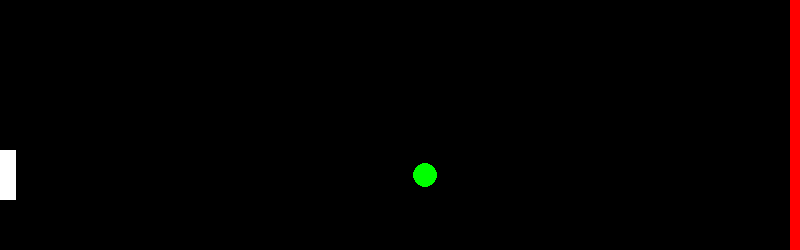

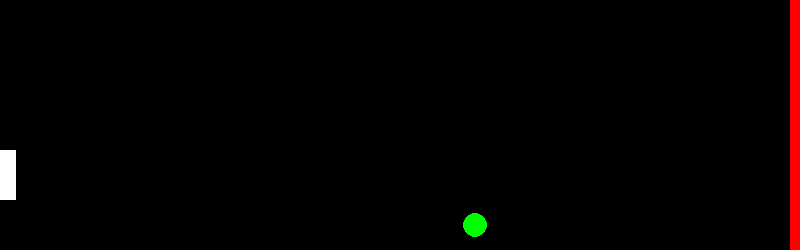

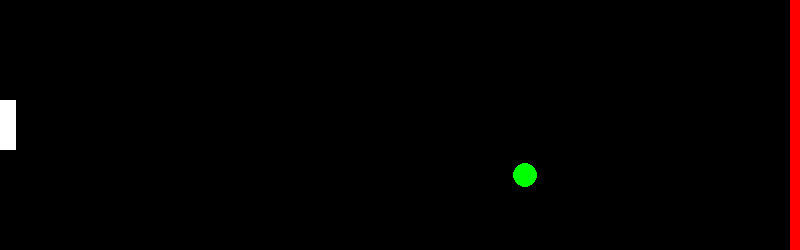

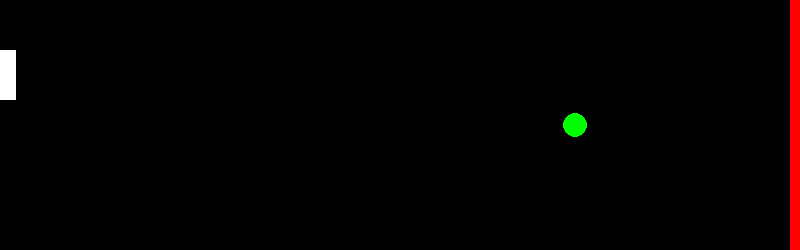

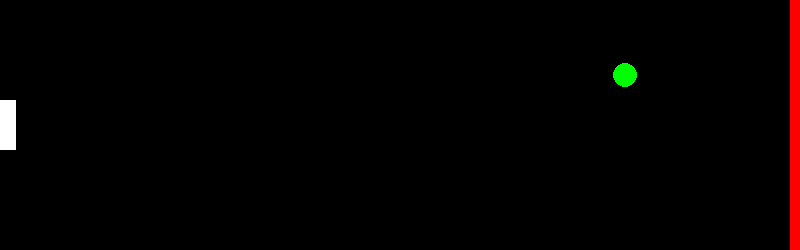

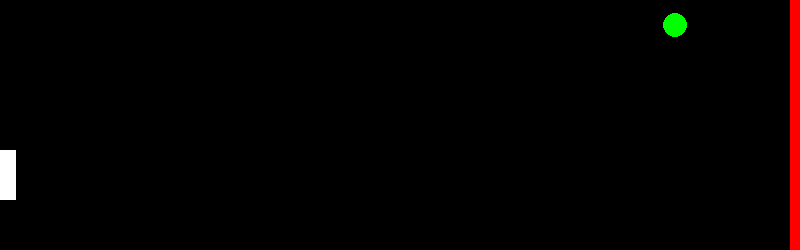

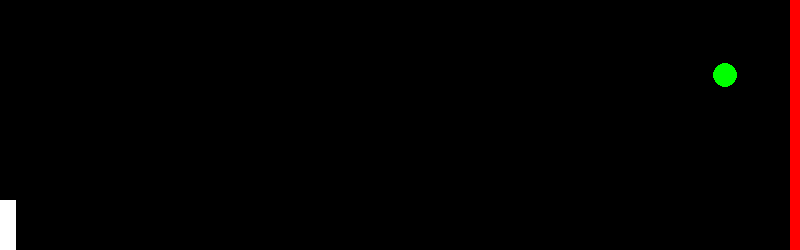

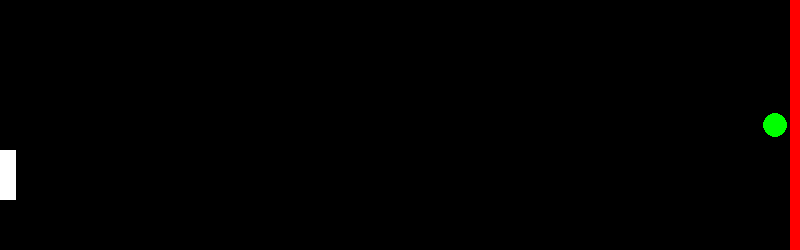

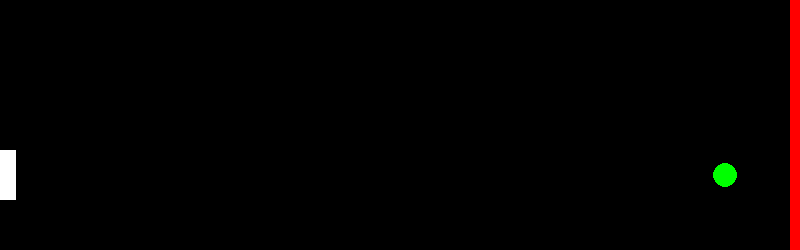

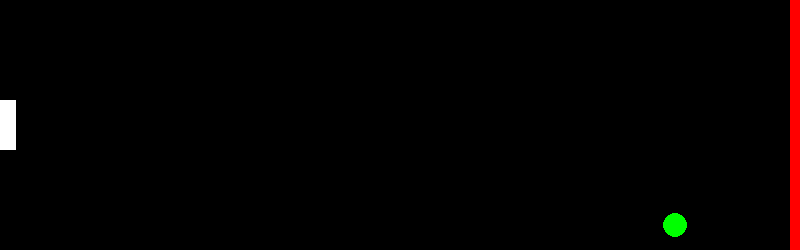

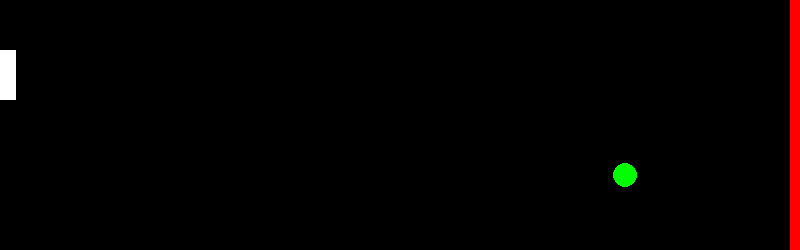

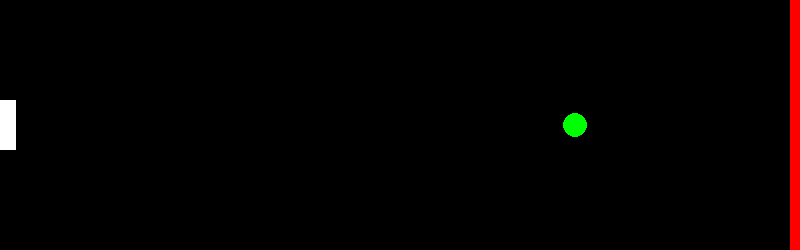

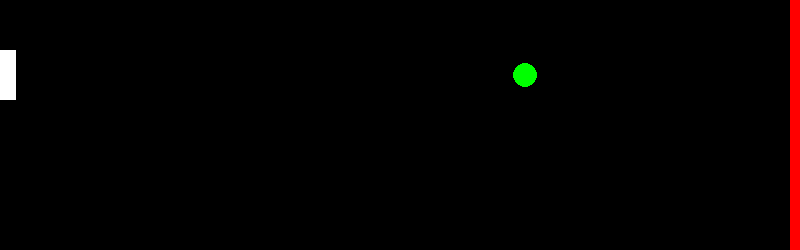

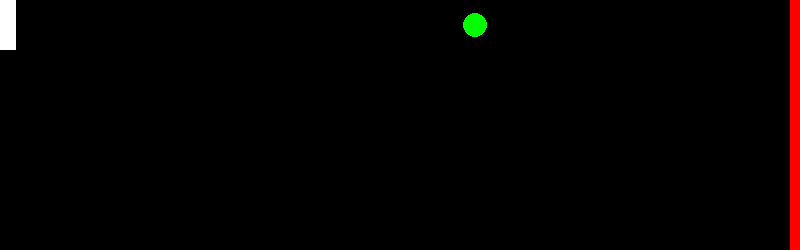

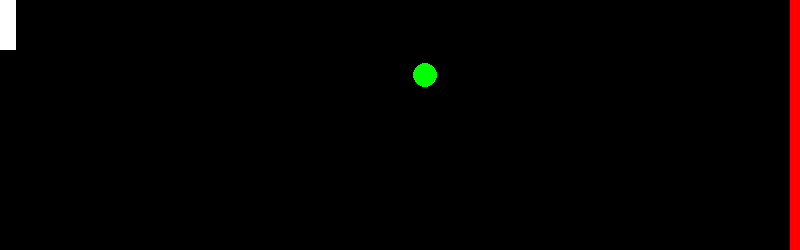

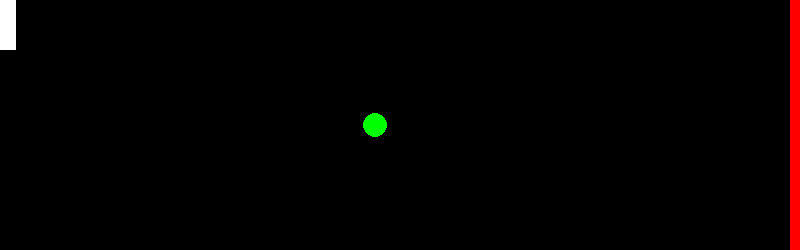

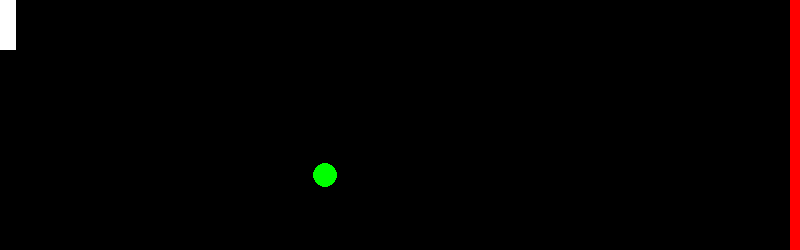

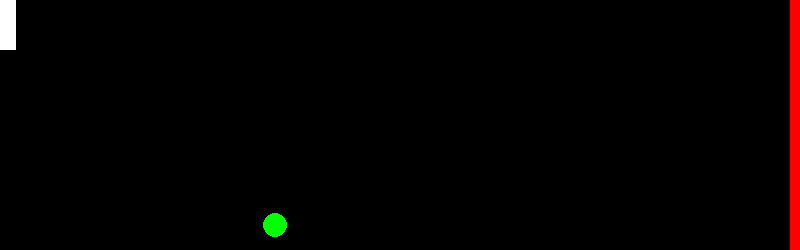

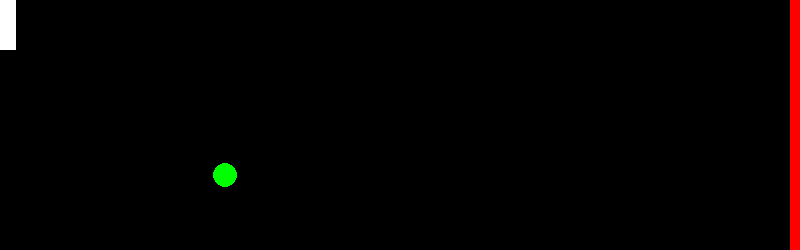

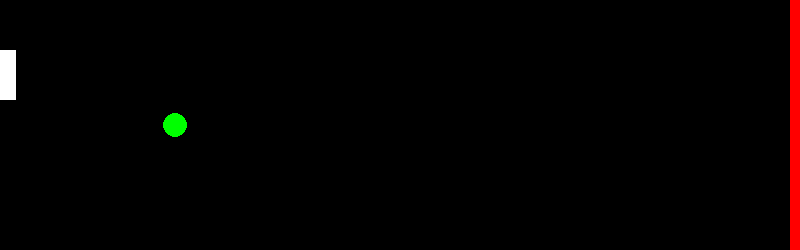

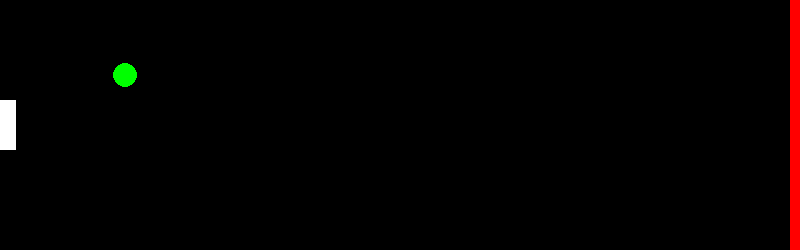

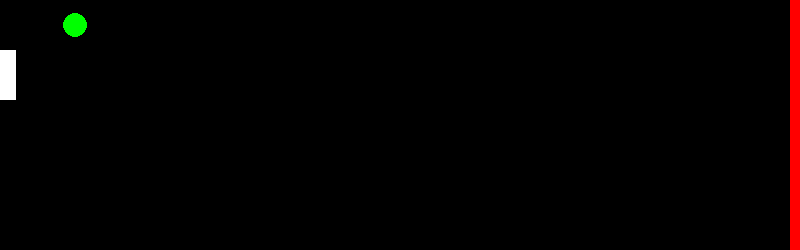

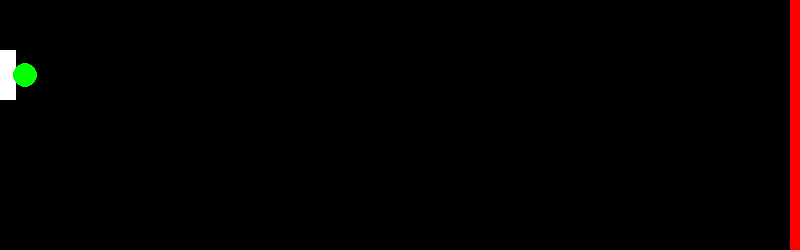

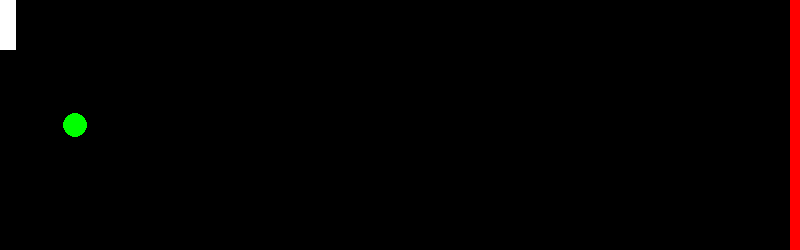

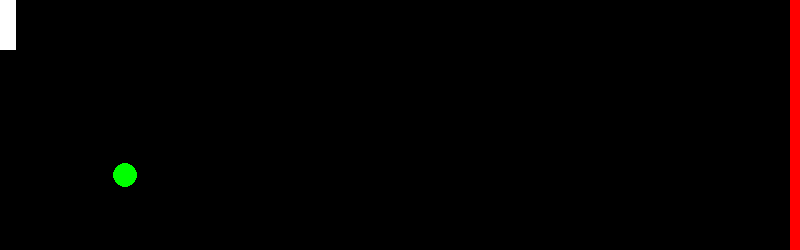

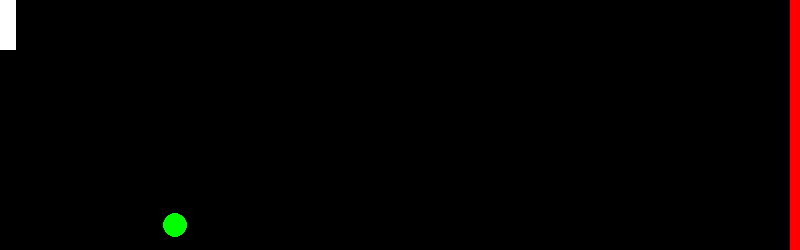

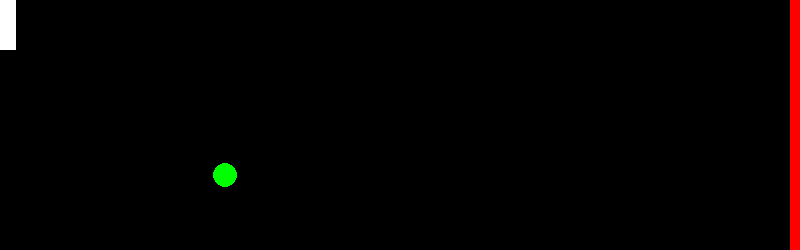

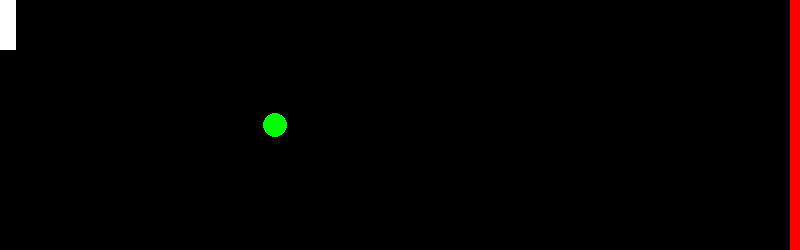

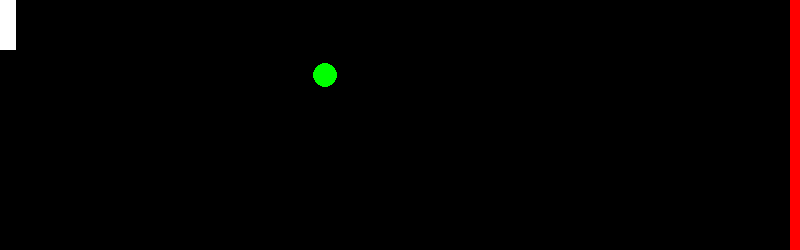

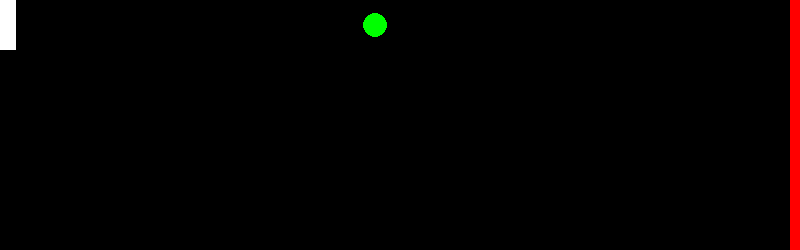

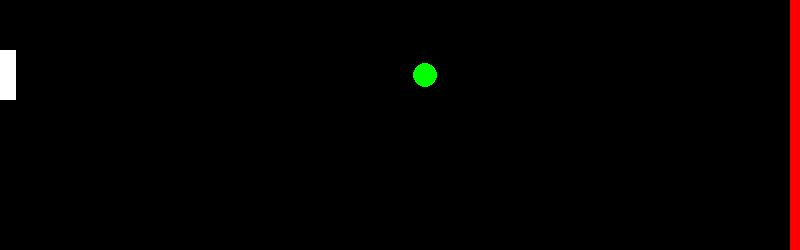

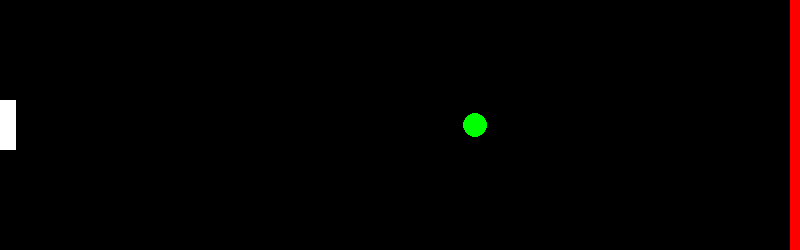

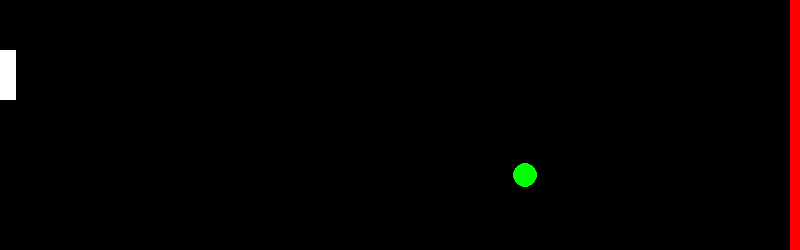

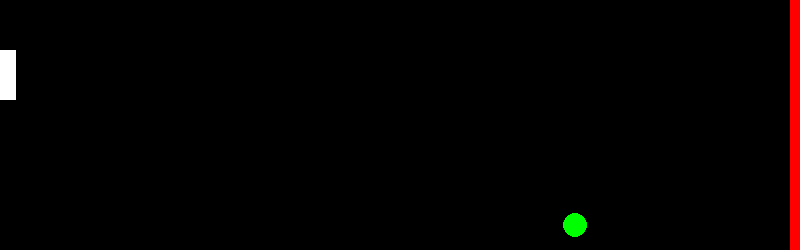

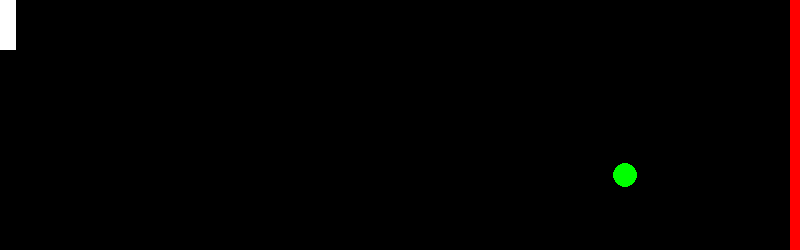

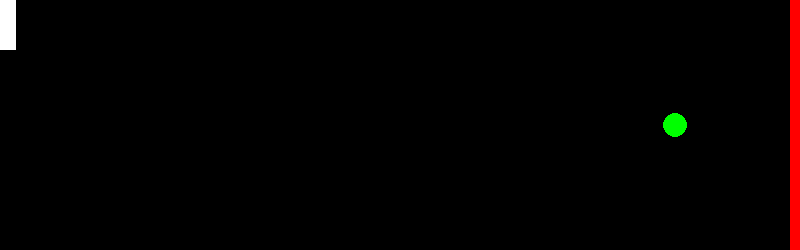

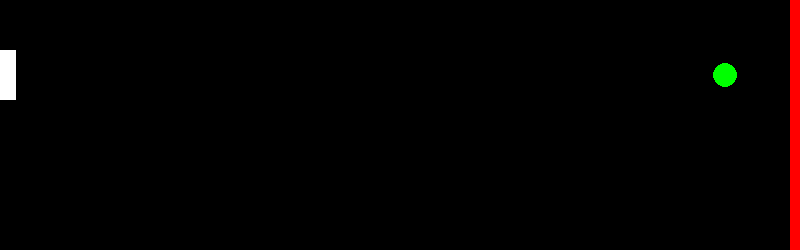

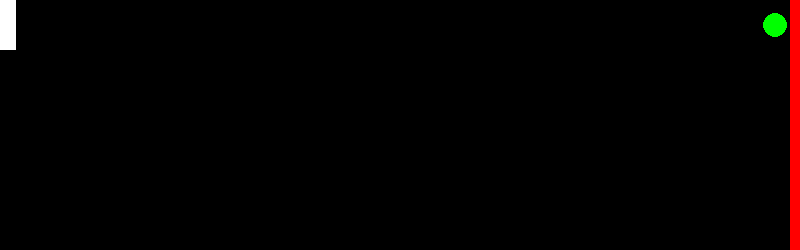

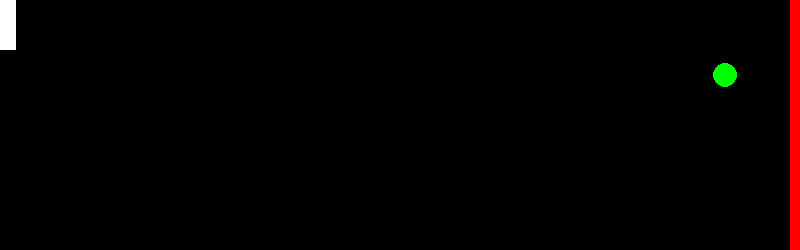

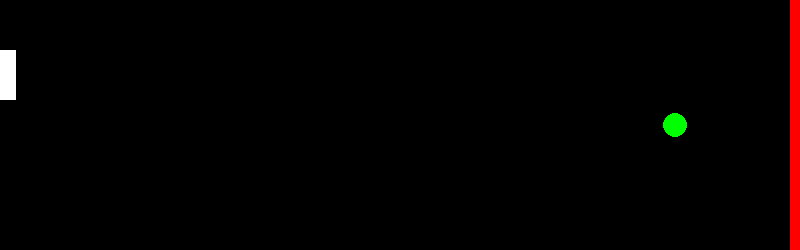

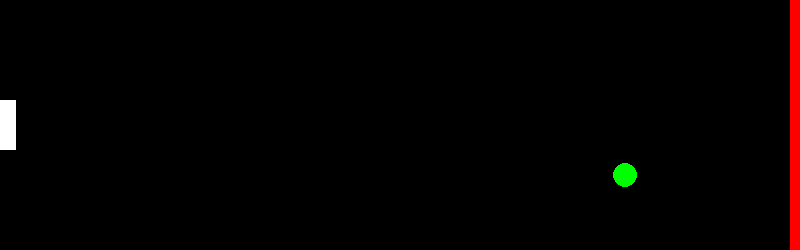

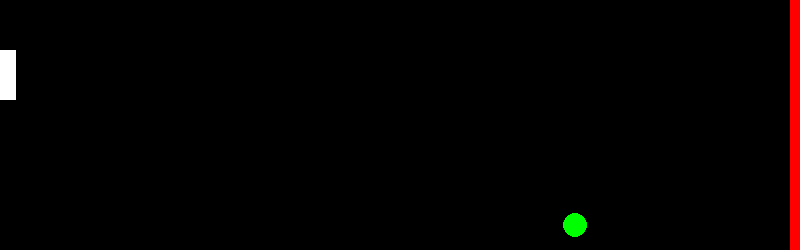

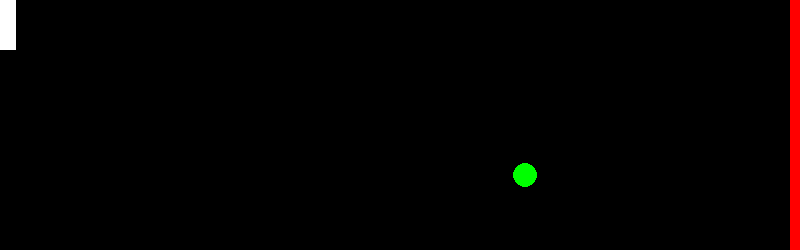

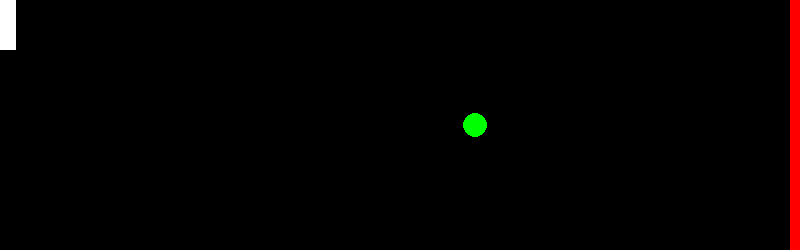

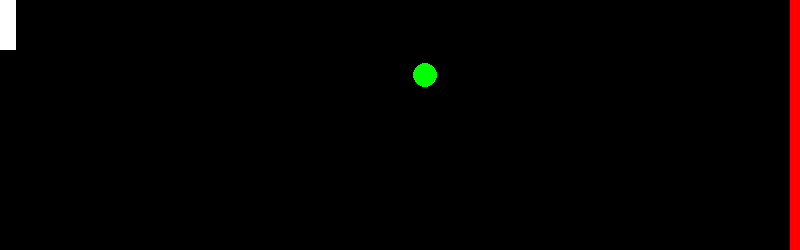

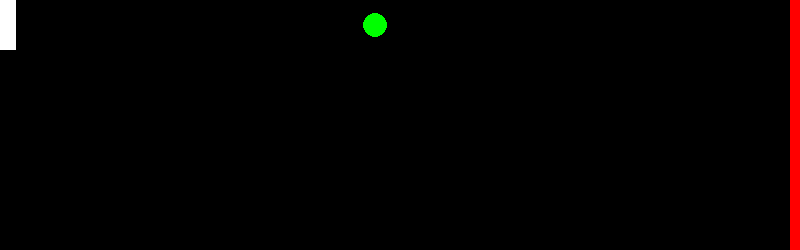

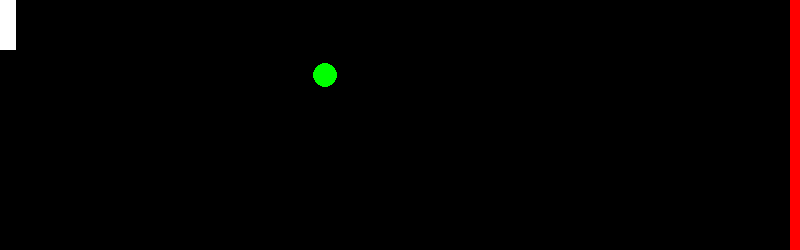

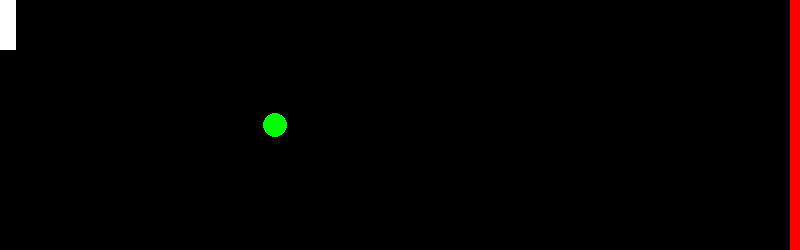

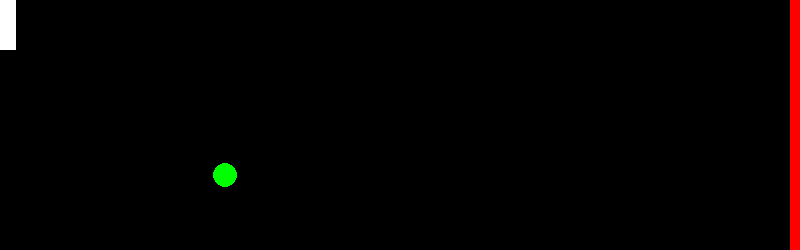

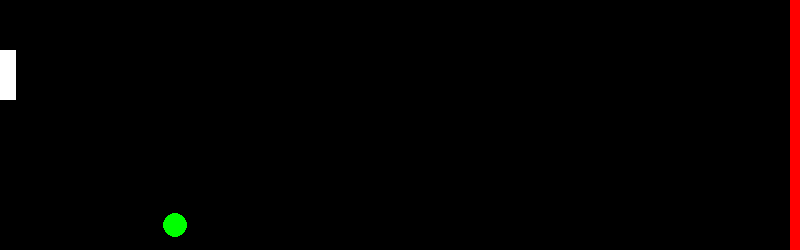

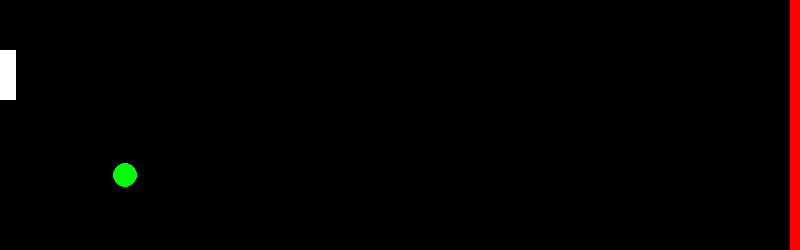

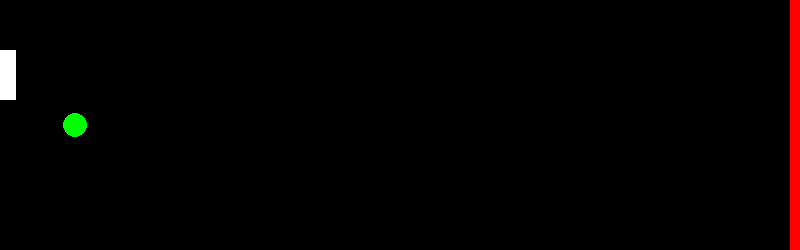

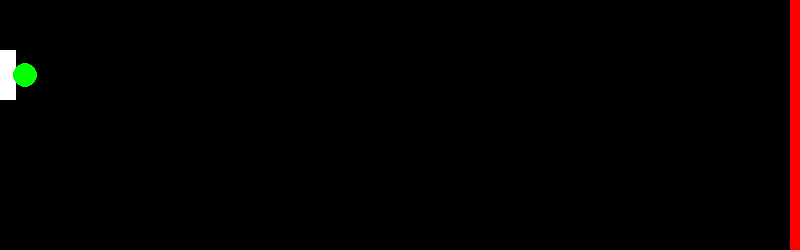

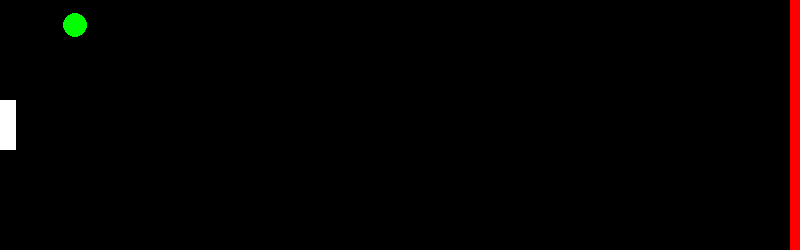

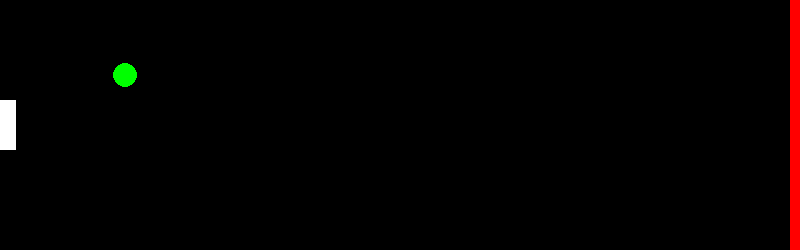

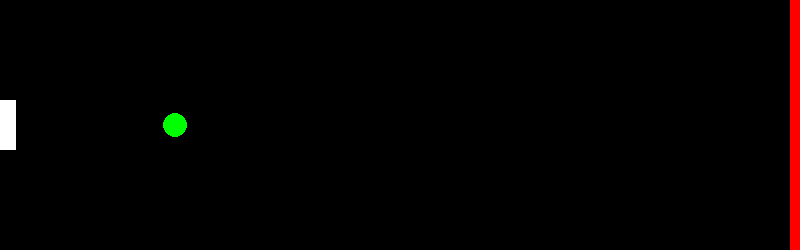

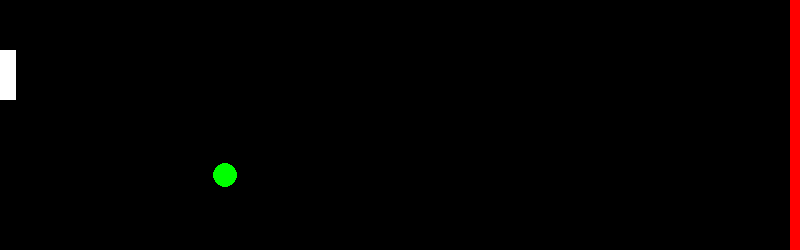

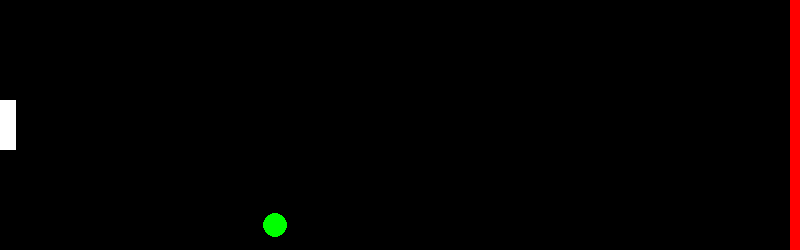

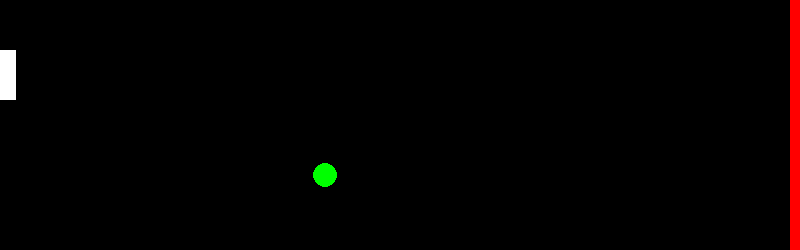

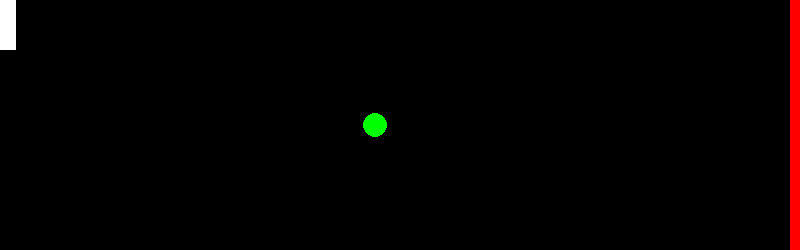

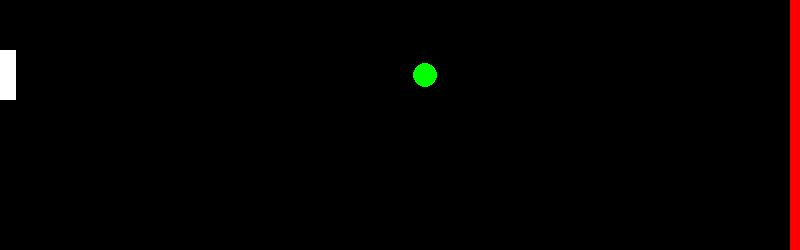

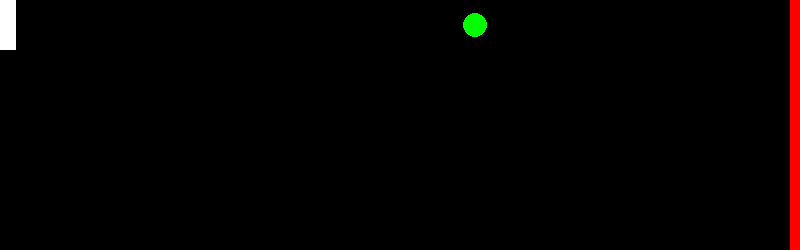

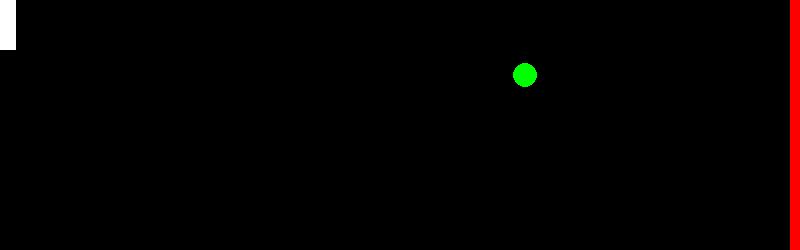

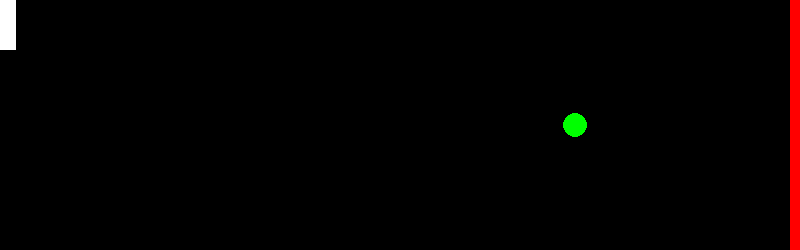

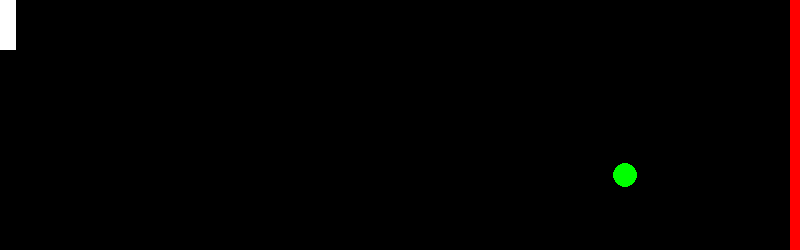

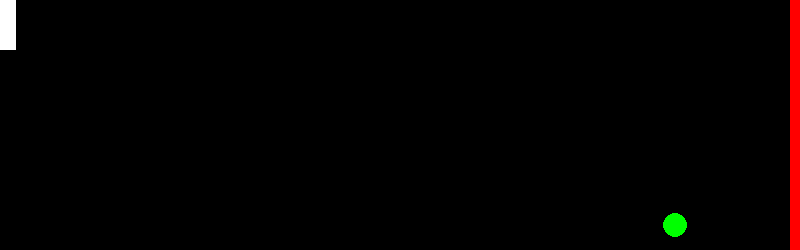

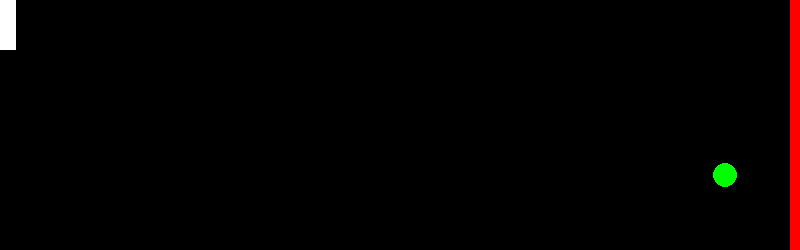

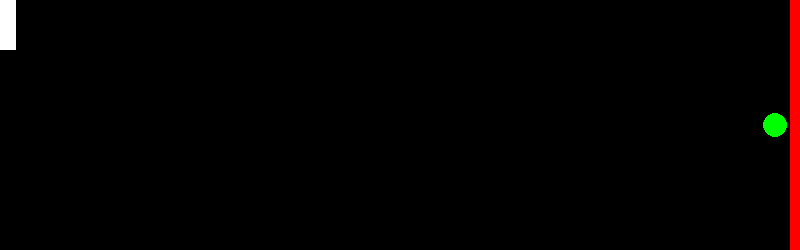

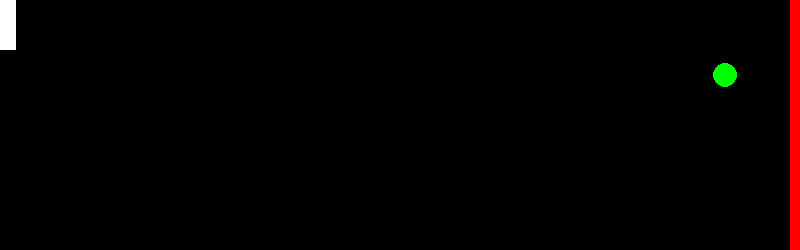

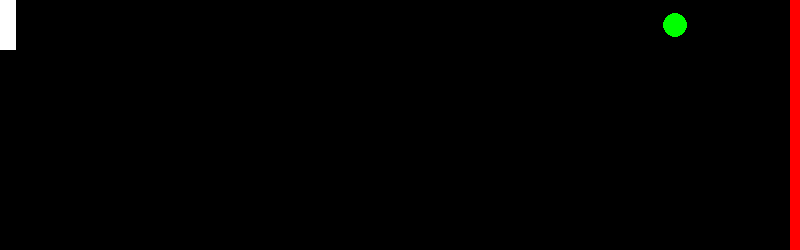

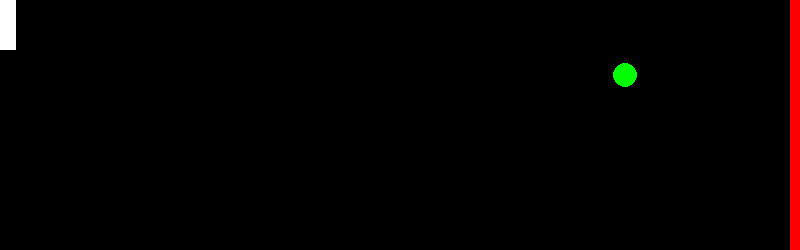

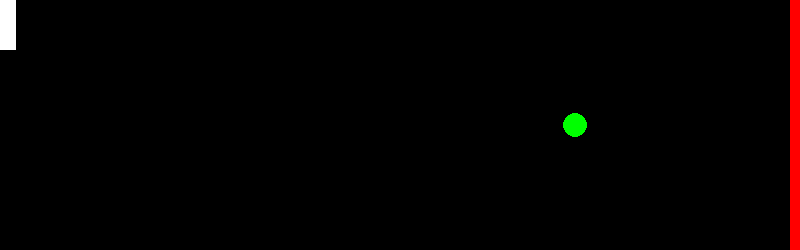

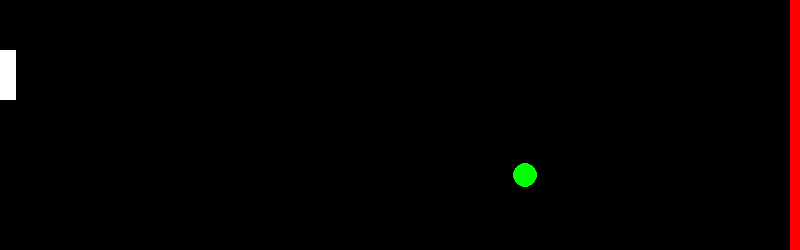

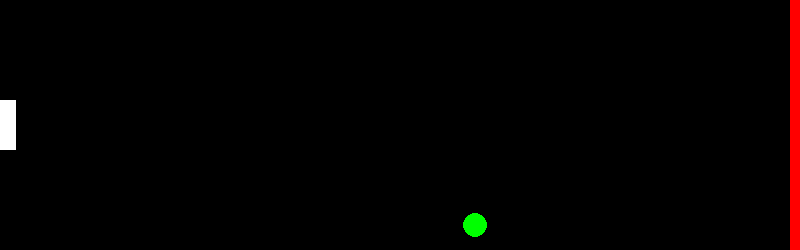

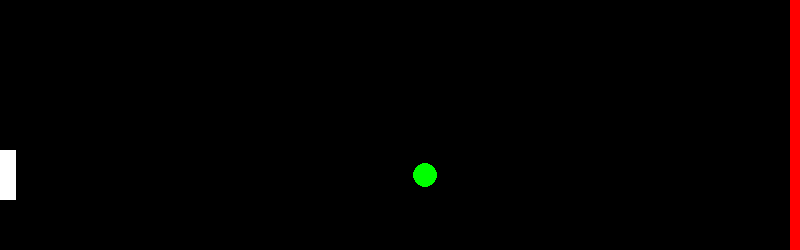

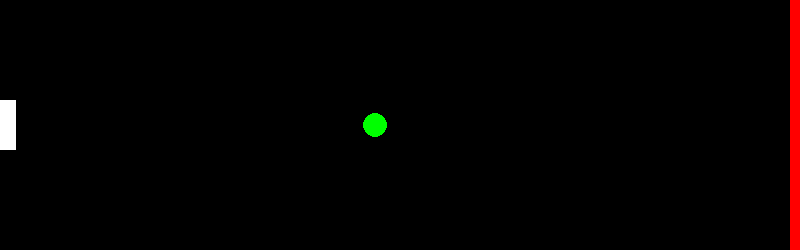

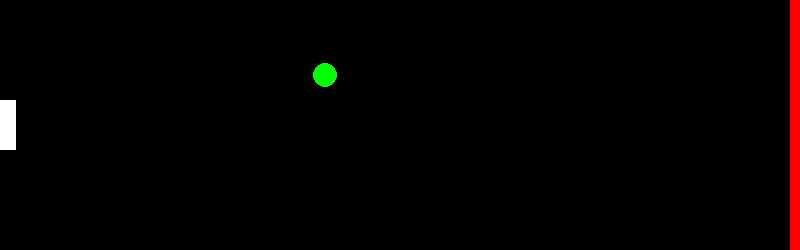

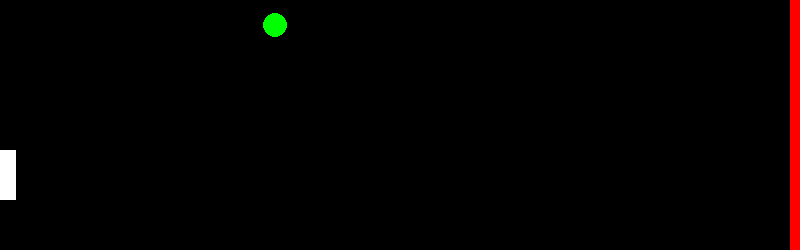

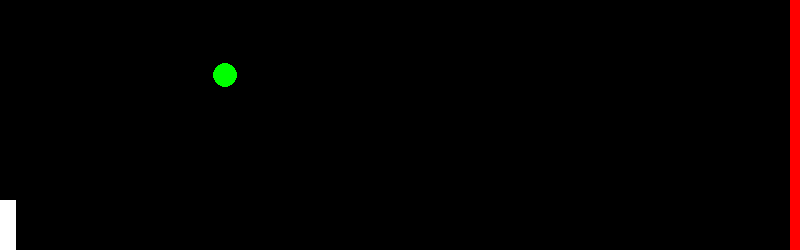

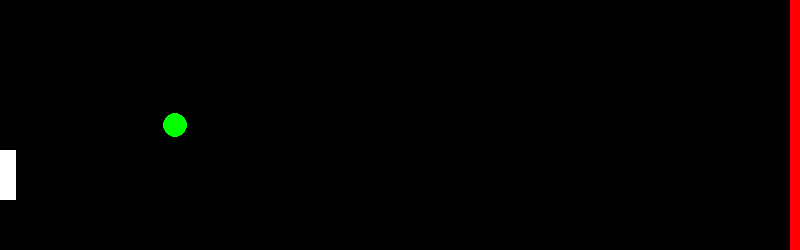

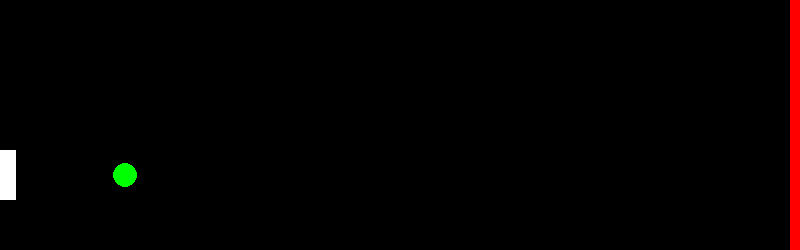

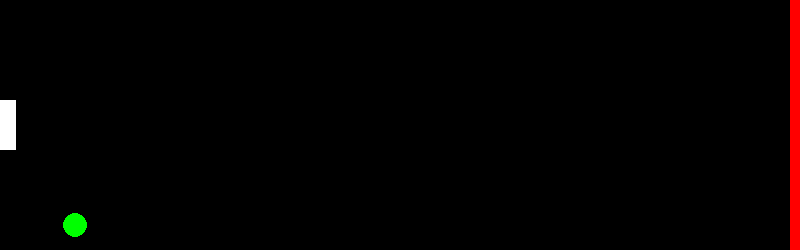

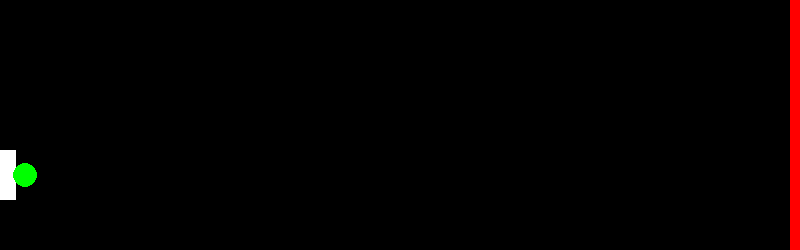

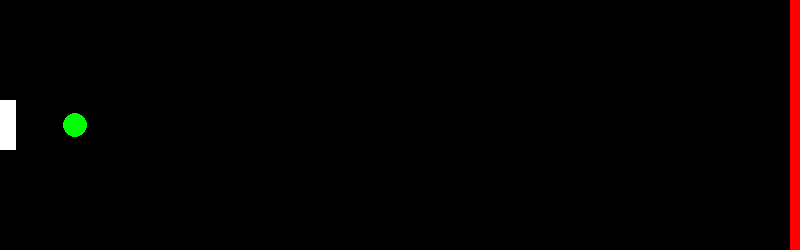

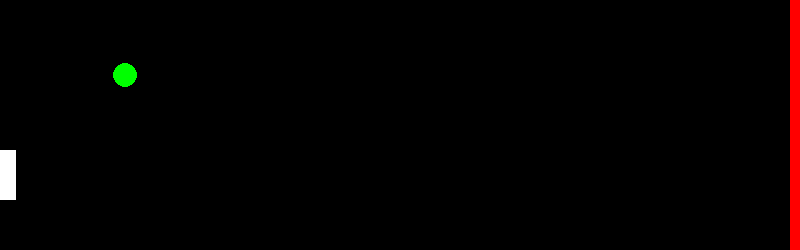

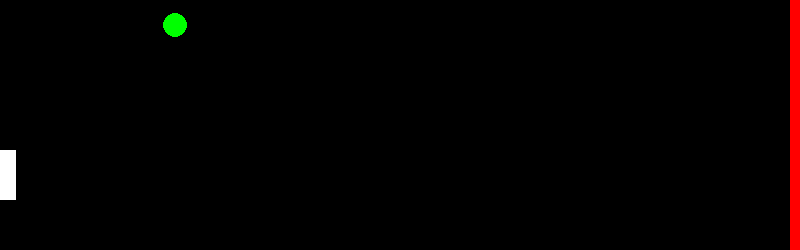

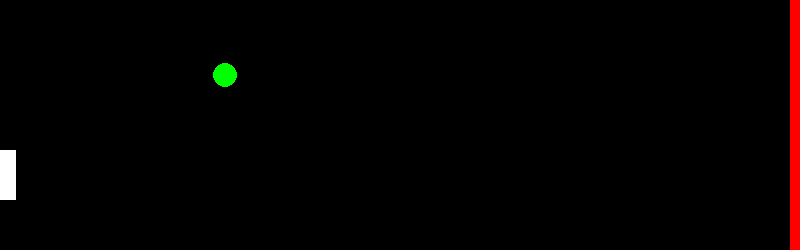

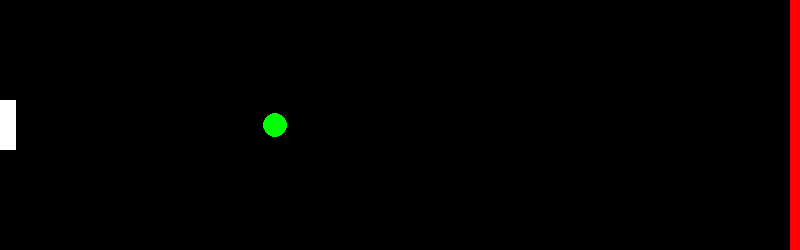

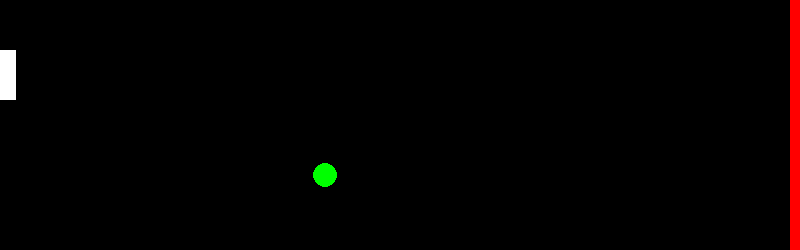

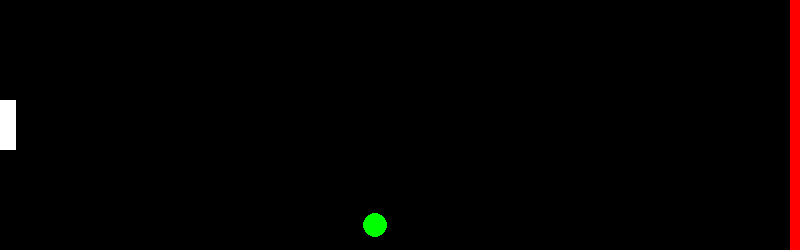

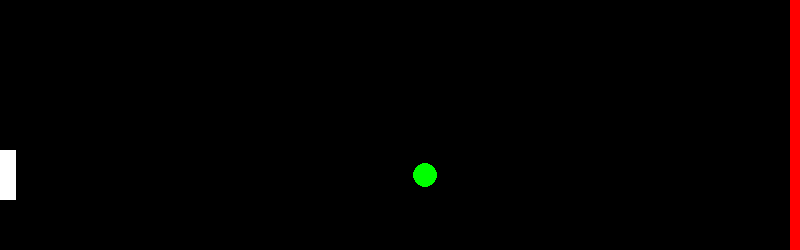

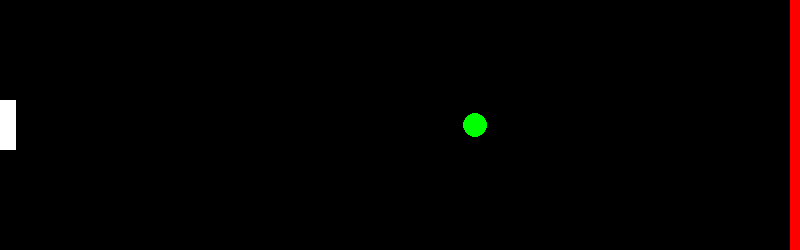

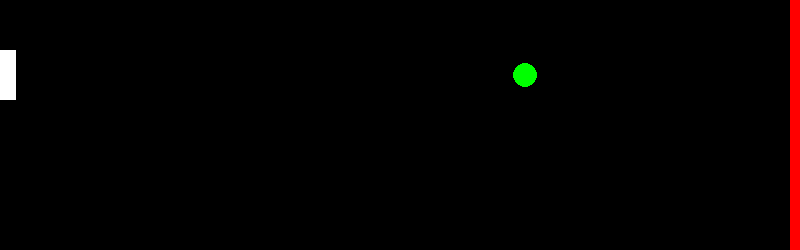

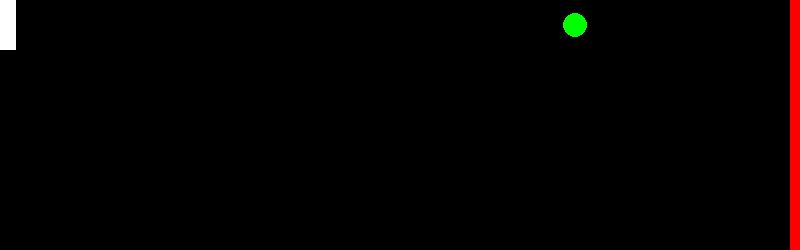

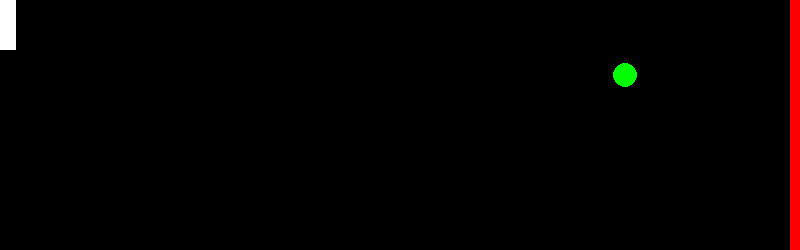

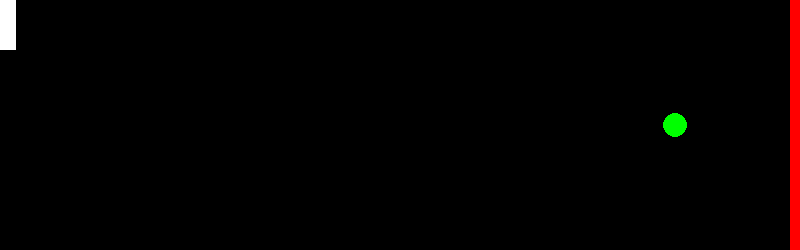

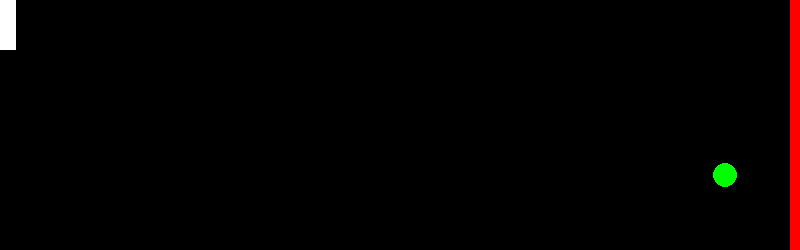

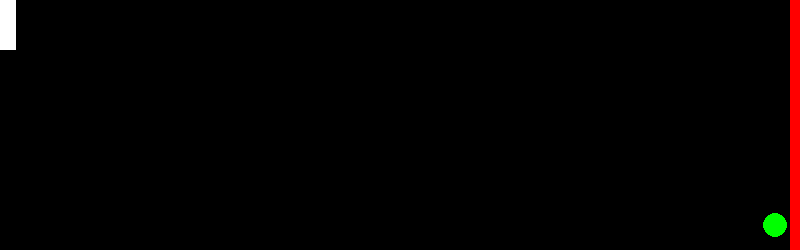

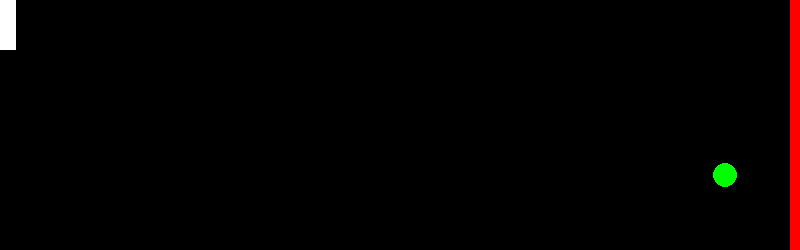

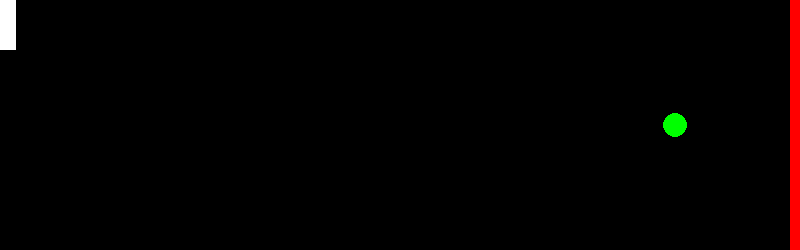

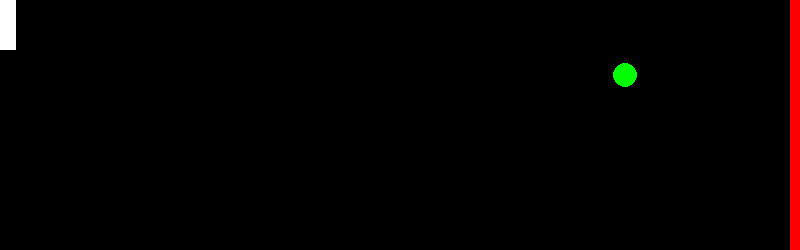

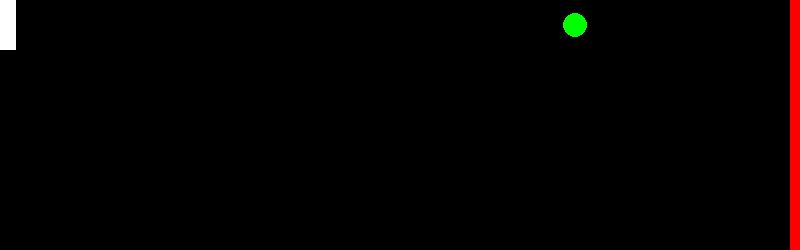

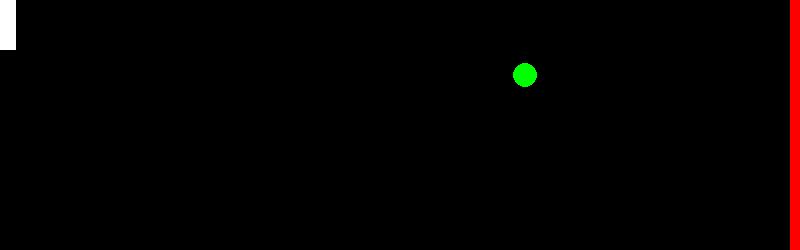

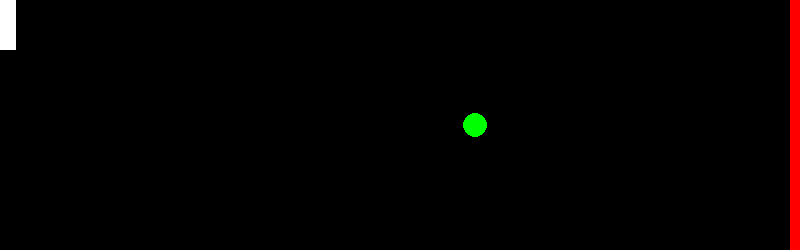

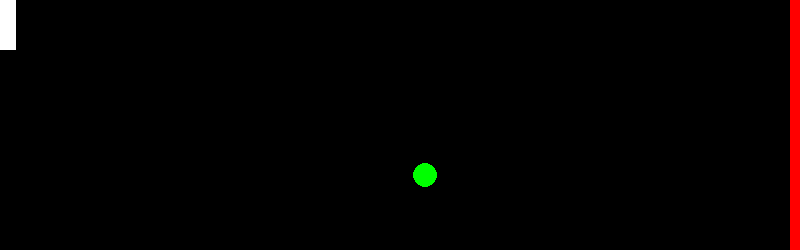

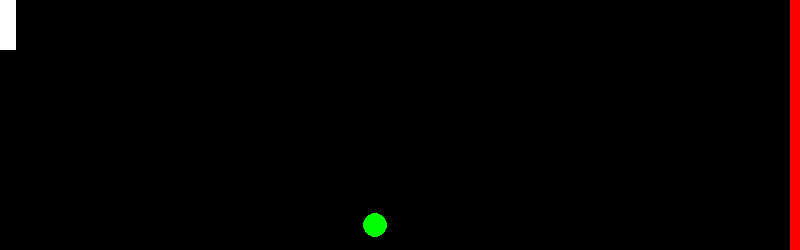

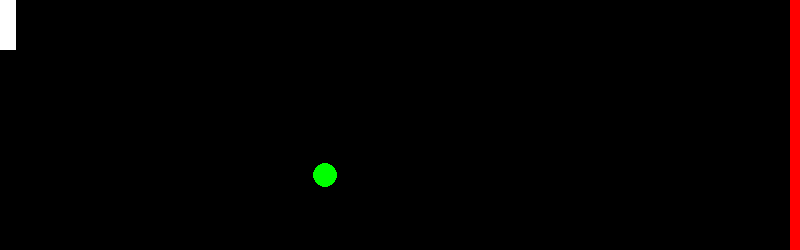

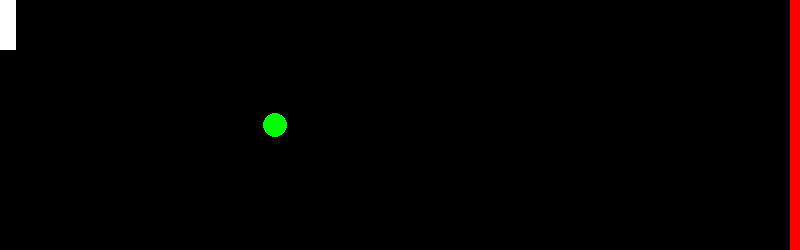

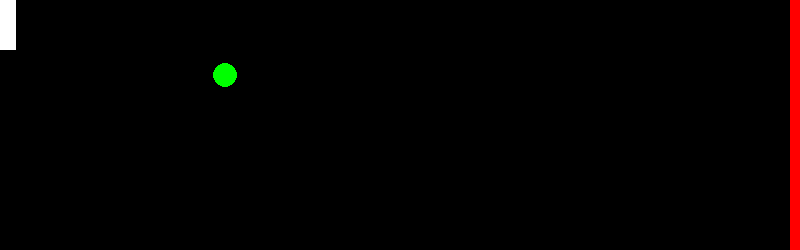

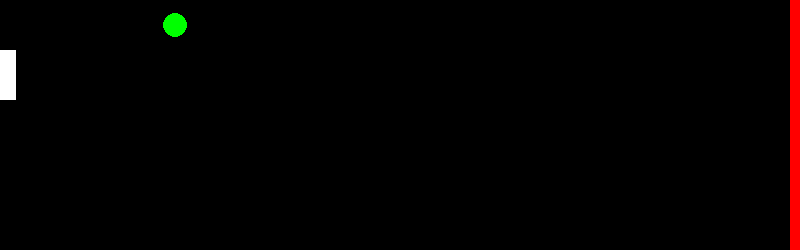

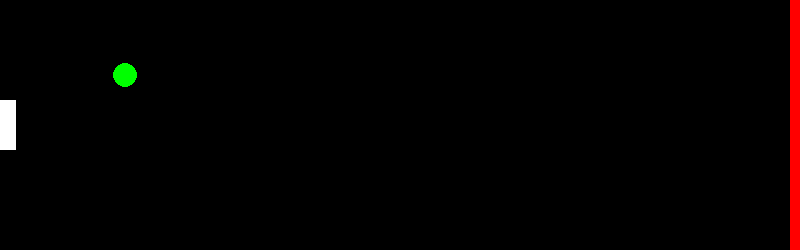

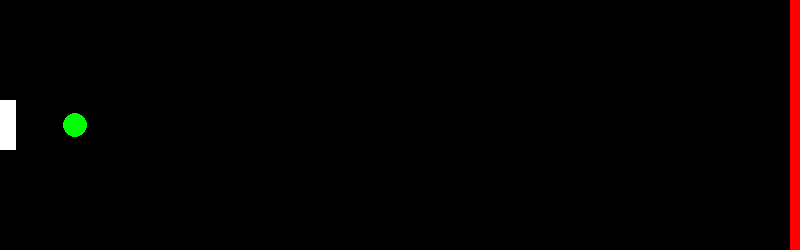

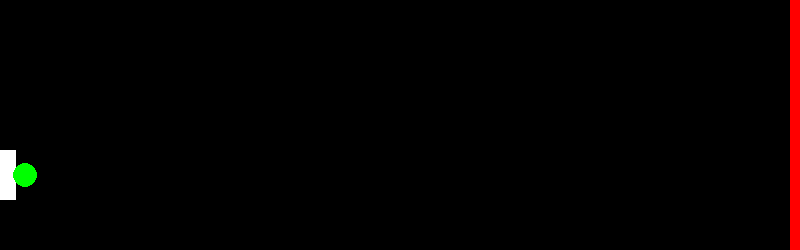

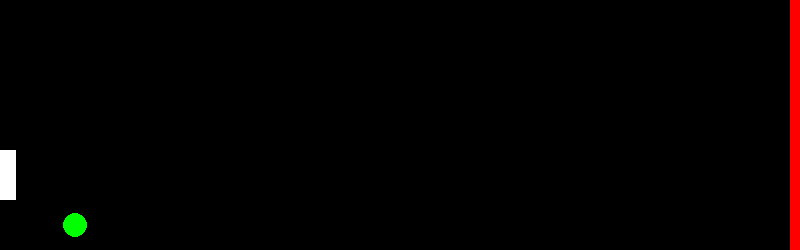

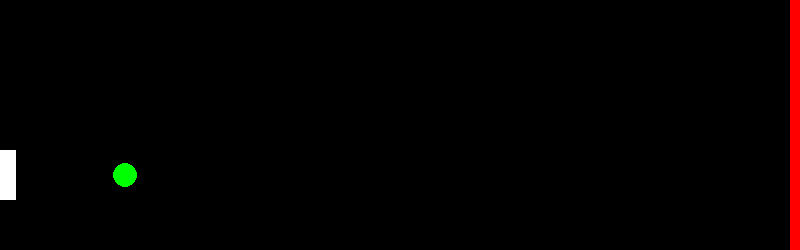

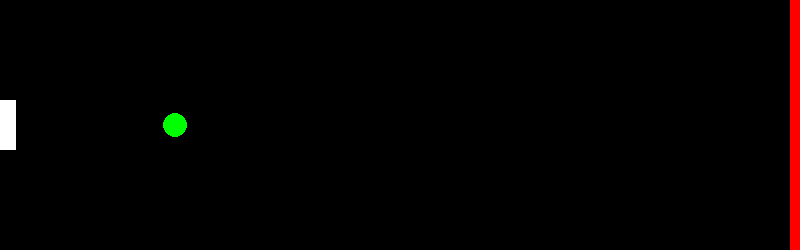

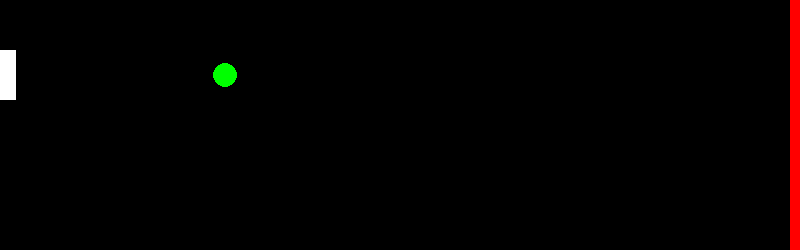

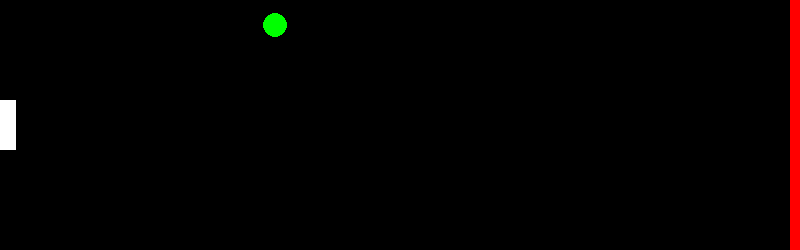

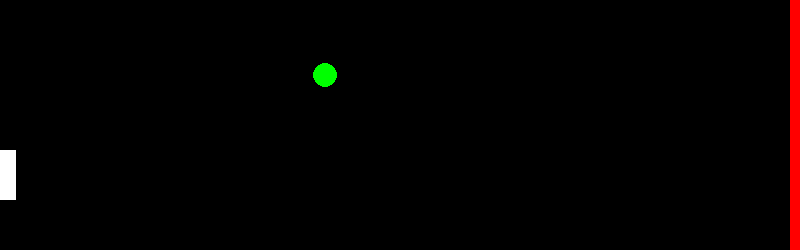

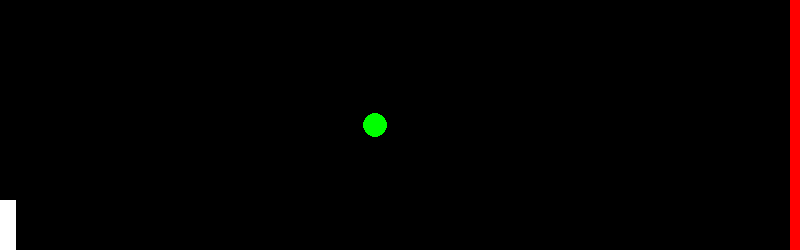

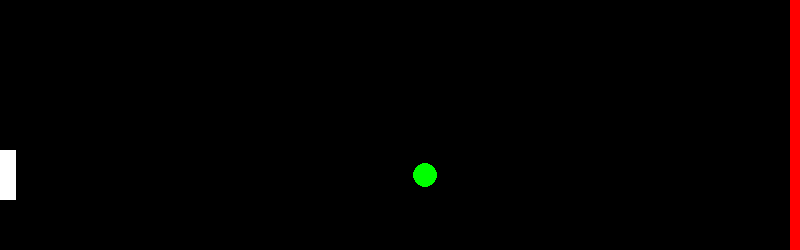

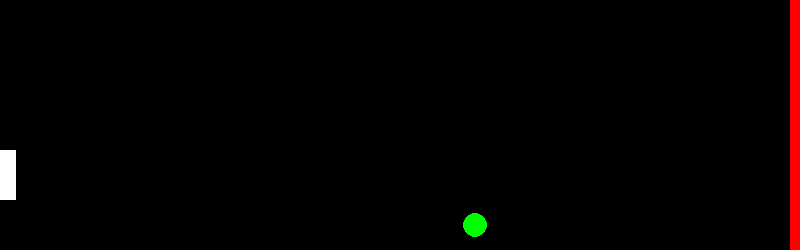

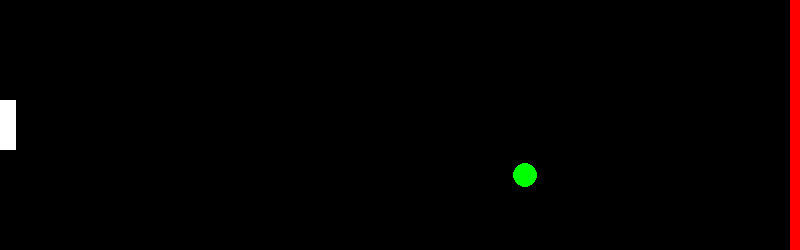

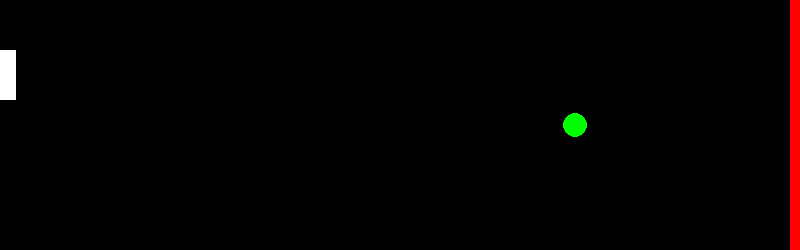

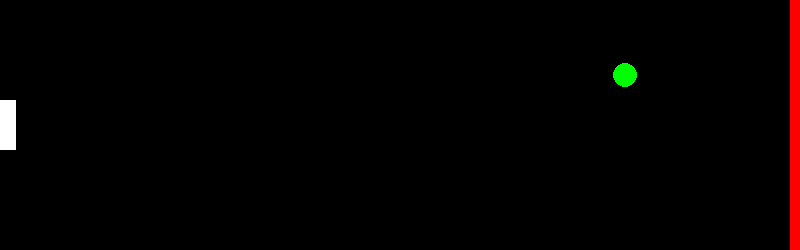

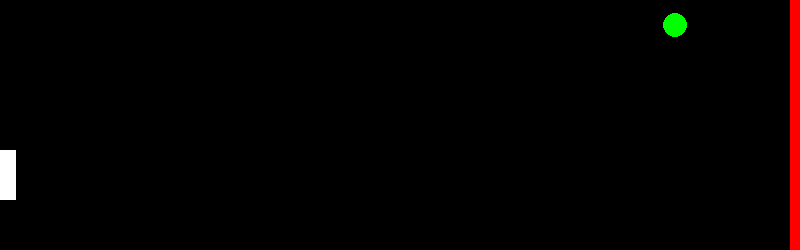

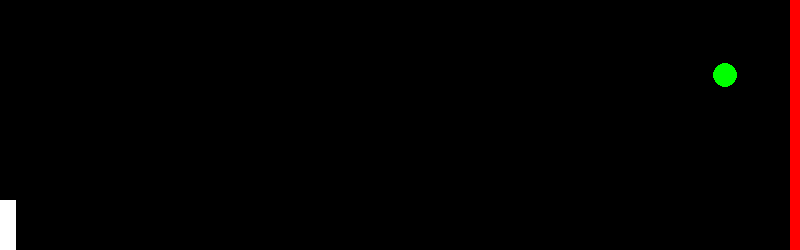

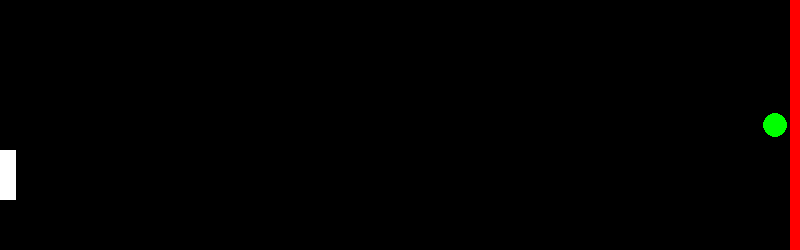

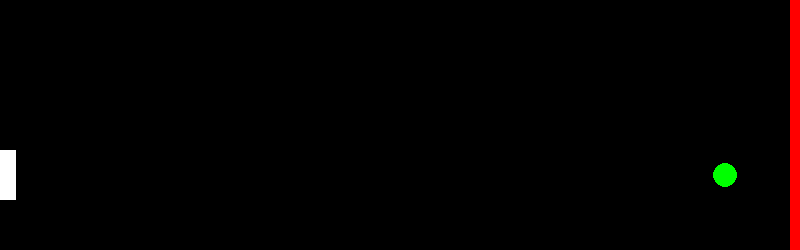

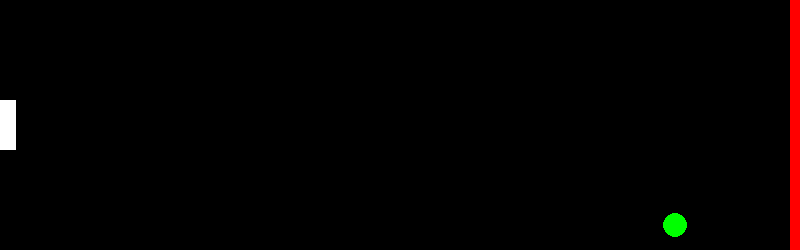

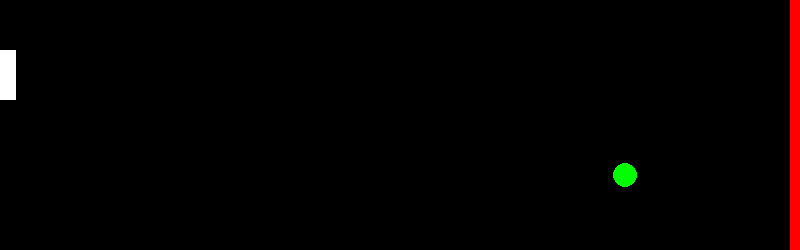

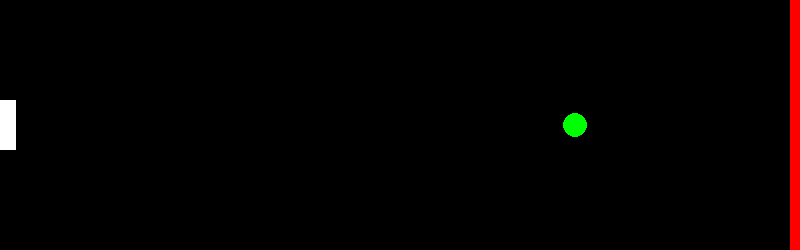

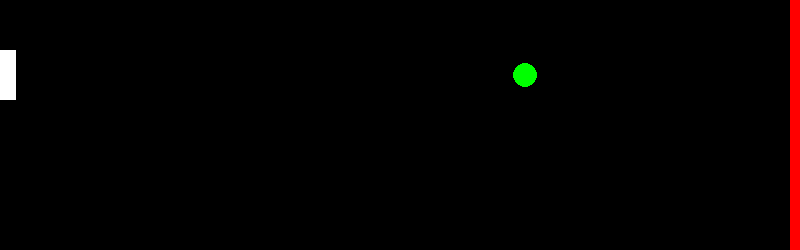

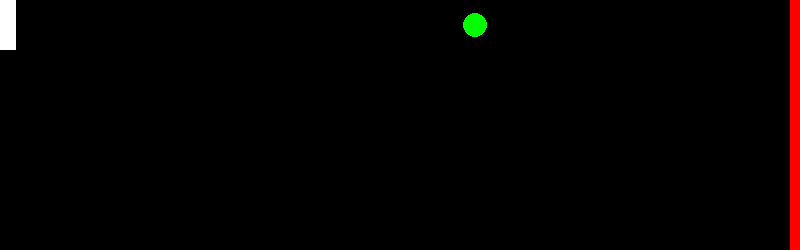

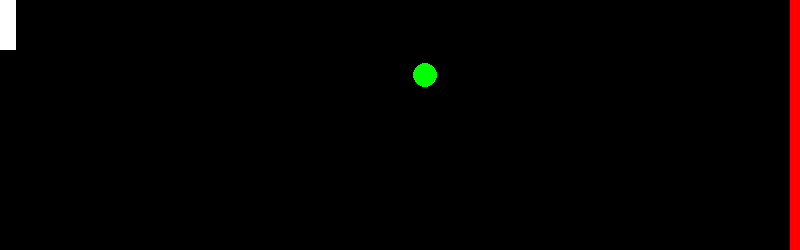

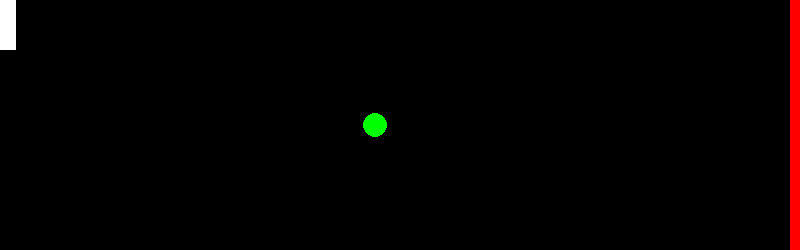

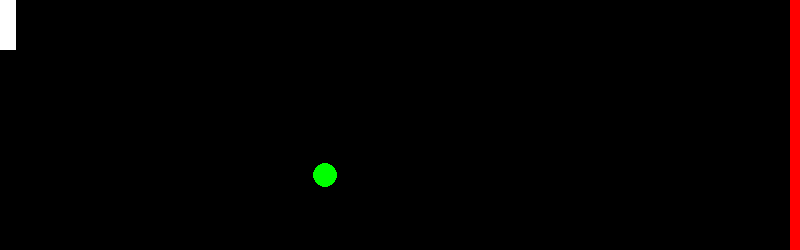

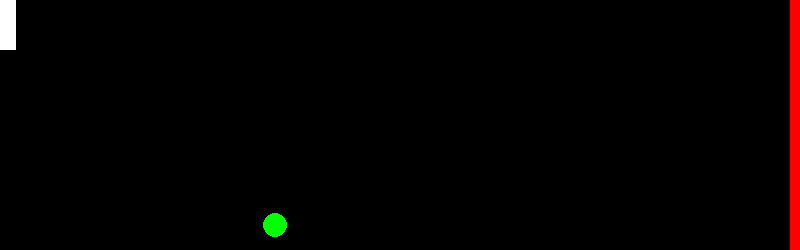

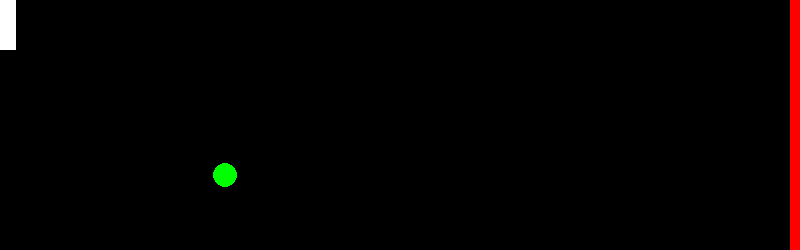

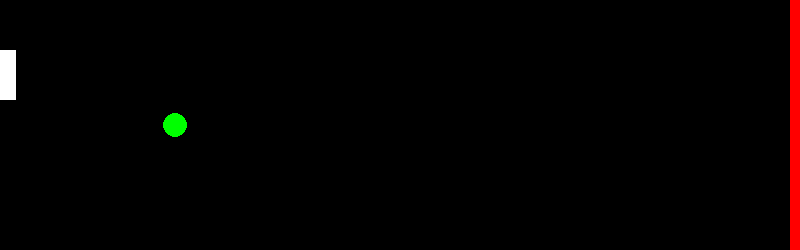

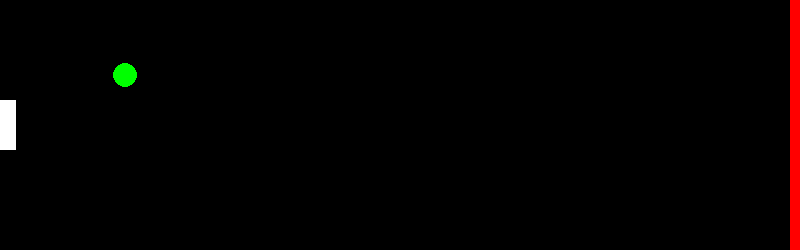

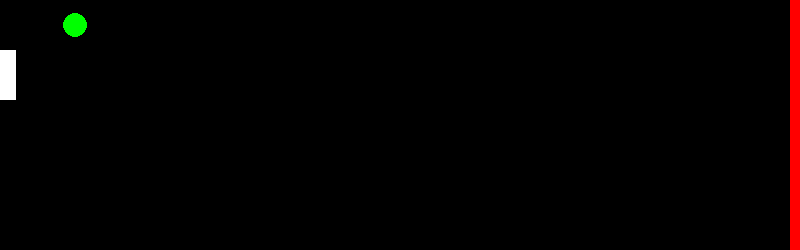

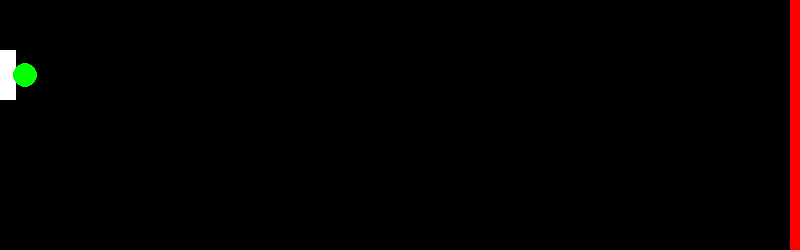

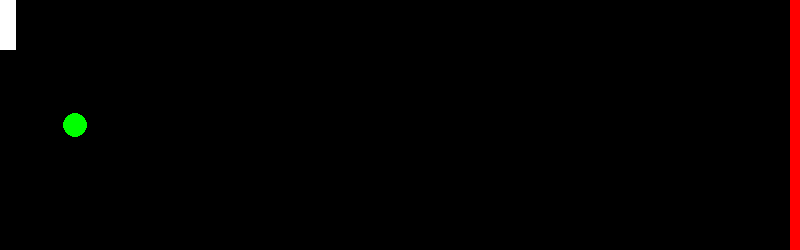

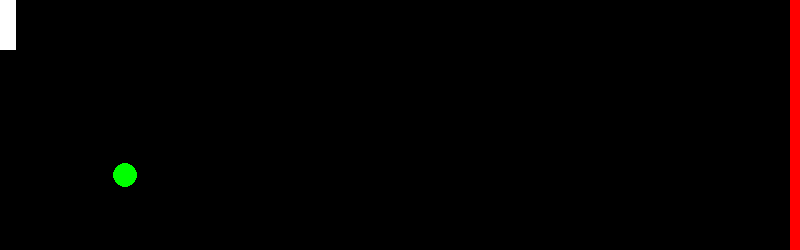

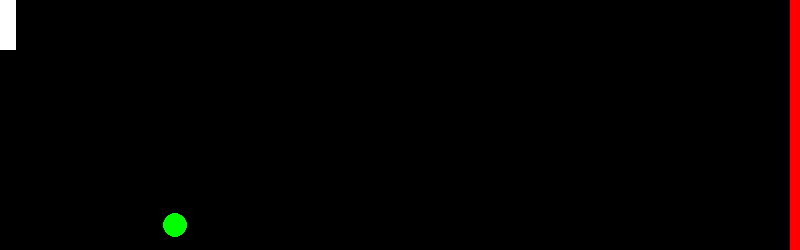

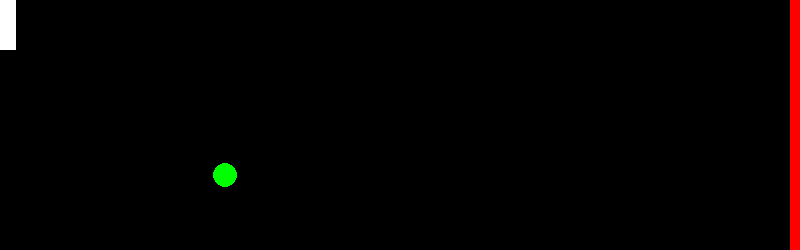

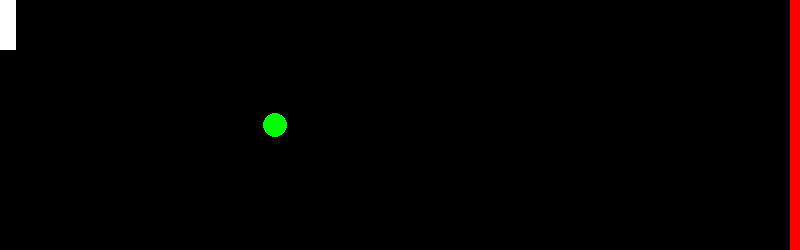

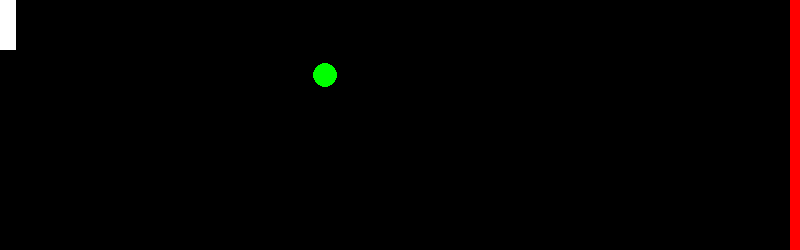

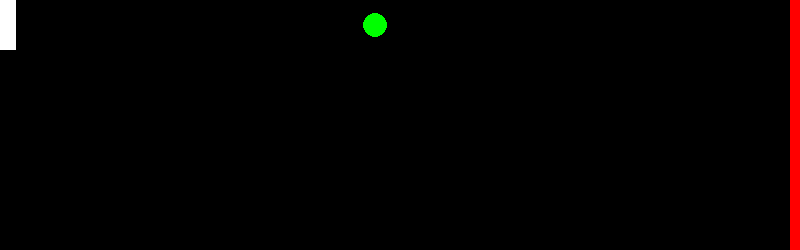

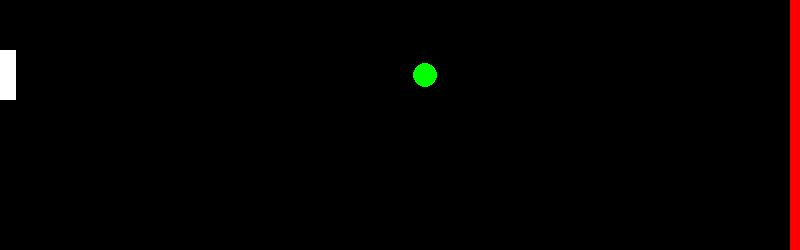

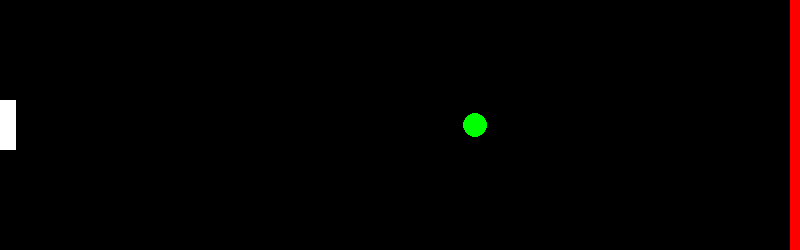

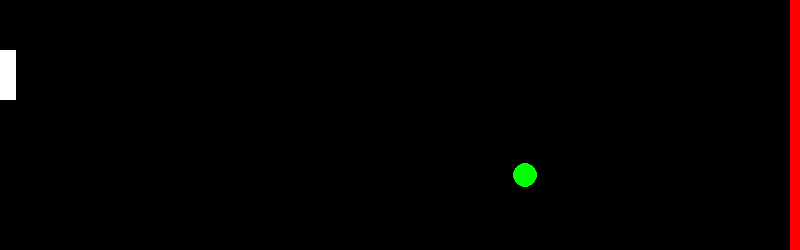

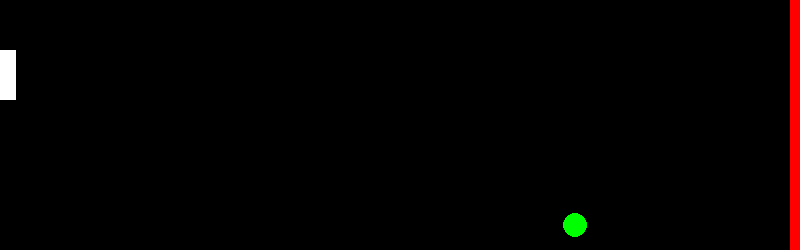

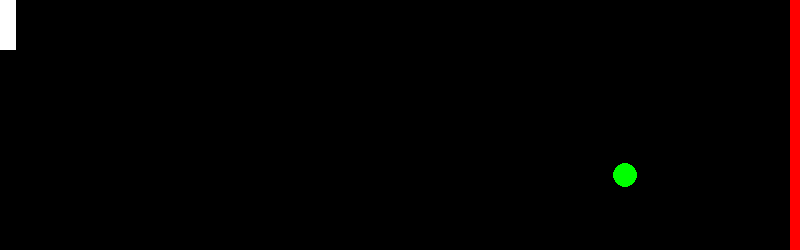

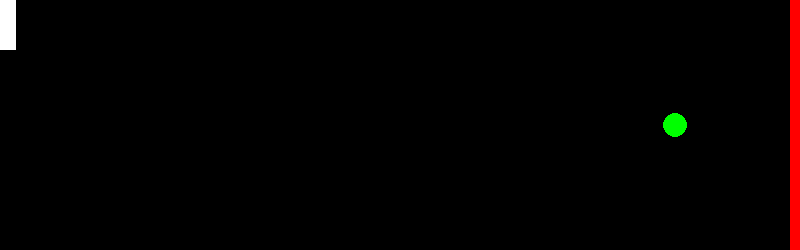

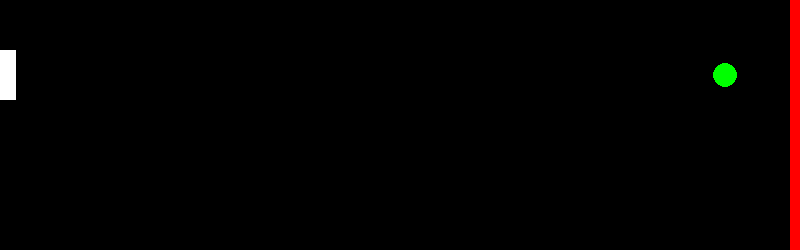

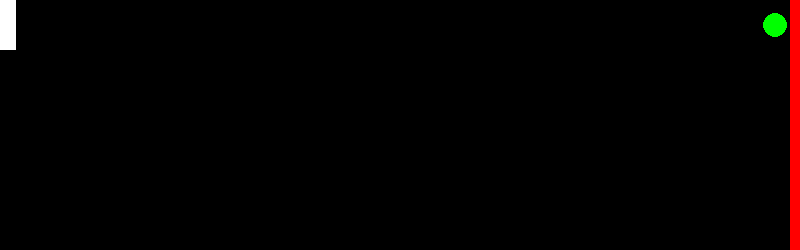

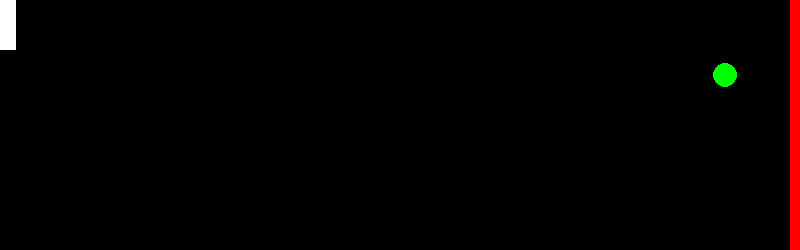

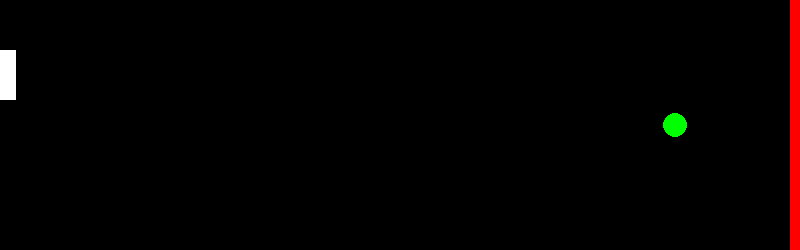

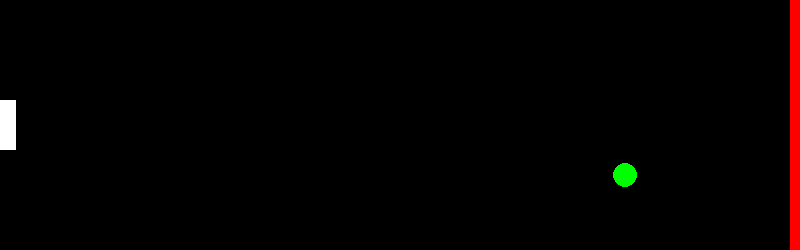

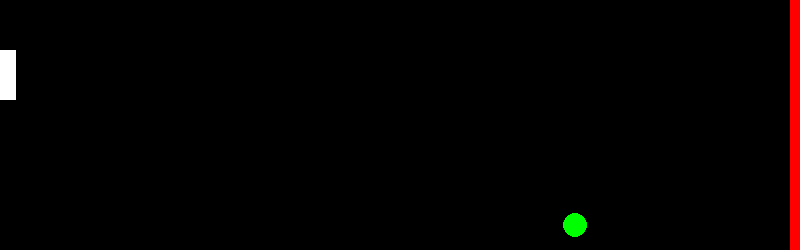

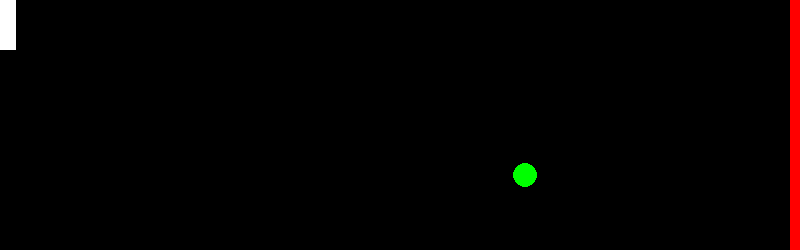

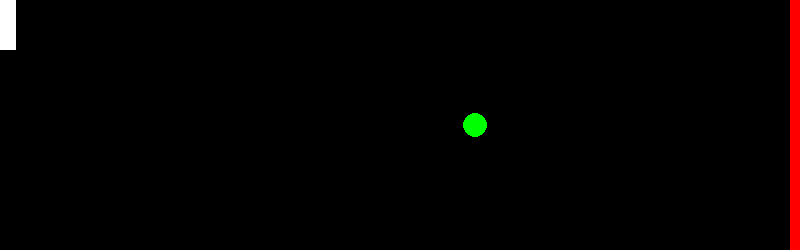

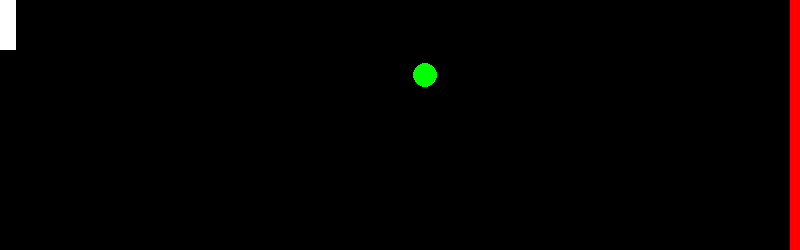

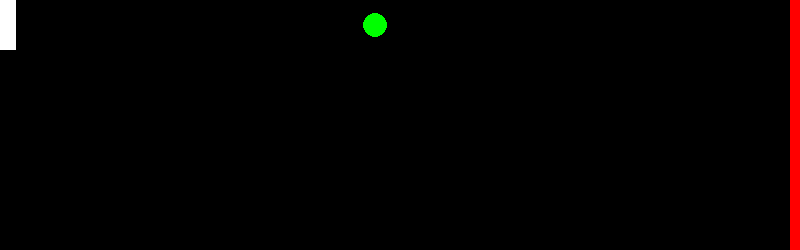

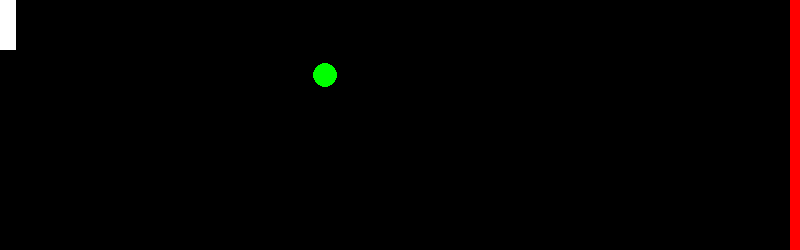

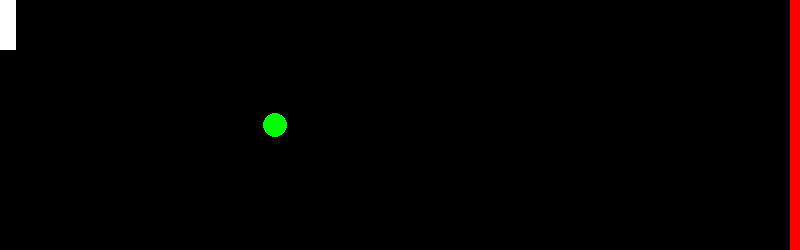

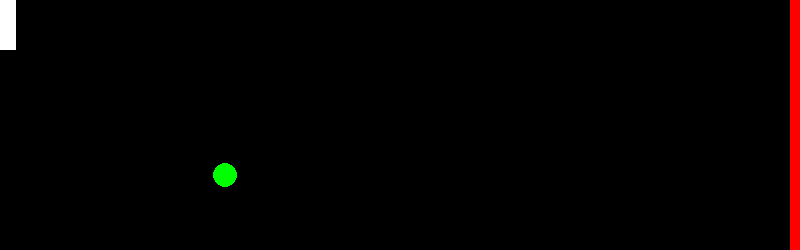

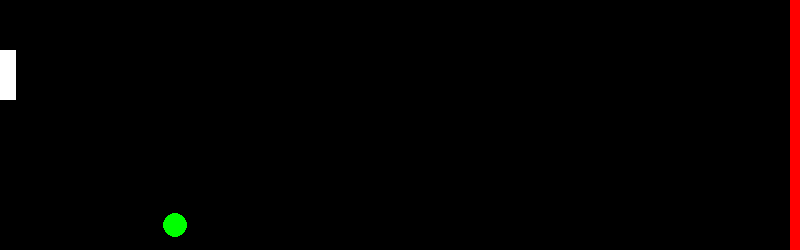

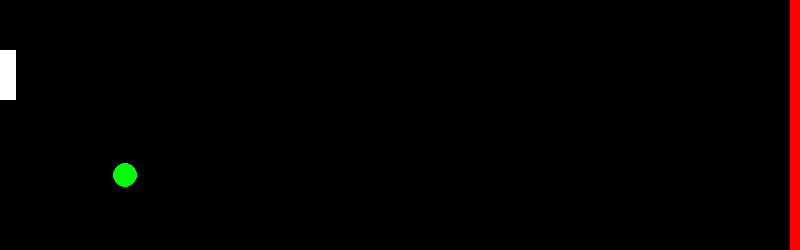

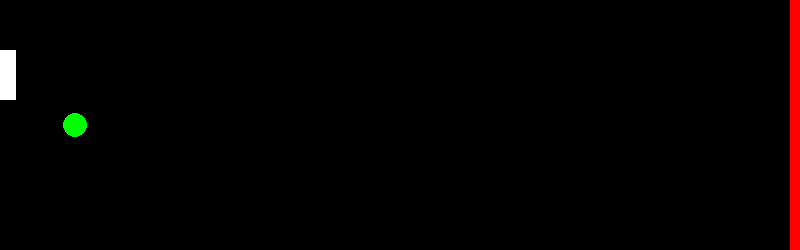

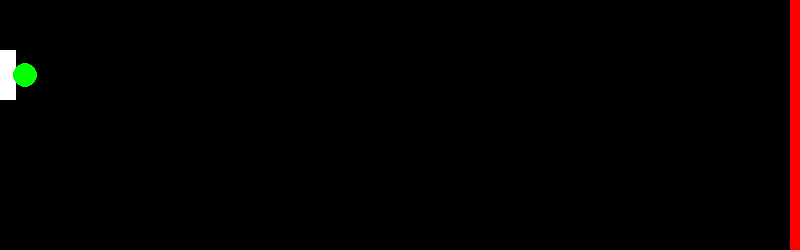

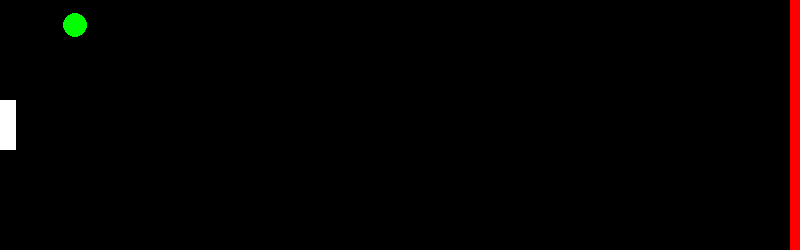

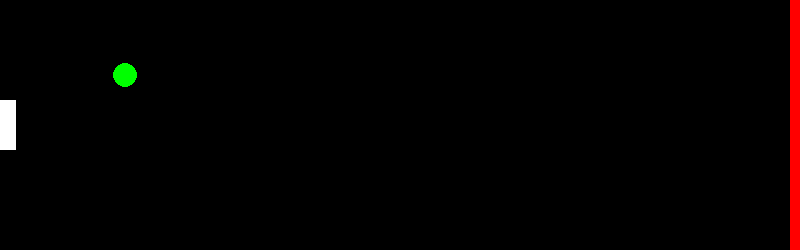

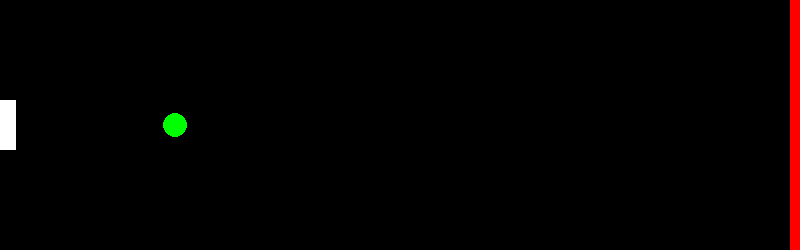

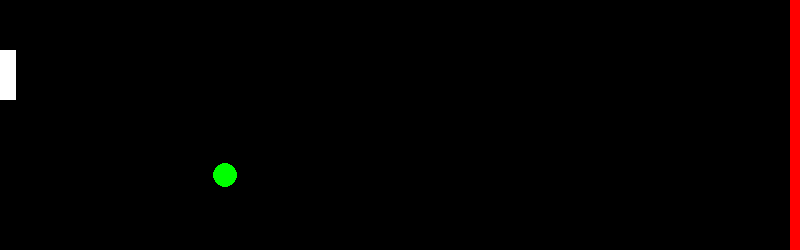

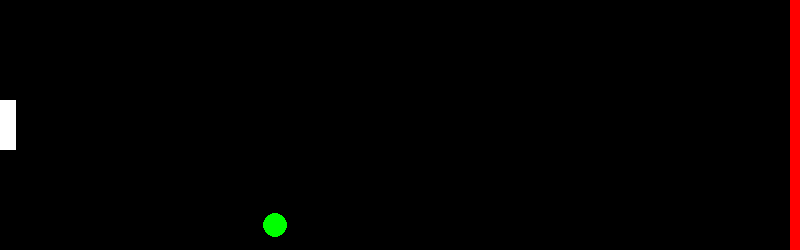

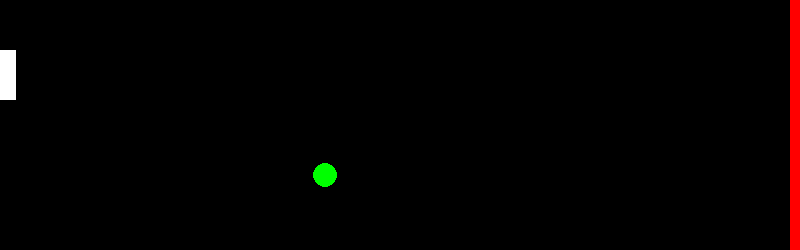

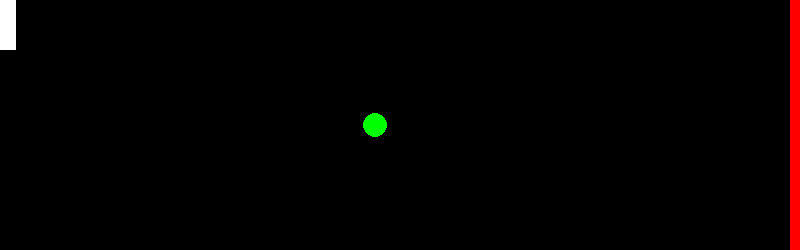

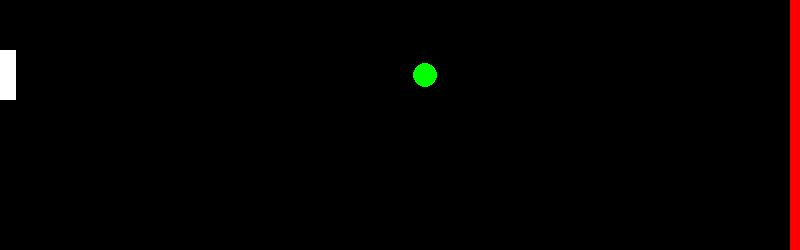

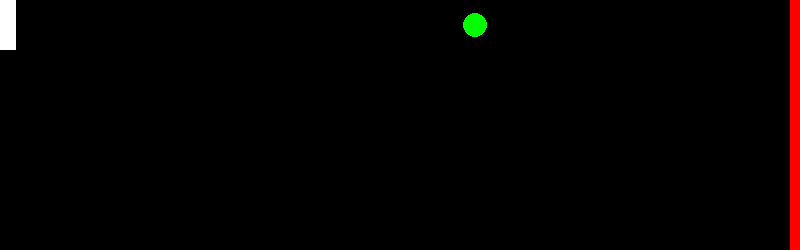

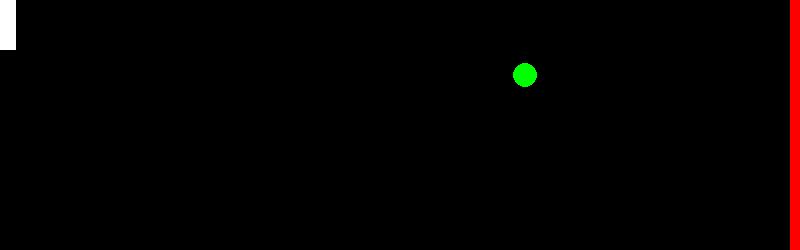

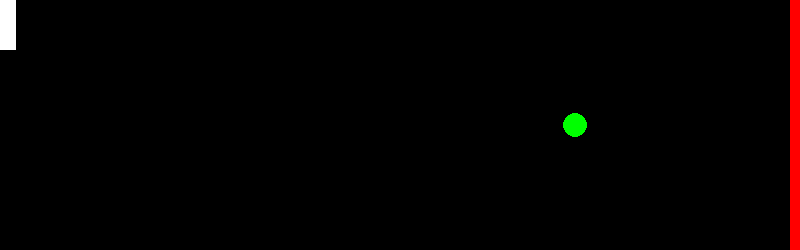

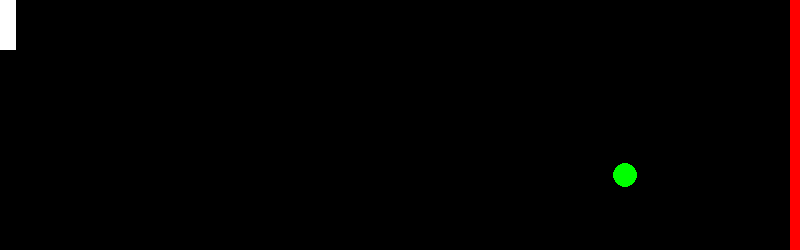

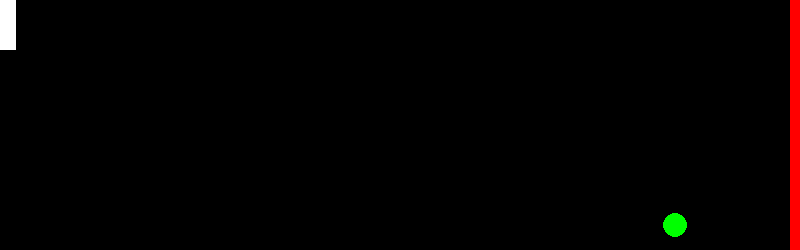

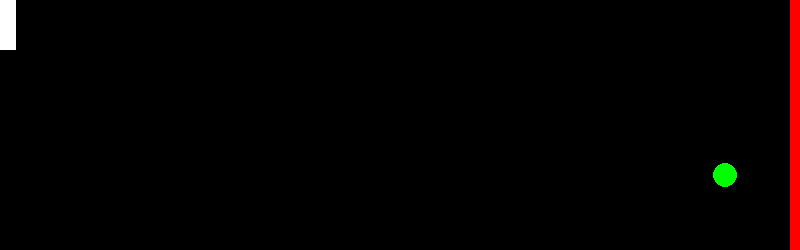

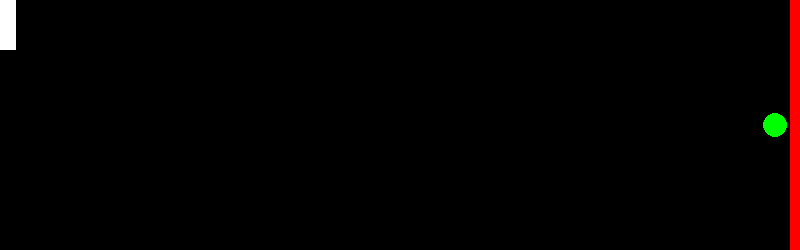

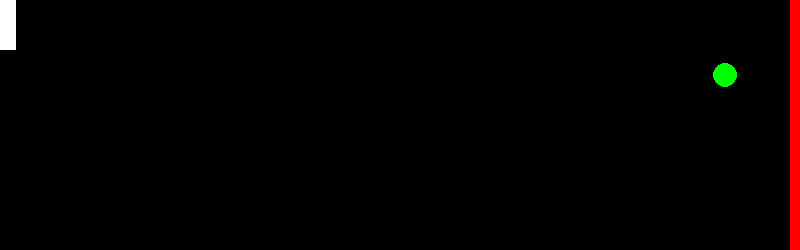

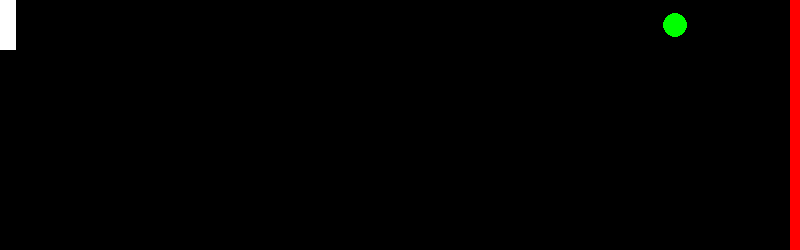

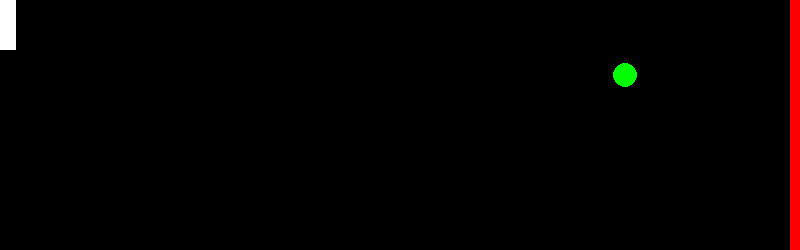

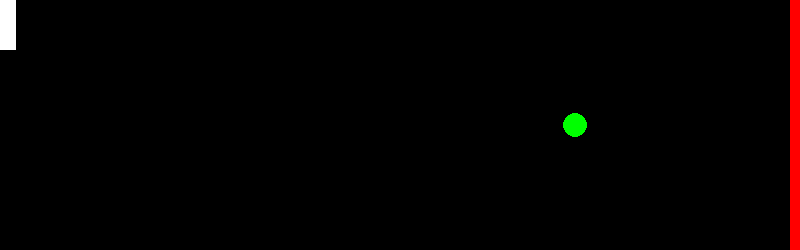

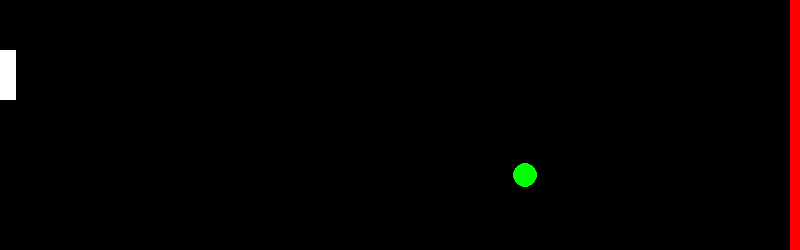

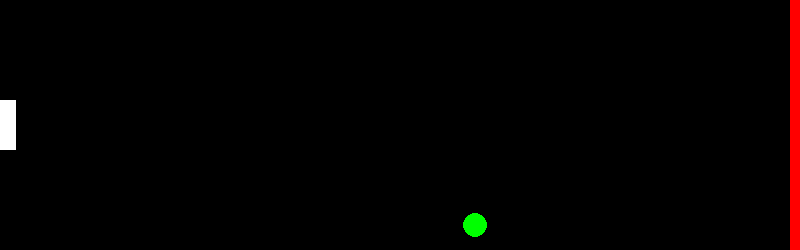

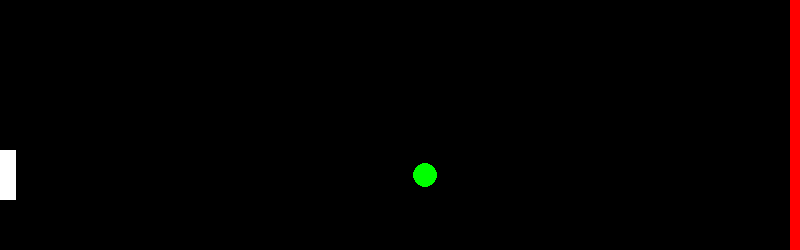

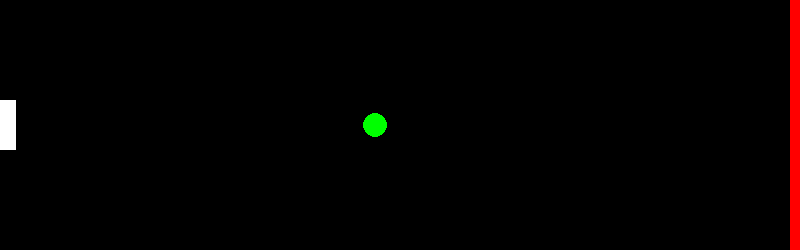

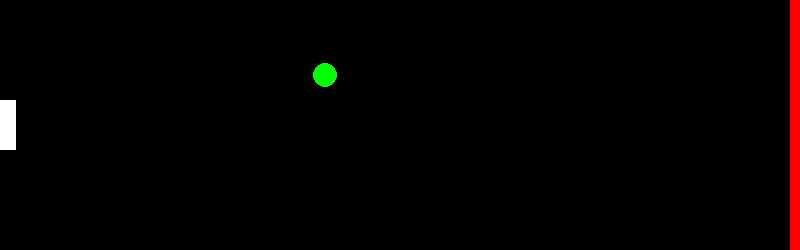

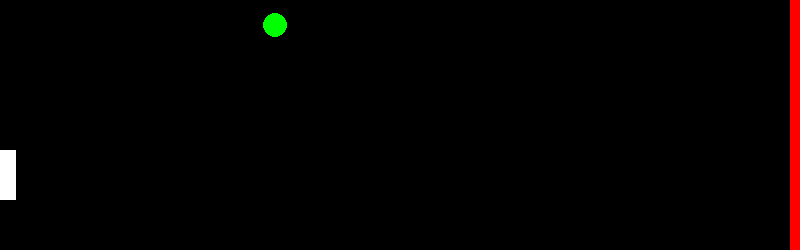

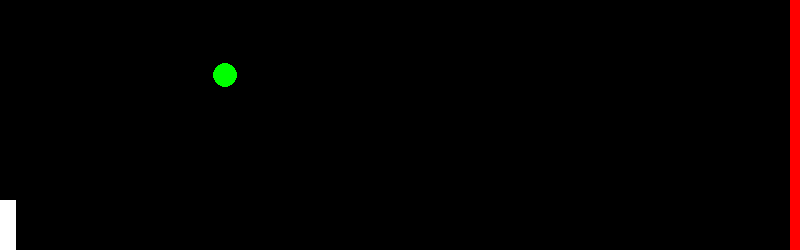

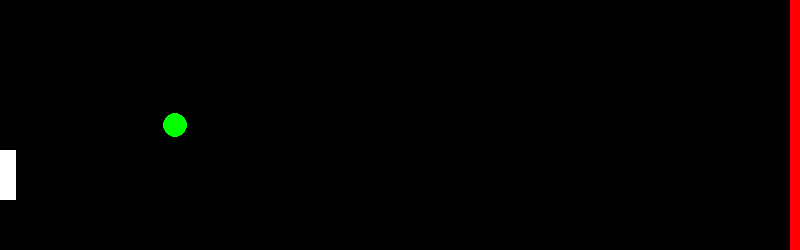

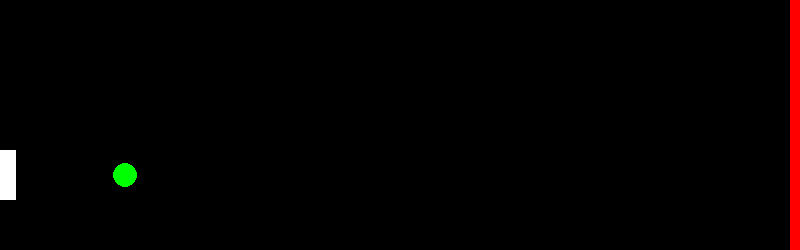

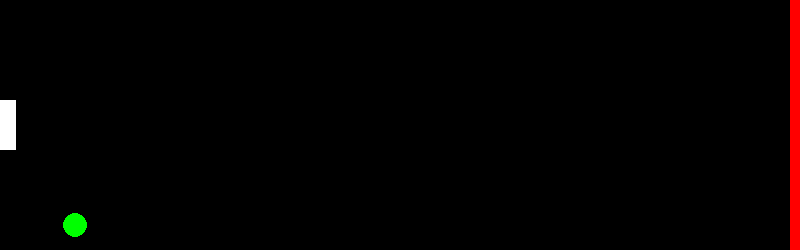

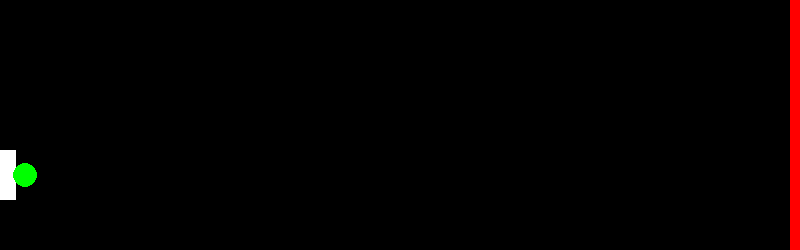

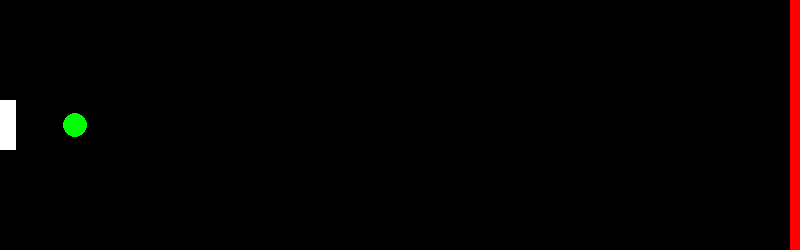

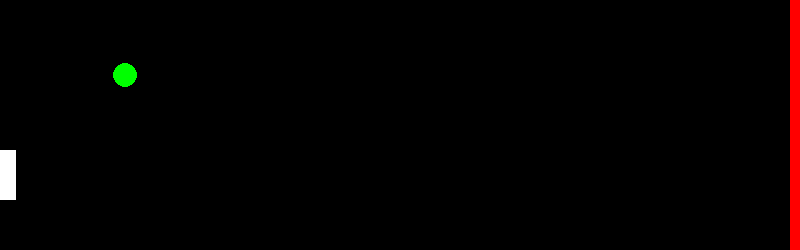

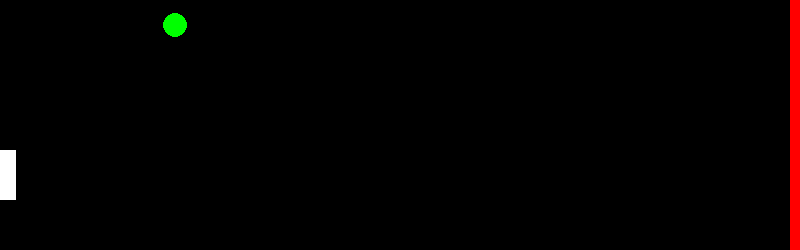

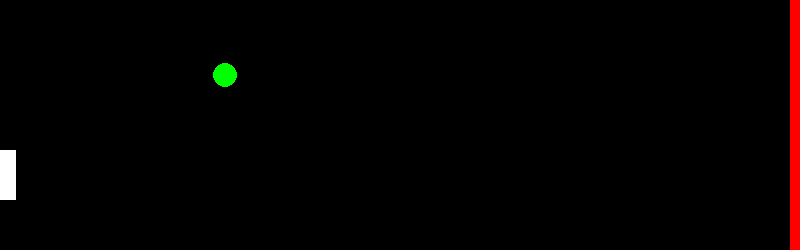

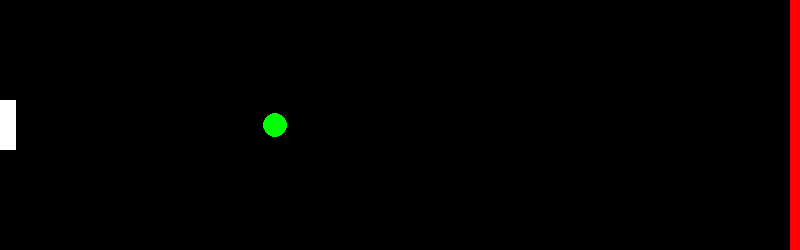

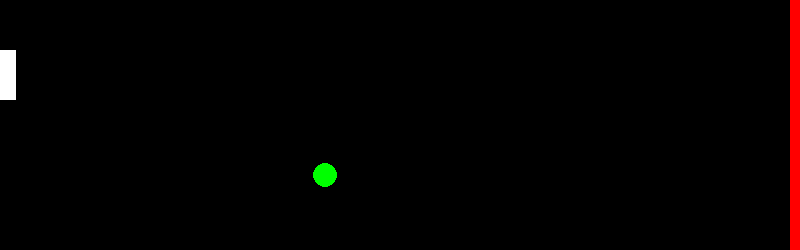

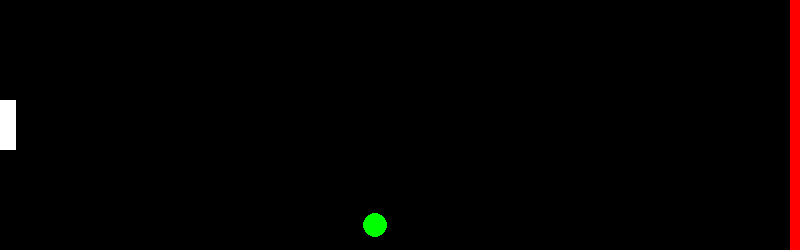

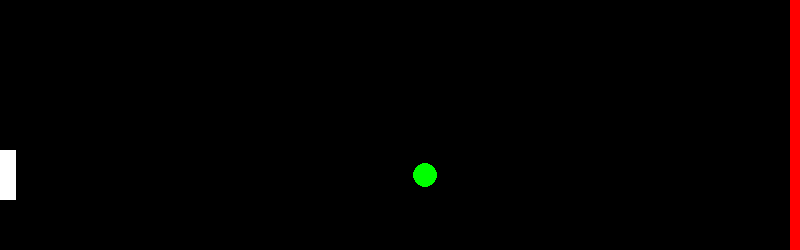

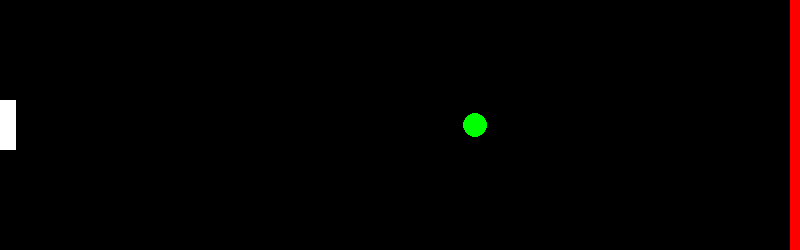

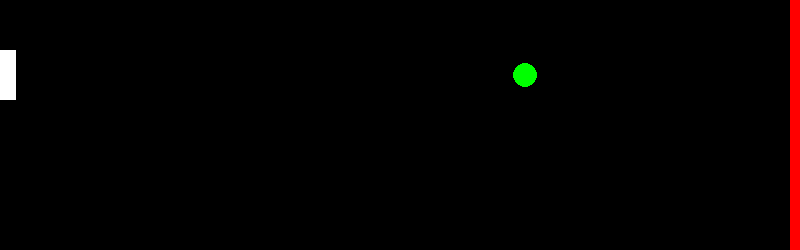

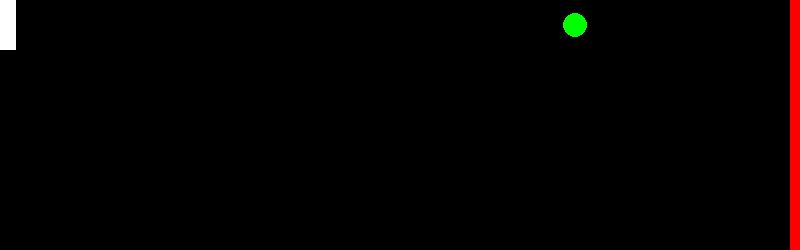

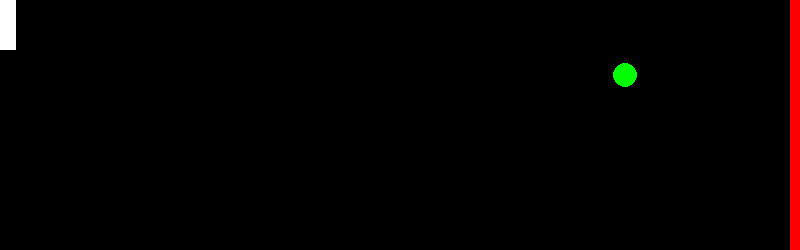

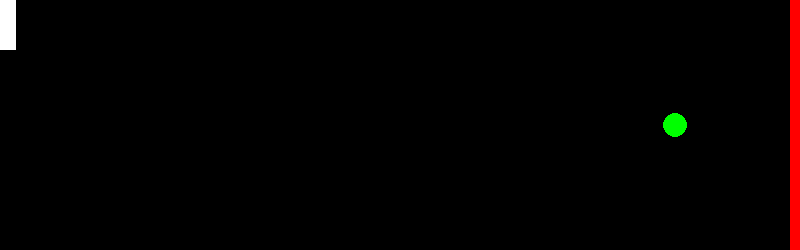

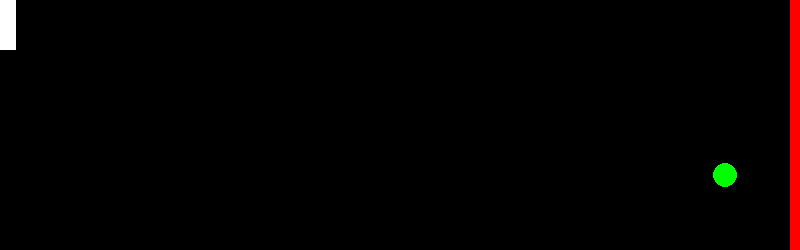

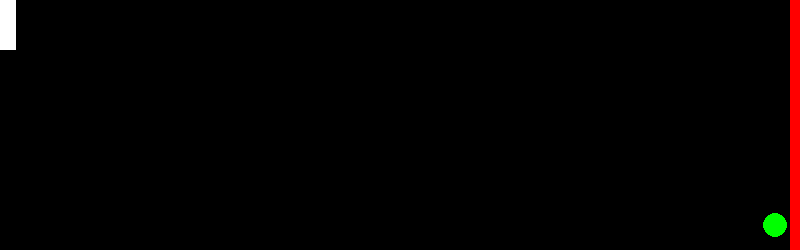

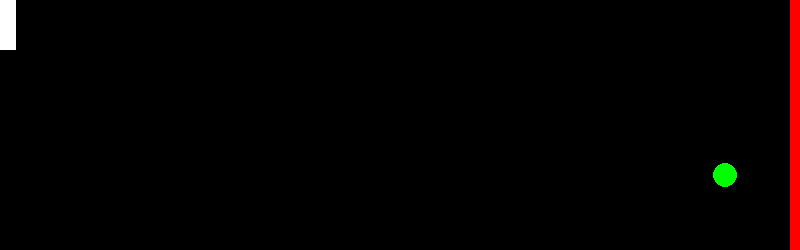

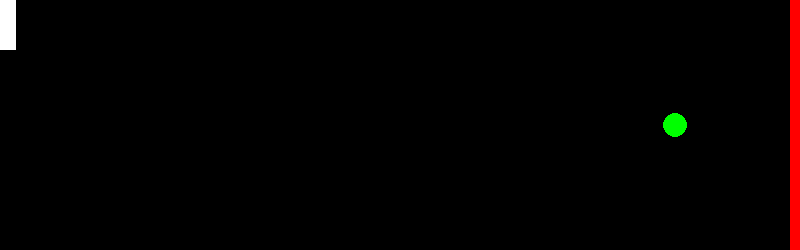

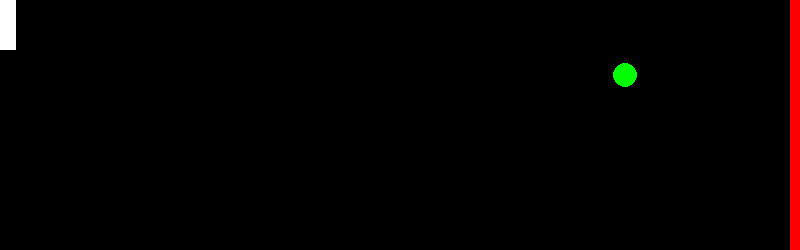

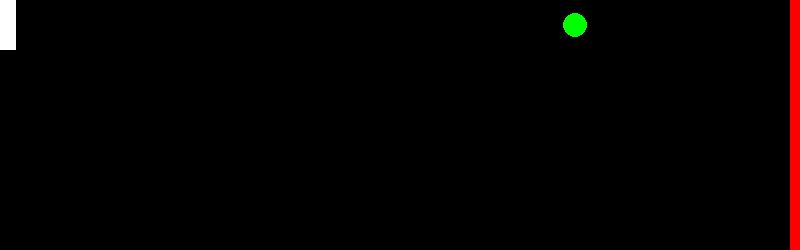

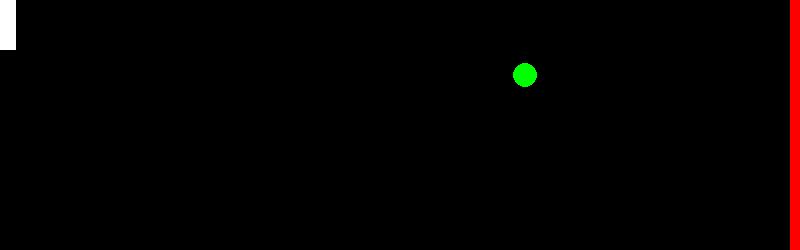

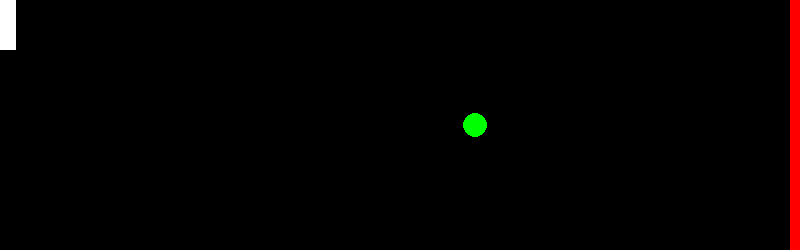

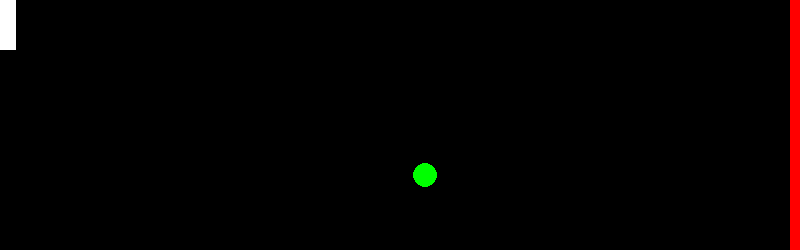

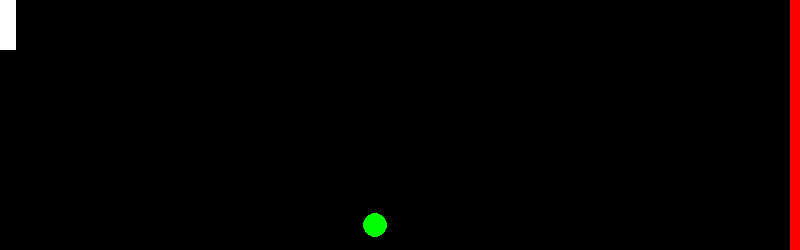

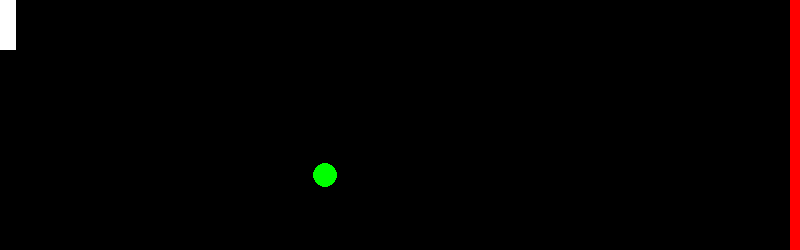

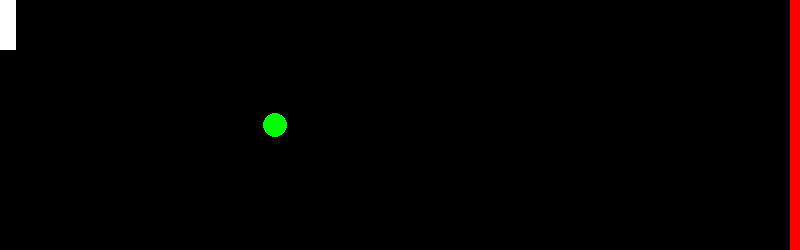

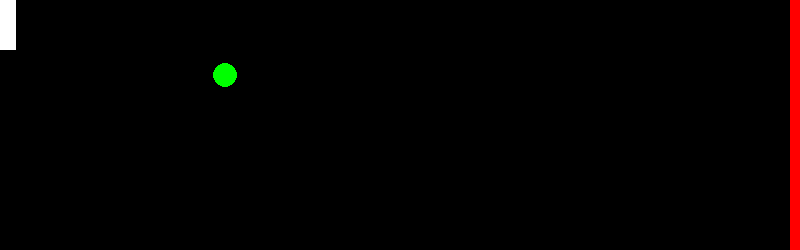

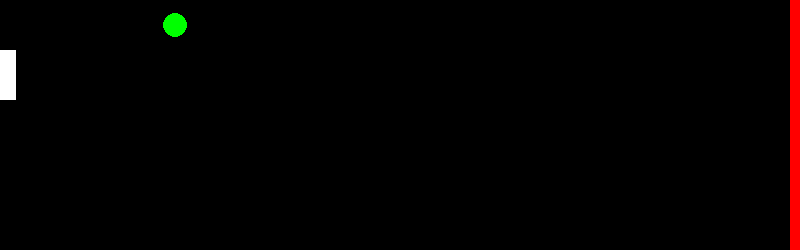

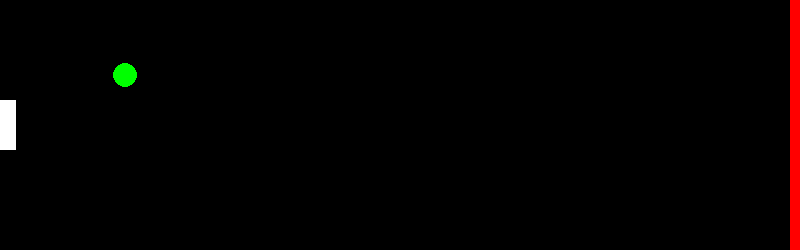

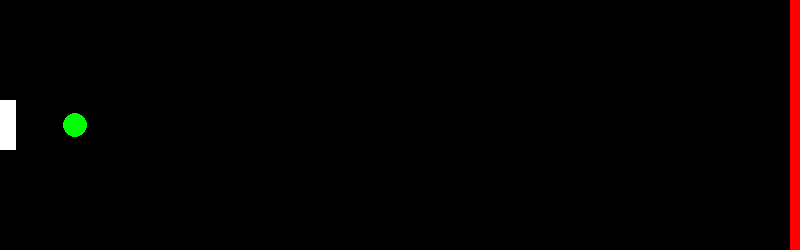

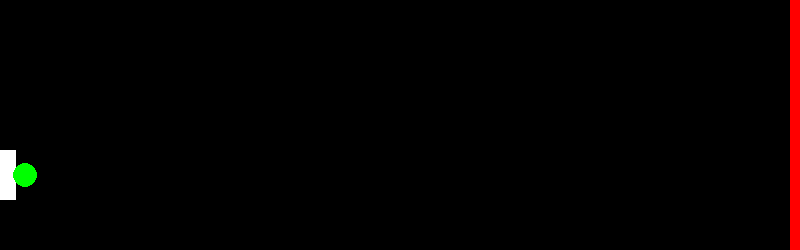

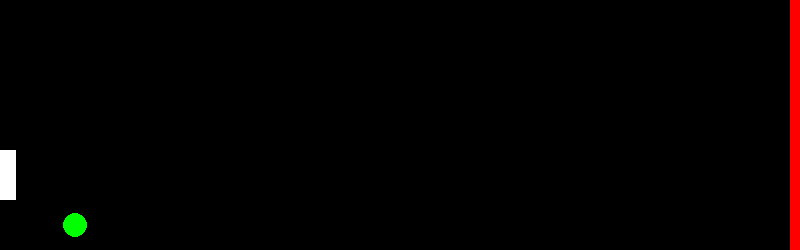

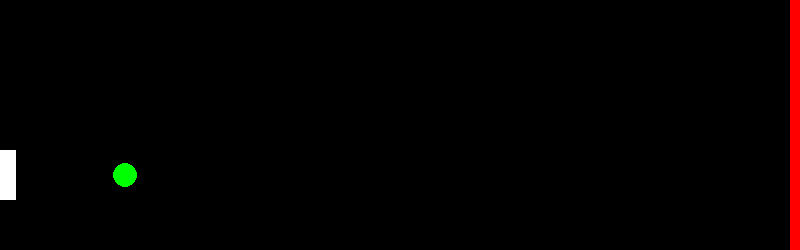

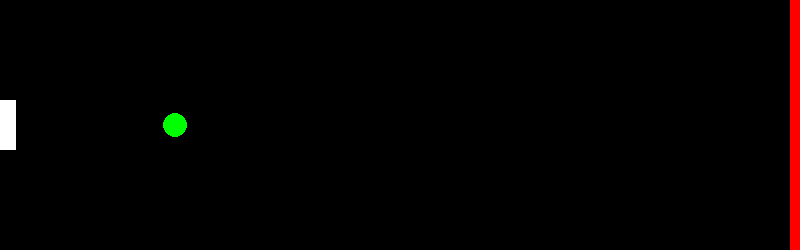

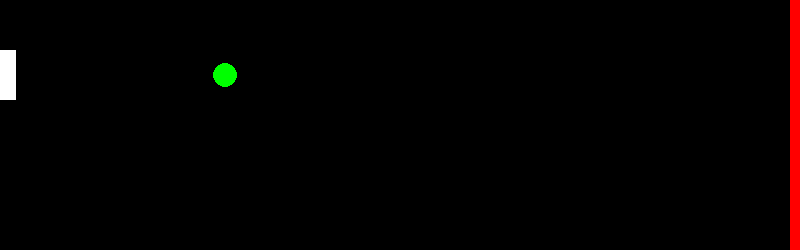

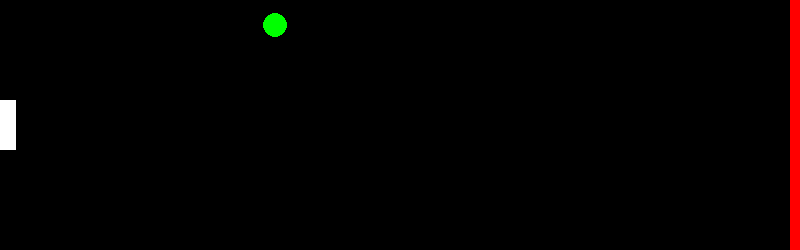

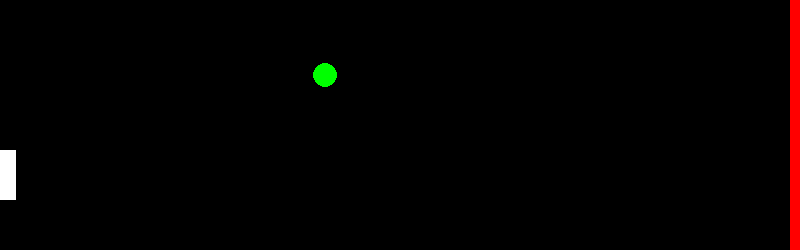

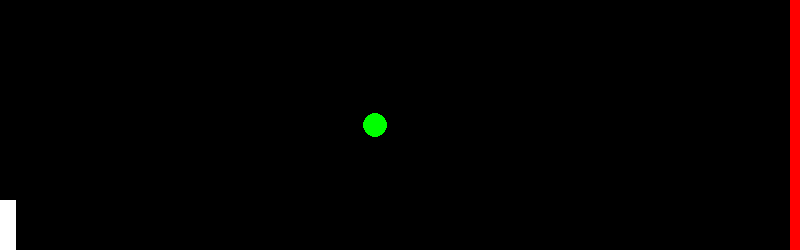

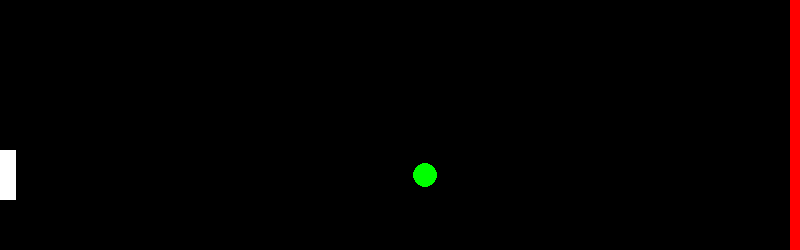

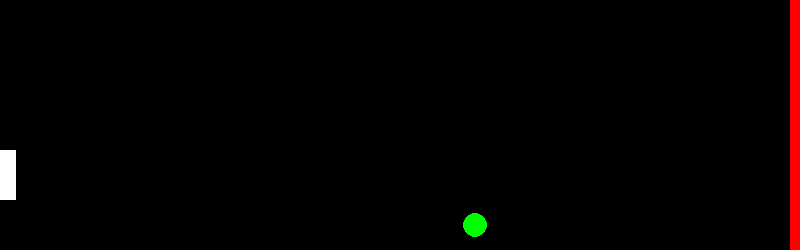

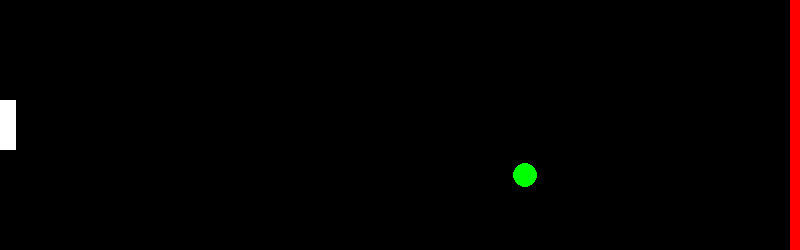

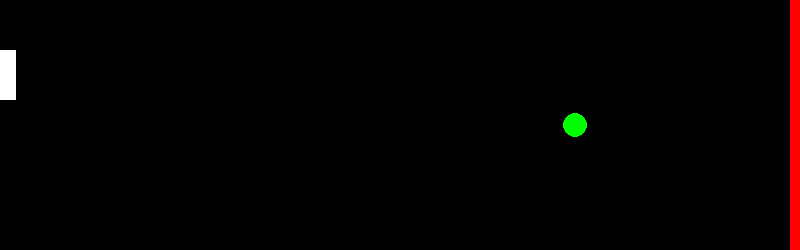

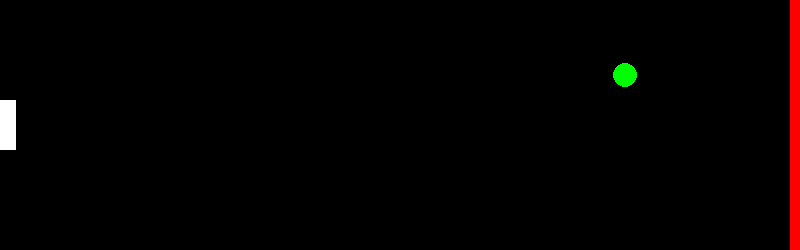

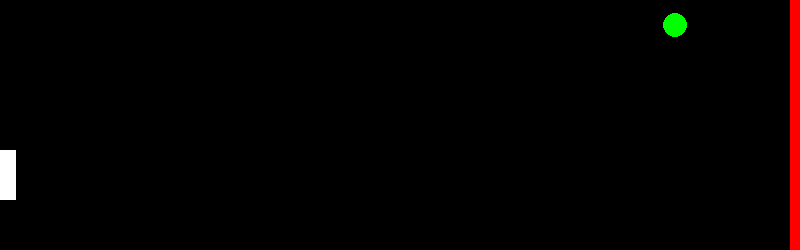

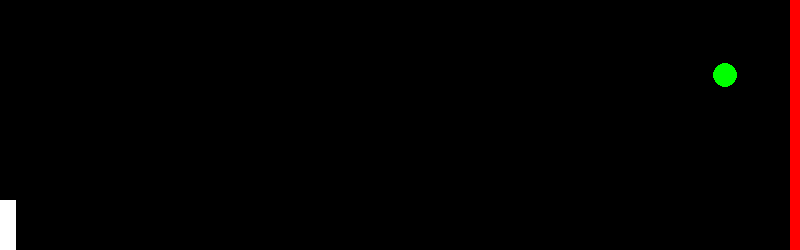

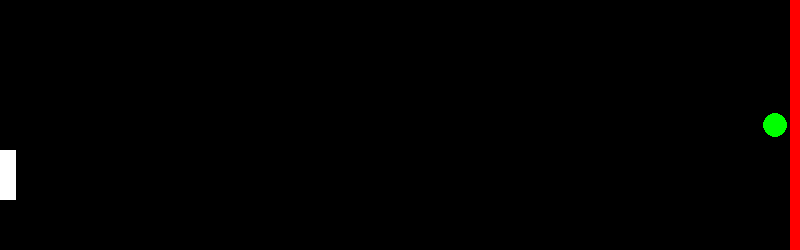

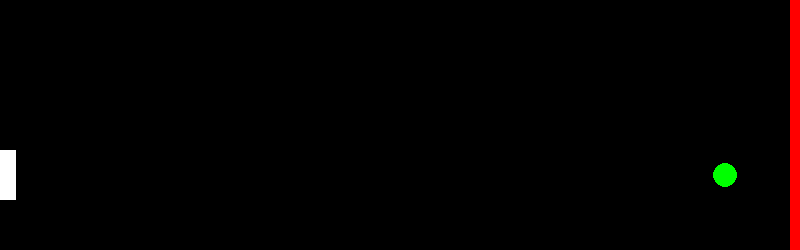

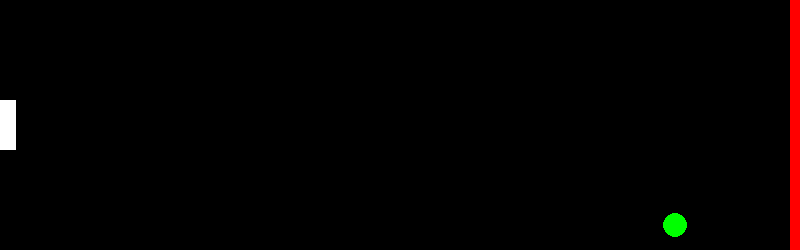

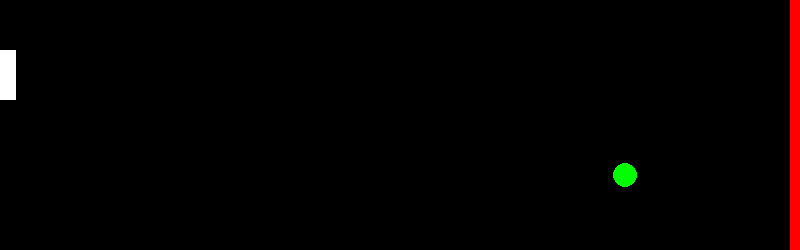

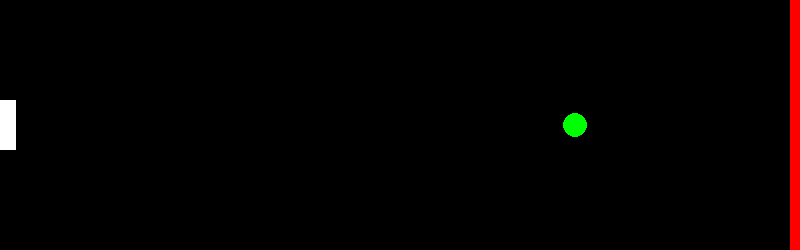

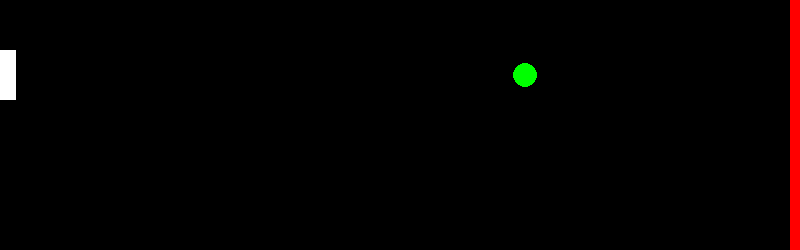

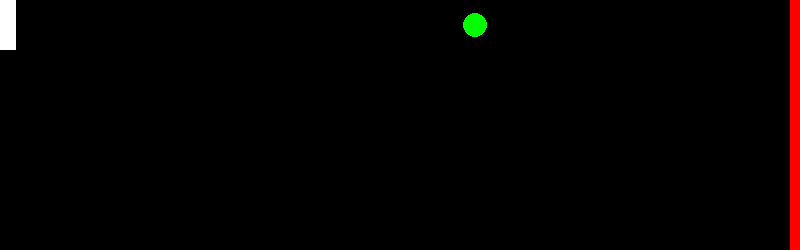

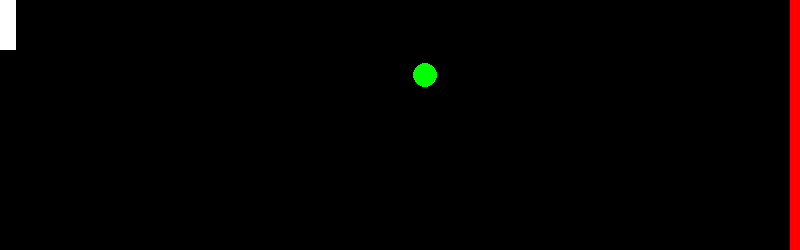

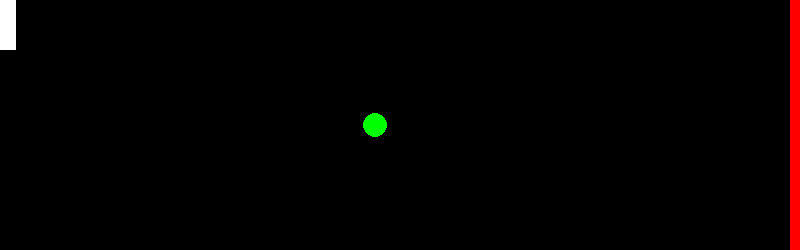

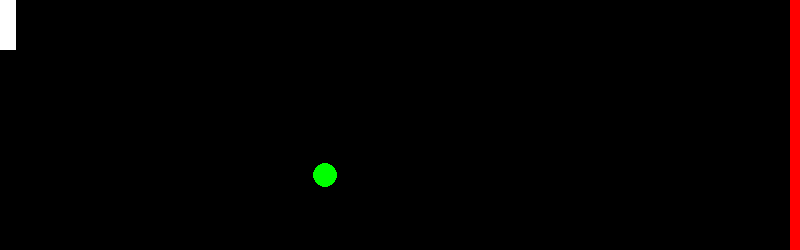

KeyboardInterrupt: ignored

In [ ]:

agent = Agent(env)  # Create Agent

if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl"))
    if TRAIN_MODEL == False :
        agent.epsilon = 0
        # with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        #     param = json.load(outfile)
        #

    startEpisode = LOAD_FILE_EPISODE + 1

else:
    startEpisode = 1

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
total_step = 1  # Cumulkative sum of all steps in episodes
for episode in range(startEpisode, MAX_EPISODE):
    print(episode)
    startTime = time.time()  # Keep time
    state = env.reset()  # Reset env

    #cv2_imshow(state)

    state = agent.preProcess(state)  # Process image

    # Stack state . Every state contains 4 time contionusly frames
    # We stack frames like 4 channel image
    state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    for step in range(MAX_STEP):


        # Select and perform an action
        action = agent.act(state)  # Act
        next_state, reward, done = env.step(action)  # Observe

        if RENDER_GAME_WINDOW :
            cv2.destroyAllWindows()
            print("")
            cv2_imshow(next_state)  # Show state visually
            # print("action"+ str(action) )
            # print("done:" + str(done))

        next_state = agent.preProcess(next_state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem

        # Move to the next state
        state = next_state  # Update state

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
        else:
            loss, max_q_val = [0, 0]

        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            agent.adaptiveEpsilon()  # Decrase epsilon

        if done:  # Episode completed
            if episode%100 == 0:
                print("DONE"+ str(episode))
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime  # Find episode duration
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
            epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file

            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

            last_100_ep_reward.append(total_reward)
            avg_max_q_val = total_max_q_val / step

            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, step, total_step
            )

            print(outStr)

            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")

            break
